# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


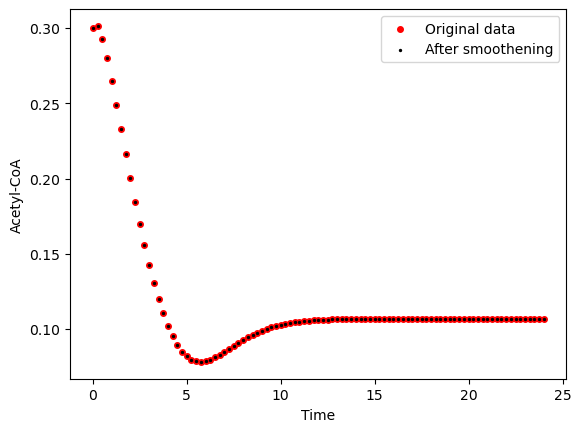

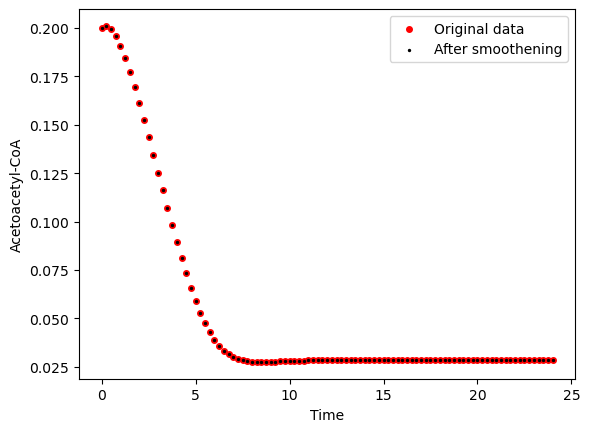

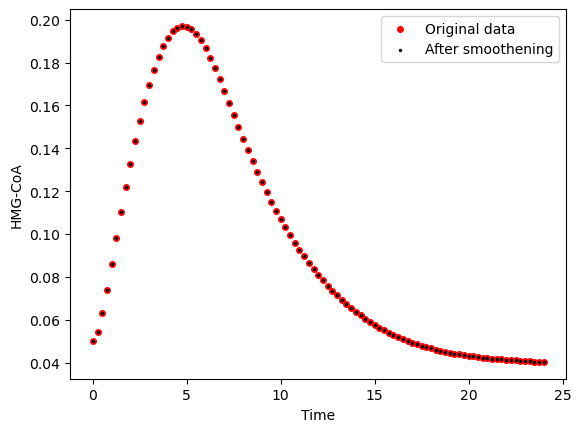

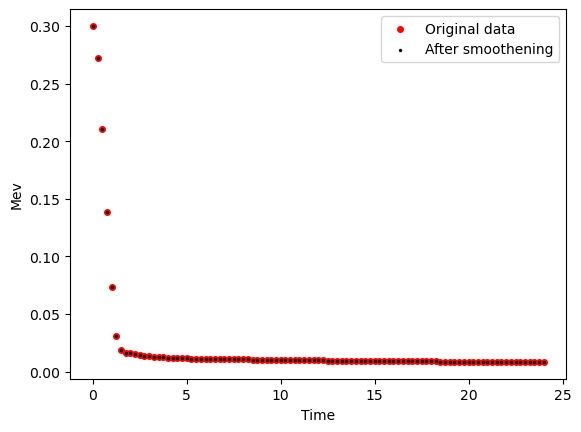

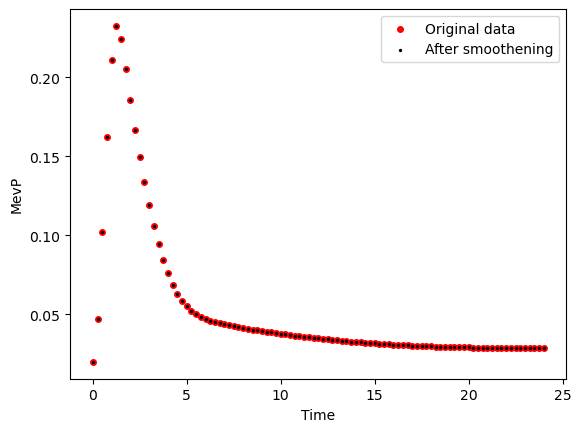

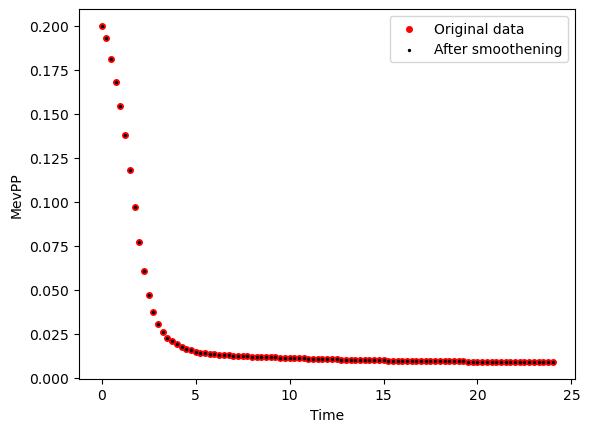

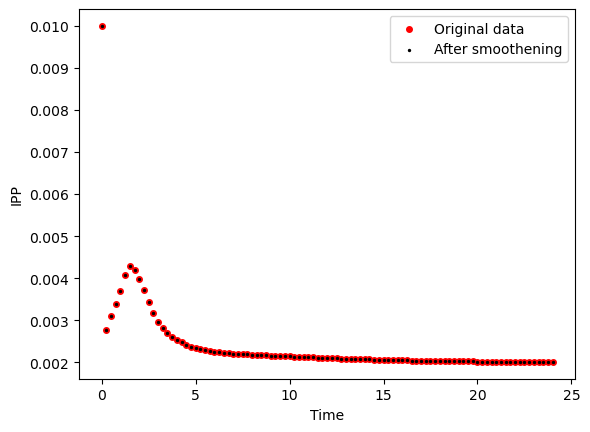

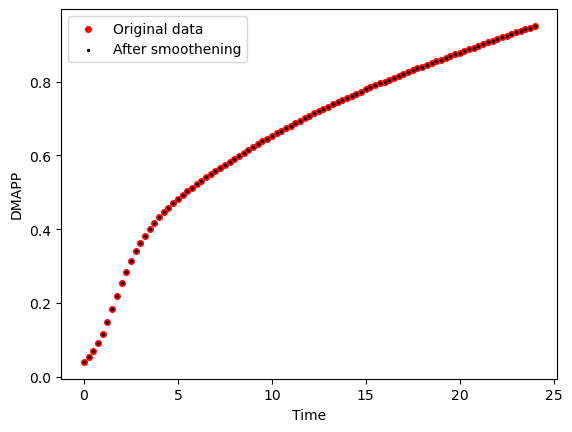

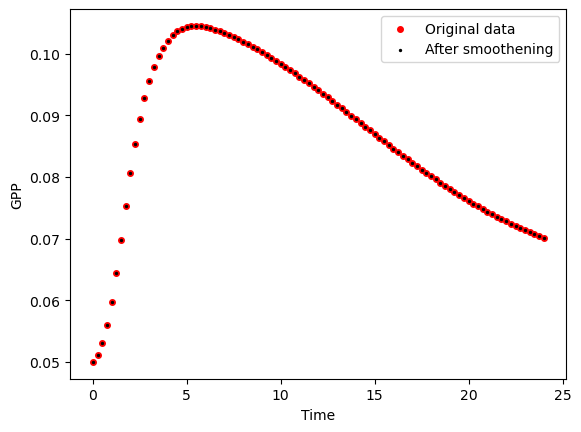

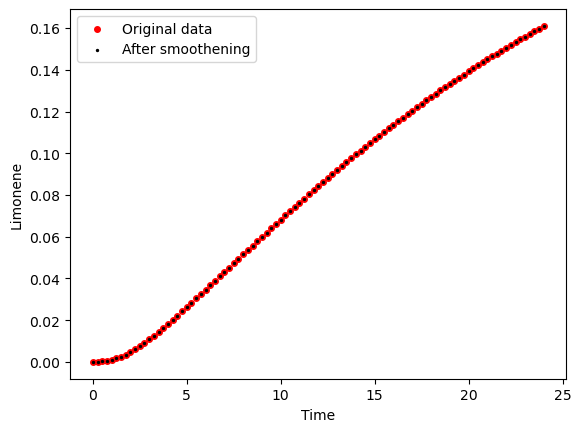

Strain Strain 2


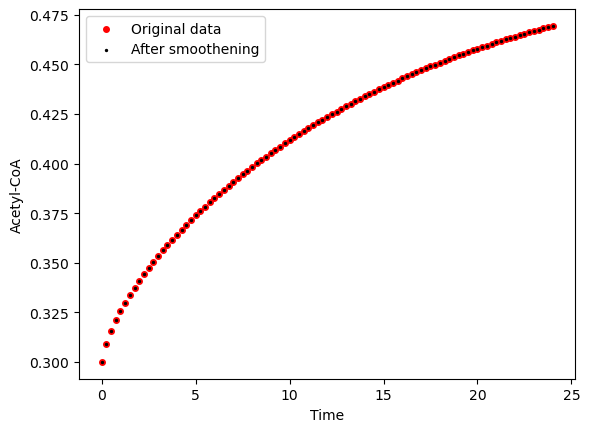

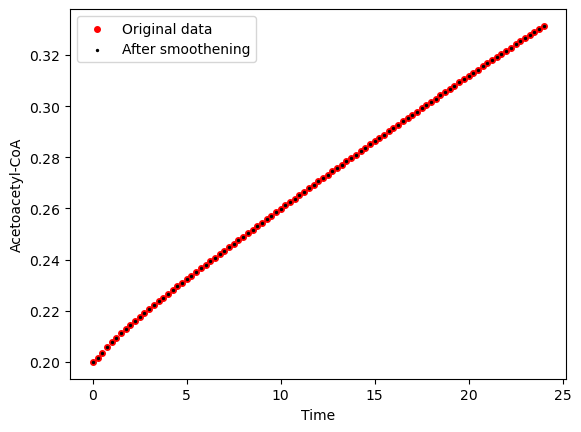

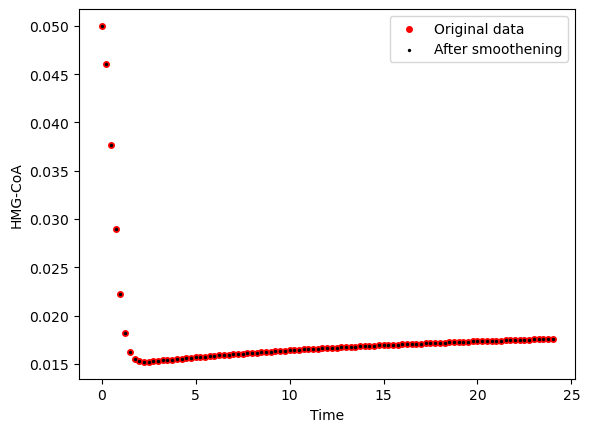

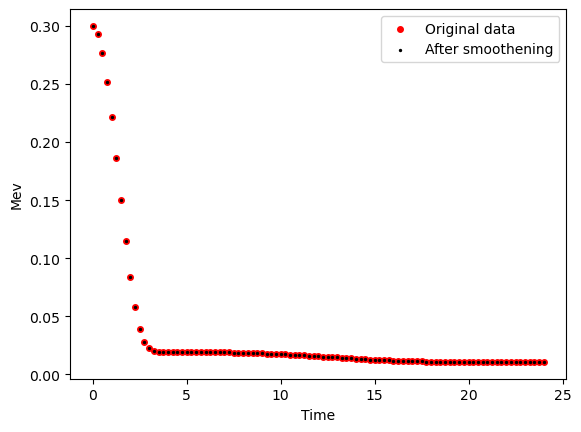

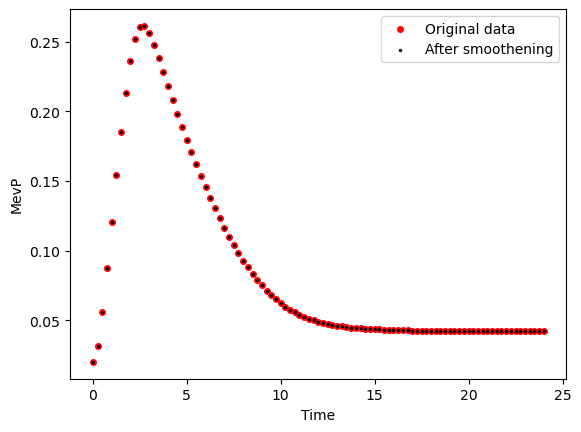

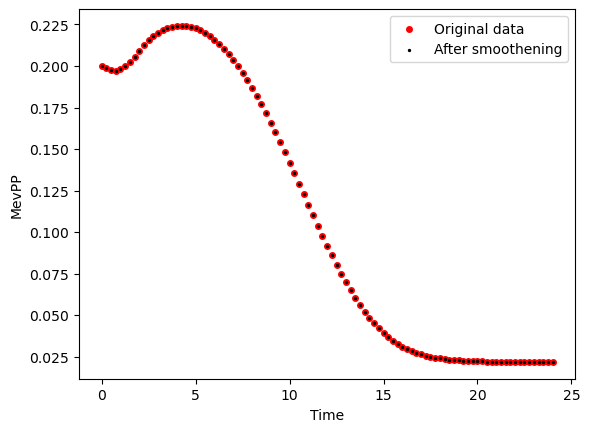

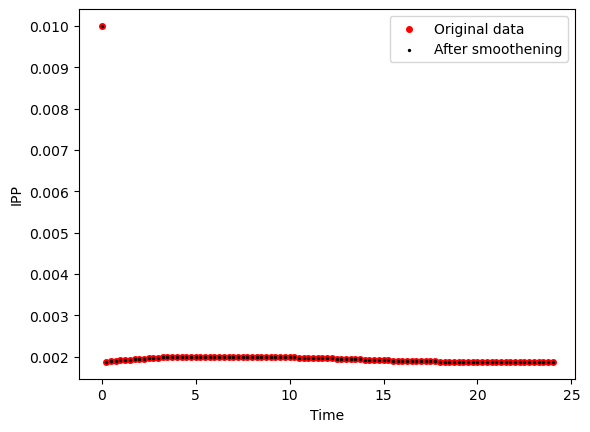

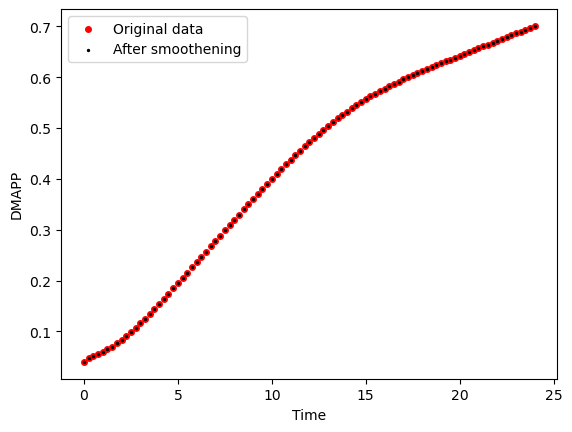

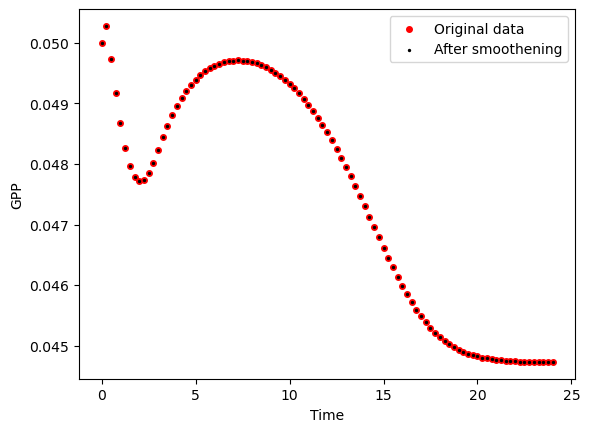

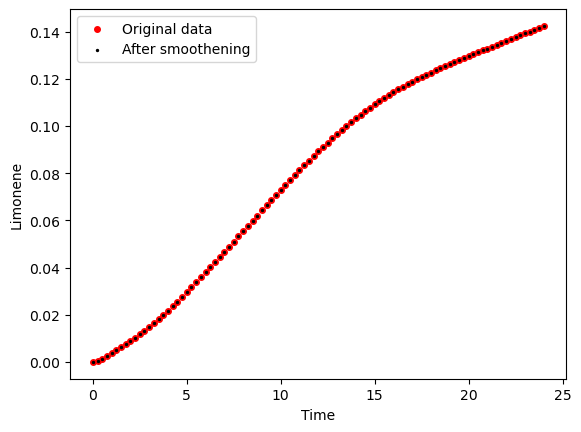

Strain Strain 3


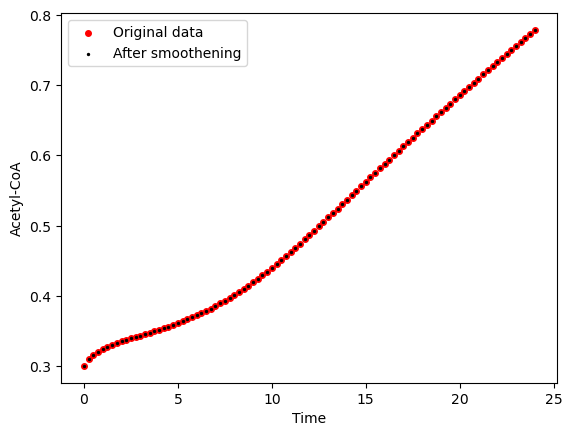

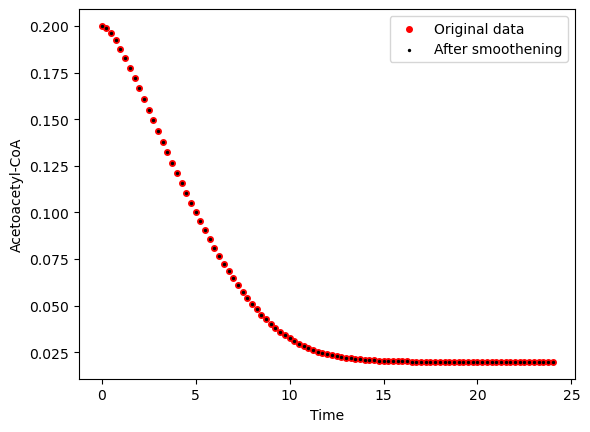

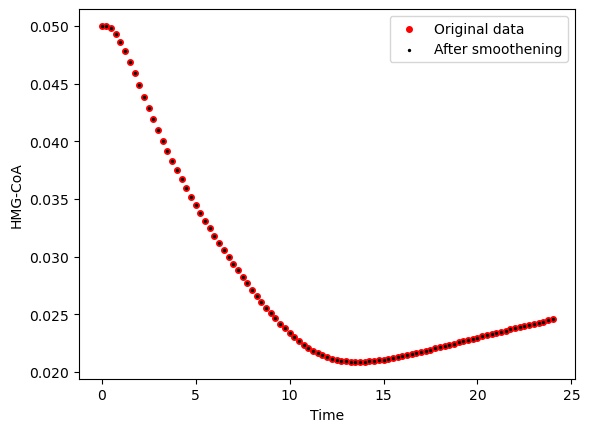

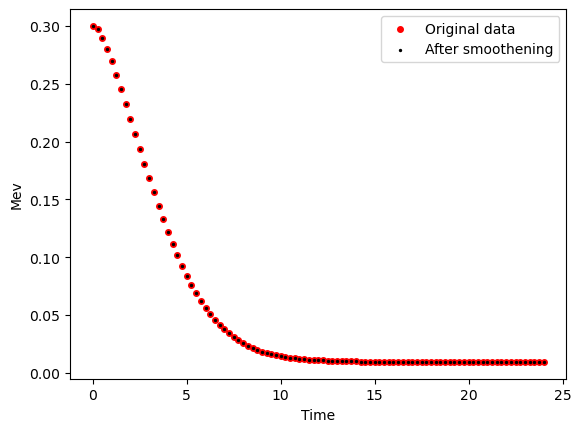

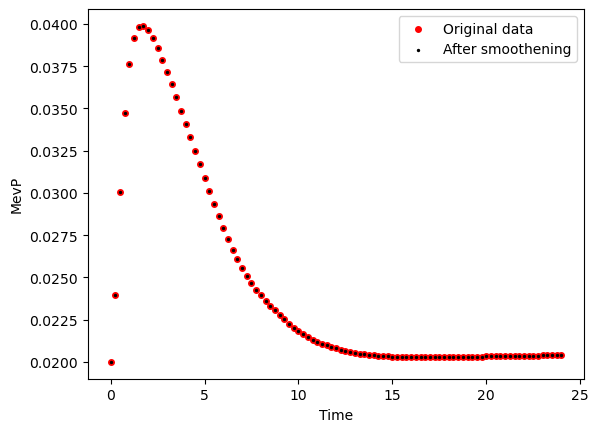

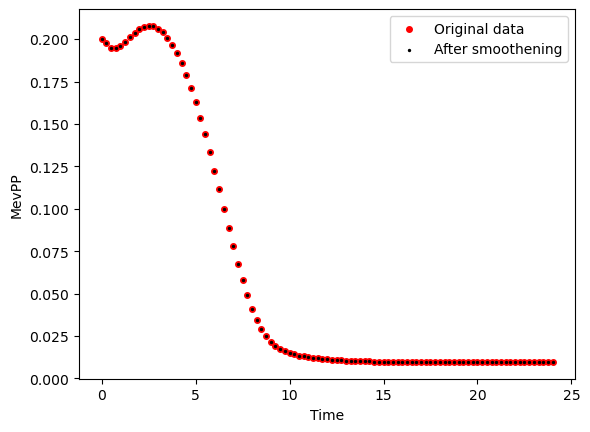

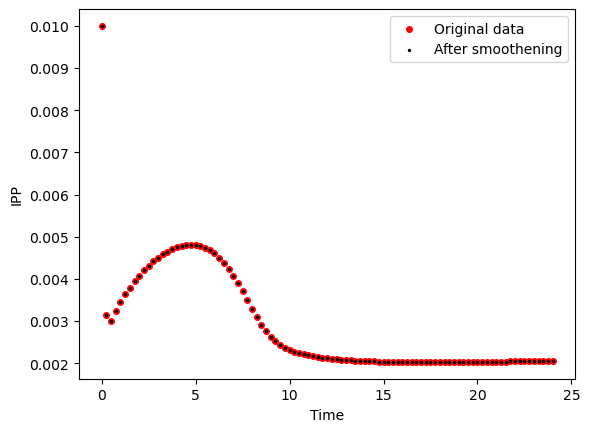

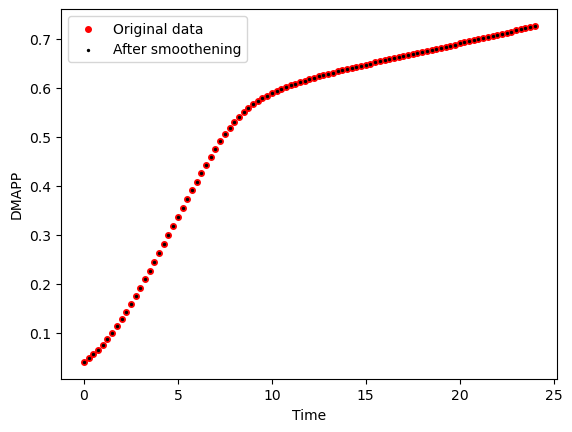

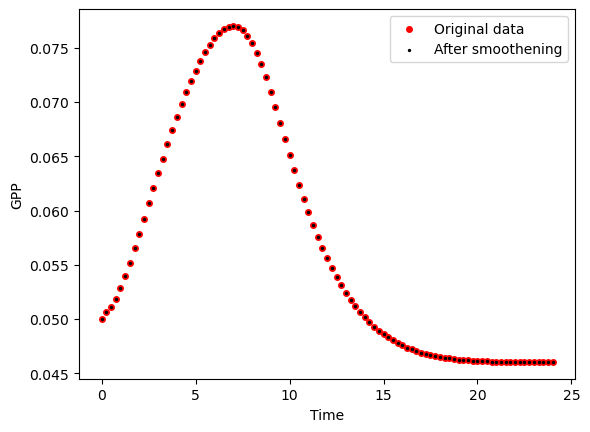

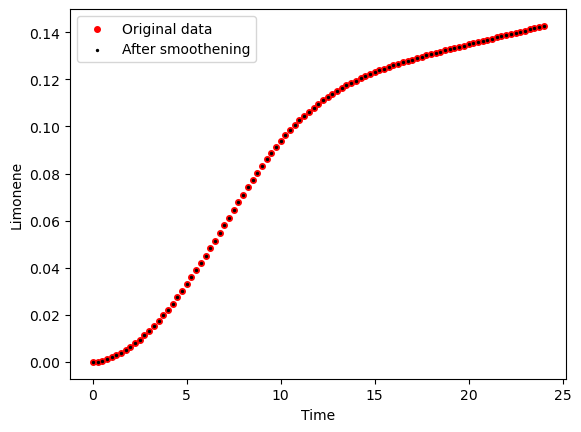

Strain WT


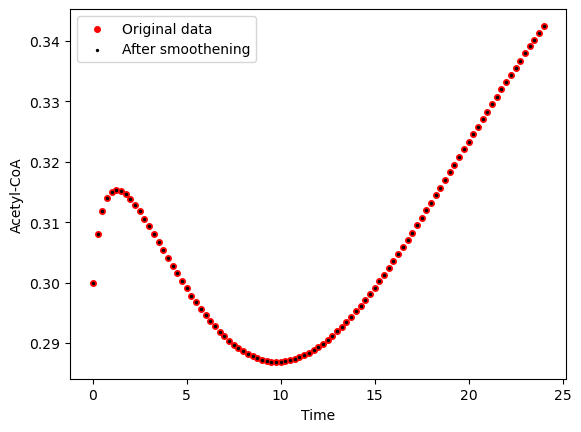

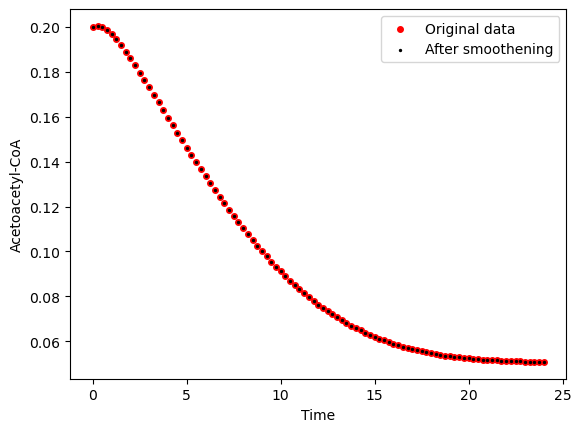

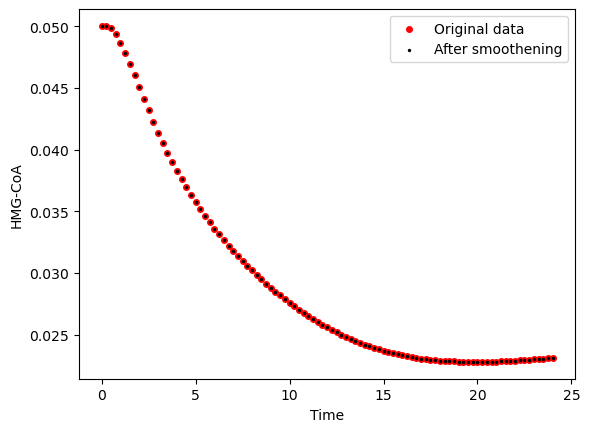

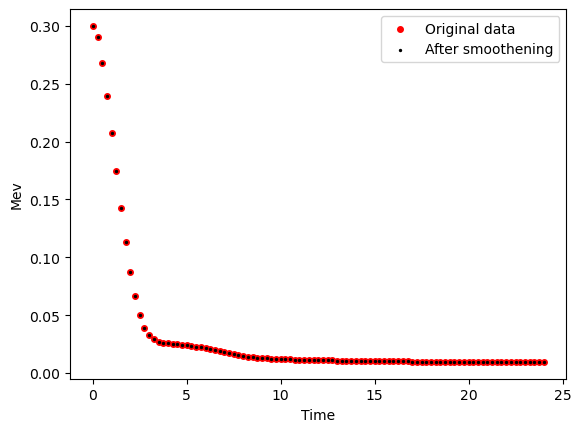

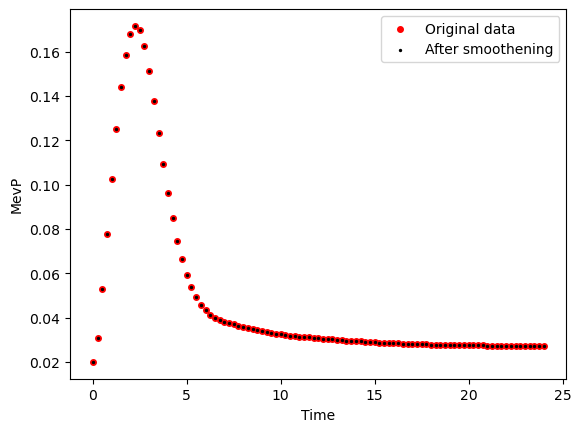

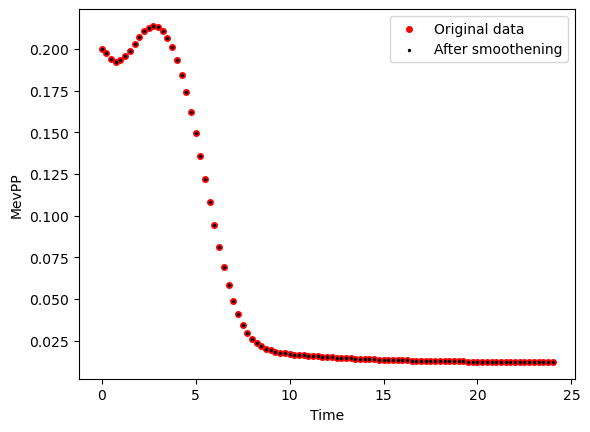

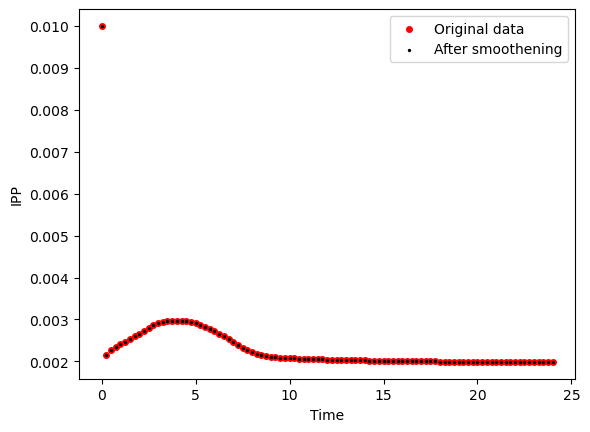

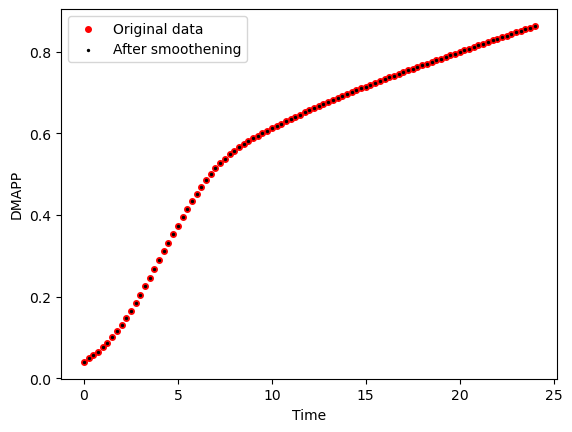

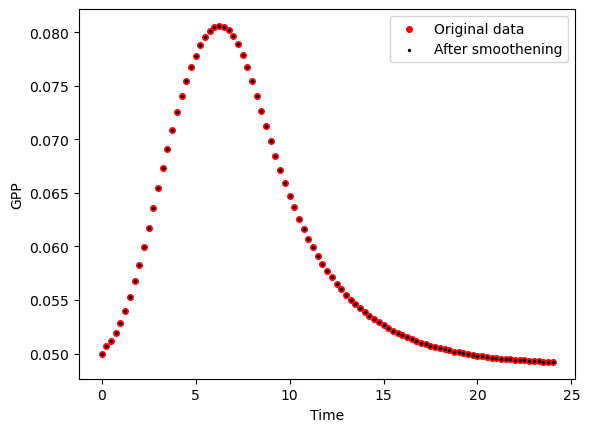

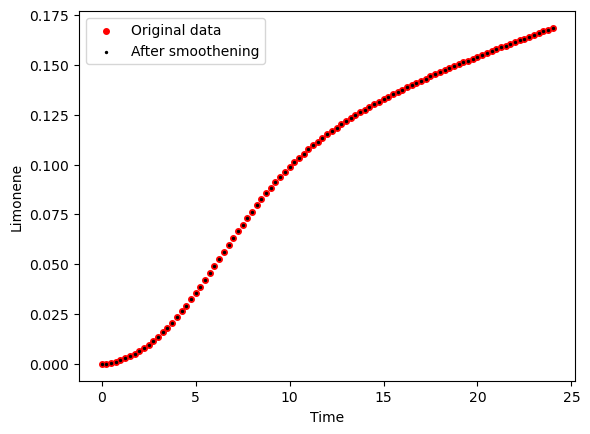

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


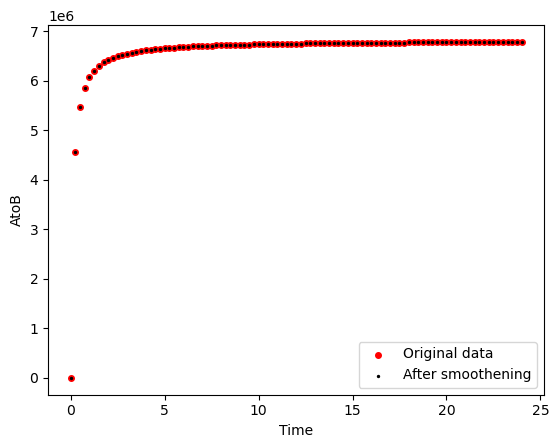

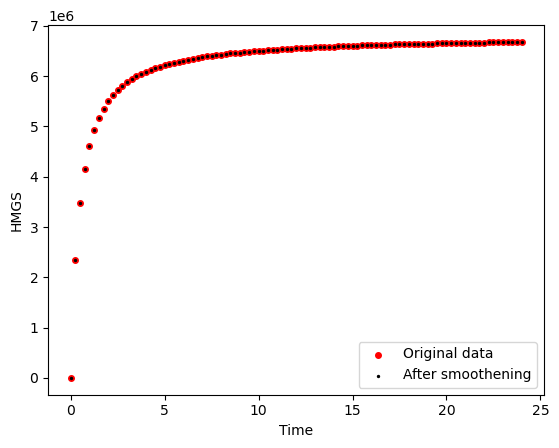

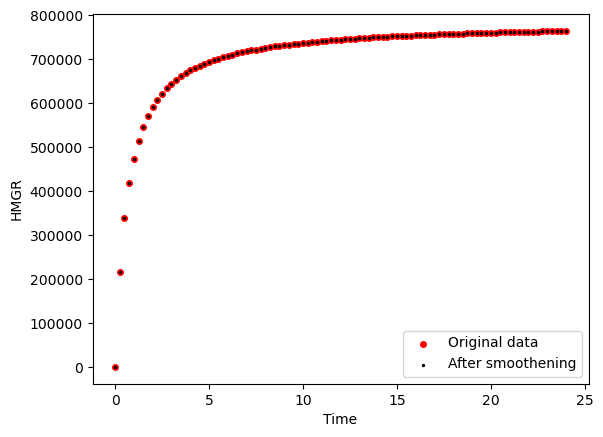

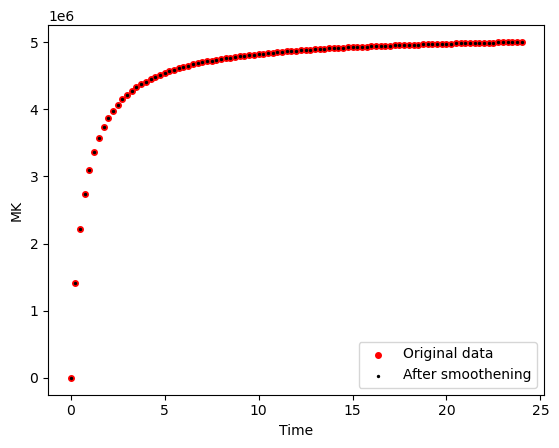

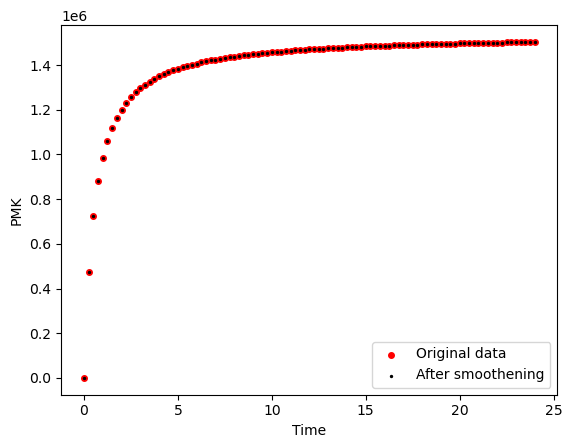

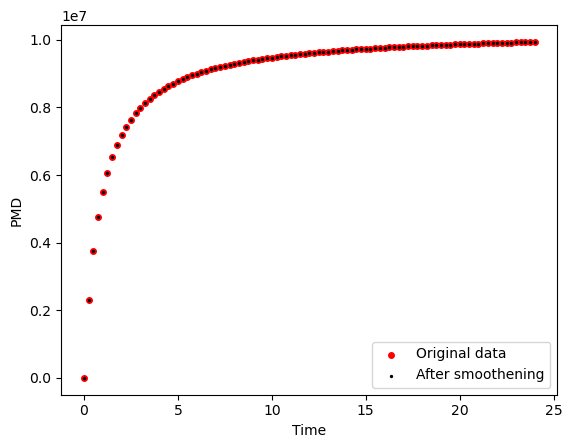

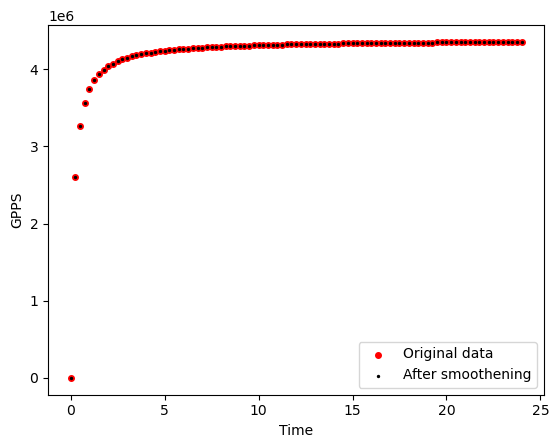

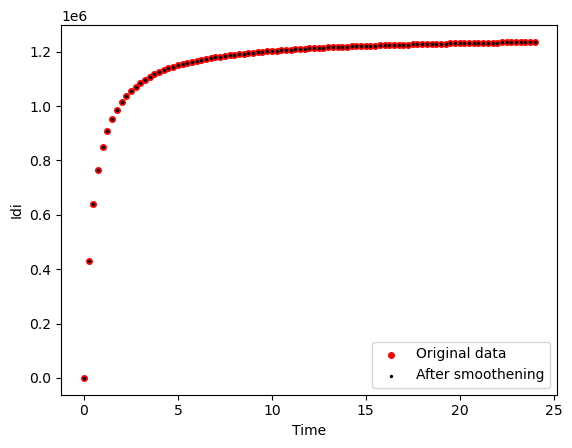

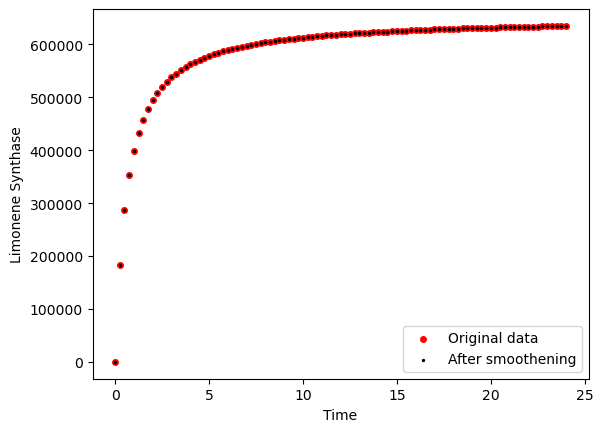

Strain Strain 2


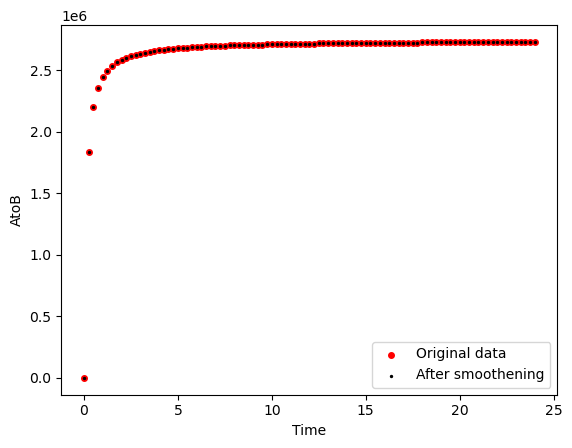

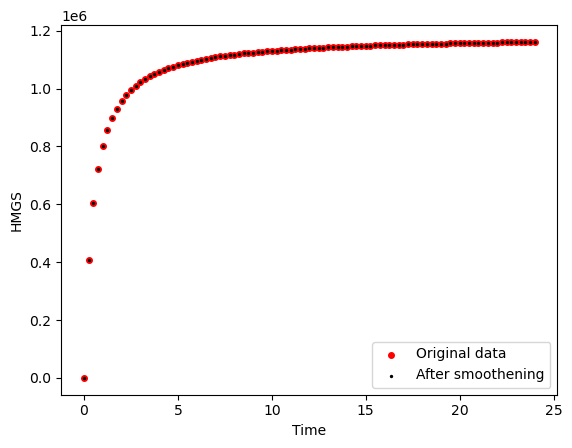

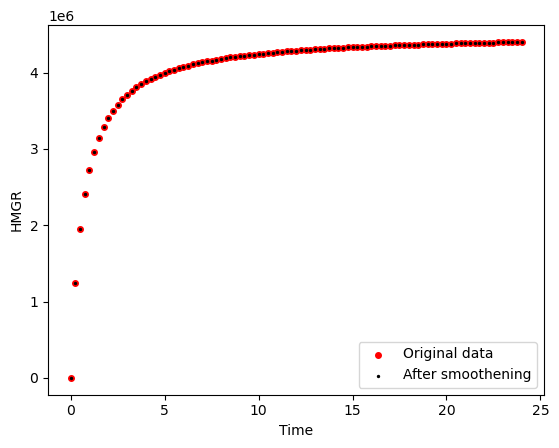

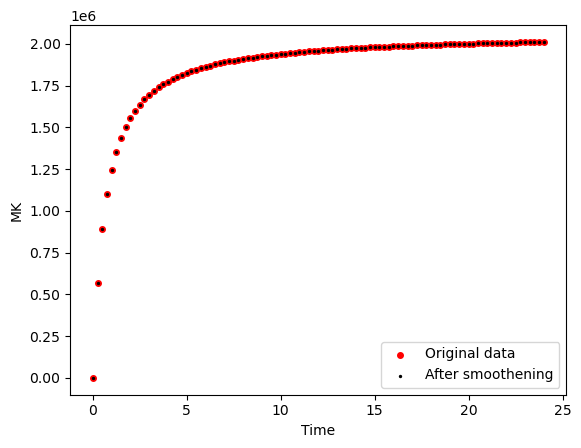

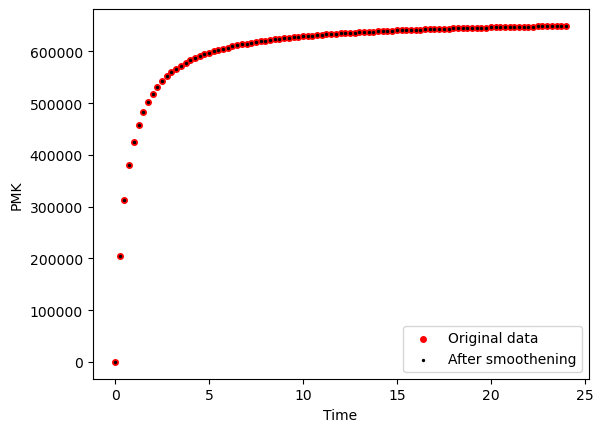

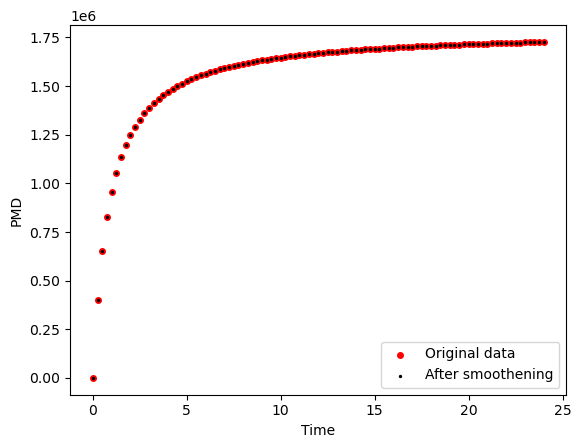

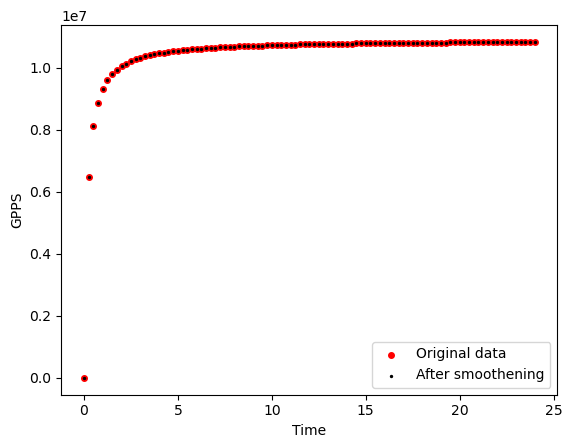

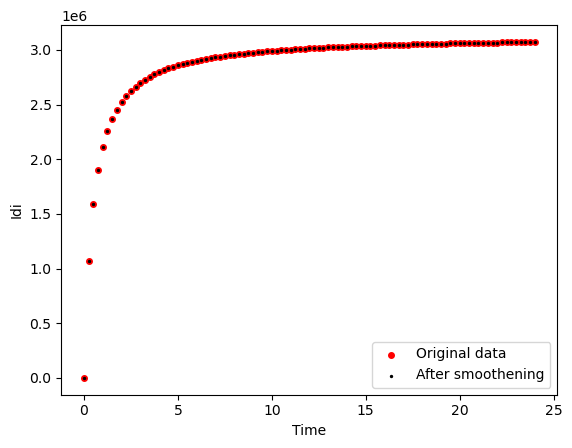

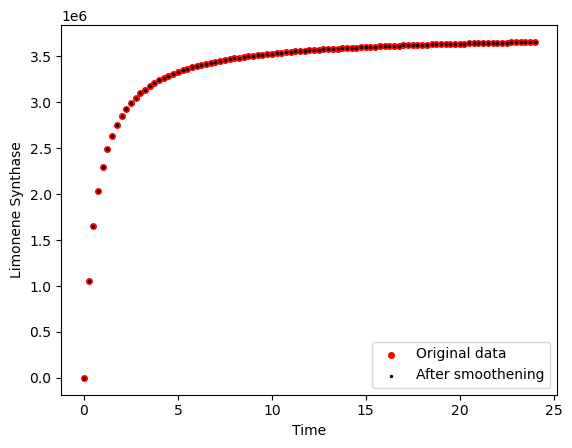

Strain Strain 3


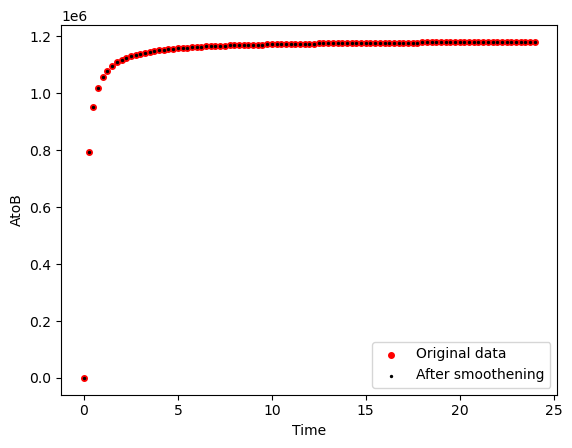

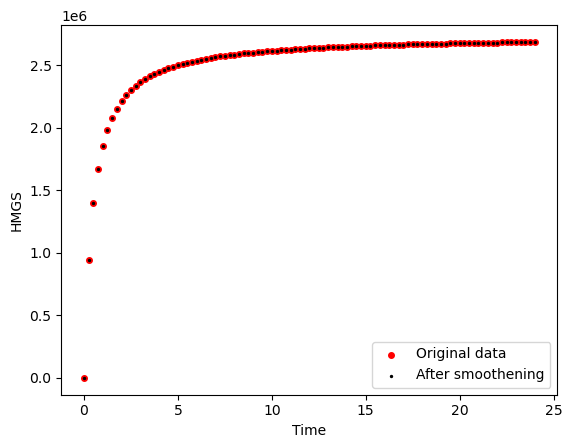

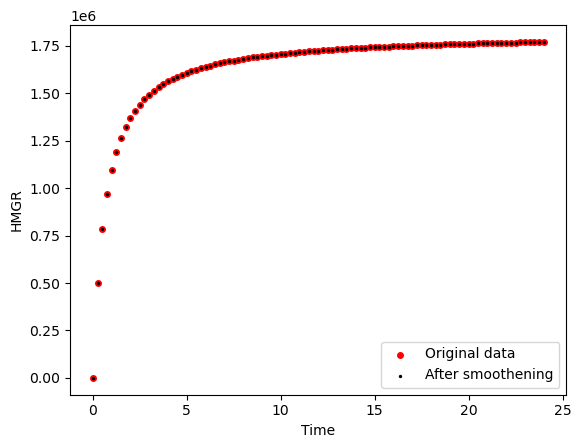

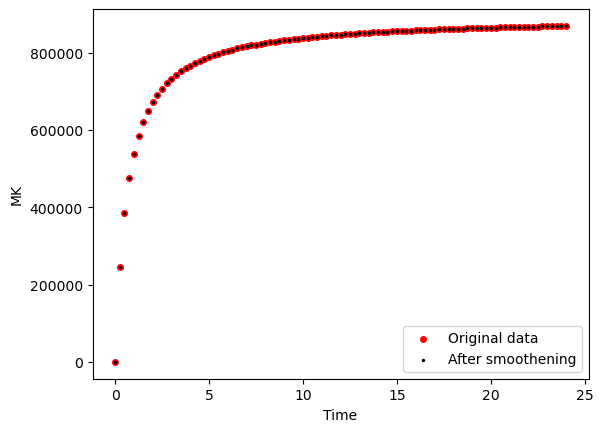

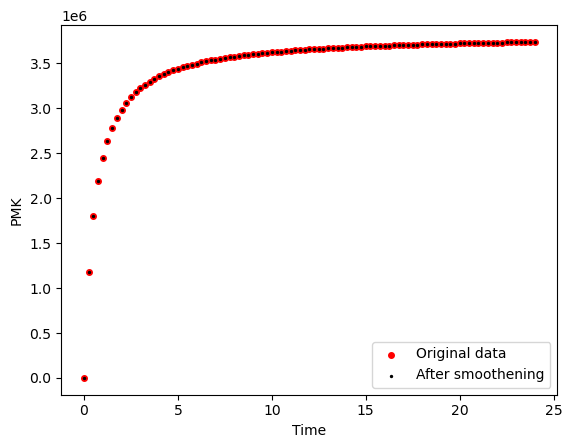

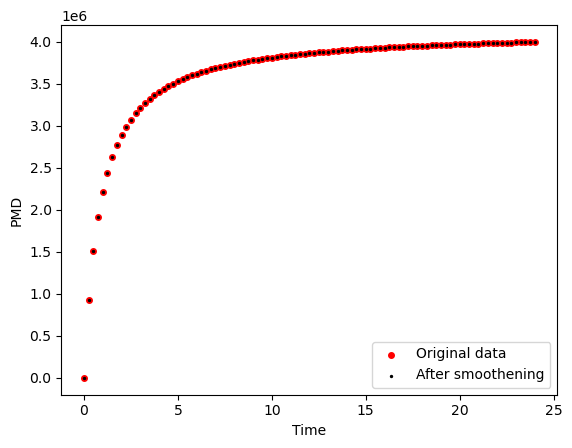

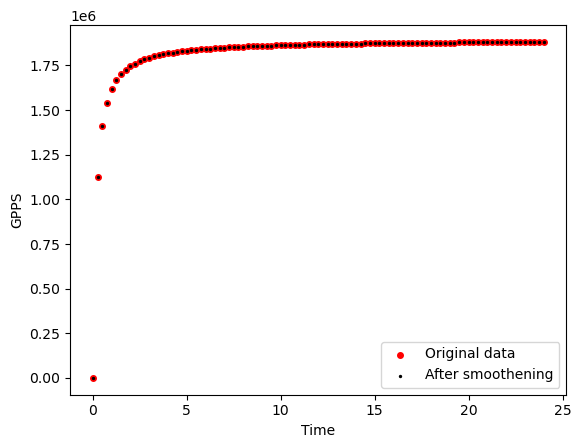

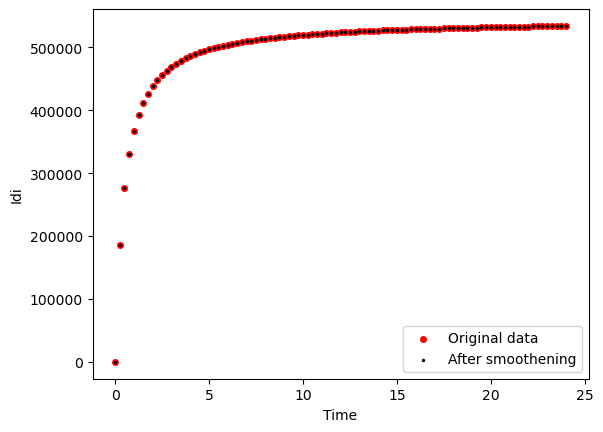

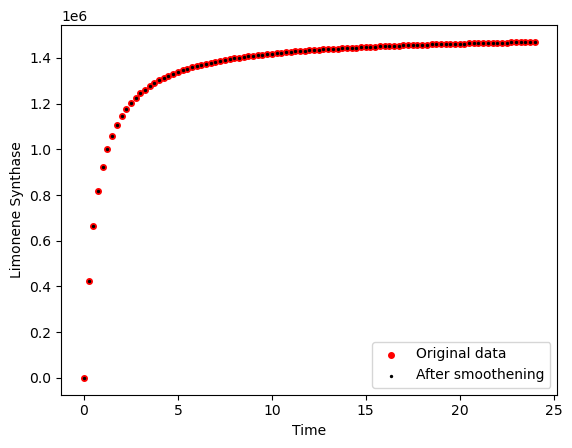

Strain WT


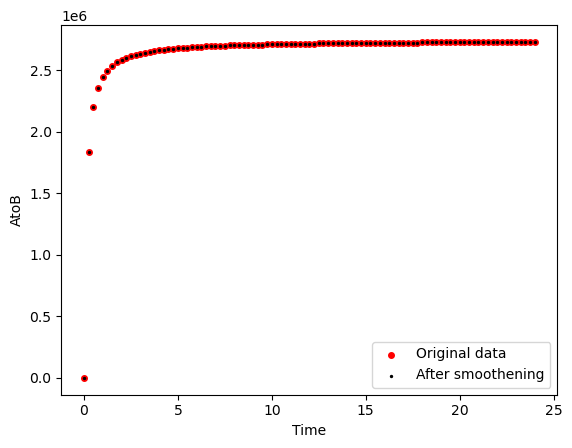

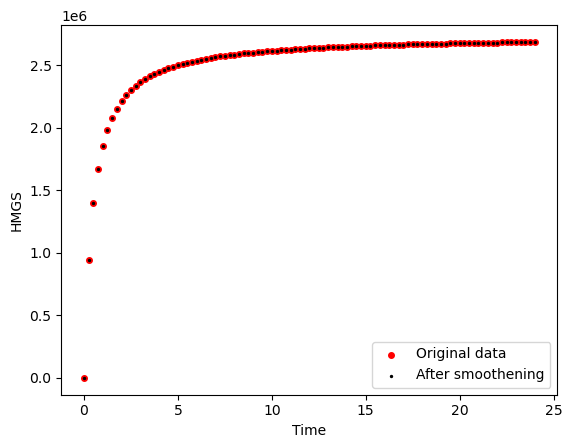

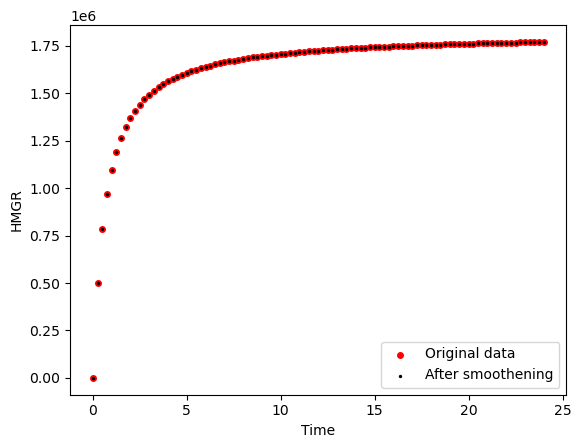

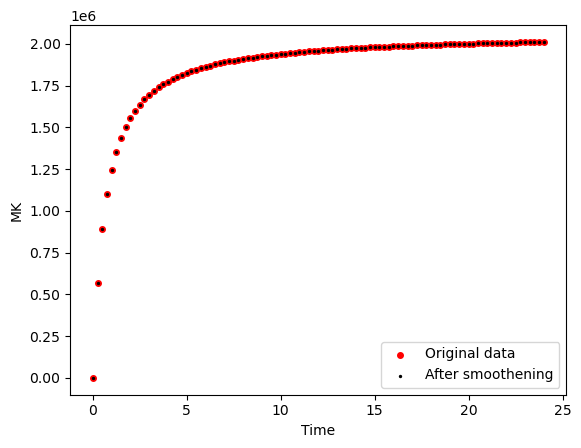

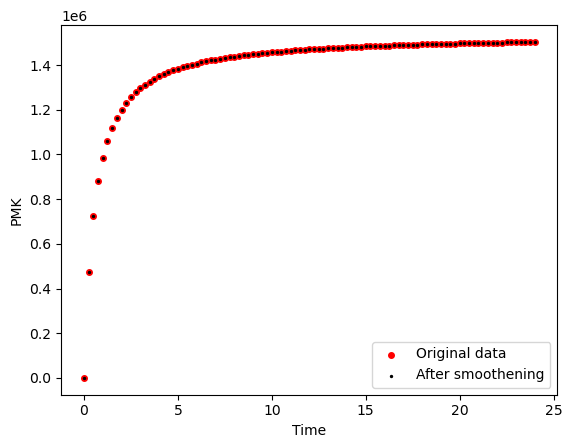

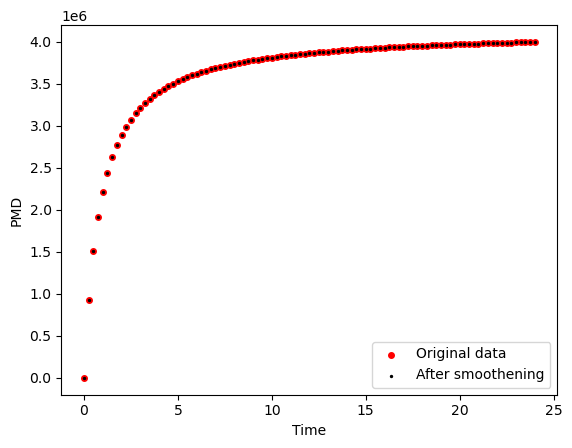

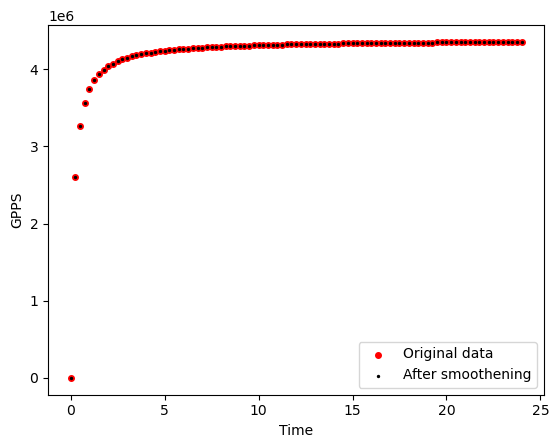

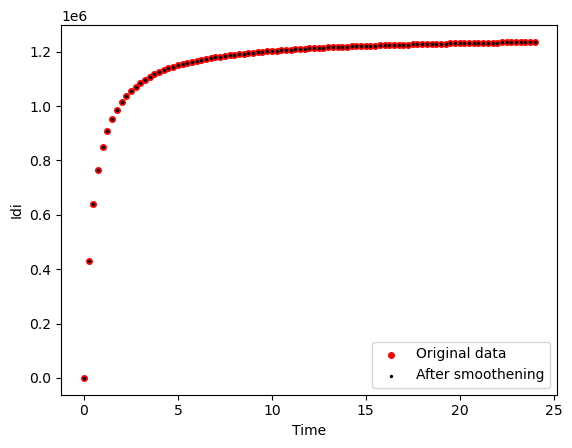

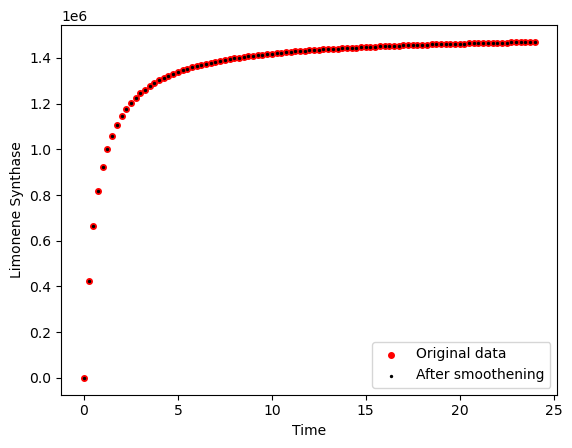

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

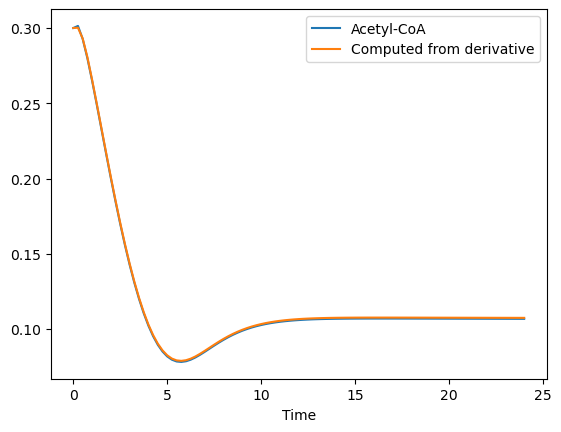

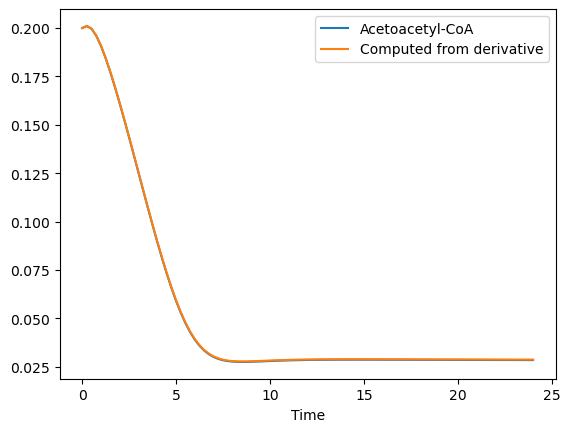

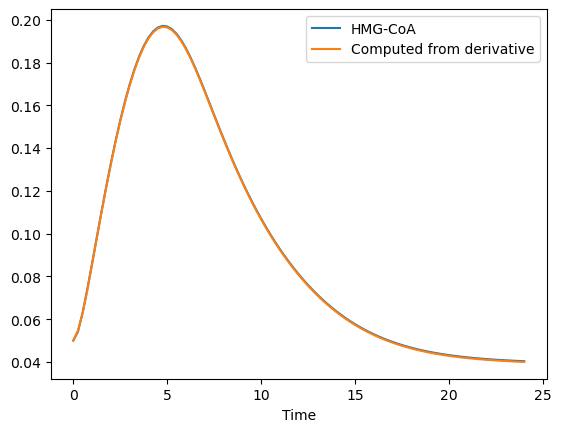

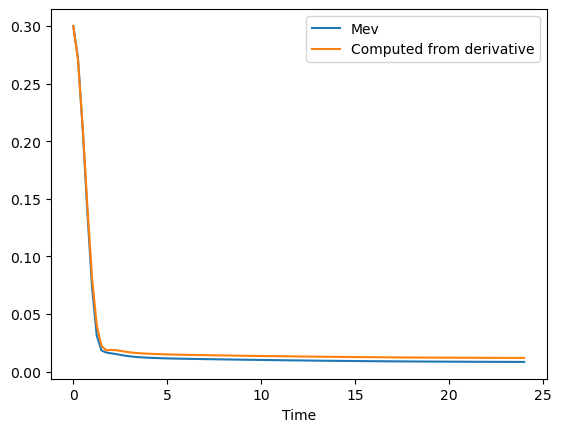

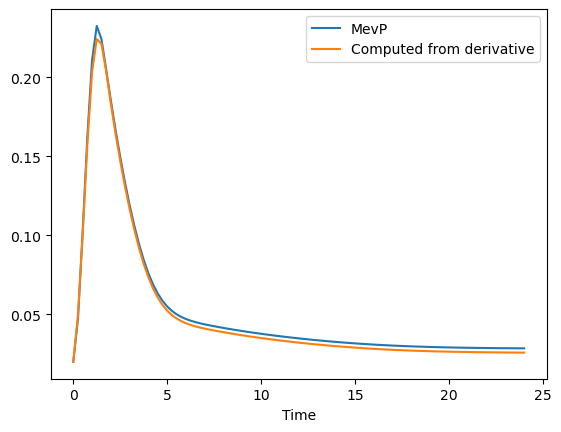

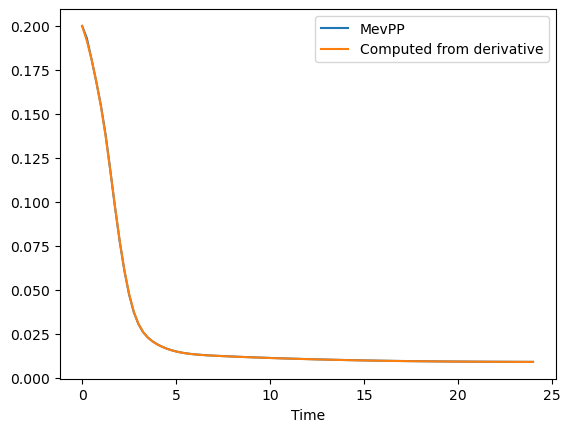

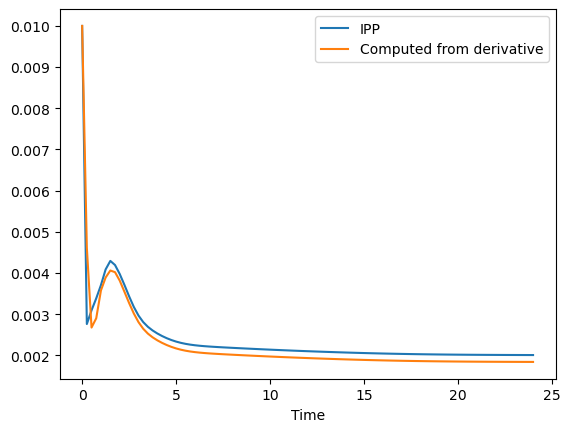

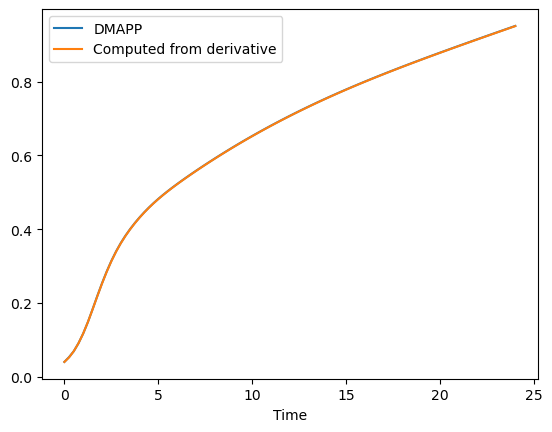

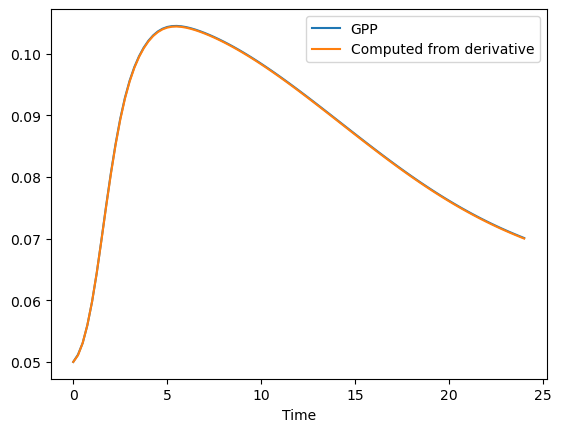

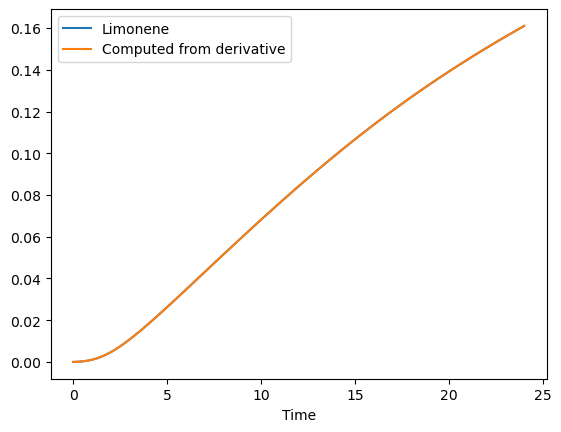

'Time profile from derivative vs. actual profile for Strain 2'

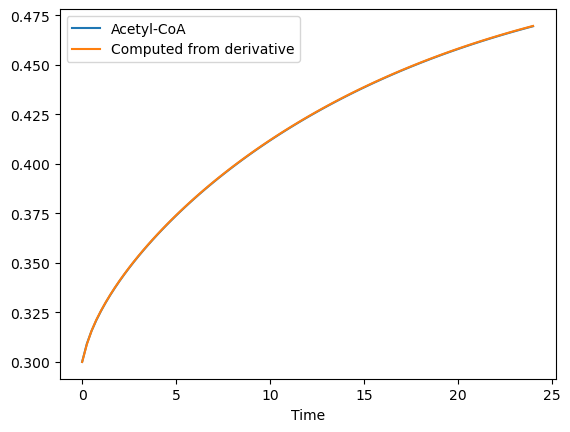

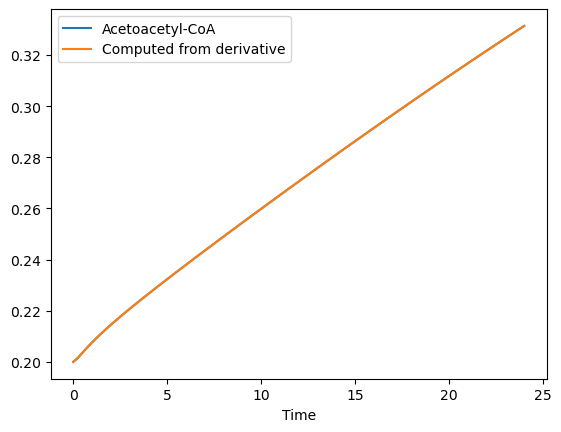

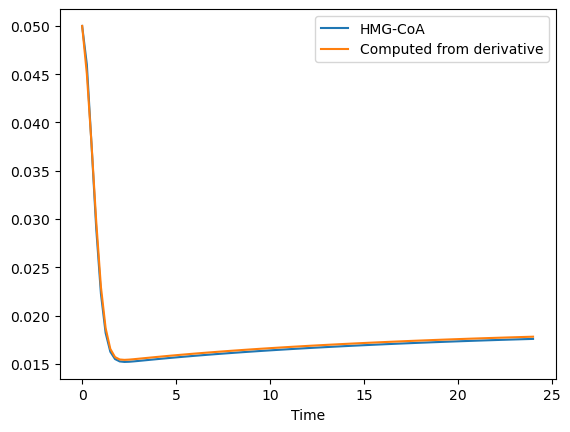

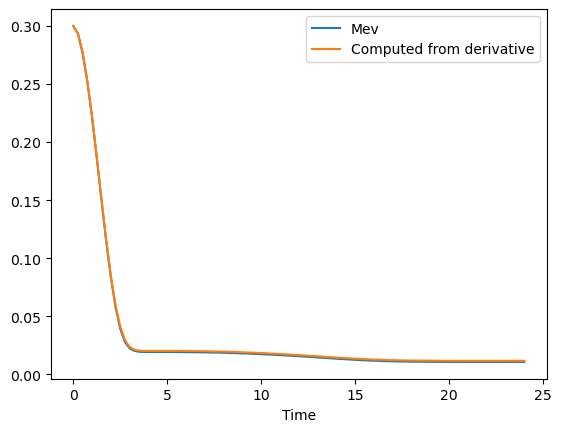

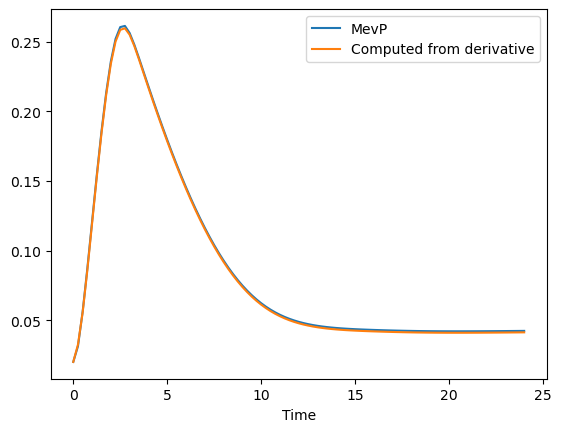

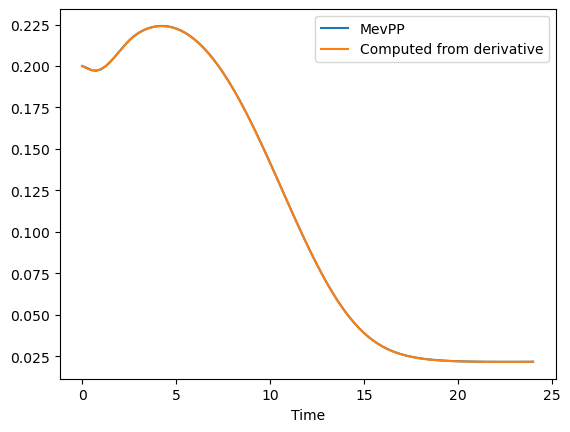

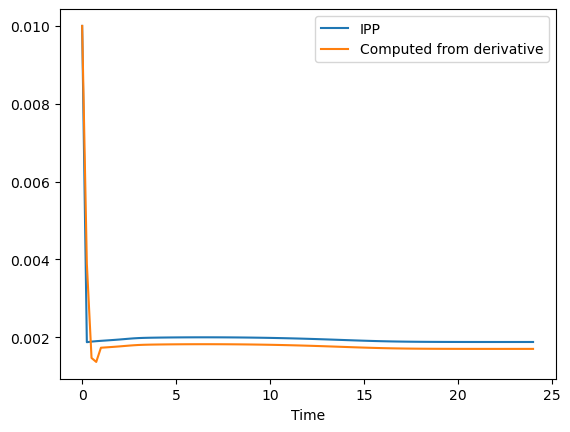

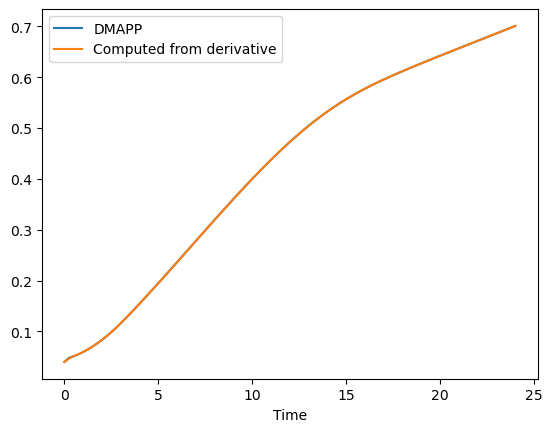

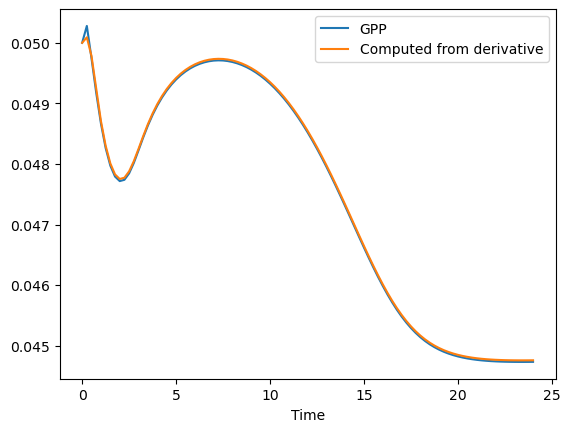

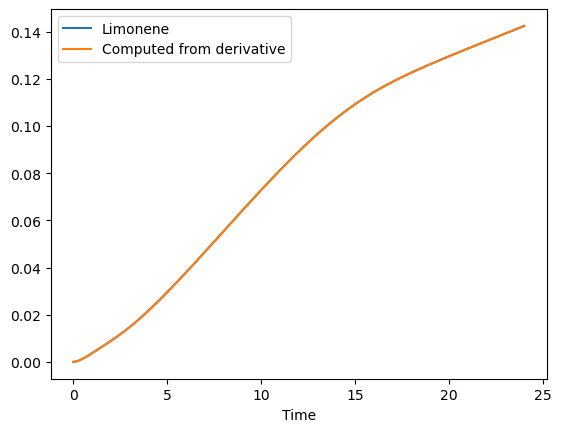

'Time profile from derivative vs. actual profile for Strain 3'

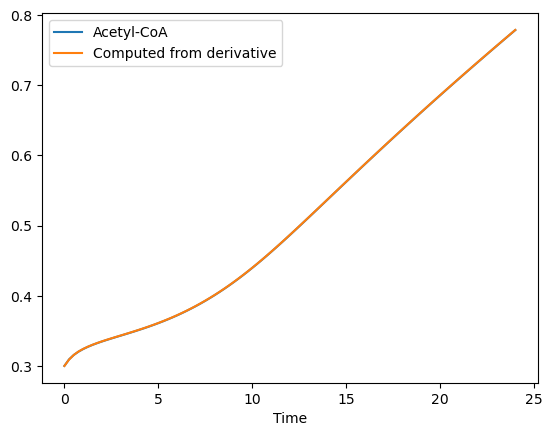

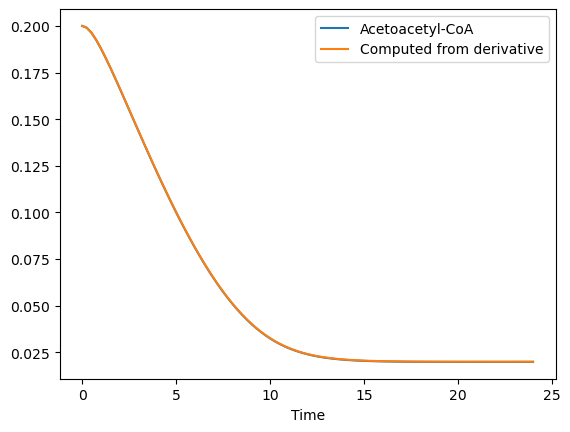

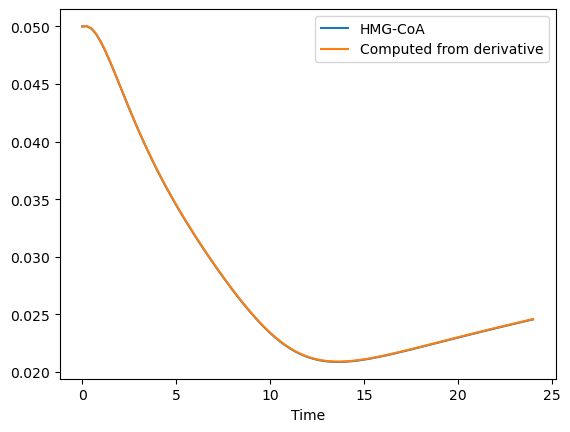

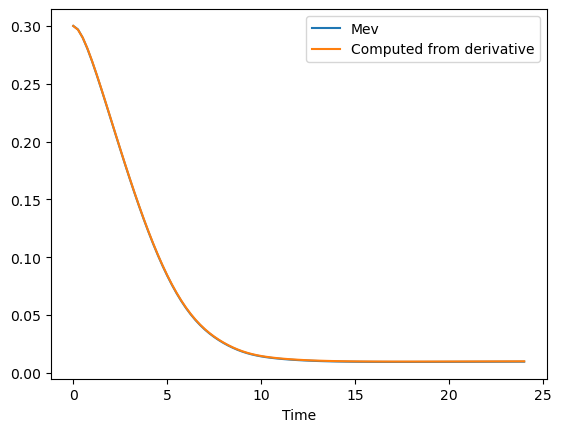

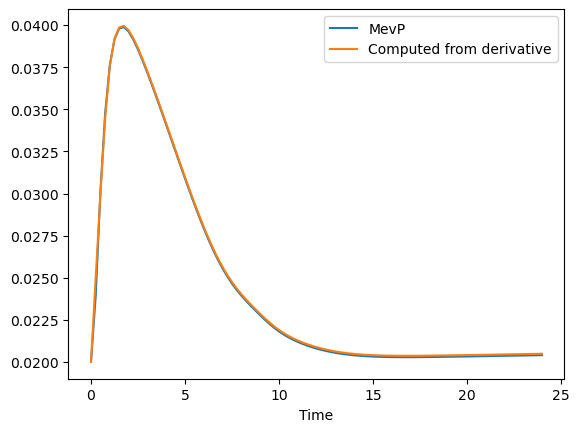

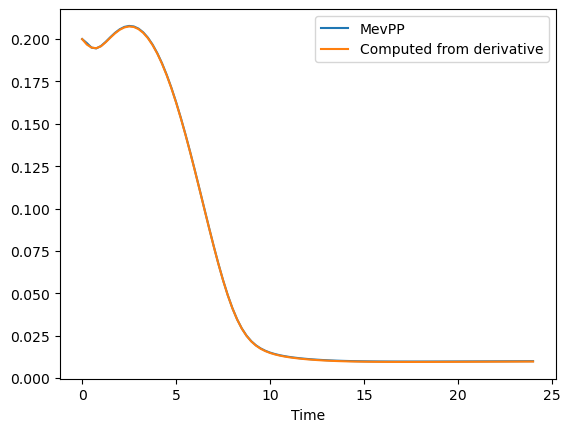

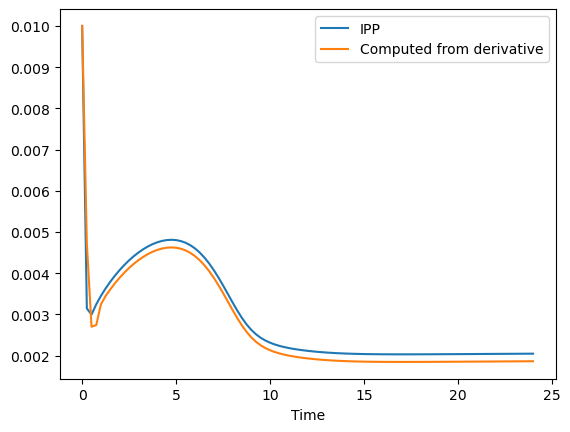

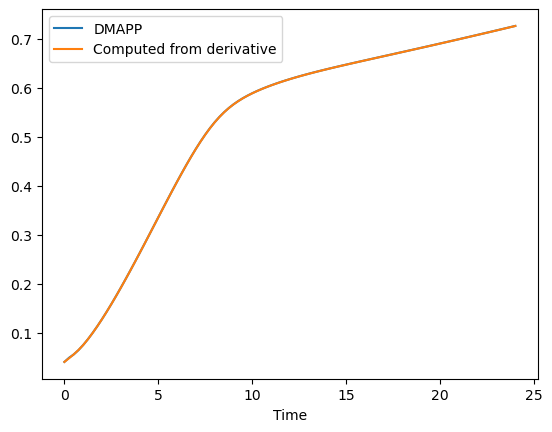

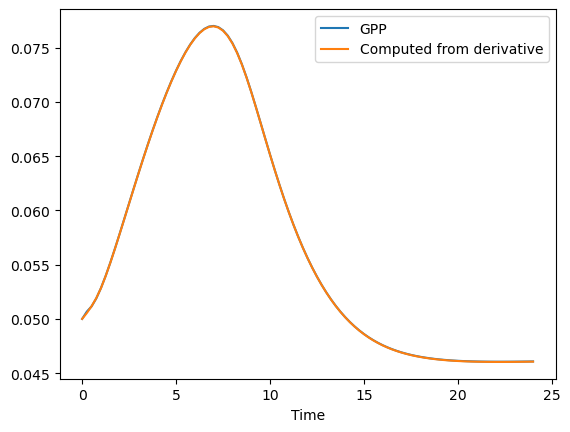

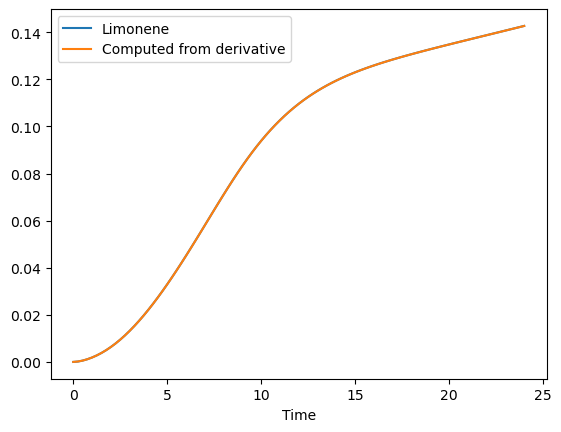

'Time profile from derivative vs. actual profile for WT'

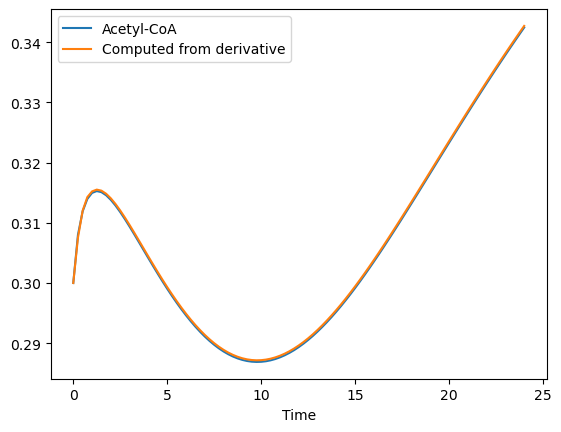

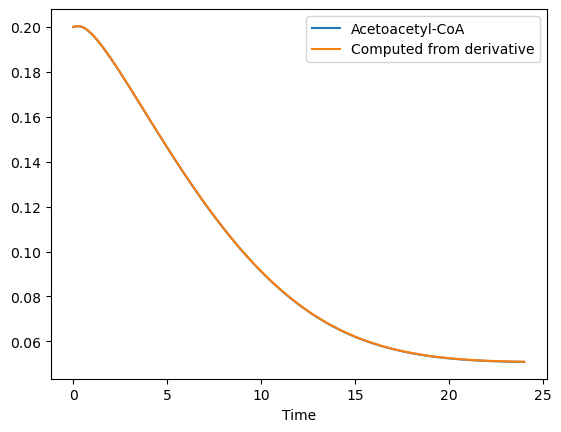

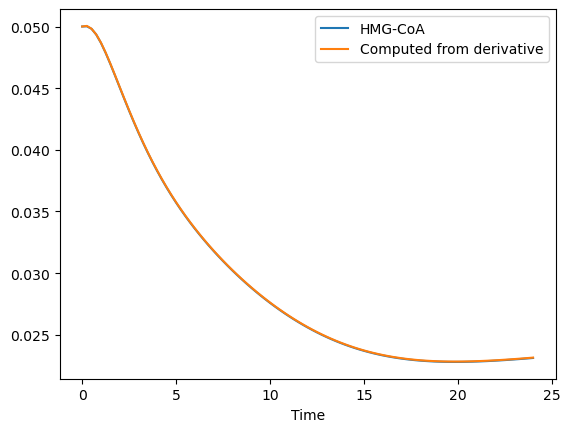

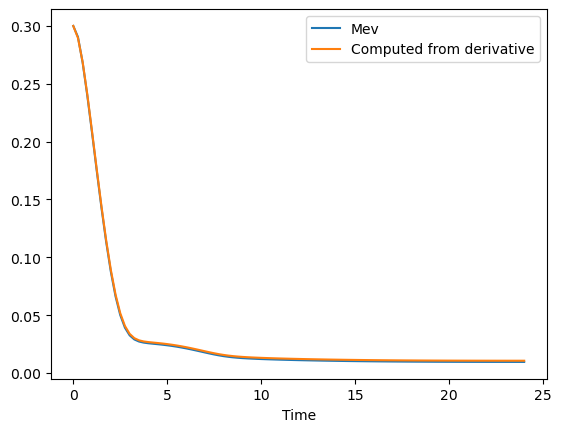

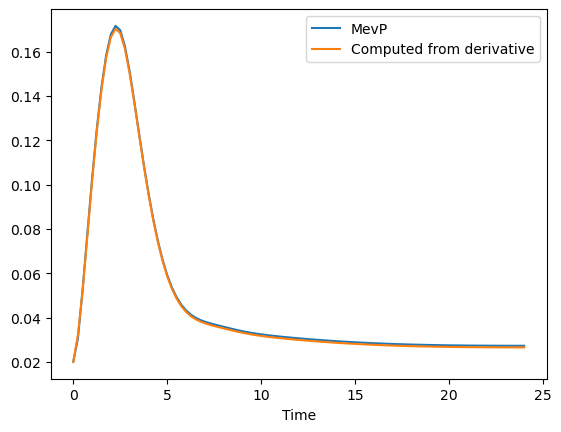

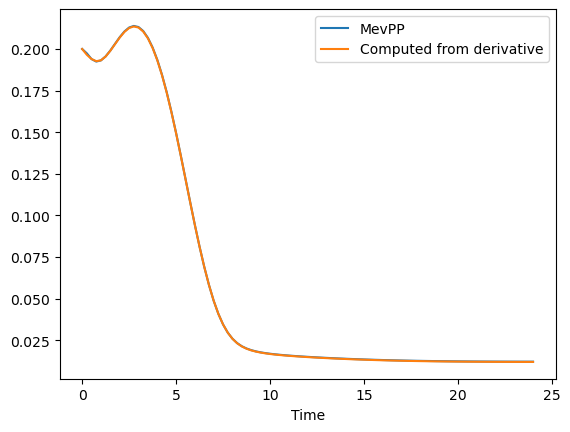

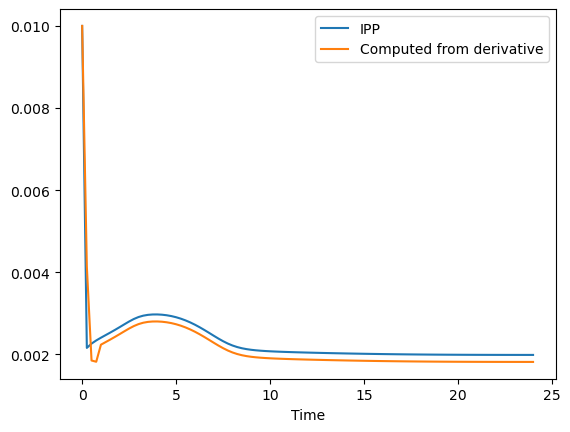

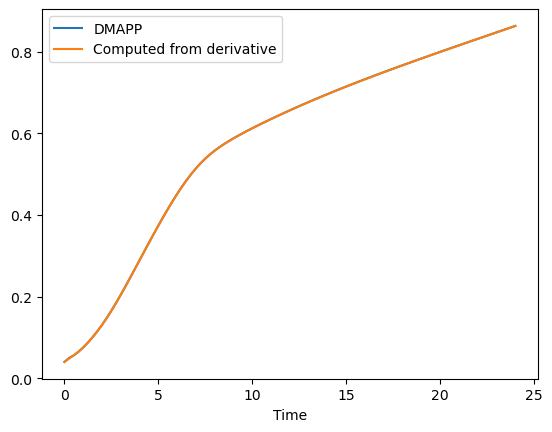

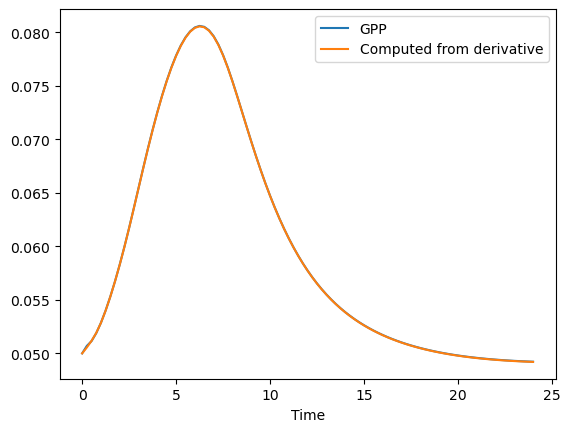

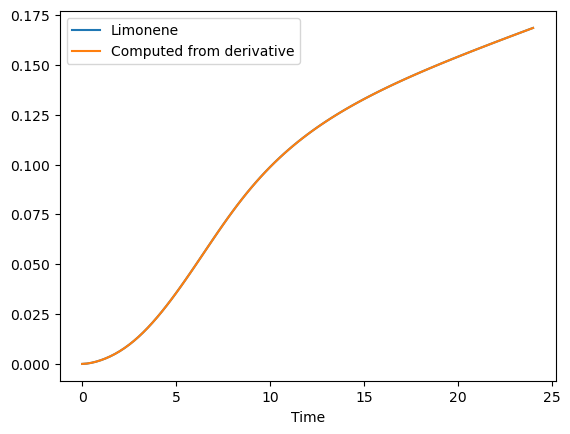

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  9.860935E+17 |  1.140769E+16
     2 |       74 |  3.161102E+15 |  8.900661E+13
     3 |      138 |  1.419381E+15 |  2.043423E+13
     4 |      202 |  1.021426E+14 |  4.211234E+12
     5 |      266 |  1.474713E+14 |  7.705302E+11
     6 |      330 |  5.149017E+12 |  7.705302E+11
     7 |      394 |  9.356221E+12 |  3.211341E+10
     8 |      458 |  2.525026E+12 |  3.211341E+10
     9 |      522 |  7.786286E+11 |  7.381919E+08
    10 |      586 |  1.131206E+12 |  7.381919E+08
    11 |      650 |  1.379656E+12 |  7.381919E+08
    12 |      714 |  1.210633E+12 |  7.381919E+08
    13 |      778 |  1.569783E+12 |  7.381919E+08
    14 |      842 |  5.252867E+11 |  7.381919E+08
    15 |      906 |  1.497330E+12 |  7.381919E+08
    16 |      970 |  1.607306E+11 |  7.381919E+08
    17 |     1034 |  3.907993E+10 |  7.381919E+08
    18 |     1098 |  2.804951E+10 |  7.381919E+08
    19 |     1162 |  3.765

   162 |    10314 |  3.631772E+01 |  3.505899E+01
   163 |    10378 |  3.608975E+01 |  3.481290E+01
   164 |    10442 |  3.584368E+01 |  3.481290E+01
   165 |    10506 |  3.557976E+01 |  3.481290E+01
   166 |    10570 |  3.560402E+01 |  3.481290E+01
   167 |    10634 |  3.542888E+01 |  3.481290E+01
   168 |    10698 |  3.552274E+01 |  3.481290E+01
   169 |    10762 |  3.565387E+01 |  3.481290E+01
   170 |    10826 |  3.550543E+01 |  3.481290E+01
   171 |    10890 |  3.557969E+01 |  3.481290E+01
   172 |    10954 |  3.483247E+01 |  3.417670E+01
   173 |    11018 |  3.453675E+01 |  3.338137E+01
   174 |    11082 |  3.445624E+01 |  3.338137E+01
   175 |    11146 |  3.418746E+01 |  3.338137E+01
   176 |    11210 |  3.418663E+01 |  3.338137E+01
   177 |    11274 |  3.433397E+01 |  3.338137E+01
   178 |    11338 |  3.399923E+01 |  3.338137E+01
   179 |    11402 |  3.373945E+01 |  3.299517E+01
   180 |    11466 |  3.357162E+01 |  3.299517E+01
   181 |    11530 |  3.324664E+01 |  3.263236E+01


   326 |    20810 |  2.423384E+01 |  2.420992E+01
   327 |    20874 |  2.421790E+01 |  2.417200E+01
   328 |    20938 |  2.418737E+01 |  2.416937E+01
   329 |    21002 |  2.418000E+01 |  2.415504E+01
   330 |    21066 |  2.416555E+01 |  2.414112E+01
   331 |    21130 |  2.415365E+01 |  2.411703E+01
   332 |    21194 |  2.413868E+01 |  2.407912E+01
   333 |    21258 |  2.411456E+01 |  2.407641E+01
   334 |    21322 |  2.409700E+01 |  2.405435E+01
   335 |    21386 |  2.409299E+01 |  2.405435E+01
   336 |    21450 |  2.408090E+01 |  2.405435E+01
   337 |    21514 |  2.407445E+01 |  2.405354E+01
   338 |    21578 |  2.407134E+01 |  2.404486E+01
   339 |    21642 |  2.405968E+01 |  2.402484E+01
   340 |    21706 |  2.405763E+01 |  2.402484E+01
   341 |    21770 |  2.404017E+01 |  2.400261E+01
   342 |    21834 |  2.401657E+01 |  2.399930E+01
   343 |    21898 |  2.400910E+01 |  2.398937E+01
   344 |    21962 |  2.399466E+01 |  2.396723E+01
   345 |    22026 |  2.398827E+01 |  2.396723E+01


   490 |    31306 |  2.264355E+01 |  2.263140E+01
   491 |    31370 |  2.263634E+01 |  2.261865E+01
   492 |    31434 |  2.262657E+01 |  2.261563E+01
   493 |    31498 |  2.262406E+01 |  2.260399E+01
   494 |    31562 |  2.260964E+01 |  2.258580E+01
   495 |    31626 |  2.260524E+01 |  2.258080E+01
   496 |    31690 |  2.258613E+01 |  2.255016E+01
   497 |    31754 |  2.256645E+01 |  2.253271E+01
   498 |    31818 |  2.254911E+01 |  2.252805E+01
   499 |    31882 |  2.252436E+01 |  2.250011E+01
   500 |    31946 |  2.250643E+01 |  2.247859E+01
   501 |    32010 |  2.248553E+01 |  2.245517E+01
   502 |    32074 |  2.244701E+01 |  2.241056E+01
   503 |    32138 |  2.243179E+01 |  2.240330E+01
   504 |    32202 |  2.240901E+01 |  2.237862E+01
   505 |    32266 |  2.238297E+01 |  2.235757E+01
   506 |    32330 |  2.236008E+01 |  2.230923E+01
   507 |    32394 |  2.233947E+01 |  2.228929E+01
   508 |    32458 |  2.232231E+01 |  2.226488E+01
   509 |    32522 |  2.230090E+01 |  2.226145E+01


   654 |    41802 |  2.105776E+01 |  2.104496E+01
   655 |    41866 |  2.105696E+01 |  2.104496E+01
   656 |    41930 |  2.104774E+01 |  2.102946E+01
   657 |    41994 |  2.103825E+01 |  2.102554E+01
   658 |    42058 |  2.103786E+01 |  2.102554E+01
   659 |    42122 |  2.103826E+01 |  2.102554E+01
   660 |    42186 |  2.103649E+01 |  2.102426E+01
   661 |    42250 |  2.102777E+01 |  2.101933E+01
   662 |    42314 |  2.101480E+01 |  2.099671E+01
   663 |    42378 |  2.100125E+01 |  2.098299E+01
   664 |    42442 |  2.098706E+01 |  2.097775E+01
   665 |    42506 |  2.098204E+01 |  2.097433E+01
   666 |    42570 |  2.097724E+01 |  2.096941E+01
   667 |    42634 |  2.097027E+01 |  2.095955E+01
   668 |    42698 |  2.096618E+01 |  2.095955E+01
   669 |    42762 |  2.095988E+01 |  2.095369E+01
   670 |    42826 |  2.095495E+01 |  2.094598E+01
   671 |    42890 |  2.094588E+01 |  2.093094E+01
   672 |    42954 |  2.093605E+01 |  2.092052E+01
   673 |    43018 |  2.092516E+01 |  2.090928E+01


   818 |    52298 |  1.984299E+01 |  1.982635E+01
   819 |    52362 |  1.983638E+01 |  1.982635E+01
   820 |    52426 |  1.983108E+01 |  1.982059E+01
   821 |    52490 |  1.982968E+01 |  1.981820E+01
   822 |    52554 |  1.982364E+01 |  1.980994E+01
   823 |    52618 |  1.982102E+01 |  1.980994E+01
   824 |    52682 |  1.981631E+01 |  1.980723E+01
   825 |    52746 |  1.980465E+01 |  1.979109E+01
   826 |    52810 |  1.979970E+01 |  1.979109E+01
   827 |    52874 |  1.979439E+01 |  1.978176E+01
   828 |    52938 |  1.978879E+01 |  1.978145E+01
   829 |    53002 |  1.977684E+01 |  1.976486E+01
   830 |    53066 |  1.977037E+01 |  1.975476E+01
   831 |    53130 |  1.976308E+01 |  1.975476E+01
   832 |    53194 |  1.976243E+01 |  1.975250E+01
   833 |    53258 |  1.975703E+01 |  1.974468E+01
   834 |    53322 |  1.975534E+01 |  1.972542E+01
   835 |    53386 |  1.974275E+01 |  1.972542E+01
   836 |    53450 |  1.973958E+01 |  1.972542E+01
   837 |    53514 |  1.973385E+01 |  1.972386E+01


   982 |    62794 |  1.859711E+01 |  1.857766E+01
   983 |    62858 |  1.858510E+01 |  1.857348E+01
   984 |    62922 |  1.857236E+01 |  1.855101E+01
   985 |    62986 |  1.855581E+01 |  1.853753E+01
   986 |    63050 |  1.854726E+01 |  1.853753E+01
   987 |    63114 |  1.854391E+01 |  1.852545E+01
   988 |    63178 |  1.853227E+01 |  1.851521E+01
   989 |    63242 |  1.852200E+01 |  1.849063E+01
   990 |    63306 |  1.851012E+01 |  1.848525E+01
   991 |    63370 |  1.851013E+01 |  1.848525E+01
   992 |    63434 |  1.849984E+01 |  1.845667E+01
   993 |    63498 |  1.848104E+01 |  1.845047E+01
   994 |    63562 |  1.846633E+01 |  1.844537E+01
   995 |    63626 |  1.846113E+01 |  1.843051E+01
   996 |    63690 |  1.845480E+01 |  1.843051E+01
   997 |    63754 |  1.845575E+01 |  1.843051E+01
   998 |    63818 |  1.843138E+01 |  1.841572E+01
   999 |    63882 |  1.842799E+01 |  1.841549E+01
  1000 |    63946 |  1.842409E+01 |  1.840354E+01
  1001 |    64010 |  1.842044E+01 |  1.840338E+01


  1146 |    73290 |  1.743473E+01 |  1.742876E+01
  1147 |    73354 |  1.743241E+01 |  1.742725E+01
  1148 |    73418 |  1.743041E+01 |  1.742586E+01
  1149 |    73482 |  1.742453E+01 |  1.741891E+01
  1150 |    73546 |  1.742195E+01 |  1.740915E+01
  1151 |    73610 |  1.741432E+01 |  1.740440E+01
  1152 |    73674 |  1.741185E+01 |  1.740044E+01
  1153 |    73738 |  1.740576E+01 |  1.739835E+01
  1154 |    73802 |  1.739687E+01 |  1.739056E+01
  1155 |    73866 |  1.739228E+01 |  1.738876E+01
  1156 |    73930 |  1.739039E+01 |  1.738730E+01
  1157 |    73994 |  1.738645E+01 |  1.738228E+01
  1158 |    74058 |  1.738541E+01 |  1.737525E+01
  1159 |    74122 |  1.737988E+01 |  1.737399E+01
  1160 |    74186 |  1.737680E+01 |  1.737084E+01
  1161 |    74250 |  1.737339E+01 |  1.735972E+01
  1162 |    74314 |  1.736644E+01 |  1.735972E+01
  1163 |    74378 |  1.736358E+01 |  1.735700E+01
  1164 |    74442 |  1.735964E+01 |  1.735433E+01
  1165 |    74506 |  1.735690E+01 |  1.735419E+01


  1310 |    83786 |  1.655017E+01 |  1.654095E+01
  1311 |    83850 |  1.654485E+01 |  1.653569E+01
  1312 |    83914 |  1.653855E+01 |  1.653007E+01
  1313 |    83978 |  1.653328E+01 |  1.652824E+01
  1314 |    84042 |  1.652867E+01 |  1.652374E+01
  1315 |    84106 |  1.652881E+01 |  1.652374E+01
  1316 |    84170 |  1.652613E+01 |  1.652328E+01
  1317 |    84234 |  1.652434E+01 |  1.652061E+01
  1318 |    84298 |  1.652082E+01 |  1.651650E+01
  1319 |    84362 |  1.651661E+01 |  1.651397E+01
  1320 |    84426 |  1.651534E+01 |  1.651332E+01
  1321 |    84490 |  1.651403E+01 |  1.651064E+01
  1322 |    84554 |  1.651098E+01 |  1.650798E+01
  1323 |    84618 |  1.650979E+01 |  1.650791E+01
  1324 |    84682 |  1.650850E+01 |  1.650639E+01
  1325 |    84746 |  1.650838E+01 |  1.650579E+01
  1326 |    84810 |  1.650750E+01 |  1.650506E+01
  1327 |    84874 |  1.650533E+01 |  1.650220E+01
  1328 |    84938 |  1.650393E+01 |  1.650060E+01
  1329 |    85002 |  1.650224E+01 |  1.649896E+01


  1474 |    94282 |  1.623834E+01 |  1.622730E+01
  1475 |    94346 |  1.623509E+01 |  1.622730E+01
  1476 |    94410 |  1.623217E+01 |  1.622730E+01
  1477 |    94474 |  1.622896E+01 |  1.622166E+01
  1478 |    94538 |  1.622671E+01 |  1.622166E+01
  1479 |    94602 |  1.622620E+01 |  1.622166E+01
  1480 |    94666 |  1.622408E+01 |  1.622166E+01
  1481 |    94730 |  1.622241E+01 |  1.622043E+01
  1482 |    94794 |  1.622251E+01 |  1.622043E+01
  1483 |    94858 |  1.622165E+01 |  1.621845E+01
  1484 |    94922 |  1.622119E+01 |  1.621763E+01
  1485 |    94986 |  1.622035E+01 |  1.621763E+01
  1486 |    95050 |  1.622071E+01 |  1.621763E+01
  1487 |    95114 |  1.622003E+01 |  1.621763E+01
  1488 |    95178 |  1.621871E+01 |  1.621557E+01
  1489 |    95242 |  1.621810E+01 |  1.621557E+01
  1490 |    95306 |  1.621857E+01 |  1.621557E+01
  1491 |    95370 |  1.621885E+01 |  1.621557E+01
  1492 |    95434 |  1.621611E+01 |  1.621349E+01
  1493 |    95498 |  1.621572E+01 |  1.621349E+01


  1638 |   104778 |  1.598543E+01 |  1.598285E+01
  1639 |   104842 |  1.598342E+01 |  1.598263E+01
  1640 |   104906 |  1.598171E+01 |  1.597953E+01
  1641 |   104970 |  1.597990E+01 |  1.597857E+01
  1642 |   105034 |  1.597828E+01 |  1.597717E+01
  1643 |   105098 |  1.597659E+01 |  1.597524E+01
  1644 |   105162 |  1.597500E+01 |  1.597374E+01
  1645 |   105226 |  1.597431E+01 |  1.597170E+01
  1646 |   105290 |  1.597259E+01 |  1.596964E+01
  1647 |   105354 |  1.597070E+01 |  1.596911E+01
  1648 |   105418 |  1.596776E+01 |  1.596518E+01
  1649 |   105482 |  1.596547E+01 |  1.596207E+01
  1650 |   105546 |  1.596221E+01 |  1.595739E+01
  1651 |   105610 |  1.595943E+01 |  1.595734E+01
  1652 |   105674 |  1.595679E+01 |  1.595404E+01
  1653 |   105738 |  1.595499E+01 |  1.595237E+01
  1654 |   105802 |  1.595302E+01 |  1.594899E+01
  1655 |   105866 |  1.595062E+01 |  1.594543E+01
  1656 |   105930 |  1.594732E+01 |  1.594360E+01
  1657 |   105994 |  1.594583E+01 |  1.594360E+01


  1802 |   115274 |  1.552840E+01 |  1.552181E+01
  1803 |   115338 |  1.552888E+01 |  1.552181E+01
  1804 |   115402 |  1.552369E+01 |  1.551733E+01
  1805 |   115466 |  1.551951E+01 |  1.551536E+01
  1806 |   115530 |  1.551737E+01 |  1.551086E+01
  1807 |   115594 |  1.551319E+01 |  1.550823E+01
  1808 |   115658 |  1.550948E+01 |  1.550631E+01
  1809 |   115722 |  1.550823E+01 |  1.550245E+01
  1810 |   115786 |  1.550571E+01 |  1.550245E+01
  1811 |   115850 |  1.550452E+01 |  1.550164E+01
  1812 |   115914 |  1.550343E+01 |  1.550097E+01
  1813 |   115978 |  1.550236E+01 |  1.549886E+01
  1814 |   116042 |  1.550191E+01 |  1.549745E+01
  1815 |   116106 |  1.550074E+01 |  1.549720E+01
  1816 |   116170 |  1.550131E+01 |  1.549720E+01
  1817 |   116234 |  1.549919E+01 |  1.549510E+01
  1818 |   116298 |  1.549422E+01 |  1.548826E+01
  1819 |   116362 |  1.549115E+01 |  1.548673E+01
  1820 |   116426 |  1.548790E+01 |  1.548530E+01
  1821 |   116490 |  1.548587E+01 |  1.548403E+01


  1966 |   125770 |  1.527779E+01 |  1.527677E+01
  1967 |   125834 |  1.527664E+01 |  1.527453E+01
  1968 |   125898 |  1.527575E+01 |  1.527287E+01
  1969 |   125962 |  1.527389E+01 |  1.527186E+01
  1970 |   126026 |  1.527175E+01 |  1.527047E+01
  1971 |   126090 |  1.527033E+01 |  1.526893E+01
  1972 |   126154 |  1.526960E+01 |  1.526859E+01
  1973 |   126218 |  1.526848E+01 |  1.526697E+01
  1974 |   126282 |  1.526652E+01 |  1.526491E+01
  1975 |   126346 |  1.526591E+01 |  1.526461E+01
  1976 |   126410 |  1.526480E+01 |  1.526353E+01
  1977 |   126474 |  1.526428E+01 |  1.526202E+01
  1978 |   126538 |  1.526289E+01 |  1.526183E+01
  1979 |   126602 |  1.526195E+01 |  1.526079E+01
  1980 |   126666 |  1.526068E+01 |  1.525939E+01
  1981 |   126730 |  1.526036E+01 |  1.525769E+01
  1982 |   126794 |  1.525880E+01 |  1.525734E+01
  1983 |   126858 |  1.525808E+01 |  1.525702E+01
  1984 |   126922 |  1.525720E+01 |  1.525670E+01
  1985 |   126986 |  1.525648E+01 |  1.525440E+01


  2130 |   136266 |  1.511447E+01 |  1.511256E+01
  2131 |   136330 |  1.511270E+01 |  1.510997E+01
  2132 |   136394 |  1.511186E+01 |  1.510992E+01
  2133 |   136458 |  1.511170E+01 |  1.510992E+01
  2134 |   136522 |  1.511105E+01 |  1.510992E+01
  2135 |   136586 |  1.511031E+01 |  1.510848E+01
  2136 |   136650 |  1.510896E+01 |  1.510665E+01
  2137 |   136714 |  1.510724E+01 |  1.510462E+01
  2138 |   136778 |  1.510499E+01 |  1.510302E+01
  2139 |   136842 |  1.510374E+01 |  1.510077E+01
  2140 |   136906 |  1.510240E+01 |  1.510009E+01
  2141 |   136970 |  1.510126E+01 |  1.509843E+01
  2142 |   137034 |  1.509843E+01 |  1.509579E+01
  2143 |   137098 |  1.509655E+01 |  1.509539E+01
  2144 |   137162 |  1.509529E+01 |  1.509279E+01
  2145 |   137226 |  1.509354E+01 |  1.509179E+01
  2146 |   137290 |  1.509247E+01 |  1.509106E+01
  2147 |   137354 |  1.509229E+01 |  1.509102E+01
  2148 |   137418 |  1.509156E+01 |  1.508999E+01
  2149 |   137482 |  1.509020E+01 |  1.508933E+01


  2294 |   146762 |  1.465801E+01 |  1.465426E+01
  2295 |   146826 |  1.465545E+01 |  1.465246E+01
  2296 |   146890 |  1.465432E+01 |  1.465246E+01
  2297 |   146954 |  1.465487E+01 |  1.465189E+01
  2298 |   147018 |  1.465275E+01 |  1.464833E+01
  2299 |   147082 |  1.465097E+01 |  1.464786E+01
  2300 |   147146 |  1.464875E+01 |  1.464659E+01
  2301 |   147210 |  1.464759E+01 |  1.464476E+01
  2302 |   147274 |  1.464767E+01 |  1.464469E+01
  2303 |   147338 |  1.464432E+01 |  1.463824E+01
  2304 |   147402 |  1.464195E+01 |  1.463824E+01
  2305 |   147466 |  1.464028E+01 |  1.463653E+01
  2306 |   147530 |  1.463850E+01 |  1.463060E+01
  2307 |   147594 |  1.463470E+01 |  1.462770E+01
  2308 |   147658 |  1.462996E+01 |  1.462700E+01
  2309 |   147722 |  1.462576E+01 |  1.461914E+01
  2310 |   147786 |  1.461854E+01 |  1.461671E+01
  2311 |   147850 |  1.461537E+01 |  1.461382E+01
  2312 |   147914 |  1.461222E+01 |  1.460823E+01
  2313 |   147978 |  1.461096E+01 |  1.460823E+01


  2458 |   157258 |  1.389702E+01 |  1.388857E+01
  2459 |   157322 |  1.388794E+01 |  1.386987E+01
  2460 |   157386 |  1.388270E+01 |  1.386987E+01
  2461 |   157450 |  1.387373E+01 |  1.386343E+01
  2462 |   157514 |  1.386584E+01 |  1.385028E+01
  2463 |   157578 |  1.385491E+01 |  1.383871E+01
  2464 |   157642 |  1.384715E+01 |  1.382144E+01
  2465 |   157706 |  1.383064E+01 |  1.381958E+01
  2466 |   157770 |  1.382796E+01 |  1.380283E+01
  2467 |   157834 |  1.381518E+01 |  1.380283E+01
  2468 |   157898 |  1.381082E+01 |  1.379363E+01
  2469 |   157962 |  1.380012E+01 |  1.378825E+01
  2470 |   158026 |  1.379169E+01 |  1.377701E+01
  2471 |   158090 |  1.378327E+01 |  1.377388E+01
  2472 |   158154 |  1.377641E+01 |  1.376731E+01
  2473 |   158218 |  1.377015E+01 |  1.376416E+01
  2474 |   158282 |  1.376596E+01 |  1.375624E+01
  2475 |   158346 |  1.375878E+01 |  1.374462E+01
  2476 |   158410 |  1.375394E+01 |  1.374462E+01
  2477 |   158474 |  1.375271E+01 |  1.373962E+01


  2622 |   167754 |  1.215637E+01 |  1.215265E+01
  2623 |   167818 |  1.215041E+01 |  1.214575E+01
  2624 |   167882 |  1.214587E+01 |  1.214302E+01
  2625 |   167946 |  1.214380E+01 |  1.213570E+01
  2626 |   168010 |  1.213871E+01 |  1.213367E+01
  2627 |   168074 |  1.213489E+01 |  1.213335E+01
  2628 |   168138 |  1.213252E+01 |  1.212963E+01
  2629 |   168202 |  1.213069E+01 |  1.212835E+01
  2630 |   168266 |  1.212813E+01 |  1.212150E+01
  2631 |   168330 |  1.212298E+01 |  1.211903E+01
  2632 |   168394 |  1.212058E+01 |  1.211530E+01
  2633 |   168458 |  1.211607E+01 |  1.211106E+01
  2634 |   168522 |  1.211325E+01 |  1.210975E+01
  2635 |   168586 |  1.211063E+01 |  1.210536E+01
  2636 |   168650 |  1.210926E+01 |  1.210536E+01
  2637 |   168714 |  1.210711E+01 |  1.210184E+01
  2638 |   168778 |  1.210420E+01 |  1.210057E+01
  2639 |   168842 |  1.210159E+01 |  1.209886E+01
  2640 |   168906 |  1.209964E+01 |  1.209570E+01
  2641 |   168970 |  1.209708E+01 |  1.209489E+01


  2786 |   178250 |  1.183535E+01 |  1.183142E+01
  2787 |   178314 |  1.183213E+01 |  1.182721E+01
  2788 |   178378 |  1.182896E+01 |  1.182695E+01
  2789 |   178442 |  1.182744E+01 |  1.182572E+01
  2790 |   178506 |  1.182514E+01 |  1.182302E+01
  2791 |   178570 |  1.182291E+01 |  1.182076E+01
  2792 |   178634 |  1.182202E+01 |  1.182025E+01
  2793 |   178698 |  1.182050E+01 |  1.181844E+01
  2794 |   178762 |  1.181847E+01 |  1.181399E+01
  2795 |   178826 |  1.181632E+01 |  1.181308E+01
  2796 |   178890 |  1.181457E+01 |  1.181308E+01
  2797 |   178954 |  1.181285E+01 |  1.180927E+01
  2798 |   179018 |  1.181028E+01 |  1.180796E+01
  2799 |   179082 |  1.180741E+01 |  1.180587E+01
  2800 |   179146 |  1.180621E+01 |  1.180511E+01
  2801 |   179210 |  1.180506E+01 |  1.180315E+01
  2802 |   179274 |  1.180354E+01 |  1.180169E+01
  2803 |   179338 |  1.180312E+01 |  1.180141E+01
  2804 |   179402 |  1.180141E+01 |  1.179923E+01
  2805 |   179466 |  1.179935E+01 |  1.179807E+01


  2950 |   188746 |  1.155990E+01 |  1.155764E+01
  2951 |   188810 |  1.155903E+01 |  1.155482E+01
  2952 |   188874 |  1.155873E+01 |  1.155482E+01
  2953 |   188938 |  1.155664E+01 |  1.155437E+01
  2954 |   189002 |  1.155586E+01 |  1.155412E+01
  2955 |   189066 |  1.155526E+01 |  1.155273E+01
  2956 |   189130 |  1.155438E+01 |  1.155073E+01
  2957 |   189194 |  1.155247E+01 |  1.154601E+01
  2958 |   189258 |  1.154981E+01 |  1.154601E+01
  2959 |   189322 |  1.154805E+01 |  1.154225E+01
  2960 |   189386 |  1.154586E+01 |  1.154225E+01
  2961 |   189450 |  1.154454E+01 |  1.154070E+01
  2962 |   189514 |  1.154320E+01 |  1.154070E+01
  2963 |   189578 |  1.154211E+01 |  1.153897E+01
  2964 |   189642 |  1.154205E+01 |  1.153897E+01
  2965 |   189706 |  1.154062E+01 |  1.153791E+01
  2966 |   189770 |  1.153966E+01 |  1.153676E+01
  2967 |   189834 |  1.153859E+01 |  1.153381E+01
  2968 |   189898 |  1.153621E+01 |  1.153341E+01
  2969 |   189962 |  1.153451E+01 |  1.153193E+01


  3114 |   199242 |  1.129354E+01 |  1.129120E+01
  3115 |   199306 |  1.129158E+01 |  1.128750E+01
  3116 |   199370 |  1.128876E+01 |  1.128623E+01
  3117 |   199434 |  1.128672E+01 |  1.128477E+01
  3118 |   199498 |  1.128592E+01 |  1.128363E+01
  3119 |   199562 |  1.128454E+01 |  1.128278E+01
  3120 |   199626 |  1.128475E+01 |  1.128151E+01
  3121 |   199690 |  1.128387E+01 |  1.128062E+01
  3122 |   199754 |  1.128096E+01 |  1.127840E+01
  3123 |   199818 |  1.127874E+01 |  1.127414E+01
  3124 |   199882 |  1.127731E+01 |  1.127345E+01
  3125 |   199946 |  1.127349E+01 |  1.127135E+01
  3126 |   200010 |  1.127162E+01 |  1.126779E+01
  3127 |   200074 |  1.126972E+01 |  1.126568E+01
  3128 |   200138 |  1.126716E+01 |  1.126222E+01
  3129 |   200202 |  1.126508E+01 |  1.126000E+01
  3130 |   200266 |  1.126200E+01 |  1.125897E+01
  3131 |   200330 |  1.126053E+01 |  1.125556E+01
  3132 |   200394 |  1.125701E+01 |  1.125349E+01
  3133 |   200458 |  1.125380E+01 |  1.125105E+01


  3278 |   209738 |  1.104766E+01 |  1.104552E+01
  3279 |   209802 |  1.104648E+01 |  1.104524E+01
  3280 |   209866 |  1.104532E+01 |  1.104233E+01
  3281 |   209930 |  1.104368E+01 |  1.104212E+01
  3282 |   209994 |  1.104213E+01 |  1.103948E+01
  3283 |   210058 |  1.103927E+01 |  1.103532E+01
  3284 |   210122 |  1.103612E+01 |  1.103427E+01
  3285 |   210186 |  1.103461E+01 |  1.103365E+01
  3286 |   210250 |  1.103332E+01 |  1.103213E+01
  3287 |   210314 |  1.103180E+01 |  1.103046E+01
  3288 |   210378 |  1.103082E+01 |  1.102922E+01
  3289 |   210442 |  1.102958E+01 |  1.102745E+01
  3290 |   210506 |  1.102876E+01 |  1.102635E+01
  3291 |   210570 |  1.102849E+01 |  1.102635E+01
  3292 |   210634 |  1.102804E+01 |  1.102635E+01
  3293 |   210698 |  1.102754E+01 |  1.102563E+01
  3294 |   210762 |  1.102734E+01 |  1.102563E+01
  3295 |   210826 |  1.102660E+01 |  1.102503E+01
  3296 |   210890 |  1.102599E+01 |  1.102501E+01
  3297 |   210954 |  1.102508E+01 |  1.102334E+01


  3442 |   220234 |  1.074634E+01 |  1.074245E+01
  3443 |   220298 |  1.074015E+01 |  1.072861E+01
  3444 |   220362 |  1.073664E+01 |  1.072861E+01
  3445 |   220426 |  1.073052E+01 |  1.072762E+01
  3446 |   220490 |  1.072497E+01 |  1.072040E+01
  3447 |   220554 |  1.072352E+01 |  1.071920E+01
  3448 |   220618 |  1.071895E+01 |  1.071161E+01
  3449 |   220682 |  1.071302E+01 |  1.069562E+01
  3450 |   220746 |  1.070249E+01 |  1.069096E+01
  3451 |   220810 |  1.069520E+01 |  1.068620E+01
  3452 |   220874 |  1.068632E+01 |  1.068233E+01
  3453 |   220938 |  1.068227E+01 |  1.066980E+01
  3454 |   221002 |  1.067021E+01 |  1.066496E+01
  3455 |   221066 |  1.066333E+01 |  1.065859E+01
  3456 |   221130 |  1.065839E+01 |  1.064973E+01
  3457 |   221194 |  1.065293E+01 |  1.064672E+01
  3458 |   221258 |  1.065064E+01 |  1.064195E+01
  3459 |   221322 |  1.064792E+01 |  1.064033E+01
  3460 |   221386 |  1.064130E+01 |  1.063344E+01
  3461 |   221450 |  1.063627E+01 |  1.061603E+01


  3606 |   230730 |  1.014397E+01 |  1.013987E+01
  3607 |   230794 |  1.014229E+01 |  1.013934E+01
  3608 |   230858 |  1.014079E+01 |  1.013631E+01
  3609 |   230922 |  1.013901E+01 |  1.013631E+01
  3610 |   230986 |  1.013856E+01 |  1.013631E+01
  3611 |   231050 |  1.013647E+01 |  1.013493E+01
  3612 |   231114 |  1.013537E+01 |  1.013132E+01
  3613 |   231178 |  1.013187E+01 |  1.012905E+01
  3614 |   231242 |  1.013010E+01 |  1.012588E+01
  3615 |   231306 |  1.012890E+01 |  1.012452E+01
  3616 |   231370 |  1.012669E+01 |  1.012230E+01
  3617 |   231434 |  1.012359E+01 |  1.012126E+01
  3618 |   231498 |  1.012449E+01 |  1.012092E+01
  3619 |   231562 |  1.012094E+01 |  1.011804E+01
  3620 |   231626 |  1.011881E+01 |  1.011200E+01
  3621 |   231690 |  1.011672E+01 |  1.011200E+01
  3622 |   231754 |  1.011550E+01 |  1.011200E+01
  3623 |   231818 |  1.011380E+01 |  1.011200E+01
  3624 |   231882 |  1.011162E+01 |  1.010893E+01
  3625 |   231946 |  1.011061E+01 |  1.010863E+01


  3770 |   241226 |  9.8699405711 |  9.8680966967
  3771 |   241290 |  9.8690842145 |  9.8680563056
  3772 |   241354 |  9.8681376380 |  9.8671689783
  3773 |   241418 |  9.8682845232 |  9.8671689783
  3774 |   241482 |  9.8687561338 |  9.8671689783
  3775 |   241546 |  9.8678231577 |  9.8668720630
  3776 |   241610 |  9.8676523687 |  9.8662430183
  3777 |   241674 |  9.8679518784 |  9.8645554206
  3778 |   241738 |  9.8673387627 |  9.8645554206
  3779 |   241802 |  9.8661356778 |  9.8637319713
  3780 |   241866 |  9.8654411030 |  9.8637319713
  3781 |   241930 |  9.8648786128 |  9.8628156875
  3782 |   241994 |  9.8638021555 |  9.8605876968
  3783 |   242058 |  9.8624595977 |  9.8595596906
  3784 |   242122 |  9.8612841301 |  9.8589341679
  3785 |   242186 |  9.8602241905 |  9.8589341679
  3786 |   242250 |  9.8593956681 |  9.8579927707
  3787 |   242314 |  9.8591838370 |  9.8579305126
  3788 |   242378 |  9.8589603300 |  9.8565585927
  3789 |   242442 |  9.8581005643 |  9.8565387877


  3934 |   251722 |  9.7428750945 |  9.7408171280
  3935 |   251786 |  9.7411269828 |  9.7406876662
  3936 |   251850 |  9.7408116685 |  9.7396226150
  3937 |   251914 |  9.7403932780 |  9.7396226150
  3938 |   251978 |  9.7396384603 |  9.7385556498
  3939 |   252042 |  9.7391148215 |  9.7379442925
  3940 |   252106 |  9.7386662066 |  9.7373891233
  3941 |   252170 |  9.7373559654 |  9.7352109963
  3942 |   252234 |  9.7359136010 |  9.7346035622
  3943 |   252298 |  9.7353396890 |  9.7338017100
  3944 |   252362 |  9.7332252292 |  9.7319961970
  3945 |   252426 |  9.7326619700 |  9.7312592193
  3946 |   252490 |  9.7311382716 |  9.7303679071
  3947 |   252554 |  9.7301621594 |  9.7288639807
  3948 |   252618 |  9.7287739012 |  9.7279375129
  3949 |   252682 |  9.7284023697 |  9.7277675026
  3950 |   252746 |  9.7275001561 |  9.7258387485
  3951 |   252810 |  9.7257062228 |  9.7232796660
  3952 |   252874 |  9.7245596505 |  9.7219219226
  3953 |   252938 |  9.7232739895 |  9.7219219226


  4098 |   262218 |  9.2139401943 |  9.2046328418
  4099 |   262282 |  9.2105359302 |  9.2046328418
  4100 |   262346 |  9.2086355448 |  9.2046328418
  4101 |   262410 |  9.2073542102 |  9.2046328418
  4102 |   262474 |  9.2055207407 |  9.1985125391
  4103 |   262538 |  9.2016763561 |  9.1985125391
  4104 |   262602 |  9.1993834230 |  9.1954608094
  4105 |   262666 |  9.1969631341 |  9.1940521463
  4106 |   262730 |  9.1942185276 |  9.1924127630
  4107 |   262794 |  9.1944731135 |  9.1924127630
  4108 |   262858 |  9.1931163185 |  9.1897282063
  4109 |   262922 |  9.1908648378 |  9.1877438315
  4110 |   262986 |  9.1904547793 |  9.1877438315
  4111 |   263050 |  9.1895596904 |  9.1857722021
  4112 |   263114 |  9.1863456543 |  9.1835753792
  4113 |   263178 |  9.1847738148 |  9.1781613247
  4114 |   263242 |  9.1831659956 |  9.1781613247
  4115 |   263306 |  9.1825492985 |  9.1781613247
  4116 |   263370 |  9.1804922642 |  9.1769196965
  4117 |   263434 |  9.1787914144 |  9.1746499392


  4262 |   272714 |  8.8110058862 |  8.8071370853
  4263 |   272778 |  8.8075123203 |  8.8003687517
  4264 |   272842 |  8.8047811886 |  8.8003687517
  4265 |   272906 |  8.8024903930 |  8.7946883284
  4266 |   272970 |  8.7986584828 |  8.7939308482
  4267 |   273034 |  8.7964217335 |  8.7924152569
  4268 |   273098 |  8.7898401608 |  8.7745100564
  4269 |   273162 |  8.7832841645 |  8.7745100564
  4270 |   273226 |  8.7776412407 |  8.7720114493
  4271 |   273290 |  8.7757032188 |  8.7719735692
  4272 |   273354 |  8.7740941005 |  8.7644377633
  4273 |   273418 |  8.7675224741 |  8.7589837373
  4274 |   273482 |  8.7616222772 |  8.7560340239
  4275 |   273546 |  8.7571378863 |  8.7553164860
  4276 |   273610 |  8.7554772326 |  8.7516961756
  4277 |   273674 |  8.7499281227 |  8.7443307544
  4278 |   273738 |  8.7453049247 |  8.7407783730
  4279 |   273802 |  8.7399764687 |  8.7349231220
  4280 |   273866 |  8.7317791243 |  8.7216469449
  4281 |   273930 |  8.7249815561 |  8.7206633643


  4426 |   283210 |  8.4773510782 |  8.4730092564
  4427 |   283274 |  8.4743615310 |  8.4721543396
  4428 |   283338 |  8.4729172297 |  8.4709298489
  4429 |   283402 |  8.4718596526 |  8.4696134596
  4430 |   283466 |  8.4714246948 |  8.4689288371
  4431 |   283530 |  8.4685868659 |  8.4638765798
  4432 |   283594 |  8.4653431599 |  8.4599849621
  4433 |   283658 |  8.4632845475 |  8.4590967080
  4434 |   283722 |  8.4626784405 |  8.4590967080
  4435 |   283786 |  8.4644363170 |  8.4584440337
  4436 |   283850 |  8.4603816706 |  8.4464223632
  4437 |   283914 |  8.4537815411 |  8.4462929681
  4438 |   283978 |  8.4498263885 |  8.4439503541
  4439 |   284042 |  8.4496274365 |  8.4439503541
  4440 |   284106 |  8.4487922937 |  8.4439503541
  4441 |   284170 |  8.4482626476 |  8.4439503541
  4442 |   284234 |  8.4447865475 |  8.4409114931
  4443 |   284298 |  8.4428970836 |  8.4378907006
  4444 |   284362 |  8.4384343420 |  8.4345407957
  4445 |   284426 |  8.4366648171 |  8.4326910075


  4590 |   293706 |  8.3013168374 |  8.2977075947
  4591 |   293770 |  8.2984429239 |  8.2947192816
  4592 |   293834 |  8.2961721735 |  8.2931969827
  4593 |   293898 |  8.2937231907 |  8.2902367231
  4594 |   293962 |  8.2911941124 |  8.2876341734
  4595 |   294026 |  8.2886936012 |  8.2843921229
  4596 |   294090 |  8.2865523249 |  8.2833113688
  4597 |   294154 |  8.2842622033 |  8.2828594573
  4598 |   294218 |  8.2832043749 |  8.2819242757
  4599 |   294282 |  8.2826791565 |  8.2810850755
  4600 |   294346 |  8.2809889571 |  8.2787053897
  4601 |   294410 |  8.2799876997 |  8.2785133900
  4602 |   294474 |  8.2799111760 |  8.2785133900
  4603 |   294538 |  8.2795480710 |  8.2776614425
  4604 |   294602 |  8.2780768057 |  8.2767704253
  4605 |   294666 |  8.2768746812 |  8.2757329181
  4606 |   294730 |  8.2771980589 |  8.2757329181
  4607 |   294794 |  8.2767108219 |  8.2749459352
  4608 |   294858 |  8.2747159946 |  8.2736071526
  4609 |   294922 |  8.2733144130 |  8.2721746505


  4754 |   304202 |  8.1031090630 |  8.1000093332
  4755 |   304266 |  8.1009092568 |  8.0966558180
  4756 |   304330 |  8.0980974779 |  8.0957718058
  4757 |   304394 |  8.0951170224 |  8.0917133532
  4758 |   304458 |  8.0911533556 |  8.0891871861
  4759 |   304522 |  8.0882407330 |  8.0847084881
  4760 |   304586 |  8.0850425053 |  8.0814479340
  4761 |   304650 |  8.0806967957 |  8.0774576787
  4762 |   304714 |  8.0762306051 |  8.0734148583
  4763 |   304778 |  8.0717515187 |  8.0690061340
  4764 |   304842 |  8.0707304844 |  8.0690061340
  4765 |   304906 |  8.0671117873 |  8.0629782604
  4766 |   304970 |  8.0637168792 |  8.0556771818
  4767 |   305034 |  8.0574737521 |  8.0542124718
  4768 |   305098 |  8.0541383500 |  8.0500778866
  4769 |   305162 |  8.0518684885 |  8.0468632164
  4770 |   305226 |  8.0443689594 |  8.0382326198
  4771 |   305290 |  8.0399835623 |  8.0371238228
  4772 |   305354 |  8.0337008448 |  8.0275739943
  4773 |   305418 |  8.0300190301 |  8.0265804463


  4918 |   314698 |  7.5666941105 |  7.5656337177
  4919 |   314762 |  7.5659513760 |  7.5652781008
  4920 |   314826 |  7.5654926643 |  7.5649688023
  4921 |   314890 |  7.5651525010 |  7.5646409616
  4922 |   314954 |  7.5647590989 |  7.5640964870
  4923 |   315018 |  7.5645304751 |  7.5640300084
  4924 |   315082 |  7.5643849397 |  7.5639974112
  4925 |   315146 |  7.5641955482 |  7.5634141784
  4926 |   315210 |  7.5636959306 |  7.5631790395
  4927 |   315274 |  7.5633588545 |  7.5629207085
  4928 |   315338 |  7.5629255215 |  7.5621862216
  4929 |   315402 |  7.5623692934 |  7.5616464777
  4930 |   315466 |  7.5617795433 |  7.5612390970
  4931 |   315530 |  7.5613040820 |  7.5607809363
  4932 |   315594 |  7.5609252014 |  7.5604235385
  4933 |   315658 |  7.5605297119 |  7.5599846129
  4934 |   315722 |  7.5601096981 |  7.5593215827
  4935 |   315786 |  7.5595555904 |  7.5587506520
  4936 |   315850 |  7.5590338705 |  7.5585831312
  4937 |   315914 |  7.5586034321 |  7.5580580179


  5082 |   325194 |  7.2853961765 |  7.2793715523
  5083 |   325258 |  7.2815484244 |  7.2779102199
  5084 |   325322 |  7.2794287508 |  7.2757833407
  5085 |   325386 |  7.2777225422 |  7.2734171973
  5086 |   325450 |  7.2755342454 |  7.2719651661
  5087 |   325514 |  7.2737894203 |  7.2710430252
  5088 |   325578 |  7.2712873504 |  7.2698950409
  5089 |   325642 |  7.2695244006 |  7.2682715973
  5090 |   325706 |  7.2667853969 |  7.2652903221
  5091 |   325770 |  7.2640035168 |  7.2610409005
  5092 |   325834 |  7.2608174156 |  7.2561431725
  5093 |   325898 |  7.2582087392 |  7.2561431725
  5094 |   325962 |  7.2573203410 |  7.2556081016
  5095 |   326026 |  7.2557861257 |  7.2526869484
  5096 |   326090 |  7.2541355636 |  7.2505353216
  5097 |   326154 |  7.2523855173 |  7.2502625146
  5098 |   326218 |  7.2493918810 |  7.2471490867
  5099 |   326282 |  7.2480086403 |  7.2459080088
  5100 |   326346 |  7.2450867671 |  7.2434394352
  5101 |   326410 |  7.2444173180 |  7.2431219635


  5246 |   335690 |  7.0259790245 |  7.0251261663
  5247 |   335754 |  7.0244152323 |  7.0234560349
  5248 |   335818 |  7.0236232499 |  7.0213455225
  5249 |   335882 |  7.0219313746 |  7.0200314093
  5250 |   335946 |  7.0197922762 |  7.0181357722
  5251 |   336010 |  7.0186360249 |  7.0181357722
  5252 |   336074 |  7.0180118694 |  7.0173015483
  5253 |   336138 |  7.0172543548 |  7.0164383097
  5254 |   336202 |  7.0165134142 |  7.0159251715
  5255 |   336266 |  7.0159462734 |  7.0155907633
  5256 |   336330 |  7.0148302934 |  7.0119455991
  5257 |   336394 |  7.0134110631 |  7.0117266529
  5258 |   336458 |  7.0116163220 |  7.0089114701
  5259 |   336522 |  7.0099202865 |  7.0084568869
  5260 |   336586 |  7.0088578755 |  7.0073778207
  5261 |   336650 |  7.0080839864 |  7.0064982632
  5262 |   336714 |  7.0068010777 |  7.0057886375
  5263 |   336778 |  7.0058329096 |  7.0046468973
  5264 |   336842 |  7.0045346893 |  7.0022861435
  5265 |   336906 |  7.0024398916 |  7.0005130655


  5410 |   346186 |  6.5815383050 |  6.5770939972
  5411 |   346250 |  6.5787543674 |  6.5760161796
  5412 |   346314 |  6.5743919126 |  6.5685316414
  5413 |   346378 |  6.5696968243 |  6.5679179018
  5414 |   346442 |  6.5685045605 |  6.5651445230
  5415 |   346506 |  6.5678993123 |  6.5651445230
  5416 |   346570 |  6.5658189471 |  6.5605770981
  5417 |   346634 |  6.5648326211 |  6.5592429450
  5418 |   346698 |  6.5622424039 |  6.5588291460
  5419 |   346762 |  6.5608423987 |  6.5580919510
  5420 |   346826 |  6.5597562057 |  6.5571458639
  5421 |   346890 |  6.5586104591 |  6.5561950878
  5422 |   346954 |  6.5577243699 |  6.5543359159
  5423 |   347018 |  6.5562330115 |  6.5516289588
  5424 |   347082 |  6.5554268795 |  6.5516289588
  5425 |   347146 |  6.5510162677 |  6.5431540523
  5426 |   347210 |  6.5503043372 |  6.5431540523
  5427 |   347274 |  6.5477115921 |  6.5431540523
  5428 |   347338 |  6.5443822495 |  6.5369047201
  5429 |   347402 |  6.5406167831 |  6.5297890593


  5574 |   356682 |  6.2980316069 |  6.2954272663
  5575 |   356746 |  6.2972385981 |  6.2935980016
  5576 |   356810 |  6.2950257984 |  6.2926114117
  5577 |   356874 |  6.2930137392 |  6.2886936548
  5578 |   356938 |  6.2919793370 |  6.2886936548
  5579 |   357002 |  6.2906719282 |  6.2861742313
  5580 |   357066 |  6.2886960393 |  6.2856845181
  5581 |   357130 |  6.2867526084 |  6.2834715608
  5582 |   357194 |  6.2839267854 |  6.2786458290
  5583 |   357258 |  6.2831976948 |  6.2777037412
  5584 |   357322 |  6.2803060003 |  6.2766960369
  5585 |   357386 |  6.2791679103 |  6.2766364285
  5586 |   357450 |  6.2779560645 |  6.2755983268
  5587 |   357514 |  6.2771074657 |  6.2755577148
  5588 |   357578 |  6.2748780559 |  6.2728949557
  5589 |   357642 |  6.2741182067 |  6.2696868414
  5590 |   357706 |  6.2724061613 |  6.2683557014
  5591 |   357770 |  6.2694466171 |  6.2663726980
  5592 |   357834 |  6.2689888242 |  6.2663726980
  5593 |   357898 |  6.2675031488 |  6.2638611070


  5738 |   367178 |  6.1173071392 |  6.1127280201
  5739 |   367242 |  6.1143060201 |  6.1098579205
  5740 |   367306 |  6.1111780361 |  6.1079076629
  5741 |   367370 |  6.1074696114 |  6.1056436827
  5742 |   367434 |  6.1070687327 |  6.1042994065
  5743 |   367498 |  6.1050470894 |  6.1032732380
  5744 |   367562 |  6.1032377913 |  6.1001619052
  5745 |   367626 |  6.1011712601 |  6.0987451383
  5746 |   367690 |  6.1008187605 |  6.0987451383
  5747 |   367754 |  6.0995595723 |  6.0980361828
  5748 |   367818 |  6.0981945239 |  6.0963050107
  5749 |   367882 |  6.0978987519 |  6.0963050107
  5750 |   367946 |  6.0967786757 |  6.0956275219
  5751 |   368010 |  6.0963092445 |  6.0951151622
  5752 |   368074 |  6.0950111060 |  6.0930323909
  5753 |   368138 |  6.0944450604 |  6.0923311902
  5754 |   368202 |  6.0934530410 |  6.0912505342
  5755 |   368266 |  6.0921129625 |  6.0887879503
  5756 |   368330 |  6.0906327158 |  6.0885107951
  5757 |   368394 |  6.0884858289 |  6.0869248691


  5902 |   377674 |  5.9807813388 |  5.9799540274
  5903 |   377738 |  5.9803693203 |  5.9799110887
  5904 |   377802 |  5.9801388692 |  5.9797794327
  5905 |   377866 |  5.9801262542 |  5.9791455367
  5906 |   377930 |  5.9794814939 |  5.9784693877
  5907 |   377994 |  5.9789593058 |  5.9783962696
  5908 |   378058 |  5.9786286962 |  5.9780574709
  5909 |   378122 |  5.9782151277 |  5.9778695156
  5910 |   378186 |  5.9779993608 |  5.9773825700
  5911 |   378250 |  5.9774383031 |  5.9770278975
  5912 |   378314 |  5.9772637083 |  5.9767984997
  5913 |   378378 |  5.9768345642 |  5.9755805188
  5914 |   378442 |  5.9762569843 |  5.9755805188
  5915 |   378506 |  5.9756592211 |  5.9753374659
  5916 |   378570 |  5.9755016164 |  5.9749586534
  5917 |   378634 |  5.9754239340 |  5.9746424599
  5918 |   378698 |  5.9751213487 |  5.9742135557
  5919 |   378762 |  5.9745089543 |  5.9736220129
  5920 |   378826 |  5.9740742660 |  5.9736220129
  5921 |   378890 |  5.9739494499 |  5.9727600030


  6066 |   388170 |  5.6039190454 |  5.6001753750
  6067 |   388234 |  5.6011466769 |  5.5990815906
  6068 |   388298 |  5.5989127606 |  5.5954375434
  6069 |   388362 |  5.5951614111 |  5.5926426931
  6070 |   388426 |  5.5943701384 |  5.5925518723
  6071 |   388490 |  5.5920614899 |  5.5885906435
  6072 |   388554 |  5.5887776552 |  5.5872004706
  6073 |   388618 |  5.5864267646 |  5.5855577601
  6074 |   388682 |  5.5847761598 |  5.5832366579
  6075 |   388746 |  5.5838389128 |  5.5807275708
  6076 |   388810 |  5.5800569897 |  5.5763647080
  6077 |   388874 |  5.5777382558 |  5.5756250871
  6078 |   388938 |  5.5750022698 |  5.5716025731
  6079 |   389002 |  5.5720298472 |  5.5674377074
  6080 |   389066 |  5.5699031527 |  5.5674377074
  6081 |   389130 |  5.5682548122 |  5.5655555918
  6082 |   389194 |  5.5657585327 |  5.5606752600
  6083 |   389258 |  5.5643526100 |  5.5606752600
  6084 |   389322 |  5.5632051737 |  5.5606752600
  6085 |   389386 |  5.5605761382 |  5.5580794833


  6230 |   398666 |  5.4533932847 |  5.4525522762
  6231 |   398730 |  5.4522246714 |  5.4510661719
  6232 |   398794 |  5.4513119053 |  5.4506841018
  6233 |   398858 |  5.4507538504 |  5.4497315090
  6234 |   398922 |  5.4505310463 |  5.4497315090
  6235 |   398986 |  5.4503922275 |  5.4490069956
  6236 |   399050 |  5.4498135503 |  5.4490069956
  6237 |   399114 |  5.4493230137 |  5.4484653569
  6238 |   399178 |  5.4479972527 |  5.4453446788
  6239 |   399242 |  5.4455516981 |  5.4438174715
  6240 |   399306 |  5.4440738187 |  5.4425707750
  6241 |   399370 |  5.4437585341 |  5.4417483188
  6242 |   399434 |  5.4433312678 |  5.4417193482
  6243 |   399498 |  5.4421682584 |  5.4411356106
  6244 |   399562 |  5.4421262636 |  5.4388957414
  6245 |   399626 |  5.4413814063 |  5.4388957414
  6246 |   399690 |  5.4414294914 |  5.4388957414
  6247 |   399754 |  5.4406232140 |  5.4388957414
  6248 |   399818 |  5.4395585743 |  5.4378612300
  6249 |   399882 |  5.4390797483 |  5.4376580412


  6394 |   409162 |  5.2555179249 |  5.2509919045
  6395 |   409226 |  5.2536433056 |  5.2502269324
  6396 |   409290 |  5.2514931807 |  5.2467765587
  6397 |   409354 |  5.2502856800 |  5.2467765587
  6398 |   409418 |  5.2494323863 |  5.2462576330
  6399 |   409482 |  5.2484252324 |  5.2452194778
  6400 |   409546 |  5.2471571795 |  5.2452194778
  6401 |   409610 |  5.2474455798 |  5.2450190079
  6402 |   409674 |  5.2474105360 |  5.2450190079
  6403 |   409738 |  5.2467246435 |  5.2450190079
  6404 |   409802 |  5.2456244586 |  5.2437297708
  6405 |   409866 |  5.2447124197 |  5.2418349446
  6406 |   409930 |  5.2436799734 |  5.2418349446
  6407 |   409994 |  5.2436286781 |  5.2417737246
  6408 |   410058 |  5.2425682136 |  5.2399376057
  6409 |   410122 |  5.2417652608 |  5.2394607989
  6410 |   410186 |  5.2398796807 |  5.2381187953
  6411 |   410250 |  5.2391102525 |  5.2375041598
  6412 |   410314 |  5.2386444819 |  5.2375041598
  6413 |   410378 |  5.2379196917 |  5.2365948559


  6558 |   419658 |  5.1513585512 |  5.1508611951
  6559 |   419722 |  5.1509354848 |  5.1501981455
  6560 |   419786 |  5.1499323484 |  5.1489265710
  6561 |   419850 |  5.1488953693 |  5.1475899486
  6562 |   419914 |  5.1479487518 |  5.1467172412
  6563 |   419978 |  5.1469093335 |  5.1458000619
  6564 |   420042 |  5.1456552332 |  5.1445471120
  6565 |   420106 |  5.1450004419 |  5.1440870089
  6566 |   420170 |  5.1440593544 |  5.1425966405
  6567 |   420234 |  5.1431328307 |  5.1424583564
  6568 |   420298 |  5.1428905588 |  5.1421153490
  6569 |   420362 |  5.1418910114 |  5.1402170720
  6570 |   420426 |  5.1405727991 |  5.1398814872
  6571 |   420490 |  5.1401112579 |  5.1395215902
  6572 |   420554 |  5.1391979754 |  5.1381267821
  6573 |   420618 |  5.1382997106 |  5.1354486654
  6574 |   420682 |  5.1365297706 |  5.1348841343
  6575 |   420746 |  5.1353529152 |  5.1326873307
  6576 |   420810 |  5.1343093554 |  5.1326873307
  6577 |   420874 |  5.1338110014 |  5.1326873307


  6722 |   430154 |  5.0494790993 |  5.0490291927
  6723 |   430218 |  5.0488220062 |  5.0475122386
  6724 |   430282 |  5.0482311664 |  5.0472669393
  6725 |   430346 |  5.0474560436 |  5.0468108906
  6726 |   430410 |  5.0471447243 |  5.0466730355
  6727 |   430474 |  5.0467562929 |  5.0461564507
  6728 |   430538 |  5.0463026458 |  5.0459475173
  6729 |   430602 |  5.0457003714 |  5.0447276609
  6730 |   430666 |  5.0453027786 |  5.0445438251
  6731 |   430730 |  5.0450555620 |  5.0442053435
  6732 |   430794 |  5.0446500592 |  5.0437677508
  6733 |   430858 |  5.0442550366 |  5.0435985151
  6734 |   430922 |  5.0434224417 |  5.0424964396
  6735 |   430986 |  5.0426456982 |  5.0416838482
  6736 |   431050 |  5.0421012765 |  5.0414853628
  6737 |   431114 |  5.0411601683 |  5.0400052028
  6738 |   431178 |  5.0404368673 |  5.0396351576
  6739 |   431242 |  5.0398100375 |  5.0387929768
  6740 |   431306 |  5.0389452462 |  5.0381275320
  6741 |   431370 |  5.0378015785 |  5.0364251335


  6886 |   440650 |  4.9349223776 |  4.9341298901
  6887 |   440714 |  4.9342635857 |  4.9329668241
  6888 |   440778 |  4.9336628470 |  4.9329668241
  6889 |   440842 |  4.9331481149 |  4.9324237215
  6890 |   440906 |  4.9326589476 |  4.9321892054
  6891 |   440970 |  4.9322315079 |  4.9315709163
  6892 |   441034 |  4.9315096653 |  4.9307625382
  6893 |   441098 |  4.9309517546 |  4.9306791405
  6894 |   441162 |  4.9300915082 |  4.9283057397
  6895 |   441226 |  4.9292117597 |  4.9282668484
  6896 |   441290 |  4.9285451670 |  4.9275840134
  6897 |   441354 |  4.9279225197 |  4.9271843606
  6898 |   441418 |  4.9271650376 |  4.9265158368
  6899 |   441482 |  4.9263550137 |  4.9257617701
  6900 |   441546 |  4.9256138487 |  4.9246681814
  6901 |   441610 |  4.9244747724 |  4.9239571350
  6902 |   441674 |  4.9244613526 |  4.9236126601
  6903 |   441738 |  4.9240532103 |  4.9234087002
  6904 |   441802 |  4.9237157045 |  4.9229680894
  6905 |   441866 |  4.9231684195 |  4.9226531533


  7050 |   451146 |  4.8330214034 |  4.8310860042
  7051 |   451210 |  4.8313619171 |  4.8291812590
  7052 |   451274 |  4.8288574305 |  4.8254070516
  7053 |   451338 |  4.8258507519 |  4.8234723893
  7054 |   451402 |  4.8227376637 |  4.8175784943
  7055 |   451466 |  4.8190622453 |  4.8165453720
  7056 |   451530 |  4.8146159346 |  4.8098031409
  7057 |   451594 |  4.8105111178 |  4.8046904438
  7058 |   451658 |  4.8069609667 |  4.8046904438
  7059 |   451722 |  4.8050052959 |  4.8015517270
  7060 |   451786 |  4.8024406479 |  4.8006984932
  7061 |   451850 |  4.7998065945 |  4.7960288833
  7062 |   451914 |  4.7963819708 |  4.7905823968
  7063 |   451978 |  4.7938991447 |  4.7904965379
  7064 |   452042 |  4.7927726441 |  4.7886474574
  7065 |   452106 |  4.7903265573 |  4.7881045422
  7066 |   452170 |  4.7866257483 |  4.7819741214
  7067 |   452234 |  4.7854043394 |  4.7805735963
  7068 |   452298 |  4.7814253038 |  4.7719431295
  7069 |   452362 |  4.7749738507 |  4.7708694226


  7214 |   461642 |  4.5778663155 |  4.5757197934
  7215 |   461706 |  4.5762375448 |  4.5749213612
  7216 |   461770 |  4.5750307804 |  4.5737189533
  7217 |   461834 |  4.5742352724 |  4.5728608724
  7218 |   461898 |  4.5725948872 |  4.5717066723
  7219 |   461962 |  4.5719450473 |  4.5714471909
  7220 |   462026 |  4.5709570251 |  4.5697423172
  7221 |   462090 |  4.5692715322 |  4.5676535015
  7222 |   462154 |  4.5686727747 |  4.5674725855
  7223 |   462218 |  4.5678305781 |  4.5663246989
  7224 |   462282 |  4.5673330720 |  4.5656908955
  7225 |   462346 |  4.5661255189 |  4.5646658418
  7226 |   462410 |  4.5648346501 |  4.5641253027
  7227 |   462474 |  4.5643297718 |  4.5623420099
  7228 |   462538 |  4.5618567101 |  4.5590181617
  7229 |   462602 |  4.5596720406 |  4.5583578234
  7230 |   462666 |  4.5589987399 |  4.5573773910
  7231 |   462730 |  4.5577313591 |  4.5567244497
  7232 |   462794 |  4.5566294753 |  4.5541078087
  7233 |   462858 |  4.5556061573 |  4.5539223757


  7378 |   472138 |  4.2552604860 |  4.2481995801
  7379 |   472202 |  4.2526154478 |  4.2448599339
  7380 |   472266 |  4.2502645508 |  4.2437440078
  7381 |   472330 |  4.2489367816 |  4.2437440078
  7382 |   472394 |  4.2485764536 |  4.2437440078
  7383 |   472458 |  4.2457975236 |  4.2396368177
  7384 |   472522 |  4.2464129458 |  4.2396368177
  7385 |   472586 |  4.2427091292 |  4.2359812427
  7386 |   472650 |  4.2369038803 |  4.2251128663
  7387 |   472714 |  4.2318299272 |  4.2251128663
  7388 |   472778 |  4.2278105572 |  4.2211724595
  7389 |   472842 |  4.2234615537 |  4.2207218976
  7390 |   472906 |  4.2224549659 |  4.2163654313
  7391 |   472970 |  4.2205301238 |  4.2138924818
  7392 |   473034 |  4.2182615686 |  4.2138924818
  7393 |   473098 |  4.2155356559 |  4.2081083687
  7394 |   473162 |  4.2131986665 |  4.2054725885
  7395 |   473226 |  4.2095460604 |  4.2047286229
  7396 |   473290 |  4.2088320014 |  4.2047286229
  7397 |   473354 |  4.2057436548 |  4.1995155876


  7542 |   482634 |  3.9607807778 |  3.9572930745
  7543 |   482698 |  3.9587055396 |  3.9546809942
  7544 |   482762 |  3.9565825361 |  3.9531939140
  7545 |   482826 |  3.9550477087 |  3.9517346895
  7546 |   482890 |  3.9542005195 |  3.9503761018
  7547 |   482954 |  3.9489683332 |  3.9468412946
  7548 |   483018 |  3.9468692996 |  3.9446819719
  7549 |   483082 |  3.9451439559 |  3.9424670926
  7550 |   483146 |  3.9447792243 |  3.9420181752
  7551 |   483210 |  3.9416086036 |  3.9366882806
  7552 |   483274 |  3.9376598143 |  3.9350976342
  7553 |   483338 |  3.9365939208 |  3.9346941770
  7554 |   483402 |  3.9352048043 |  3.9335355046
  7555 |   483466 |  3.9354251817 |  3.9322285526
  7556 |   483530 |  3.9318818813 |  3.9287264306
  7557 |   483594 |  3.9316148443 |  3.9287264306
  7558 |   483658 |  3.9302912624 |  3.9268007976
  7559 |   483722 |  3.9251860089 |  3.9211610478
  7560 |   483786 |  3.9246844076 |  3.9189453375
  7561 |   483850 |  3.9221326559 |  3.9189453375


  7706 |   493130 |  3.8172458411 |  3.8168160742
  7707 |   493194 |  3.8168702582 |  3.8162096140
  7708 |   493258 |  3.8165841310 |  3.8159473002
  7709 |   493322 |  3.8160182760 |  3.8151267415
  7710 |   493386 |  3.8155606700 |  3.8150248220
  7711 |   493450 |  3.8151662593 |  3.8147478254
  7712 |   493514 |  3.8149259572 |  3.8142997252
  7713 |   493578 |  3.8144076687 |  3.8140518071
  7714 |   493642 |  3.8139786510 |  3.8133260503
  7715 |   493706 |  3.8133615752 |  3.8128039636
  7716 |   493770 |  3.8131600328 |  3.8128039636
  7717 |   493834 |  3.8126356911 |  3.8120924525
  7718 |   493898 |  3.8124734565 |  3.8119781792
  7719 |   493962 |  3.8120019405 |  3.8111885689
  7720 |   494026 |  3.8116117983 |  3.8108955331
  7721 |   494090 |  3.8111350983 |  3.8101476229
  7722 |   494154 |  3.8108034441 |  3.8101476229
  7723 |   494218 |  3.8104744891 |  3.8095857577
  7724 |   494282 |  3.8096814001 |  3.8086098205
  7725 |   494346 |  3.8089478882 |  3.8077242269


  7870 |   503626 |  3.6793247328 |  3.6759101941
  7871 |   503690 |  3.6774877011 |  3.6757296125
  7872 |   503754 |  3.6758705802 |  3.6734749600
  7873 |   503818 |  3.6748146467 |  3.6734749600
  7874 |   503882 |  3.6749748092 |  3.6734749600
  7875 |   503946 |  3.6734355965 |  3.6722711846
  7876 |   504010 |  3.6721290329 |  3.6699664610
  7877 |   504074 |  3.6714342260 |  3.6699664610
  7878 |   504138 |  3.6708000453 |  3.6687888847
  7879 |   504202 |  3.6699349382 |  3.6686489138
  7880 |   504266 |  3.6687321016 |  3.6668486022
  7881 |   504330 |  3.6677238877 |  3.6661891544
  7882 |   504394 |  3.6671793132 |  3.6661177050
  7883 |   504458 |  3.6667197617 |  3.6652831834
  7884 |   504522 |  3.6654037249 |  3.6645785274
  7885 |   504586 |  3.6651197172 |  3.6645785274
  7886 |   504650 |  3.6644503930 |  3.6636007120
  7887 |   504714 |  3.6638186229 |  3.6628533312
  7888 |   504778 |  3.6636135102 |  3.6628533312
  7889 |   504842 |  3.6632529883 |  3.6628533312


  8034 |   514122 |  3.5929445448 |  3.5922755834
  8035 |   514186 |  3.5925470129 |  3.5913693190
  8036 |   514250 |  3.5920620503 |  3.5910144084
  8037 |   514314 |  3.5914284144 |  3.5906042580
  8038 |   514378 |  3.5910179437 |  3.5906042580
  8039 |   514442 |  3.5909815544 |  3.5905923733
  8040 |   514506 |  3.5905944498 |  3.5898039395
  8041 |   514570 |  3.5901429270 |  3.5892215292
  8042 |   514634 |  3.5897556174 |  3.5891238211
  8043 |   514698 |  3.5893547693 |  3.5887614819
  8044 |   514762 |  3.5890614150 |  3.5887614819
  8045 |   514826 |  3.5887724259 |  3.5884050111
  8046 |   514890 |  3.5885499157 |  3.5882385809
  8047 |   514954 |  3.5883569790 |  3.5878745252
  8048 |   515018 |  3.5881073158 |  3.5876387651
  8049 |   515082 |  3.5877689437 |  3.5874268161
  8050 |   515146 |  3.5874371651 |  3.5870089509
  8051 |   515210 |  3.5872195416 |  3.5869441005
  8052 |   515274 |  3.5871880194 |  3.5865564080
  8053 |   515338 |  3.5867599702 |  3.5863741282


  8198 |   524618 |  3.5030446079 |  3.5016390418
  8199 |   524682 |  3.5023893754 |  3.5015005977
  8200 |   524746 |  3.5022338336 |  3.5015005977
  8201 |   524810 |  3.5019350456 |  3.5010665366
  8202 |   524874 |  3.5010865335 |  3.5002703139
  8203 |   524938 |  3.5007068450 |  3.5002703139
  8204 |   525002 |  3.5004658105 |  3.4994199107
  8205 |   525066 |  3.5000549091 |  3.4994199107
  8206 |   525130 |  3.4999956453 |  3.4994199107
  8207 |   525194 |  3.4998036430 |  3.4993429040
  8208 |   525258 |  3.4994442162 |  3.4988643601
  8209 |   525322 |  3.4991291137 |  3.4986571514
  8210 |   525386 |  3.4986725225 |  3.4984281111
  8211 |   525450 |  3.4985648469 |  3.4983272738
  8212 |   525514 |  3.4983352506 |  3.4980757464
  8213 |   525578 |  3.4980027459 |  3.4977528166
  8214 |   525642 |  3.4979175767 |  3.4973667351
  8215 |   525706 |  3.4978547302 |  3.4973667351
  8216 |   525770 |  3.4975746417 |  3.4970288092
  8217 |   525834 |  3.4972650027 |  3.4968785124


  8362 |   535114 |  3.4059682781 |  3.4050427039
  8363 |   535178 |  3.4055111507 |  3.4050427039
  8364 |   535242 |  3.4048349410 |  3.4043862573
  8365 |   535306 |  3.4045278940 |  3.4040036142
  8366 |   535370 |  3.4041971013 |  3.4037828842
  8367 |   535434 |  3.4037440041 |  3.4034376419
  8368 |   535498 |  3.4032550083 |  3.4029178811
  8369 |   535562 |  3.4026111160 |  3.4018570267
  8370 |   535626 |  3.4020668490 |  3.4016267679
  8371 |   535690 |  3.4016221359 |  3.4005321569
  8372 |   535754 |  3.4012012496 |  3.4003509039
  8373 |   535818 |  3.4005829896 |  3.4000336736
  8374 |   535882 |  3.4002993624 |  3.3996502920
  8375 |   535946 |  3.4000428770 |  3.3989815599
  8376 |   536010 |  3.3996542554 |  3.3989124631
  8377 |   536074 |  3.3987093925 |  3.3977598471
  8378 |   536138 |  3.3981813649 |  3.3969832713
  8379 |   536202 |  3.3974780398 |  3.3962615021
  8380 |   536266 |  3.3962385696 |  3.3955220048
  8381 |   536330 |  3.3946447816 |  3.3934168944


  8526 |   545610 |  3.2927275257 |  3.2920903748
  8527 |   545674 |  3.2925034213 |  3.2918001601
  8528 |   545738 |  3.2921644855 |  3.2912026446
  8529 |   545802 |  3.2916716134 |  3.2909065529
  8530 |   545866 |  3.2909824730 |  3.2904945136
  8531 |   545930 |  3.2906756601 |  3.2900836388
  8532 |   545994 |  3.2900481948 |  3.2892999062
  8533 |   546058 |  3.2897031821 |  3.2892999062
  8534 |   546122 |  3.2895110158 |  3.2890142664
  8535 |   546186 |  3.2895735924 |  3.2890142664
  8536 |   546250 |  3.2894627860 |  3.2889234674
  8537 |   546314 |  3.2893238685 |  3.2886490135
  8538 |   546378 |  3.2890474517 |  3.2877127619
  8539 |   546442 |  3.2887718803 |  3.2877127619
  8540 |   546506 |  3.2886301565 |  3.2873362656
  8541 |   546570 |  3.2881323839 |  3.2870591870
  8542 |   546634 |  3.2877727124 |  3.2870591870
  8543 |   546698 |  3.2876013101 |  3.2870591870
  8544 |   546762 |  3.2873161228 |  3.2869155888
  8545 |   546826 |  3.2870452334 |  3.2864005790


  8690 |   556106 |  3.2536561295 |  3.2530448968
  8691 |   556170 |  3.2533805067 |  3.2530448968
  8692 |   556234 |  3.2534105115 |  3.2530448968
  8693 |   556298 |  3.2534721791 |  3.2530448968
  8694 |   556362 |  3.2534201238 |  3.2530448968
  8695 |   556426 |  3.2533067349 |  3.2530448968
  8696 |   556490 |  3.2530731108 |  3.2527802403
  8697 |   556554 |  3.2528876045 |  3.2526283933
  8698 |   556618 |  3.2526748340 |  3.2522291856
  8699 |   556682 |  3.2525498402 |  3.2522291856
  8700 |   556746 |  3.2522624904 |  3.2520703316
  8701 |   556810 |  3.2521542871 |  3.2520498162
  8702 |   556874 |  3.2520733980 |  3.2518700686
  8703 |   556938 |  3.2517485972 |  3.2516054455
  8704 |   557002 |  3.2517647691 |  3.2516054455
  8705 |   557066 |  3.2517480918 |  3.2515910236
  8706 |   557130 |  3.2516486168 |  3.2513726741
  8707 |   557194 |  3.2514216186 |  3.2511498207
  8708 |   557258 |  3.2513218422 |  3.2509524359
  8709 |   557322 |  3.2512193188 |  3.2509524359


  8854 |   566602 |  3.2050996517 |  3.2043680358
  8855 |   566666 |  3.2045111285 |  3.2036616770
  8856 |   566730 |  3.2043587683 |  3.2036616770
  8857 |   566794 |  3.2041105978 |  3.2036246059
  8858 |   566858 |  3.2038681157 |  3.2033500562
  8859 |   566922 |  3.2038077350 |  3.2033500562
  8860 |   566986 |  3.2035939415 |  3.2031173971
  8861 |   567050 |  3.2033725647 |  3.2029469479
  8862 |   567114 |  3.2033992008 |  3.2028761677
  8863 |   567178 |  3.2028215061 |  3.2023207996
  8864 |   567242 |  3.2022273316 |  3.2013404525
  8865 |   567306 |  3.2019366542 |  3.2010759365
  8866 |   567370 |  3.2011042588 |  3.2001732405
  8867 |   567434 |  3.2006890806 |  3.1999944485
  8868 |   567498 |  3.2000447991 |  3.1990196011
  8869 |   567562 |  3.1996947589 |  3.1990196011
  8870 |   567626 |  3.1991183210 |  3.1977519290
  8871 |   567690 |  3.1983878357 |  3.1977519290
  8872 |   567754 |  3.1976533382 |  3.1968221825
  8873 |   567818 |  3.1970925114 |  3.1965385039


  9018 |   577098 |  3.1507930918 |  3.1505791839
  9019 |   577162 |  3.1507299979 |  3.1503343944
  9020 |   577226 |  3.1506740635 |  3.1503343944
  9021 |   577290 |  3.1505621729 |  3.1503343944
  9022 |   577354 |  3.1504476549 |  3.1503343944
  9023 |   577418 |  3.1503301462 |  3.1501274583
  9024 |   577482 |  3.1502054856 |  3.1500947875
  9025 |   577546 |  3.1501516212 |  3.1499683483
  9026 |   577610 |  3.1500309776 |  3.1497816876
  9027 |   577674 |  3.1498750370 |  3.1497814595
  9028 |   577738 |  3.1498190230 |  3.1495971280
  9029 |   577802 |  3.1496723243 |  3.1494721967
  9030 |   577866 |  3.1494697060 |  3.1493731169
  9031 |   577930 |  3.1494274511 |  3.1493495209
  9032 |   577994 |  3.1493751946 |  3.1491756117
  9033 |   578058 |  3.1492772384 |  3.1491756117
  9034 |   578122 |  3.1491738158 |  3.1490384784
  9035 |   578186 |  3.1491060007 |  3.1490095541
  9036 |   578250 |  3.1490183846 |  3.1489006807
  9037 |   578314 |  3.1489757243 |  3.1488781860


  9182 |   587594 |  3.1012796585 |  3.0983955079
  9183 |   587658 |  3.0988800018 |  3.0972584828
  9184 |   587722 |  3.0971448764 |  3.0960876658
  9185 |   587786 |  3.0955732241 |  3.0935577781
  9186 |   587850 |  3.0937184173 |  3.0916032168
  9187 |   587914 |  3.0919854768 |  3.0909025401
  9188 |   587978 |  3.0909710755 |  3.0887765124
  9189 |   588042 |  3.0896159196 |  3.0887765124
  9190 |   588106 |  3.0884303764 |  3.0873016951
  9191 |   588170 |  3.0870479798 |  3.0844593064
  9192 |   588234 |  3.0855579937 |  3.0844593064
  9193 |   588298 |  3.0845485542 |  3.0827209423
  9194 |   588362 |  3.0832496298 |  3.0813843354
  9195 |   588426 |  3.0824252651 |  3.0809931666
  9196 |   588490 |  3.0814128573 |  3.0799724478
  9197 |   588554 |  3.0806917586 |  3.0798354085
  9198 |   588618 |  3.0805138944 |  3.0785385222
  9199 |   588682 |  3.0792268364 |  3.0784113275
  9200 |   588746 |  3.0791839400 |  3.0779663954
  9201 |   588810 |  3.0778345285 |  3.0761162098


  9346 |   598090 |  3.0012161548 |  3.0007482201
  9347 |   598154 |  3.0009494786 |  3.0005723896
  9348 |   598218 |  3.0006179001 |  3.0002077156
  9349 |   598282 |  3.0002644914 |  2.9999147429
  9350 |   598346 |  2.9998632630 |  2.9992684985
  9351 |   598410 |  2.9994488233 |  2.9990049274
  9352 |   598474 |  2.9992360956 |  2.9989107031
  9353 |   598538 |  2.9988787838 |  2.9983676147
  9354 |   598602 |  2.9984094706 |  2.9980854356
  9355 |   598666 |  2.9981812551 |  2.9979346121
  9356 |   598730 |  2.9976027760 |  2.9967218139
  9357 |   598794 |  2.9971229304 |  2.9967218139
  9358 |   598858 |  2.9968453587 |  2.9965912069
  9359 |   598922 |  2.9966512354 |  2.9964693605
  9360 |   598986 |  2.9964130202 |  2.9960661720
  9361 |   599050 |  2.9961259383 |  2.9958752300
  9362 |   599114 |  2.9958723194 |  2.9954854234
  9363 |   599178 |  2.9952992731 |  2.9945012696
  9364 |   599242 |  2.9946366369 |  2.9943142681
  9365 |   599306 |  2.9944046701 |  2.9940939140


  9510 |   608586 |  2.9265437776 |  2.9263543072
  9511 |   608650 |  2.9264593673 |  2.9262978539
  9512 |   608714 |  2.9264376553 |  2.9262101063
  9513 |   608778 |  2.9262958605 |  2.9260971843
  9514 |   608842 |  2.9261961270 |  2.9260781861
  9515 |   608906 |  2.9261242219 |  2.9258459313
  9516 |   608970 |  2.9259638825 |  2.9257580650
  9517 |   609034 |  2.9257801381 |  2.9254856245
  9518 |   609098 |  2.9256734533 |  2.9252293318
  9519 |   609162 |  2.9254329789 |  2.9250383272
  9520 |   609226 |  2.9251408201 |  2.9248112846
  9521 |   609290 |  2.9251001545 |  2.9245322971
  9522 |   609354 |  2.9249240233 |  2.9245322971
  9523 |   609418 |  2.9247402402 |  2.9245322971
  9524 |   609482 |  2.9245602295 |  2.9242603368
  9525 |   609546 |  2.9243309157 |  2.9240739982
  9526 |   609610 |  2.9242383255 |  2.9240226754
  9527 |   609674 |  2.9240277398 |  2.9238311365
  9528 |   609738 |  2.9238337366 |  2.9235514535
  9529 |   609802 |  2.9237177393 |  2.9234306982


  9674 |   619082 |  2.8901431820 |  2.8894274347
  9675 |   619146 |  2.8895867688 |  2.8890526679
  9676 |   619210 |  2.8890890860 |  2.8883296679
  9677 |   619274 |  2.8884601150 |  2.8879806021
  9678 |   619338 |  2.8882309162 |  2.8876151688
  9679 |   619402 |  2.8878128834 |  2.8870627440
  9680 |   619466 |  2.8873742816 |  2.8867367413
  9681 |   619530 |  2.8871569073 |  2.8864687672
  9682 |   619594 |  2.8865255540 |  2.8860352558
  9683 |   619658 |  2.8863066040 |  2.8860275514
  9684 |   619722 |  2.8859823905 |  2.8851915402
  9685 |   619786 |  2.8851202266 |  2.8847736645
  9686 |   619850 |  2.8847256862 |  2.8841010422
  9687 |   619914 |  2.8845346994 |  2.8838600737
  9688 |   619978 |  2.8841431121 |  2.8835870683
  9689 |   620042 |  2.8836752977 |  2.8829607254
  9690 |   620106 |  2.8830542194 |  2.8821929975
  9691 |   620170 |  2.8828094152 |  2.8816466888
  9692 |   620234 |  2.8823994733 |  2.8816466888
  9693 |   620298 |  2.8818469713 |  2.8812828503


  9838 |   629578 |  2.8340308340 |  2.8338296744
  9839 |   629642 |  2.8340062000 |  2.8338296744
  9840 |   629706 |  2.8339401570 |  2.8336768638
  9841 |   629770 |  2.8337156932 |  2.8334092190
  9842 |   629834 |  2.8334832823 |  2.8332097869
  9843 |   629898 |  2.8334147601 |  2.8332097869
  9844 |   629962 |  2.8333089285 |  2.8330766424
  9845 |   630026 |  2.8332460396 |  2.8330457678
  9846 |   630090 |  2.8331009040 |  2.8327899429
  9847 |   630154 |  2.8329561518 |  2.8327446779
  9848 |   630218 |  2.8327896206 |  2.8325967980
  9849 |   630282 |  2.8327073179 |  2.8325380857
  9850 |   630346 |  2.8325286919 |  2.8322812352
  9851 |   630410 |  2.8323626992 |  2.8321618528
  9852 |   630474 |  2.8322219639 |  2.8319301935
  9853 |   630538 |  2.8320215596 |  2.8318296443
  9854 |   630602 |  2.8318966881 |  2.8317888824
  9855 |   630666 |  2.8318440211 |  2.8317420139
  9856 |   630730 |  2.8317379838 |  2.8315066397
  9857 |   630794 |  2.8315659632 |  2.8314123011


 10002 |   640074 |  2.8027176379 |  2.8025639985
 10003 |   640138 |  2.8025315279 |  2.8022777867
 10004 |   640202 |  2.8023335903 |  2.8021376554
 10005 |   640266 |  2.8022080544 |  2.8020611669
 10006 |   640330 |  2.8021604131 |  2.8019174957
 10007 |   640394 |  2.8019864475 |  2.8017736885
 10008 |   640458 |  2.8018452349 |  2.8017231013
 10009 |   640522 |  2.8016995362 |  2.8012223822
 10010 |   640586 |  2.8011682418 |  2.8005925563
 10011 |   640650 |  2.8009640203 |  2.8004954728
 10012 |   640714 |  2.8004990179 |  2.8002741049
 10013 |   640778 |  2.8002520764 |  2.7997383280
 10014 |   640842 |  2.8000519827 |  2.7997383280
 10015 |   640906 |  2.7999140196 |  2.7997082279
 10016 |   640970 |  2.7995928137 |  2.7992852922
 10017 |   641034 |  2.7993580099 |  2.7992259585
 10018 |   641098 |  2.7992371511 |  2.7990598063
 10019 |   641162 |  2.7991542349 |  2.7989681906
 10020 |   641226 |  2.7990914116 |  2.7989681906
 10021 |   641290 |  2.7988949626 |  2.7987054279


 10166 |   650570 |  2.7787267471 |  2.7772517071
 10167 |   650634 |  2.7781429196 |  2.7772517071
 10168 |   650698 |  2.7772878258 |  2.7765201213
 10169 |   650762 |  2.7769235391 |  2.7759910480
 10170 |   650826 |  2.7764701603 |  2.7757562647
 10171 |   650890 |  2.7756300473 |  2.7748771553
 10172 |   650954 |  2.7750717542 |  2.7744059993
 10173 |   651018 |  2.7745622507 |  2.7739336599
 10174 |   651082 |  2.7740429337 |  2.7737823000
 10175 |   651146 |  2.7737794519 |  2.7725991291
 10176 |   651210 |  2.7727377581 |  2.7716479022
 10177 |   651274 |  2.7716739858 |  2.7698180061
 10178 |   651338 |  2.7713381533 |  2.7698180061
 10179 |   651402 |  2.7708375135 |  2.7698180061
 10180 |   651466 |  2.7701662635 |  2.7688957960
 10181 |   651530 |  2.7697129269 |  2.7677038122
 10182 |   651594 |  2.7688382716 |  2.7675510865
 10183 |   651658 |  2.7682618946 |  2.7659447577
 10184 |   651722 |  2.7669639683 |  2.7659447577
 10185 |   651786 |  2.7660239764 |  2.7649203865


 10330 |   661066 |  2.6592985781 |  2.6589294380
 10331 |   661130 |  2.6590434579 |  2.6587467454
 10332 |   661194 |  2.6587343262 |  2.6582066618
 10333 |   661258 |  2.6584537398 |  2.6570395241
 10334 |   661322 |  2.6577285317 |  2.6569701969
 10335 |   661386 |  2.6573046111 |  2.6564339292
 10336 |   661450 |  2.6571652931 |  2.6561071674
 10337 |   661514 |  2.6571088544 |  2.6560279953
 10338 |   661578 |  2.6563559486 |  2.6554541139
 10339 |   661642 |  2.6556108162 |  2.6547763496
 10340 |   661706 |  2.6550687862 |  2.6543765173
 10341 |   661770 |  2.6545703542 |  2.6536318559
 10342 |   661834 |  2.6537048814 |  2.6520921691
 10343 |   661898 |  2.6527755727 |  2.6515636915
 10344 |   661962 |  2.6520892361 |  2.6502433684
 10345 |   662026 |  2.6513370167 |  2.6491214174
 10346 |   662090 |  2.6504920972 |  2.6490149245
 10347 |   662154 |  2.6498658754 |  2.6490149245
 10348 |   662218 |  2.6489749684 |  2.6483446950
 10349 |   662282 |  2.6486311475 |  2.6478514514


 10494 |   671562 |  2.6172809610 |  2.6171514640
 10495 |   671626 |  2.6171931842 |  2.6170933095
 10496 |   671690 |  2.6171153721 |  2.6168317864
 10497 |   671754 |  2.6169803519 |  2.6167958217
 10498 |   671818 |  2.6168780740 |  2.6167700447
 10499 |   671882 |  2.6168336817 |  2.6166923229
 10500 |   671946 |  2.6168092965 |  2.6166282806
 10501 |   672010 |  2.6166855268 |  2.6164624872
 10502 |   672074 |  2.6166037358 |  2.6164280404
 10503 |   672138 |  2.6165275224 |  2.6162833572
 10504 |   672202 |  2.6164071194 |  2.6162145663
 10505 |   672266 |  2.6163368870 |  2.6162115474
 10506 |   672330 |  2.6162663064 |  2.6160974013
 10507 |   672394 |  2.6161913150 |  2.6160199009
 10508 |   672458 |  2.6160478225 |  2.6159281888
 10509 |   672522 |  2.6159723351 |  2.6159007763
 10510 |   672586 |  2.6158020316 |  2.6156961983
 10511 |   672650 |  2.6156485909 |  2.6154703527
 10512 |   672714 |  2.6155115821 |  2.6150127695
 10513 |   672778 |  2.6153126531 |  2.6150127695


 10658 |   682058 |  2.5864720572 |  2.5862015263
 10659 |   682122 |  2.5860944717 |  2.5858442415
 10660 |   682186 |  2.5859540568 |  2.5855438847
 10661 |   682250 |  2.5857057791 |  2.5850579046
 10662 |   682314 |  2.5852003359 |  2.5849659980
 10663 |   682378 |  2.5849665253 |  2.5847078864
 10664 |   682442 |  2.5844286207 |  2.5838218252
 10665 |   682506 |  2.5842304388 |  2.5838218252
 10666 |   682570 |  2.5841410065 |  2.5838101095
 10667 |   682634 |  2.5839281906 |  2.5836760427
 10668 |   682698 |  2.5837255729 |  2.5834855423
 10669 |   682762 |  2.5834640925 |  2.5831768982
 10670 |   682826 |  2.5832792656 |  2.5831472232
 10671 |   682890 |  2.5830807094 |  2.5825657849
 10672 |   682954 |  2.5828974767 |  2.5825657849
 10673 |   683018 |  2.5827552487 |  2.5823156083
 10674 |   683082 |  2.5824362525 |  2.5821780934
 10675 |   683146 |  2.5822290366 |  2.5816158154
 10676 |   683210 |  2.5819096329 |  2.5814056897
 10677 |   683274 |  2.5815910091 |  2.5810632591


 10822 |   692554 |  2.5351125844 |  2.5318196605
 10823 |   692618 |  2.5323455717 |  2.5304562513
 10824 |   692682 |  2.5306736289 |  2.5286014123
 10825 |   692746 |  2.5298181935 |  2.5286014123
 10826 |   692810 |  2.5282869899 |  2.5271489597
 10827 |   692874 |  2.5273385270 |  2.5259577148
 10828 |   692938 |  2.5261007488 |  2.5235865716
 10829 |   693002 |  2.5242544032 |  2.5229067829
 10830 |   693066 |  2.5231724586 |  2.5216462815
 10831 |   693130 |  2.5224511266 |  2.5214886910
 10832 |   693194 |  2.5231673164 |  2.5206133117
 10833 |   693258 |  2.5218010708 |  2.5206133117
 10834 |   693322 |  2.5213401881 |  2.5199548299
 10835 |   693386 |  2.5198682546 |  2.5191801672
 10836 |   693450 |  2.5192154935 |  2.5178179567
 10837 |   693514 |  2.5184040831 |  2.5164910462
 10838 |   693578 |  2.5180508011 |  2.5164910462
 10839 |   693642 |  2.5174123013 |  2.5150523772
 10840 |   693706 |  2.5160520616 |  2.5123348157
 10841 |   693770 |  2.5147211200 |  2.5120872401


 10986 |   703050 |  2.4691597089 |  2.4684343416
 10987 |   703114 |  2.4688895853 |  2.4684343416
 10988 |   703178 |  2.4685368412 |  2.4679525941
 10989 |   703242 |  2.4681256564 |  2.4678873145
 10990 |   703306 |  2.4679886624 |  2.4675986588
 10991 |   703370 |  2.4677458258 |  2.4670755370
 10992 |   703434 |  2.4674897948 |  2.4670755370
 10993 |   703498 |  2.4672463894 |  2.4666623209
 10994 |   703562 |  2.4666822494 |  2.4662807089
 10995 |   703626 |  2.4662892080 |  2.4657564047
 10996 |   703690 |  2.4658099189 |  2.4654692792
 10997 |   703754 |  2.4654159774 |  2.4649848430
 10998 |   703818 |  2.4651031524 |  2.4646067991
 10999 |   703882 |  2.4647267692 |  2.4641580835
 11000 |   703946 |  2.4645291503 |  2.4641580835
 11001 |   704010 |  2.4642344206 |  2.4636222562
 11002 |   704074 |  2.4639860230 |  2.4635123064
 11003 |   704138 |  2.4636272878 |  2.4630412719
 11004 |   704202 |  2.4635971620 |  2.4628766529
 11005 |   704266 |  2.4626822782 |  2.4617943155


 11150 |   713546 |  2.4173871843 |  2.4168605257
 11151 |   713610 |  2.4170219607 |  2.4162674176
 11152 |   713674 |  2.4165923075 |  2.4159835149
 11153 |   713738 |  2.4161998322 |  2.4155937031
 11154 |   713802 |  2.4160909289 |  2.4151976973
 11155 |   713866 |  2.4155752804 |  2.4151976973
 11156 |   713930 |  2.4151037915 |  2.4144853018
 11157 |   713994 |  2.4147005722 |  2.4137909308
 11158 |   714058 |  2.4144082233 |  2.4137737036
 11159 |   714122 |  2.4138142633 |  2.4128845031
 11160 |   714186 |  2.4130461072 |  2.4120258347
 11161 |   714250 |  2.4125112487 |  2.4117100069
 11162 |   714314 |  2.4120725643 |  2.4114322108
 11163 |   714378 |  2.4116324456 |  2.4109365809
 11164 |   714442 |  2.4112577889 |  2.4104436405
 11165 |   714506 |  2.4107081666 |  2.4096104163
 11166 |   714570 |  2.4099610749 |  2.4088840438
 11167 |   714634 |  2.4092809362 |  2.4086505449
 11168 |   714698 |  2.4083837873 |  2.4075850136
 11169 |   714762 |  2.4080637832 |  2.4074580109


 11314 |   724042 |  2.3731902953 |  2.3729529686
 11315 |   724106 |  2.3730209806 |  2.3728282430
 11316 |   724170 |  2.3728772122 |  2.3726663942
 11317 |   724234 |  2.3727238129 |  2.3724118710
 11318 |   724298 |  2.3725795965 |  2.3723703773
 11319 |   724362 |  2.3724027973 |  2.3721444746
 11320 |   724426 |  2.3723030742 |  2.3721039604
 11321 |   724490 |  2.3721737153 |  2.3720573352
 11322 |   724554 |  2.3719463604 |  2.3717694059
 11323 |   724618 |  2.3716314453 |  2.3713930289
 11324 |   724682 |  2.3714003585 |  2.3711698488
 11325 |   724746 |  2.3711477596 |  2.3706451034
 11326 |   724810 |  2.3708956792 |  2.3706451034
 11327 |   724874 |  2.3706789630 |  2.3704370764
 11328 |   724938 |  2.3703882829 |  2.3698022779
 11329 |   725002 |  2.3702097081 |  2.3698022779
 11330 |   725066 |  2.3699807350 |  2.3696792445
 11331 |   725130 |  2.3696703714 |  2.3693472632
 11332 |   725194 |  2.3691725450 |  2.3686501749
 11333 |   725258 |  2.3687478675 |  2.3685071109


 11478 |   734538 |  2.3394308844 |  2.3390306939
 11479 |   734602 |  2.3391787958 |  2.3387671336
 11480 |   734666 |  2.3388713789 |  2.3385060638
 11481 |   734730 |  2.3388790935 |  2.3385060638
 11482 |   734794 |  2.3387336354 |  2.3384282851
 11483 |   734858 |  2.3385827129 |  2.3377327556
 11484 |   734922 |  2.3381423521 |  2.3373892657
 11485 |   734986 |  2.3374722271 |  2.3369821047
 11486 |   735050 |  2.3370794139 |  2.3366290540
 11487 |   735114 |  2.3367551191 |  2.3361980991
 11488 |   735178 |  2.3365046345 |  2.3358818155
 11489 |   735242 |  2.3361732501 |  2.3356242233
 11490 |   735306 |  2.3357133858 |  2.3354354456
 11491 |   735370 |  2.3353633021 |  2.3347088052
 11492 |   735434 |  2.3352425572 |  2.3346477868
 11493 |   735498 |  2.3348739629 |  2.3341213673
 11494 |   735562 |  2.3346396249 |  2.3341213673
 11495 |   735626 |  2.3343028752 |  2.3338106927
 11496 |   735690 |  2.3338235039 |  2.3330967372
 11497 |   735754 |  2.3334997043 |  2.3329835983


 11642 |   745034 |  2.2812512045 |  2.2811185905
 11643 |   745098 |  2.2812567827 |  2.2810219330
 11644 |   745162 |  2.2811650961 |  2.2810219330
 11645 |   745226 |  2.2810522026 |  2.2809489577
 11646 |   745290 |  2.2809139778 |  2.2806574210
 11647 |   745354 |  2.2807568225 |  2.2805125788
 11648 |   745418 |  2.2804475861 |  2.2800258156
 11649 |   745482 |  2.2803288073 |  2.2800258156
 11650 |   745546 |  2.2801251085 |  2.2798836222
 11651 |   745610 |  2.2799062866 |  2.2795751304
 11652 |   745674 |  2.2795660247 |  2.2792797014
 11653 |   745738 |  2.2794782084 |  2.2792128103
 11654 |   745802 |  2.2793515800 |  2.2791430342
 11655 |   745866 |  2.2791755603 |  2.2788648415
 11656 |   745930 |  2.2790024786 |  2.2786359834
 11657 |   745994 |  2.2789397839 |  2.2786359834
 11658 |   746058 |  2.2787761549 |  2.2783894827
 11659 |   746122 |  2.2786463116 |  2.2783894827
 11660 |   746186 |  2.2786786539 |  2.2782787982
 11661 |   746250 |  2.2785142540 |  2.2782449055


 11806 |   755530 |  2.2491032993 |  2.2485211503
 11807 |   755594 |  2.2485933355 |  2.2479843257
 11808 |   755658 |  2.2482283767 |  2.2479388099
 11809 |   755722 |  2.2480066466 |  2.2476412297
 11810 |   755786 |  2.2479668711 |  2.2473396002
 11811 |   755850 |  2.2476031870 |  2.2472173409
 11812 |   755914 |  2.2473947631 |  2.2471887214
 11813 |   755978 |  2.2472379803 |  2.2469995504
 11814 |   756042 |  2.2470291675 |  2.2468183337
 11815 |   756106 |  2.2470514404 |  2.2468072012
 11816 |   756170 |  2.2469284881 |  2.2466748443
 11817 |   756234 |  2.2468610882 |  2.2466612408
 11818 |   756298 |  2.2466697802 |  2.2465389396
 11819 |   756362 |  2.2466202118 |  2.2464798312
 11820 |   756426 |  2.2464564846 |  2.2460304650
 11821 |   756490 |  2.2463026323 |  2.2459119393
 11822 |   756554 |  2.2461082195 |  2.2458224616
 11823 |   756618 |  2.2459177933 |  2.2457118586
 11824 |   756682 |  2.2457499804 |  2.2454162458
 11825 |   756746 |  2.2455278008 |  2.2448300190


 11970 |   766026 |  2.2005094418 |  2.1994648630
 11971 |   766090 |  2.1999222737 |  2.1994648630
 11972 |   766154 |  2.1995483520 |  2.1988715949
 11973 |   766218 |  2.1993817274 |  2.1986354249
 11974 |   766282 |  2.1990242214 |  2.1984892232
 11975 |   766346 |  2.1989389683 |  2.1982953265
 11976 |   766410 |  2.1987661132 |  2.1982953265
 11977 |   766474 |  2.1983777864 |  2.1978246927
 11978 |   766538 |  2.1983081353 |  2.1977481413
 11979 |   766602 |  2.1978261343 |  2.1973122974
 11980 |   766666 |  2.1976665663 |  2.1973122974
 11981 |   766730 |  2.1973417023 |  2.1967888570
 11982 |   766794 |  2.1970788730 |  2.1966800244
 11983 |   766858 |  2.1966919101 |  2.1963482702
 11984 |   766922 |  2.1965884032 |  2.1962954172
 11985 |   766986 |  2.1963822144 |  2.1959799824
 11986 |   767050 |  2.1961040658 |  2.1955928079
 11987 |   767114 |  2.1959670596 |  2.1954463045
 11988 |   767178 |  2.1958304837 |  2.1954463045
 11989 |   767242 |  2.1954562658 |  2.1948449201


 12134 |   776522 |  2.1662588099 |  2.1658664892
 12135 |   776586 |  2.1660539121 |  2.1657844986
 12136 |   776650 |  2.1657871904 |  2.1652147008
 12137 |   776714 |  2.1656179592 |  2.1652147008
 12138 |   776778 |  2.1654328748 |  2.1650887904
 12139 |   776842 |  2.1650977251 |  2.1646404132
 12140 |   776906 |  2.1648557728 |  2.1644566133
 12141 |   776970 |  2.1646352234 |  2.1643268393
 12142 |   777034 |  2.1644947227 |  2.1643268393
 12143 |   777098 |  2.1644512513 |  2.1641884629
 12144 |   777162 |  2.1643674596 |  2.1641811124
 12145 |   777226 |  2.1642689977 |  2.1639939885
 12146 |   777290 |  2.1641094062 |  2.1639534339
 12147 |   777354 |  2.1639634402 |  2.1638089634
 12148 |   777418 |  2.1638426999 |  2.1636967168
 12149 |   777482 |  2.1636490592 |  2.1635200955
 12150 |   777546 |  2.1635790697 |  2.1634609223
 12151 |   777610 |  2.1634908364 |  2.1633745618
 12152 |   777674 |  2.1634162478 |  2.1631476614
 12153 |   777738 |  2.1633589886 |  2.1631476614


 12298 |   787018 |  2.1521465853 |  2.1520206734
 12299 |   787082 |  2.1520429389 |  2.1519046949
 12300 |   787146 |  2.1518840078 |  2.1517788640
 12301 |   787210 |  2.1517810482 |  2.1516746820
 12302 |   787274 |  2.1516806082 |  2.1513816858
 12303 |   787338 |  2.1514851539 |  2.1513152406
 12304 |   787402 |  2.1513644614 |  2.1512418876
 12305 |   787466 |  2.1511951052 |  2.1510477250
 12306 |   787530 |  2.1510894943 |  2.1509916335
 12307 |   787594 |  2.1509414159 |  2.1506310714
 12308 |   787658 |  2.1507889860 |  2.1506310714
 12309 |   787722 |  2.1507033349 |  2.1505612186
 12310 |   787786 |  2.1506651561 |  2.1504708770
 12311 |   787850 |  2.1505091356 |  2.1503736699
 12312 |   787914 |  2.1503863311 |  2.1500511322
 12313 |   787978 |  2.1501862176 |  2.1499548336
 12314 |   788042 |  2.1500730804 |  2.1499431849
 12315 |   788106 |  2.1500367378 |  2.1499279132
 12316 |   788170 |  2.1499860800 |  2.1497811597
 12317 |   788234 |  2.1498014864 |  2.1495332326


 12462 |   797514 |  2.1125451243 |  2.1121887142
 12463 |   797578 |  2.1123826475 |  2.1121887142
 12464 |   797642 |  2.1123699281 |  2.1121823083
 12465 |   797706 |  2.1122310816 |  2.1119750216
 12466 |   797770 |  2.1119843161 |  2.1117471724
 12467 |   797834 |  2.1118989520 |  2.1114821341
 12468 |   797898 |  2.1116997440 |  2.1114821341
 12469 |   797962 |  2.1116516053 |  2.1114821184
 12470 |   798026 |  2.1116520443 |  2.1114821184
 12471 |   798090 |  2.1114409833 |  2.1111586138
 12472 |   798154 |  2.1113588362 |  2.1110946294
 12473 |   798218 |  2.1112418354 |  2.1110946294
 12474 |   798282 |  2.1111131529 |  2.1109699414
 12475 |   798346 |  2.1109965645 |  2.1107050220
 12476 |   798410 |  2.1109886734 |  2.1107050220
 12477 |   798474 |  2.1108538384 |  2.1107050220
 12478 |   798538 |  2.1108424695 |  2.1107050220
 12479 |   798602 |  2.1107427639 |  2.1105038989
 12480 |   798666 |  2.1105021636 |  2.1102074178
 12481 |   798730 |  2.1102322493 |  2.1100634405


 12626 |   808010 |  2.0675412055 |  2.0671015345
 12627 |   808074 |  2.0671982925 |  2.0669735864
 12628 |   808138 |  2.0670294367 |  2.0666425387
 12629 |   808202 |  2.0670082358 |  2.0666425387
 12630 |   808266 |  2.0668652404 |  2.0666077313
 12631 |   808330 |  2.0667437090 |  2.0661064755
 12632 |   808394 |  2.0663486082 |  2.0660113570
 12633 |   808458 |  2.0661142966 |  2.0658272961
 12634 |   808522 |  2.0659220889 |  2.0657363144
 12635 |   808586 |  2.0656451712 |  2.0650839991
 12636 |   808650 |  2.0653255398 |  2.0650673651
 12637 |   808714 |  2.0649925973 |  2.0644721694
 12638 |   808778 |  2.0648739883 |  2.0644661937
 12639 |   808842 |  2.0645771790 |  2.0641979208
 12640 |   808906 |  2.0644319895 |  2.0641979208
 12641 |   808970 |  2.0641948934 |  2.0636396388
 12642 |   809034 |  2.0639108919 |  2.0634900155
 12643 |   809098 |  2.0637419401 |  2.0634900155
 12644 |   809162 |  2.0635536661 |  2.0634384965
 12645 |   809226 |  2.0634641498 |  2.0631909794


 12790 |   818506 |  2.0464543980 |  2.0458625229
 12791 |   818570 |  2.0459786226 |  2.0454265822
 12792 |   818634 |  2.0455292237 |  2.0447495103
 12793 |   818698 |  2.0452340253 |  2.0447495103
 12794 |   818762 |  2.0450280203 |  2.0446841319
 12795 |   818826 |  2.0448748342 |  2.0442415139
 12796 |   818890 |  2.0444497553 |  2.0439384298
 12797 |   818954 |  2.0441730272 |  2.0437194363
 12798 |   819018 |  2.0439423203 |  2.0435625269
 12799 |   819082 |  2.0435467355 |  2.0431327542
 12800 |   819146 |  2.0433942606 |  2.0426287634
 12801 |   819210 |  2.0431184355 |  2.0426287634
 12802 |   819274 |  2.0426942686 |  2.0423919044
 12803 |   819338 |  2.0424058414 |  2.0421765167
 12804 |   819402 |  2.0421205066 |  2.0416425084
 12805 |   819466 |  2.0416171970 |  2.0413518235
 12806 |   819530 |  2.0415438667 |  2.0410227535
 12807 |   819594 |  2.0412750795 |  2.0406962679
 12808 |   819658 |  2.0411723208 |  2.0406962679
 12809 |   819722 |  2.0409548244 |  2.0406357064


 12954 |   829002 |  1.9955146759 |  1.9949302942
 12955 |   829066 |  1.9951232068 |  1.9948189053
 12956 |   829130 |  1.9950288609 |  1.9944328041
 12957 |   829194 |  1.9948497257 |  1.9944328041
 12958 |   829258 |  1.9946337783 |  1.9940782679
 12959 |   829322 |  1.9943641197 |  1.9940392896
 12960 |   829386 |  1.9942100325 |  1.9940244856
 12961 |   829450 |  1.9940649712 |  1.9937840166
 12962 |   829514 |  1.9939347688 |  1.9937840166
 12963 |   829578 |  1.9939297375 |  1.9936795392
 12964 |   829642 |  1.9938844345 |  1.9936795392
 12965 |   829706 |  1.9938294671 |  1.9936795392
 12966 |   829770 |  1.9937543601 |  1.9935982502
 12967 |   829834 |  1.9937284798 |  1.9934515789
 12968 |   829898 |  1.9936160387 |  1.9934263921
 12969 |   829962 |  1.9934657980 |  1.9932979419
 12970 |   830026 |  1.9934371321 |  1.9932912434
 12971 |   830090 |  1.9934252339 |  1.9932912434
 12972 |   830154 |  1.9934030813 |  1.9932912434
 12973 |   830218 |  1.9934261935 |  1.9932781704


 13118 |   839498 |  1.9738783273 |  1.9733230311
 13119 |   839562 |  1.9735700909 |  1.9730888626
 13120 |   839626 |  1.9733811450 |  1.9728104823
 13121 |   839690 |  1.9730067807 |  1.9726039510
 13122 |   839754 |  1.9726636211 |  1.9721047347
 13123 |   839818 |  1.9724858849 |  1.9721047347
 13124 |   839882 |  1.9726914639 |  1.9721047347
 13125 |   839946 |  1.9725624565 |  1.9719826481
 13126 |   840010 |  1.9725743542 |  1.9719826481
 13127 |   840074 |  1.9722085592 |  1.9718053092
 13128 |   840138 |  1.9722161609 |  1.9718053092
 13129 |   840202 |  1.9719106509 |  1.9716498410
 13130 |   840266 |  1.9717450483 |  1.9715958945
 13131 |   840330 |  1.9716119398 |  1.9713371408
 13132 |   840394 |  1.9714956405 |  1.9713249542
 13133 |   840458 |  1.9714314291 |  1.9712734489
 13134 |   840522 |  1.9713721062 |  1.9712734489
 13135 |   840586 |  1.9712666857 |  1.9707747987
 13136 |   840650 |  1.9710590904 |  1.9707581286
 13137 |   840714 |  1.9709264929 |  1.9707581286


 13282 |   849994 |  1.9515381641 |  1.9512841875
 13283 |   850058 |  1.9513761609 |  1.9511413672
 13284 |   850122 |  1.9512381866 |  1.9510469223
 13285 |   850186 |  1.9510994115 |  1.9508670776
 13286 |   850250 |  1.9508658652 |  1.9506285173
 13287 |   850314 |  1.9506581329 |  1.9505959015
 13288 |   850378 |  1.9505623658 |  1.9503042517
 13289 |   850442 |  1.9503294595 |  1.9501656487
 13290 |   850506 |  1.9501734441 |  1.9498290100
 13291 |   850570 |  1.9499081205 |  1.9495352744
 13292 |   850634 |  1.9494493843 |  1.9491661295
 13293 |   850698 |  1.9491326358 |  1.9487790213
 13294 |   850762 |  1.9488918242 |  1.9483238714
 13295 |   850826 |  1.9484740330 |  1.9481568129
 13296 |   850890 |  1.9479014346 |  1.9475087077
 13297 |   850954 |  1.9476513054 |  1.9470685106
 13298 |   851018 |  1.9473537877 |  1.9470639758
 13299 |   851082 |  1.9469722444 |  1.9466538986
 13300 |   851146 |  1.9465082979 |  1.9457496936
 13301 |   851210 |  1.9457458082 |  1.9450668655


 13446 |   860490 |  1.9148617589 |  1.9146977422
 13447 |   860554 |  1.9146700266 |  1.9144902872
 13448 |   860618 |  1.9145162441 |  1.9143801996
 13449 |   860682 |  1.9143484245 |  1.9142123988
 13450 |   860746 |  1.9141851298 |  1.9140225003
 13451 |   860810 |  1.9140411954 |  1.9138837338
 13452 |   860874 |  1.9139780830 |  1.9138413261
 13453 |   860938 |  1.9138388382 |  1.9136646106
 13454 |   861002 |  1.9136871122 |  1.9135105195
 13455 |   861066 |  1.9135038585 |  1.9134151523
 13456 |   861130 |  1.9134084026 |  1.9133000687
 13457 |   861194 |  1.9133345680 |  1.9131360475
 13458 |   861258 |  1.9131598012 |  1.9130595441
 13459 |   861322 |  1.9129915872 |  1.9128417607
 13460 |   861386 |  1.9128288581 |  1.9126152373
 13461 |   861450 |  1.9126029075 |  1.9124699938
 13462 |   861514 |  1.9123985579 |  1.9121922038
 13463 |   861578 |  1.9122954775 |  1.9121922038
 13464 |   861642 |  1.9122333266 |  1.9120678675
 13465 |   861706 |  1.9120652580 |  1.9118823443


 13610 |   870986 |  1.8357420438 |  1.8353882568
 13611 |   871050 |  1.8352671926 |  1.8347099432
 13612 |   871114 |  1.8349296497 |  1.8338907508
 13613 |   871178 |  1.8348533319 |  1.8338907508
 13614 |   871242 |  1.8345506550 |  1.8338907508
 13615 |   871306 |  1.8339920930 |  1.8336130206
 13616 |   871370 |  1.8340045367 |  1.8335639739
 13617 |   871434 |  1.8336412946 |  1.8333243213
 13618 |   871498 |  1.8336501673 |  1.8330262110
 13619 |   871562 |  1.8334576566 |  1.8330243012
 13620 |   871626 |  1.8332466482 |  1.8326580447
 13621 |   871690 |  1.8331836773 |  1.8326580447
 13622 |   871754 |  1.8331069194 |  1.8326445857
 13623 |   871818 |  1.8330715111 |  1.8325934539
 13624 |   871882 |  1.8326633392 |  1.8322370266
 13625 |   871946 |  1.8324611268 |  1.8320736852
 13626 |   872010 |  1.8321463586 |  1.8319105009
 13627 |   872074 |  1.8321871467 |  1.8318020885
 13628 |   872138 |  1.8321976832 |  1.8315945245
 13629 |   872202 |  1.8317811159 |  1.8312828995


 13774 |   881482 |  1.7860922834 |  1.7851841181
 13775 |   881546 |  1.7858893802 |  1.7851841181
 13776 |   881610 |  1.7852763014 |  1.7841301807
 13777 |   881674 |  1.7843062629 |  1.7832585139
 13778 |   881738 |  1.7836800567 |  1.7812938964
 13779 |   881802 |  1.7823009372 |  1.7806745869
 13780 |   881866 |  1.7808318905 |  1.7793420147
 13781 |   881930 |  1.7796922924 |  1.7788957389
 13782 |   881994 |  1.7792155364 |  1.7781363885
 13783 |   882058 |  1.7783744212 |  1.7769005829
 13784 |   882122 |  1.7779857158 |  1.7766727958
 13785 |   882186 |  1.7769286771 |  1.7758707772
 13786 |   882250 |  1.7762655757 |  1.7758037560
 13787 |   882314 |  1.7759338017 |  1.7751789901
 13788 |   882378 |  1.7755634630 |  1.7749099524
 13789 |   882442 |  1.7748215622 |  1.7739664423
 13790 |   882506 |  1.7745148919 |  1.7739664423
 13791 |   882570 |  1.7740737145 |  1.7736936871
 13792 |   882634 |  1.7736329985 |  1.7730842268
 13793 |   882698 |  1.7731460375 |  1.7728717462


 13938 |   891978 |  1.7565897232 |  1.7565198373
 13939 |   892042 |  1.7565621209 |  1.7565045272
 13940 |   892106 |  1.7565408534 |  1.7564806698
 13941 |   892170 |  1.7564263842 |  1.7563413603
 13942 |   892234 |  1.7563776941 |  1.7563413603
 13943 |   892298 |  1.7563364720 |  1.7562604136
 13944 |   892362 |  1.7562532161 |  1.7562039419
 13945 |   892426 |  1.7561956862 |  1.7559773277
 13946 |   892490 |  1.7560802080 |  1.7559502466
 13947 |   892554 |  1.7559896149 |  1.7558499115
 13948 |   892618 |  1.7558963917 |  1.7558499115
 13949 |   892682 |  1.7558458537 |  1.7557638689
 13950 |   892746 |  1.7558072829 |  1.7557338321
 13951 |   892810 |  1.7556348350 |  1.7555400127
 13952 |   892874 |  1.7555987146 |  1.7555388071
 13953 |   892938 |  1.7555455281 |  1.7554734308
 13954 |   893002 |  1.7555029086 |  1.7554028808
 13955 |   893066 |  1.7554499234 |  1.7553009827
 13956 |   893130 |  1.7553814790 |  1.7553009827
 13957 |   893194 |  1.7552943243 |  1.7550938594


 14102 |   902474 |  1.7415447311 |  1.7414351137
 14103 |   902538 |  1.7414621937 |  1.7413322001
 14104 |   902602 |  1.7414089411 |  1.7412929368
 14105 |   902666 |  1.7412463439 |  1.7411525409
 14106 |   902730 |  1.7411328563 |  1.7409698839
 14107 |   902794 |  1.7410010162 |  1.7409171708
 14108 |   902858 |  1.7408229185 |  1.7404015009
 14109 |   902922 |  1.7405740424 |  1.7404015009
 14110 |   902986 |  1.7404218299 |  1.7403177987
 14111 |   903050 |  1.7402396078 |  1.7401130350
 14112 |   903114 |  1.7401380771 |  1.7400166513
 14113 |   903178 |  1.7400617884 |  1.7398933370
 14114 |   903242 |  1.7399758684 |  1.7398031877
 14115 |   903306 |  1.7398125442 |  1.7397036434
 14116 |   903370 |  1.7397518445 |  1.7394705407
 14117 |   903434 |  1.7395071924 |  1.7393027565
 14118 |   903498 |  1.7394449624 |  1.7391144646
 14119 |   903562 |  1.7393482338 |  1.7390050276
 14120 |   903626 |  1.7391894307 |  1.7390050276
 14121 |   903690 |  1.7391602082 |  1.7387941312


 14266 |   912970 |  1.7193297650 |  1.7192267519
 14267 |   913034 |  1.7191600458 |  1.7188857214
 14268 |   913098 |  1.7189505780 |  1.7187890067
 14269 |   913162 |  1.7189128070 |  1.7187453603
 14270 |   913226 |  1.7187820142 |  1.7185537204
 14271 |   913290 |  1.7186621595 |  1.7182862304
 14272 |   913354 |  1.7184666409 |  1.7181575580
 14273 |   913418 |  1.7183043984 |  1.7179256819
 14274 |   913482 |  1.7180265527 |  1.7177932582
 14275 |   913546 |  1.7178300724 |  1.7176237758
 14276 |   913610 |  1.7176680573 |  1.7175087752
 14277 |   913674 |  1.7174665007 |  1.7172184370
 14278 |   913738 |  1.7173086947 |  1.7171289657
 14279 |   913802 |  1.7171389824 |  1.7170230818
 14280 |   913866 |  1.7169558342 |  1.7168077729
 14281 |   913930 |  1.7168437647 |  1.7167050192
 14282 |   913994 |  1.7167342416 |  1.7165288777
 14283 |   914058 |  1.7165327418 |  1.7163517980
 14284 |   914122 |  1.7164159628 |  1.7161473645
 14285 |   914186 |  1.7162973103 |  1.7161473645


 14430 |   923466 |  1.7001239449 |  1.6998240128
 14431 |   923530 |  1.7000055507 |  1.6997421829
 14432 |   923594 |  1.6998360917 |  1.6995006744
 14433 |   923658 |  1.6997960130 |  1.6995006744
 14434 |   923722 |  1.6996397745 |  1.6993966620
 14435 |   923786 |  1.6994558965 |  1.6990532935
 14436 |   923850 |  1.6992692337 |  1.6989740598
 14437 |   923914 |  1.6991037507 |  1.6989236646
 14438 |   923978 |  1.6989862563 |  1.6989012212
 14439 |   924042 |  1.6989161685 |  1.6987270460
 14440 |   924106 |  1.6988287113 |  1.6986915979
 14441 |   924170 |  1.6987959370 |  1.6985536395
 14442 |   924234 |  1.6987484349 |  1.6984931246
 14443 |   924298 |  1.6986556997 |  1.6984931246
 14444 |   924362 |  1.6985713124 |  1.6984212250
 14445 |   924426 |  1.6985478702 |  1.6982742607
 14446 |   924490 |  1.6984433147 |  1.6982742607
 14447 |   924554 |  1.6983832497 |  1.6982742607
 14448 |   924618 |  1.6983773808 |  1.6982719973
 14449 |   924682 |  1.6983113341 |  1.6981649848


 14594 |   933962 |  1.6764455217 |  1.6761003224
 14595 |   934026 |  1.6762348096 |  1.6757923598
 14596 |   934090 |  1.6760655387 |  1.6757923598
 14597 |   934154 |  1.6758253245 |  1.6755305679
 14598 |   934218 |  1.6755640809 |  1.6754138805
 14599 |   934282 |  1.6754631607 |  1.6751576594
 14600 |   934346 |  1.6752864610 |  1.6751576594
 14601 |   934410 |  1.6750361558 |  1.6747208375
 14602 |   934474 |  1.6749214784 |  1.6744390809
 14603 |   934538 |  1.6747740900 |  1.6744390809
 14604 |   934602 |  1.6747558930 |  1.6744390809
 14605 |   934666 |  1.6745841173 |  1.6744390809
 14606 |   934730 |  1.6744128605 |  1.6742170770
 14607 |   934794 |  1.6742306936 |  1.6739555909
 14608 |   934858 |  1.6739856291 |  1.6737035318
 14609 |   934922 |  1.6738135657 |  1.6735944439
 14610 |   934986 |  1.6736664265 |  1.6735661809
 14611 |   935050 |  1.6735905269 |  1.6733379170
 14612 |   935114 |  1.6735442367 |  1.6733379170
 14613 |   935178 |  1.6733091004 |  1.6729567875


 14758 |   944458 |  1.6575019059 |  1.6573860058
 14759 |   944522 |  1.6574152932 |  1.6573377953
 14760 |   944586 |  1.6573426543 |  1.6572462785
 14761 |   944650 |  1.6572907677 |  1.6571579719
 14762 |   944714 |  1.6571828843 |  1.6570393773
 14763 |   944778 |  1.6570833000 |  1.6569311222
 14764 |   944842 |  1.6569707026 |  1.6568906603
 14765 |   944906 |  1.6568457086 |  1.6567609453
 14766 |   944970 |  1.6567941101 |  1.6564808956
 14767 |   945034 |  1.6565470950 |  1.6563648728
 14768 |   945098 |  1.6564263044 |  1.6562805630
 14769 |   945162 |  1.6562807400 |  1.6561701181
 14770 |   945226 |  1.6562222114 |  1.6561044574
 14771 |   945290 |  1.6560744160 |  1.6560001077
 14772 |   945354 |  1.6559954257 |  1.6559192785
 14773 |   945418 |  1.6559578327 |  1.6558494843
 14774 |   945482 |  1.6558508780 |  1.6558032372
 14775 |   945546 |  1.6558470240 |  1.6557560716
 14776 |   945610 |  1.6557660502 |  1.6556830752
 14777 |   945674 |  1.6557012906 |  1.6555410488


 14922 |   954954 |  1.6440661794 |  1.6440166673
 14923 |   955018 |  1.6440460138 |  1.6439850788
 14924 |   955082 |  1.6440118345 |  1.6439617281
 14925 |   955146 |  1.6439700382 |  1.6438989945
 14926 |   955210 |  1.6439397346 |  1.6438883043
 14927 |   955274 |  1.6438996032 |  1.6438583688
 14928 |   955338 |  1.6438595456 |  1.6438038646
 14929 |   955402 |  1.6438425526 |  1.6437790636
 14930 |   955466 |  1.6438168047 |  1.6437163658
 14931 |   955530 |  1.6437509010 |  1.6437063394
 14932 |   955594 |  1.6437063345 |  1.6436617662
 14933 |   955658 |  1.6436926398 |  1.6436429335
 14934 |   955722 |  1.6436375215 |  1.6436145887
 14935 |   955786 |  1.6436593431 |  1.6435848404
 14936 |   955850 |  1.6436214800 |  1.6435848404
 14937 |   955914 |  1.6435989639 |  1.6435546901
 14938 |   955978 |  1.6435595195 |  1.6434921471
 14939 |   956042 |  1.6435422483 |  1.6434921471
 14940 |   956106 |  1.6434846047 |  1.6434517141
 14941 |   956170 |  1.6434365629 |  1.6433952587


 15086 |   965450 |  1.6353457838 |  1.6353013141
 15087 |   965514 |  1.6353159234 |  1.6352377771
 15088 |   965578 |  1.6353095971 |  1.6352377771
 15089 |   965642 |  1.6352690762 |  1.6352173923
 15090 |   965706 |  1.6351963592 |  1.6351157694
 15091 |   965770 |  1.6351416780 |  1.6350865348
 15092 |   965834 |  1.6351024978 |  1.6349876486
 15093 |   965898 |  1.6350306112 |  1.6349751160
 15094 |   965962 |  1.6350330038 |  1.6349746289
 15095 |   966026 |  1.6349702375 |  1.6349125084
 15096 |   966090 |  1.6349328697 |  1.6348619059
 15097 |   966154 |  1.6349031502 |  1.6348535829
 15098 |   966218 |  1.6348729706 |  1.6348436279
 15099 |   966282 |  1.6348298078 |  1.6347959587
 15100 |   966346 |  1.6348052071 |  1.6347757261
 15101 |   966410 |  1.6347792300 |  1.6347370637
 15102 |   966474 |  1.6347153539 |  1.6346498069
 15103 |   966538 |  1.6346837684 |  1.6346226324
 15104 |   966602 |  1.6346412001 |  1.6344732053
 15105 |   966666 |  1.6346075042 |  1.6344732053


 15250 |   975946 |  1.6251809423 |  1.6250890875
 15251 |   976010 |  1.6251418243 |  1.6250365035
 15252 |   976074 |  1.6250792555 |  1.6250268775
 15253 |   976138 |  1.6250383867 |  1.6249881083
 15254 |   976202 |  1.6249724188 |  1.6249219081
 15255 |   976266 |  1.6248993415 |  1.6248195359
 15256 |   976330 |  1.6248119355 |  1.6247694116
 15257 |   976394 |  1.6247860192 |  1.6247424692
 15258 |   976458 |  1.6247418467 |  1.6246857759
 15259 |   976522 |  1.6246694652 |  1.6246007478
 15260 |   976586 |  1.6246274482 |  1.6245215079
 15261 |   976650 |  1.6245901255 |  1.6245110363
 15262 |   976714 |  1.6245272521 |  1.6244124950
 15263 |   976778 |  1.6245146061 |  1.6244124950
 15264 |   976842 |  1.6244799889 |  1.6243857282
 15265 |   976906 |  1.6244410241 |  1.6243622177
 15266 |   976970 |  1.6244156374 |  1.6243539314
 15267 |   977034 |  1.6243455317 |  1.6242922347
 15268 |   977098 |  1.6242968850 |  1.6242509776
 15269 |   977162 |  1.6242609694 |  1.6242207540


 15414 |   986442 |  1.6177741149 |  1.6177377713
 15415 |   986506 |  1.6177141185 |  1.6176395206
 15416 |   986570 |  1.6176579832 |  1.6176211469
 15417 |   986634 |  1.6176207293 |  1.6175778959
 15418 |   986698 |  1.6175702104 |  1.6175536341
 15419 |   986762 |  1.6175361132 |  1.6174428544
 15420 |   986826 |  1.6174661875 |  1.6174319664
 15421 |   986890 |  1.6174451447 |  1.6174026546
 15422 |   986954 |  1.6174246854 |  1.6174026546
 15423 |   987018 |  1.6173948218 |  1.6173740511
 15424 |   987082 |  1.6173715521 |  1.6173342493
 15425 |   987146 |  1.6173510942 |  1.6173212572
 15426 |   987210 |  1.6173296602 |  1.6172997368
 15427 |   987274 |  1.6173069002 |  1.6172818293
 15428 |   987338 |  1.6172466271 |  1.6171892532
 15429 |   987402 |  1.6172064603 |  1.6171592120
 15430 |   987466 |  1.6171722454 |  1.6171409214
 15431 |   987530 |  1.6171551520 |  1.6171219444
 15432 |   987594 |  1.6171267718 |  1.6170885342
 15433 |   987658 |  1.6171113696 |  1.6170770740


 15578 |   996938 |  1.5957308643 |  1.5955366874
 15579 |   997002 |  1.5956332713 |  1.5953393297
 15580 |   997066 |  1.5955000461 |  1.5953378220
 15581 |   997130 |  1.5953698616 |  1.5950791211
 15582 |   997194 |  1.5954325582 |  1.5950791211
 15583 |   997258 |  1.5952987028 |  1.5950738944
 15584 |   997322 |  1.5952652062 |  1.5950738944
 15585 |   997386 |  1.5951832200 |  1.5949745516
 15586 |   997450 |  1.5951490542 |  1.5949409108
 15587 |   997514 |  1.5950705508 |  1.5948857838
 15588 |   997578 |  1.5949312226 |  1.5947933242
 15589 |   997642 |  1.5949156535 |  1.5947933242
 15590 |   997706 |  1.5948865580 |  1.5947462785
 15591 |   997770 |  1.5948092219 |  1.5947017969
 15592 |   997834 |  1.5946891937 |  1.5944938674
 15593 |   997898 |  1.5946210611 |  1.5944938674
 15594 |   997962 |  1.5945886517 |  1.5944121983
 15595 |   998026 |  1.5945305357 |  1.5943451668
 15596 |   998090 |  1.5944167161 |  1.5942447285
 15597 |   998154 |  1.5943892690 |  1.5942202615


 15742 |  1007434 |  1.5815398835 |  1.5813036953
 15743 |  1007498 |  1.5814252339 |  1.5812943377
 15744 |  1007562 |  1.5814003849 |  1.5812432751
 15745 |  1007626 |  1.5813746395 |  1.5812432751
 15746 |  1007690 |  1.5813162437 |  1.5811590246
 15747 |  1007754 |  1.5811962097 |  1.5810931192
 15748 |  1007818 |  1.5810368694 |  1.5808272358
 15749 |  1007882 |  1.5809526719 |  1.5807651741
 15750 |  1007946 |  1.5808305121 |  1.5807261158
 15751 |  1008010 |  1.5807149267 |  1.5805770873
 15752 |  1008074 |  1.5805473455 |  1.5803652768
 15753 |  1008138 |  1.5803506168 |  1.5802011838
 15754 |  1008202 |  1.5802620917 |  1.5801306897
 15755 |  1008266 |  1.5801610732 |  1.5799478161
 15756 |  1008330 |  1.5800744773 |  1.5798480744
 15757 |  1008394 |  1.5799772301 |  1.5798378301
 15758 |  1008458 |  1.5799428212 |  1.5797396759
 15759 |  1008522 |  1.5798390467 |  1.5797078601
 15760 |  1008586 |  1.5797406719 |  1.5795495194
 15761 |  1008650 |  1.5796639923 |  1.5795495194


 15906 |  1017930 |  1.5618554410 |  1.5614560235
 15907 |  1017994 |  1.5616405418 |  1.5611983294
 15908 |  1018058 |  1.5613013232 |  1.5611007697
 15909 |  1018122 |  1.5612791143 |  1.5610368004
 15910 |  1018186 |  1.5612156801 |  1.5610193863
 15911 |  1018250 |  1.5611631087 |  1.5609923161
 15912 |  1018314 |  1.5608927338 |  1.5607798930
 15913 |  1018378 |  1.5608436546 |  1.5605783676
 15914 |  1018442 |  1.5606406287 |  1.5604486461
 15915 |  1018506 |  1.5605018379 |  1.5601005702
 15916 |  1018570 |  1.5600961024 |  1.5596634753
 15917 |  1018634 |  1.5597109881 |  1.5591458050
 15918 |  1018698 |  1.5592649474 |  1.5590144484
 15919 |  1018762 |  1.5591025380 |  1.5581682321
 15920 |  1018826 |  1.5587212005 |  1.5580855994
 15921 |  1018890 |  1.5584012325 |  1.5580248169
 15922 |  1018954 |  1.5579988242 |  1.5576598042
 15923 |  1019018 |  1.5576892529 |  1.5574361857
 15924 |  1019082 |  1.5573318930 |  1.5570519050
 15925 |  1019146 |  1.5570744375 |  1.5567199870


 16070 |  1028426 |  1.5294077943 |  1.5293299107
 16071 |  1028490 |  1.5293207024 |  1.5292412651
 16072 |  1028554 |  1.5292197071 |  1.5290561156
 16073 |  1028618 |  1.5291131692 |  1.5289358898
 16074 |  1028682 |  1.5290337503 |  1.5288565310
 16075 |  1028746 |  1.5289000083 |  1.5287975171
 16076 |  1028810 |  1.5287341572 |  1.5284521402
 16077 |  1028874 |  1.5285716066 |  1.5283935987
 16078 |  1028938 |  1.5283830832 |  1.5282001193
 16079 |  1029002 |  1.5282877453 |  1.5281555092
 16080 |  1029066 |  1.5281584263 |  1.5278849799
 16081 |  1029130 |  1.5278262858 |  1.5275365503
 16082 |  1029194 |  1.5276575505 |  1.5273789325
 16083 |  1029258 |  1.5273608323 |  1.5267094807
 16084 |  1029322 |  1.5270341141 |  1.5264845106
 16085 |  1029386 |  1.5264687586 |  1.5256903472
 16086 |  1029450 |  1.5261087272 |  1.5256394589
 16087 |  1029514 |  1.5259097427 |  1.5255484226
 16088 |  1029578 |  1.5257649268 |  1.5255484226
 16089 |  1029642 |  1.5255091972 |  1.5253026618


 16234 |  1038922 |  1.5034045555 |  1.5031822213
 16235 |  1038986 |  1.5033312666 |  1.5030993426
 16236 |  1039050 |  1.5033553098 |  1.5030307252
 16237 |  1039114 |  1.5032309299 |  1.5030279132
 16238 |  1039178 |  1.5031290471 |  1.5029481484
 16239 |  1039242 |  1.5030348392 |  1.5028316506
 16240 |  1039306 |  1.5030160486 |  1.5028316506
 16241 |  1039370 |  1.5029129979 |  1.5026421991
 16242 |  1039434 |  1.5028713606 |  1.5026421991
 16243 |  1039498 |  1.5027232626 |  1.5025156913
 16244 |  1039562 |  1.5025567006 |  1.5023661822
 16245 |  1039626 |  1.5025199902 |  1.5022774027
 16246 |  1039690 |  1.5024791519 |  1.5022774027
 16247 |  1039754 |  1.5024516842 |  1.5022774027
 16248 |  1039818 |  1.5023480877 |  1.5022275769
 16249 |  1039882 |  1.5021624472 |  1.5019854481
 16250 |  1039946 |  1.5021655073 |  1.5019854481
 16251 |  1040010 |  1.5021761248 |  1.5019854481
 16252 |  1040074 |  1.5020429262 |  1.5018992359
 16253 |  1040138 |  1.5019464961 |  1.5017635477


 16398 |  1049418 |  1.4939183966 |  1.4937982931
 16399 |  1049482 |  1.4938703672 |  1.4937391771
 16400 |  1049546 |  1.4938026368 |  1.4937305043
 16401 |  1049610 |  1.4937325794 |  1.4935957582
 16402 |  1049674 |  1.4936384745 |  1.4934883064
 16403 |  1049738 |  1.4935713214 |  1.4934252223
 16404 |  1049802 |  1.4933553778 |  1.4932067237
 16405 |  1049866 |  1.4932411565 |  1.4930956108
 16406 |  1049930 |  1.4931323105 |  1.4929489540
 16407 |  1049994 |  1.4929658052 |  1.4926852218
 16408 |  1050058 |  1.4928450057 |  1.4922365376
 16409 |  1050122 |  1.4925276899 |  1.4921254638
 16410 |  1050186 |  1.4923789410 |  1.4920932417
 16411 |  1050250 |  1.4922501311 |  1.4919820274
 16412 |  1050314 |  1.4919860115 |  1.4918500347
 16413 |  1050378 |  1.4918731960 |  1.4916303903
 16414 |  1050442 |  1.4915153136 |  1.4911845307
 16415 |  1050506 |  1.4912904495 |  1.4910457630
 16416 |  1050570 |  1.4910996946 |  1.4908313200
 16417 |  1050634 |  1.4909034139 |  1.4907298620


 16562 |  1059914 |  1.4413182218 |  1.4408815460
 16563 |  1059978 |  1.4411642157 |  1.4408362153
 16564 |  1060042 |  1.4409786229 |  1.4405518339
 16565 |  1060106 |  1.4409082286 |  1.4405018121
 16566 |  1060170 |  1.4408205868 |  1.4405018121
 16567 |  1060234 |  1.4406143503 |  1.4401728963
 16568 |  1060298 |  1.4404086713 |  1.4401192922
 16569 |  1060362 |  1.4402950300 |  1.4400316243
 16570 |  1060426 |  1.4400657769 |  1.4398560215
 16571 |  1060490 |  1.4399610208 |  1.4395319262
 16572 |  1060554 |  1.4396958359 |  1.4393526036
 16573 |  1060618 |  1.4393615118 |  1.4391593468
 16574 |  1060682 |  1.4393469126 |  1.4391329230
 16575 |  1060746 |  1.4393178280 |  1.4391329230
 16576 |  1060810 |  1.4391686183 |  1.4389655783
 16577 |  1060874 |  1.4392216502 |  1.4389485690
 16578 |  1060938 |  1.4390057646 |  1.4383457078
 16579 |  1061002 |  1.4389791733 |  1.4383457078
 16580 |  1061066 |  1.4390445921 |  1.4381986264
 16581 |  1061130 |  1.4390254252 |  1.4381986264


 16726 |  1070410 |  1.4191844067 |  1.4191321537
 16727 |  1070474 |  1.4191612037 |  1.4191150943
 16728 |  1070538 |  1.4191116892 |  1.4190111862
 16729 |  1070602 |  1.4190704778 |  1.4189586851
 16730 |  1070666 |  1.4189914739 |  1.4189586851
 16731 |  1070730 |  1.4189641656 |  1.4188968337
 16732 |  1070794 |  1.4189028947 |  1.4188264621
 16733 |  1070858 |  1.4188670050 |  1.4188264621
 16734 |  1070922 |  1.4187822094 |  1.4187228467
 16735 |  1070986 |  1.4187319442 |  1.4186607974
 16736 |  1071050 |  1.4186701654 |  1.4186128676
 16737 |  1071114 |  1.4185963121 |  1.4185381834
 16738 |  1071178 |  1.4185710904 |  1.4184757699
 16739 |  1071242 |  1.4185040466 |  1.4183617339
 16740 |  1071306 |  1.4184274522 |  1.4183232322
 16741 |  1071370 |  1.4183824522 |  1.4182332902
 16742 |  1071434 |  1.4183089912 |  1.4182308806
 16743 |  1071498 |  1.4182629743 |  1.4181969508
 16744 |  1071562 |  1.4182210559 |  1.4181750506
 16745 |  1071626 |  1.4181572058 |  1.4180770887


 16890 |  1080906 |  1.4125739444 |  1.4125538919
 16891 |  1080970 |  1.4125456283 |  1.4125079896
 16892 |  1081034 |  1.4125040820 |  1.4124861161
 16893 |  1081098 |  1.4124834355 |  1.4124662369
 16894 |  1081162 |  1.4124636768 |  1.4124290365
 16895 |  1081226 |  1.4124293714 |  1.4123846938
 16896 |  1081290 |  1.4124067861 |  1.4123467685
 16897 |  1081354 |  1.4123644860 |  1.4123169318
 16898 |  1081418 |  1.4123132769 |  1.4122782363
 16899 |  1081482 |  1.4122886946 |  1.4122588121
 16900 |  1081546 |  1.4122625673 |  1.4122040728
 16901 |  1081610 |  1.4122250394 |  1.4121700926
 16902 |  1081674 |  1.4121969239 |  1.4121658241
 16903 |  1081738 |  1.4121560616 |  1.4120440057
 16904 |  1081802 |  1.4120876825 |  1.4120003023
 16905 |  1081866 |  1.4120192408 |  1.4119471848
 16906 |  1081930 |  1.4119321369 |  1.4118280994
 16907 |  1081994 |  1.4118363804 |  1.4117436879
 16908 |  1082058 |  1.4117627023 |  1.4117084186
 16909 |  1082122 |  1.4116960233 |  1.4116640888


 17054 |  1091402 |  1.3883349041 |  1.3881837629
 17055 |  1091466 |  1.3882628638 |  1.3881588055
 17056 |  1091530 |  1.3881867363 |  1.3880520292
 17057 |  1091594 |  1.3880962257 |  1.3879641903
 17058 |  1091658 |  1.3880071960 |  1.3878984022
 17059 |  1091722 |  1.3879111375 |  1.3877982595
 17060 |  1091786 |  1.3878690663 |  1.3877911367
 17061 |  1091850 |  1.3878336571 |  1.3877563045
 17062 |  1091914 |  1.3878117818 |  1.3877563045
 17063 |  1091978 |  1.3877491696 |  1.3876660302
 17064 |  1092042 |  1.3877292932 |  1.3876518764
 17065 |  1092106 |  1.3876818705 |  1.3875842284
 17066 |  1092170 |  1.3876289597 |  1.3875650221
 17067 |  1092234 |  1.3875278063 |  1.3874300573
 17068 |  1092298 |  1.3874695050 |  1.3873334172
 17069 |  1092362 |  1.3874051493 |  1.3872716186
 17070 |  1092426 |  1.3873380689 |  1.3872199808
 17071 |  1092490 |  1.3872377859 |  1.3870895183
 17072 |  1092554 |  1.3871354966 |  1.3870024710
 17073 |  1092618 |  1.3870212701 |  1.3868032158


 17218 |  1101898 |  1.3679869136 |  1.3679578527
 17219 |  1101962 |  1.3679177703 |  1.3678267222
 17220 |  1102026 |  1.3679081335 |  1.3678160535
 17221 |  1102090 |  1.3677837160 |  1.3676986382
 17222 |  1102154 |  1.3677153724 |  1.3676112431
 17223 |  1102218 |  1.3676477502 |  1.3676112431
 17224 |  1102282 |  1.3676076042 |  1.3674979090
 17225 |  1102346 |  1.3675134260 |  1.3673674787
 17226 |  1102410 |  1.3674311258 |  1.3673363324
 17227 |  1102474 |  1.3673106729 |  1.3672286877
 17228 |  1102538 |  1.3672374078 |  1.3671650874
 17229 |  1102602 |  1.3671371107 |  1.3669948218
 17230 |  1102666 |  1.3670769481 |  1.3669499804
 17231 |  1102730 |  1.3669921871 |  1.3668376466
 17232 |  1102794 |  1.3668189910 |  1.3666748323
 17233 |  1102858 |  1.3667198373 |  1.3665965957
 17234 |  1102922 |  1.3666742378 |  1.3664985708
 17235 |  1102986 |  1.3665196193 |  1.3663657843
 17236 |  1103050 |  1.3663688114 |  1.3661298586
 17237 |  1103114 |  1.3661901092 |  1.3660545898


 17382 |  1112394 |  1.3484376214 |  1.3482054520
 17383 |  1112458 |  1.3484024699 |  1.3482054520
 17384 |  1112522 |  1.3481870998 |  1.3479655692
 17385 |  1112586 |  1.3480869626 |  1.3478828213
 17386 |  1112650 |  1.3479628008 |  1.3474895855
 17387 |  1112714 |  1.3477191206 |  1.3474895855
 17388 |  1112778 |  1.3475534570 |  1.3472011546
 17389 |  1112842 |  1.3474108154 |  1.3472011546
 17390 |  1112906 |  1.3472709794 |  1.3466963922
 17391 |  1112970 |  1.3470563726 |  1.3466963922
 17392 |  1113034 |  1.3468502044 |  1.3464649709
 17393 |  1113098 |  1.3465484368 |  1.3462735955
 17394 |  1113162 |  1.3463461743 |  1.3460556538
 17395 |  1113226 |  1.3461522169 |  1.3459228786
 17396 |  1113290 |  1.3460246425 |  1.3458181143
 17397 |  1113354 |  1.3458437309 |  1.3454289614
 17398 |  1113418 |  1.3456832686 |  1.3454289614
 17399 |  1113482 |  1.3454242617 |  1.3452117816
 17400 |  1113546 |  1.3452177858 |  1.3449945096
 17401 |  1113610 |  1.3450827497 |  1.3448522074


 17546 |  1122890 |  1.3344821478 |  1.3343948775
 17547 |  1122954 |  1.3343476755 |  1.3342232843
 17548 |  1123018 |  1.3341776328 |  1.3340103296
 17549 |  1123082 |  1.3341251550 |  1.3340103296
 17550 |  1123146 |  1.3340411570 |  1.3339631497
 17551 |  1123210 |  1.3339876484 |  1.3339221288
 17552 |  1123274 |  1.3339076911 |  1.3337986370
 17553 |  1123338 |  1.3338115406 |  1.3337909283
 17554 |  1123402 |  1.3337838048 |  1.3337270934
 17555 |  1123466 |  1.3336954485 |  1.3336157465
 17556 |  1123530 |  1.3336604820 |  1.3335998371
 17557 |  1123594 |  1.3336066484 |  1.3335185232
 17558 |  1123658 |  1.3335846021 |  1.3335185232
 17559 |  1123722 |  1.3335396384 |  1.3335005179
 17560 |  1123786 |  1.3334873820 |  1.3334378750
 17561 |  1123850 |  1.3334438481 |  1.3333806734
 17562 |  1123914 |  1.3333877651 |  1.3333456840
 17563 |  1123978 |  1.3333271134 |  1.3332563943
 17564 |  1124042 |  1.3332981147 |  1.3332563943
 17565 |  1124106 |  1.3332589412 |  1.3331840495


 17710 |  1133386 |  1.3222443378 |  1.3221120064
 17711 |  1133450 |  1.3221023829 |  1.3218174438
 17712 |  1133514 |  1.3219131077 |  1.3216614939
 17713 |  1133578 |  1.3217651493 |  1.3216284087
 17714 |  1133642 |  1.3216572373 |  1.3214573502
 17715 |  1133706 |  1.3215756555 |  1.3214184035
 17716 |  1133770 |  1.3214191461 |  1.3213161703
 17717 |  1133834 |  1.3213058351 |  1.3211659922
 17718 |  1133898 |  1.3212777654 |  1.3210880091
 17719 |  1133962 |  1.3212123296 |  1.3210340262
 17720 |  1134026 |  1.3212139163 |  1.3210340262
 17721 |  1134090 |  1.3210866657 |  1.3209687392
 17722 |  1134154 |  1.3209793763 |  1.3209014827
 17723 |  1134218 |  1.3209675299 |  1.3207648130
 17724 |  1134282 |  1.3208427616 |  1.3205900934
 17725 |  1134346 |  1.3208005970 |  1.3205900934
 17726 |  1134410 |  1.3206957776 |  1.3205605569
 17727 |  1134474 |  1.3206567765 |  1.3204479342
 17728 |  1134538 |  1.3204662073 |  1.3202112788
 17729 |  1134602 |  1.3204356418 |  1.3202112788


 17874 |  1143882 |  1.3119130851 |  1.3118430861
 17875 |  1143946 |  1.3118826675 |  1.3118430861
 17876 |  1144010 |  1.3118779911 |  1.3117598633
 17877 |  1144074 |  1.3117866845 |  1.3116566150
 17878 |  1144138 |  1.3116757966 |  1.3115543494
 17879 |  1144202 |  1.3116178883 |  1.3115490915
 17880 |  1144266 |  1.3115458005 |  1.3113983673
 17881 |  1144330 |  1.3114638916 |  1.3113344778
 17882 |  1144394 |  1.3114119194 |  1.3113344778
 17883 |  1144458 |  1.3113888355 |  1.3113241240
 17884 |  1144522 |  1.3113114908 |  1.3112207024
 17885 |  1144586 |  1.3112968784 |  1.3112089775
 17886 |  1144650 |  1.3112578178 |  1.3110507888
 17887 |  1144714 |  1.3111906593 |  1.3110324981
 17888 |  1144778 |  1.3111130712 |  1.3109617859
 17889 |  1144842 |  1.3110111453 |  1.3109189979
 17890 |  1144906 |  1.3109448763 |  1.3108089932
 17891 |  1144970 |  1.3108528120 |  1.3108079948
 17892 |  1145034 |  1.3108007866 |  1.3107105953
 17893 |  1145098 |  1.3107227451 |  1.3106475414


 18038 |  1154378 |  1.2994507112 |  1.2993628176
 18039 |  1154442 |  1.2994054882 |  1.2992869035
 18040 |  1154506 |  1.2993303762 |  1.2991984717
 18041 |  1154570 |  1.2992551459 |  1.2991707744
 18042 |  1154634 |  1.2991635915 |  1.2991251197
 18043 |  1154698 |  1.2991341719 |  1.2991085915
 18044 |  1154762 |  1.2990698018 |  1.2990179206
 18045 |  1154826 |  1.2990366709 |  1.2989485517
 18046 |  1154890 |  1.2989700678 |  1.2988979659
 18047 |  1154954 |  1.2989246540 |  1.2988400726
 18048 |  1155018 |  1.2988686535 |  1.2987638475
 18049 |  1155082 |  1.2987099749 |  1.2985648328
 18050 |  1155146 |  1.2986162652 |  1.2985008616
 18051 |  1155210 |  1.2985183565 |  1.2983405661
 18052 |  1155274 |  1.2984003815 |  1.2982512598
 18053 |  1155338 |  1.2983135242 |  1.2981658768
 18054 |  1155402 |  1.2982102577 |  1.2981658768
 18055 |  1155466 |  1.2981482419 |  1.2980178420
 18056 |  1155530 |  1.2981199947 |  1.2979685432
 18057 |  1155594 |  1.2979973150 |  1.2977751437


 18202 |  1164874 |  1.2761681578 |  1.2759295535
 18203 |  1164938 |  1.2761188352 |  1.2757963820
 18204 |  1165002 |  1.2759628881 |  1.2756534476
 18205 |  1165066 |  1.2756875712 |  1.2753808130
 18206 |  1165130 |  1.2754701108 |  1.2751876594
 18207 |  1165194 |  1.2753346418 |  1.2751614948
 18208 |  1165258 |  1.2752713467 |  1.2748116801
 18209 |  1165322 |  1.2749897265 |  1.2745499264
 18210 |  1165386 |  1.2748284904 |  1.2743264834
 18211 |  1165450 |  1.2745143837 |  1.2742199358
 18212 |  1165514 |  1.2742187592 |  1.2736875508
 18213 |  1165578 |  1.2740430240 |  1.2736200662
 18214 |  1165642 |  1.2735235757 |  1.2727705795
 18215 |  1165706 |  1.2730224566 |  1.2727561486
 18216 |  1165770 |  1.2727966709 |  1.2723394986
 18217 |  1165834 |  1.2725873833 |  1.2721556145
 18218 |  1165898 |  1.2723475805 |  1.2720391187
 18219 |  1165962 |  1.2720771413 |  1.2717013150
 18220 |  1166026 |  1.2717073476 |  1.2707451660
 18221 |  1166090 |  1.2710647223 |  1.2704991941


 18366 |  1175370 |  1.2445854980 |  1.2444649862
 18367 |  1175434 |  1.2445349826 |  1.2444140850
 18368 |  1175498 |  1.2444487544 |  1.2443600086
 18369 |  1175562 |  1.2443681474 |  1.2442427593
 18370 |  1175626 |  1.2442524210 |  1.2441272798
 18371 |  1175690 |  1.2441713825 |  1.2441073518
 18372 |  1175754 |  1.2440721478 |  1.2438992472
 18373 |  1175818 |  1.2440702857 |  1.2438992472
 18374 |  1175882 |  1.2440596287 |  1.2438992472
 18375 |  1175946 |  1.2439700334 |  1.2437268722
 18376 |  1176010 |  1.2438345163 |  1.2436366620
 18377 |  1176074 |  1.2437123944 |  1.2435985916
 18378 |  1176138 |  1.2436787768 |  1.2435641063
 18379 |  1176202 |  1.2437118491 |  1.2434600127
 18380 |  1176266 |  1.2436962384 |  1.2433950110
 18381 |  1176330 |  1.2437320793 |  1.2433950110
 18382 |  1176394 |  1.2435469314 |  1.2432655059
 18383 |  1176458 |  1.2436050912 |  1.2432655059
 18384 |  1176522 |  1.2435114523 |  1.2432624435
 18385 |  1176586 |  1.2433508420 |  1.2431426646


 18530 |  1185866 |  1.2359343074 |  1.2358545385
 18531 |  1185930 |  1.2358984750 |  1.2358379868
 18532 |  1185994 |  1.2358761096 |  1.2357906696
 18533 |  1186058 |  1.2358405755 |  1.2357882202
 18534 |  1186122 |  1.2358209810 |  1.2357816641
 18535 |  1186186 |  1.2358020000 |  1.2357816641
 18536 |  1186250 |  1.2357888242 |  1.2357385521
 18537 |  1186314 |  1.2357642066 |  1.2356877639
 18538 |  1186378 |  1.2357257650 |  1.2356877639
 18539 |  1186442 |  1.2357106926 |  1.2356781488
 18540 |  1186506 |  1.2356996244 |  1.2356642336
 18541 |  1186570 |  1.2356827310 |  1.2356325523
 18542 |  1186634 |  1.2356523575 |  1.2356027853
 18543 |  1186698 |  1.2356083277 |  1.2355431332
 18544 |  1186762 |  1.2355899311 |  1.2355379906
 18545 |  1186826 |  1.2355504328 |  1.2355220072
 18546 |  1186890 |  1.2355421487 |  1.2355067558
 18547 |  1186954 |  1.2355110578 |  1.2354065713
 18548 |  1187018 |  1.2354643942 |  1.2354021532
 18549 |  1187082 |  1.2354494139 |  1.2353793300


 18694 |  1196362 |  1.2295278566 |  1.2294671996
 18695 |  1196426 |  1.2294949052 |  1.2293940724
 18696 |  1196490 |  1.2294806321 |  1.2293940724
 18697 |  1196554 |  1.2294219123 |  1.2293634157
 18698 |  1196618 |  1.2293831854 |  1.2293335421
 18699 |  1196682 |  1.2293864743 |  1.2292536359
 18700 |  1196746 |  1.2293416129 |  1.2292416717
 18701 |  1196810 |  1.2292800991 |  1.2290989219
 18702 |  1196874 |  1.2291914083 |  1.2290244542
 18703 |  1196938 |  1.2291344362 |  1.2289876361
 18704 |  1197002 |  1.2290846542 |  1.2288599035
 18705 |  1197066 |  1.2290045249 |  1.2288418880
 18706 |  1197130 |  1.2289512207 |  1.2288418880
 18707 |  1197194 |  1.2289279241 |  1.2288093765
 18708 |  1197258 |  1.2289638429 |  1.2287484769
 18709 |  1197322 |  1.2288895454 |  1.2287034336
 18710 |  1197386 |  1.2288311909 |  1.2287034336
 18711 |  1197450 |  1.2287772634 |  1.2285558157
 18712 |  1197514 |  1.2286897468 |  1.2284764504
 18713 |  1197578 |  1.2286023450 |  1.2284764504


 18858 |  1206858 |  1.2231507921 |  1.2231374413
 18859 |  1206922 |  1.2231395088 |  1.2231010857
 18860 |  1206986 |  1.2231343424 |  1.2231010857
 18861 |  1207050 |  1.2231148981 |  1.2230656406
 18862 |  1207114 |  1.2230877352 |  1.2230222941
 18863 |  1207178 |  1.2230529196 |  1.2230222941
 18864 |  1207242 |  1.2229925834 |  1.2229261044
 18865 |  1207306 |  1.2229754795 |  1.2229261044
 18866 |  1207370 |  1.2229607223 |  1.2229130328
 18867 |  1207434 |  1.2229250350 |  1.2228601625
 18868 |  1207498 |  1.2229099260 |  1.2228601625
 18869 |  1207562 |  1.2229090709 |  1.2228601625
 18870 |  1207626 |  1.2228963990 |  1.2228572404
 18871 |  1207690 |  1.2228759653 |  1.2228447718
 18872 |  1207754 |  1.2228343187 |  1.2227840208
 18873 |  1207818 |  1.2228156941 |  1.2227758844
 18874 |  1207882 |  1.2228007763 |  1.2226655171
 18875 |  1207946 |  1.2227577752 |  1.2226655171
 18876 |  1208010 |  1.2227393072 |  1.2226655171
 18877 |  1208074 |  1.2227001206 |  1.2226475000


 19022 |  1217354 |  1.2122266136 |  1.2120522756
 19023 |  1217418 |  1.2121428378 |  1.2119409035
 19024 |  1217482 |  1.2121048526 |  1.2119409035
 19025 |  1217546 |  1.2120806532 |  1.2118737745
 19026 |  1217610 |  1.2120400912 |  1.2118737745
 19027 |  1217674 |  1.2120323872 |  1.2118737745
 19028 |  1217738 |  1.2118994301 |  1.2118086924
 19029 |  1217802 |  1.2117579902 |  1.2116164619
 19030 |  1217866 |  1.2117160708 |  1.2114436199
 19031 |  1217930 |  1.2115796703 |  1.2114436199
 19032 |  1217994 |  1.2115667438 |  1.2112017000
 19033 |  1218058 |  1.2113993921 |  1.2111364223
 19034 |  1218122 |  1.2112921977 |  1.2109271802
 19035 |  1218186 |  1.2111212983 |  1.2108311089
 19036 |  1218250 |  1.2109192294 |  1.2107797842
 19037 |  1218314 |  1.2108602784 |  1.2106727471
 19038 |  1218378 |  1.2107971354 |  1.2106629585
 19039 |  1218442 |  1.2106986264 |  1.2104297801
 19040 |  1218506 |  1.2104920073 |  1.2102958571
 19041 |  1218570 |  1.2103032729 |  1.2101494171


 19186 |  1227850 |  1.1987930081 |  1.1986658814
 19187 |  1227914 |  1.1986846891 |  1.1985407598
 19188 |  1227978 |  1.1985982767 |  1.1984171342
 19189 |  1228042 |  1.1986272865 |  1.1984171342
 19190 |  1228106 |  1.1984590299 |  1.1980163908
 19191 |  1228170 |  1.1983117849 |  1.1980163908
 19192 |  1228234 |  1.1981361978 |  1.1977121078
 19193 |  1228298 |  1.1978934310 |  1.1977121078
 19194 |  1228362 |  1.1978665456 |  1.1977121078
 19195 |  1228426 |  1.1978576892 |  1.1977121078
 19196 |  1228490 |  1.1977452275 |  1.1975733076
 19197 |  1228554 |  1.1976580416 |  1.1974832431
 19198 |  1228618 |  1.1975793942 |  1.1974832431
 19199 |  1228682 |  1.1976028359 |  1.1974832431
 19200 |  1228746 |  1.1975797907 |  1.1974385763
 19201 |  1228810 |  1.1975356598 |  1.1974229090
 19202 |  1228874 |  1.1974628454 |  1.1972281831
 19203 |  1228938 |  1.1974297856 |  1.1971818175
 19204 |  1229002 |  1.1973215718 |  1.1971738618
 19205 |  1229066 |  1.1973071951 |  1.1971661434


 19350 |  1238346 |  1.1916264026 |  1.1915648952
 19351 |  1238410 |  1.1915858890 |  1.1915123568
 19352 |  1238474 |  1.1915159849 |  1.1914363017
 19353 |  1238538 |  1.1914652065 |  1.1913853583
 19354 |  1238602 |  1.1914049361 |  1.1912769170
 19355 |  1238666 |  1.1913220322 |  1.1912655115
 19356 |  1238730 |  1.1912833719 |  1.1912380514
 19357 |  1238794 |  1.1912719502 |  1.1912260200
 19358 |  1238858 |  1.1912280292 |  1.1911678146
 19359 |  1238922 |  1.1911590181 |  1.1910839658
 19360 |  1238986 |  1.1910989721 |  1.1910341701
 19361 |  1239050 |  1.1910700970 |  1.1909992929
 19362 |  1239114 |  1.1909522039 |  1.1908548206
 19363 |  1239178 |  1.1909222122 |  1.1908548206
 19364 |  1239242 |  1.1908707369 |  1.1907882642
 19365 |  1239306 |  1.1907991522 |  1.1906523084
 19366 |  1239370 |  1.1907094798 |  1.1906308756
 19367 |  1239434 |  1.1906218948 |  1.1905658112
 19368 |  1239498 |  1.1905375171 |  1.1904490757
 19369 |  1239562 |  1.1905027202 |  1.1904101505


 19514 |  1248842 |  1.1814008295 |  1.1813129681
 19515 |  1248906 |  1.1813390318 |  1.1812763038
 19516 |  1248970 |  1.1813191744 |  1.1812569006
 19517 |  1249034 |  1.1812945671 |  1.1812214949
 19518 |  1249098 |  1.1812307341 |  1.1811653991
 19519 |  1249162 |  1.1812085247 |  1.1811624681
 19520 |  1249226 |  1.1811867321 |  1.1811109156
 19521 |  1249290 |  1.1811409940 |  1.1811109156
 19522 |  1249354 |  1.1811161045 |  1.1810665452
 19523 |  1249418 |  1.1810554829 |  1.1809511064
 19524 |  1249482 |  1.1810010812 |  1.1808825487
 19525 |  1249546 |  1.1809407920 |  1.1808825487
 19526 |  1249610 |  1.1809046699 |  1.1808364366
 19527 |  1249674 |  1.1808593035 |  1.1808063101
 19528 |  1249738 |  1.1807881432 |  1.1807299590
 19529 |  1249802 |  1.1807304879 |  1.1806362508
 19530 |  1249866 |  1.1807050880 |  1.1806160057
 19531 |  1249930 |  1.1806812159 |  1.1806160057
 19532 |  1249994 |  1.1806252339 |  1.1805093783
 19533 |  1250058 |  1.1805683465 |  1.1804680648


 19678 |  1259338 |  1.1745158952 |  1.1743915358
 19679 |  1259402 |  1.1744241331 |  1.1743676213
 19680 |  1259466 |  1.1743980206 |  1.1742921387
 19681 |  1259530 |  1.1743636994 |  1.1742921387
 19682 |  1259594 |  1.1743626392 |  1.1742921387
 19683 |  1259658 |  1.1743014249 |  1.1741785865
 19684 |  1259722 |  1.1742482613 |  1.1741781073
 19685 |  1259786 |  1.1741957004 |  1.1741320669
 19686 |  1259850 |  1.1741869511 |  1.1741320669
 19687 |  1259914 |  1.1741229066 |  1.1740392997
 19688 |  1259978 |  1.1740671560 |  1.1739965907
 19689 |  1260042 |  1.1740279448 |  1.1739248397
 19690 |  1260106 |  1.1739714538 |  1.1738503516
 19691 |  1260170 |  1.1739499258 |  1.1738503516
 19692 |  1260234 |  1.1739047195 |  1.1738282900
 19693 |  1260298 |  1.1738429639 |  1.1737569462
 19694 |  1260362 |  1.1737805060 |  1.1737111334
 19695 |  1260426 |  1.1737526659 |  1.1736989386
 19696 |  1260490 |  1.1737171518 |  1.1736587205
 19697 |  1260554 |  1.1736902872 |  1.1735906058


 19842 |  1269834 |  1.1610157789 |  1.1608660833
 19843 |  1269898 |  1.1608902793 |  1.1608134291
 19844 |  1269962 |  1.1608735360 |  1.1607630838
 19845 |  1270026 |  1.1608044416 |  1.1606912168
 19846 |  1270090 |  1.1606958671 |  1.1605964969
 19847 |  1270154 |  1.1606400899 |  1.1605405485
 19848 |  1270218 |  1.1606167882 |  1.1603995371
 19849 |  1270282 |  1.1604492372 |  1.1602452733
 19850 |  1270346 |  1.1603956635 |  1.1602452733
 19851 |  1270410 |  1.1603233228 |  1.1602267206
 19852 |  1270474 |  1.1602688286 |  1.1601680283
 19853 |  1270538 |  1.1602636904 |  1.1601680283
 19854 |  1270602 |  1.1601349177 |  1.1600010778
 19855 |  1270666 |  1.1600719379 |  1.1599820831
 19856 |  1270730 |  1.1599515324 |  1.1598635655
 19857 |  1270794 |  1.1599413865 |  1.1598217332
 19858 |  1270858 |  1.1598733702 |  1.1596946244
 19859 |  1270922 |  1.1597235728 |  1.1595118946
 19860 |  1270986 |  1.1596483589 |  1.1595044810
 19861 |  1271050 |  1.1595912940 |  1.1595044810


 20006 |  1280330 |  1.1534206462 |  1.1533466229
 20007 |  1280394 |  1.1533825456 |  1.1532973307
 20008 |  1280458 |  1.1533239880 |  1.1532934635
 20009 |  1280522 |  1.1533122464 |  1.1532411713
 20010 |  1280586 |  1.1532877644 |  1.1531925596
 20011 |  1280650 |  1.1532451397 |  1.1531841965
 20012 |  1280714 |  1.1532035494 |  1.1531624719
 20013 |  1280778 |  1.1531537154 |  1.1530087868
 20014 |  1280842 |  1.1530643547 |  1.1530029973
 20015 |  1280906 |  1.1530315520 |  1.1529376891
 20016 |  1280970 |  1.1529733014 |  1.1528539090
 20017 |  1281034 |  1.1529383668 |  1.1528539090
 20018 |  1281098 |  1.1528810933 |  1.1528352460
 20019 |  1281162 |  1.1528449567 |  1.1528048180
 20020 |  1281226 |  1.1527988977 |  1.1527150431
 20021 |  1281290 |  1.1527430404 |  1.1526844124
 20022 |  1281354 |  1.1527098014 |  1.1526546640
 20023 |  1281418 |  1.1526466732 |  1.1525960770
 20024 |  1281482 |  1.1526059276 |  1.1525069266
 20025 |  1281546 |  1.1525543270 |  1.1524949464


 20170 |  1290826 |  1.1447972155 |  1.1447430182
 20171 |  1290890 |  1.1447648754 |  1.1447297997
 20172 |  1290954 |  1.1447336335 |  1.1446720966
 20173 |  1291018 |  1.1446569789 |  1.1445465180
 20174 |  1291082 |  1.1445972354 |  1.1444783392
 20175 |  1291146 |  1.1445550612 |  1.1444783392
 20176 |  1291210 |  1.1445289623 |  1.1444502351
 20177 |  1291274 |  1.1445193287 |  1.1444081640
 20178 |  1291338 |  1.1444709334 |  1.1444039008
 20179 |  1291402 |  1.1444229749 |  1.1443510173
 20180 |  1291466 |  1.1443834714 |  1.1443456087
 20181 |  1291530 |  1.1443749779 |  1.1443079663
 20182 |  1291594 |  1.1443292407 |  1.1442902014
 20183 |  1291658 |  1.1443145256 |  1.1442210201
 20184 |  1291722 |  1.1442797102 |  1.1441067642
 20185 |  1291786 |  1.1442051861 |  1.1440818379
 20186 |  1291850 |  1.1441587504 |  1.1440692669
 20187 |  1291914 |  1.1441072091 |  1.1440325289
 20188 |  1291978 |  1.1440415642 |  1.1439956154
 20189 |  1292042 |  1.1440249761 |  1.1439875419


 20334 |  1301322 |  1.1396706281 |  1.1395949250
 20335 |  1301386 |  1.1396302743 |  1.1395618422
 20336 |  1301450 |  1.1395908631 |  1.1395512271
 20337 |  1301514 |  1.1395657284 |  1.1395323984
 20338 |  1301578 |  1.1395268285 |  1.1394593847
 20339 |  1301642 |  1.1394955292 |  1.1394456063
 20340 |  1301706 |  1.1394634319 |  1.1394227874
 20341 |  1301770 |  1.1394281610 |  1.1394092437
 20342 |  1301834 |  1.1393917179 |  1.1393516889
 20343 |  1301898 |  1.1393750106 |  1.1393403618
 20344 |  1301962 |  1.1393578329 |  1.1393279874
 20345 |  1302026 |  1.1393432163 |  1.1393145965
 20346 |  1302090 |  1.1393344637 |  1.1393145965
 20347 |  1302154 |  1.1393132778 |  1.1392895867
 20348 |  1302218 |  1.1393046630 |  1.1392561470
 20349 |  1302282 |  1.1392460830 |  1.1391631235
 20350 |  1302346 |  1.1392133487 |  1.1391544599
 20351 |  1302410 |  1.1391801354 |  1.1391390725
 20352 |  1302474 |  1.1391513591 |  1.1390961658
 20353 |  1302538 |  1.1391133650 |  1.1390259924


 20498 |  1311818 |  1.1323110038 |  1.1321917035
 20499 |  1311882 |  1.1322712396 |  1.1321685414
 20500 |  1311946 |  1.1322416583 |  1.1321268586
 20501 |  1312010 |  1.1321516549 |  1.1319883173
 20502 |  1312074 |  1.1320709085 |  1.1319603913
 20503 |  1312138 |  1.1320072920 |  1.1319043812
 20504 |  1312202 |  1.1319765194 |  1.1318939281
 20505 |  1312266 |  1.1319379296 |  1.1318939281
 20506 |  1312330 |  1.1319152405 |  1.1318206534
 20507 |  1312394 |  1.1318716180 |  1.1317871094
 20508 |  1312458 |  1.1318288746 |  1.1317784900
 20509 |  1312522 |  1.1317918391 |  1.1317253776
 20510 |  1312586 |  1.1317643258 |  1.1316844038
 20511 |  1312650 |  1.1317350160 |  1.1316487890
 20512 |  1312714 |  1.1317161592 |  1.1315666811
 20513 |  1312778 |  1.1317016558 |  1.1315666811
 20514 |  1312842 |  1.1316631423 |  1.1315361175
 20515 |  1312906 |  1.1316197398 |  1.1314799615
 20516 |  1312970 |  1.1315638316 |  1.1314799615
 20517 |  1313034 |  1.1314845200 |  1.1313092208


 20662 |  1322314 |  1.1291510566 |  1.1291265525
 20663 |  1322378 |  1.1291417830 |  1.1291251740
 20664 |  1322442 |  1.1291301572 |  1.1291187831
 20665 |  1322506 |  1.1291208583 |  1.1291086297
 20666 |  1322570 |  1.1291153223 |  1.1291031141
 20667 |  1322634 |  1.1291050846 |  1.1290913516
 20668 |  1322698 |  1.1291000748 |  1.1290872655
 20669 |  1322762 |  1.1290985693 |  1.1290872655
 20670 |  1322826 |  1.1290974120 |  1.1290862439
 20671 |  1322890 |  1.1290895847 |  1.1290673806
 20672 |  1322954 |  1.1290722455 |  1.1290540393
 20673 |  1323018 |  1.1290597443 |  1.1290520294
 20674 |  1323082 |  1.1290555801 |  1.1290322976
 20675 |  1323146 |  1.1290345729 |  1.1290233413
 20676 |  1323210 |  1.1290234474 |  1.1290173659
 20677 |  1323274 |  1.1290143296 |  1.1289959227
 20678 |  1323338 |  1.1290085393 |  1.1289959227
 20679 |  1323402 |  1.1289981306 |  1.1289829299
 20680 |  1323466 |  1.1289895862 |  1.1289728459
 20681 |  1323530 |  1.1289815619 |  1.1289728459


 20826 |  1332810 |  1.1242274175 |  1.1240760992
 20827 |  1332874 |  1.1241531006 |  1.1240760992
 20828 |  1332938 |  1.1240709175 |  1.1240066545
 20829 |  1333002 |  1.1239633464 |  1.1238541842
 20830 |  1333066 |  1.1238806970 |  1.1236219247
 20831 |  1333130 |  1.1237353368 |  1.1236142790
 20832 |  1333194 |  1.1236493661 |  1.1235509563
 20833 |  1333258 |  1.1235839395 |  1.1234943289
 20834 |  1333322 |  1.1235915102 |  1.1234943289
 20835 |  1333386 |  1.1235324761 |  1.1233946708
 20836 |  1333450 |  1.1234440348 |  1.1233400254
 20837 |  1333514 |  1.1233997012 |  1.1232265704
 20838 |  1333578 |  1.1233035000 |  1.1231702999
 20839 |  1333642 |  1.1231794220 |  1.1230047873
 20840 |  1333706 |  1.1230821741 |  1.1229712646
 20841 |  1333770 |  1.1230559802 |  1.1229509939
 20842 |  1333834 |  1.1229827189 |  1.1228699847
 20843 |  1333898 |  1.1229404414 |  1.1227832323
 20844 |  1333962 |  1.1228609279 |  1.1226633950
 20845 |  1334026 |  1.1227951870 |  1.1226600999


 20990 |  1343306 |  1.1160484927 |  1.1160086977
 20991 |  1343370 |  1.1160155804 |  1.1159738088
 20992 |  1343434 |  1.1160009983 |  1.1159505916
 20993 |  1343498 |  1.1159727668 |  1.1159470475
 20994 |  1343562 |  1.1159765833 |  1.1159470475
 20995 |  1343626 |  1.1159643832 |  1.1159470475
 20996 |  1343690 |  1.1159465123 |  1.1158948874
 20997 |  1343754 |  1.1159230917 |  1.1158948874
 20998 |  1343818 |  1.1159208460 |  1.1158948874
 20999 |  1343882 |  1.1159050443 |  1.1158775653
 21000 |  1343946 |  1.1158749159 |  1.1158400331
 21001 |  1344010 |  1.1158502925 |  1.1158328481
 21002 |  1344074 |  1.1158441621 |  1.1158159944
 21003 |  1344138 |  1.1158343808 |  1.1158093962
 21004 |  1344202 |  1.1158160309 |  1.1157845442
 21005 |  1344266 |  1.1158021032 |  1.1157816486
 21006 |  1344330 |  1.1157970536 |  1.1157811532
 21007 |  1344394 |  1.1157740638 |  1.1157461347
 21008 |  1344458 |  1.1157537487 |  1.1157246956
 21009 |  1344522 |  1.1157411696 |  1.1157125709


 21154 |  1353802 |  1.1119944772 |  1.1119724998
 21155 |  1353866 |  1.1119655114 |  1.1119328311
 21156 |  1353930 |  1.1119255910 |  1.1118337377
 21157 |  1353994 |  1.1118784155 |  1.1118337377
 21158 |  1354058 |  1.1118470485 |  1.1117732390
 21159 |  1354122 |  1.1117830278 |  1.1117521176
 21160 |  1354186 |  1.1117481195 |  1.1116576382
 21161 |  1354250 |  1.1116961967 |  1.1116413369
 21162 |  1354314 |  1.1116689098 |  1.1115949301
 21163 |  1354378 |  1.1116194180 |  1.1115949301
 21164 |  1354442 |  1.1115886847 |  1.1115342944
 21165 |  1354506 |  1.1115551581 |  1.1115066753
 21166 |  1354570 |  1.1115358587 |  1.1115066753
 21167 |  1354634 |  1.1115351527 |  1.1115066753
 21168 |  1354698 |  1.1115027563 |  1.1114486287
 21169 |  1354762 |  1.1114548169 |  1.1113873317
 21170 |  1354826 |  1.1114249788 |  1.1113870681
 21171 |  1354890 |  1.1113972615 |  1.1113516527
 21172 |  1354954 |  1.1113522545 |  1.1113029572
 21173 |  1355018 |  1.1113079388 |  1.1112456323


 21318 |  1364298 |  1.1025649615 |  1.1024938142
 21319 |  1364362 |  1.1025259062 |  1.1024911715
 21320 |  1364426 |  1.1025126159 |  1.1024911715
 21321 |  1364490 |  1.1025017929 |  1.1024462723
 21322 |  1364554 |  1.1024807813 |  1.1024395922
 21323 |  1364618 |  1.1024537355 |  1.1024189684
 21324 |  1364682 |  1.1024327650 |  1.1023633028
 21325 |  1364746 |  1.1023794716 |  1.1022734240
 21326 |  1364810 |  1.1023193717 |  1.1022459491
 21327 |  1364874 |  1.1022045210 |  1.1021727466
 21328 |  1364938 |  1.1021702025 |  1.1021244532
 21329 |  1365002 |  1.1021032278 |  1.1020429910
 21330 |  1365066 |  1.1020481496 |  1.1020092283
 21331 |  1365130 |  1.1020343485 |  1.1019800213
 21332 |  1365194 |  1.1019909068 |  1.1019610697
 21333 |  1365258 |  1.1019191536 |  1.1018604906
 21334 |  1365322 |  1.1018647709 |  1.1018220917
 21335 |  1365386 |  1.1018387946 |  1.1018177117
 21336 |  1365450 |  1.1018174795 |  1.1017827941
 21337 |  1365514 |  1.1017565608 |  1.1016865292


 21482 |  1374794 |  1.0950063741 |  1.0949643192
 21483 |  1374858 |  1.0949899555 |  1.0949586433
 21484 |  1374922 |  1.0949744069 |  1.0949396945
 21485 |  1374986 |  1.0949430204 |  1.0948997403
 21486 |  1375050 |  1.0949184008 |  1.0948749883
 21487 |  1375114 |  1.0948970218 |  1.0948624836
 21488 |  1375178 |  1.0948677878 |  1.0948500879
 21489 |  1375242 |  1.0948573532 |  1.0948423345
 21490 |  1375306 |  1.0948332054 |  1.0947898473
 21491 |  1375370 |  1.0948202449 |  1.0947898473
 21492 |  1375434 |  1.0947969435 |  1.0947729361
 21493 |  1375498 |  1.0947756471 |  1.0947332612
 21494 |  1375562 |  1.0947513774 |  1.0947326797
 21495 |  1375626 |  1.0947417375 |  1.0946994418
 21496 |  1375690 |  1.0947279675 |  1.0946977420
 21497 |  1375754 |  1.0947124422 |  1.0946882981
 21498 |  1375818 |  1.0946962672 |  1.0946613784
 21499 |  1375882 |  1.0946684750 |  1.0946448498
 21500 |  1375946 |  1.0946606365 |  1.0946448498
 21501 |  1376010 |  1.0946310474 |  1.0945803255


 21646 |  1385290 |  1.0889804363 |  1.0888426043
 21647 |  1385354 |  1.0890168112 |  1.0888426043
 21648 |  1385418 |  1.0889882024 |  1.0888426043
 21649 |  1385482 |  1.0889348284 |  1.0888292465
 21650 |  1385546 |  1.0888596849 |  1.0887356967
 21651 |  1385610 |  1.0888028364 |  1.0887356967
 21652 |  1385674 |  1.0887660599 |  1.0886465332
 21653 |  1385738 |  1.0887469207 |  1.0885835303
 21654 |  1385802 |  1.0888157637 |  1.0885835303
 21655 |  1385866 |  1.0887854453 |  1.0885751747
 21656 |  1385930 |  1.0887974289 |  1.0885715183
 21657 |  1385994 |  1.0887552344 |  1.0885715183
 21658 |  1386058 |  1.0886637283 |  1.0885323558
 21659 |  1386122 |  1.0886439509 |  1.0883651896
 21660 |  1386186 |  1.0885788081 |  1.0883651896
 21661 |  1386250 |  1.0884737426 |  1.0883500453
 21662 |  1386314 |  1.0883869461 |  1.0881274973
 21663 |  1386378 |  1.0884000545 |  1.0881274973
 21664 |  1386442 |  1.0883104807 |  1.0881099063
 21665 |  1386506 |  1.0881933603 |  1.0880411595


 21810 |  1395786 |  1.0812323448 |  1.0811772832
 21811 |  1395850 |  1.0812071415 |  1.0811735498
 21812 |  1395914 |  1.0811733717 |  1.0811621054
 21813 |  1395978 |  1.0811409300 |  1.0810922388
 21814 |  1396042 |  1.0811117396 |  1.0810610131
 21815 |  1396106 |  1.0810924508 |  1.0810523843
 21816 |  1396170 |  1.0810896060 |  1.0810523843
 21817 |  1396234 |  1.0810562906 |  1.0809899482
 21818 |  1396298 |  1.0809939206 |  1.0809607459
 21819 |  1396362 |  1.0809771924 |  1.0809340222
 21820 |  1396426 |  1.0809634561 |  1.0809172787
 21821 |  1396490 |  1.0809048999 |  1.0808844391
 21822 |  1396554 |  1.0808847948 |  1.0808672801
 21823 |  1396618 |  1.0808624554 |  1.0808314316
 21824 |  1396682 |  1.0808548289 |  1.0808255227
 21825 |  1396746 |  1.0808410674 |  1.0808073901
 21826 |  1396810 |  1.0808232731 |  1.0807707585
 21827 |  1396874 |  1.0808066141 |  1.0807707585
 21828 |  1396938 |  1.0807972315 |  1.0807547580
 21829 |  1397002 |  1.0807841074 |  1.0807547580


 21974 |  1406282 |  1.0762258280 |  1.0760948962
 21975 |  1406346 |  1.0761720161 |  1.0760115824
 21976 |  1406410 |  1.0760931180 |  1.0759213155
 21977 |  1406474 |  1.0759969926 |  1.0758832220
 21978 |  1406538 |  1.0758918885 |  1.0758265740
 21979 |  1406602 |  1.0758898073 |  1.0758265740
 21980 |  1406666 |  1.0758443986 |  1.0757075917
 21981 |  1406730 |  1.0758880340 |  1.0757075917
 21982 |  1406794 |  1.0758128485 |  1.0757075917
 21983 |  1406858 |  1.0757980238 |  1.0757075917
 21984 |  1406922 |  1.0757832873 |  1.0756778805
 21985 |  1406986 |  1.0757776396 |  1.0756778805
 21986 |  1407050 |  1.0756905066 |  1.0755780203
 21987 |  1407114 |  1.0756724454 |  1.0754905072
 21988 |  1407178 |  1.0755982523 |  1.0752260425
 21989 |  1407242 |  1.0754399139 |  1.0751845316
 21990 |  1407306 |  1.0752275497 |  1.0749454453
 21991 |  1407370 |  1.0750943207 |  1.0749291754
 21992 |  1407434 |  1.0749518488 |  1.0747993054
 21993 |  1407498 |  1.0748603597 |  1.0747465329


 22138 |  1416778 |  1.0673216735 |  1.0672599523
 22139 |  1416842 |  1.0673020452 |  1.0672364529
 22140 |  1416906 |  1.0672747202 |  1.0672201766
 22141 |  1416970 |  1.0672532759 |  1.0672201766
 22142 |  1417034 |  1.0672294016 |  1.0672029951
 22143 |  1417098 |  1.0672238510 |  1.0671924766
 22144 |  1417162 |  1.0672067101 |  1.0671659021
 22145 |  1417226 |  1.0671740454 |  1.0671357059
 22146 |  1417290 |  1.0671622816 |  1.0671118745
 22147 |  1417354 |  1.0671357333 |  1.0670896281
 22148 |  1417418 |  1.0671194284 |  1.0670518245
 22149 |  1417482 |  1.0671245715 |  1.0670518245
 22150 |  1417546 |  1.0671041422 |  1.0670518245
 22151 |  1417610 |  1.0670763230 |  1.0670518245
 22152 |  1417674 |  1.0670718562 |  1.0670220225
 22153 |  1417738 |  1.0670466447 |  1.0669487596
 22154 |  1417802 |  1.0669868625 |  1.0669487596
 22155 |  1417866 |  1.0669551556 |  1.0669081555
 22156 |  1417930 |  1.0669406023 |  1.0669081555
 22157 |  1417994 |  1.0669302713 |  1.0668969946


 22302 |  1427274 |  1.0634822991 |  1.0634346016
 22303 |  1427338 |  1.0634292216 |  1.0633717358
 22304 |  1427402 |  1.0633948631 |  1.0633717358
 22305 |  1427466 |  1.0633641013 |  1.0633294753
 22306 |  1427530 |  1.0633228845 |  1.0632890931
 22307 |  1427594 |  1.0632879741 |  1.0632264736
 22308 |  1427658 |  1.0632278808 |  1.0631772103
 22309 |  1427722 |  1.0631937809 |  1.0631181145
 22310 |  1427786 |  1.0631404064 |  1.0630916058
 22311 |  1427850 |  1.0631266421 |  1.0630916058
 22312 |  1427914 |  1.0630779742 |  1.0630182837
 22313 |  1427978 |  1.0630312122 |  1.0629362686
 22314 |  1428042 |  1.0629680174 |  1.0628958365
 22315 |  1428106 |  1.0629088953 |  1.0628081169
 22316 |  1428170 |  1.0628116701 |  1.0627761893
 22317 |  1428234 |  1.0627871700 |  1.0626982613
 22318 |  1428298 |  1.0627160622 |  1.0626512421
 22319 |  1428362 |  1.0626735084 |  1.0626480429
 22320 |  1428426 |  1.0626409250 |  1.0625431435
 22321 |  1428490 |  1.0625455473 |  1.0624989667


 22466 |  1437770 |  1.0442720500 |  1.0442181823
 22467 |  1437834 |  1.0442339276 |  1.0441987848
 22468 |  1437898 |  1.0441939334 |  1.0441086347
 22469 |  1437962 |  1.0441520180 |  1.0440680757
 22470 |  1438026 |  1.0440718202 |  1.0439991060
 22471 |  1438090 |  1.0439678082 |  1.0438629030
 22472 |  1438154 |  1.0438992762 |  1.0438541695
 22473 |  1438218 |  1.0438583377 |  1.0438056461
 22474 |  1438282 |  1.0438038921 |  1.0436508452
 22475 |  1438346 |  1.0437124034 |  1.0436303242
 22476 |  1438410 |  1.0436549871 |  1.0435638618
 22477 |  1438474 |  1.0435945240 |  1.0435410546
 22478 |  1438538 |  1.0435563291 |  1.0435140425
 22479 |  1438602 |  1.0435199552 |  1.0434818856
 22480 |  1438666 |  1.0434689168 |  1.0433842192
 22481 |  1438730 |  1.0434273471 |  1.0433486121
 22482 |  1438794 |  1.0433715138 |  1.0433256549
 22483 |  1438858 |  1.0433178557 |  1.0432414017
 22484 |  1438922 |  1.0432527787 |  1.0431208034
 22485 |  1438986 |  1.0431603619 |  1.0430809582


 22630 |  1448266 |  1.0377468141 |  1.0376421379
 22631 |  1448330 |  1.0377045517 |  1.0376244419
 22632 |  1448394 |  1.0376845374 |  1.0376244419
 22633 |  1448458 |  1.0376496106 |  1.0375600255
 22634 |  1448522 |  1.0375534381 |  1.0375091909
 22635 |  1448586 |  1.0374898568 |  1.0374201401
 22636 |  1448650 |  1.0374716250 |  1.0373982925
 22637 |  1448714 |  1.0374108531 |  1.0373580707
 22638 |  1448778 |  1.0373646819 |  1.0372771390
 22639 |  1448842 |  1.0373018242 |  1.0372195929
 22640 |  1448906 |  1.0372689018 |  1.0371983157
 22641 |  1448970 |  1.0372520306 |  1.0371846590
 22642 |  1449034 |  1.0372351204 |  1.0371846590
 22643 |  1449098 |  1.0372013367 |  1.0371476221
 22644 |  1449162 |  1.0371818508 |  1.0371406763
 22645 |  1449226 |  1.0371231932 |  1.0370972955
 22646 |  1449290 |  1.0370734380 |  1.0370057958
 22647 |  1449354 |  1.0370698120 |  1.0370040687
 22648 |  1449418 |  1.0370209590 |  1.0369585915
 22649 |  1449482 |  1.0369191151 |  1.0368629147


 22794 |  1458762 |  1.0341991332 |  1.0341272633
 22795 |  1458826 |  1.0341398603 |  1.0340782949
 22796 |  1458890 |  1.0341017496 |  1.0340637941
 22797 |  1458954 |  1.0340791751 |  1.0340489398
 22798 |  1459018 |  1.0340682181 |  1.0340455030
 22799 |  1459082 |  1.0340513756 |  1.0340042695
 22800 |  1459146 |  1.0340270998 |  1.0339847756
 22801 |  1459210 |  1.0339954417 |  1.0339734910
 22802 |  1459274 |  1.0339676444 |  1.0339485678
 22803 |  1459338 |  1.0339470693 |  1.0339057926
 22804 |  1459402 |  1.0339185014 |  1.0338806994
 22805 |  1459466 |  1.0338942810 |  1.0338513259
 22806 |  1459530 |  1.0338612919 |  1.0338426842
 22807 |  1459594 |  1.0338409807 |  1.0338152818
 22808 |  1459658 |  1.0338294884 |  1.0338091164
 22809 |  1459722 |  1.0338268678 |  1.0337776557
 22810 |  1459786 |  1.0338072110 |  1.0337776557
 22811 |  1459850 |  1.0338033878 |  1.0337735177
 22812 |  1459914 |  1.0337764788 |  1.0337428499
 22813 |  1459978 |  1.0337641277 |  1.0337428499


 22958 |  1469258 |  1.0291048722 |  1.0290320181
 22959 |  1469322 |  1.0290507288 |  1.0289869008
 22960 |  1469386 |  1.0290123425 |  1.0289242932
 22961 |  1469450 |  1.0289685870 |  1.0289038544
 22962 |  1469514 |  1.0289153424 |  1.0288685385
 22963 |  1469578 |  1.0289096195 |  1.0288613062
 22964 |  1469642 |  1.0289083807 |  1.0288613062
 22965 |  1469706 |  1.0288795245 |  1.0288484309
 22966 |  1469770 |  1.0288703609 |  1.0288117888
 22967 |  1469834 |  1.0288348057 |  1.0287978958
 22968 |  1469898 |  1.0288030300 |  1.0287543837
 22969 |  1469962 |  1.0287907110 |  1.0287452664
 22970 |  1470026 |  1.0287668982 |  1.0287170446
 22971 |  1470090 |  1.0287222335 |  1.0286785562
 22972 |  1470154 |  1.0286973197 |  1.0286380709
 22973 |  1470218 |  1.0286494157 |  1.0286122497
 22974 |  1470282 |  1.0286165246 |  1.0285817001
 22975 |  1470346 |  1.0285844327 |  1.0285592994
 22976 |  1470410 |  1.0285583906 |  1.0285024614
 22977 |  1470474 |  1.0285401302 |  1.0284774791


 23122 |  1479754 |  1.0250073952 |  1.0249871961
 23123 |  1479818 |  1.0249801438 |  1.0249464299
 23124 |  1479882 |  1.0249729700 |  1.0249464299
 23125 |  1479946 |  1.0249584418 |  1.0249342341
 23126 |  1480010 |  1.0249209632 |  1.0248519815
 23127 |  1480074 |  1.0248636857 |  1.0247936698
 23128 |  1480138 |  1.0248140568 |  1.0247625898
 23129 |  1480202 |  1.0247671114 |  1.0247431615
 23130 |  1480266 |  1.0246987561 |  1.0246798014
 23131 |  1480330 |  1.0246532161 |  1.0245917049
 23132 |  1480394 |  1.0246080449 |  1.0245416471
 23133 |  1480458 |  1.0245193423 |  1.0244912448
 23134 |  1480522 |  1.0244635461 |  1.0243990855
 23135 |  1480586 |  1.0244233330 |  1.0243990855
 23136 |  1480650 |  1.0244014922 |  1.0243432991
 23137 |  1480714 |  1.0243292039 |  1.0242521438
 23138 |  1480778 |  1.0242402510 |  1.0241527200
 23139 |  1480842 |  1.0241363656 |  1.0240982251
 23140 |  1480906 |  1.0241196885 |  1.0240443939
 23141 |  1480970 |  1.0240691145 |  1.0240046656


 23286 |  1490250 |  1.0187346586 |  1.0186770595
 23287 |  1490314 |  1.0187103974 |  1.0186770595
 23288 |  1490378 |  1.0186879529 |  1.0186548051
 23289 |  1490442 |  1.0186661406 |  1.0186470111
 23290 |  1490506 |  1.0186454753 |  1.0185860386
 23291 |  1490570 |  1.0186270030 |  1.0185860386
 23292 |  1490634 |  1.0186099236 |  1.0185629377
 23293 |  1490698 |  1.0185991281 |  1.0185624905
 23294 |  1490762 |  1.0185700055 |  1.0185609004
 23295 |  1490826 |  1.0185746587 |  1.0185270289
 23296 |  1490890 |  1.0185531504 |  1.0185163302
 23297 |  1490954 |  1.0185286978 |  1.0185085647
 23298 |  1491018 |  1.0185156600 |  1.0184688379
 23299 |  1491082 |  1.0185253455 |  1.0184688379
 23300 |  1491146 |  1.0185012876 |  1.0184429169
 23301 |  1491210 |  1.0184869656 |  1.0184226488
 23302 |  1491274 |  1.0184555004 |  1.0184056361
 23303 |  1491338 |  1.0184148547 |  1.0183512043
 23304 |  1491402 |  1.0183838594 |  1.0183208434
 23305 |  1491466 |  1.0183287752 |  1.0182909715


 23450 |  1500746 |  1.0144529188 |  1.0143756271
 23451 |  1500810 |  1.0144059696 |  1.0143266350
 23452 |  1500874 |  1.0143806196 |  1.0142949102
 23453 |  1500938 |  1.0143200707 |  1.0142310109
 23454 |  1501002 |  1.0142100531 |  1.0141189918
 23455 |  1501066 |  1.0141698753 |  1.0141189918
 23456 |  1501130 |  1.0141364322 |  1.0140806899
 23457 |  1501194 |  1.0141049442 |  1.0140806899
 23458 |  1501258 |  1.0140957448 |  1.0140322613
 23459 |  1501322 |  1.0140790073 |  1.0140224803
 23460 |  1501386 |  1.0140310414 |  1.0139734657
 23461 |  1501450 |  1.0139839675 |  1.0139402487
 23462 |  1501514 |  1.0139600439 |  1.0138979006
 23463 |  1501578 |  1.0138936516 |  1.0138183600
 23464 |  1501642 |  1.0138721211 |  1.0138183600
 23465 |  1501706 |  1.0138265586 |  1.0137575035
 23466 |  1501770 |  1.0137791218 |  1.0137276868
 23467 |  1501834 |  1.0137421671 |  1.0137013493
 23468 |  1501898 |  1.0137277729 |  1.0136995619
 23469 |  1501962 |  1.0137013492 |  1.0136882928


 23614 |  1511242 |  1.0115568141 |  1.0115284427
 23615 |  1511306 |  1.0115393751 |  1.0115175511
 23616 |  1511370 |  1.0115231101 |  1.0115108015
 23617 |  1511434 |  1.0115172834 |  1.0115031899
 23618 |  1511498 |  1.0115101524 |  1.0115027867
 23619 |  1511562 |  1.0114983189 |  1.0114781731
 23620 |  1511626 |  1.0114842690 |  1.0114745158
 23621 |  1511690 |  1.0114780778 |  1.0114609187
 23622 |  1511754 |  1.0114678269 |  1.0114567248
 23623 |  1511818 |  1.0114600652 |  1.0114480953
 23624 |  1511882 |  1.0114529925 |  1.0114460446
 23625 |  1511946 |  1.0114399146 |  1.0114142301
 23626 |  1512010 |  1.0114261883 |  1.0114102227
 23627 |  1512074 |  1.0114090936 |  1.0113931659
 23628 |  1512138 |  1.0113913648 |  1.0113723080
 23629 |  1512202 |  1.0113718015 |  1.0113257202
 23630 |  1512266 |  1.0113410363 |  1.0112977996
 23631 |  1512330 |  1.0113107122 |  1.0112948683
 23632 |  1512394 |  1.0112944165 |  1.0112707816
 23633 |  1512458 |  1.0112795199 |  1.0112550895


 23778 |  1521738 |  1.0076873766 |  1.0076568519
 23779 |  1521802 |  1.0076655501 |  1.0076442043
 23780 |  1521866 |  1.0076495844 |  1.0076343329
 23781 |  1521930 |  1.0076267862 |  1.0075978416
 23782 |  1521994 |  1.0076024496 |  1.0075819236
 23783 |  1522058 |  1.0075797712 |  1.0075557267
 23784 |  1522122 |  1.0075764951 |  1.0075491868
 23785 |  1522186 |  1.0075604418 |  1.0075207040
 23786 |  1522250 |  1.0075335883 |  1.0074958074
 23787 |  1522314 |  1.0075029269 |  1.0074675863
 23788 |  1522378 |  1.0074844731 |  1.0074633231
 23789 |  1522442 |  1.0074555041 |  1.0074167265
 23790 |  1522506 |  1.0074215433 |  1.0074054618
 23791 |  1522570 |  1.0074042289 |  1.0073598099
 23792 |  1522634 |  1.0073685506 |  1.0073478797
 23793 |  1522698 |  1.0073452859 |  1.0073159071
 23794 |  1522762 |  1.0073253449 |  1.0072950607
 23795 |  1522826 |  1.0073165231 |  1.0072878802
 23796 |  1522890 |  1.0072550244 |  1.0072029212
 23797 |  1522954 |  1.0072183048 |  1.0071391501


 23942 |  1532234 |  1.0007957669 |  1.0006947488
 23943 |  1532298 |  1.0007207041 |  1.0006320669
 23944 |  1532362 |  1.0006377449 |  1.0005192434
 23945 |  1532426 |  1.0006018081 |  1.0005192434
 23946 |  1532490 |  1.0005576445 |  1.0005087572
 23947 |  1532554 |  1.0004971909 |  1.0004587422
 23948 |  1532618 |  1.0004113130 |  1.0003624779
 23949 |  1532682 |  1.0003817554 |  1.0003533023
 23950 |  1532746 |  1.0003687351 |  1.0003225471
 23951 |  1532810 |  1.0003210170 |  1.0002440259
 23952 |  1532874 |  1.0002927026 |  1.0002018146
 23953 |  1532938 |  1.0002730235 |  1.0001772329
 23954 |  1533002 |  1.0002291284 |  1.0001709874
 23955 |  1533066 |  1.0002073275 |  1.0001145488
 23956 |  1533130 |  1.0001423813 |  1.0000220329
 23957 |  1533194 |  1.0001004853 |  0.9999737050
 23958 |  1533258 |  1.0000093925 |  0.9999432582
 23959 |  1533322 |  0.9999688542 |  0.9999262827
 23960 |  1533386 |  0.9999264729 |  0.9998599396
 23961 |  1533450 |  0.9998688071 |  0.9998173993


 24106 |  1542730 |  0.9953868179 |  0.9953372610
 24107 |  1542794 |  0.9953507244 |  0.9952483628
 24108 |  1542858 |  0.9952403555 |  0.9949961158
 24109 |  1542922 |  0.9951131221 |  0.9949961158
 24110 |  1542986 |  0.9950348074 |  0.9949961158
 24111 |  1543050 |  0.9949892378 |  0.9949408673
 24112 |  1543114 |  0.9949498693 |  0.9948150018
 24113 |  1543178 |  0.9948817462 |  0.9947093988
 24114 |  1543242 |  0.9947895338 |  0.9947093988
 24115 |  1543306 |  0.9947514876 |  0.9946883569
 24116 |  1543370 |  0.9946839435 |  0.9946111194
 24117 |  1543434 |  0.9946436986 |  0.9945713263
 24118 |  1543498 |  0.9945899121 |  0.9945020726
 24119 |  1543562 |  0.9944995621 |  0.9944257968
 24120 |  1543626 |  0.9944524254 |  0.9943986186
 24121 |  1543690 |  0.9944237826 |  0.9942990035
 24122 |  1543754 |  0.9943662413 |  0.9942990035
 24123 |  1543818 |  0.9943348285 |  0.9942682200
 24124 |  1543882 |  0.9942613080 |  0.9941867810
 24125 |  1543946 |  0.9942277771 |  0.9941028243


 24270 |  1553226 |  0.9885219639 |  0.9885039731
 24271 |  1553290 |  0.9884833691 |  0.9884483926
 24272 |  1553354 |  0.9884708794 |  0.9884412878
 24273 |  1553418 |  0.9884531045 |  0.9884294974
 24274 |  1553482 |  0.9884394151 |  0.9884223958
 24275 |  1553546 |  0.9884222790 |  0.9883813249
 24276 |  1553610 |  0.9883981257 |  0.9883719166
 24277 |  1553674 |  0.9883864411 |  0.9883611683
 24278 |  1553738 |  0.9883649808 |  0.9883472680
 24279 |  1553802 |  0.9883409208 |  0.9883055151
 24280 |  1553866 |  0.9883189196 |  0.9883055151
 24281 |  1553930 |  0.9883031561 |  0.9882815159
 24282 |  1553994 |  0.9882892622 |  0.9882777406
 24283 |  1554058 |  0.9882727482 |  0.9882494990
 24284 |  1554122 |  0.9882513051 |  0.9882327333
 24285 |  1554186 |  0.9882204950 |  0.9881999530
 24286 |  1554250 |  0.9881981854 |  0.9881519389
 24287 |  1554314 |  0.9881656843 |  0.9881011701
 24288 |  1554378 |  0.9881442674 |  0.9880902524
 24289 |  1554442 |  0.9880967571 |  0.9880729811


 24434 |  1563722 |  0.9803137460 |  0.9802651566
 24435 |  1563786 |  0.9802956563 |  0.9802336404
 24436 |  1563850 |  0.9802694243 |  0.9802325153
 24437 |  1563914 |  0.9802581740 |  0.9802325153
 24438 |  1563978 |  0.9802258908 |  0.9801900884
 24439 |  1564042 |  0.9802191490 |  0.9801870722
 24440 |  1564106 |  0.9801798145 |  0.9801555158
 24441 |  1564170 |  0.9801366860 |  0.9800780175
 24442 |  1564234 |  0.9801118257 |  0.9800729793
 24443 |  1564298 |  0.9801100512 |  0.9800655253
 24444 |  1564362 |  0.9800801523 |  0.9800277437
 24445 |  1564426 |  0.9800736210 |  0.9800277437
 24446 |  1564490 |  0.9800502039 |  0.9799969348
 24447 |  1564554 |  0.9800243269 |  0.9799969348
 24448 |  1564618 |  0.9799816239 |  0.9799391309
 24449 |  1564682 |  0.9799529863 |  0.9798969598
 24450 |  1564746 |  0.9799340776 |  0.9798774672
 24451 |  1564810 |  0.9799021161 |  0.9798317808
 24452 |  1564874 |  0.9798674000 |  0.9798111211
 24453 |  1564938 |  0.9798454967 |  0.9798111211


 24598 |  1574218 |  0.9747438664 |  0.9747174414
 24599 |  1574282 |  0.9747380589 |  0.9747169681
 24600 |  1574346 |  0.9747262681 |  0.9746731789
 24601 |  1574410 |  0.9746959671 |  0.9746594841
 24602 |  1574474 |  0.9746887328 |  0.9746585246
 24603 |  1574538 |  0.9746647162 |  0.9746368799
 24604 |  1574602 |  0.9746544458 |  0.9746068036
 24605 |  1574666 |  0.9746362228 |  0.9746001268
 24606 |  1574730 |  0.9745983796 |  0.9745604591
 24607 |  1574794 |  0.9745605828 |  0.9745369538
 24608 |  1574858 |  0.9745443836 |  0.9745235428
 24609 |  1574922 |  0.9745394205 |  0.9745235428
 24610 |  1574986 |  0.9745364448 |  0.9745235428
 24611 |  1575050 |  0.9745128767 |  0.9744761332
 24612 |  1575114 |  0.9744617752 |  0.9744230354
 24613 |  1575178 |  0.9744153689 |  0.9743756055
 24614 |  1575242 |  0.9743863039 |  0.9743669567
 24615 |  1575306 |  0.9743592671 |  0.9743422328
 24616 |  1575370 |  0.9743485077 |  0.9742856609
 24617 |  1575434 |  0.9743224317 |  0.9742856609


 24762 |  1584714 |  0.9635292661 |  0.9634385781
 24763 |  1584778 |  0.9634394202 |  0.9632584713
 24764 |  1584842 |  0.9633237196 |  0.9632379942
 24765 |  1584906 |  0.9632648962 |  0.9631500176
 24766 |  1584970 |  0.9632261610 |  0.9631175462
 24767 |  1585034 |  0.9631999520 |  0.9630642907
 24768 |  1585098 |  0.9631312187 |  0.9630314034
 24769 |  1585162 |  0.9631075667 |  0.9630227930
 24770 |  1585226 |  0.9629580676 |  0.9627663976
 24771 |  1585290 |  0.9628963727 |  0.9627663976
 24772 |  1585354 |  0.9628740893 |  0.9627421938
 24773 |  1585418 |  0.9628166729 |  0.9626873195
 24774 |  1585482 |  0.9627621557 |  0.9626873195
 24775 |  1585546 |  0.9626791093 |  0.9624683609
 24776 |  1585610 |  0.9625399637 |  0.9624161258
 24777 |  1585674 |  0.9624949873 |  0.9623102042
 24778 |  1585738 |  0.9624642695 |  0.9623102042
 24779 |  1585802 |  0.9624193796 |  0.9623102042
 24780 |  1585866 |  0.9623821610 |  0.9622361314
 24781 |  1585930 |  0.9622821927 |  0.9621120662


 24926 |  1595210 |  0.9579935846 |  0.9579252050
 24927 |  1595274 |  0.9579435068 |  0.9578797755
 24928 |  1595338 |  0.9579018974 |  0.9578411231
 24929 |  1595402 |  0.9578735863 |  0.9578307207
 24930 |  1595466 |  0.9578496120 |  0.9578129624
 24931 |  1595530 |  0.9577903458 |  0.9577551241
 24932 |  1595594 |  0.9577496841 |  0.9576943168
 24933 |  1595658 |  0.9577283467 |  0.9576928758
 24934 |  1595722 |  0.9577034966 |  0.9576457533
 24935 |  1595786 |  0.9576826730 |  0.9575965948
 24936 |  1595850 |  0.9576219288 |  0.9575488179
 24937 |  1595914 |  0.9575855188 |  0.9575481002
 24938 |  1595978 |  0.9575412826 |  0.9575061946
 24939 |  1596042 |  0.9575006070 |  0.9574468083
 24940 |  1596106 |  0.9574618034 |  0.9574330154
 24941 |  1596170 |  0.9574005163 |  0.9573293079
 24942 |  1596234 |  0.9573837447 |  0.9573293079
 24943 |  1596298 |  0.9573679259 |  0.9573293079
 24944 |  1596362 |  0.9573459798 |  0.9573152615
 24945 |  1596426 |  0.9573369832 |  0.9572624262


 25090 |  1605706 |  0.9544594286 |  0.9543909145
 25091 |  1605770 |  0.9544402880 |  0.9543909145
 25092 |  1605834 |  0.9544271058 |  0.9543847482
 25093 |  1605898 |  0.9543682332 |  0.9543283481
 25094 |  1605962 |  0.9543355293 |  0.9542982346
 25095 |  1606026 |  0.9542980991 |  0.9542784974
 25096 |  1606090 |  0.9542811805 |  0.9542427800
 25097 |  1606154 |  0.9542548460 |  0.9542153532
 25098 |  1606218 |  0.9542367765 |  0.9541355575
 25099 |  1606282 |  0.9541811050 |  0.9540367921
 25100 |  1606346 |  0.9540826277 |  0.9539949664
 25101 |  1606410 |  0.9540591017 |  0.9539767667
 25102 |  1606474 |  0.9539915566 |  0.9539462983
 25103 |  1606538 |  0.9539259475 |  0.9538832352
 25104 |  1606602 |  0.9538894050 |  0.9537745407
 25105 |  1606666 |  0.9538611200 |  0.9537745407
 25106 |  1606730 |  0.9537803556 |  0.9537542106
 25107 |  1606794 |  0.9537203858 |  0.9536440754
 25108 |  1606858 |  0.9537060975 |  0.9536400032
 25109 |  1606922 |  0.9536680257 |  0.9535978821


 25254 |  1616202 |  0.9495648966 |  0.9495052189
 25255 |  1616266 |  0.9495245829 |  0.9494862297
 25256 |  1616330 |  0.9495149343 |  0.9494862297
 25257 |  1616394 |  0.9494876835 |  0.9494246160
 25258 |  1616458 |  0.9494473870 |  0.9493461252
 25259 |  1616522 |  0.9494076831 |  0.9493461252
 25260 |  1616586 |  0.9493678131 |  0.9493202333
 25261 |  1616650 |  0.9493466994 |  0.9493202333
 25262 |  1616714 |  0.9493312958 |  0.9492981555
 25263 |  1616778 |  0.9493035960 |  0.9492736646
 25264 |  1616842 |  0.9493184262 |  0.9492736646
 25265 |  1616906 |  0.9492887977 |  0.9492485221
 25266 |  1616970 |  0.9492660424 |  0.9492297083
 25267 |  1617034 |  0.9492632821 |  0.9492297083
 25268 |  1617098 |  0.9492565683 |  0.9492291194
 25269 |  1617162 |  0.9492417222 |  0.9492063358
 25270 |  1617226 |  0.9492308999 |  0.9491954805
 25271 |  1617290 |  0.9492016322 |  0.9491283683
 25272 |  1617354 |  0.9491666161 |  0.9491103482
 25273 |  1617418 |  0.9491178485 |  0.9490685297


 25418 |  1626698 |  0.9456407958 |  0.9456080127
 25419 |  1626762 |  0.9456243324 |  0.9456080127
 25420 |  1626826 |  0.9456026421 |  0.9455595261
 25421 |  1626890 |  0.9455816129 |  0.9455576589
 25422 |  1626954 |  0.9455686812 |  0.9455395637
 25423 |  1627018 |  0.9455522974 |  0.9455140687
 25424 |  1627082 |  0.9455183934 |  0.9454812581
 25425 |  1627146 |  0.9454943550 |  0.9454462733
 25426 |  1627210 |  0.9454797394 |  0.9454340987
 25427 |  1627274 |  0.9454707838 |  0.9454340987
 25428 |  1627338 |  0.9454627539 |  0.9454142876
 25429 |  1627402 |  0.9454427912 |  0.9454080026
 25430 |  1627466 |  0.9454582427 |  0.9454080026
 25431 |  1627530 |  0.9454610610 |  0.9454080026
 25432 |  1627594 |  0.9454760688 |  0.9454065040
 25433 |  1627658 |  0.9454464705 |  0.9453946080
 25434 |  1627722 |  0.9454620418 |  0.9453946080
 25435 |  1627786 |  0.9454219407 |  0.9453486931
 25436 |  1627850 |  0.9453872371 |  0.9453237534
 25437 |  1627914 |  0.9453493157 |  0.9453046902


 25582 |  1637194 |  0.9428507943 |  0.9428233976
 25583 |  1637258 |  0.9428180808 |  0.9427847150
 25584 |  1637322 |  0.9427895934 |  0.9427502617
 25585 |  1637386 |  0.9427766856 |  0.9427419837
 25586 |  1637450 |  0.9427520495 |  0.9427133828
 25587 |  1637514 |  0.9427443044 |  0.9427133828
 25588 |  1637578 |  0.9427244489 |  0.9427119244
 25589 |  1637642 |  0.9427116778 |  0.9426988129
 25590 |  1637706 |  0.9427041859 |  0.9426804905
 25591 |  1637770 |  0.9426994081 |  0.9426563749
 25592 |  1637834 |  0.9426779861 |  0.9426563749
 25593 |  1637898 |  0.9426631335 |  0.9426407572
 25594 |  1637962 |  0.9426588392 |  0.9426407572
 25595 |  1638026 |  0.9426506286 |  0.9426407572
 25596 |  1638090 |  0.9426421570 |  0.9426267689
 25597 |  1638154 |  0.9426290809 |  0.9426158768
 25598 |  1638218 |  0.9426197286 |  0.9426047670
 25599 |  1638282 |  0.9426045944 |  0.9425845941
 25600 |  1638346 |  0.9425941746 |  0.9425845941
 25601 |  1638410 |  0.9425800206 |  0.9425595842


 25746 |  1647690 |  0.9407220647 |  0.9406957796
 25747 |  1647754 |  0.9407012253 |  0.9406656533
 25748 |  1647818 |  0.9406853886 |  0.9406514422
 25749 |  1647882 |  0.9406558013 |  0.9406280576
 25750 |  1647946 |  0.9406273693 |  0.9406015288
 25751 |  1648010 |  0.9405887002 |  0.9405546626
 25752 |  1648074 |  0.9405586540 |  0.9405350297
 25753 |  1648138 |  0.9405468676 |  0.9404975293
 25754 |  1648202 |  0.9405105130 |  0.9404779829
 25755 |  1648266 |  0.9404883472 |  0.9404692050
 25756 |  1648330 |  0.9404768235 |  0.9404531649
 25757 |  1648394 |  0.9404606263 |  0.9404342462
 25758 |  1648458 |  0.9404326339 |  0.9404098886
 25759 |  1648522 |  0.9404179888 |  0.9403882528
 25760 |  1648586 |  0.9404058757 |  0.9403882528
 25761 |  1648650 |  0.9403870509 |  0.9403694655
 25762 |  1648714 |  0.9403591597 |  0.9403490854
 25763 |  1648778 |  0.9403386953 |  0.9403007089
 25764 |  1648842 |  0.9403274346 |  0.9403007089
 25765 |  1648906 |  0.9402984828 |  0.9402562595


 25910 |  1658186 |  0.9339025071 |  0.9337681827
 25911 |  1658250 |  0.9338372892 |  0.9336741306
 25912 |  1658314 |  0.9337630415 |  0.9336339125
 25913 |  1658378 |  0.9336898750 |  0.9335464026
 25914 |  1658442 |  0.9336188954 |  0.9334065494
 25915 |  1658506 |  0.9335306455 |  0.9333869845
 25916 |  1658570 |  0.9335132950 |  0.9333563814
 25917 |  1658634 |  0.9334487202 |  0.9332723832
 25918 |  1658698 |  0.9333625346 |  0.9331941224
 25919 |  1658762 |  0.9332650973 |  0.9329994518
 25920 |  1658826 |  0.9332434984 |  0.9329994518
 25921 |  1658890 |  0.9330851389 |  0.9326715813
 25922 |  1658954 |  0.9328772983 |  0.9326520019
 25923 |  1659018 |  0.9327572634 |  0.9325063984
 25924 |  1659082 |  0.9326567367 |  0.9324973069
 25925 |  1659146 |  0.9325883283 |  0.9323969600
 25926 |  1659210 |  0.9325991291 |  0.9323969600
 25927 |  1659274 |  0.9324411307 |  0.9322034911
 25928 |  1659338 |  0.9324622491 |  0.9321788541
 25929 |  1659402 |  0.9323324767 |  0.9321788541


 26074 |  1668682 |  0.9259179445 |  0.9258720588
 26075 |  1668746 |  0.9258663961 |  0.9258399722
 26076 |  1668810 |  0.9258521770 |  0.9258330462
 26077 |  1668874 |  0.9258324326 |  0.9258119086
 26078 |  1668938 |  0.9257891188 |  0.9257656847
 26079 |  1669002 |  0.9257652844 |  0.9257063679
 26080 |  1669066 |  0.9257340017 |  0.9257030687
 26081 |  1669130 |  0.9256889619 |  0.9255992187
 26082 |  1669194 |  0.9256412487 |  0.9255992187
 26083 |  1669258 |  0.9256007523 |  0.9255571099
 26084 |  1669322 |  0.9255486646 |  0.9255096312
 26085 |  1669386 |  0.9255123996 |  0.9254847524
 26086 |  1669450 |  0.9254932057 |  0.9254608640
 26087 |  1669514 |  0.9254907293 |  0.9254544831
 26088 |  1669578 |  0.9254488393 |  0.9253910422
 26089 |  1669642 |  0.9253806466 |  0.9253348731
 26090 |  1669706 |  0.9253529883 |  0.9253278387
 26091 |  1669770 |  0.9253263658 |  0.9252756915
 26092 |  1669834 |  0.9252888052 |  0.9252130278
 26093 |  1669898 |  0.9252474296 |  0.9251994086


 26238 |  1679178 |  0.9177104761 |  0.9176429302
 26239 |  1679242 |  0.9176746678 |  0.9176253671
 26240 |  1679306 |  0.9176156509 |  0.9175680178
 26241 |  1679370 |  0.9176032272 |  0.9175680178
 26242 |  1679434 |  0.9175918975 |  0.9175564322
 26243 |  1679498 |  0.9175637189 |  0.9174969579
 26244 |  1679562 |  0.9175202124 |  0.9174611912
 26245 |  1679626 |  0.9174977179 |  0.9174605244
 26246 |  1679690 |  0.9174714253 |  0.9174561625
 26247 |  1679754 |  0.9174457743 |  0.9174253488
 26248 |  1679818 |  0.9174345802 |  0.9173995475
 26249 |  1679882 |  0.9173938158 |  0.9173305563
 26250 |  1679946 |  0.9173582525 |  0.9172939532
 26251 |  1680010 |  0.9173511089 |  0.9172939532
 26252 |  1680074 |  0.9173220205 |  0.9172924420
 26253 |  1680138 |  0.9172964676 |  0.9172604489
 26254 |  1680202 |  0.9172820235 |  0.9172604489
 26255 |  1680266 |  0.9172380824 |  0.9172017647
 26256 |  1680330 |  0.9172054348 |  0.9171436730
 26257 |  1680394 |  0.9171750967 |  0.9171341163


 26402 |  1689674 |  0.9119969764 |  0.9119706722
 26403 |  1689738 |  0.9119944113 |  0.9119547010
 26404 |  1689802 |  0.9119708475 |  0.9119489747
 26405 |  1689866 |  0.9119571347 |  0.9118868300
 26406 |  1689930 |  0.9119383377 |  0.9118849283
 26407 |  1689994 |  0.9119192613 |  0.9118849283
 26408 |  1690058 |  0.9118974988 |  0.9118672235
 26409 |  1690122 |  0.9118885176 |  0.9118474936
 26410 |  1690186 |  0.9118802006 |  0.9118294026
 26411 |  1690250 |  0.9118395639 |  0.9118064012
 26412 |  1690314 |  0.9118321594 |  0.9118064012
 26413 |  1690378 |  0.9118193117 |  0.9117849372
 26414 |  1690442 |  0.9118144124 |  0.9117661768
 26415 |  1690506 |  0.9117980092 |  0.9117609237
 26416 |  1690570 |  0.9117781567 |  0.9117490521
 26417 |  1690634 |  0.9117769273 |  0.9117490521
 26418 |  1690698 |  0.9117732568 |  0.9117410305
 26419 |  1690762 |  0.9117561757 |  0.9117198211
 26420 |  1690826 |  0.9117454062 |  0.9117180662
 26421 |  1690890 |  0.9117306967 |  0.9117113894


 26566 |  1700170 |  0.9082475089 |  0.9082129902
 26567 |  1700234 |  0.9082292347 |  0.9081806523
 26568 |  1700298 |  0.9082090567 |  0.9081806523
 26569 |  1700362 |  0.9082045307 |  0.9081784042
 26570 |  1700426 |  0.9081885139 |  0.9081623755
 26571 |  1700490 |  0.9081688057 |  0.9081397807
 26572 |  1700554 |  0.9081494376 |  0.9081260516
 26573 |  1700618 |  0.9081196027 |  0.9080946213
 26574 |  1700682 |  0.9080935620 |  0.9080648016
 26575 |  1700746 |  0.9080703893 |  0.9080312258
 26576 |  1700810 |  0.9080491508 |  0.9080179547
 26577 |  1700874 |  0.9080227498 |  0.9080038147
 26578 |  1700938 |  0.9080096112 |  0.9079905099
 26579 |  1701002 |  0.9080019567 |  0.9079905099
 26580 |  1701066 |  0.9079902913 |  0.9079775533
 26581 |  1701130 |  0.9079805161 |  0.9079761551
 26582 |  1701194 |  0.9079775120 |  0.9079672452
 26583 |  1701258 |  0.9079673630 |  0.9079591731
 26584 |  1701322 |  0.9079618929 |  0.9079533815
 26585 |  1701386 |  0.9079531901 |  0.9079437482


 26730 |  1710666 |  0.9060738257 |  0.9060352610
 26731 |  1710730 |  0.9060536114 |  0.9060352610
 26732 |  1710794 |  0.9060257710 |  0.9059669973
 26733 |  1710858 |  0.9059795275 |  0.9059591027
 26734 |  1710922 |  0.9059509530 |  0.9059328839
 26735 |  1710986 |  0.9059190824 |  0.9058611646
 26736 |  1711050 |  0.9058967593 |  0.9058611646
 26737 |  1711114 |  0.9058763687 |  0.9058418599
 26738 |  1711178 |  0.9058463942 |  0.9058281290
 26739 |  1711242 |  0.9058242963 |  0.9057996287
 26740 |  1711306 |  0.9058090328 |  0.9057841965
 26741 |  1711370 |  0.9057900927 |  0.9057473771
 26742 |  1711434 |  0.9057663992 |  0.9057300284
 26743 |  1711498 |  0.9057345146 |  0.9056735664
 26744 |  1711562 |  0.9056911476 |  0.9056610085
 26745 |  1711626 |  0.9056622401 |  0.9055915505
 26746 |  1711690 |  0.9056414108 |  0.9055915505
 26747 |  1711754 |  0.9055925734 |  0.9055292865
 26748 |  1711818 |  0.9055677124 |  0.9055292865
 26749 |  1711882 |  0.9055478664 |  0.9055034555


 26894 |  1721162 |  0.8986750698 |  0.8985671993
 26895 |  1721226 |  0.8986695571 |  0.8985671993
 26896 |  1721290 |  0.8986658890 |  0.8985068576
 26897 |  1721354 |  0.8985766331 |  0.8984844616
 26898 |  1721418 |  0.8984880876 |  0.8984466554
 26899 |  1721482 |  0.8984686119 |  0.8983779536
 26900 |  1721546 |  0.8984482833 |  0.8982500748
 26901 |  1721610 |  0.8983580748 |  0.8982351252
 26902 |  1721674 |  0.8982727201 |  0.8980887750
 26903 |  1721738 |  0.8982075139 |  0.8979047235
 26904 |  1721802 |  0.8979907967 |  0.8978342366
 26905 |  1721866 |  0.8979177772 |  0.8977609915
 26906 |  1721930 |  0.8978049833 |  0.8976987456
 26907 |  1721994 |  0.8978020160 |  0.8976803989
 26908 |  1722058 |  0.8977189723 |  0.8975640155
 26909 |  1722122 |  0.8976914500 |  0.8974956176
 26910 |  1722186 |  0.8976162698 |  0.8973412852
 26911 |  1722250 |  0.8974462166 |  0.8972665006
 26912 |  1722314 |  0.8973965103 |  0.8971806750
 26913 |  1722378 |  0.8972131983 |  0.8971363306


 27058 |  1731658 |  0.8913805743 |  0.8913174288
 27059 |  1731722 |  0.8913635699 |  0.8913174288
 27060 |  1731786 |  0.8913477122 |  0.8913167162
 27061 |  1731850 |  0.8913289482 |  0.8913039043
 27062 |  1731914 |  0.8913177381 |  0.8912821967
 27063 |  1731978 |  0.8912866598 |  0.8912593981
 27064 |  1732042 |  0.8912816949 |  0.8912502105
 27065 |  1732106 |  0.8912578947 |  0.8912438551
 27066 |  1732170 |  0.8912514321 |  0.8912176066
 27067 |  1732234 |  0.8912334517 |  0.8911735417
 27068 |  1732298 |  0.8912243056 |  0.8911735417
 27069 |  1732362 |  0.8911921874 |  0.8911539754
 27070 |  1732426 |  0.8911610503 |  0.8910992938
 27071 |  1732490 |  0.8911226912 |  0.8910943934
 27072 |  1732554 |  0.8910850632 |  0.8910547491
 27073 |  1732618 |  0.8910791990 |  0.8910547491
 27074 |  1732682 |  0.8910751745 |  0.8910547491
 27075 |  1732746 |  0.8910536177 |  0.8910026564
 27076 |  1732810 |  0.8910246768 |  0.8909073292
 27077 |  1732874 |  0.8909496438 |  0.8908428478


 27222 |  1742154 |  0.8882655424 |  0.8882454858
 27223 |  1742218 |  0.8882532517 |  0.8882363968
 27224 |  1742282 |  0.8882409912 |  0.8882154139
 27225 |  1742346 |  0.8882297299 |  0.8882154139
 27226 |  1742410 |  0.8882199377 |  0.8882059792
 27227 |  1742474 |  0.8882114379 |  0.8882059792
 27228 |  1742538 |  0.8881988382 |  0.8881853490
 27229 |  1742602 |  0.8881868798 |  0.8881599157
 27230 |  1742666 |  0.8881718740 |  0.8881599157
 27231 |  1742730 |  0.8881611811 |  0.8881357016
 27232 |  1742794 |  0.8881462081 |  0.8881201811
 27233 |  1742858 |  0.8881253024 |  0.8881089140
 27234 |  1742922 |  0.8881112799 |  0.8880816026
 27235 |  1742986 |  0.8880887424 |  0.8880620481
 27236 |  1743050 |  0.8880697036 |  0.8880581768
 27237 |  1743114 |  0.8880598475 |  0.8880508348
 27238 |  1743178 |  0.8880526039 |  0.8880271531
 27239 |  1743242 |  0.8880348147 |  0.8880147354
 27240 |  1743306 |  0.8880191982 |  0.8880122742
 27241 |  1743370 |  0.8880092735 |  0.8879868515


 27386 |  1752650 |  0.8819439943 |  0.8818953452
 27387 |  1752714 |  0.8819067628 |  0.8818665271
 27388 |  1752778 |  0.8818828131 |  0.8817764677
 27389 |  1752842 |  0.8818144901 |  0.8817103178
 27390 |  1752906 |  0.8817237516 |  0.8816688361
 27391 |  1752970 |  0.8816724984 |  0.8816337771
 27392 |  1753034 |  0.8816443164 |  0.8816015240
 27393 |  1753098 |  0.8816227164 |  0.8815795229
 27394 |  1753162 |  0.8815834534 |  0.8814991649
 27395 |  1753226 |  0.8815620195 |  0.8814991649
 27396 |  1753290 |  0.8815255523 |  0.8814716743
 27397 |  1753354 |  0.8815022680 |  0.8814168816
 27398 |  1753418 |  0.8814847289 |  0.8814168816
 27399 |  1753482 |  0.8814415445 |  0.8814117502
 27400 |  1753546 |  0.8814067838 |  0.8813473322
 27401 |  1753610 |  0.8813693873 |  0.8813250399
 27402 |  1753674 |  0.8813341015 |  0.8812386706
 27403 |  1753738 |  0.8812703592 |  0.8812075828
 27404 |  1753802 |  0.8812437040 |  0.8811966792
 27405 |  1753866 |  0.8811956820 |  0.8811292265


 27550 |  1763146 |  0.8785769254 |  0.8785531812
 27551 |  1763210 |  0.8785612395 |  0.8785383124
 27552 |  1763274 |  0.8785527968 |  0.8785267975
 27553 |  1763338 |  0.8785426018 |  0.8785242400
 27554 |  1763402 |  0.8785311189 |  0.8785110772
 27555 |  1763466 |  0.8785219578 |  0.8785110772
 27556 |  1763530 |  0.8785110288 |  0.8784995152
 27557 |  1763594 |  0.8785008747 |  0.8784903588
 27558 |  1763658 |  0.8784883974 |  0.8784714420
 27559 |  1763722 |  0.8784752895 |  0.8784584965
 27560 |  1763786 |  0.8784572739 |  0.8784355874
 27561 |  1763850 |  0.8784332338 |  0.8784086859
 27562 |  1763914 |  0.8784282905 |  0.8784057906
 27563 |  1763978 |  0.8784071046 |  0.8783745417
 27564 |  1764042 |  0.8783806736 |  0.8783615317
 27565 |  1764106 |  0.8783639813 |  0.8783529049
 27566 |  1764170 |  0.8783382032 |  0.8783184460
 27567 |  1764234 |  0.8783143455 |  0.8782964066
 27568 |  1764298 |  0.8783018189 |  0.8782843596
 27569 |  1764362 |  0.8782772596 |  0.8782547945


 27714 |  1773642 |  0.8757744582 |  0.8757492938
 27715 |  1773706 |  0.8757588800 |  0.8757492938
 27716 |  1773770 |  0.8757582269 |  0.8757403960
 27717 |  1773834 |  0.8757452253 |  0.8757160735
 27718 |  1773898 |  0.8757338909 |  0.8756939622
 27719 |  1773962 |  0.8757082697 |  0.8756759556
 27720 |  1774026 |  0.8756859891 |  0.8756747853
 27721 |  1774090 |  0.8756736571 |  0.8756609051
 27722 |  1774154 |  0.8756610682 |  0.8756422144
 27723 |  1774218 |  0.8756645470 |  0.8756422144
 27724 |  1774282 |  0.8756451765 |  0.8755892076
 27725 |  1774346 |  0.8756124406 |  0.8755441518
 27726 |  1774410 |  0.8755695974 |  0.8755192382
 27727 |  1774474 |  0.8755377381 |  0.8755192382
 27728 |  1774538 |  0.8755272946 |  0.8755079974
 27729 |  1774602 |  0.8755133387 |  0.8754711304
 27730 |  1774666 |  0.8754838376 |  0.8754437563
 27731 |  1774730 |  0.8754575786 |  0.8754192900
 27732 |  1774794 |  0.8754397679 |  0.8754192900
 27733 |  1774858 |  0.8754264696 |  0.8754080611


 27878 |  1784138 |  0.8733226958 |  0.8732736215
 27879 |  1784202 |  0.8732923938 |  0.8732498432
 27880 |  1784266 |  0.8732576960 |  0.8732498432
 27881 |  1784330 |  0.8732430933 |  0.8732137163
 27882 |  1784394 |  0.8732170176 |  0.8731932173
 27883 |  1784458 |  0.8731973158 |  0.8731801233
 27884 |  1784522 |  0.8731921099 |  0.8731670670
 27885 |  1784586 |  0.8731808267 |  0.8731670670
 27886 |  1784650 |  0.8731732267 |  0.8731484851
 27887 |  1784714 |  0.8731622851 |  0.8731377647
 27888 |  1784778 |  0.8731503186 |  0.8731228447
 27889 |  1784842 |  0.8731313554 |  0.8731075805
 27890 |  1784906 |  0.8731190017 |  0.8730751584
 27891 |  1784970 |  0.8730931461 |  0.8730671091
 27892 |  1785034 |  0.8730797297 |  0.8730427565
 27893 |  1785098 |  0.8730643520 |  0.8730404002
 27894 |  1785162 |  0.8730695190 |  0.8730397459
 27895 |  1785226 |  0.8730553120 |  0.8730397459
 27896 |  1785290 |  0.8730398742 |  0.8729855579
 27897 |  1785354 |  0.8730067566 |  0.8729812796


 28042 |  1794634 |  0.8681002803 |  0.8679739973
 28043 |  1794698 |  0.8679451157 |  0.8678204620
 28044 |  1794762 |  0.8678571528 |  0.8677908258
 28045 |  1794826 |  0.8678144074 |  0.8677373708
 28046 |  1794890 |  0.8677812250 |  0.8676785318
 28047 |  1794954 |  0.8677169205 |  0.8676147226
 28048 |  1795018 |  0.8676177039 |  0.8674701132
 28049 |  1795082 |  0.8675299836 |  0.8674130834
 28050 |  1795146 |  0.8674532369 |  0.8673724423
 28051 |  1795210 |  0.8674224386 |  0.8673508552
 28052 |  1795274 |  0.8674016950 |  0.8673321436
 28053 |  1795338 |  0.8673933997 |  0.8673263120
 28054 |  1795402 |  0.8673966355 |  0.8672906017
 28055 |  1795466 |  0.8673659226 |  0.8672906017
 28056 |  1795530 |  0.8672757747 |  0.8671668614
 28057 |  1795594 |  0.8672356049 |  0.8671349100
 28058 |  1795658 |  0.8672157568 |  0.8671349100
 28059 |  1795722 |  0.8671638148 |  0.8670579289
 28060 |  1795786 |  0.8671269739 |  0.8670579289
 28061 |  1795850 |  0.8671328661 |  0.8670482012


 28206 |  1805130 |  0.8619414092 |  0.8619136022
 28207 |  1805194 |  0.8619297005 |  0.8619136022
 28208 |  1805258 |  0.8619155242 |  0.8618993396
 28209 |  1805322 |  0.8618949732 |  0.8618702463
 28210 |  1805386 |  0.8619027513 |  0.8618702463
 28211 |  1805450 |  0.8618943071 |  0.8618702463
 28212 |  1805514 |  0.8618784978 |  0.8618554915
 28213 |  1805578 |  0.8618765389 |  0.8618548556
 28214 |  1805642 |  0.8618540308 |  0.8618268032
 28215 |  1805706 |  0.8618513994 |  0.8618150589
 28216 |  1805770 |  0.8618395463 |  0.8618069276
 28217 |  1805834 |  0.8618164298 |  0.8617981521
 28218 |  1805898 |  0.8618066907 |  0.8617836768
 28219 |  1805962 |  0.8617979125 |  0.8617811023
 28220 |  1806026 |  0.8617850709 |  0.8617658412
 28221 |  1806090 |  0.8617821358 |  0.8617658412
 28222 |  1806154 |  0.8617891573 |  0.8617658412
 28223 |  1806218 |  0.8617874408 |  0.8617570956
 28224 |  1806282 |  0.8617734205 |  0.8617452740
 28225 |  1806346 |  0.8617682851 |  0.8617452740


 28370 |  1815626 |  0.8604309215 |  0.8604151086
 28371 |  1815690 |  0.8604290011 |  0.8604151086
 28372 |  1815754 |  0.8604221016 |  0.8603971823
 28373 |  1815818 |  0.8604091451 |  0.8603904277
 28374 |  1815882 |  0.8603932520 |  0.8603761165
 28375 |  1815946 |  0.8603824842 |  0.8603740301
 28376 |  1816010 |  0.8603694295 |  0.8603572556
 28377 |  1816074 |  0.8603528923 |  0.8603381757
 28378 |  1816138 |  0.8603333501 |  0.8603270873
 28379 |  1816202 |  0.8603257279 |  0.8603110359
 28380 |  1816266 |  0.8603165961 |  0.8603096527
 28381 |  1816330 |  0.8603071820 |  0.8602854607
 28382 |  1816394 |  0.8602908698 |  0.8602747356
 28383 |  1816458 |  0.8602820211 |  0.8602747356
 28384 |  1816522 |  0.8602694620 |  0.8602526045
 28385 |  1816586 |  0.8602629966 |  0.8602496566
 28386 |  1816650 |  0.8602607084 |  0.8602475313
 28387 |  1816714 |  0.8602521831 |  0.8602425125
 28388 |  1816778 |  0.8602459231 |  0.8602367167
 28389 |  1816842 |  0.8602428173 |  0.8602270678


 28534 |  1826122 |  0.8580247631 |  0.8580152089
 28535 |  1826186 |  0.8580164024 |  0.8580108730
 28536 |  1826250 |  0.8580147333 |  0.8580070514
 28537 |  1826314 |  0.8580095098 |  0.8580006775
 28538 |  1826378 |  0.8580026861 |  0.8579929068
 28539 |  1826442 |  0.8579977509 |  0.8579911511
 28540 |  1826506 |  0.8579881468 |  0.8579745239
 28541 |  1826570 |  0.8579810238 |  0.8579648375
 28542 |  1826634 |  0.8579758479 |  0.8579501646
 28543 |  1826698 |  0.8579650479 |  0.8579364536
 28544 |  1826762 |  0.8579575352 |  0.8579364536
 28545 |  1826826 |  0.8579421507 |  0.8579317315
 28546 |  1826890 |  0.8579278031 |  0.8579206060
 28547 |  1826954 |  0.8579199903 |  0.8579106723
 28548 |  1827018 |  0.8579071154 |  0.8578987596
 28549 |  1827082 |  0.8579018487 |  0.8578911963
 28550 |  1827146 |  0.8578902853 |  0.8578781186
 28551 |  1827210 |  0.8578833040 |  0.8578668912
 28552 |  1827274 |  0.8578617861 |  0.8578426596
 28553 |  1827338 |  0.8578589407 |  0.8578426596


 28698 |  1836618 |  0.8515628322 |  0.8514431340
 28699 |  1836682 |  0.8515336045 |  0.8514147320
 28700 |  1836746 |  0.8515002462 |  0.8514147320
 28701 |  1836810 |  0.8514278655 |  0.8513661215
 28702 |  1836874 |  0.8513878164 |  0.8513350245
 28703 |  1836938 |  0.8513829448 |  0.8513067536
 28704 |  1837002 |  0.8514097581 |  0.8513067536
 28705 |  1837066 |  0.8513991756 |  0.8513067536
 28706 |  1837130 |  0.8513848397 |  0.8512878667
 28707 |  1837194 |  0.8513299229 |  0.8512211393
 28708 |  1837258 |  0.8512480486 |  0.8511296846
 28709 |  1837322 |  0.8511679542 |  0.8510738463
 28710 |  1837386 |  0.8511219032 |  0.8510510173
 28711 |  1837450 |  0.8510921490 |  0.8510242073
 28712 |  1837514 |  0.8510647532 |  0.8510242073
 28713 |  1837578 |  0.8510544495 |  0.8510141789
 28714 |  1837642 |  0.8510258541 |  0.8509729651
 28715 |  1837706 |  0.8509984980 |  0.8509435497
 28716 |  1837770 |  0.8509830629 |  0.8509169016
 28717 |  1837834 |  0.8509404542 |  0.8508804201


 28862 |  1847114 |  0.8449649809 |  0.8448746698
 28863 |  1847178 |  0.8449041543 |  0.8447621292
 28864 |  1847242 |  0.8448136444 |  0.8447110151
 28865 |  1847306 |  0.8447148422 |  0.8446264334
 28866 |  1847370 |  0.8446039880 |  0.8444688372
 28867 |  1847434 |  0.8444930718 |  0.8444195879
 28868 |  1847498 |  0.8444364179 |  0.8443662374
 28869 |  1847562 |  0.8443266216 |  0.8441205388
 28870 |  1847626 |  0.8441868351 |  0.8441050147
 28871 |  1847690 |  0.8441317591 |  0.8440931637
 28872 |  1847754 |  0.8441537724 |  0.8440096831
 28873 |  1847818 |  0.8440509853 |  0.8439303931
 28874 |  1847882 |  0.8439765919 |  0.8438840188
 28875 |  1847946 |  0.8438643677 |  0.8434631530
 28876 |  1848010 |  0.8436460832 |  0.8434631530
 28877 |  1848074 |  0.8435003711 |  0.8433840442
 28878 |  1848138 |  0.8434460525 |  0.8433507480
 28879 |  1848202 |  0.8433588499 |  0.8432064380
 28880 |  1848266 |  0.8431872592 |  0.8429998268
 28881 |  1848330 |  0.8430705836 |  0.8429958530


 29026 |  1857610 |  0.8389629548 |  0.8389558835
 29027 |  1857674 |  0.8389564105 |  0.8389377135
 29028 |  1857738 |  0.8389329998 |  0.8389153365
 29029 |  1857802 |  0.8389256387 |  0.8389107085
 29030 |  1857866 |  0.8389137263 |  0.8389088349
 29031 |  1857930 |  0.8389010542 |  0.8388855005
 29032 |  1857994 |  0.8388737423 |  0.8388493124
 29033 |  1858058 |  0.8388518444 |  0.8388304377
 29034 |  1858122 |  0.8388292319 |  0.8388059996
 29035 |  1858186 |  0.8388169155 |  0.8387884123
 29036 |  1858250 |  0.8388065555 |  0.8387794055
 29037 |  1858314 |  0.8387965428 |  0.8387779762
 29038 |  1858378 |  0.8387791623 |  0.8387696391
 29039 |  1858442 |  0.8387753557 |  0.8387557546
 29040 |  1858506 |  0.8387711044 |  0.8387546154
 29041 |  1858570 |  0.8387586880 |  0.8387262595
 29042 |  1858634 |  0.8387401533 |  0.8387029567
 29043 |  1858698 |  0.8387204793 |  0.8387029567
 29044 |  1858762 |  0.8387141561 |  0.8386928151
 29045 |  1858826 |  0.8386980046 |  0.8386738970


 29190 |  1868106 |  0.8361062681 |  0.8360477937
 29191 |  1868170 |  0.8360874992 |  0.8360234613
 29192 |  1868234 |  0.8360581738 |  0.8360122531
 29193 |  1868298 |  0.8360298073 |  0.8359996324
 29194 |  1868362 |  0.8360156268 |  0.8359500577
 29195 |  1868426 |  0.8359867108 |  0.8359500577
 29196 |  1868490 |  0.8359729791 |  0.8359070823
 29197 |  1868554 |  0.8359312954 |  0.8358780674
 29198 |  1868618 |  0.8359281565 |  0.8358780674
 29199 |  1868682 |  0.8358972133 |  0.8358563269
 29200 |  1868746 |  0.8358671519 |  0.8358034383
 29201 |  1868810 |  0.8358560897 |  0.8357777490
 29202 |  1868874 |  0.8358178884 |  0.8357544433
 29203 |  1868938 |  0.8357997926 |  0.8357244098
 29204 |  1869002 |  0.8357504914 |  0.8357092438
 29205 |  1869066 |  0.8357266488 |  0.8356843920
 29206 |  1869130 |  0.8357160188 |  0.8356843920
 29207 |  1869194 |  0.8356936712 |  0.8356704759
 29208 |  1869258 |  0.8356811689 |  0.8356229532
 29209 |  1869322 |  0.8356443376 |  0.8356000966


 29354 |  1878602 |  0.8337411454 |  0.8337229422
 29355 |  1878666 |  0.8337317669 |  0.8337175782
 29356 |  1878730 |  0.8337179578 |  0.8337033301
 29357 |  1878794 |  0.8337092416 |  0.8336857717
 29358 |  1878858 |  0.8336936939 |  0.8336571287
 29359 |  1878922 |  0.8336771908 |  0.8336496066
 29360 |  1878986 |  0.8336608056 |  0.8336411504
 29361 |  1879050 |  0.8336493470 |  0.8336265732
 29362 |  1879114 |  0.8336265402 |  0.8336069585
 29363 |  1879178 |  0.8336055878 |  0.8335825559
 29364 |  1879242 |  0.8335806569 |  0.8335595926
 29365 |  1879306 |  0.8335677530 |  0.8335424877
 29366 |  1879370 |  0.8335464210 |  0.8335196082
 29367 |  1879434 |  0.8335292432 |  0.8334980109
 29368 |  1879498 |  0.8335089159 |  0.8334951321
 29369 |  1879562 |  0.8334958899 |  0.8334790071
 29370 |  1879626 |  0.8334777648 |  0.8334596953
 29371 |  1879690 |  0.8334636761 |  0.8334467078
 29372 |  1879754 |  0.8334444857 |  0.8334130287
 29373 |  1879818 |  0.8334285034 |  0.8334130287


 29518 |  1889098 |  0.8309727056 |  0.8309489610
 29519 |  1889162 |  0.8309579233 |  0.8309195620
 29520 |  1889226 |  0.8309220636 |  0.8308796836
 29521 |  1889290 |  0.8308860853 |  0.8308335092
 29522 |  1889354 |  0.8308554228 |  0.8308242791
 29523 |  1889418 |  0.8308361327 |  0.8308102971
 29524 |  1889482 |  0.8308216678 |  0.8307866585
 29525 |  1889546 |  0.8307956876 |  0.8307720159
 29526 |  1889610 |  0.8307648444 |  0.8307130091
 29527 |  1889674 |  0.8307380226 |  0.8307013868
 29528 |  1889738 |  0.8307206760 |  0.8306934738
 29529 |  1889802 |  0.8306976197 |  0.8306619268
 29530 |  1889866 |  0.8306867074 |  0.8306463166
 29531 |  1889930 |  0.8306640953 |  0.8306379004
 29532 |  1889994 |  0.8306550945 |  0.8306379004
 29533 |  1890058 |  0.8306426529 |  0.8306108645
 29534 |  1890122 |  0.8306218547 |  0.8305847293
 29535 |  1890186 |  0.8305947790 |  0.8305154851
 29536 |  1890250 |  0.8305624537 |  0.8305154851
 29537 |  1890314 |  0.8305415931 |  0.8305154851


 29682 |  1899594 |  0.8273074600 |  0.8272824336
 29683 |  1899658 |  0.8272823332 |  0.8272551986
 29684 |  1899722 |  0.8272668551 |  0.8272527726
 29685 |  1899786 |  0.8272589678 |  0.8272423966
 29686 |  1899850 |  0.8272364249 |  0.8272045465
 29687 |  1899914 |  0.8272308421 |  0.8272002555
 29688 |  1899978 |  0.8272251277 |  0.8271936309
 29689 |  1900042 |  0.8272215966 |  0.8271936309
 29690 |  1900106 |  0.8272070962 |  0.8271748697
 29691 |  1900170 |  0.8271922639 |  0.8271524644
 29692 |  1900234 |  0.8271678005 |  0.8271386941
 29693 |  1900298 |  0.8271420461 |  0.8271118088
 29694 |  1900362 |  0.8271334143 |  0.8271118088
 29695 |  1900426 |  0.8271339661 |  0.8271118088
 29696 |  1900490 |  0.8271227936 |  0.8270901583
 29697 |  1900554 |  0.8271033179 |  0.8270901583
 29698 |  1900618 |  0.8270960312 |  0.8270591829
 29699 |  1900682 |  0.8270802825 |  0.8270591829
 29700 |  1900746 |  0.8270638704 |  0.8270263135
 29701 |  1900810 |  0.8270452288 |  0.8270143566


 29846 |  1910090 |  0.8249503844 |  0.8249324739
 29847 |  1910154 |  0.8249388718 |  0.8249221622
 29848 |  1910218 |  0.8249381749 |  0.8249191411
 29849 |  1910282 |  0.8249236535 |  0.8249125462
 29850 |  1910346 |  0.8249202991 |  0.8248968954
 29851 |  1910410 |  0.8248907291 |  0.8248677686
 29852 |  1910474 |  0.8248758418 |  0.8248550757
 29853 |  1910538 |  0.8248732680 |  0.8248373612
 29854 |  1910602 |  0.8248569777 |  0.8248253521
 29855 |  1910666 |  0.8248497283 |  0.8248189204
 29856 |  1910730 |  0.8248224158 |  0.8247727632
 29857 |  1910794 |  0.8247908712 |  0.8247452297
 29858 |  1910858 |  0.8247583893 |  0.8247026243
 29859 |  1910922 |  0.8247310411 |  0.8246920798
 29860 |  1910986 |  0.8246857948 |  0.8245969515
 29861 |  1911050 |  0.8246245261 |  0.8245685851
 29862 |  1911114 |  0.8245966485 |  0.8245684026
 29863 |  1911178 |  0.8245913041 |  0.8245302853
 29864 |  1911242 |  0.8245663713 |  0.8245255281
 29865 |  1911306 |  0.8245425406 |  0.8244900565


 30010 |  1920586 |  0.8217139156 |  0.8216788362
 30011 |  1920650 |  0.8216678920 |  0.8215857131
 30012 |  1920714 |  0.8216410719 |  0.8215844490
 30013 |  1920778 |  0.8216300710 |  0.8215839853
 30014 |  1920842 |  0.8215804582 |  0.8215555009
 30015 |  1920906 |  0.8215423703 |  0.8214813733
 30016 |  1920970 |  0.8215113161 |  0.8214116890
 30017 |  1921034 |  0.8214485953 |  0.8213687157
 30018 |  1921098 |  0.8213896758 |  0.8213348449
 30019 |  1921162 |  0.8213440800 |  0.8212523166
 30020 |  1921226 |  0.8212641712 |  0.8211853068
 30021 |  1921290 |  0.8211673119 |  0.8210914004
 30022 |  1921354 |  0.8210950591 |  0.8210523182
 30023 |  1921418 |  0.8210493207 |  0.8210028585
 30024 |  1921482 |  0.8210170701 |  0.8209744838
 30025 |  1921546 |  0.8209953843 |  0.8209477988
 30026 |  1921610 |  0.8210030479 |  0.8209477988
 30027 |  1921674 |  0.8209464477 |  0.8208559009
 30028 |  1921738 |  0.8209152661 |  0.8208122258
 30029 |  1921802 |  0.8208532038 |  0.8207996536


 30174 |  1931082 |  0.8179540761 |  0.8179369643
 30175 |  1931146 |  0.8179347915 |  0.8179032352
 30176 |  1931210 |  0.8179104469 |  0.8178889439
 30177 |  1931274 |  0.8179060491 |  0.8178889439
 30178 |  1931338 |  0.8179052961 |  0.8178871102
 30179 |  1931402 |  0.8178979879 |  0.8178843318
 30180 |  1931466 |  0.8178828316 |  0.8178659177
 30181 |  1931530 |  0.8178713573 |  0.8178471148
 30182 |  1931594 |  0.8178585364 |  0.8178279614
 30183 |  1931658 |  0.8178410418 |  0.8178181693
 30184 |  1931722 |  0.8178283698 |  0.8178033944
 30185 |  1931786 |  0.8178181284 |  0.8177911311
 30186 |  1931850 |  0.8178148537 |  0.8177911311
 30187 |  1931914 |  0.8178075387 |  0.8177890576
 30188 |  1931978 |  0.8178095714 |  0.8177890576
 30189 |  1932042 |  0.8178091577 |  0.8177872047
 30190 |  1932106 |  0.8177956987 |  0.8177706594
 30191 |  1932170 |  0.8177901810 |  0.8177450850
 30192 |  1932234 |  0.8177536088 |  0.8177187695
 30193 |  1932298 |  0.8177491180 |  0.8177187695


 30338 |  1941578 |  0.8153040231 |  0.8152798806
 30339 |  1941642 |  0.8152978203 |  0.8152691106
 30340 |  1941706 |  0.8152790161 |  0.8152551643
 30341 |  1941770 |  0.8152794123 |  0.8152551643
 30342 |  1941834 |  0.8152667831 |  0.8152518062
 30343 |  1941898 |  0.8152551629 |  0.8152473248
 30344 |  1941962 |  0.8152539894 |  0.8152472597
 30345 |  1942026 |  0.8152434712 |  0.8152076616
 30346 |  1942090 |  0.8152204049 |  0.8152050460
 30347 |  1942154 |  0.8152158027 |  0.8152050460
 30348 |  1942218 |  0.8152099895 |  0.8151825151
 30349 |  1942282 |  0.8151895564 |  0.8151789411
 30350 |  1942346 |  0.8151819830 |  0.8151755118
 30351 |  1942410 |  0.8151752312 |  0.8151682581
 30352 |  1942474 |  0.8151659540 |  0.8151473591
 30353 |  1942538 |  0.8151604424 |  0.8151473591
 30354 |  1942602 |  0.8151568687 |  0.8151473591
 30355 |  1942666 |  0.8151484740 |  0.8151374173
 30356 |  1942730 |  0.8151390244 |  0.8151325734
 30357 |  1942794 |  0.8151337451 |  0.8151270815


 30502 |  1952074 |  0.8118437471 |  0.8117882370
 30503 |  1952138 |  0.8117881559 |  0.8117198352
 30504 |  1952202 |  0.8117166284 |  0.8116636834
 30505 |  1952266 |  0.8116811743 |  0.8116451414
 30506 |  1952330 |  0.8116591917 |  0.8116126208
 30507 |  1952394 |  0.8116111384 |  0.8115779861
 30508 |  1952458 |  0.8115768311 |  0.8114926124
 30509 |  1952522 |  0.8115297647 |  0.8114680133
 30510 |  1952586 |  0.8114795994 |  0.8114261601
 30511 |  1952650 |  0.8114236223 |  0.8113678764
 30512 |  1952714 |  0.8113814662 |  0.8113285577
 30513 |  1952778 |  0.8113430258 |  0.8112775998
 30514 |  1952842 |  0.8113294246 |  0.8112054105
 30515 |  1952906 |  0.8112567574 |  0.8111756182
 30516 |  1952970 |  0.8111636574 |  0.8110650880
 30517 |  1953034 |  0.8110863724 |  0.8110308907
 30518 |  1953098 |  0.8110167551 |  0.8109068526
 30519 |  1953162 |  0.8109427969 |  0.8108757348
 30520 |  1953226 |  0.8109495899 |  0.8108757348
 30521 |  1953290 |  0.8108774218 |  0.8107583715


 30666 |  1962570 |  0.8061932347 |  0.8061492230
 30667 |  1962634 |  0.8061633198 |  0.8061154946
 30668 |  1962698 |  0.8061289782 |  0.8060732773
 30669 |  1962762 |  0.8060883087 |  0.8060257162
 30670 |  1962826 |  0.8060416736 |  0.8059972803
 30671 |  1962890 |  0.8060347728 |  0.8059972803
 30672 |  1962954 |  0.8060231424 |  0.8059972803
 30673 |  1963018 |  0.8060036322 |  0.8059738965
 30674 |  1963082 |  0.8059935225 |  0.8059145327
 30675 |  1963146 |  0.8059581348 |  0.8059002300
 30676 |  1963210 |  0.8059330154 |  0.8058738974
 30677 |  1963274 |  0.8058972118 |  0.8057974301
 30678 |  1963338 |  0.8058496891 |  0.8057760390
 30679 |  1963402 |  0.8058352514 |  0.8057760390
 30680 |  1963466 |  0.8058114032 |  0.8057760390
 30681 |  1963530 |  0.8057881318 |  0.8057591424
 30682 |  1963594 |  0.8057716540 |  0.8057369413
 30683 |  1963658 |  0.8057517629 |  0.8057307626
 30684 |  1963722 |  0.8057372257 |  0.8057150912
 30685 |  1963786 |  0.8057057146 |  0.8056698074


 30830 |  1973066 |  0.8031421653 |  0.8031018735
 30831 |  1973130 |  0.8031090117 |  0.8030867169
 30832 |  1973194 |  0.8031070944 |  0.8030867169
 30833 |  1973258 |  0.8031092571 |  0.8030781206
 30834 |  1973322 |  0.8030839703 |  0.8030408164
 30835 |  1973386 |  0.8030563624 |  0.8030372940
 30836 |  1973450 |  0.8030422298 |  0.8030158523
 30837 |  1973514 |  0.8030324221 |  0.8030057389
 30838 |  1973578 |  0.8030226027 |  0.8030057389
 30839 |  1973642 |  0.8029980336 |  0.8029757451
 30840 |  1973706 |  0.8029691431 |  0.8029574261
 30841 |  1973770 |  0.8029520953 |  0.8028767153
 30842 |  1973834 |  0.8029078439 |  0.8028562056
 30843 |  1973898 |  0.8028677772 |  0.8028471727
 30844 |  1973962 |  0.8028427475 |  0.8027961979
 30845 |  1974026 |  0.8028193314 |  0.8027954574
 30846 |  1974090 |  0.8027921850 |  0.8027416117
 30847 |  1974154 |  0.8027520304 |  0.8027173218
 30848 |  1974218 |  0.8027243266 |  0.8026882580
 30849 |  1974282 |  0.8026799548 |  0.8026632271


 30994 |  1983562 |  0.7987921817 |  0.7987210241
 30995 |  1983626 |  0.7987321447 |  0.7986528256
 30996 |  1983690 |  0.7986844134 |  0.7986130416
 30997 |  1983754 |  0.7986337913 |  0.7985876498
 30998 |  1983818 |  0.7986018605 |  0.7985363772
 30999 |  1983882 |  0.7985284547 |  0.7984405087
 31000 |  1983946 |  0.7984761135 |  0.7984007410
 31001 |  1984010 |  0.7984114322 |  0.7983712487
 31002 |  1984074 |  0.7983799810 |  0.7983489382
 31003 |  1984138 |  0.7983428250 |  0.7983069654
 31004 |  1984202 |  0.7983313206 |  0.7982901186
 31005 |  1984266 |  0.7983000913 |  0.7982688605
 31006 |  1984330 |  0.7982557014 |  0.7981736935
 31007 |  1984394 |  0.7982170654 |  0.7981684816
 31008 |  1984458 |  0.7981594002 |  0.7981209796
 31009 |  1984522 |  0.7981388920 |  0.7981115065
 31010 |  1984586 |  0.7981296196 |  0.7980972534
 31011 |  1984650 |  0.7980999846 |  0.7980859256
 31012 |  1984714 |  0.7980837682 |  0.7980551888
 31013 |  1984778 |  0.7980659688 |  0.7980308473


 31158 |  1994058 |  0.7951955147 |  0.7951788513
 31159 |  1994122 |  0.7951898223 |  0.7951724790
 31160 |  1994186 |  0.7951795297 |  0.7951619069
 31161 |  1994250 |  0.7951656792 |  0.7951372683
 31162 |  1994314 |  0.7951570962 |  0.7951234203
 31163 |  1994378 |  0.7951515842 |  0.7951234203
 31164 |  1994442 |  0.7951343268 |  0.7951016753
 31165 |  1994506 |  0.7951303363 |  0.7951016753
 31166 |  1994570 |  0.7951276692 |  0.7950980269
 31167 |  1994634 |  0.7951261946 |  0.7950980269
 31168 |  1994698 |  0.7951139234 |  0.7950703170
 31169 |  1994762 |  0.7951012466 |  0.7950703170
 31170 |  1994826 |  0.7950931929 |  0.7950623778
 31171 |  1994890 |  0.7950800790 |  0.7950117710
 31172 |  1994954 |  0.7950569923 |  0.7950117710
 31173 |  1995018 |  0.7950503179 |  0.7949790614
 31174 |  1995082 |  0.7950151831 |  0.7949775605
 31175 |  1995146 |  0.7950018118 |  0.7949714097
 31176 |  1995210 |  0.7949999216 |  0.7949714097
 31177 |  1995274 |  0.7949904366 |  0.7949714097


 31322 |  2004554 |  0.7927261009 |  0.7927089775
 31323 |  2004618 |  0.7927172209 |  0.7926970474
 31324 |  2004682 |  0.7926977099 |  0.7926847676
 31325 |  2004746 |  0.7926835109 |  0.7926719220
 31326 |  2004810 |  0.7926733887 |  0.7926665248
 31327 |  2004874 |  0.7926679444 |  0.7926606738
 31328 |  2004938 |  0.7926616038 |  0.7926490893
 31329 |  2005002 |  0.7926522289 |  0.7926226533
 31330 |  2005066 |  0.7926385813 |  0.7926226533
 31331 |  2005130 |  0.7926258228 |  0.7926165601
 31332 |  2005194 |  0.7926224899 |  0.7926044594
 31333 |  2005258 |  0.7926188136 |  0.7926044594
 31334 |  2005322 |  0.7926118462 |  0.7926012970
 31335 |  2005386 |  0.7926090769 |  0.7925922944
 31336 |  2005450 |  0.7926030298 |  0.7925911858
 31337 |  2005514 |  0.7926009202 |  0.7925870119
 31338 |  2005578 |  0.7925931551 |  0.7925801541
 31339 |  2005642 |  0.7925822070 |  0.7925481021
 31340 |  2005706 |  0.7925565124 |  0.7925299367
 31341 |  2005770 |  0.7925398623 |  0.7925298765


 31486 |  2015050 |  0.7902896197 |  0.7902423592
 31487 |  2015114 |  0.7902799685 |  0.7902355332
 31488 |  2015178 |  0.7902545300 |  0.7902162778
 31489 |  2015242 |  0.7902467874 |  0.7902162778
 31490 |  2015306 |  0.7902307903 |  0.7901776991
 31491 |  2015370 |  0.7902197287 |  0.7901687837
 31492 |  2015434 |  0.7902169286 |  0.7901687837
 31493 |  2015498 |  0.7901919640 |  0.7901536445
 31494 |  2015562 |  0.7901797006 |  0.7901511887
 31495 |  2015626 |  0.7901662731 |  0.7901298205
 31496 |  2015690 |  0.7901501878 |  0.7900874725
 31497 |  2015754 |  0.7901088109 |  0.7900756925
 31498 |  2015818 |  0.7900992267 |  0.7900661227
 31499 |  2015882 |  0.7900806814 |  0.7900487532
 31500 |  2015946 |  0.7900658314 |  0.7900487532
 31501 |  2016010 |  0.7900561352 |  0.7900231425
 31502 |  2016074 |  0.7900293013 |  0.7900102168
 31503 |  2016138 |  0.7900209311 |  0.7900000207
 31504 |  2016202 |  0.7900099413 |  0.7899825647
 31505 |  2016266 |  0.7900052720 |  0.7899825647


 31650 |  2025546 |  0.7877540908 |  0.7877457115
 31651 |  2025610 |  0.7877595738 |  0.7877457115
 31652 |  2025674 |  0.7877598271 |  0.7877457115
 31653 |  2025738 |  0.7877533321 |  0.7877363323
 31654 |  2025802 |  0.7877421029 |  0.7877328922
 31655 |  2025866 |  0.7877414688 |  0.7877291188
 31656 |  2025930 |  0.7877363105 |  0.7877239336
 31657 |  2025994 |  0.7877252697 |  0.7877020455
 31658 |  2026058 |  0.7877146420 |  0.7877015031
 31659 |  2026122 |  0.7877093996 |  0.7876981872
 31660 |  2026186 |  0.7877070319 |  0.7876961276
 31661 |  2026250 |  0.7877037073 |  0.7876949705
 31662 |  2026314 |  0.7876935372 |  0.7876674664
 31663 |  2026378 |  0.7876838121 |  0.7876674664
 31664 |  2026442 |  0.7876752183 |  0.7876674664
 31665 |  2026506 |  0.7876682462 |  0.7876591884
 31666 |  2026570 |  0.7876611974 |  0.7876503522
 31667 |  2026634 |  0.7876563205 |  0.7876492158
 31668 |  2026698 |  0.7876475117 |  0.7876347346
 31669 |  2026762 |  0.7876336109 |  0.7876254449


 31814 |  2036042 |  0.7852193997 |  0.7851758720
 31815 |  2036106 |  0.7851871859 |  0.7851472352
 31816 |  2036170 |  0.7851663013 |  0.7851272888
 31817 |  2036234 |  0.7851310085 |  0.7850532379
 31818 |  2036298 |  0.7850992709 |  0.7850518690
 31819 |  2036362 |  0.7850901702 |  0.7850426807
 31820 |  2036426 |  0.7850573142 |  0.7849839002
 31821 |  2036490 |  0.7850277072 |  0.7849588691
 31822 |  2036554 |  0.7849948411 |  0.7849581752
 31823 |  2036618 |  0.7849665163 |  0.7849325432
 31824 |  2036682 |  0.7849513196 |  0.7849266673
 31825 |  2036746 |  0.7849518880 |  0.7848945500
 31826 |  2036810 |  0.7849060644 |  0.7848274561
 31827 |  2036874 |  0.7849058243 |  0.7848274561
 31828 |  2036938 |  0.7848851718 |  0.7847704223
 31829 |  2037002 |  0.7848087503 |  0.7847500031
 31830 |  2037066 |  0.7847690680 |  0.7846942263
 31831 |  2037130 |  0.7847348411 |  0.7846541728
 31832 |  2037194 |  0.7847078657 |  0.7846347204
 31833 |  2037258 |  0.7846856947 |  0.7846034443


 31978 |  2046538 |  0.7813534980 |  0.7813145981
 31979 |  2046602 |  0.7813322425 |  0.7813106611
 31980 |  2046666 |  0.7813133713 |  0.7812892582
 31981 |  2046730 |  0.7812919026 |  0.7812761545
 31982 |  2046794 |  0.7812823085 |  0.7812635612
 31983 |  2046858 |  0.7812628745 |  0.7812420983
 31984 |  2046922 |  0.7812420013 |  0.7812179383
 31985 |  2046986 |  0.7812242265 |  0.7811903613
 31986 |  2047050 |  0.7812025499 |  0.7811671723
 31987 |  2047114 |  0.7811961702 |  0.7811671723
 31988 |  2047178 |  0.7811977733 |  0.7811671723
 31989 |  2047242 |  0.7811789118 |  0.7811433279
 31990 |  2047306 |  0.7811530638 |  0.7811052391
 31991 |  2047370 |  0.7811333954 |  0.7810602006
 31992 |  2047434 |  0.7810944618 |  0.7810602006
 31993 |  2047498 |  0.7810775581 |  0.7810292465
 31994 |  2047562 |  0.7810684884 |  0.7809870611
 31995 |  2047626 |  0.7810381825 |  0.7809840862
 31996 |  2047690 |  0.7810504607 |  0.7809840862
 31997 |  2047754 |  0.7810450968 |  0.7809840862


 32142 |  2057034 |  0.7765843988 |  0.7765186636
 32143 |  2057098 |  0.7765447235 |  0.7764787370
 32144 |  2057162 |  0.7765424989 |  0.7764787370
 32145 |  2057226 |  0.7765154224 |  0.7764565799
 32146 |  2057290 |  0.7764907627 |  0.7764565799
 32147 |  2057354 |  0.7765033922 |  0.7764565799
 32148 |  2057418 |  0.7765022115 |  0.7764421843
 32149 |  2057482 |  0.7764516728 |  0.7763773274
 32150 |  2057546 |  0.7764587434 |  0.7763756550
 32151 |  2057610 |  0.7764320838 |  0.7763627678
 32152 |  2057674 |  0.7764231511 |  0.7763544234
 32153 |  2057738 |  0.7764256563 |  0.7763544234
 32154 |  2057802 |  0.7764186193 |  0.7763544234
 32155 |  2057866 |  0.7764165437 |  0.7763541312
 32156 |  2057930 |  0.7763853185 |  0.7763481316
 32157 |  2057994 |  0.7763815282 |  0.7763427705
 32158 |  2058058 |  0.7763675164 |  0.7762945059
 32159 |  2058122 |  0.7763416503 |  0.7762910579
 32160 |  2058186 |  0.7763170089 |  0.7762662275
 32161 |  2058250 |  0.7762563247 |  0.7761863128


 32306 |  2067530 |  0.7734567387 |  0.7733637934
 32307 |  2067594 |  0.7734127541 |  0.7733255470
 32308 |  2067658 |  0.7733496816 |  0.7732787181
 32309 |  2067722 |  0.7733482492 |  0.7732787181
 32310 |  2067786 |  0.7733051736 |  0.7732678055
 32311 |  2067850 |  0.7732701199 |  0.7732359665
 32312 |  2067914 |  0.7732449956 |  0.7731838910
 32313 |  2067978 |  0.7732066599 |  0.7731354036
 32314 |  2068042 |  0.7731692390 |  0.7731354036
 32315 |  2068106 |  0.7731564120 |  0.7731275221
 32316 |  2068170 |  0.7731562875 |  0.7731275221
 32317 |  2068234 |  0.7731482664 |  0.7731229735
 32318 |  2068298 |  0.7731340501 |  0.7730805440
 32319 |  2068362 |  0.7731152245 |  0.7730624581
 32320 |  2068426 |  0.7730747649 |  0.7729994038
 32321 |  2068490 |  0.7730418638 |  0.7729994038
 32322 |  2068554 |  0.7730265505 |  0.7729785763
 32323 |  2068618 |  0.7729880635 |  0.7729426476
 32324 |  2068682 |  0.7729994925 |  0.7729426476
 32325 |  2068746 |  0.7729789606 |  0.7729250639


 32470 |  2078026 |  0.7699709259 |  0.7699459738
 32471 |  2078090 |  0.7699578395 |  0.7699456509
 32472 |  2078154 |  0.7699444136 |  0.7699265342
 32473 |  2078218 |  0.7699312770 |  0.7699101352
 32474 |  2078282 |  0.7699185717 |  0.7699058863
 32475 |  2078346 |  0.7699076211 |  0.7698934266
 32476 |  2078410 |  0.7698955142 |  0.7698851042
 32477 |  2078474 |  0.7698880126 |  0.7698772656
 32478 |  2078538 |  0.7698838558 |  0.7698657356
 32479 |  2078602 |  0.7698726173 |  0.7698582642
 32480 |  2078666 |  0.7698677408 |  0.7698540473
 32481 |  2078730 |  0.7698608198 |  0.7698518914
 32482 |  2078794 |  0.7698521625 |  0.7698345032
 32483 |  2078858 |  0.7698437076 |  0.7698345032
 32484 |  2078922 |  0.7698387810 |  0.7698277756
 32485 |  2078986 |  0.7698319469 |  0.7698256277
 32486 |  2079050 |  0.7698271412 |  0.7698205705
 32487 |  2079114 |  0.7698210030 |  0.7698132174
 32488 |  2079178 |  0.7698144854 |  0.7698005320
 32489 |  2079242 |  0.7698047768 |  0.7697913460


 32634 |  2088522 |  0.7675446842 |  0.7675102273
 32635 |  2088586 |  0.7675188126 |  0.7674716516
 32636 |  2088650 |  0.7675049209 |  0.7674626391
 32637 |  2088714 |  0.7674787124 |  0.7674529206
 32638 |  2088778 |  0.7674555955 |  0.7674294439
 32639 |  2088842 |  0.7674212244 |  0.7673799128
 32640 |  2088906 |  0.7673956963 |  0.7673734367
 32641 |  2088970 |  0.7673790077 |  0.7673403949
 32642 |  2089034 |  0.7673615037 |  0.7673403949
 32643 |  2089098 |  0.7673385087 |  0.7673220085
 32644 |  2089162 |  0.7673323156 |  0.7673132112
 32645 |  2089226 |  0.7673227940 |  0.7672929187
 32646 |  2089290 |  0.7673038066 |  0.7672436162
 32647 |  2089354 |  0.7672663019 |  0.7672314519
 32648 |  2089418 |  0.7672458580 |  0.7672159616
 32649 |  2089482 |  0.7672173629 |  0.7672007008
 32650 |  2089546 |  0.7671890264 |  0.7671565166
 32651 |  2089610 |  0.7671513038 |  0.7671149383
 32652 |  2089674 |  0.7671265612 |  0.7671149383
 32653 |  2089738 |  0.7671225788 |  0.7671008304


 32798 |  2099018 |  0.7629263916 |  0.7629026491
 32799 |  2099082 |  0.7629013820 |  0.7628637386
 32800 |  2099146 |  0.7628515996 |  0.7627864291
 32801 |  2099210 |  0.7628067756 |  0.7627695320
 32802 |  2099274 |  0.7627558297 |  0.7627051419
 32803 |  2099338 |  0.7626949331 |  0.7626603838
 32804 |  2099402 |  0.7626724928 |  0.7626392530
 32805 |  2099466 |  0.7626753134 |  0.7626392530
 32806 |  2099530 |  0.7626631458 |  0.7626277527
 32807 |  2099594 |  0.7626403012 |  0.7626166609
 32808 |  2099658 |  0.7626034000 |  0.7625463770
 32809 |  2099722 |  0.7625732057 |  0.7625336019
 32810 |  2099786 |  0.7625532789 |  0.7625193242
 32811 |  2099850 |  0.7625167618 |  0.7624617572
 32812 |  2099914 |  0.7625033321 |  0.7624617572
 32813 |  2099978 |  0.7624815079 |  0.7624617572
 32814 |  2100042 |  0.7624781595 |  0.7624392308
 32815 |  2100106 |  0.7624486615 |  0.7623897465
 32816 |  2100170 |  0.7624303547 |  0.7623789855
 32817 |  2100234 |  0.7623904510 |  0.7623336817


 32962 |  2109514 |  0.7612594952 |  0.7612429331
 32963 |  2109578 |  0.7612524249 |  0.7612429331
 32964 |  2109642 |  0.7612449269 |  0.7612389516
 32965 |  2109706 |  0.7612422675 |  0.7612354472
 32966 |  2109770 |  0.7612425139 |  0.7612321749
 32967 |  2109834 |  0.7612355094 |  0.7612320274
 32968 |  2109898 |  0.7612301379 |  0.7612251819
 32969 |  2109962 |  0.7612269250 |  0.7612239587
 32970 |  2110026 |  0.7612251076 |  0.7612182296
 32971 |  2110090 |  0.7612218979 |  0.7612144913
 32972 |  2110154 |  0.7612151740 |  0.7612047519
 32973 |  2110218 |  0.7612075155 |  0.7611994799
 32974 |  2110282 |  0.7612019886 |  0.7611965557
 32975 |  2110346 |  0.7611996583 |  0.7611965557
 32976 |  2110410 |  0.7611945202 |  0.7611810612
 32977 |  2110474 |  0.7611894046 |  0.7611759451
 32978 |  2110538 |  0.7611840049 |  0.7611729402
 32979 |  2110602 |  0.7611774839 |  0.7611679865
 32980 |  2110666 |  0.7611746931 |  0.7611668188
 32981 |  2110730 |  0.7611744816 |  0.7611668188


 33126 |  2120010 |  0.7578551798 |  0.7578110627
 33127 |  2120074 |  0.7578151192 |  0.7577824339
 33128 |  2120138 |  0.7577952439 |  0.7577731272
 33129 |  2120202 |  0.7577724762 |  0.7577487509
 33130 |  2120266 |  0.7577479806 |  0.7577180321
 33131 |  2120330 |  0.7577162713 |  0.7576992107
 33132 |  2120394 |  0.7577092313 |  0.7576791985
 33133 |  2120458 |  0.7577079640 |  0.7576482642
 33134 |  2120522 |  0.7576785834 |  0.7576277833
 33135 |  2120586 |  0.7576461434 |  0.7576147772
 33136 |  2120650 |  0.7576252026 |  0.7575989646
 33137 |  2120714 |  0.7576093185 |  0.7575855651
 33138 |  2120778 |  0.7576051939 |  0.7575855651
 33139 |  2120842 |  0.7575894200 |  0.7575667339
 33140 |  2120906 |  0.7575813521 |  0.7575610608
 33141 |  2120970 |  0.7575573506 |  0.7575344636
 33142 |  2121034 |  0.7575356786 |  0.7575037563
 33143 |  2121098 |  0.7575223267 |  0.7574914347
 33144 |  2121162 |  0.7575162104 |  0.7574543269
 33145 |  2121226 |  0.7574944487 |  0.7574543269


 33290 |  2130506 |  0.7535753663 |  0.7535379374
 33291 |  2130570 |  0.7535529411 |  0.7535118649
 33292 |  2130634 |  0.7535224977 |  0.7534981106
 33293 |  2130698 |  0.7534958614 |  0.7534396251
 33294 |  2130762 |  0.7534660753 |  0.7534089853
 33295 |  2130826 |  0.7534256996 |  0.7533748203
 33296 |  2130890 |  0.7533828074 |  0.7533075309
 33297 |  2130954 |  0.7533404559 |  0.7533075309
 33298 |  2131018 |  0.7533304464 |  0.7532891492
 33299 |  2131082 |  0.7533073392 |  0.7532367865
 33300 |  2131146 |  0.7532800223 |  0.7532237580
 33301 |  2131210 |  0.7532480598 |  0.7532074800
 33302 |  2131274 |  0.7532398533 |  0.7532074800
 33303 |  2131338 |  0.7532090961 |  0.7531719677
 33304 |  2131402 |  0.7531965447 |  0.7531443206
 33305 |  2131466 |  0.7531690725 |  0.7531413497
 33306 |  2131530 |  0.7531785978 |  0.7531413497
 33307 |  2131594 |  0.7531811568 |  0.7531413497
 33308 |  2131658 |  0.7531623469 |  0.7531349504
 33309 |  2131722 |  0.7531470146 |  0.7531259202


 33454 |  2141002 |  0.7505831218 |  0.7505387121
 33455 |  2141066 |  0.7505735812 |  0.7505387121
 33456 |  2141130 |  0.7505569928 |  0.7505313876
 33457 |  2141194 |  0.7505529472 |  0.7505083222
 33458 |  2141258 |  0.7505464979 |  0.7505065458
 33459 |  2141322 |  0.7505256167 |  0.7505015140
 33460 |  2141386 |  0.7505026935 |  0.7504914741
 33461 |  2141450 |  0.7504923598 |  0.7504779324
 33462 |  2141514 |  0.7504899839 |  0.7504763263
 33463 |  2141578 |  0.7504837504 |  0.7504597236
 33464 |  2141642 |  0.7504745361 |  0.7504486557
 33465 |  2141706 |  0.7504727748 |  0.7504486557
 33466 |  2141770 |  0.7504625072 |  0.7504379191
 33467 |  2141834 |  0.7504529020 |  0.7504184837
 33468 |  2141898 |  0.7504376574 |  0.7504055229
 33469 |  2141962 |  0.7504217975 |  0.7503916448
 33470 |  2142026 |  0.7504033380 |  0.7503898757
 33471 |  2142090 |  0.7504129056 |  0.7503881166
 33472 |  2142154 |  0.7504168677 |  0.7503881166
 33473 |  2142218 |  0.7503994399 |  0.7503654761


 33618 |  2151498 |  0.7485696180 |  0.7485347511
 33619 |  2151562 |  0.7485514427 |  0.7485209135
 33620 |  2151626 |  0.7485314082 |  0.7485103923
 33621 |  2151690 |  0.7485254482 |  0.7484980544
 33622 |  2151754 |  0.7485041831 |  0.7484897554
 33623 |  2151818 |  0.7484866126 |  0.7484763108
 33624 |  2151882 |  0.7484727098 |  0.7484334892
 33625 |  2151946 |  0.7484511010 |  0.7484292693
 33626 |  2152010 |  0.7484436555 |  0.7484213297
 33627 |  2152074 |  0.7484244966 |  0.7483935579
 33628 |  2152138 |  0.7484054499 |  0.7483935579
 33629 |  2152202 |  0.7483937143 |  0.7483703837
 33630 |  2152266 |  0.7483810219 |  0.7483492188
 33631 |  2152330 |  0.7483627068 |  0.7483437275
 33632 |  2152394 |  0.7483494784 |  0.7483274661
 33633 |  2152458 |  0.7483374872 |  0.7483140749
 33634 |  2152522 |  0.7483124044 |  0.7482951368
 33635 |  2152586 |  0.7482986074 |  0.7482790304
 33636 |  2152650 |  0.7482871684 |  0.7482687330
 33637 |  2152714 |  0.7482792996 |  0.7482567597


 33782 |  2161994 |  0.7455079672 |  0.7454865292
 33783 |  2162058 |  0.7454919974 |  0.7454830989
 33784 |  2162122 |  0.7454825702 |  0.7454554570
 33785 |  2162186 |  0.7454683196 |  0.7454249294
 33786 |  2162250 |  0.7454412623 |  0.7454068533
 33787 |  2162314 |  0.7454116387 |  0.7454000388
 33788 |  2162378 |  0.7453912615 |  0.7453476582
 33789 |  2162442 |  0.7453733033 |  0.7453421898
 33790 |  2162506 |  0.7453565625 |  0.7453404392
 33791 |  2162570 |  0.7453465511 |  0.7453268363
 33792 |  2162634 |  0.7453335969 |  0.7453195770
 33793 |  2162698 |  0.7453124133 |  0.7452967804
 33794 |  2162762 |  0.7452982826 |  0.7452908121
 33795 |  2162826 |  0.7452826837 |  0.7452654740
 33796 |  2162890 |  0.7452584131 |  0.7452508806
 33797 |  2162954 |  0.7452368281 |  0.7451937116
 33798 |  2163018 |  0.7452195149 |  0.7451937116
 33799 |  2163082 |  0.7451924051 |  0.7451696120
 33800 |  2163146 |  0.7451707752 |  0.7451472555
 33801 |  2163210 |  0.7451498508 |  0.7451266335


 33946 |  2172490 |  0.7413520868 |  0.7413185664
 33947 |  2172554 |  0.7413356274 |  0.7413079881
 33948 |  2172618 |  0.7413108898 |  0.7412691454
 33949 |  2172682 |  0.7413018846 |  0.7412691454
 33950 |  2172746 |  0.7412817259 |  0.7412582153
 33951 |  2172810 |  0.7412672152 |  0.7412517335
 33952 |  2172874 |  0.7412519347 |  0.7412215881
 33953 |  2172938 |  0.7412207494 |  0.7411852874
 33954 |  2173002 |  0.7412072488 |  0.7411852874
 33955 |  2173066 |  0.7411851834 |  0.7411561569
 33956 |  2173130 |  0.7411555967 |  0.7411399332
 33957 |  2173194 |  0.7411495255 |  0.7411391142
 33958 |  2173258 |  0.7411358970 |  0.7411105667
 33959 |  2173322 |  0.7411204703 |  0.7411105667
 33960 |  2173386 |  0.7411160898 |  0.7411013594
 33961 |  2173450 |  0.7411075970 |  0.7410895877
 33962 |  2173514 |  0.7410854058 |  0.7410600232
 33963 |  2173578 |  0.7410639916 |  0.7410348840
 33964 |  2173642 |  0.7410527101 |  0.7410285190
 33965 |  2173706 |  0.7410461402 |  0.7410278523


 34110 |  2182986 |  0.7386578807 |  0.7386418861
 34111 |  2183050 |  0.7386502275 |  0.7386415904
 34112 |  2183114 |  0.7386340555 |  0.7386193230
 34113 |  2183178 |  0.7386318005 |  0.7386193230
 34114 |  2183242 |  0.7386343748 |  0.7386193230
 34115 |  2183306 |  0.7386228826 |  0.7386135545
 34116 |  2183370 |  0.7386263566 |  0.7386125316
 34117 |  2183434 |  0.7386182608 |  0.7385941836
 34118 |  2183498 |  0.7386102981 |  0.7385935373
 34119 |  2183562 |  0.7386047106 |  0.7385827637
 34120 |  2183626 |  0.7386075121 |  0.7385827637
 34121 |  2183690 |  0.7386017284 |  0.7385761064
 34122 |  2183754 |  0.7385897099 |  0.7385761064
 34123 |  2183818 |  0.7385840259 |  0.7385708017
 34124 |  2183882 |  0.7385710905 |  0.7385582594
 34125 |  2183946 |  0.7385635408 |  0.7385492924
 34126 |  2184010 |  0.7385553994 |  0.7385440431
 34127 |  2184074 |  0.7385501680 |  0.7385426719
 34128 |  2184138 |  0.7385553841 |  0.7385426719
 34129 |  2184202 |  0.7385510377 |  0.7385373055


 34274 |  2193482 |  0.7366938146 |  0.7366640957
 34275 |  2193546 |  0.7366633637 |  0.7366299537
 34276 |  2193610 |  0.7366125992 |  0.7365501958
 34277 |  2193674 |  0.7365940870 |  0.7365501958
 34278 |  2193738 |  0.7365872617 |  0.7365501958
 34279 |  2193802 |  0.7365681259 |  0.7365292246
 34280 |  2193866 |  0.7365335326 |  0.7365152777
 34281 |  2193930 |  0.7365246006 |  0.7364974481
 34282 |  2193994 |  0.7365026082 |  0.7364785306
 34283 |  2194058 |  0.7364853689 |  0.7364531611
 34284 |  2194122 |  0.7364701514 |  0.7364445599
 34285 |  2194186 |  0.7364532480 |  0.7364246337
 34286 |  2194250 |  0.7364211325 |  0.7363800152
 34287 |  2194314 |  0.7364074836 |  0.7363800152
 34288 |  2194378 |  0.7363852071 |  0.7363269086
 34289 |  2194442 |  0.7363789479 |  0.7363269086
 34290 |  2194506 |  0.7363676408 |  0.7363269086
 34291 |  2194570 |  0.7363438883 |  0.7363254340
 34292 |  2194634 |  0.7363330702 |  0.7363078066
 34293 |  2194698 |  0.7363148097 |  0.7362581938


 34438 |  2203978 |  0.7344280573 |  0.7344086328
 34439 |  2204042 |  0.7343968292 |  0.7343717255
 34440 |  2204106 |  0.7343758692 |  0.7343534802
 34441 |  2204170 |  0.7343502627 |  0.7343288044
 34442 |  2204234 |  0.7343451562 |  0.7343242843
 34443 |  2204298 |  0.7343289891 |  0.7342872226
 34444 |  2204362 |  0.7343143908 |  0.7342872226
 34445 |  2204426 |  0.7342784867 |  0.7341778461
 34446 |  2204490 |  0.7342536946 |  0.7341778461
 34447 |  2204554 |  0.7342259273 |  0.7341778461
 34448 |  2204618 |  0.7341756084 |  0.7341276230
 34449 |  2204682 |  0.7341271483 |  0.7340748959
 34450 |  2204746 |  0.7340848912 |  0.7340390632
 34451 |  2204810 |  0.7340467300 |  0.7339885529
 34452 |  2204874 |  0.7340042138 |  0.7339458908
 34453 |  2204938 |  0.7339308459 |  0.7337305249
 34454 |  2205002 |  0.7337948216 |  0.7336908692
 34455 |  2205066 |  0.7337285820 |  0.7335960066
 34456 |  2205130 |  0.7336395616 |  0.7334869822
 34457 |  2205194 |  0.7335790793 |  0.7334869822


 34602 |  2214474 |  0.7309578743 |  0.7309401837
 34603 |  2214538 |  0.7309407138 |  0.7309228618
 34604 |  2214602 |  0.7309331870 |  0.7309194212
 34605 |  2214666 |  0.7309216752 |  0.7309124570
 34606 |  2214730 |  0.7309054709 |  0.7308781150
 34607 |  2214794 |  0.7308861492 |  0.7308698117
 34608 |  2214858 |  0.7308788256 |  0.7308596431
 34609 |  2214922 |  0.7308605046 |  0.7308382299
 34610 |  2214986 |  0.7308503169 |  0.7308284453
 34611 |  2215050 |  0.7308387628 |  0.7308234649
 34612 |  2215114 |  0.7308243170 |  0.7308000749
 34613 |  2215178 |  0.7308242520 |  0.7308000749
 34614 |  2215242 |  0.7308116292 |  0.7308000454
 34615 |  2215306 |  0.7308047158 |  0.7307848272
 34616 |  2215370 |  0.7307820165 |  0.7307556570
 34617 |  2215434 |  0.7307722605 |  0.7307479909
 34618 |  2215498 |  0.7307625985 |  0.7307457729
 34619 |  2215562 |  0.7307570209 |  0.7307457729
 34620 |  2215626 |  0.7307422078 |  0.7307191538
 34621 |  2215690 |  0.7307215679 |  0.7306610763


 34766 |  2224970 |  0.7295871442 |  0.7295784334
 34767 |  2225034 |  0.7295820469 |  0.7295760770
 34768 |  2225098 |  0.7295791583 |  0.7295704446
 34769 |  2225162 |  0.7295723693 |  0.7295632235
 34770 |  2225226 |  0.7295598887 |  0.7295513783
 34771 |  2225290 |  0.7295541999 |  0.7295462168
 34772 |  2225354 |  0.7295475777 |  0.7295408756
 34773 |  2225418 |  0.7295399261 |  0.7295262851
 34774 |  2225482 |  0.7295324435 |  0.7295262851
 34775 |  2225546 |  0.7295231018 |  0.7295177922
 34776 |  2225610 |  0.7295165217 |  0.7294988267
 34777 |  2225674 |  0.7295091066 |  0.7294959528
 34778 |  2225738 |  0.7295035097 |  0.7294959528
 34779 |  2225802 |  0.7294982628 |  0.7294913223
 34780 |  2225866 |  0.7294957619 |  0.7294835033
 34781 |  2225930 |  0.7294884649 |  0.7294835033
 34782 |  2225994 |  0.7294822379 |  0.7294746625
 34783 |  2226058 |  0.7294801224 |  0.7294714768
 34784 |  2226122 |  0.7294722784 |  0.7294636797
 34785 |  2226186 |  0.7294644488 |  0.7294545551


 34930 |  2235466 |  0.7275458533 |  0.7275149074
 34931 |  2235530 |  0.7275307281 |  0.7275132653
 34932 |  2235594 |  0.7275119411 |  0.7275020925
 34933 |  2235658 |  0.7274966654 |  0.7274780590
 34934 |  2235722 |  0.7274968320 |  0.7274595336
 34935 |  2235786 |  0.7274874442 |  0.7274595336
 34936 |  2235850 |  0.7274727574 |  0.7274372748
 34937 |  2235914 |  0.7274526262 |  0.7274080960
 34938 |  2235978 |  0.7274250857 |  0.7273944899
 34939 |  2236042 |  0.7274088168 |  0.7273944899
 34940 |  2236106 |  0.7274067756 |  0.7273944899
 34941 |  2236170 |  0.7274030189 |  0.7273868315
 34942 |  2236234 |  0.7273962748 |  0.7273729123
 34943 |  2236298 |  0.7273748290 |  0.7273554250
 34944 |  2236362 |  0.7273725231 |  0.7273524744
 34945 |  2236426 |  0.7273666730 |  0.7273518609
 34946 |  2236490 |  0.7273584763 |  0.7273299365
 34947 |  2236554 |  0.7273567408 |  0.7273299365
 34948 |  2236618 |  0.7273473695 |  0.7273299365
 34949 |  2236682 |  0.7273378372 |  0.7273163190


 35094 |  2245962 |  0.7262008885 |  0.7261894398
 35095 |  2246026 |  0.7261928222 |  0.7261845050
 35096 |  2246090 |  0.7261882061 |  0.7261836171
 35097 |  2246154 |  0.7261863345 |  0.7261721313
 35098 |  2246218 |  0.7261699221 |  0.7261603224
 35099 |  2246282 |  0.7261603898 |  0.7261570073
 35100 |  2246346 |  0.7261470871 |  0.7261376050
 35101 |  2246410 |  0.7261361453 |  0.7261237187
 35102 |  2246474 |  0.7261229722 |  0.7261075879
 35103 |  2246538 |  0.7261125902 |  0.7261045061
 35104 |  2246602 |  0.7261065869 |  0.7260968122
 35105 |  2246666 |  0.7261018859 |  0.7260968122
 35106 |  2246730 |  0.7260929005 |  0.7260825404
 35107 |  2246794 |  0.7260817357 |  0.7260689727
 35108 |  2246858 |  0.7260755445 |  0.7260642654
 35109 |  2246922 |  0.7260656024 |  0.7260563644
 35110 |  2246986 |  0.7260570417 |  0.7260441642
 35111 |  2247050 |  0.7260457381 |  0.7260318954
 35112 |  2247114 |  0.7260315202 |  0.7260146370
 35113 |  2247178 |  0.7260209100 |  0.7260125833


 35258 |  2256458 |  0.7248315221 |  0.7248155353
 35259 |  2256522 |  0.7248232604 |  0.7248017659
 35260 |  2256586 |  0.7248168949 |  0.7248017659
 35261 |  2256650 |  0.7248076700 |  0.7247760502
 35262 |  2256714 |  0.7247956508 |  0.7247760502
 35263 |  2256778 |  0.7247974050 |  0.7247760502
 35264 |  2256842 |  0.7247845690 |  0.7247448196
 35265 |  2256906 |  0.7247743898 |  0.7247448196
 35266 |  2256970 |  0.7247515424 |  0.7247101423
 35267 |  2257034 |  0.7247254368 |  0.7247026719
 35268 |  2257098 |  0.7247121276 |  0.7246918801
 35269 |  2257162 |  0.7246944271 |  0.7246673185
 35270 |  2257226 |  0.7246806433 |  0.7246509824
 35271 |  2257290 |  0.7246481805 |  0.7246296301
 35272 |  2257354 |  0.7246391504 |  0.7246291450
 35273 |  2257418 |  0.7246322041 |  0.7246181463
 35274 |  2257482 |  0.7246247491 |  0.7246020437
 35275 |  2257546 |  0.7246036581 |  0.7245869842
 35276 |  2257610 |  0.7245925919 |  0.7245785071
 35277 |  2257674 |  0.7245808963 |  0.7245347820


 35422 |  2266954 |  0.7225415142 |  0.7225235902
 35423 |  2267018 |  0.7225308764 |  0.7225235902
 35424 |  2267082 |  0.7225186964 |  0.7225039534
 35425 |  2267146 |  0.7225144624 |  0.7225035427
 35426 |  2267210 |  0.7225133821 |  0.7225035427
 35427 |  2267274 |  0.7225069360 |  0.7224939086
 35428 |  2267338 |  0.7224994846 |  0.7224809091
 35429 |  2267402 |  0.7224825384 |  0.7224674190
 35430 |  2267466 |  0.7224774387 |  0.7224674190
 35431 |  2267530 |  0.7224685287 |  0.7224516741
 35432 |  2267594 |  0.7224630090 |  0.7224516741
 35433 |  2267658 |  0.7224536012 |  0.7224432978
 35434 |  2267722 |  0.7224423093 |  0.7224321703
 35435 |  2267786 |  0.7224307052 |  0.7224032129
 35436 |  2267850 |  0.7224181253 |  0.7223946531
 35437 |  2267914 |  0.7224014924 |  0.7223935929
 35438 |  2267978 |  0.7223905638 |  0.7223780861
 35439 |  2268042 |  0.7223781656 |  0.7223525002
 35440 |  2268106 |  0.7223549457 |  0.7223247171
 35441 |  2268170 |  0.7223425772 |  0.7223247171


 35586 |  2277450 |  0.7212172131 |  0.7211933446
 35587 |  2277514 |  0.7212066735 |  0.7211882518
 35588 |  2277578 |  0.7211863674 |  0.7211587813
 35589 |  2277642 |  0.7211645564 |  0.7211355612
 35590 |  2277706 |  0.7211526136 |  0.7211244970
 35591 |  2277770 |  0.7211257041 |  0.7210946278
 35592 |  2277834 |  0.7210961826 |  0.7210376963
 35593 |  2277898 |  0.7210529524 |  0.7209887481
 35594 |  2277962 |  0.7210160228 |  0.7209606432
 35595 |  2278026 |  0.7209779670 |  0.7209411504
 35596 |  2278090 |  0.7209639208 |  0.7209212226
 35597 |  2278154 |  0.7209595671 |  0.7209117166
 35598 |  2278218 |  0.7209275221 |  0.7208679088
 35599 |  2278282 |  0.7209063169 |  0.7208506273
 35600 |  2278346 |  0.7208678100 |  0.7208341227
 35601 |  2278410 |  0.7208286929 |  0.7207780470
 35602 |  2278474 |  0.7208109230 |  0.7207758311
 35603 |  2278538 |  0.7207694833 |  0.7207029421
 35604 |  2278602 |  0.7207330175 |  0.7206998632
 35605 |  2278666 |  0.7207065485 |  0.7206704575


 35750 |  2287946 |  0.7184021318 |  0.7183616641
 35751 |  2288010 |  0.7183808977 |  0.7183550678
 35752 |  2288074 |  0.7183589353 |  0.7183427212
 35753 |  2288138 |  0.7183456051 |  0.7183295664
 35754 |  2288202 |  0.7183386316 |  0.7183295664
 35755 |  2288266 |  0.7183279919 |  0.7183096685
 35756 |  2288330 |  0.7183124950 |  0.7182980113
 35757 |  2288394 |  0.7183024638 |  0.7182881845
 35758 |  2288458 |  0.7182938564 |  0.7182861969
 35759 |  2288522 |  0.7182803956 |  0.7182545880
 35760 |  2288586 |  0.7182713670 |  0.7182533489
 35761 |  2288650 |  0.7182644790 |  0.7182484261
 35762 |  2288714 |  0.7182412292 |  0.7182260396
 35763 |  2288778 |  0.7182234510 |  0.7182054457
 35764 |  2288842 |  0.7182052229 |  0.7181827336
 35765 |  2288906 |  0.7181930634 |  0.7181793546
 35766 |  2288970 |  0.7181925391 |  0.7181793546
 35767 |  2289034 |  0.7181790155 |  0.7181614590
 35768 |  2289098 |  0.7181639721 |  0.7181328116
 35769 |  2289162 |  0.7181458276 |  0.7181270291


 35914 |  2298442 |  0.7160002232 |  0.7159744611
 35915 |  2298506 |  0.7159816422 |  0.7159461963
 35916 |  2298570 |  0.7159587387 |  0.7159269775
 35917 |  2298634 |  0.7159212411 |  0.7158964106
 35918 |  2298698 |  0.7159079907 |  0.7158940038
 35919 |  2298762 |  0.7158916347 |  0.7158707291
 35920 |  2298826 |  0.7158804834 |  0.7158707291
 35921 |  2298890 |  0.7158755653 |  0.7158640453
 35922 |  2298954 |  0.7158724748 |  0.7158478407
 35923 |  2299018 |  0.7158584986 |  0.7158400143
 35924 |  2299082 |  0.7158487336 |  0.7158215417
 35925 |  2299146 |  0.7158278320 |  0.7158107708
 35926 |  2299210 |  0.7158205589 |  0.7158058440
 35927 |  2299274 |  0.7158064530 |  0.7157932137
 35928 |  2299338 |  0.7157969584 |  0.7157832490
 35929 |  2299402 |  0.7157872474 |  0.7157804164
 35930 |  2299466 |  0.7157793495 |  0.7157470121
 35931 |  2299530 |  0.7157637322 |  0.7157404398
 35932 |  2299594 |  0.7157540777 |  0.7157404398
 35933 |  2299658 |  0.7157433860 |  0.7157227343


 36078 |  2308938 |  0.7139387985 |  0.7139151656
 36079 |  2309002 |  0.7139306815 |  0.7138872153
 36080 |  2309066 |  0.7139146678 |  0.7138649005
 36081 |  2309130 |  0.7138954190 |  0.7138649005
 36082 |  2309194 |  0.7138689373 |  0.7138379195
 36083 |  2309258 |  0.7138589409 |  0.7138121478
 36084 |  2309322 |  0.7138390137 |  0.7138121478
 36085 |  2309386 |  0.7138175388 |  0.7137847411
 36086 |  2309450 |  0.7137840663 |  0.7137486673
 36087 |  2309514 |  0.7137699740 |  0.7137486673
 36088 |  2309578 |  0.7137574526 |  0.7137297194
 36089 |  2309642 |  0.7137391526 |  0.7137159946
 36090 |  2309706 |  0.7137195534 |  0.7136943539
 36091 |  2309770 |  0.7137003531 |  0.7136880311
 36092 |  2309834 |  0.7137050757 |  0.7136728613
 36093 |  2309898 |  0.7136648532 |  0.7136060597
 36094 |  2309962 |  0.7136311626 |  0.7136060597
 36095 |  2310026 |  0.7136025748 |  0.7135592008
 36096 |  2310090 |  0.7135703978 |  0.7134776724
 36097 |  2310154 |  0.7135269204 |  0.7134154072


 36242 |  2319434 |  0.7105597570 |  0.7105372249
 36243 |  2319498 |  0.7105579526 |  0.7105372249
 36244 |  2319562 |  0.7105356688 |  0.7105111090
 36245 |  2319626 |  0.7105183120 |  0.7104982899
 36246 |  2319690 |  0.7105046368 |  0.7104806319
 36247 |  2319754 |  0.7104924871 |  0.7104794597
 36248 |  2319818 |  0.7104823280 |  0.7104613991
 36249 |  2319882 |  0.7104735027 |  0.7104589467
 36250 |  2319946 |  0.7104682234 |  0.7104401061
 36251 |  2320010 |  0.7104600877 |  0.7104289808
 36252 |  2320074 |  0.7104509793 |  0.7104242122
 36253 |  2320138 |  0.7104464550 |  0.7104242122
 36254 |  2320202 |  0.7104214299 |  0.7104067013
 36255 |  2320266 |  0.7104135892 |  0.7103844099
 36256 |  2320330 |  0.7103976364 |  0.7103771440
 36257 |  2320394 |  0.7103731541 |  0.7103458930
 36258 |  2320458 |  0.7103528517 |  0.7103353253
 36259 |  2320522 |  0.7103425289 |  0.7103283732
 36260 |  2320586 |  0.7103357401 |  0.7103110421
 36261 |  2320650 |  0.7103208339 |  0.7103061859


 36406 |  2329930 |  0.7089963305 |  0.7089703014
 36407 |  2329994 |  0.7089813425 |  0.7089637070
 36408 |  2330058 |  0.7089640247 |  0.7089495463
 36409 |  2330122 |  0.7089602289 |  0.7089495463
 36410 |  2330186 |  0.7089492148 |  0.7089390413
 36411 |  2330250 |  0.7089381139 |  0.7089033117
 36412 |  2330314 |  0.7089212332 |  0.7089033117
 36413 |  2330378 |  0.7089125648 |  0.7088970005
 36414 |  2330442 |  0.7089060404 |  0.7088970005
 36415 |  2330506 |  0.7088964038 |  0.7088840917
 36416 |  2330570 |  0.7088902369 |  0.7088840917
 36417 |  2330634 |  0.7088890361 |  0.7088694741
 36418 |  2330698 |  0.7088755739 |  0.7088579324
 36419 |  2330762 |  0.7088687579 |  0.7088475932
 36420 |  2330826 |  0.7088572471 |  0.7088162638
 36421 |  2330890 |  0.7088374776 |  0.7087738637
 36422 |  2330954 |  0.7088182338 |  0.7087738637
 36423 |  2331018 |  0.7088032817 |  0.7087738637
 36424 |  2331082 |  0.7087926009 |  0.7087738637
 36425 |  2331146 |  0.7087826131 |  0.7087572167


 36570 |  2340426 |  0.7065687235 |  0.7065444325
 36571 |  2340490 |  0.7065344154 |  0.7065006523
 36572 |  2340554 |  0.7065223034 |  0.7065006523
 36573 |  2340618 |  0.7065060752 |  0.7064844954
 36574 |  2340682 |  0.7064903786 |  0.7064558445
 36575 |  2340746 |  0.7064625671 |  0.7064340879
 36576 |  2340810 |  0.7064344327 |  0.7064170468
 36577 |  2340874 |  0.7064217895 |  0.7064009041
 36578 |  2340938 |  0.7064132989 |  0.7063918886
 36579 |  2341002 |  0.7063961896 |  0.7063726071
 36580 |  2341066 |  0.7063896794 |  0.7063642711
 36581 |  2341130 |  0.7063680667 |  0.7063470894
 36582 |  2341194 |  0.7063215740 |  0.7062904837
 36583 |  2341258 |  0.7063075499 |  0.7062766507
 36584 |  2341322 |  0.7062876323 |  0.7062621448
 36585 |  2341386 |  0.7062679486 |  0.7062426112
 36586 |  2341450 |  0.7062628411 |  0.7062426112
 36587 |  2341514 |  0.7062601193 |  0.7062426112
 36588 |  2341578 |  0.7062523038 |  0.7062042470
 36589 |  2341642 |  0.7062346469 |  0.7062042470


 36734 |  2350922 |  0.7047396324 |  0.7047197385
 36735 |  2350986 |  0.7047293504 |  0.7047088009
 36736 |  2351050 |  0.7047071317 |  0.7046832768
 36737 |  2351114 |  0.7046929641 |  0.7046727690
 36738 |  2351178 |  0.7046834490 |  0.7046727690
 36739 |  2351242 |  0.7046757481 |  0.7046551395
 36740 |  2351306 |  0.7046574422 |  0.7046340040
 36741 |  2351370 |  0.7046484808 |  0.7046340040
 36742 |  2351434 |  0.7046373643 |  0.7046257504
 36743 |  2351498 |  0.7046248623 |  0.7045723971
 36744 |  2351562 |  0.7046005983 |  0.7045723971
 36745 |  2351626 |  0.7045770378 |  0.7045538072
 36746 |  2351690 |  0.7045696448 |  0.7045538072
 36747 |  2351754 |  0.7045541720 |  0.7045270090
 36748 |  2351818 |  0.7045253894 |  0.7045142913
 36749 |  2351882 |  0.7045051604 |  0.7044805309
 36750 |  2351946 |  0.7044862193 |  0.7044596812
 36751 |  2352010 |  0.7044654424 |  0.7044415499
 36752 |  2352074 |  0.7044352838 |  0.7044041160
 36753 |  2352138 |  0.7044118344 |  0.7043924237


 36898 |  2361418 |  0.7015632561 |  0.7015255791
 36899 |  2361482 |  0.7015383506 |  0.7014982637
 36900 |  2361546 |  0.7015191392 |  0.7014982637
 36901 |  2361610 |  0.7015058040 |  0.7014662614
 36902 |  2361674 |  0.7014811703 |  0.7014510071
 36903 |  2361738 |  0.7014601884 |  0.7014315168
 36904 |  2361802 |  0.7014428408 |  0.7014315168
 36905 |  2361866 |  0.7014356131 |  0.7014158934
 36906 |  2361930 |  0.7014153594 |  0.7013977395
 36907 |  2361994 |  0.7013914970 |  0.7013792348
 36908 |  2362058 |  0.7013809882 |  0.7013611473
 36909 |  2362122 |  0.7013663773 |  0.7013426264
 36910 |  2362186 |  0.7013467807 |  0.7012902938
 36911 |  2362250 |  0.7013202638 |  0.7012902938
 36912 |  2362314 |  0.7013080015 |  0.7012902938
 36913 |  2362378 |  0.7012933796 |  0.7012848973
 36914 |  2362442 |  0.7012968444 |  0.7012559143
 36915 |  2362506 |  0.7012663622 |  0.7012395785
 36916 |  2362570 |  0.7012489105 |  0.7012223899
 36917 |  2362634 |  0.7012458477 |  0.7012074774


 37062 |  2371914 |  0.6991216385 |  0.6990928827
 37063 |  2371978 |  0.6991111967 |  0.6990928827
 37064 |  2372042 |  0.6990951809 |  0.6990798833
 37065 |  2372106 |  0.6990880594 |  0.6990708898
 37066 |  2372170 |  0.6990705514 |  0.6990453869
 37067 |  2372234 |  0.6990539623 |  0.6990307429
 37068 |  2372298 |  0.6990421531 |  0.6990126848
 37069 |  2372362 |  0.6990211333 |  0.6990083239
 37070 |  2372426 |  0.6990053355 |  0.6989960434
 37071 |  2372490 |  0.6989933751 |  0.6989835360
 37072 |  2372554 |  0.6989889022 |  0.6989696654
 37073 |  2372618 |  0.6989652935 |  0.6989489432
 37074 |  2372682 |  0.6989508288 |  0.6989396243
 37075 |  2372746 |  0.6989427655 |  0.6989248104
 37076 |  2372810 |  0.6989322139 |  0.6989210827
 37077 |  2372874 |  0.6989217737 |  0.6989064563
 37078 |  2372938 |  0.6989060617 |  0.6988910567
 37079 |  2373002 |  0.6989057284 |  0.6988910567
 37080 |  2373066 |  0.6988900153 |  0.6988673833
 37081 |  2373130 |  0.6988731533 |  0.6988461994


 37226 |  2382410 |  0.6965700172 |  0.6965362856
 37227 |  2382474 |  0.6965347464 |  0.6965181203
 37228 |  2382538 |  0.6965214888 |  0.6964999498
 37229 |  2382602 |  0.6965014592 |  0.6964891185
 37230 |  2382666 |  0.6964873107 |  0.6964678094
 37231 |  2382730 |  0.6964707523 |  0.6964390463
 37232 |  2382794 |  0.6964449776 |  0.6964071047
 37233 |  2382858 |  0.6964208359 |  0.6963688605
 37234 |  2382922 |  0.6963937950 |  0.6963664962
 37235 |  2382986 |  0.6963832163 |  0.6963338103
 37236 |  2383050 |  0.6963611894 |  0.6963338103
 37237 |  2383114 |  0.6963529265 |  0.6963206468
 37238 |  2383178 |  0.6963350384 |  0.6963140951
 37239 |  2383242 |  0.6963305167 |  0.6963140951
 37240 |  2383306 |  0.6963223897 |  0.6963075004
 37241 |  2383370 |  0.6963156311 |  0.6962911873
 37242 |  2383434 |  0.6963120953 |  0.6962911873
 37243 |  2383498 |  0.6962945934 |  0.6962566144
 37244 |  2383562 |  0.6962742795 |  0.6962401507
 37245 |  2383626 |  0.6962552375 |  0.6962323634


 37390 |  2392906 |  0.6942830750 |  0.6942484515
 37391 |  2392970 |  0.6942735749 |  0.6942484515
 37392 |  2393034 |  0.6942614603 |  0.6942421991
 37393 |  2393098 |  0.6942638432 |  0.6942389228
 37394 |  2393162 |  0.6942428549 |  0.6941951427
 37395 |  2393226 |  0.6942359663 |  0.6941951427
 37396 |  2393290 |  0.6942228661 |  0.6941951427
 37397 |  2393354 |  0.6942176469 |  0.6941951427
 37398 |  2393418 |  0.6942063796 |  0.6941862687
 37399 |  2393482 |  0.6941998857 |  0.6941646157
 37400 |  2393546 |  0.6942019066 |  0.6941646157
 37401 |  2393610 |  0.6941925699 |  0.6941646157
 37402 |  2393674 |  0.6941969791 |  0.6941646157
 37403 |  2393738 |  0.6941881254 |  0.6941646157
 37404 |  2393802 |  0.6941829220 |  0.6941646157
 37405 |  2393866 |  0.6941781324 |  0.6941592567
 37406 |  2393930 |  0.6941772350 |  0.6941592567
 37407 |  2393994 |  0.6941594804 |  0.6941401886
 37408 |  2394058 |  0.6941513024 |  0.6941115818
 37409 |  2394122 |  0.6941308867 |  0.6941037764


 37554 |  2403402 |  0.6924427300 |  0.6924078549
 37555 |  2403466 |  0.6924262115 |  0.6923978350
 37556 |  2403530 |  0.6924065381 |  0.6923799237
 37557 |  2403594 |  0.6924011811 |  0.6923799237
 37558 |  2403658 |  0.6923931663 |  0.6923799237
 37559 |  2403722 |  0.6923801946 |  0.6923431644
 37560 |  2403786 |  0.6923677233 |  0.6923431644
 37561 |  2403850 |  0.6923555133 |  0.6923431644
 37562 |  2403914 |  0.6923542006 |  0.6923431644
 37563 |  2403978 |  0.6923398296 |  0.6923243078
 37564 |  2404042 |  0.6923382719 |  0.6923133868
 37565 |  2404106 |  0.6923283091 |  0.6923133868
 37566 |  2404170 |  0.6923205823 |  0.6923060048
 37567 |  2404234 |  0.6923072371 |  0.6922917079
 37568 |  2404298 |  0.6922987490 |  0.6922744607
 37569 |  2404362 |  0.6922949112 |  0.6922744607
 37570 |  2404426 |  0.6922902626 |  0.6922721374
 37571 |  2404490 |  0.6922782433 |  0.6922606953
 37572 |  2404554 |  0.6922670693 |  0.6922557127
 37573 |  2404618 |  0.6922575777 |  0.6922470851


 37718 |  2413898 |  0.6908057798 |  0.6907958763
 37719 |  2413962 |  0.6907997828 |  0.6907944597
 37720 |  2414026 |  0.6907876424 |  0.6907686937
 37721 |  2414090 |  0.6907744779 |  0.6907659016
 37722 |  2414154 |  0.6907651405 |  0.6907426516
 37723 |  2414218 |  0.6907453588 |  0.6907331233
 37724 |  2414282 |  0.6907328347 |  0.6907257254
 37725 |  2414346 |  0.6907287231 |  0.6907149747
 37726 |  2414410 |  0.6907203367 |  0.6907149747
 37727 |  2414474 |  0.6907156549 |  0.6906971467
 37728 |  2414538 |  0.6907024249 |  0.6906950835
 37729 |  2414602 |  0.6906859154 |  0.6906465049
 37730 |  2414666 |  0.6906537981 |  0.6906435263
 37731 |  2414730 |  0.6906447089 |  0.6906334186
 37732 |  2414794 |  0.6906340944 |  0.6906285706
 37733 |  2414858 |  0.6906301866 |  0.6906209333
 37734 |  2414922 |  0.6906210012 |  0.6906067114
 37735 |  2414986 |  0.6906123087 |  0.6905866467
 37736 |  2415050 |  0.6905969154 |  0.6905834429
 37737 |  2415114 |  0.6905857624 |  0.6905674945


 37882 |  2424394 |  0.6888699869 |  0.6888565436
 37883 |  2424458 |  0.6888648594 |  0.6888454281
 37884 |  2424522 |  0.6888509256 |  0.6888374760
 37885 |  2424586 |  0.6888426045 |  0.6888283536
 37886 |  2424650 |  0.6888331673 |  0.6888162510
 37887 |  2424714 |  0.6888333284 |  0.6888162510
 37888 |  2424778 |  0.6888332188 |  0.6888162510
 37889 |  2424842 |  0.6888223117 |  0.6888095476
 37890 |  2424906 |  0.6888129030 |  0.6887987963
 37891 |  2424970 |  0.6888036597 |  0.6887921317
 37892 |  2425034 |  0.6887980617 |  0.6887909189
 37893 |  2425098 |  0.6887920411 |  0.6887783296
 37894 |  2425162 |  0.6887849200 |  0.6887759264
 37895 |  2425226 |  0.6887853392 |  0.6887759264
 37896 |  2425290 |  0.6887801225 |  0.6887732713
 37897 |  2425354 |  0.6887768191 |  0.6887681560
 37898 |  2425418 |  0.6887677942 |  0.6887529989
 37899 |  2425482 |  0.6887575353 |  0.6887386813
 37900 |  2425546 |  0.6887472921 |  0.6887304252
 37901 |  2425610 |  0.6887459149 |  0.6887304252


 38046 |  2434890 |  0.6877916754 |  0.6877663690
 38047 |  2434954 |  0.6877879192 |  0.6877663690
 38048 |  2435018 |  0.6877836638 |  0.6877469439
 38049 |  2435082 |  0.6877653853 |  0.6877308331
 38050 |  2435146 |  0.6877540994 |  0.6877308331
 38051 |  2435210 |  0.6877536797 |  0.6877261476
 38052 |  2435274 |  0.6877419391 |  0.6877190152
 38053 |  2435338 |  0.6877217644 |  0.6876961907
 38054 |  2435402 |  0.6877044623 |  0.6876762376
 38055 |  2435466 |  0.6876938280 |  0.6876645861
 38056 |  2435530 |  0.6876850505 |  0.6876620479
 38057 |  2435594 |  0.6876669937 |  0.6876556177
 38058 |  2435658 |  0.6876662944 |  0.6876539400
 38059 |  2435722 |  0.6876529152 |  0.6876248189
 38060 |  2435786 |  0.6876339011 |  0.6876033267
 38061 |  2435850 |  0.6876252496 |  0.6876033267
 38062 |  2435914 |  0.6876252209 |  0.6876033267
 38063 |  2435978 |  0.6876022441 |  0.6875672551
 38064 |  2436042 |  0.6875904980 |  0.6875672551
 38065 |  2436106 |  0.6875714849 |  0.6875561942


 38210 |  2445386 |  0.6861464041 |  0.6861373541
 38211 |  2445450 |  0.6861440774 |  0.6861332726
 38212 |  2445514 |  0.6861416091 |  0.6861329960
 38213 |  2445578 |  0.6861378074 |  0.6861277340
 38214 |  2445642 |  0.6861297345 |  0.6861217807
 38215 |  2445706 |  0.6861258530 |  0.6861164256
 38216 |  2445770 |  0.6861180351 |  0.6860903531
 38217 |  2445834 |  0.6861013103 |  0.6860867675
 38218 |  2445898 |  0.6860913097 |  0.6860807828
 38219 |  2445962 |  0.6860806906 |  0.6860589311
 38220 |  2446026 |  0.6860632678 |  0.6860412278
 38221 |  2446090 |  0.6860538192 |  0.6860367289
 38222 |  2446154 |  0.6860430453 |  0.6860366492
 38223 |  2446218 |  0.6860361039 |  0.6860256778
 38224 |  2446282 |  0.6860257858 |  0.6860150844
 38225 |  2446346 |  0.6860168083 |  0.6860124249
 38226 |  2446410 |  0.6860084942 |  0.6860040669
 38227 |  2446474 |  0.6860001031 |  0.6859907614
 38228 |  2446538 |  0.6859897978 |  0.6859730193
 38229 |  2446602 |  0.6859761063 |  0.6859639918


 38374 |  2455882 |  0.6851147680 |  0.6851024963
 38375 |  2455946 |  0.6851063984 |  0.6850833027
 38376 |  2456010 |  0.6850916358 |  0.6850685012
 38377 |  2456074 |  0.6850830602 |  0.6850541124
 38378 |  2456138 |  0.6850661626 |  0.6850309331
 38379 |  2456202 |  0.6850264290 |  0.6849706057
 38380 |  2456266 |  0.6850100081 |  0.6849706057
 38381 |  2456330 |  0.6849986147 |  0.6849605733
 38382 |  2456394 |  0.6849860352 |  0.6849417035
 38383 |  2456458 |  0.6849555310 |  0.6849255744
 38384 |  2456522 |  0.6849438531 |  0.6849174036
 38385 |  2456586 |  0.6849064430 |  0.6848140947
 38386 |  2456650 |  0.6848717270 |  0.6847845363
 38387 |  2456714 |  0.6848171161 |  0.6847845363
 38388 |  2456778 |  0.6847896858 |  0.6847702917
 38389 |  2456842 |  0.6847624631 |  0.6847309588
 38390 |  2456906 |  0.6847419046 |  0.6846634384
 38391 |  2456970 |  0.6847489063 |  0.6846634384
 38392 |  2457034 |  0.6847075535 |  0.6846034218
 38393 |  2457098 |  0.6846177896 |  0.6845452780


 38538 |  2466378 |  0.6824501171 |  0.6824451794
 38539 |  2466442 |  0.6824392812 |  0.6824210264
 38540 |  2466506 |  0.6824354042 |  0.6824210264
 38541 |  2466570 |  0.6824312200 |  0.6824205879
 38542 |  2466634 |  0.6824231403 |  0.6824082227
 38543 |  2466698 |  0.6824146957 |  0.6824035008
 38544 |  2466762 |  0.6824087504 |  0.6823934225
 38545 |  2466826 |  0.6823980583 |  0.6823816035
 38546 |  2466890 |  0.6823869248 |  0.6823811400
 38547 |  2466954 |  0.6823781552 |  0.6823649661
 38548 |  2467018 |  0.6823657559 |  0.6823473446
 38549 |  2467082 |  0.6823482157 |  0.6823311095
 38550 |  2467146 |  0.6823350691 |  0.6823135945
 38551 |  2467210 |  0.6823258111 |  0.6823011697
 38552 |  2467274 |  0.6823209789 |  0.6823011697
 38553 |  2467338 |  0.6823191120 |  0.6823011697
 38554 |  2467402 |  0.6823153622 |  0.6822970974
 38555 |  2467466 |  0.6822929532 |  0.6822622677
 38556 |  2467530 |  0.6822659305 |  0.6822380485
 38557 |  2467594 |  0.6822372273 |  0.6822243407


 38702 |  2476874 |  0.6801815247 |  0.6801580410
 38703 |  2476938 |  0.6801761310 |  0.6801580410
 38704 |  2477002 |  0.6801617339 |  0.6801420456
 38705 |  2477066 |  0.6801576915 |  0.6801420456
 38706 |  2477130 |  0.6801457045 |  0.6801334606
 38707 |  2477194 |  0.6801384812 |  0.6801238060
 38708 |  2477258 |  0.6801270828 |  0.6801122497
 38709 |  2477322 |  0.6801279671 |  0.6801094453
 38710 |  2477386 |  0.6801226041 |  0.6801047211
 38711 |  2477450 |  0.6801177457 |  0.6801047211
 38712 |  2477514 |  0.6801125127 |  0.6800988500
 38713 |  2477578 |  0.6801145394 |  0.6800937794
 38714 |  2477642 |  0.6801065335 |  0.6800931534
 38715 |  2477706 |  0.6801042156 |  0.6800931534
 38716 |  2477770 |  0.6801072420 |  0.6800931534
 38717 |  2477834 |  0.6801065095 |  0.6800869817
 38718 |  2477898 |  0.6800994095 |  0.6800869817
 38719 |  2477962 |  0.6800967539 |  0.6800688442
 38720 |  2478026 |  0.6800953499 |  0.6800688442
 38721 |  2478090 |  0.6800879374 |  0.6800684773


 38866 |  2487370 |  0.6790412114 |  0.6790328239
 38867 |  2487434 |  0.6790345764 |  0.6790264196
 38868 |  2487498 |  0.6790272609 |  0.6790168599
 38869 |  2487562 |  0.6790186536 |  0.6790081653
 38870 |  2487626 |  0.6790103447 |  0.6789990641
 38871 |  2487690 |  0.6790028503 |  0.6789947039
 38872 |  2487754 |  0.6789972629 |  0.6789936821
 38873 |  2487818 |  0.6789952407 |  0.6789898749
 38874 |  2487882 |  0.6789852746 |  0.6789726320
 38875 |  2487946 |  0.6789794366 |  0.6789717110
 38876 |  2488010 |  0.6789695475 |  0.6789593397
 38877 |  2488074 |  0.6789610086 |  0.6789496844
 38878 |  2488138 |  0.6789525194 |  0.6789472769
 38879 |  2488202 |  0.6789489801 |  0.6789413250
 38880 |  2488266 |  0.6789407383 |  0.6789298368
 38881 |  2488330 |  0.6789356727 |  0.6789259841
 38882 |  2488394 |  0.6789292263 |  0.6789179735
 38883 |  2488458 |  0.6789265505 |  0.6789165588
 38884 |  2488522 |  0.6789231604 |  0.6789165588
 38885 |  2488586 |  0.6789172709 |  0.6788976513


 39030 |  2497866 |  0.6780983495 |  0.6780849511
 39031 |  2497930 |  0.6780863270 |  0.6780693879
 39032 |  2497994 |  0.6780777491 |  0.6780662855
 39033 |  2498058 |  0.6780589131 |  0.6780445867
 39034 |  2498122 |  0.6780440500 |  0.6780125563
 39035 |  2498186 |  0.6780244269 |  0.6780067989
 39036 |  2498250 |  0.6780144257 |  0.6779909523
 39037 |  2498314 |  0.6779983866 |  0.6779686855
 39038 |  2498378 |  0.6779844616 |  0.6779663302
 39039 |  2498442 |  0.6779647486 |  0.6779352763
 39040 |  2498506 |  0.6779600612 |  0.6779148579
 39041 |  2498570 |  0.6779433043 |  0.6779148579
 39042 |  2498634 |  0.6779178136 |  0.6778862085
 39043 |  2498698 |  0.6778932654 |  0.6778839258
 39044 |  2498762 |  0.6778828173 |  0.6778517344
 39045 |  2498826 |  0.6778606512 |  0.6778323676
 39046 |  2498890 |  0.6778295057 |  0.6778068071
 39047 |  2498954 |  0.6778176978 |  0.6777793004
 39048 |  2499018 |  0.6778140778 |  0.6777793004
 39049 |  2499082 |  0.6778054740 |  0.6777793004


 39194 |  2508362 |  0.6768265690 |  0.6768180374
 39195 |  2508426 |  0.6768223182 |  0.6768141076
 39196 |  2508490 |  0.6768137886 |  0.6768026136
 39197 |  2508554 |  0.6768039826 |  0.6767881747
 39198 |  2508618 |  0.6768013608 |  0.6767881747
 39199 |  2508682 |  0.6767914017 |  0.6767752736
 39200 |  2508746 |  0.6767782899 |  0.6767554308
 39201 |  2508810 |  0.6767652685 |  0.6767546669
 39202 |  2508874 |  0.6767541666 |  0.6767458836
 39203 |  2508938 |  0.6767526174 |  0.6767440982
 39204 |  2509002 |  0.6767463625 |  0.6767350674
 39205 |  2509066 |  0.6767308686 |  0.6767136091
 39206 |  2509130 |  0.6767136781 |  0.6766866994
 39207 |  2509194 |  0.6767022175 |  0.6766841454
 39208 |  2509258 |  0.6766879702 |  0.6766617205
 39209 |  2509322 |  0.6766716309 |  0.6766563401
 39210 |  2509386 |  0.6766623073 |  0.6766291227
 39211 |  2509450 |  0.6766447280 |  0.6766291227
 39212 |  2509514 |  0.6766283402 |  0.6766018705
 39213 |  2509578 |  0.6766155955 |  0.6766018705


 39358 |  2518858 |  0.6750077527 |  0.6749944544
 39359 |  2518922 |  0.6750001609 |  0.6749930830
 39360 |  2518986 |  0.6749852348 |  0.6749614796
 39361 |  2519050 |  0.6749705076 |  0.6749480816
 39362 |  2519114 |  0.6749571539 |  0.6749480816
 39363 |  2519178 |  0.6749446069 |  0.6749287580
 39364 |  2519242 |  0.6749333254 |  0.6749188653
 39365 |  2519306 |  0.6749172109 |  0.6748949722
 39366 |  2519370 |  0.6749050262 |  0.6748900778
 39367 |  2519434 |  0.6748970713 |  0.6748632732
 39368 |  2519498 |  0.6748688700 |  0.6748401955
 39369 |  2519562 |  0.6748507557 |  0.6748350896
 39370 |  2519626 |  0.6748415699 |  0.6748182969
 39371 |  2519690 |  0.6748292384 |  0.6747954901
 39372 |  2519754 |  0.6748074781 |  0.6747853380
 39373 |  2519818 |  0.6747911053 |  0.6747737301
 39374 |  2519882 |  0.6747687942 |  0.6747350021
 39375 |  2519946 |  0.6747424268 |  0.6747086392
 39376 |  2520010 |  0.6747165232 |  0.6746828449
 39377 |  2520074 |  0.6746924184 |  0.6746590707


 39522 |  2529354 |  0.6730065427 |  0.6729942527
 39523 |  2529418 |  0.6730017239 |  0.6729879198
 39524 |  2529482 |  0.6729950297 |  0.6729829787
 39525 |  2529546 |  0.6729901162 |  0.6729810238
 39526 |  2529610 |  0.6729858271 |  0.6729792190
 39527 |  2529674 |  0.6729845053 |  0.6729776894
 39528 |  2529738 |  0.6729785782 |  0.6729718994
 39529 |  2529802 |  0.6729758426 |  0.6729648344
 39530 |  2529866 |  0.6729714663 |  0.6729648344
 39531 |  2529930 |  0.6729708890 |  0.6729604311
 39532 |  2529994 |  0.6729652359 |  0.6729509843
 39533 |  2530058 |  0.6729605126 |  0.6729492400
 39534 |  2530122 |  0.6729544932 |  0.6729487578
 39535 |  2530186 |  0.6729513757 |  0.6729457989
 39536 |  2530250 |  0.6729486848 |  0.6729403417
 39537 |  2530314 |  0.6729427707 |  0.6729355290
 39538 |  2530378 |  0.6729401123 |  0.6729351005
 39539 |  2530442 |  0.6729361526 |  0.6729266260
 39540 |  2530506 |  0.6729305588 |  0.6729238010
 39541 |  2530570 |  0.6729283527 |  0.6729203751


 39686 |  2539850 |  0.6716527244 |  0.6716460978
 39687 |  2539914 |  0.6716451025 |  0.6716346858
 39688 |  2539978 |  0.6716411594 |  0.6716343138
 39689 |  2540042 |  0.6716396099 |  0.6716278954
 39690 |  2540106 |  0.6716332580 |  0.6716252082
 39691 |  2540170 |  0.6716319855 |  0.6716232253
 39692 |  2540234 |  0.6716257025 |  0.6716135293
 39693 |  2540298 |  0.6716206560 |  0.6716070604
 39694 |  2540362 |  0.6716137541 |  0.6716048060
 39695 |  2540426 |  0.6716041434 |  0.6715991661
 39696 |  2540490 |  0.6715993989 |  0.6715926177
 39697 |  2540554 |  0.6715934218 |  0.6715859047
 39698 |  2540618 |  0.6715873028 |  0.6715763971
 39699 |  2540682 |  0.6715819868 |  0.6715761299
 39700 |  2540746 |  0.6715751292 |  0.6715638654
 39701 |  2540810 |  0.6715697760 |  0.6715615823
 39702 |  2540874 |  0.6715618535 |  0.6715499197
 39703 |  2540938 |  0.6715552891 |  0.6715461173
 39704 |  2541002 |  0.6715512271 |  0.6715437283
 39705 |  2541066 |  0.6715450461 |  0.6715392374


 39850 |  2550346 |  0.6704185009 |  0.6704103629
 39851 |  2550410 |  0.6704114351 |  0.6704059779
 39852 |  2550474 |  0.6704096851 |  0.6704034279
 39853 |  2550538 |  0.6704068271 |  0.6704009208
 39854 |  2550602 |  0.6704024749 |  0.6703921890
 39855 |  2550666 |  0.6703970922 |  0.6703845211
 39856 |  2550730 |  0.6703868169 |  0.6703793756
 39857 |  2550794 |  0.6703791905 |  0.6703718623
 39858 |  2550858 |  0.6703708149 |  0.6703570052
 39859 |  2550922 |  0.6703640245 |  0.6703511412
 39860 |  2550986 |  0.6703541973 |  0.6703419243
 39861 |  2551050 |  0.6703468337 |  0.6703325673
 39862 |  2551114 |  0.6703437872 |  0.6703325673
 39863 |  2551178 |  0.6703344792 |  0.6703287312
 39864 |  2551242 |  0.6703307565 |  0.6703225286
 39865 |  2551306 |  0.6703269708 |  0.6703181755
 39866 |  2551370 |  0.6703238164 |  0.6703064930
 39867 |  2551434 |  0.6703161320 |  0.6703064930
 39868 |  2551498 |  0.6703134162 |  0.6703057918
 39869 |  2551562 |  0.6703051627 |  0.6702938913


 40014 |  2560842 |  0.6691164424 |  0.6690756606
 40015 |  2560906 |  0.6691065993 |  0.6690756606
 40016 |  2560970 |  0.6690954280 |  0.6690636288
 40017 |  2561034 |  0.6690910036 |  0.6690636288
 40018 |  2561098 |  0.6690824455 |  0.6690571754
 40019 |  2561162 |  0.6690717225 |  0.6690489358
 40020 |  2561226 |  0.6690750989 |  0.6690489358
 40021 |  2561290 |  0.6690598987 |  0.6690450874
 40022 |  2561354 |  0.6690522584 |  0.6690306573
 40023 |  2561418 |  0.6690443959 |  0.6690285837
 40024 |  2561482 |  0.6690348829 |  0.6690108098
 40025 |  2561546 |  0.6690123800 |  0.6689853629
 40026 |  2561610 |  0.6690051947 |  0.6689853629
 40027 |  2561674 |  0.6690044872 |  0.6689853629
 40028 |  2561738 |  0.6689935072 |  0.6689810161
 40029 |  2561802 |  0.6689883009 |  0.6689764240
 40030 |  2561866 |  0.6689817718 |  0.6689616237
 40031 |  2561930 |  0.6689714333 |  0.6689526703
 40032 |  2561994 |  0.6689567731 |  0.6689379450
 40033 |  2562058 |  0.6689457021 |  0.6689377283


 40178 |  2571338 |  0.6680161325 |  0.6679794039
 40179 |  2571402 |  0.6679891265 |  0.6679635355
 40180 |  2571466 |  0.6679618685 |  0.6679178224
 40181 |  2571530 |  0.6679315573 |  0.6678910986
 40182 |  2571594 |  0.6679103948 |  0.6678875156
 40183 |  2571658 |  0.6678999776 |  0.6678739494
 40184 |  2571722 |  0.6678918773 |  0.6678739494
 40185 |  2571786 |  0.6678844998 |  0.6678431821
 40186 |  2571850 |  0.6678672730 |  0.6678431821
 40187 |  2571914 |  0.6678661376 |  0.6678431821
 40188 |  2571978 |  0.6678542659 |  0.6678364265
 40189 |  2572042 |  0.6678402897 |  0.6678261383
 40190 |  2572106 |  0.6678333853 |  0.6678084735
 40191 |  2572170 |  0.6678193660 |  0.6678084735
 40192 |  2572234 |  0.6678123590 |  0.6677921106
 40193 |  2572298 |  0.6677959263 |  0.6677765106
 40194 |  2572362 |  0.6677846331 |  0.6677645059
 40195 |  2572426 |  0.6677673373 |  0.6677515790
 40196 |  2572490 |  0.6677592444 |  0.6677389767
 40197 |  2572554 |  0.6677416369 |  0.6677145118


 40342 |  2581834 |  0.6660662112 |  0.6660506528
 40343 |  2581898 |  0.6660528932 |  0.6660448642
 40344 |  2581962 |  0.6660486179 |  0.6660448642
 40345 |  2582026 |  0.6660439646 |  0.6660366081
 40346 |  2582090 |  0.6660408175 |  0.6660362399
 40347 |  2582154 |  0.6660364309 |  0.6660294508
 40348 |  2582218 |  0.6660321698 |  0.6660271026
 40349 |  2582282 |  0.6660286825 |  0.6660218879
 40350 |  2582346 |  0.6660242121 |  0.6660180171
 40351 |  2582410 |  0.6660217681 |  0.6660174437
 40352 |  2582474 |  0.6660182012 |  0.6660106782
 40353 |  2582538 |  0.6660118248 |  0.6659997819
 40354 |  2582602 |  0.6660043889 |  0.6659900900
 40355 |  2582666 |  0.6660005706 |  0.6659822580
 40356 |  2582730 |  0.6659911022 |  0.6659731085
 40357 |  2582794 |  0.6659806345 |  0.6659695451
 40358 |  2582858 |  0.6659710952 |  0.6659490067
 40359 |  2582922 |  0.6659595375 |  0.6659466566
 40360 |  2582986 |  0.6659577756 |  0.6659466566
 40361 |  2583050 |  0.6659577146 |  0.6659466566


 40506 |  2592330 |  0.6649266374 |  0.6649185900
 40507 |  2592394 |  0.6649206817 |  0.6649068833
 40508 |  2592458 |  0.6649092244 |  0.6648985286
 40509 |  2592522 |  0.6649004059 |  0.6648908413
 40510 |  2592586 |  0.6648939943 |  0.6648830091
 40511 |  2592650 |  0.6648890404 |  0.6648752901
 40512 |  2592714 |  0.6648762404 |  0.6648699522
 40513 |  2592778 |  0.6648625958 |  0.6648398053
 40514 |  2592842 |  0.6648492124 |  0.6648398053
 40515 |  2592906 |  0.6648432945 |  0.6648310652
 40516 |  2592970 |  0.6648348804 |  0.6648194868
 40517 |  2593034 |  0.6648264748 |  0.6648123258
 40518 |  2593098 |  0.6648180850 |  0.6648085569
 40519 |  2593162 |  0.6648133850 |  0.6648021026
 40520 |  2593226 |  0.6648060002 |  0.6647988151
 40521 |  2593290 |  0.6648009307 |  0.6647882507
 40522 |  2593354 |  0.6647936475 |  0.6647830695
 40523 |  2593418 |  0.6647858214 |  0.6647738240
 40524 |  2593482 |  0.6647716705 |  0.6647658132
 40525 |  2593546 |  0.6647653631 |  0.6647588488


 40670 |  2602826 |  0.6630780909 |  0.6630559190
 40671 |  2602890 |  0.6630639570 |  0.6630420902
 40672 |  2602954 |  0.6630499235 |  0.6630345806
 40673 |  2603018 |  0.6630455279 |  0.6630217408
 40674 |  2603082 |  0.6630317245 |  0.6630137313
 40675 |  2603146 |  0.6630203099 |  0.6629982423
 40676 |  2603210 |  0.6630084097 |  0.6629742991
 40677 |  2603274 |  0.6629939581 |  0.6629742991
 40678 |  2603338 |  0.6629831469 |  0.6629689773
 40679 |  2603402 |  0.6629740063 |  0.6629636866
 40680 |  2603466 |  0.6629680339 |  0.6629510122
 40681 |  2603530 |  0.6629573100 |  0.6629467893
 40682 |  2603594 |  0.6629419100 |  0.6629259213
 40683 |  2603658 |  0.6629382157 |  0.6629259213
 40684 |  2603722 |  0.6629224068 |  0.6629104805
 40685 |  2603786 |  0.6629174125 |  0.6629023024
 40686 |  2603850 |  0.6629125624 |  0.6628949238
 40687 |  2603914 |  0.6629041838 |  0.6628949238
 40688 |  2603978 |  0.6628985692 |  0.6628949238
 40689 |  2604042 |  0.6628980678 |  0.6628780735


 40834 |  2613322 |  0.6618536972 |  0.6618356589
 40835 |  2613386 |  0.6618416830 |  0.6618356589
 40836 |  2613450 |  0.6618301747 |  0.6618249922
 40837 |  2613514 |  0.6618236487 |  0.6618167335
 40838 |  2613578 |  0.6618171809 |  0.6618123864
 40839 |  2613642 |  0.6618106770 |  0.6618042633
 40840 |  2613706 |  0.6618042893 |  0.6617931566
 40841 |  2613770 |  0.6617974906 |  0.6617931566
 40842 |  2613834 |  0.6617955976 |  0.6617931566
 40843 |  2613898 |  0.6617895165 |  0.6617816176
 40844 |  2613962 |  0.6617842593 |  0.6617808067
 40845 |  2614026 |  0.6617809521 |  0.6617736320
 40846 |  2614090 |  0.6617701770 |  0.6617628972
 40847 |  2614154 |  0.6617614420 |  0.6617556579
 40848 |  2614218 |  0.6617577135 |  0.6617522707
 40849 |  2614282 |  0.6617534443 |  0.6617512128
 40850 |  2614346 |  0.6617456434 |  0.6617395727
 40851 |  2614410 |  0.6617424619 |  0.6617332946
 40852 |  2614474 |  0.6617348185 |  0.6617204507
 40853 |  2614538 |  0.6617246953 |  0.6617178391


 40998 |  2623818 |  0.6608112677 |  0.6607803751
 40999 |  2623882 |  0.6608069939 |  0.6607803751
 41000 |  2623946 |  0.6607941062 |  0.6607747228
 41001 |  2624010 |  0.6607896773 |  0.6607728388
 41002 |  2624074 |  0.6607857630 |  0.6607662045
 41003 |  2624138 |  0.6607845279 |  0.6607659620
 41004 |  2624202 |  0.6607750563 |  0.6607582007
 41005 |  2624266 |  0.6607607376 |  0.6607526958
 41006 |  2624330 |  0.6607639358 |  0.6607526958
 41007 |  2624394 |  0.6607625030 |  0.6607414318
 41008 |  2624458 |  0.6607577845 |  0.6607414318
 41009 |  2624522 |  0.6607538609 |  0.6607399848
 41010 |  2624586 |  0.6607465875 |  0.6607326136
 41011 |  2624650 |  0.6607477843 |  0.6607326136
 41012 |  2624714 |  0.6607379157 |  0.6607171127
 41013 |  2624778 |  0.6607293067 |  0.6607147590
 41014 |  2624842 |  0.6607238122 |  0.6607147590
 41015 |  2624906 |  0.6607264909 |  0.6607091518
 41016 |  2624970 |  0.6607216662 |  0.6607091518
 41017 |  2625034 |  0.6607113576 |  0.6606841742


 41162 |  2634314 |  0.6600835906 |  0.6600807267
 41163 |  2634378 |  0.6600803429 |  0.6600760245
 41164 |  2634442 |  0.6600796120 |  0.6600750397
 41165 |  2634506 |  0.6600775991 |  0.6600721714
 41166 |  2634570 |  0.6600774041 |  0.6600721714
 41167 |  2634634 |  0.6600758941 |  0.6600721714
 41168 |  2634698 |  0.6600757429 |  0.6600721714
 41169 |  2634762 |  0.6600738980 |  0.6600720464
 41170 |  2634826 |  0.6600726410 |  0.6600682109
 41171 |  2634890 |  0.6600691953 |  0.6600664840
 41172 |  2634954 |  0.6600689139 |  0.6600620322
 41173 |  2635018 |  0.6600650886 |  0.6600592012
 41174 |  2635082 |  0.6600619039 |  0.6600559196
 41175 |  2635146 |  0.6600608403 |  0.6600558826
 41176 |  2635210 |  0.6600552156 |  0.6600501953
 41177 |  2635274 |  0.6600529387 |  0.6600485572
 41178 |  2635338 |  0.6600503483 |  0.6600477186
 41179 |  2635402 |  0.6600504441 |  0.6600468620
 41180 |  2635466 |  0.6600491719 |  0.6600460252
 41181 |  2635530 |  0.6600464353 |  0.6600445526


 41326 |  2644810 |  0.6597502214 |  0.6597482021
 41327 |  2644874 |  0.6597495581 |  0.6597482021
 41328 |  2644938 |  0.6597486249 |  0.6597475268
 41329 |  2645002 |  0.6597478517 |  0.6597462058
 41330 |  2645066 |  0.6597468292 |  0.6597457857
 41331 |  2645130 |  0.6597460213 |  0.6597432986
 41332 |  2645194 |  0.6597457994 |  0.6597432986
 41333 |  2645258 |  0.6597449646 |  0.6597432986
 41334 |  2645322 |  0.6597432067 |  0.6597392978
 41335 |  2645386 |  0.6597416728 |  0.6597391983
 41336 |  2645450 |  0.6597393769 |  0.6597358325
 41337 |  2645514 |  0.6597365876 |  0.6597341762
 41338 |  2645578 |  0.6597347618 |  0.6597327823
 41339 |  2645642 |  0.6597336859 |  0.6597327037
 41340 |  2645706 |  0.6597333030 |  0.6597311510
 41341 |  2645770 |  0.6597320040 |  0.6597292621
 41342 |  2645834 |  0.6597310966 |  0.6597292621
 41343 |  2645898 |  0.6597294140 |  0.6597278516
 41344 |  2645962 |  0.6597291713 |  0.6597276448
 41345 |  2646026 |  0.6597286147 |  0.6597265811


 41490 |  2655306 |  0.6594172034 |  0.6594025297
 41491 |  2655370 |  0.6594091598 |  0.6593962187
 41492 |  2655434 |  0.6594024905 |  0.6593958446
 41493 |  2655498 |  0.6593980767 |  0.6593930991
 41494 |  2655562 |  0.6593975674 |  0.6593888332
 41495 |  2655626 |  0.6593975987 |  0.6593883748
 41496 |  2655690 |  0.6593963173 |  0.6593883748
 41497 |  2655754 |  0.6593916328 |  0.6593815926
 41498 |  2655818 |  0.6593809419 |  0.6593681750
 41499 |  2655882 |  0.6593744955 |  0.6593681750
 41500 |  2655946 |  0.6593742311 |  0.6593672258
 41501 |  2656010 |  0.6593694864 |  0.6593653243
 41502 |  2656074 |  0.6593664652 |  0.6593606282
 41503 |  2656138 |  0.6593626393 |  0.6593584177
 41504 |  2656202 |  0.6593529295 |  0.6593440860
 41505 |  2656266 |  0.6593508361 |  0.6593440860
 41506 |  2656330 |  0.6593507718 |  0.6593440860
 41507 |  2656394 |  0.6593455254 |  0.6593338271
 41508 |  2656458 |  0.6593429691 |  0.6593299805
 41509 |  2656522 |  0.6593363240 |  0.6593285254


 41654 |  2665802 |  0.6582327433 |  0.6581974245
 41655 |  2665866 |  0.6582092773 |  0.6581898192
 41656 |  2665930 |  0.6581949373 |  0.6581683492
 41657 |  2665994 |  0.6581718212 |  0.6581572594
 41658 |  2666058 |  0.6581581009 |  0.6581419114
 41659 |  2666122 |  0.6581464011 |  0.6581271263
 41660 |  2666186 |  0.6581330213 |  0.6580889487
 41661 |  2666250 |  0.6581034875 |  0.6580805962
 41662 |  2666314 |  0.6580800486 |  0.6580599707
 41663 |  2666378 |  0.6580732189 |  0.6580599707
 41664 |  2666442 |  0.6580648473 |  0.6580393096
 41665 |  2666506 |  0.6580548497 |  0.6580393096
 41666 |  2666570 |  0.6580511834 |  0.6580205258
 41667 |  2666634 |  0.6580327698 |  0.6579927794
 41668 |  2666698 |  0.6580089797 |  0.6579735587
 41669 |  2666762 |  0.6579972397 |  0.6579650209
 41670 |  2666826 |  0.6579688380 |  0.6579292728
 41671 |  2666890 |  0.6579445339 |  0.6579024715
 41672 |  2666954 |  0.6579291179 |  0.6579024715
 41673 |  2667018 |  0.6579124990 |  0.6578865055


 41818 |  2676298 |  0.6565819056 |  0.6565704280
 41819 |  2676362 |  0.6565774308 |  0.6565685040
 41820 |  2676426 |  0.6565734676 |  0.6565685040
 41821 |  2676490 |  0.6565646623 |  0.6565535862
 41822 |  2676554 |  0.6565589311 |  0.6565531765
 41823 |  2676618 |  0.6565534483 |  0.6565458196
 41824 |  2676682 |  0.6565471466 |  0.6565385354
 41825 |  2676746 |  0.6565413069 |  0.6565385354
 41826 |  2676810 |  0.6565386950 |  0.6565344315
 41827 |  2676874 |  0.6565360273 |  0.6565227561
 41828 |  2676938 |  0.6565294866 |  0.6565084315
 41829 |  2677002 |  0.6565169558 |  0.6565084315
 41830 |  2677066 |  0.6565121380 |  0.6565043969
 41831 |  2677130 |  0.6565087285 |  0.6564983587
 41832 |  2677194 |  0.6565037578 |  0.6564963637
 41833 |  2677258 |  0.6564988353 |  0.6564938922
 41834 |  2677322 |  0.6564913970 |  0.6564848546
 41835 |  2677386 |  0.6564842060 |  0.6564776470
 41836 |  2677450 |  0.6564785667 |  0.6564756183
 41837 |  2677514 |  0.6564730309 |  0.6564654465


 41982 |  2686794 |  0.6556545541 |  0.6556438624
 41983 |  2686858 |  0.6556571797 |  0.6556403666
 41984 |  2686922 |  0.6556534216 |  0.6556365331
 41985 |  2686986 |  0.6556467291 |  0.6556283008
 41986 |  2687050 |  0.6556375571 |  0.6556213538
 41987 |  2687114 |  0.6556283018 |  0.6556182798
 41988 |  2687178 |  0.6556224277 |  0.6555963953
 41989 |  2687242 |  0.6556092272 |  0.6555873585
 41990 |  2687306 |  0.6555921345 |  0.6555734962
 41991 |  2687370 |  0.6555799161 |  0.6555623952
 41992 |  2687434 |  0.6555723106 |  0.6555500570
 41993 |  2687498 |  0.6555626957 |  0.6555296704
 41994 |  2687562 |  0.6555452604 |  0.6555251624
 41995 |  2687626 |  0.6555272473 |  0.6555141447
 41996 |  2687690 |  0.6555145475 |  0.6555033641
 41997 |  2687754 |  0.6555086472 |  0.6555022131
 41998 |  2687818 |  0.6555011691 |  0.6554926106
 41999 |  2687882 |  0.6555004918 |  0.6554926106
 42000 |  2687946 |  0.6554957668 |  0.6554814750
 42001 |  2688010 |  0.6554899972 |  0.6554788479


 42146 |  2697290 |  0.6534458276 |  0.6534365559
 42147 |  2697354 |  0.6534400690 |  0.6534309722
 42148 |  2697418 |  0.6534370391 |  0.6534300773
 42149 |  2697482 |  0.6534365337 |  0.6534226335
 42150 |  2697546 |  0.6534277103 |  0.6534174209
 42151 |  2697610 |  0.6534227421 |  0.6534142718
 42152 |  2697674 |  0.6534197181 |  0.6534127293
 42153 |  2697738 |  0.6534149762 |  0.6534089984
 42154 |  2697802 |  0.6534126164 |  0.6534052604
 42155 |  2697866 |  0.6534107653 |  0.6534050680
 42156 |  2697930 |  0.6534081797 |  0.6533989718
 42157 |  2697994 |  0.6534040107 |  0.6533989718
 42158 |  2698058 |  0.6533996838 |  0.6533909277
 42159 |  2698122 |  0.6533976613 |  0.6533906979
 42160 |  2698186 |  0.6533939055 |  0.6533903811
 42161 |  2698250 |  0.6533921933 |  0.6533870249
 42162 |  2698314 |  0.6533891047 |  0.6533846891
 42163 |  2698378 |  0.6533862704 |  0.6533778823
 42164 |  2698442 |  0.6533838652 |  0.6533764478
 42165 |  2698506 |  0.6533806646 |  0.6533754595


 42310 |  2707786 |  0.6525491642 |  0.6525450623
 42311 |  2707850 |  0.6525467025 |  0.6525429676
 42312 |  2707914 |  0.6525440341 |  0.6525371543
 42313 |  2707978 |  0.6525402801 |  0.6525361049
 42314 |  2708042 |  0.6525362736 |  0.6525318997
 42315 |  2708106 |  0.6525330952 |  0.6525295239
 42316 |  2708170 |  0.6525308807 |  0.6525288449
 42317 |  2708234 |  0.6525273964 |  0.6525245668
 42318 |  2708298 |  0.6525246617 |  0.6525175978
 42319 |  2708362 |  0.6525224928 |  0.6525175978
 42320 |  2708426 |  0.6525186723 |  0.6525133636
 42321 |  2708490 |  0.6525166215 |  0.6525120434
 42322 |  2708554 |  0.6525142037 |  0.6525120434
 42323 |  2708618 |  0.6525130763 |  0.6525099554
 42324 |  2708682 |  0.6525103831 |  0.6525061973
 42325 |  2708746 |  0.6525085508 |  0.6525061217
 42326 |  2708810 |  0.6525065142 |  0.6525024899
 42327 |  2708874 |  0.6525035922 |  0.6525000320
 42328 |  2708938 |  0.6524992126 |  0.6524968282
 42329 |  2709002 |  0.6524985076 |  0.6524952646


 42474 |  2718282 |  0.6516587600 |  0.6516427616
 42475 |  2718346 |  0.6516475197 |  0.6516248127
 42476 |  2718410 |  0.6516406457 |  0.6516197252
 42477 |  2718474 |  0.6516177548 |  0.6516025651
 42478 |  2718538 |  0.6516121490 |  0.6515948468
 42479 |  2718602 |  0.6515951615 |  0.6515706472
 42480 |  2718666 |  0.6515736763 |  0.6515503613
 42481 |  2718730 |  0.6515580522 |  0.6515396392
 42482 |  2718794 |  0.6515419873 |  0.6515359212
 42483 |  2718858 |  0.6515321056 |  0.6515267345
 42484 |  2718922 |  0.6515276436 |  0.6515203445
 42485 |  2718986 |  0.6515233676 |  0.6515177343
 42486 |  2719050 |  0.6515199071 |  0.6515107703
 42487 |  2719114 |  0.6515119373 |  0.6515006805
 42488 |  2719178 |  0.6515112068 |  0.6515006805
 42489 |  2719242 |  0.6515055781 |  0.6514944685
 42490 |  2719306 |  0.6514980231 |  0.6514820428
 42491 |  2719370 |  0.6514913926 |  0.6514820428
 42492 |  2719434 |  0.6514870387 |  0.6514811526
 42493 |  2719498 |  0.6514839186 |  0.6514811526


 42638 |  2728778 |  0.6495125763 |  0.6494983999
 42639 |  2728842 |  0.6495098569 |  0.6494983999
 42640 |  2728906 |  0.6494986101 |  0.6494840681
 42641 |  2728970 |  0.6494929768 |  0.6494710810
 42642 |  2729034 |  0.6494729415 |  0.6494537334
 42643 |  2729098 |  0.6494636248 |  0.6494474140
 42644 |  2729162 |  0.6494552343 |  0.6494399954
 42645 |  2729226 |  0.6494505576 |  0.6494399954
 42646 |  2729290 |  0.6494468580 |  0.6494358367
 42647 |  2729354 |  0.6494418558 |  0.6494347381
 42648 |  2729418 |  0.6494379777 |  0.6494285102
 42649 |  2729482 |  0.6494322201 |  0.6494260816
 42650 |  2729546 |  0.6494274792 |  0.6494212208
 42651 |  2729610 |  0.6494206931 |  0.6494118055
 42652 |  2729674 |  0.6494156426 |  0.6494016367
 42653 |  2729738 |  0.6494057443 |  0.6493975823
 42654 |  2729802 |  0.6494023126 |  0.6493909162
 42655 |  2729866 |  0.6493915846 |  0.6493760442
 42656 |  2729930 |  0.6493801165 |  0.6493749459
 42657 |  2729994 |  0.6493757813 |  0.6493654128


 42802 |  2739274 |  0.6480973560 |  0.6480827869
 42803 |  2739338 |  0.6480901486 |  0.6480754296
 42804 |  2739402 |  0.6480840352 |  0.6480622392
 42805 |  2739466 |  0.6480802882 |  0.6480554036
 42806 |  2739530 |  0.6480673420 |  0.6480404509
 42807 |  2739594 |  0.6480479919 |  0.6480375854
 42808 |  2739658 |  0.6480400487 |  0.6480323762
 42809 |  2739722 |  0.6480297664 |  0.6479995191
 42810 |  2739786 |  0.6480215690 |  0.6479995191
 42811 |  2739850 |  0.6480148474 |  0.6479949021
 42812 |  2739914 |  0.6480068382 |  0.6479949021
 42813 |  2739978 |  0.6479985475 |  0.6479906386
 42814 |  2740042 |  0.6479944850 |  0.6479858982
 42815 |  2740106 |  0.6479859422 |  0.6479665971
 42816 |  2740170 |  0.6479744916 |  0.6479633938
 42817 |  2740234 |  0.6479674584 |  0.6479456998
 42818 |  2740298 |  0.6479654499 |  0.6479456998
 42819 |  2740362 |  0.6479568305 |  0.6479456998
 42820 |  2740426 |  0.6479499087 |  0.6479367254
 42821 |  2740490 |  0.6479443789 |  0.6479344364


 42966 |  2749770 |  0.6470484942 |  0.6470414327
 42967 |  2749834 |  0.6470466833 |  0.6470410800
 42968 |  2749898 |  0.6470396111 |  0.6470343728
 42969 |  2749962 |  0.6470351355 |  0.6470279353
 42970 |  2750026 |  0.6470316867 |  0.6470203447
 42971 |  2750090 |  0.6470281278 |  0.6470203447
 42972 |  2750154 |  0.6470253329 |  0.6470203447
 42973 |  2750218 |  0.6470217346 |  0.6470176551
 42974 |  2750282 |  0.6470175493 |  0.6470092294
 42975 |  2750346 |  0.6470135399 |  0.6469977181
 42976 |  2750410 |  0.6470057215 |  0.6469928220
 42977 |  2750474 |  0.6470023806 |  0.6469928220
 42978 |  2750538 |  0.6469984814 |  0.6469928220
 42979 |  2750602 |  0.6469960831 |  0.6469879473
 42980 |  2750666 |  0.6469934379 |  0.6469879473
 42981 |  2750730 |  0.6469918253 |  0.6469862119
 42982 |  2750794 |  0.6469902275 |  0.6469827826
 42983 |  2750858 |  0.6469850998 |  0.6469763402
 42984 |  2750922 |  0.6469773871 |  0.6469731332
 42985 |  2750986 |  0.6469732399 |  0.6469679708


 43130 |  2760266 |  0.6464247152 |  0.6464212607
 43131 |  2760330 |  0.6464232616 |  0.6464178350
 43132 |  2760394 |  0.6464179458 |  0.6464096856
 43133 |  2760458 |  0.6464097533 |  0.6464007970
 43134 |  2760522 |  0.6464016746 |  0.6463927053
 43135 |  2760586 |  0.6463913366 |  0.6463788081
 43136 |  2760650 |  0.6463749020 |  0.6463565418
 43137 |  2760714 |  0.6463615934 |  0.6463521969
 43138 |  2760778 |  0.6463552562 |  0.6463468477
 43139 |  2760842 |  0.6463499777 |  0.6463289116
 43140 |  2760906 |  0.6463344911 |  0.6463205778
 43141 |  2760970 |  0.6463270598 |  0.6463174314
 43142 |  2761034 |  0.6463211715 |  0.6463145795
 43143 |  2761098 |  0.6463081078 |  0.6462961692
 43144 |  2761162 |  0.6462967265 |  0.6462850185
 43145 |  2761226 |  0.6462875297 |  0.6462812640
 43146 |  2761290 |  0.6462799210 |  0.6462745438
 43147 |  2761354 |  0.6462753768 |  0.6462607760
 43148 |  2761418 |  0.6462627662 |  0.6462529246
 43149 |  2761482 |  0.6462597908 |  0.6462500700


 43294 |  2770762 |  0.6450558982 |  0.6450436533
 43295 |  2770826 |  0.6450495172 |  0.6450393151
 43296 |  2770890 |  0.6450462143 |  0.6450354457
 43297 |  2770954 |  0.6450416639 |  0.6450336112
 43298 |  2771018 |  0.6450397628 |  0.6450324485
 43299 |  2771082 |  0.6450349080 |  0.6450240848
 43300 |  2771146 |  0.6450306906 |  0.6450200309
 43301 |  2771210 |  0.6450243904 |  0.6450135696
 43302 |  2771274 |  0.6450141417 |  0.6449979850
 43303 |  2771338 |  0.6450071696 |  0.6449918867
 43304 |  2771402 |  0.6450019334 |  0.6449918867
 43305 |  2771466 |  0.6449902530 |  0.6449787647
 43306 |  2771530 |  0.6449824301 |  0.6449630277
 43307 |  2771594 |  0.6449711223 |  0.6449619197
 43308 |  2771658 |  0.6449697267 |  0.6449599013
 43309 |  2771722 |  0.6449594583 |  0.6449209272
 43310 |  2771786 |  0.6449367175 |  0.6449209272
 43311 |  2771850 |  0.6449347717 |  0.6449145562
 43312 |  2771914 |  0.6449226697 |  0.6449103368
 43313 |  2771978 |  0.6449123226 |  0.6448872803


 43458 |  2781258 |  0.6440966600 |  0.6440806357
 43459 |  2781322 |  0.6440856304 |  0.6440693985
 43460 |  2781386 |  0.6440798374 |  0.6440658490
 43461 |  2781450 |  0.6440666427 |  0.6440412692
 43462 |  2781514 |  0.6440573354 |  0.6440412692
 43463 |  2781578 |  0.6440486422 |  0.6440341623
 43464 |  2781642 |  0.6440451217 |  0.6440292310
 43465 |  2781706 |  0.6440390176 |  0.6440289913
 43466 |  2781770 |  0.6440302079 |  0.6440149176
 43467 |  2781834 |  0.6440235316 |  0.6440078854
 43468 |  2781898 |  0.6440208402 |  0.6440049349
 43469 |  2781962 |  0.6440171036 |  0.6440049349
 43470 |  2782026 |  0.6440122072 |  0.6440021138
 43471 |  2782090 |  0.6440036212 |  0.6439956930
 43472 |  2782154 |  0.6439971332 |  0.6439805726
 43473 |  2782218 |  0.6439846486 |  0.6439790863
 43474 |  2782282 |  0.6439786148 |  0.6439714907
 43475 |  2782346 |  0.6439714737 |  0.6439658559
 43476 |  2782410 |  0.6439657687 |  0.6439620913
 43477 |  2782474 |  0.6439620545 |  0.6439544084


 43622 |  2791754 |  0.6434549907 |  0.6434457714
 43623 |  2791818 |  0.6434504827 |  0.6434457714
 43624 |  2791882 |  0.6434483669 |  0.6434422380
 43625 |  2791946 |  0.6434462348 |  0.6434386013
 43626 |  2792010 |  0.6434450452 |  0.6434386013
 43627 |  2792074 |  0.6434421123 |  0.6434350746
 43628 |  2792138 |  0.6434363162 |  0.6434294123
 43629 |  2792202 |  0.6434352017 |  0.6434294123
 43630 |  2792266 |  0.6434344575 |  0.6434240455
 43631 |  2792330 |  0.6434305317 |  0.6434236404
 43632 |  2792394 |  0.6434274331 |  0.6434166107
 43633 |  2792458 |  0.6434194476 |  0.6434089319
 43634 |  2792522 |  0.6434155224 |  0.6434089087
 43635 |  2792586 |  0.6434113998 |  0.6434076122
 43636 |  2792650 |  0.6434056989 |  0.6433981319
 43637 |  2792714 |  0.6434025907 |  0.6433907613
 43638 |  2792778 |  0.6433953424 |  0.6433880727
 43639 |  2792842 |  0.6433889045 |  0.6433779420
 43640 |  2792906 |  0.6433839803 |  0.6433761156
 43641 |  2792970 |  0.6433824858 |  0.6433755554


 43786 |  2802250 |  0.6427745819 |  0.6427640284
 43787 |  2802314 |  0.6427705508 |  0.6427633889
 43788 |  2802378 |  0.6427688051 |  0.6427615102
 43789 |  2802442 |  0.6427683182 |  0.6427573041
 43790 |  2802506 |  0.6427652815 |  0.6427573041
 43791 |  2802570 |  0.6427652257 |  0.6427504241
 43792 |  2802634 |  0.6427581685 |  0.6427474186
 43793 |  2802698 |  0.6427515708 |  0.6427453389
 43794 |  2802762 |  0.6427434195 |  0.6427313647
 43795 |  2802826 |  0.6427337115 |  0.6427095912
 43796 |  2802890 |  0.6427251659 |  0.6427095912
 43797 |  2802954 |  0.6427186030 |  0.6426917109
 43798 |  2803018 |  0.6427019888 |  0.6426887263
 43799 |  2803082 |  0.6426965690 |  0.6426804575
 43800 |  2803146 |  0.6426894811 |  0.6426736095
 43801 |  2803210 |  0.6426861504 |  0.6426665767
 43802 |  2803274 |  0.6426820172 |  0.6426665767
 43803 |  2803338 |  0.6426843305 |  0.6426665767
 43804 |  2803402 |  0.6426719491 |  0.6426516946
 43805 |  2803466 |  0.6426633388 |  0.6426478281


 43950 |  2812746 |  0.6418718173 |  0.6418650162
 43951 |  2812810 |  0.6418641844 |  0.6418563090
 43952 |  2812874 |  0.6418675805 |  0.6418555917
 43953 |  2812938 |  0.6418646001 |  0.6418494288
 43954 |  2813002 |  0.6418606232 |  0.6418494288
 43955 |  2813066 |  0.6418549872 |  0.6418440836
 43956 |  2813130 |  0.6418463215 |  0.6418349194
 43957 |  2813194 |  0.6418436008 |  0.6418349194
 43958 |  2813258 |  0.6418402751 |  0.6418315091
 43959 |  2813322 |  0.6418369911 |  0.6418303823
 43960 |  2813386 |  0.6418342150 |  0.6418202335
 43961 |  2813450 |  0.6418295950 |  0.6418175942
 43962 |  2813514 |  0.6418184641 |  0.6418055024
 43963 |  2813578 |  0.6418110451 |  0.6418054947
 43964 |  2813642 |  0.6418096109 |  0.6417973354
 43965 |  2813706 |  0.6418038808 |  0.6417913042
 43966 |  2813770 |  0.6417970883 |  0.6417879343
 43967 |  2813834 |  0.6417909967 |  0.6417794033
 43968 |  2813898 |  0.6417894757 |  0.6417794033
 43969 |  2813962 |  0.6417911201 |  0.6417794033


 44114 |  2823242 |  0.6413829856 |  0.6413753987
 44115 |  2823306 |  0.6413788437 |  0.6413745582
 44116 |  2823370 |  0.6413782955 |  0.6413744444
 44117 |  2823434 |  0.6413771875 |  0.6413718553
 44118 |  2823498 |  0.6413731878 |  0.6413669241
 44119 |  2823562 |  0.6413706530 |  0.6413657414
 44120 |  2823626 |  0.6413678032 |  0.6413637257
 44121 |  2823690 |  0.6413665866 |  0.6413611098
 44122 |  2823754 |  0.6413642257 |  0.6413608850
 44123 |  2823818 |  0.6413635104 |  0.6413608850
 44124 |  2823882 |  0.6413626001 |  0.6413602012
 44125 |  2823946 |  0.6413595640 |  0.6413525652
 44126 |  2824010 |  0.6413595298 |  0.6413525652
 44127 |  2824074 |  0.6413582577 |  0.6413525652
 44128 |  2824138 |  0.6413587697 |  0.6413525652
 44129 |  2824202 |  0.6413573254 |  0.6413518154
 44130 |  2824266 |  0.6413550160 |  0.6413474105
 44131 |  2824330 |  0.6413510617 |  0.6413453585
 44132 |  2824394 |  0.6413520748 |  0.6413453585
 44133 |  2824458 |  0.6413497200 |  0.6413426400


 44278 |  2833738 |  0.6406173630 |  0.6406113429
 44279 |  2833802 |  0.6406101295 |  0.6406065097
 44280 |  2833866 |  0.6406054090 |  0.6406008045
 44281 |  2833930 |  0.6406024997 |  0.6405916823
 44282 |  2833994 |  0.6405984764 |  0.6405916823
 44283 |  2834058 |  0.6405960999 |  0.6405813352
 44284 |  2834122 |  0.6405872902 |  0.6405810535
 44285 |  2834186 |  0.6405848552 |  0.6405772578
 44286 |  2834250 |  0.6405819641 |  0.6405707512
 44287 |  2834314 |  0.6405753362 |  0.6405657734
 44288 |  2834378 |  0.6405636138 |  0.6405512680
 44289 |  2834442 |  0.6405560777 |  0.6405463107
 44290 |  2834506 |  0.6405513763 |  0.6405453244
 44291 |  2834570 |  0.6405460645 |  0.6405401063
 44292 |  2834634 |  0.6405405591 |  0.6405314527
 44293 |  2834698 |  0.6405364575 |  0.6405314527
 44294 |  2834762 |  0.6405338026 |  0.6405308955
 44295 |  2834826 |  0.6405298306 |  0.6405244820
 44296 |  2834890 |  0.6405251276 |  0.6405214541
 44297 |  2834954 |  0.6405237780 |  0.6405204284


 44442 |  2844234 |  0.6396785858 |  0.6396613456
 44443 |  2844298 |  0.6396693646 |  0.6396570950
 44444 |  2844362 |  0.6396563463 |  0.6396467057
 44445 |  2844426 |  0.6396504884 |  0.6396445144
 44446 |  2844490 |  0.6396464291 |  0.6396162423
 44447 |  2844554 |  0.6396248380 |  0.6395856458
 44448 |  2844618 |  0.6396023535 |  0.6395769740
 44449 |  2844682 |  0.6395841990 |  0.6395656049
 44450 |  2844746 |  0.6395741085 |  0.6395597082
 44451 |  2844810 |  0.6395721154 |  0.6395597082
 44452 |  2844874 |  0.6395619762 |  0.6395495820
 44453 |  2844938 |  0.6395479818 |  0.6395307776
 44454 |  2845002 |  0.6395339344 |  0.6395098214
 44455 |  2845066 |  0.6395149901 |  0.6395030503
 44456 |  2845130 |  0.6395142935 |  0.6395030503
 44457 |  2845194 |  0.6395069009 |  0.6394992751
 44458 |  2845258 |  0.6394963456 |  0.6394903397
 44459 |  2845322 |  0.6394935030 |  0.6394871498
 44460 |  2845386 |  0.6394910550 |  0.6394817245
 44461 |  2845450 |  0.6394797556 |  0.6394704224


 44606 |  2854730 |  0.6386333934 |  0.6386277205
 44607 |  2854794 |  0.6386323049 |  0.6386273907
 44608 |  2854858 |  0.6386300331 |  0.6386259281
 44609 |  2854922 |  0.6386305598 |  0.6386252043
 44610 |  2854986 |  0.6386297491 |  0.6386252043
 44611 |  2855050 |  0.6386281751 |  0.6386239311
 44612 |  2855114 |  0.6386267962 |  0.6386194168
 44613 |  2855178 |  0.6386218703 |  0.6386180274
 44614 |  2855242 |  0.6386209139 |  0.6386173162
 44615 |  2855306 |  0.6386202422 |  0.6386165447
 44616 |  2855370 |  0.6386194837 |  0.6386165447
 44617 |  2855434 |  0.6386192053 |  0.6386156981
 44618 |  2855498 |  0.6386180249 |  0.6386137371
 44619 |  2855562 |  0.6386140257 |  0.6386070842
 44620 |  2855626 |  0.6386091427 |  0.6385996697
 44621 |  2855690 |  0.6386057136 |  0.6385996697
 44622 |  2855754 |  0.6386046911 |  0.6385992910
 44623 |  2855818 |  0.6386014195 |  0.6385937167
 44624 |  2855882 |  0.6385952956 |  0.6385875715
 44625 |  2855946 |  0.6385919941 |  0.6385875715


 44770 |  2865226 |  0.6381403003 |  0.6381380263
 44771 |  2865290 |  0.6381395138 |  0.6381369492
 44772 |  2865354 |  0.6381364281 |  0.6381333389
 44773 |  2865418 |  0.6381342653 |  0.6381318733
 44774 |  2865482 |  0.6381331315 |  0.6381311938
 44775 |  2865546 |  0.6381325319 |  0.6381278173
 44776 |  2865610 |  0.6381309056 |  0.6381278173
 44777 |  2865674 |  0.6381274224 |  0.6381232207
 44778 |  2865738 |  0.6381248328 |  0.6381209796
 44779 |  2865802 |  0.6381234401 |  0.6381185427
 44780 |  2865866 |  0.6381206074 |  0.6381168354
 44781 |  2865930 |  0.6381169356 |  0.6381116606
 44782 |  2865994 |  0.6381163582 |  0.6381111864
 44783 |  2866058 |  0.6381154488 |  0.6381111864
 44784 |  2866122 |  0.6381145724 |  0.6381111864
 44785 |  2866186 |  0.6381122669 |  0.6381092106
 44786 |  2866250 |  0.6381094935 |  0.6381048967
 44787 |  2866314 |  0.6381075025 |  0.6381043696
 44788 |  2866378 |  0.6381082707 |  0.6381043696
 44789 |  2866442 |  0.6381061936 |  0.6381005313


 44934 |  2875722 |  0.6377262775 |  0.6377190649
 44935 |  2875786 |  0.6377217669 |  0.6377076486
 44936 |  2875850 |  0.6377209231 |  0.6377076486
 44937 |  2875914 |  0.6377130906 |  0.6377076486
 44938 |  2875978 |  0.6377129995 |  0.6377047396
 44939 |  2876042 |  0.6377055424 |  0.6377004477
 44940 |  2876106 |  0.6376995544 |  0.6376909391
 44941 |  2876170 |  0.6376949005 |  0.6376906361
 44942 |  2876234 |  0.6376914297 |  0.6376834789
 44943 |  2876298 |  0.6376894274 |  0.6376834789
 44944 |  2876362 |  0.6376876793 |  0.6376824604
 44945 |  2876426 |  0.6376834228 |  0.6376791509
 44946 |  2876490 |  0.6376786517 |  0.6376739598
 44947 |  2876554 |  0.6376779747 |  0.6376739598
 44948 |  2876618 |  0.6376766710 |  0.6376699047
 44949 |  2876682 |  0.6376727066 |  0.6376693099
 44950 |  2876746 |  0.6376667330 |  0.6376611207
 44951 |  2876810 |  0.6376632239 |  0.6376591608
 44952 |  2876874 |  0.6376603843 |  0.6376568662
 44953 |  2876938 |  0.6376580984 |  0.6376535600


 45098 |  2886218 |  0.6373403826 |  0.6373363996
 45099 |  2886282 |  0.6373398726 |  0.6373363996
 45100 |  2886346 |  0.6373368683 |  0.6373344822
 45101 |  2886410 |  0.6373349773 |  0.6373321699
 45102 |  2886474 |  0.6373342798 |  0.6373289029
 45103 |  2886538 |  0.6373332067 |  0.6373289029
 45104 |  2886602 |  0.6373325062 |  0.6373289029
 45105 |  2886666 |  0.6373316786 |  0.6373285067
 45106 |  2886730 |  0.6373301321 |  0.6373246577
 45107 |  2886794 |  0.6373262887 |  0.6373224262
 45108 |  2886858 |  0.6373238233 |  0.6373200630
 45109 |  2886922 |  0.6373224659 |  0.6373165142
 45110 |  2886986 |  0.6373206018 |  0.6373146581
 45111 |  2887050 |  0.6373176009 |  0.6373132437
 45112 |  2887114 |  0.6373152165 |  0.6373060389
 45113 |  2887178 |  0.6373137757 |  0.6373060389
 45114 |  2887242 |  0.6373119871 |  0.6373060389
 45115 |  2887306 |  0.6373115464 |  0.6373060389
 45116 |  2887370 |  0.6373071465 |  0.6373005159
 45117 |  2887434 |  0.6373047533 |  0.6372955163


 45262 |  2896714 |  0.6367962548 |  0.6367871687
 45263 |  2896778 |  0.6367946980 |  0.6367871687
 45264 |  2896842 |  0.6367915646 |  0.6367871687
 45265 |  2896906 |  0.6367883826 |  0.6367799320
 45266 |  2896970 |  0.6367876520 |  0.6367799320
 45267 |  2897034 |  0.6367869956 |  0.6367799320
 45268 |  2897098 |  0.6367809726 |  0.6367751699
 45269 |  2897162 |  0.6367785275 |  0.6367708124
 45270 |  2897226 |  0.6367736783 |  0.6367650142
 45271 |  2897290 |  0.6367685326 |  0.6367650142
 45272 |  2897354 |  0.6367664634 |  0.6367603073
 45273 |  2897418 |  0.6367603804 |  0.6367551468
 45274 |  2897482 |  0.6367596501 |  0.6367548320
 45275 |  2897546 |  0.6367554375 |  0.6367500453
 45276 |  2897610 |  0.6367526653 |  0.6367500453
 45277 |  2897674 |  0.6367502122 |  0.6367437643
 45278 |  2897738 |  0.6367486381 |  0.6367437643
 45279 |  2897802 |  0.6367458404 |  0.6367404307
 45280 |  2897866 |  0.6367431811 |  0.6367374189
 45281 |  2897930 |  0.6367381186 |  0.6367344081


 45426 |  2907210 |  0.6362440950 |  0.6362399577
 45427 |  2907274 |  0.6362419855 |  0.6362396531
 45428 |  2907338 |  0.6362400624 |  0.6362355116
 45429 |  2907402 |  0.6362364690 |  0.6362293396
 45430 |  2907466 |  0.6362351782 |  0.6362293396
 45431 |  2907530 |  0.6362319268 |  0.6362236757
 45432 |  2907594 |  0.6362254647 |  0.6362215723
 45433 |  2907658 |  0.6362234578 |  0.6362161714
 45434 |  2907722 |  0.6362193320 |  0.6362140685
 45435 |  2907786 |  0.6362141483 |  0.6362111141
 45436 |  2907850 |  0.6362100555 |  0.6362073200
 45437 |  2907914 |  0.6362076218 |  0.6362034502
 45438 |  2907978 |  0.6362059495 |  0.6362034502
 45439 |  2908042 |  0.6362013000 |  0.6361964928
 45440 |  2908106 |  0.6361976343 |  0.6361893364
 45441 |  2908170 |  0.6361916962 |  0.6361892679
 45442 |  2908234 |  0.6361893286 |  0.6361873269
 45443 |  2908298 |  0.6361878162 |  0.6361847848
 45444 |  2908362 |  0.6361854698 |  0.6361813378
 45445 |  2908426 |  0.6361823460 |  0.6361773371


 45590 |  2917706 |  0.6352359819 |  0.6352195382
 45591 |  2917770 |  0.6352254739 |  0.6352157411
 45592 |  2917834 |  0.6352214789 |  0.6352124380
 45593 |  2917898 |  0.6352157222 |  0.6352004698
 45594 |  2917962 |  0.6352079175 |  0.6351991938
 45595 |  2918026 |  0.6351979904 |  0.6351706143
 45596 |  2918090 |  0.6351831853 |  0.6351644147
 45597 |  2918154 |  0.6351850781 |  0.6351644147
 45598 |  2918218 |  0.6351752272 |  0.6351644147
 45599 |  2918282 |  0.6351624238 |  0.6351462977
 45600 |  2918346 |  0.6351608642 |  0.6351462977
 45601 |  2918410 |  0.6351599687 |  0.6351462977
 45602 |  2918474 |  0.6351536563 |  0.6351432739
 45603 |  2918538 |  0.6351490960 |  0.6351353275
 45604 |  2918602 |  0.6351443891 |  0.6351353275
 45605 |  2918666 |  0.6351352680 |  0.6351189902
 45606 |  2918730 |  0.6351240351 |  0.6351046721
 45607 |  2918794 |  0.6351213020 |  0.6351046721
 45608 |  2918858 |  0.6351158503 |  0.6351046721
 45609 |  2918922 |  0.6351113858 |  0.6350967297


 45754 |  2928202 |  0.6346226951 |  0.6346165700
 45755 |  2928266 |  0.6346162706 |  0.6346030870
 45756 |  2928330 |  0.6346143864 |  0.6346030870
 45757 |  2928394 |  0.6346118591 |  0.6346030870
 45758 |  2928458 |  0.6346075701 |  0.6345816495
 45759 |  2928522 |  0.6345977306 |  0.6345816495
 45760 |  2928586 |  0.6345937272 |  0.6345777283
 45761 |  2928650 |  0.6345877971 |  0.6345623596
 45762 |  2928714 |  0.6345734779 |  0.6345623596
 45763 |  2928778 |  0.6345679537 |  0.6345434429
 45764 |  2928842 |  0.6345573106 |  0.6345423629
 45765 |  2928906 |  0.6345467108 |  0.6345312848
 45766 |  2928970 |  0.6345384269 |  0.6345303155
 45767 |  2929034 |  0.6345276937 |  0.6345111864
 45768 |  2929098 |  0.6345195864 |  0.6344962333
 45769 |  2929162 |  0.6345121444 |  0.6344962333
 45770 |  2929226 |  0.6345024448 |  0.6344837627
 45771 |  2929290 |  0.6344918894 |  0.6344715566
 45772 |  2929354 |  0.6344800319 |  0.6344668503
 45773 |  2929418 |  0.6344651131 |  0.6344473256


 45918 |  2938698 |  0.6339993498 |  0.6339942668
 45919 |  2938762 |  0.6339992385 |  0.6339942668
 45920 |  2938826 |  0.6339988314 |  0.6339942668
 45921 |  2938890 |  0.6339976015 |  0.6339934674
 45922 |  2938954 |  0.6339986686 |  0.6339934674
 45923 |  2939018 |  0.6339986057 |  0.6339934674
 45924 |  2939082 |  0.6339959954 |  0.6339932681
 45925 |  2939146 |  0.6339964942 |  0.6339932681
 45926 |  2939210 |  0.6339966253 |  0.6339932681
 45927 |  2939274 |  0.6339948123 |  0.6339900773
 45928 |  2939338 |  0.6339960254 |  0.6339900773
 45929 |  2939402 |  0.6339968561 |  0.6339890393
 45930 |  2939466 |  0.6339934015 |  0.6339864152
 45931 |  2939530 |  0.6339927653 |  0.6339864152
 45932 |  2939594 |  0.6339915725 |  0.6339864152
 45933 |  2939658 |  0.6339908902 |  0.6339864152
 45934 |  2939722 |  0.6339882974 |  0.6339830639
 45935 |  2939786 |  0.6339833068 |  0.6339798196
 45936 |  2939850 |  0.6339804242 |  0.6339769276
 45937 |  2939914 |  0.6339766796 |  0.6339747175


 46082 |  2949194 |  0.6335103513 |  0.6335080773
 46083 |  2949258 |  0.6335091330 |  0.6335065944
 46084 |  2949322 |  0.6335077499 |  0.6335057008
 46085 |  2949386 |  0.6335068937 |  0.6335057008
 46086 |  2949450 |  0.6335061477 |  0.6335044608
 46087 |  2949514 |  0.6335046694 |  0.6335004141
 46088 |  2949578 |  0.6335021299 |  0.6335002326
 46089 |  2949642 |  0.6335015453 |  0.6334998153
 46090 |  2949706 |  0.6334998627 |  0.6334985126
 46091 |  2949770 |  0.6334972705 |  0.6334934969
 46092 |  2949834 |  0.6334946131 |  0.6334879856
 46093 |  2949898 |  0.6334894013 |  0.6334848807
 46094 |  2949962 |  0.6334852129 |  0.6334815872
 46095 |  2950026 |  0.6334822522 |  0.6334777278
 46096 |  2950090 |  0.6334769081 |  0.6334716779
 46097 |  2950154 |  0.6334744188 |  0.6334703043
 46098 |  2950218 |  0.6334693398 |  0.6334610921
 46099 |  2950282 |  0.6334647187 |  0.6334592154
 46100 |  2950346 |  0.6334619814 |  0.6334551149
 46101 |  2950410 |  0.6334552567 |  0.6334465702


 46246 |  2959690 |  0.6327345919 |  0.6327312860
 46247 |  2959754 |  0.6327325606 |  0.6327292269
 46248 |  2959818 |  0.6327303395 |  0.6327279611
 46249 |  2959882 |  0.6327295236 |  0.6327223665
 46250 |  2959946 |  0.6327258711 |  0.6327191955
 46251 |  2960010 |  0.6327211065 |  0.6327154948
 46252 |  2960074 |  0.6327170138 |  0.6327150328
 46253 |  2960138 |  0.6327145325 |  0.6327119276
 46254 |  2960202 |  0.6327122261 |  0.6327102806
 46255 |  2960266 |  0.6327095752 |  0.6327061202
 46256 |  2960330 |  0.6327065682 |  0.6327011479
 46257 |  2960394 |  0.6327041910 |  0.6327011479
 46258 |  2960458 |  0.6327017989 |  0.6326973807
 46259 |  2960522 |  0.6327011281 |  0.6326961166
 46260 |  2960586 |  0.6326990316 |  0.6326960587
 46261 |  2960650 |  0.6326981948 |  0.6326947452
 46262 |  2960714 |  0.6326947013 |  0.6326901740
 46263 |  2960778 |  0.6326921257 |  0.6326883884
 46264 |  2960842 |  0.6326903619 |  0.6326850131
 46265 |  2960906 |  0.6326869902 |  0.6326841145


 46410 |  2970186 |  0.6322302623 |  0.6322255971
 46411 |  2970250 |  0.6322287531 |  0.6322253676
 46412 |  2970314 |  0.6322256633 |  0.6322233911
 46413 |  2970378 |  0.6322247975 |  0.6322211713
 46414 |  2970442 |  0.6322203288 |  0.6322141076
 46415 |  2970506 |  0.6322148500 |  0.6322106521
 46416 |  2970570 |  0.6322103522 |  0.6322060862
 46417 |  2970634 |  0.6322072459 |  0.6322020503
 46418 |  2970698 |  0.6322053352 |  0.6322017252
 46419 |  2970762 |  0.6322037124 |  0.6321991997
 46420 |  2970826 |  0.6322009919 |  0.6321990680
 46421 |  2970890 |  0.6321995809 |  0.6321946587
 46422 |  2970954 |  0.6321978642 |  0.6321938101
 46423 |  2971018 |  0.6321967866 |  0.6321938101
 46424 |  2971082 |  0.6321936811 |  0.6321868854
 46425 |  2971146 |  0.6321893780 |  0.6321817016
 46426 |  2971210 |  0.6321843150 |  0.6321753340
 46427 |  2971274 |  0.6321776703 |  0.6321651187
 46428 |  2971338 |  0.6321716377 |  0.6321651084
 46429 |  2971402 |  0.6321663908 |  0.6321625912


 46574 |  2980682 |  0.6314360437 |  0.6314308645
 46575 |  2980746 |  0.6314331938 |  0.6314266131
 46576 |  2980810 |  0.6314293000 |  0.6314249984
 46577 |  2980874 |  0.6314284122 |  0.6314247680
 46578 |  2980938 |  0.6314266863 |  0.6314214893
 46579 |  2981002 |  0.6314261657 |  0.6314214893
 46580 |  2981066 |  0.6314223843 |  0.6314170119
 46581 |  2981130 |  0.6314184992 |  0.6314163015
 46582 |  2981194 |  0.6314169261 |  0.6314129883
 46583 |  2981258 |  0.6314160749 |  0.6314127521
 46584 |  2981322 |  0.6314156041 |  0.6314119269
 46585 |  2981386 |  0.6314126922 |  0.6314074040
 46586 |  2981450 |  0.6314064336 |  0.6314025956
 46587 |  2981514 |  0.6314041923 |  0.6313994118
 46588 |  2981578 |  0.6314001453 |  0.6313954694
 46589 |  2981642 |  0.6313970794 |  0.6313952524
 46590 |  2981706 |  0.6313949419 |  0.6313898148
 46591 |  2981770 |  0.6313905982 |  0.6313809684
 46592 |  2981834 |  0.6313878288 |  0.6313809165
 46593 |  2981898 |  0.6313840668 |  0.6313764563


 46738 |  2991178 |  0.6305803102 |  0.6305773106
 46739 |  2991242 |  0.6305778541 |  0.6305748976
 46740 |  2991306 |  0.6305771576 |  0.6305742880
 46741 |  2991370 |  0.6305768263 |  0.6305725635
 46742 |  2991434 |  0.6305739417 |  0.6305705384
 46743 |  2991498 |  0.6305721673 |  0.6305694990
 46744 |  2991562 |  0.6305686893 |  0.6305642187
 46745 |  2991626 |  0.6305664600 |  0.6305610394
 46746 |  2991690 |  0.6305632879 |  0.6305591617
 46747 |  2991754 |  0.6305628670 |  0.6305591394
 46748 |  2991818 |  0.6305626057 |  0.6305580349
 46749 |  2991882 |  0.6305613571 |  0.6305515122
 46750 |  2991946 |  0.6305554635 |  0.6305492113
 46751 |  2992010 |  0.6305564161 |  0.6305492113
 46752 |  2992074 |  0.6305530592 |  0.6305492113
 46753 |  2992138 |  0.6305520718 |  0.6305475090
 46754 |  2992202 |  0.6305499963 |  0.6305462936
 46755 |  2992266 |  0.6305479040 |  0.6305448375
 46756 |  2992330 |  0.6305453568 |  0.6305408858
 46757 |  2992394 |  0.6305395187 |  0.6305265129


 46902 |  3001674 |  0.6298127040 |  0.6298039244
 46903 |  3001738 |  0.6298094891 |  0.6298000378
 46904 |  3001802 |  0.6298048738 |  0.6297974894
 46905 |  3001866 |  0.6298011592 |  0.6297950484
 46906 |  3001930 |  0.6297949916 |  0.6297828138
 46907 |  3001994 |  0.6297889535 |  0.6297828138
 46908 |  3002058 |  0.6297862531 |  0.6297822273
 46909 |  3002122 |  0.6297842764 |  0.6297743256
 46910 |  3002186 |  0.6297783484 |  0.6297743256
 46911 |  3002250 |  0.6297728562 |  0.6297664171
 46912 |  3002314 |  0.6297686804 |  0.6297637438
 46913 |  3002378 |  0.6297660310 |  0.6297612905
 46914 |  3002442 |  0.6297632324 |  0.6297612905
 46915 |  3002506 |  0.6297614622 |  0.6297554703
 46916 |  3002570 |  0.6297598583 |  0.6297535646
 46917 |  3002634 |  0.6297558786 |  0.6297515913
 46918 |  3002698 |  0.6297527101 |  0.6297494464
 46919 |  3002762 |  0.6297510710 |  0.6297455266
 46920 |  3002826 |  0.6297484366 |  0.6297455266
 46921 |  3002890 |  0.6297451822 |  0.6297366812


 47066 |  3012170 |  0.6290563258 |  0.6290501305
 47067 |  3012234 |  0.6290523176 |  0.6290424248
 47068 |  3012298 |  0.6290436081 |  0.6290356272
 47069 |  3012362 |  0.6290393290 |  0.6290335106
 47070 |  3012426 |  0.6290362754 |  0.6290335106
 47071 |  3012490 |  0.6290342407 |  0.6290298091
 47072 |  3012554 |  0.6290322450 |  0.6290290342
 47073 |  3012618 |  0.6290287441 |  0.6290252376
 47074 |  3012682 |  0.6290292253 |  0.6290215378
 47075 |  3012746 |  0.6290253275 |  0.6290182484
 47076 |  3012810 |  0.6290209435 |  0.6290167462
 47077 |  3012874 |  0.6290184529 |  0.6290159971
 47078 |  3012938 |  0.6290149589 |  0.6290111642
 47079 |  3013002 |  0.6290114818 |  0.6290056705
 47080 |  3013066 |  0.6290078364 |  0.6290041356
 47081 |  3013130 |  0.6290044865 |  0.6289935363
 47082 |  3013194 |  0.6289982668 |  0.6289920099
 47083 |  3013258 |  0.6289972736 |  0.6289920099
 47084 |  3013322 |  0.6289945375 |  0.6289896847
 47085 |  3013386 |  0.6289932988 |  0.6289887018


 47230 |  3022666 |  0.6283879114 |  0.6283773031
 47231 |  3022730 |  0.6283770247 |  0.6283673683
 47232 |  3022794 |  0.6283723595 |  0.6283613533
 47233 |  3022858 |  0.6283655152 |  0.6283469815
 47234 |  3022922 |  0.6283527063 |  0.6283203664
 47235 |  3022986 |  0.6283356397 |  0.6283203664
 47236 |  3023050 |  0.6283233978 |  0.6283139067
 47237 |  3023114 |  0.6283119648 |  0.6282994519
 47238 |  3023178 |  0.6283065191 |  0.6282994519
 47239 |  3023242 |  0.6283006535 |  0.6282904312
 47240 |  3023306 |  0.6282893536 |  0.6282801348
 47241 |  3023370 |  0.6282807693 |  0.6282659891
 47242 |  3023434 |  0.6282700549 |  0.6282582588
 47243 |  3023498 |  0.6282659392 |  0.6282582588
 47244 |  3023562 |  0.6282605009 |  0.6282524275
 47245 |  3023626 |  0.6282536421 |  0.6282419260
 47246 |  3023690 |  0.6282469048 |  0.6282359263
 47247 |  3023754 |  0.6282458990 |  0.6282359263
 47248 |  3023818 |  0.6282420026 |  0.6282297248
 47249 |  3023882 |  0.6282309496 |  0.6282209149


 47394 |  3033162 |  0.6272742029 |  0.6272698640
 47395 |  3033226 |  0.6272724371 |  0.6272633282
 47396 |  3033290 |  0.6272697227 |  0.6272633282
 47397 |  3033354 |  0.6272675471 |  0.6272630471
 47398 |  3033418 |  0.6272670069 |  0.6272610095
 47399 |  3033482 |  0.6272655398 |  0.6272588411
 47400 |  3033546 |  0.6272625913 |  0.6272513339
 47401 |  3033610 |  0.6272561478 |  0.6272488707
 47402 |  3033674 |  0.6272543997 |  0.6272484210
 47403 |  3033738 |  0.6272512248 |  0.6272439690
 47404 |  3033802 |  0.6272452009 |  0.6272393371
 47405 |  3033866 |  0.6272427314 |  0.6272314128
 47406 |  3033930 |  0.6272293716 |  0.6272173539
 47407 |  3033994 |  0.6272261415 |  0.6272157380
 47408 |  3034058 |  0.6272237877 |  0.6272113400
 47409 |  3034122 |  0.6272192233 |  0.6272113400
 47410 |  3034186 |  0.6272129481 |  0.6272049127
 47411 |  3034250 |  0.6272107295 |  0.6272046127
 47412 |  3034314 |  0.6272084654 |  0.6271943636
 47413 |  3034378 |  0.6272047774 |  0.6271943636


 47558 |  3043658 |  0.6263913653 |  0.6263862982
 47559 |  3043722 |  0.6263898641 |  0.6263859546
 47560 |  3043786 |  0.6263881353 |  0.6263851018
 47561 |  3043850 |  0.6263882677 |  0.6263845601
 47562 |  3043914 |  0.6263866205 |  0.6263786252
 47563 |  3043978 |  0.6263832414 |  0.6263786252
 47564 |  3044042 |  0.6263793630 |  0.6263728712
 47565 |  3044106 |  0.6263759119 |  0.6263715656
 47566 |  3044170 |  0.6263735660 |  0.6263702765
 47567 |  3044234 |  0.6263725581 |  0.6263695227
 47568 |  3044298 |  0.6263706844 |  0.6263682598
 47569 |  3044362 |  0.6263714855 |  0.6263682598
 47570 |  3044426 |  0.6263701851 |  0.6263660869
 47571 |  3044490 |  0.6263696727 |  0.6263648095
 47572 |  3044554 |  0.6263668883 |  0.6263624732
 47573 |  3044618 |  0.6263656024 |  0.6263624732
 47574 |  3044682 |  0.6263626752 |  0.6263594062
 47575 |  3044746 |  0.6263596681 |  0.6263567120
 47576 |  3044810 |  0.6263590768 |  0.6263555003
 47577 |  3044874 |  0.6263559295 |  0.6263502197


 47722 |  3054154 |  0.6256766592 |  0.6256562860
 47723 |  3054218 |  0.6256669068 |  0.6256497217
 47724 |  3054282 |  0.6256635238 |  0.6256423192
 47725 |  3054346 |  0.6256595532 |  0.6256369505
 47726 |  3054410 |  0.6256515692 |  0.6256358190
 47727 |  3054474 |  0.6256533182 |  0.6256358190
 47728 |  3054538 |  0.6256311067 |  0.6256015141
 47729 |  3054602 |  0.6256172737 |  0.6255855515
 47730 |  3054666 |  0.6256039305 |  0.6255855515
 47731 |  3054730 |  0.6256042538 |  0.6255855515
 47732 |  3054794 |  0.6255996487 |  0.6255855515
 47733 |  3054858 |  0.6255850469 |  0.6255747796
 47734 |  3054922 |  0.6255857296 |  0.6255712934
 47735 |  3054986 |  0.6255847545 |  0.6255694694
 47736 |  3055050 |  0.6255807597 |  0.6255663388
 47737 |  3055114 |  0.6255713892 |  0.6255644915
 47738 |  3055178 |  0.6255672627 |  0.6255631439
 47739 |  3055242 |  0.6255661051 |  0.6255448772
 47740 |  3055306 |  0.6255528923 |  0.6255448360
 47741 |  3055370 |  0.6255484168 |  0.6255424821


 47886 |  3064650 |  0.6250097292 |  0.6250026187
 47887 |  3064714 |  0.6250058257 |  0.6250016460
 47888 |  3064778 |  0.6250030879 |  0.6249997628
 47889 |  3064842 |  0.6250033826 |  0.6249987555
 47890 |  3064906 |  0.6250010657 |  0.6249965415
 47891 |  3064970 |  0.6249991291 |  0.6249955034
 47892 |  3065034 |  0.6249966710 |  0.6249894308
 47893 |  3065098 |  0.6249929384 |  0.6249894308
 47894 |  3065162 |  0.6249911774 |  0.6249871921
 47895 |  3065226 |  0.6249872455 |  0.6249772700
 47896 |  3065290 |  0.6249805137 |  0.6249741727
 47897 |  3065354 |  0.6249782109 |  0.6249738831
 47898 |  3065418 |  0.6249781632 |  0.6249735900
 47899 |  3065482 |  0.6249757137 |  0.6249698560
 47900 |  3065546 |  0.6249738681 |  0.6249674131
 47901 |  3065610 |  0.6249702968 |  0.6249634737
 47902 |  3065674 |  0.6249675036 |  0.6249634737
 47903 |  3065738 |  0.6249634550 |  0.6249578244
 47904 |  3065802 |  0.6249621252 |  0.6249525371
 47905 |  3065866 |  0.6249605309 |  0.6249525371


 48050 |  3075146 |  0.6245445565 |  0.6245343189
 48051 |  3075210 |  0.6245375959 |  0.6245238736
 48052 |  3075274 |  0.6245341033 |  0.6245238736
 48053 |  3075338 |  0.6245303491 |  0.6245215753
 48054 |  3075402 |  0.6245229327 |  0.6245127012
 48055 |  3075466 |  0.6245158004 |  0.6244960062
 48056 |  3075530 |  0.6245065540 |  0.6244949902
 48057 |  3075594 |  0.6245024116 |  0.6244949902
 48058 |  3075658 |  0.6244987729 |  0.6244908789
 48059 |  3075722 |  0.6244990039 |  0.6244908789
 48060 |  3075786 |  0.6244957343 |  0.6244893694
 48061 |  3075850 |  0.6244917827 |  0.6244732560
 48062 |  3075914 |  0.6244850467 |  0.6244732560
 48063 |  3075978 |  0.6244813509 |  0.6244732560
 48064 |  3076042 |  0.6244716869 |  0.6244591932
 48065 |  3076106 |  0.6244618474 |  0.6244432202
 48066 |  3076170 |  0.6244505547 |  0.6244404894
 48067 |  3076234 |  0.6244445262 |  0.6244289161
 48068 |  3076298 |  0.6244364335 |  0.6244164434
 48069 |  3076362 |  0.6244270577 |  0.6244120571


 48214 |  3085642 |  0.6239210668 |  0.6239188815
 48215 |  3085706 |  0.6239185884 |  0.6239157229
 48216 |  3085770 |  0.6239154500 |  0.6239134409
 48217 |  3085834 |  0.6239119810 |  0.6239066516
 48218 |  3085898 |  0.6239094768 |  0.6239066516
 48219 |  3085962 |  0.6239057190 |  0.6239000528
 48220 |  3086026 |  0.6238996627 |  0.6238957122
 48221 |  3086090 |  0.6238975680 |  0.6238940410
 48222 |  3086154 |  0.6238929190 |  0.6238886824
 48223 |  3086218 |  0.6238883166 |  0.6238812344
 48224 |  3086282 |  0.6238828968 |  0.6238788386
 48225 |  3086346 |  0.6238784431 |  0.6238745706
 48226 |  3086410 |  0.6238754840 |  0.6238723199
 48227 |  3086474 |  0.6238727477 |  0.6238691010
 48228 |  3086538 |  0.6238680846 |  0.6238639502
 48229 |  3086602 |  0.6238617105 |  0.6238558853
 48230 |  3086666 |  0.6238573286 |  0.6238535844
 48231 |  3086730 |  0.6238545557 |  0.6238493951
 48232 |  3086794 |  0.6238482387 |  0.6238450011
 48233 |  3086858 |  0.6238459788 |  0.6238418060


 48378 |  3096138 |  0.6230721364 |  0.6230649172
 48379 |  3096202 |  0.6230657314 |  0.6230375007
 48380 |  3096266 |  0.6230528706 |  0.6230370589
 48381 |  3096330 |  0.6230452251 |  0.6230370589
 48382 |  3096394 |  0.6230393648 |  0.6230243950
 48383 |  3096458 |  0.6230267874 |  0.6230092248
 48384 |  3096522 |  0.6230180661 |  0.6230076288
 48385 |  3096586 |  0.6230075735 |  0.6229951647
 48386 |  3096650 |  0.6230013480 |  0.6229923694
 48387 |  3096714 |  0.6229905850 |  0.6229732980
 48388 |  3096778 |  0.6229815397 |  0.6229711248
 48389 |  3096842 |  0.6229696486 |  0.6229562748
 48390 |  3096906 |  0.6229664882 |  0.6229562748
 48391 |  3096970 |  0.6229601161 |  0.6229471746
 48392 |  3097034 |  0.6229499071 |  0.6229312801
 48393 |  3097098 |  0.6229412609 |  0.6229275754
 48394 |  3097162 |  0.6229363170 |  0.6229275754
 48395 |  3097226 |  0.6229310730 |  0.6229251849
 48396 |  3097290 |  0.6229260820 |  0.6229182583
 48397 |  3097354 |  0.6229216960 |  0.6229123193


 48542 |  3106634 |  0.6222989487 |  0.6222956190
 48543 |  3106698 |  0.6222965258 |  0.6222935669
 48544 |  3106762 |  0.6222941152 |  0.6222926029
 48545 |  3106826 |  0.6222920012 |  0.6222893181
 48546 |  3106890 |  0.6222913227 |  0.6222875124
 48547 |  3106954 |  0.6222895826 |  0.6222859721
 48548 |  3107018 |  0.6222879127 |  0.6222846884
 48549 |  3107082 |  0.6222864724 |  0.6222836491
 48550 |  3107146 |  0.6222849776 |  0.6222823007
 48551 |  3107210 |  0.6222830050 |  0.6222805917
 48552 |  3107274 |  0.6222809241 |  0.6222780049
 48553 |  3107338 |  0.6222792805 |  0.6222780049
 48554 |  3107402 |  0.6222789761 |  0.6222770121
 48555 |  3107466 |  0.6222792140 |  0.6222763280
 48556 |  3107530 |  0.6222771263 |  0.6222757382
 48557 |  3107594 |  0.6222764696 |  0.6222745336
 48558 |  3107658 |  0.6222744265 |  0.6222698247
 48559 |  3107722 |  0.6222725649 |  0.6222698247
 48560 |  3107786 |  0.6222709462 |  0.6222684609
 48561 |  3107850 |  0.6222688938 |  0.6222673626


 48706 |  3117130 |  0.6214102394 |  0.6214068654
 48707 |  3117194 |  0.6214078740 |  0.6214010187
 48708 |  3117258 |  0.6214032604 |  0.6213960596
 48709 |  3117322 |  0.6213994583 |  0.6213944286
 48710 |  3117386 |  0.6213964329 |  0.6213885159
 48711 |  3117450 |  0.6213953088 |  0.6213877016
 48712 |  3117514 |  0.6213926013 |  0.6213845411
 48713 |  3117578 |  0.6213884697 |  0.6213802213
 48714 |  3117642 |  0.6213818766 |  0.6213766338
 48715 |  3117706 |  0.6213766654 |  0.6213711410
 48716 |  3117770 |  0.6213742955 |  0.6213702801
 48717 |  3117834 |  0.6213704465 |  0.6213633836
 48718 |  3117898 |  0.6213667863 |  0.6213617645
 48719 |  3117962 |  0.6213652961 |  0.6213590085
 48720 |  3118026 |  0.6213636624 |  0.6213586991
 48721 |  3118090 |  0.6213606038 |  0.6213566227
 48722 |  3118154 |  0.6213599368 |  0.6213545283
 48723 |  3118218 |  0.6213578779 |  0.6213517154
 48724 |  3118282 |  0.6213578356 |  0.6213517154
 48725 |  3118346 |  0.6213564279 |  0.6213517154


 48870 |  3127626 |  0.6209253612 |  0.6209203111
 48871 |  3127690 |  0.6209223228 |  0.6209187676
 48872 |  3127754 |  0.6209203054 |  0.6209169553
 48873 |  3127818 |  0.6209180453 |  0.6209157323
 48874 |  3127882 |  0.6209159195 |  0.6209131260
 48875 |  3127946 |  0.6209143807 |  0.6209102590
 48876 |  3128010 |  0.6209103182 |  0.6209075621
 48877 |  3128074 |  0.6209078260 |  0.6209008116
 48878 |  3128138 |  0.6209034199 |  0.6208977100
 48879 |  3128202 |  0.6209005996 |  0.6208977100
 48880 |  3128266 |  0.6208991754 |  0.6208965487
 48881 |  3128330 |  0.6208963255 |  0.6208939310
 48882 |  3128394 |  0.6208952156 |  0.6208939310
 48883 |  3128458 |  0.6208938953 |  0.6208917742
 48884 |  3128522 |  0.6208947707 |  0.6208917742
 48885 |  3128586 |  0.6208932955 |  0.6208904509
 48886 |  3128650 |  0.6208902931 |  0.6208874379
 48887 |  3128714 |  0.6208883654 |  0.6208861936
 48888 |  3128778 |  0.6208886205 |  0.6208849719
 48889 |  3128842 |  0.6208871849 |  0.6208841853


 49034 |  3138122 |  0.6204733859 |  0.6204689596
 49035 |  3138186 |  0.6204724425 |  0.6204673537
 49036 |  3138250 |  0.6204697881 |  0.6204672045
 49037 |  3138314 |  0.6204668816 |  0.6204629218
 49038 |  3138378 |  0.6204645115 |  0.6204600434
 49039 |  3138442 |  0.6204615418 |  0.6204592607
 49040 |  3138506 |  0.6204611521 |  0.6204574714
 49041 |  3138570 |  0.6204576722 |  0.6204543703
 49042 |  3138634 |  0.6204550208 |  0.6204509042
 49043 |  3138698 |  0.6204537767 |  0.6204509042
 49044 |  3138762 |  0.6204520083 |  0.6204489584
 49045 |  3138826 |  0.6204502310 |  0.6204468221
 49046 |  3138890 |  0.6204469096 |  0.6204397817
 49047 |  3138954 |  0.6204440800 |  0.6204397817
 49048 |  3139018 |  0.6204437208 |  0.6204397817
 49049 |  3139082 |  0.6204410745 |  0.6204339373
 49050 |  3139146 |  0.6204391177 |  0.6204330483
 49051 |  3139210 |  0.6204358787 |  0.6204308670
 49052 |  3139274 |  0.6204350098 |  0.6204308670
 49053 |  3139338 |  0.6204325524 |  0.6204249142


 49198 |  3148618 |  0.6201557167 |  0.6201530048
 49199 |  3148682 |  0.6201538219 |  0.6201523366
 49200 |  3148746 |  0.6201520209 |  0.6201505764
 49201 |  3148810 |  0.6201510780 |  0.6201473534
 49202 |  3148874 |  0.6201495832 |  0.6201467169
 49203 |  3148938 |  0.6201487221 |  0.6201463655
 49204 |  3149002 |  0.6201472185 |  0.6201430836
 49205 |  3149066 |  0.6201461201 |  0.6201430836
 49206 |  3149130 |  0.6201437363 |  0.6201380908
 49207 |  3149194 |  0.6201393705 |  0.6201351812
 49208 |  3149258 |  0.6201386898 |  0.6201339536
 49209 |  3149322 |  0.6201364323 |  0.6201328918
 49210 |  3149386 |  0.6201355989 |  0.6201328918
 49211 |  3149450 |  0.6201346851 |  0.6201303388
 49212 |  3149514 |  0.6201333614 |  0.6201300853
 49213 |  3149578 |  0.6201326736 |  0.6201283363
 49214 |  3149642 |  0.6201295769 |  0.6201283142
 49215 |  3149706 |  0.6201292478 |  0.6201258189
 49216 |  3149770 |  0.6201265939 |  0.6201224533
 49217 |  3149834 |  0.6201247834 |  0.6201204034


 49362 |  3159114 |  0.6199075942 |  0.6199041532
 49363 |  3159178 |  0.6199051290 |  0.6199011557
 49364 |  3159242 |  0.6199020483 |  0.6198999472
 49365 |  3159306 |  0.6199003733 |  0.6198984454
 49366 |  3159370 |  0.6198985051 |  0.6198963207
 49367 |  3159434 |  0.6198987484 |  0.6198957263
 49368 |  3159498 |  0.6198946605 |  0.6198897553
 49369 |  3159562 |  0.6198944983 |  0.6198897553
 49370 |  3159626 |  0.6198916974 |  0.6198870807
 49371 |  3159690 |  0.6198889304 |  0.6198845976
 49372 |  3159754 |  0.6198870660 |  0.6198838377
 49373 |  3159818 |  0.6198842018 |  0.6198810569
 49374 |  3159882 |  0.6198822536 |  0.6198806533
 49375 |  3159946 |  0.6198803863 |  0.6198762665
 49376 |  3160010 |  0.6198784716 |  0.6198745248
 49377 |  3160074 |  0.6198755290 |  0.6198720009
 49378 |  3160138 |  0.6198745061 |  0.6198714684
 49379 |  3160202 |  0.6198737097 |  0.6198708210
 49380 |  3160266 |  0.6198717463 |  0.6198689913
 49381 |  3160330 |  0.6198712324 |  0.6198689450


 49526 |  3169610 |  0.6196324408 |  0.6196301496
 49527 |  3169674 |  0.6196325790 |  0.6196296358
 49528 |  3169738 |  0.6196304579 |  0.6196289487
 49529 |  3169802 |  0.6196303984 |  0.6196286544
 49530 |  3169866 |  0.6196301595 |  0.6196278568
 49531 |  3169930 |  0.6196293677 |  0.6196273839
 49532 |  3169994 |  0.6196283249 |  0.6196259749
 49533 |  3170058 |  0.6196266388 |  0.6196245662
 49534 |  3170122 |  0.6196251280 |  0.6196219514
 49535 |  3170186 |  0.6196232761 |  0.6196202404
 49536 |  3170250 |  0.6196210881 |  0.6196189484
 49537 |  3170314 |  0.6196185904 |  0.6196169116
 49538 |  3170378 |  0.6196174260 |  0.6196157860
 49539 |  3170442 |  0.6196160926 |  0.6196134557
 49540 |  3170506 |  0.6196163814 |  0.6196117378
 49541 |  3170570 |  0.6196153094 |  0.6196117378
 49542 |  3170634 |  0.6196135020 |  0.6196112572
 49543 |  3170698 |  0.6196110130 |  0.6196076624
 49544 |  3170762 |  0.6196097538 |  0.6196076624
 49545 |  3170826 |  0.6196086777 |  0.6196049646


 49690 |  3180106 |  0.6192656656 |  0.6192641574
 49691 |  3180170 |  0.6192623237 |  0.6192569751
 49692 |  3180234 |  0.6192590081 |  0.6192543795
 49693 |  3180298 |  0.6192528150 |  0.6192471967
 49694 |  3180362 |  0.6192487164 |  0.6192440657
 49695 |  3180426 |  0.6192431770 |  0.6192390820
 49696 |  3180490 |  0.6192397199 |  0.6192365232
 49697 |  3180554 |  0.6192383043 |  0.6192365232
 49698 |  3180618 |  0.6192343421 |  0.6192274620
 49699 |  3180682 |  0.6192274468 |  0.6192201013
 49700 |  3180746 |  0.6192217347 |  0.6192196435
 49701 |  3180810 |  0.6192197457 |  0.6192155569
 49702 |  3180874 |  0.6192175976 |  0.6192141691
 49703 |  3180938 |  0.6192154389 |  0.6192103897
 49704 |  3181002 |  0.6192116673 |  0.6192078470
 49705 |  3181066 |  0.6192086004 |  0.6192057945
 49706 |  3181130 |  0.6192047485 |  0.6192010161
 49707 |  3181194 |  0.6192033009 |  0.6191987636
 49708 |  3181258 |  0.6192000614 |  0.6191959659
 49709 |  3181322 |  0.6191960617 |  0.6191875979


 49854 |  3190602 |  0.6187994829 |  0.6187940565
 49855 |  3190666 |  0.6187967626 |  0.6187930116
 49856 |  3190730 |  0.6187966992 |  0.6187926208
 49857 |  3190794 |  0.6187918775 |  0.6187870194
 49858 |  3190858 |  0.6187876374 |  0.6187838909
 49859 |  3190922 |  0.6187863921 |  0.6187822410
 49860 |  3190986 |  0.6187851153 |  0.6187813841
 49861 |  3191050 |  0.6187840483 |  0.6187813841
 49862 |  3191114 |  0.6187831600 |  0.6187798453
 49863 |  3191178 |  0.6187827882 |  0.6187787001
 49864 |  3191242 |  0.6187816957 |  0.6187787001
 49865 |  3191306 |  0.6187813382 |  0.6187771427
 49866 |  3191370 |  0.6187807321 |  0.6187747898
 49867 |  3191434 |  0.6187779436 |  0.6187707839
 49868 |  3191498 |  0.6187748969 |  0.6187707839
 49869 |  3191562 |  0.6187703109 |  0.6187675121
 49870 |  3191626 |  0.6187681374 |  0.6187646542
 49871 |  3191690 |  0.6187660796 |  0.6187609318
 49872 |  3191754 |  0.6187626410 |  0.6187580660
 49873 |  3191818 |  0.6187585871 |  0.6187549640


 50018 |  3201098 |  0.6183604892 |  0.6183583596
 50019 |  3201162 |  0.6183571222 |  0.6183531712
 50020 |  3201226 |  0.6183536395 |  0.6183501438
 50021 |  3201290 |  0.6183534779 |  0.6183501438
 50022 |  3201354 |  0.6183495956 |  0.6183447295
 50023 |  3201418 |  0.6183462501 |  0.6183399751
 50024 |  3201482 |  0.6183439227 |  0.6183380142
 50025 |  3201546 |  0.6183415462 |  0.6183380142
 50026 |  3201610 |  0.6183396945 |  0.6183336565
 50027 |  3201674 |  0.6183369150 |  0.6183295404
 50028 |  3201738 |  0.6183348673 |  0.6183295404
 50029 |  3201802 |  0.6183334268 |  0.6183281689
 50030 |  3201866 |  0.6183273391 |  0.6183246713
 50031 |  3201930 |  0.6183249032 |  0.6183165920
 50032 |  3201994 |  0.6183211934 |  0.6183156374
 50033 |  3202058 |  0.6183206050 |  0.6183156374
 50034 |  3202122 |  0.6183178858 |  0.6183156374
 50035 |  3202186 |  0.6183162433 |  0.6183089556
 50036 |  3202250 |  0.6183133064 |  0.6183075203
 50037 |  3202314 |  0.6183136779 |  0.6183075203


 50182 |  3211594 |  0.6179822137 |  0.6179773191
 50183 |  3211658 |  0.6179808074 |  0.6179766018
 50184 |  3211722 |  0.6179774745 |  0.6179745374
 50185 |  3211786 |  0.6179757133 |  0.6179726593
 50186 |  3211850 |  0.6179704815 |  0.6179622009
 50187 |  3211914 |  0.6179659348 |  0.6179590390
 50188 |  3211978 |  0.6179611690 |  0.6179486857
 50189 |  3212042 |  0.6179531255 |  0.6179456625
 50190 |  3212106 |  0.6179451844 |  0.6179324519
 50191 |  3212170 |  0.6179404834 |  0.6179324519
 50192 |  3212234 |  0.6179342312 |  0.6179288437
 50193 |  3212298 |  0.6179306271 |  0.6179193314
 50194 |  3212362 |  0.6179270747 |  0.6179171768
 50195 |  3212426 |  0.6179290410 |  0.6179171768
 50196 |  3212490 |  0.6179202487 |  0.6179129919
 50197 |  3212554 |  0.6179078504 |  0.6178959236
 50198 |  3212618 |  0.6179023242 |  0.6178953063
 50199 |  3212682 |  0.6178977841 |  0.6178904336
 50200 |  3212746 |  0.6178969468 |  0.6178834585
 50201 |  3212810 |  0.6178916733 |  0.6178802422


 50346 |  3222090 |  0.6173187443 |  0.6173165912
 50347 |  3222154 |  0.6173172120 |  0.6173143676
 50348 |  3222218 |  0.6173143485 |  0.6173116573
 50349 |  3222282 |  0.6173121971 |  0.6173090314
 50350 |  3222346 |  0.6173091622 |  0.6173078251
 50351 |  3222410 |  0.6173080877 |  0.6173063331
 50352 |  3222474 |  0.6173078764 |  0.6173060037
 50353 |  3222538 |  0.6173043866 |  0.6172986983
 50354 |  3222602 |  0.6173008849 |  0.6172968079
 50355 |  3222666 |  0.6172987225 |  0.6172945565
 50356 |  3222730 |  0.6172967288 |  0.6172944301
 50357 |  3222794 |  0.6172944565 |  0.6172834172
 50358 |  3222858 |  0.6172874582 |  0.6172812942
 50359 |  3222922 |  0.6172846143 |  0.6172790053
 50360 |  3222986 |  0.6172833173 |  0.6172784351
 50361 |  3223050 |  0.6172776776 |  0.6172715018
 50362 |  3223114 |  0.6172738372 |  0.6172587755
 50363 |  3223178 |  0.6172668073 |  0.6172587755
 50364 |  3223242 |  0.6172583366 |  0.6172478465
 50365 |  3223306 |  0.6172537271 |  0.6172456513


 50510 |  3232586 |  0.6168147930 |  0.6168117370
 50511 |  3232650 |  0.6168142698 |  0.6168117370
 50512 |  3232714 |  0.6168111293 |  0.6168081140
 50513 |  3232778 |  0.6168078639 |  0.6168023611
 50514 |  3232842 |  0.6168045578 |  0.6168013004
 50515 |  3232906 |  0.6168019504 |  0.6168009613
 50516 |  3232970 |  0.6168004128 |  0.6167954022
 50517 |  3233034 |  0.6167985092 |  0.6167954022
 50518 |  3233098 |  0.6167981812 |  0.6167942651
 50519 |  3233162 |  0.6167956139 |  0.6167942651
 50520 |  3233226 |  0.6167937951 |  0.6167900924
 50521 |  3233290 |  0.6167925918 |  0.6167898388
 50522 |  3233354 |  0.6167905898 |  0.6167882344
 50523 |  3233418 |  0.6167882125 |  0.6167840946
 50524 |  3233482 |  0.6167853634 |  0.6167834363
 50525 |  3233546 |  0.6167834277 |  0.6167786971
 50526 |  3233610 |  0.6167831757 |  0.6167786971
 50527 |  3233674 |  0.6167827867 |  0.6167786971
 50528 |  3233738 |  0.6167801584 |  0.6167782210
 50529 |  3233802 |  0.6167787907 |  0.6167743667


 50674 |  3243082 |  0.6162577664 |  0.6162521636
 50675 |  3243146 |  0.6162545223 |  0.6162482199
 50676 |  3243210 |  0.6162547083 |  0.6162482199
 50677 |  3243274 |  0.6162494624 |  0.6162401750
 50678 |  3243338 |  0.6162452630 |  0.6162360869
 50679 |  3243402 |  0.6162444985 |  0.6162311511
 50680 |  3243466 |  0.6162403670 |  0.6162311511
 50681 |  3243530 |  0.6162405761 |  0.6162311511
 50682 |  3243594 |  0.6162387851 |  0.6162305891
 50683 |  3243658 |  0.6162337416 |  0.6162240150
 50684 |  3243722 |  0.6162280597 |  0.6162230584
 50685 |  3243786 |  0.6162252673 |  0.6162230584
 50686 |  3243850 |  0.6162227627 |  0.6162101589
 50687 |  3243914 |  0.6162160269 |  0.6162064118
 50688 |  3243978 |  0.6162103923 |  0.6162025482
 50689 |  3244042 |  0.6162067187 |  0.6161991998
 50690 |  3244106 |  0.6162061221 |  0.6161991998
 50691 |  3244170 |  0.6162014547 |  0.6161957219
 50692 |  3244234 |  0.6161984866 |  0.6161877499
 50693 |  3244298 |  0.6161951538 |  0.6161831616


 50838 |  3253578 |  0.6159609780 |  0.6159573147
 50839 |  3253642 |  0.6159592392 |  0.6159564144
 50840 |  3253706 |  0.6159567916 |  0.6159532916
 50841 |  3253770 |  0.6159550896 |  0.6159509153
 50842 |  3253834 |  0.6159527195 |  0.6159477638
 50843 |  3253898 |  0.6159517983 |  0.6159462146
 50844 |  3253962 |  0.6159493182 |  0.6159425504
 50845 |  3254026 |  0.6159468077 |  0.6159425504
 50846 |  3254090 |  0.6159437335 |  0.6159392865
 50847 |  3254154 |  0.6159402254 |  0.6159366677
 50848 |  3254218 |  0.6159367148 |  0.6159340614
 50849 |  3254282 |  0.6159356943 |  0.6159297045
 50850 |  3254346 |  0.6159318824 |  0.6159271736
 50851 |  3254410 |  0.6159316837 |  0.6159271736
 50852 |  3254474 |  0.6159295714 |  0.6159260943
 50853 |  3254538 |  0.6159292647 |  0.6159260943
 50854 |  3254602 |  0.6159303942 |  0.6159258560
 50855 |  3254666 |  0.6159290474 |  0.6159258560
 50856 |  3254730 |  0.6159280870 |  0.6159243013
 50857 |  3254794 |  0.6159236134 |  0.6159168912


 51002 |  3264074 |  0.6155143320 |  0.6155007045
 51003 |  3264138 |  0.6155036923 |  0.6154944877
 51004 |  3264202 |  0.6154983062 |  0.6154908049
 51005 |  3264266 |  0.6154881680 |  0.6154743307
 51006 |  3264330 |  0.6154829641 |  0.6154743307
 51007 |  3264394 |  0.6154748224 |  0.6154634543
 51008 |  3264458 |  0.6154611335 |  0.6154447608
 51009 |  3264522 |  0.6154523630 |  0.6154433609
 51010 |  3264586 |  0.6154452040 |  0.6154270848
 51011 |  3264650 |  0.6154380524 |  0.6154270848
 51012 |  3264714 |  0.6154326195 |  0.6154270848
 51013 |  3264778 |  0.6154294156 |  0.6154233464
 51014 |  3264842 |  0.6154253382 |  0.6154228561
 51015 |  3264906 |  0.6154241009 |  0.6154197759
 51016 |  3264970 |  0.6154220290 |  0.6154158074
 51017 |  3265034 |  0.6154219762 |  0.6154155176
 51018 |  3265098 |  0.6154213484 |  0.6154155176
 51019 |  3265162 |  0.6154215058 |  0.6154129389
 51020 |  3265226 |  0.6154181364 |  0.6154129389
 51021 |  3265290 |  0.6154168566 |  0.6154107977


 51166 |  3274570 |  0.6147890695 |  0.6147825501
 51167 |  3274634 |  0.6147871875 |  0.6147825501
 51168 |  3274698 |  0.6147843084 |  0.6147794543
 51169 |  3274762 |  0.6147796106 |  0.6147721002
 51170 |  3274826 |  0.6147707482 |  0.6147651521
 51171 |  3274890 |  0.6147651535 |  0.6147598896
 51172 |  3274954 |  0.6147627140 |  0.6147584900
 51173 |  3275018 |  0.6147618685 |  0.6147561360
 51174 |  3275082 |  0.6147585761 |  0.6147527634
 51175 |  3275146 |  0.6147527979 |  0.6147434739
 51176 |  3275210 |  0.6147506603 |  0.6147434739
 51177 |  3275274 |  0.6147453282 |  0.6147407849
 51178 |  3275338 |  0.6147418078 |  0.6147364637
 51179 |  3275402 |  0.6147376617 |  0.6147338158
 51180 |  3275466 |  0.6147360267 |  0.6147331789
 51181 |  3275530 |  0.6147321874 |  0.6147266942
 51182 |  3275594 |  0.6147250268 |  0.6147192994
 51183 |  3275658 |  0.6147199136 |  0.6147171437
 51184 |  3275722 |  0.6147175365 |  0.6147151489
 51185 |  3275786 |  0.6147146459 |  0.6147103735


 51330 |  3285066 |  0.6142211002 |  0.6142131489
 51331 |  3285130 |  0.6142154166 |  0.6142099022
 51332 |  3285194 |  0.6142120852 |  0.6142067495
 51333 |  3285258 |  0.6142081197 |  0.6142001765
 51334 |  3285322 |  0.6142031520 |  0.6141980539
 51335 |  3285386 |  0.6141938797 |  0.6141864226
 51336 |  3285450 |  0.6141871397 |  0.6141822527
 51337 |  3285514 |  0.6141826091 |  0.6141770131
 51338 |  3285578 |  0.6141802094 |  0.6141751424
 51339 |  3285642 |  0.6141765810 |  0.6141675254
 51340 |  3285706 |  0.6141703176 |  0.6141626914
 51341 |  3285770 |  0.6141673496 |  0.6141618694
 51342 |  3285834 |  0.6141637687 |  0.6141560643
 51343 |  3285898 |  0.6141613765 |  0.6141534201
 51344 |  3285962 |  0.6141593820 |  0.6141534201
 51345 |  3286026 |  0.6141552960 |  0.6141461385
 51346 |  3286090 |  0.6141520700 |  0.6141453797
 51347 |  3286154 |  0.6141493047 |  0.6141418385
 51348 |  3286218 |  0.6141471067 |  0.6141418385
 51349 |  3286282 |  0.6141455753 |  0.6141409772


 51494 |  3295562 |  0.6140223692 |  0.6140215776
 51495 |  3295626 |  0.6140220787 |  0.6140215776
 51496 |  3295690 |  0.6140216753 |  0.6140211532
 51497 |  3295754 |  0.6140200373 |  0.6140187077
 51498 |  3295818 |  0.6140192372 |  0.6140171926
 51499 |  3295882 |  0.6140176949 |  0.6140159855
 51500 |  3295946 |  0.6140163015 |  0.6140144654
 51501 |  3296010 |  0.6140145953 |  0.6140133159
 51502 |  3296074 |  0.6140135715 |  0.6140112388
 51503 |  3296138 |  0.6140111169 |  0.6140088591
 51504 |  3296202 |  0.6140110130 |  0.6140088591
 51505 |  3296266 |  0.6140097193 |  0.6140088591
 51506 |  3296330 |  0.6140086735 |  0.6140058587
 51507 |  3296394 |  0.6140068045 |  0.6140051206
 51508 |  3296458 |  0.6140054587 |  0.6140029286
 51509 |  3296522 |  0.6140043164 |  0.6140004891
 51510 |  3296586 |  0.6140016019 |  0.6139995295
 51511 |  3296650 |  0.6140003972 |  0.6139984609
 51512 |  3296714 |  0.6139991280 |  0.6139955792
 51513 |  3296778 |  0.6139977360 |  0.6139950587


 51658 |  3306058 |  0.6137531171 |  0.6137513141
 51659 |  3306122 |  0.6137527475 |  0.6137509035
 51660 |  3306186 |  0.6137520442 |  0.6137507982
 51661 |  3306250 |  0.6137505499 |  0.6137473638
 51662 |  3306314 |  0.6137493128 |  0.6137471180
 51663 |  3306378 |  0.6137477148 |  0.6137452081
 51664 |  3306442 |  0.6137460342 |  0.6137446048
 51665 |  3306506 |  0.6137438377 |  0.6137428583
 51666 |  3306570 |  0.6137436569 |  0.6137421905
 51667 |  3306634 |  0.6137429586 |  0.6137407470
 51668 |  3306698 |  0.6137422763 |  0.6137405492
 51669 |  3306762 |  0.6137414879 |  0.6137397571
 51670 |  3306826 |  0.6137404770 |  0.6137393401
 51671 |  3306890 |  0.6137394290 |  0.6137371235
 51672 |  3306954 |  0.6137381712 |  0.6137366704
 51673 |  3307018 |  0.6137374581 |  0.6137361735
 51674 |  3307082 |  0.6137366648 |  0.6137354100
 51675 |  3307146 |  0.6137353149 |  0.6137311517
 51676 |  3307210 |  0.6137330181 |  0.6137311178
 51677 |  3307274 |  0.6137310143 |  0.6137297900


 51822 |  3316554 |  0.6136440296 |  0.6136411787
 51823 |  3316618 |  0.6136429519 |  0.6136411787
 51824 |  3316682 |  0.6136423206 |  0.6136411787
 51825 |  3316746 |  0.6136410779 |  0.6136399632
 51826 |  3316810 |  0.6136409542 |  0.6136399221
 51827 |  3316874 |  0.6136400885 |  0.6136391649
 51828 |  3316938 |  0.6136395363 |  0.6136385580
 51829 |  3317002 |  0.6136396362 |  0.6136377910
 51830 |  3317066 |  0.6136382297 |  0.6136367023
 51831 |  3317130 |  0.6136376612 |  0.6136367023
 51832 |  3317194 |  0.6136371422 |  0.6136360235
 51833 |  3317258 |  0.6136370200 |  0.6136360235
 51834 |  3317322 |  0.6136369984 |  0.6136360235
 51835 |  3317386 |  0.6136364573 |  0.6136358623
 51836 |  3317450 |  0.6136361217 |  0.6136352182
 51837 |  3317514 |  0.6136356021 |  0.6136350043
 51838 |  3317578 |  0.6136354036 |  0.6136344656
 51839 |  3317642 |  0.6136353083 |  0.6136340643
 51840 |  3317706 |  0.6136346774 |  0.6136336962
 51841 |  3317770 |  0.6136336422 |  0.6136322828


 51986 |  3327050 |  0.6135384510 |  0.6135368340
 51987 |  3327114 |  0.6135379408 |  0.6135353051
 51988 |  3327178 |  0.6135362966 |  0.6135351870
 51989 |  3327242 |  0.6135352858 |  0.6135336018
 51990 |  3327306 |  0.6135338853 |  0.6135318516
 51991 |  3327370 |  0.6135335406 |  0.6135318516
 51992 |  3327434 |  0.6135306054 |  0.6135265873
 51993 |  3327498 |  0.6135268363 |  0.6135246583
 51994 |  3327562 |  0.6135266478 |  0.6135246583
 51995 |  3327626 |  0.6135279240 |  0.6135246583
 51996 |  3327690 |  0.6135264743 |  0.6135246583
 51997 |  3327754 |  0.6135248435 |  0.6135211933
 51998 |  3327818 |  0.6135235756 |  0.6135200990
 51999 |  3327882 |  0.6135211925 |  0.6135186169
 52000 |  3327946 |  0.6135203610 |  0.6135176208
 52001 |  3328010 |  0.6135195624 |  0.6135157817
 52002 |  3328074 |  0.6135183471 |  0.6135148780
 52003 |  3328138 |  0.6135174859 |  0.6135123604
 52004 |  3328202 |  0.6135165697 |  0.6135123604
 52005 |  3328266 |  0.6135145161 |  0.6135103401


 52150 |  3337546 |  0.6132691134 |  0.6132679310
 52151 |  3337610 |  0.6132681666 |  0.6132671359
 52152 |  3337674 |  0.6132676519 |  0.6132653901
 52153 |  3337738 |  0.6132663627 |  0.6132648009
 52154 |  3337802 |  0.6132654714 |  0.6132641493
 52155 |  3337866 |  0.6132652407 |  0.6132638853
 52156 |  3337930 |  0.6132643205 |  0.6132623202
 52157 |  3337994 |  0.6132629681 |  0.6132615359
 52158 |  3338058 |  0.6132616329 |  0.6132602501
 52159 |  3338122 |  0.6132612895 |  0.6132602501
 52160 |  3338186 |  0.6132602294 |  0.6132581390
 52161 |  3338250 |  0.6132589933 |  0.6132574766
 52162 |  3338314 |  0.6132582346 |  0.6132573644
 52163 |  3338378 |  0.6132575075 |  0.6132559214
 52164 |  3338442 |  0.6132572547 |  0.6132559214
 52165 |  3338506 |  0.6132561840 |  0.6132547860
 52166 |  3338570 |  0.6132547857 |  0.6132528312
 52167 |  3338634 |  0.6132534531 |  0.6132491995
 52168 |  3338698 |  0.6132509747 |  0.6132489694
 52169 |  3338762 |  0.6132499180 |  0.6132487813


 52314 |  3348042 |  0.6131286824 |  0.6131277742
 52315 |  3348106 |  0.6131277616 |  0.6131262826
 52316 |  3348170 |  0.6131266851 |  0.6131248645
 52317 |  3348234 |  0.6131255833 |  0.6131248645
 52318 |  3348298 |  0.6131243779 |  0.6131234357
 52319 |  3348362 |  0.6131240102 |  0.6131234357
 52320 |  3348426 |  0.6131233210 |  0.6131222144
 52321 |  3348490 |  0.6131227282 |  0.6131222144
 52322 |  3348554 |  0.6131217255 |  0.6131205892
 52323 |  3348618 |  0.6131202303 |  0.6131181672
 52324 |  3348682 |  0.6131193395 |  0.6131172601
 52325 |  3348746 |  0.6131175023 |  0.6131162780
 52326 |  3348810 |  0.6131167875 |  0.6131147343
 52327 |  3348874 |  0.6131153954 |  0.6131142080
 52328 |  3348938 |  0.6131139712 |  0.6131117429
 52329 |  3349002 |  0.6131119826 |  0.6131101148
 52330 |  3349066 |  0.6131095009 |  0.6131056184
 52331 |  3349130 |  0.6131066861 |  0.6131028076
 52332 |  3349194 |  0.6131046952 |  0.6131028076
 52333 |  3349258 |  0.6131031490 |  0.6130977986


 52478 |  3358538 |  0.6127569560 |  0.6127534701
 52479 |  3358602 |  0.6127546628 |  0.6127523298
 52480 |  3358666 |  0.6127546853 |  0.6127516492
 52481 |  3358730 |  0.6127516656 |  0.6127470284
 52482 |  3358794 |  0.6127507089 |  0.6127446262
 52483 |  3358858 |  0.6127483994 |  0.6127446262
 52484 |  3358922 |  0.6127461652 |  0.6127424517
 52485 |  3358986 |  0.6127459498 |  0.6127424517
 52486 |  3359050 |  0.6127447253 |  0.6127404444
 52487 |  3359114 |  0.6127421002 |  0.6127395894
 52488 |  3359178 |  0.6127411620 |  0.6127395894
 52489 |  3359242 |  0.6127403530 |  0.6127388906
 52490 |  3359306 |  0.6127414684 |  0.6127378698
 52491 |  3359370 |  0.6127404188 |  0.6127361163
 52492 |  3359434 |  0.6127388077 |  0.6127361163
 52493 |  3359498 |  0.6127394341 |  0.6127361163
 52494 |  3359562 |  0.6127376216 |  0.6127350241
 52495 |  3359626 |  0.6127355985 |  0.6127314811
 52496 |  3359690 |  0.6127349916 |  0.6127303038
 52497 |  3359754 |  0.6127317489 |  0.6127285421


 52642 |  3369034 |  0.6126014876 |  0.6126000856
 52643 |  3369098 |  0.6126010164 |  0.6125992785
 52644 |  3369162 |  0.6126002306 |  0.6125992785
 52645 |  3369226 |  0.6125986890 |  0.6125966119
 52646 |  3369290 |  0.6125971812 |  0.6125955315
 52647 |  3369354 |  0.6125962593 |  0.6125945459
 52648 |  3369418 |  0.6125947645 |  0.6125938096
 52649 |  3369482 |  0.6125937548 |  0.6125921047
 52650 |  3369546 |  0.6125919249 |  0.6125897044
 52651 |  3369610 |  0.6125916127 |  0.6125897044
 52652 |  3369674 |  0.6125911431 |  0.6125897044
 52653 |  3369738 |  0.6125899703 |  0.6125880882
 52654 |  3369802 |  0.6125899129 |  0.6125880882
 52655 |  3369866 |  0.6125884659 |  0.6125861659
 52656 |  3369930 |  0.6125884091 |  0.6125853413
 52657 |  3369994 |  0.6125851533 |  0.6125806826
 52658 |  3370058 |  0.6125832866 |  0.6125785010
 52659 |  3370122 |  0.6125810837 |  0.6125783137
 52660 |  3370186 |  0.6125790085 |  0.6125763128
 52661 |  3370250 |  0.6125771782 |  0.6125723907


 52806 |  3379530 |  0.6117310249 |  0.6117111150
 52807 |  3379594 |  0.6117236209 |  0.6117111150
 52808 |  3379658 |  0.6117149428 |  0.6116965880
 52809 |  3379722 |  0.6117089258 |  0.6116954743
 52810 |  3379786 |  0.6117034562 |  0.6116944755
 52811 |  3379850 |  0.6117037394 |  0.6116944755
 52812 |  3379914 |  0.6116995874 |  0.6116860082
 52813 |  3379978 |  0.6116917837 |  0.6116802172
 52814 |  3380042 |  0.6116905720 |  0.6116802172
 52815 |  3380106 |  0.6116871638 |  0.6116608558
 52816 |  3380170 |  0.6116767660 |  0.6116608558
 52817 |  3380234 |  0.6116712186 |  0.6116500475
 52818 |  3380298 |  0.6116617228 |  0.6116436115
 52819 |  3380362 |  0.6116518477 |  0.6116373256
 52820 |  3380426 |  0.6116389335 |  0.6116320524
 52821 |  3380490 |  0.6116313533 |  0.6116213005
 52822 |  3380554 |  0.6116263430 |  0.6116197777
 52823 |  3380618 |  0.6116250606 |  0.6116153482
 52824 |  3380682 |  0.6116275805 |  0.6116153482
 52825 |  3380746 |  0.6116263066 |  0.6116108166


 52970 |  3390026 |  0.6113287058 |  0.6113257758
 52971 |  3390090 |  0.6113276068 |  0.6113257758
 52972 |  3390154 |  0.6113247081 |  0.6113229326
 52973 |  3390218 |  0.6113237672 |  0.6113205544
 52974 |  3390282 |  0.6113209254 |  0.6113191136
 52975 |  3390346 |  0.6113184734 |  0.6113154715
 52976 |  3390410 |  0.6113168271 |  0.6113144321
 52977 |  3390474 |  0.6113155533 |  0.6113121868
 52978 |  3390538 |  0.6113130850 |  0.6113095606
 52979 |  3390602 |  0.6113111281 |  0.6113095606
 52980 |  3390666 |  0.6113107581 |  0.6113091357
 52981 |  3390730 |  0.6113093245 |  0.6113076307
 52982 |  3390794 |  0.6113081220 |  0.6113074035
 52983 |  3390858 |  0.6113068026 |  0.6113059610
 52984 |  3390922 |  0.6113050855 |  0.6113021857
 52985 |  3390986 |  0.6113041425 |  0.6113021857
 52986 |  3391050 |  0.6113028606 |  0.6112994860
 52987 |  3391114 |  0.6113014646 |  0.6112982658
 52988 |  3391178 |  0.6112999529 |  0.6112971214
 52989 |  3391242 |  0.6112980728 |  0.6112953158


 53134 |  3400522 |  0.6105325648 |  0.6105303185
 53135 |  3400586 |  0.6105302873 |  0.6105283943
 53136 |  3400650 |  0.6105271438 |  0.6105234601
 53137 |  3400714 |  0.6105233872 |  0.6105187475
 53138 |  3400778 |  0.6105210827 |  0.6105172743
 53139 |  3400842 |  0.6105183123 |  0.6105152418
 53140 |  3400906 |  0.6105168025 |  0.6105139132
 53141 |  3400970 |  0.6105147927 |  0.6105130541
 53142 |  3401034 |  0.6105121157 |  0.6105088950
 53143 |  3401098 |  0.6105074483 |  0.6105048675
 53144 |  3401162 |  0.6105047698 |  0.6105025235
 53145 |  3401226 |  0.6105021433 |  0.6105002990
 53146 |  3401290 |  0.6105004374 |  0.6104990284
 53147 |  3401354 |  0.6104991390 |  0.6104974010
 53148 |  3401418 |  0.6104963561 |  0.6104940355
 53149 |  3401482 |  0.6104938480 |  0.6104913531
 53150 |  3401546 |  0.6104921601 |  0.6104903571
 53151 |  3401610 |  0.6104880886 |  0.6104790278
 53152 |  3401674 |  0.6104833847 |  0.6104785118
 53153 |  3401738 |  0.6104785450 |  0.6104731018


 53298 |  3411018 |  0.6100415051 |  0.6100305465
 53299 |  3411082 |  0.6100334823 |  0.6100293351
 53300 |  3411146 |  0.6100289755 |  0.6100262458
 53301 |  3411210 |  0.6100261943 |  0.6100237646
 53302 |  3411274 |  0.6100237668 |  0.6100209856
 53303 |  3411338 |  0.6100215620 |  0.6100194796
 53304 |  3411402 |  0.6100205087 |  0.6100194796
 53305 |  3411466 |  0.6100190684 |  0.6100166369
 53306 |  3411530 |  0.6100170112 |  0.6100154955
 53307 |  3411594 |  0.6100166853 |  0.6100152102
 53308 |  3411658 |  0.6100157817 |  0.6100135087
 53309 |  3411722 |  0.6100149434 |  0.6100135018
 53310 |  3411786 |  0.6100127964 |  0.6100115637
 53311 |  3411850 |  0.6100117255 |  0.6100095270
 53312 |  3411914 |  0.6100102316 |  0.6100079686
 53313 |  3411978 |  0.6100086294 |  0.6100048104
 53314 |  3412042 |  0.6100055525 |  0.6100040520
 53315 |  3412106 |  0.6100043043 |  0.6100033034
 53316 |  3412170 |  0.6100026030 |  0.6099996136
 53317 |  3412234 |  0.6100008972 |  0.6099992189


 53462 |  3421514 |  0.6091529162 |  0.6091454028
 53463 |  3421578 |  0.6091439370 |  0.6091393257
 53464 |  3421642 |  0.6091432491 |  0.6091379727
 53465 |  3421706 |  0.6091399387 |  0.6091320124
 53466 |  3421770 |  0.6091376470 |  0.6091320124
 53467 |  3421834 |  0.6091361318 |  0.6091320124
 53468 |  3421898 |  0.6091315742 |  0.6091263263
 53469 |  3421962 |  0.6091251816 |  0.6091183728
 53470 |  3422026 |  0.6091195761 |  0.6091156523
 53471 |  3422090 |  0.6091214319 |  0.6091156523
 53472 |  3422154 |  0.6091164917 |  0.6091102836
 53473 |  3422218 |  0.6091144095 |  0.6091091010
 53474 |  3422282 |  0.6091090659 |  0.6091047913
 53475 |  3422346 |  0.6091060179 |  0.6091014413
 53476 |  3422410 |  0.6091036343 |  0.6091000087
 53477 |  3422474 |  0.6091016800 |  0.6090985740
 53478 |  3422538 |  0.6090997365 |  0.6090959191
 53479 |  3422602 |  0.6090985956 |  0.6090949877
 53480 |  3422666 |  0.6090952510 |  0.6090909026
 53481 |  3422730 |  0.6090936499 |  0.6090909026


 53626 |  3432010 |  0.6083172621 |  0.6083147020
 53627 |  3432074 |  0.6083110389 |  0.6083038599
 53628 |  3432138 |  0.6083022748 |  0.6082886935
 53629 |  3432202 |  0.6082933463 |  0.6082814618
 53630 |  3432266 |  0.6082854037 |  0.6082728935
 53631 |  3432330 |  0.6082798088 |  0.6082703483
 53632 |  3432394 |  0.6082758144 |  0.6082703363
 53633 |  3432458 |  0.6082716329 |  0.6082594344
 53634 |  3432522 |  0.6082655961 |  0.6082579263
 53635 |  3432586 |  0.6082618415 |  0.6082571812
 53636 |  3432650 |  0.6082592960 |  0.6082546289
 53637 |  3432714 |  0.6082541200 |  0.6082434331
 53638 |  3432778 |  0.6082445904 |  0.6082337007
 53639 |  3432842 |  0.6082408794 |  0.6082330455
 53640 |  3432906 |  0.6082336788 |  0.6082293188
 53641 |  3432970 |  0.6082322731 |  0.6082274717
 53642 |  3433034 |  0.6082285161 |  0.6082226050
 53643 |  3433098 |  0.6082234296 |  0.6082162988
 53644 |  3433162 |  0.6082197986 |  0.6082138199
 53645 |  3433226 |  0.6082144155 |  0.6082089459


 53790 |  3442506 |  0.6075605075 |  0.6075538896
 53791 |  3442570 |  0.6075590850 |  0.6075538896
 53792 |  3442634 |  0.6075587302 |  0.6075505480
 53793 |  3442698 |  0.6075537349 |  0.6075415919
 53794 |  3442762 |  0.6075468394 |  0.6075361168
 53795 |  3442826 |  0.6075414806 |  0.6075351626
 53796 |  3442890 |  0.6075396808 |  0.6075351626
 53797 |  3442954 |  0.6075368623 |  0.6075337183
 53798 |  3443018 |  0.6075349936 |  0.6075309252
 53799 |  3443082 |  0.6075319638 |  0.6075273453
 53800 |  3443146 |  0.6075300964 |  0.6075270352
 53801 |  3443210 |  0.6075267938 |  0.6075239690
 53802 |  3443274 |  0.6075251484 |  0.6075212652
 53803 |  3443338 |  0.6075224498 |  0.6075172290
 53804 |  3443402 |  0.6075199766 |  0.6075168835
 53805 |  3443466 |  0.6075172347 |  0.6075136618
 53806 |  3443530 |  0.6075150928 |  0.6075097432
 53807 |  3443594 |  0.6075117929 |  0.6075053273
 53808 |  3443658 |  0.6075087561 |  0.6075034437
 53809 |  3443722 |  0.6075065998 |  0.6075029207


 53954 |  3453002 |  0.6072827638 |  0.6072812727
 53955 |  3453066 |  0.6072816441 |  0.6072798828
 53956 |  3453130 |  0.6072804651 |  0.6072765705
 53957 |  3453194 |  0.6072793371 |  0.6072765705
 53958 |  3453258 |  0.6072779323 |  0.6072746294
 53959 |  3453322 |  0.6072767931 |  0.6072746294
 53960 |  3453386 |  0.6072769887 |  0.6072746130
 53961 |  3453450 |  0.6072753864 |  0.6072737081
 53962 |  3453514 |  0.6072759853 |  0.6072737081
 53963 |  3453578 |  0.6072764158 |  0.6072737081
 53964 |  3453642 |  0.6072749333 |  0.6072707142
 53965 |  3453706 |  0.6072745500 |  0.6072707142
 53966 |  3453770 |  0.6072748904 |  0.6072707142
 53967 |  3453834 |  0.6072726702 |  0.6072689130
 53968 |  3453898 |  0.6072715346 |  0.6072685579
 53969 |  3453962 |  0.6072703056 |  0.6072685579
 53970 |  3454026 |  0.6072702449 |  0.6072673636
 53971 |  3454090 |  0.6072691271 |  0.6072658956
 53972 |  3454154 |  0.6072681171 |  0.6072658956
 53973 |  3454218 |  0.6072670824 |  0.6072658956


 54118 |  3463498 |  0.6070481430 |  0.6070432588
 54119 |  3463562 |  0.6070437636 |  0.6070389477
 54120 |  3463626 |  0.6070408484 |  0.6070374313
 54121 |  3463690 |  0.6070389801 |  0.6070346941
 54122 |  3463754 |  0.6070371562 |  0.6070334486
 54123 |  3463818 |  0.6070351614 |  0.6070329367
 54124 |  3463882 |  0.6070340942 |  0.6070307995
 54125 |  3463946 |  0.6070328730 |  0.6070298799
 54126 |  3464010 |  0.6070316826 |  0.6070241002
 54127 |  3464074 |  0.6070280383 |  0.6070225243
 54128 |  3464138 |  0.6070261514 |  0.6070225243
 54129 |  3464202 |  0.6070249924 |  0.6070221796
 54130 |  3464266 |  0.6070229068 |  0.6070181992
 54131 |  3464330 |  0.6070209564 |  0.6070169608
 54132 |  3464394 |  0.6070197290 |  0.6070161604
 54133 |  3464458 |  0.6070158191 |  0.6070096403
 54134 |  3464522 |  0.6070099844 |  0.6070062624
 54135 |  3464586 |  0.6070064812 |  0.6070023247
 54136 |  3464650 |  0.6070033167 |  0.6069968030
 54137 |  3464714 |  0.6069968527 |  0.6069903797


 54282 |  3473994 |  0.6066537195 |  0.6066499726
 54283 |  3474058 |  0.6066515642 |  0.6066473620
 54284 |  3474122 |  0.6066499604 |  0.6066473620
 54285 |  3474186 |  0.6066457380 |  0.6066362333
 54286 |  3474250 |  0.6066409385 |  0.6066345700
 54287 |  3474314 |  0.6066361413 |  0.6066322302
 54288 |  3474378 |  0.6066357955 |  0.6066322302
 54289 |  3474442 |  0.6066302616 |  0.6066267928
 54290 |  3474506 |  0.6066298417 |  0.6066267928
 54291 |  3474570 |  0.6066284307 |  0.6066190693
 54292 |  3474634 |  0.6066218307 |  0.6066166592
 54293 |  3474698 |  0.6066182972 |  0.6066142139
 54294 |  3474762 |  0.6066160617 |  0.6066126957
 54295 |  3474826 |  0.6066156777 |  0.6066105931
 54296 |  3474890 |  0.6066142469 |  0.6066075306
 54297 |  3474954 |  0.6066097139 |  0.6066043491
 54298 |  3475018 |  0.6066081438 |  0.6066040093
 54299 |  3475082 |  0.6066084244 |  0.6066040093
 54300 |  3475146 |  0.6066064392 |  0.6066040093
 54301 |  3475210 |  0.6066076215 |  0.6066039548


 54446 |  3484490 |  0.6062079014 |  0.6062058788
 54447 |  3484554 |  0.6062065116 |  0.6062039039
 54448 |  3484618 |  0.6062047202 |  0.6062018002
 54449 |  3484682 |  0.6062035926 |  0.6062008033
 54450 |  3484746 |  0.6062021836 |  0.6062008033
 54451 |  3484810 |  0.6062012363 |  0.6061986302
 54452 |  3484874 |  0.6061993796 |  0.6061981287
 54453 |  3484938 |  0.6061987594 |  0.6061963806
 54454 |  3485002 |  0.6061970387 |  0.6061954866
 54455 |  3485066 |  0.6061955386 |  0.6061941655
 54456 |  3485130 |  0.6061948983 |  0.6061929258
 54457 |  3485194 |  0.6061940706 |  0.6061920618
 54458 |  3485258 |  0.6061918045 |  0.6061909598
 54459 |  3485322 |  0.6061909432 |  0.6061902288
 54460 |  3485386 |  0.6061903733 |  0.6061867609
 54461 |  3485450 |  0.6061877764 |  0.6061857738
 54462 |  3485514 |  0.6061860637 |  0.6061838970
 54463 |  3485578 |  0.6061846776 |  0.6061835100
 54464 |  3485642 |  0.6061828234 |  0.6061786089
 54465 |  3485706 |  0.6061798247 |  0.6061763374


 54610 |  3494986 |  0.6059004235 |  0.6058978353
 54611 |  3495050 |  0.6058977802 |  0.6058928607
 54612 |  3495114 |  0.6058955564 |  0.6058914052
 54613 |  3495178 |  0.6058923334 |  0.6058880485
 54614 |  3495242 |  0.6058903648 |  0.6058863867
 54615 |  3495306 |  0.6058870655 |  0.6058833133
 54616 |  3495370 |  0.6058860610 |  0.6058833133
 54617 |  3495434 |  0.6058844906 |  0.6058824891
 54618 |  3495498 |  0.6058806467 |  0.6058783172
 54619 |  3495562 |  0.6058778888 |  0.6058727790
 54620 |  3495626 |  0.6058752407 |  0.6058725917
 54621 |  3495690 |  0.6058743476 |  0.6058716233
 54622 |  3495754 |  0.6058729827 |  0.6058714914
 54623 |  3495818 |  0.6058722041 |  0.6058707637
 54624 |  3495882 |  0.6058718592 |  0.6058706727
 54625 |  3495946 |  0.6058714268 |  0.6058691277
 54626 |  3496010 |  0.6058709278 |  0.6058676673
 54627 |  3496074 |  0.6058695474 |  0.6058669107
 54628 |  3496138 |  0.6058703192 |  0.6058669107
 54629 |  3496202 |  0.6058688770 |  0.6058637874


 54774 |  3505482 |  0.6057048485 |  0.6057028402
 54775 |  3505546 |  0.6057037751 |  0.6057025797
 54776 |  3505610 |  0.6057035123 |  0.6057017295
 54777 |  3505674 |  0.6057031972 |  0.6057017295
 54778 |  3505738 |  0.6057020673 |  0.6057009248
 54779 |  3505802 |  0.6057013817 |  0.6056990907
 54780 |  3505866 |  0.6056990364 |  0.6056960797
 54781 |  3505930 |  0.6056963520 |  0.6056938086
 54782 |  3505994 |  0.6056953299 |  0.6056938086
 54783 |  3506058 |  0.6056946612 |  0.6056935786
 54784 |  3506122 |  0.6056941082 |  0.6056929019
 54785 |  3506186 |  0.6056939682 |  0.6056920289
 54786 |  3506250 |  0.6056930127 |  0.6056889035
 54787 |  3506314 |  0.6056895084 |  0.6056875426
 54788 |  3506378 |  0.6056881481 |  0.6056837247
 54789 |  3506442 |  0.6056853654 |  0.6056829277
 54790 |  3506506 |  0.6056835535 |  0.6056807145
 54791 |  3506570 |  0.6056809985 |  0.6056785232
 54792 |  3506634 |  0.6056796543 |  0.6056773653
 54793 |  3506698 |  0.6056776811 |  0.6056746217


 54938 |  3515978 |  0.6055445053 |  0.6055422936
 54939 |  3516042 |  0.6055438310 |  0.6055422936
 54940 |  3516106 |  0.6055414789 |  0.6055392091
 54941 |  3516170 |  0.6055396112 |  0.6055385306
 54942 |  3516234 |  0.6055393529 |  0.6055384492
 54943 |  3516298 |  0.6055378393 |  0.6055347525
 54944 |  3516362 |  0.6055355589 |  0.6055342751
 54945 |  3516426 |  0.6055347939 |  0.6055330073
 54946 |  3516490 |  0.6055338166 |  0.6055320653
 54947 |  3516554 |  0.6055321251 |  0.6055301981
 54948 |  3516618 |  0.6055297774 |  0.6055274479
 54949 |  3516682 |  0.6055277650 |  0.6055267629
 54950 |  3516746 |  0.6055277600 |  0.6055255686
 54951 |  3516810 |  0.6055263466 |  0.6055242409
 54952 |  3516874 |  0.6055249922 |  0.6055205637
 54953 |  3516938 |  0.6055228020 |  0.6055194205
 54954 |  3517002 |  0.6055209466 |  0.6055194007
 54955 |  3517066 |  0.6055201624 |  0.6055182722
 54956 |  3517130 |  0.6055178138 |  0.6055157509
 54957 |  3517194 |  0.6055155042 |  0.6055143991


 55102 |  3526474 |  0.6052604024 |  0.6052581504
 55103 |  3526538 |  0.6052586950 |  0.6052534849
 55104 |  3526602 |  0.6052569439 |  0.6052534849
 55105 |  3526666 |  0.6052556708 |  0.6052534849
 55106 |  3526730 |  0.6052527140 |  0.6052498541
 55107 |  3526794 |  0.6052504733 |  0.6052467177
 55108 |  3526858 |  0.6052496818 |  0.6052467177
 55109 |  3526922 |  0.6052484572 |  0.6052441620
 55110 |  3526986 |  0.6052454263 |  0.6052418611
 55111 |  3527050 |  0.6052442955 |  0.6052399799
 55112 |  3527114 |  0.6052440869 |  0.6052399799
 55113 |  3527178 |  0.6052421102 |  0.6052379219
 55114 |  3527242 |  0.6052387277 |  0.6052363149
 55115 |  3527306 |  0.6052367105 |  0.6052317117
 55116 |  3527370 |  0.6052317671 |  0.6052257136
 55117 |  3527434 |  0.6052283320 |  0.6052244918
 55118 |  3527498 |  0.6052251214 |  0.6052193312
 55119 |  3527562 |  0.6052224958 |  0.6052145390
 55120 |  3527626 |  0.6052186229 |  0.6052131399
 55121 |  3527690 |  0.6052184692 |  0.6052131399


 55266 |  3536970 |  0.6049661351 |  0.6049643336
 55267 |  3537034 |  0.6049651716 |  0.6049641329
 55268 |  3537098 |  0.6049640348 |  0.6049623286
 55269 |  3537162 |  0.6049624065 |  0.6049604594
 55270 |  3537226 |  0.6049614973 |  0.6049598533
 55271 |  3537290 |  0.6049609353 |  0.6049585050
 55272 |  3537354 |  0.6049603887 |  0.6049585050
 55273 |  3537418 |  0.6049598048 |  0.6049570375
 55274 |  3537482 |  0.6049574182 |  0.6049558466
 55275 |  3537546 |  0.6049553228 |  0.6049541918
 55276 |  3537610 |  0.6049547359 |  0.6049531071
 55277 |  3537674 |  0.6049527790 |  0.6049492390
 55278 |  3537738 |  0.6049504566 |  0.6049476031
 55279 |  3537802 |  0.6049494333 |  0.6049466491
 55280 |  3537866 |  0.6049489518 |  0.6049466491
 55281 |  3537930 |  0.6049467046 |  0.6049432087
 55282 |  3537994 |  0.6049453087 |  0.6049432087
 55283 |  3538058 |  0.6049439024 |  0.6049416429
 55284 |  3538122 |  0.6049427009 |  0.6049408886
 55285 |  3538186 |  0.6049426448 |  0.6049408886


 55430 |  3547466 |  0.6047629577 |  0.6047605323
 55431 |  3547530 |  0.6047615058 |  0.6047604912
 55432 |  3547594 |  0.6047612268 |  0.6047596965
 55433 |  3547658 |  0.6047604872 |  0.6047592337
 55434 |  3547722 |  0.6047583624 |  0.6047559926
 55435 |  3547786 |  0.6047573682 |  0.6047557438
 55436 |  3547850 |  0.6047563014 |  0.6047543061
 55437 |  3547914 |  0.6047543094 |  0.6047513910
 55438 |  3547978 |  0.6047527168 |  0.6047439068
 55439 |  3548042 |  0.6047483467 |  0.6047439068
 55440 |  3548106 |  0.6047458762 |  0.6047427075
 55441 |  3548170 |  0.6047426054 |  0.6047378290
 55442 |  3548234 |  0.6047395572 |  0.6047364242
 55443 |  3548298 |  0.6047380267 |  0.6047341002
 55444 |  3548362 |  0.6047360825 |  0.6047339655
 55445 |  3548426 |  0.6047342745 |  0.6047315707
 55446 |  3548490 |  0.6047324657 |  0.6047306544
 55447 |  3548554 |  0.6047314339 |  0.6047295162
 55448 |  3548618 |  0.6047296275 |  0.6047281173
 55449 |  3548682 |  0.6047267137 |  0.6047239739


 55594 |  3557962 |  0.6044934499 |  0.6044909494
 55595 |  3558026 |  0.6044911176 |  0.6044875701
 55596 |  3558090 |  0.6044885895 |  0.6044859623
 55597 |  3558154 |  0.6044849095 |  0.6044796249
 55598 |  3558218 |  0.6044819631 |  0.6044782409
 55599 |  3558282 |  0.6044776551 |  0.6044731900
 55600 |  3558346 |  0.6044737622 |  0.6044688600
 55601 |  3558410 |  0.6044711954 |  0.6044674106
 55602 |  3558474 |  0.6044682855 |  0.6044642214
 55603 |  3558538 |  0.6044656473 |  0.6044621653
 55604 |  3558602 |  0.6044632781 |  0.6044614860
 55605 |  3558666 |  0.6044624159 |  0.6044611477
 55606 |  3558730 |  0.6044608971 |  0.6044593513
 55607 |  3558794 |  0.6044591669 |  0.6044574840
 55608 |  3558858 |  0.6044571926 |  0.6044564260
 55609 |  3558922 |  0.6044555501 |  0.6044529782
 55610 |  3558986 |  0.6044535786 |  0.6044512713
 55611 |  3559050 |  0.6044518054 |  0.6044508751
 55612 |  3559114 |  0.6044510223 |  0.6044498065
 55613 |  3559178 |  0.6044489222 |  0.6044465536


 55758 |  3568458 |  0.6040221724 |  0.6040175957
 55759 |  3568522 |  0.6040157431 |  0.6040065075
 55760 |  3568586 |  0.6040114424 |  0.6040060557
 55761 |  3568650 |  0.6040083747 |  0.6040034063
 55762 |  3568714 |  0.6040050358 |  0.6040013783
 55763 |  3568778 |  0.6040047972 |  0.6040013783
 55764 |  3568842 |  0.6039998092 |  0.6039981963
 55765 |  3568906 |  0.6039984401 |  0.6039943097
 55766 |  3568970 |  0.6039959842 |  0.6039907690
 55767 |  3569034 |  0.6039928576 |  0.6039888368
 55768 |  3569098 |  0.6039880682 |  0.6039835907
 55769 |  3569162 |  0.6039862213 |  0.6039829506
 55770 |  3569226 |  0.6039837872 |  0.6039811773
 55771 |  3569290 |  0.6039807429 |  0.6039743573
 55772 |  3569354 |  0.6039785080 |  0.6039743573
 55773 |  3569418 |  0.6039760792 |  0.6039709730
 55774 |  3569482 |  0.6039713616 |  0.6039683777
 55775 |  3569546 |  0.6039705219 |  0.6039674532
 55776 |  3569610 |  0.6039697700 |  0.6039632660
 55777 |  3569674 |  0.6039644367 |  0.6039574037


 55922 |  3578954 |  0.6037713104 |  0.6037695956
 55923 |  3579018 |  0.6037696189 |  0.6037684067
 55924 |  3579082 |  0.6037683823 |  0.6037662547
 55925 |  3579146 |  0.6037663528 |  0.6037644333
 55926 |  3579210 |  0.6037649078 |  0.6037632127
 55927 |  3579274 |  0.6037640123 |  0.6037620732
 55928 |  3579338 |  0.6037618059 |  0.6037591340
 55929 |  3579402 |  0.6037593467 |  0.6037566737
 55930 |  3579466 |  0.6037576437 |  0.6037564279
 55931 |  3579530 |  0.6037563422 |  0.6037550711
 55932 |  3579594 |  0.6037540065 |  0.6037518237
 55933 |  3579658 |  0.6037519416 |  0.6037489269
 55934 |  3579722 |  0.6037503621 |  0.6037489269
 55935 |  3579786 |  0.6037489259 |  0.6037478615
 55936 |  3579850 |  0.6037481232 |  0.6037463113
 55937 |  3579914 |  0.6037476914 |  0.6037453755
 55938 |  3579978 |  0.6037454311 |  0.6037442042
 55939 |  3580042 |  0.6037444905 |  0.6037434344
 55940 |  3580106 |  0.6037432910 |  0.6037407093
 55941 |  3580170 |  0.6037422349 |  0.6037403463


 56086 |  3589450 |  0.6032619324 |  0.6032596022
 56087 |  3589514 |  0.6032615990 |  0.6032591708
 56088 |  3589578 |  0.6032586885 |  0.6032564537
 56089 |  3589642 |  0.6032585595 |  0.6032550700
 56090 |  3589706 |  0.6032569780 |  0.6032531074
 56091 |  3589770 |  0.6032540504 |  0.6032498659
 56092 |  3589834 |  0.6032521845 |  0.6032491059
 56093 |  3589898 |  0.6032504843 |  0.6032456542
 56094 |  3589962 |  0.6032492787 |  0.6032456542
 56095 |  3590026 |  0.6032462954 |  0.6032435223
 56096 |  3590090 |  0.6032443868 |  0.6032413522
 56097 |  3590154 |  0.6032460123 |  0.6032413522
 56098 |  3590218 |  0.6032422524 |  0.6032395069
 56099 |  3590282 |  0.6032425796 |  0.6032395069
 56100 |  3590346 |  0.6032414398 |  0.6032355081
 56101 |  3590410 |  0.6032392429 |  0.6032349369
 56102 |  3590474 |  0.6032388445 |  0.6032349369
 56103 |  3590538 |  0.6032365259 |  0.6032346379
 56104 |  3590602 |  0.6032348969 |  0.6032325715
 56105 |  3590666 |  0.6032339147 |  0.6032320957


 56250 |  3599946 |  0.6030397771 |  0.6030289164
 56251 |  3600010 |  0.6030326102 |  0.6030276991
 56252 |  3600074 |  0.6030280199 |  0.6030206039
 56253 |  3600138 |  0.6030238097 |  0.6030206039
 56254 |  3600202 |  0.6030178709 |  0.6030131031
 56255 |  3600266 |  0.6030111040 |  0.6030032401
 56256 |  3600330 |  0.6030069255 |  0.6030032401
 56257 |  3600394 |  0.6030035043 |  0.6030012646
 56258 |  3600458 |  0.6030018676 |  0.6029978581
 56259 |  3600522 |  0.6029985755 |  0.6029923836
 56260 |  3600586 |  0.6029952625 |  0.6029910915
 56261 |  3600650 |  0.6029925504 |  0.6029905406
 56262 |  3600714 |  0.6029899276 |  0.6029845548
 56263 |  3600778 |  0.6029871951 |  0.6029836025
 56264 |  3600842 |  0.6029862274 |  0.6029828715
 56265 |  3600906 |  0.6029833523 |  0.6029801429
 56266 |  3600970 |  0.6029809233 |  0.6029795786
 56267 |  3601034 |  0.6029811532 |  0.6029795786
 56268 |  3601098 |  0.6029801349 |  0.6029788389
 56269 |  3601162 |  0.6029778389 |  0.6029738556


 56414 |  3610442 |  0.6025721052 |  0.6025594210
 56415 |  3610506 |  0.6025574950 |  0.6025492061
 56416 |  3610570 |  0.6025516990 |  0.6025415720
 56417 |  3610634 |  0.6025453454 |  0.6025363328
 56418 |  3610698 |  0.6025357116 |  0.6025265696
 56419 |  3610762 |  0.6025255690 |  0.6024996583
 56420 |  3610826 |  0.6025157482 |  0.6024932783
 56421 |  3610890 |  0.6024997428 |  0.6024752058
 56422 |  3610954 |  0.6024801537 |  0.6024646679
 56423 |  3611018 |  0.6024685353 |  0.6024494377
 56424 |  3611082 |  0.6024496401 |  0.6024336837
 56425 |  3611146 |  0.6024399596 |  0.6024274730
 56426 |  3611210 |  0.6024265586 |  0.6024131724
 56427 |  3611274 |  0.6024214008 |  0.6024111316
 56428 |  3611338 |  0.6024098934 |  0.6024021755
 56429 |  3611402 |  0.6024078504 |  0.6023992165
 56430 |  3611466 |  0.6023984304 |  0.6023844536
 56431 |  3611530 |  0.6023906339 |  0.6023754846
 56432 |  3611594 |  0.6023805053 |  0.6023666169
 56433 |  3611658 |  0.6023708941 |  0.6023509715


 56578 |  3620938 |  0.6016586911 |  0.6016526322
 56579 |  3621002 |  0.6016565349 |  0.6016515572
 56580 |  3621066 |  0.6016506889 |  0.6016421500
 56581 |  3621130 |  0.6016494358 |  0.6016421500
 56582 |  3621194 |  0.6016447917 |  0.6016382102
 56583 |  3621258 |  0.6016437725 |  0.6016369618
 56584 |  3621322 |  0.6016416008 |  0.6016369618
 56585 |  3621386 |  0.6016378459 |  0.6016324412
 56586 |  3621450 |  0.6016340790 |  0.6016305698
 56587 |  3621514 |  0.6016324786 |  0.6016293397
 56588 |  3621578 |  0.6016318862 |  0.6016283669
 56589 |  3621642 |  0.6016292032 |  0.6016278629
 56590 |  3621706 |  0.6016298206 |  0.6016278629
 56591 |  3621770 |  0.6016298246 |  0.6016256582
 56592 |  3621834 |  0.6016283366 |  0.6016256582
 56593 |  3621898 |  0.6016276645 |  0.6016226200
 56594 |  3621962 |  0.6016245555 |  0.6016204450
 56595 |  3622026 |  0.6016219671 |  0.6016163827
 56596 |  3622090 |  0.6016206257 |  0.6016163383
 56597 |  3622154 |  0.6016181743 |  0.6016163383


 56742 |  3631434 |  0.6014921913 |  0.6014917775
 56743 |  3631498 |  0.6014920773 |  0.6014917775
 56744 |  3631562 |  0.6014917761 |  0.6014911515
 56745 |  3631626 |  0.6014914981 |  0.6014911515
 56746 |  3631690 |  0.6014911708 |  0.6014906532
 56747 |  3631754 |  0.6014908024 |  0.6014901739
 56748 |  3631818 |  0.6014900253 |  0.6014890826
 56749 |  3631882 |  0.6014892671 |  0.6014881450
 56750 |  3631946 |  0.6014889033 |  0.6014881450
 56751 |  3632010 |  0.6014874312 |  0.6014865576
 56752 |  3632074 |  0.6014867880 |  0.6014851507
 56753 |  3632138 |  0.6014857479 |  0.6014849896
 56754 |  3632202 |  0.6014854546 |  0.6014842141
 56755 |  3632266 |  0.6014845707 |  0.6014833504
 56756 |  3632330 |  0.6014839462 |  0.6014828861
 56757 |  3632394 |  0.6014832150 |  0.6014821245
 56758 |  3632458 |  0.6014817744 |  0.6014803599
 56759 |  3632522 |  0.6014805702 |  0.6014794003
 56760 |  3632586 |  0.6014799015 |  0.6014783319
 56761 |  3632650 |  0.6014789151 |  0.6014777847


 56906 |  3641930 |  0.6011624232 |  0.6011506681
 56907 |  3641994 |  0.6011584858 |  0.6011506681
 56908 |  3642058 |  0.6011602938 |  0.6011506681
 56909 |  3642122 |  0.6011564453 |  0.6011467188
 56910 |  3642186 |  0.6011512094 |  0.6011456048
 56911 |  3642250 |  0.6011493938 |  0.6011414156
 56912 |  3642314 |  0.6011468823 |  0.6011414156
 56913 |  3642378 |  0.6011424541 |  0.6011307404
 56914 |  3642442 |  0.6011354354 |  0.6011233380
 56915 |  3642506 |  0.6011274605 |  0.6011188703
 56916 |  3642570 |  0.6011202734 |  0.6011002520
 56917 |  3642634 |  0.6011072042 |  0.6010940580
 56918 |  3642698 |  0.6010991686 |  0.6010927337
 56919 |  3642762 |  0.6010957124 |  0.6010886820
 56920 |  3642826 |  0.6010950029 |  0.6010886820
 56921 |  3642890 |  0.6010915446 |  0.6010700786
 56922 |  3642954 |  0.6010825395 |  0.6010700786
 56923 |  3643018 |  0.6010787833 |  0.6010700786
 56924 |  3643082 |  0.6010738350 |  0.6010687767
 56925 |  3643146 |  0.6010706564 |  0.6010643652


 57070 |  3652426 |  0.6006243916 |  0.6006204067
 57071 |  3652490 |  0.6006187539 |  0.6006143017
 57072 |  3652554 |  0.6006158307 |  0.6006101175
 57073 |  3652618 |  0.6006112550 |  0.6006067224
 57074 |  3652682 |  0.6006083161 |  0.6005984608
 57075 |  3652746 |  0.6006046966 |  0.6005984608
 57076 |  3652810 |  0.6006021710 |  0.6005984608
 57077 |  3652874 |  0.6006006342 |  0.6005973995
 57078 |  3652938 |  0.6005976969 |  0.6005950497
 57079 |  3653002 |  0.6005962520 |  0.6005913813
 57080 |  3653066 |  0.6005927756 |  0.6005889641
 57081 |  3653130 |  0.6005911276 |  0.6005830430
 57082 |  3653194 |  0.6005897488 |  0.6005830430
 57083 |  3653258 |  0.6005884535 |  0.6005830430
 57084 |  3653322 |  0.6005851791 |  0.6005812350
 57085 |  3653386 |  0.6005838899 |  0.6005811695
 57086 |  3653450 |  0.6005834473 |  0.6005778394
 57087 |  3653514 |  0.6005797746 |  0.6005745916
 57088 |  3653578 |  0.6005778618 |  0.6005730895
 57089 |  3653642 |  0.6005746202 |  0.6005714380


 57234 |  3662922 |  0.6002467294 |  0.6002418612
 57235 |  3662986 |  0.6002464532 |  0.6002415722
 57236 |  3663050 |  0.6002424319 |  0.6002395139
 57237 |  3663114 |  0.6002386264 |  0.6002312227
 57238 |  3663178 |  0.6002357216 |  0.6002312227
 57239 |  3663242 |  0.6002335773 |  0.6002291779
 57240 |  3663306 |  0.6002316307 |  0.6002279491
 57241 |  3663370 |  0.6002299839 |  0.6002276894
 57242 |  3663434 |  0.6002266711 |  0.6002240427
 57243 |  3663498 |  0.6002255555 |  0.6002198423
 57244 |  3663562 |  0.6002229421 |  0.6002198423
 57245 |  3663626 |  0.6002214334 |  0.6002171059
 57246 |  3663690 |  0.6002187980 |  0.6002153200
 57247 |  3663754 |  0.6002165379 |  0.6002137318
 57248 |  3663818 |  0.6002134108 |  0.6002073966
 57249 |  3663882 |  0.6002115397 |  0.6002073966
 57250 |  3663946 |  0.6002075589 |  0.6002053650
 57251 |  3664010 |  0.6002058041 |  0.6002044279
 57252 |  3664074 |  0.6002052077 |  0.6002021335
 57253 |  3664138 |  0.6002035604 |  0.6002016768


 57398 |  3673418 |  0.5998669443 |  0.5998624491
 57399 |  3673482 |  0.5998647603 |  0.5998624491
 57400 |  3673546 |  0.5998631656 |  0.5998585952
 57401 |  3673610 |  0.5998607536 |  0.5998585952
 57402 |  3673674 |  0.5998590307 |  0.5998575215
 57403 |  3673738 |  0.5998586952 |  0.5998570959
 57404 |  3673802 |  0.5998579976 |  0.5998560827
 57405 |  3673866 |  0.5998561441 |  0.5998547492
 57406 |  3673930 |  0.5998539875 |  0.5998496974
 57407 |  3673994 |  0.5998520217 |  0.5998493450
 57408 |  3674058 |  0.5998509077 |  0.5998485067
 57409 |  3674122 |  0.5998478615 |  0.5998458577
 57410 |  3674186 |  0.5998457108 |  0.5998412797
 57411 |  3674250 |  0.5998430370 |  0.5998395285
 57412 |  3674314 |  0.5998395605 |  0.5998337303
 57413 |  3674378 |  0.5998351182 |  0.5998305395
 57414 |  3674442 |  0.5998332838 |  0.5998305395
 57415 |  3674506 |  0.5998320926 |  0.5998300279
 57416 |  3674570 |  0.5998310560 |  0.5998264480
 57417 |  3674634 |  0.5998284516 |  0.5998202241


 57562 |  3683914 |  0.5996055818 |  0.5995995257
 57563 |  3683978 |  0.5996034798 |  0.5995973776
 57564 |  3684042 |  0.5995994205 |  0.5995933533
 57565 |  3684106 |  0.5995963607 |  0.5995899674
 57566 |  3684170 |  0.5995936748 |  0.5995874384
 57567 |  3684234 |  0.5995902246 |  0.5995793780
 57568 |  3684298 |  0.5995863344 |  0.5995793780
 57569 |  3684362 |  0.5995825673 |  0.5995784803
 57570 |  3684426 |  0.5995817771 |  0.5995736428
 57571 |  3684490 |  0.5995789203 |  0.5995736428
 57572 |  3684554 |  0.5995752128 |  0.5995703559
 57573 |  3684618 |  0.5995730859 |  0.5995693010
 57574 |  3684682 |  0.5995716565 |  0.5995646419
 57575 |  3684746 |  0.5995697174 |  0.5995637504
 57576 |  3684810 |  0.5995665054 |  0.5995621432
 57577 |  3684874 |  0.5995660014 |  0.5995621432
 57578 |  3684938 |  0.5995658175 |  0.5995621432
 57579 |  3685002 |  0.5995642193 |  0.5995613709
 57580 |  3685066 |  0.5995640415 |  0.5995609445
 57581 |  3685130 |  0.5995640363 |  0.5995609445


 57726 |  3694410 |  0.5992624542 |  0.5992609166
 57727 |  3694474 |  0.5992617016 |  0.5992606797
 57728 |  3694538 |  0.5992615925 |  0.5992605125
 57729 |  3694602 |  0.5992607702 |  0.5992581815
 57730 |  3694666 |  0.5992591358 |  0.5992572346
 57731 |  3694730 |  0.5992585370 |  0.5992572346
 57732 |  3694794 |  0.5992579076 |  0.5992568292
 57733 |  3694858 |  0.5992583021 |  0.5992568292
 57734 |  3694922 |  0.5992577113 |  0.5992563003
 57735 |  3694986 |  0.5992565281 |  0.5992554794
 57736 |  3695050 |  0.5992553650 |  0.5992542538
 57737 |  3695114 |  0.5992545640 |  0.5992532002
 57738 |  3695178 |  0.5992548766 |  0.5992532002
 57739 |  3695242 |  0.5992542160 |  0.5992529617
 57740 |  3695306 |  0.5992538118 |  0.5992524654
 57741 |  3695370 |  0.5992534825 |  0.5992513982
 57742 |  3695434 |  0.5992528123 |  0.5992487647
 57743 |  3695498 |  0.5992511234 |  0.5992487004
 57744 |  3695562 |  0.5992503147 |  0.5992487004
 57745 |  3695626 |  0.5992494233 |  0.5992482487


 57890 |  3704906 |  0.5990368439 |  0.5990346418
 57891 |  3704970 |  0.5990366682 |  0.5990346418
 57892 |  3705034 |  0.5990358153 |  0.5990346418
 57893 |  3705098 |  0.5990352982 |  0.5990335517
 57894 |  3705162 |  0.5990343248 |  0.5990322833
 57895 |  3705226 |  0.5990333775 |  0.5990317565
 57896 |  3705290 |  0.5990320683 |  0.5990300774
 57897 |  3705354 |  0.5990302928 |  0.5990282586
 57898 |  3705418 |  0.5990302523 |  0.5990282586
 57899 |  3705482 |  0.5990292932 |  0.5990276983
 57900 |  3705546 |  0.5990278694 |  0.5990265610
 57901 |  3705610 |  0.5990273984 |  0.5990258492
 57902 |  3705674 |  0.5990265756 |  0.5990256782
 57903 |  3705738 |  0.5990256786 |  0.5990243238
 57904 |  3705802 |  0.5990252762 |  0.5990234197
 57905 |  3705866 |  0.5990253744 |  0.5990234197
 57906 |  3705930 |  0.5990238289 |  0.5990222583
 57907 |  3705994 |  0.5990224542 |  0.5990204269
 57908 |  3706058 |  0.5990208339 |  0.5990196831
 57909 |  3706122 |  0.5990200894 |  0.5990191130


 58054 |  3715402 |  0.5987525835 |  0.5987497389
 58055 |  3715466 |  0.5987505556 |  0.5987486642
 58056 |  3715530 |  0.5987481242 |  0.5987453924
 58057 |  3715594 |  0.5987463266 |  0.5987444000
 58058 |  3715658 |  0.5987438425 |  0.5987423273
 58059 |  3715722 |  0.5987425922 |  0.5987402807
 58060 |  3715786 |  0.5987402491 |  0.5987383328
 58061 |  3715850 |  0.5987385749 |  0.5987375145
 58062 |  3715914 |  0.5987375071 |  0.5987350354
 58063 |  3715978 |  0.5987364803 |  0.5987350354
 58064 |  3716042 |  0.5987357824 |  0.5987347175
 58065 |  3716106 |  0.5987353086 |  0.5987343826
 58066 |  3716170 |  0.5987343922 |  0.5987329495
 58067 |  3716234 |  0.5987335022 |  0.5987324756
 58068 |  3716298 |  0.5987328801 |  0.5987314758
 58069 |  3716362 |  0.5987317935 |  0.5987306439
 58070 |  3716426 |  0.5987311357 |  0.5987302997
 58071 |  3716490 |  0.5987309113 |  0.5987302997
 58072 |  3716554 |  0.5987300919 |  0.5987294420
 58073 |  3716618 |  0.5987299585 |  0.5987293397


 58218 |  3725898 |  0.5986542726 |  0.5986517803
 58219 |  3725962 |  0.5986537941 |  0.5986517803
 58220 |  3726026 |  0.5986530684 |  0.5986513877
 58221 |  3726090 |  0.5986523361 |  0.5986513877
 58222 |  3726154 |  0.5986520488 |  0.5986512124
 58223 |  3726218 |  0.5986515900 |  0.5986505421
 58224 |  3726282 |  0.5986505538 |  0.5986485250
 58225 |  3726346 |  0.5986500752 |  0.5986485250
 58226 |  3726410 |  0.5986496610 |  0.5986479751
 58227 |  3726474 |  0.5986484518 |  0.5986477066
 58228 |  3726538 |  0.5986481139 |  0.5986467382
 58229 |  3726602 |  0.5986471654 |  0.5986461147
 58230 |  3726666 |  0.5986458549 |  0.5986446437
 58231 |  3726730 |  0.5986449219 |  0.5986438638
 58232 |  3726794 |  0.5986440842 |  0.5986435393
 58233 |  3726858 |  0.5986435582 |  0.5986423603
 58234 |  3726922 |  0.5986427692 |  0.5986419556
 58235 |  3726986 |  0.5986420439 |  0.5986408071
 58236 |  3727050 |  0.5986409896 |  0.5986398372
 58237 |  3727114 |  0.5986400351 |  0.5986390561


 58382 |  3736394 |  0.5980584981 |  0.5980522821
 58383 |  3736458 |  0.5980564109 |  0.5980521249
 58384 |  3736522 |  0.5980538472 |  0.5980517566
 58385 |  3736586 |  0.5980507147 |  0.5980474298
 58386 |  3736650 |  0.5980495546 |  0.5980437756
 58387 |  3736714 |  0.5980462657 |  0.5980418831
 58388 |  3736778 |  0.5980428103 |  0.5980372579
 58389 |  3736842 |  0.5980391323 |  0.5980345819
 58390 |  3736906 |  0.5980374886 |  0.5980320371
 58391 |  3736970 |  0.5980351472 |  0.5980320371
 58392 |  3737034 |  0.5980341712 |  0.5980291197
 58393 |  3737098 |  0.5980296052 |  0.5980230239
 58394 |  3737162 |  0.5980259268 |  0.5980200793
 58395 |  3737226 |  0.5980250073 |  0.5980197609
 58396 |  3737290 |  0.5980224711 |  0.5980179055
 58397 |  3737354 |  0.5980200871 |  0.5980138534
 58398 |  3737418 |  0.5980170057 |  0.5980124259
 58399 |  3737482 |  0.5980159122 |  0.5980124259
 58400 |  3737546 |  0.5980159402 |  0.5980106330
 58401 |  3737610 |  0.5980144402 |  0.5980106330


 58546 |  3746890 |  0.5977083235 |  0.5977063886
 58547 |  3746954 |  0.5977077539 |  0.5977038291
 58548 |  3747018 |  0.5977058201 |  0.5977034986
 58549 |  3747082 |  0.5977037165 |  0.5977021998
 58550 |  3747146 |  0.5977029442 |  0.5977016571
 58551 |  3747210 |  0.5977015897 |  0.5976998821
 58552 |  3747274 |  0.5977004126 |  0.5976972149
 58553 |  3747338 |  0.5976986459 |  0.5976972149
 58554 |  3747402 |  0.5976964982 |  0.5976938714
 58555 |  3747466 |  0.5976957553 |  0.5976938714
 58556 |  3747530 |  0.5976947358 |  0.5976938714
 58557 |  3747594 |  0.5976936995 |  0.5976918344
 58558 |  3747658 |  0.5976927535 |  0.5976907861
 58559 |  3747722 |  0.5976913168 |  0.5976887009
 58560 |  3747786 |  0.5976887992 |  0.5976851890
 58561 |  3747850 |  0.5976855461 |  0.5976830607
 58562 |  3747914 |  0.5976843397 |  0.5976819400
 58563 |  3747978 |  0.5976840788 |  0.5976819400
 58564 |  3748042 |  0.5976838121 |  0.5976819400
 58565 |  3748106 |  0.5976822274 |  0.5976809933


 58710 |  3757386 |  0.5975671741 |  0.5975656666
 58711 |  3757450 |  0.5975661280 |  0.5975639740
 58712 |  3757514 |  0.5975651290 |  0.5975639740
 58713 |  3757578 |  0.5975644985 |  0.5975634723
 58714 |  3757642 |  0.5975643557 |  0.5975634723
 58715 |  3757706 |  0.5975637579 |  0.5975632807
 58716 |  3757770 |  0.5975633401 |  0.5975629315
 58717 |  3757834 |  0.5975631100 |  0.5975614005
 58718 |  3757898 |  0.5975621908 |  0.5975614005
 58719 |  3757962 |  0.5975620079 |  0.5975614005
 58720 |  3758026 |  0.5975614007 |  0.5975595451
 58721 |  3758090 |  0.5975606854 |  0.5975591879
 58722 |  3758154 |  0.5975599923 |  0.5975588242
 58723 |  3758218 |  0.5975592738 |  0.5975574408
 58724 |  3758282 |  0.5975583445 |  0.5975570545
 58725 |  3758346 |  0.5975571432 |  0.5975556958
 58726 |  3758410 |  0.5975564966 |  0.5975556958
 58727 |  3758474 |  0.5975553794 |  0.5975548205
 58728 |  3758538 |  0.5975551537 |  0.5975547301
 58729 |  3758602 |  0.5975551133 |  0.5975545644


 58874 |  3767882 |  0.5974570205 |  0.5974556847
 58875 |  3767946 |  0.5974562984 |  0.5974548342
 58876 |  3768010 |  0.5974550883 |  0.5974534842
 58877 |  3768074 |  0.5974543690 |  0.5974528671
 58878 |  3768138 |  0.5974533737 |  0.5974519602
 58879 |  3768202 |  0.5974524050 |  0.5974510325
 58880 |  3768266 |  0.5974508731 |  0.5974500499
 58881 |  3768330 |  0.5974503452 |  0.5974491440
 58882 |  3768394 |  0.5974495745 |  0.5974489605
 58883 |  3768458 |  0.5974483919 |  0.5974465705
 58884 |  3768522 |  0.5974469450 |  0.5974465705
 58885 |  3768586 |  0.5974462251 |  0.5974437643
 58886 |  3768650 |  0.5974448650 |  0.5974437643
 58887 |  3768714 |  0.5974443436 |  0.5974422730
 58888 |  3768778 |  0.5974433650 |  0.5974416532
 58889 |  3768842 |  0.5974425684 |  0.5974409009
 58890 |  3768906 |  0.5974415607 |  0.5974397820
 58891 |  3768970 |  0.5974401144 |  0.5974376316
 58892 |  3769034 |  0.5974391570 |  0.5974353853
 58893 |  3769098 |  0.5974367756 |  0.5974324225


 59038 |  3778378 |  0.5972991546 |  0.5972956965
 59039 |  3778442 |  0.5972971149 |  0.5972920873
 59040 |  3778506 |  0.5972951348 |  0.5972913541
 59041 |  3778570 |  0.5972947577 |  0.5972894339
 59042 |  3778634 |  0.5972921675 |  0.5972871608
 59043 |  3778698 |  0.5972894236 |  0.5972855258
 59044 |  3778762 |  0.5972881039 |  0.5972855258
 59045 |  3778826 |  0.5972861194 |  0.5972846987
 59046 |  3778890 |  0.5972860897 |  0.5972843964
 59047 |  3778954 |  0.5972840586 |  0.5972810817
 59048 |  3779018 |  0.5972812708 |  0.5972779691
 59049 |  3779082 |  0.5972795591 |  0.5972779691
 59050 |  3779146 |  0.5972791333 |  0.5972775409
 59051 |  3779210 |  0.5972778656 |  0.5972764521
 59052 |  3779274 |  0.5972749550 |  0.5972730815
 59053 |  3779338 |  0.5972731777 |  0.5972711117
 59054 |  3779402 |  0.5972714746 |  0.5972674244
 59055 |  3779466 |  0.5972670134 |  0.5972639465
 59056 |  3779530 |  0.5972660468 |  0.5972627157
 59057 |  3779594 |  0.5972636734 |  0.5972599570


 59202 |  3788874 |  0.5968163968 |  0.5968120080
 59203 |  3788938 |  0.5968152814 |  0.5968120080
 59204 |  3789002 |  0.5968134314 |  0.5968067846
 59205 |  3789066 |  0.5968109953 |  0.5968051386
 59206 |  3789130 |  0.5968077002 |  0.5968025999
 59207 |  3789194 |  0.5968077546 |  0.5968025999
 59208 |  3789258 |  0.5968034536 |  0.5968001746
 59209 |  3789322 |  0.5967990992 |  0.5967951471
 59210 |  3789386 |  0.5967958059 |  0.5967914062
 59211 |  3789450 |  0.5967946317 |  0.5967859362
 59212 |  3789514 |  0.5967895278 |  0.5967775565
 59213 |  3789578 |  0.5967821482 |  0.5967775565
 59214 |  3789642 |  0.5967796678 |  0.5967740977
 59215 |  3789706 |  0.5967773373 |  0.5967740977
 59216 |  3789770 |  0.5967761430 |  0.5967700053
 59217 |  3789834 |  0.5967737435 |  0.5967700053
 59218 |  3789898 |  0.5967731706 |  0.5967683895
 59219 |  3789962 |  0.5967705393 |  0.5967628535
 59220 |  3790026 |  0.5967665678 |  0.5967627282
 59221 |  3790090 |  0.5967653096 |  0.5967627282


 59366 |  3799370 |  0.5964208786 |  0.5964155172
 59367 |  3799434 |  0.5964174472 |  0.5964153290
 59368 |  3799498 |  0.5964148674 |  0.5964126716
 59369 |  3799562 |  0.5964121832 |  0.5964101647
 59370 |  3799626 |  0.5964100531 |  0.5964020123
 59371 |  3799690 |  0.5964062616 |  0.5964007317
 59372 |  3799754 |  0.5964050424 |  0.5964007317
 59373 |  3799818 |  0.5964019170 |  0.5963979887
 59374 |  3799882 |  0.5963986376 |  0.5963960330
 59375 |  3799946 |  0.5963974908 |  0.5963931775
 59376 |  3800010 |  0.5963941192 |  0.5963908037
 59377 |  3800074 |  0.5963908115 |  0.5963887960
 59378 |  3800138 |  0.5963899274 |  0.5963874112
 59379 |  3800202 |  0.5963890988 |  0.5963849743
 59380 |  3800266 |  0.5963876708 |  0.5963835127
 59381 |  3800330 |  0.5963865125 |  0.5963835127
 59382 |  3800394 |  0.5963839992 |  0.5963791983
 59383 |  3800458 |  0.5963796852 |  0.5963741436
 59384 |  3800522 |  0.5963758224 |  0.5963713773
 59385 |  3800586 |  0.5963733184 |  0.5963669561


 59530 |  3809866 |  0.5961060397 |  0.5961052693
 59531 |  3809930 |  0.5961057299 |  0.5961045534
 59532 |  3809994 |  0.5961046944 |  0.5961035857
 59533 |  3810058 |  0.5961040421 |  0.5961026480
 59534 |  3810122 |  0.5961028113 |  0.5961017889
 59535 |  3810186 |  0.5961019914 |  0.5961011575
 59536 |  3810250 |  0.5961014223 |  0.5961007692
 59537 |  3810314 |  0.5961010757 |  0.5961001632
 59538 |  3810378 |  0.5961007588 |  0.5960996400
 59539 |  3810442 |  0.5960999043 |  0.5960991770
 59540 |  3810506 |  0.5960998578 |  0.5960989637
 59541 |  3810570 |  0.5960993965 |  0.5960984618
 59542 |  3810634 |  0.5960988669 |  0.5960975891
 59543 |  3810698 |  0.5960981244 |  0.5960970515
 59544 |  3810762 |  0.5960972429 |  0.5960968614
 59545 |  3810826 |  0.5960969705 |  0.5960964080
 59546 |  3810890 |  0.5960964932 |  0.5960952105
 59547 |  3810954 |  0.5960956343 |  0.5960932092
 59548 |  3811018 |  0.5960946483 |  0.5960929699
 59549 |  3811082 |  0.5960937881 |  0.5960925426


 59694 |  3820362 |  0.5959889722 |  0.5959876371
 59695 |  3820426 |  0.5959878730 |  0.5959868829
 59696 |  3820490 |  0.5959872807 |  0.5959867281
 59697 |  3820554 |  0.5959873740 |  0.5959867281
 59698 |  3820618 |  0.5959864919 |  0.5959851701
 59699 |  3820682 |  0.5959857196 |  0.5959851701
 59700 |  3820746 |  0.5959851006 |  0.5959842428
 59701 |  3820810 |  0.5959844000 |  0.5959837153
 59702 |  3820874 |  0.5959834547 |  0.5959827563
 59703 |  3820938 |  0.5959828087 |  0.5959812472
 59704 |  3821002 |  0.5959817389 |  0.5959806871
 59705 |  3821066 |  0.5959802891 |  0.5959787029
 59706 |  3821130 |  0.5959791560 |  0.5959779412
 59707 |  3821194 |  0.5959781913 |  0.5959758942
 59708 |  3821258 |  0.5959770487 |  0.5959758439
 59709 |  3821322 |  0.5959764851 |  0.5959758439
 59710 |  3821386 |  0.5959761630 |  0.5959756441
 59711 |  3821450 |  0.5959753908 |  0.5959740289
 59712 |  3821514 |  0.5959745878 |  0.5959732011
 59713 |  3821578 |  0.5959738500 |  0.5959732011


 59858 |  3830858 |  0.5957720666 |  0.5957708650
 59859 |  3830922 |  0.5957714414 |  0.5957693607
 59860 |  3830986 |  0.5957705609 |  0.5957685769
 59861 |  3831050 |  0.5957678214 |  0.5957649921
 59862 |  3831114 |  0.5957670096 |  0.5957643382
 59863 |  3831178 |  0.5957657254 |  0.5957642008
 59864 |  3831242 |  0.5957638818 |  0.5957625485
 59865 |  3831306 |  0.5957630015 |  0.5957612426
 59866 |  3831370 |  0.5957618627 |  0.5957579198
 59867 |  3831434 |  0.5957597591 |  0.5957560523
 59868 |  3831498 |  0.5957574476 |  0.5957552338
 59869 |  3831562 |  0.5957564425 |  0.5957547998
 59870 |  3831626 |  0.5957555616 |  0.5957535757
 59871 |  3831690 |  0.5957541132 |  0.5957521093
 59872 |  3831754 |  0.5957531543 |  0.5957521093
 59873 |  3831818 |  0.5957531678 |  0.5957512364
 59874 |  3831882 |  0.5957519068 |  0.5957490720
 59875 |  3831946 |  0.5957502792 |  0.5957490720
 59876 |  3832010 |  0.5957495647 |  0.5957488577
 59877 |  3832074 |  0.5957495153 |  0.5957487647


 60022 |  3841354 |  0.5955555557 |  0.5955530029
 60023 |  3841418 |  0.5955541866 |  0.5955522638
 60024 |  3841482 |  0.5955528522 |  0.5955520572
 60025 |  3841546 |  0.5955521843 |  0.5955509239
 60026 |  3841610 |  0.5955506424 |  0.5955492157
 60027 |  3841674 |  0.5955497044 |  0.5955484276
 60028 |  3841738 |  0.5955482642 |  0.5955466771
 60029 |  3841802 |  0.5955475417 |  0.5955444363
 60030 |  3841866 |  0.5955466440 |  0.5955444363
 60031 |  3841930 |  0.5955463748 |  0.5955444363
 60032 |  3841994 |  0.5955460115 |  0.5955444363
 60033 |  3842058 |  0.5955455246 |  0.5955444363
 60034 |  3842122 |  0.5955445144 |  0.5955438933
 60035 |  3842186 |  0.5955445624 |  0.5955432185
 60036 |  3842250 |  0.5955436087 |  0.5955421254
 60037 |  3842314 |  0.5955419466 |  0.5955397456
 60038 |  3842378 |  0.5955404552 |  0.5955394763
 60039 |  3842442 |  0.5955395691 |  0.5955374072
 60040 |  3842506 |  0.5955383555 |  0.5955367091
 60041 |  3842570 |  0.5955371005 |  0.5955348136


 60186 |  3851850 |  0.5953563395 |  0.5953552279
 60187 |  3851914 |  0.5953556974 |  0.5953549181
 60188 |  3851978 |  0.5953552006 |  0.5953538623
 60189 |  3852042 |  0.5953546183 |  0.5953537716
 60190 |  3852106 |  0.5953535600 |  0.5953515975
 60191 |  3852170 |  0.5953521566 |  0.5953504840
 60192 |  3852234 |  0.5953516530 |  0.5953503358
 60193 |  3852298 |  0.5953512703 |  0.5953501753
 60194 |  3852362 |  0.5953512138 |  0.5953489497
 60195 |  3852426 |  0.5953503932 |  0.5953489497
 60196 |  3852490 |  0.5953495839 |  0.5953479887
 60197 |  3852554 |  0.5953482734 |  0.5953429503
 60198 |  3852618 |  0.5953464664 |  0.5953429503
 60199 |  3852682 |  0.5953450402 |  0.5953429503
 60200 |  3852746 |  0.5953429038 |  0.5953411051
 60201 |  3852810 |  0.5953419088 |  0.5953410307
 60202 |  3852874 |  0.5953411157 |  0.5953399801
 60203 |  3852938 |  0.5953397266 |  0.5953379000
 60204 |  3853002 |  0.5953391151 |  0.5953367950
 60205 |  3853066 |  0.5953373315 |  0.5953360548


 60350 |  3862346 |  0.5952079401 |  0.5952064605
 60351 |  3862410 |  0.5952074850 |  0.5952064605
 60352 |  3862474 |  0.5952073296 |  0.5952064605
 60353 |  3862538 |  0.5952072489 |  0.5952064605
 60354 |  3862602 |  0.5952070995 |  0.5952063210
 60355 |  3862666 |  0.5952059410 |  0.5952038333
 60356 |  3862730 |  0.5952051423 |  0.5952038333
 60357 |  3862794 |  0.5952044989 |  0.5952027609
 60358 |  3862858 |  0.5952035390 |  0.5952020356
 60359 |  3862922 |  0.5952032277 |  0.5952013538
 60360 |  3862986 |  0.5952030137 |  0.5952013538
 60361 |  3863050 |  0.5952026060 |  0.5952013538
 60362 |  3863114 |  0.5952016823 |  0.5952004842
 60363 |  3863178 |  0.5952011197 |  0.5951993374
 60364 |  3863242 |  0.5951999708 |  0.5951974970
 60365 |  3863306 |  0.5951983959 |  0.5951974280
 60366 |  3863370 |  0.5951980102 |  0.5951963136
 60367 |  3863434 |  0.5951975442 |  0.5951962792
 60368 |  3863498 |  0.5951967492 |  0.5951956788
 60369 |  3863562 |  0.5951962905 |  0.5951953016


 60514 |  3872842 |  0.5951034496 |  0.5951021476
 60515 |  3872906 |  0.5951023863 |  0.5951010498
 60516 |  3872970 |  0.5951015903 |  0.5950999440
 60517 |  3873034 |  0.5951005508 |  0.5950999440
 60518 |  3873098 |  0.5950998980 |  0.5950988597
 60519 |  3873162 |  0.5950988543 |  0.5950971289
 60520 |  3873226 |  0.5950979051 |  0.5950970698
 60521 |  3873290 |  0.5950971994 |  0.5950964336
 60522 |  3873354 |  0.5950962471 |  0.5950942159
 60523 |  3873418 |  0.5950943226 |  0.5950934437
 60524 |  3873482 |  0.5950933666 |  0.5950924909
 60525 |  3873546 |  0.5950934136 |  0.5950921484
 60526 |  3873610 |  0.5950927475 |  0.5950912488
 60527 |  3873674 |  0.5950907160 |  0.5950887299
 60528 |  3873738 |  0.5950898096 |  0.5950879874
 60529 |  3873802 |  0.5950890655 |  0.5950870081
 60530 |  3873866 |  0.5950878637 |  0.5950846777
 60531 |  3873930 |  0.5950872870 |  0.5950846777
 60532 |  3873994 |  0.5950862204 |  0.5950846777
 60533 |  3874058 |  0.5950850904 |  0.5950829246


 60678 |  3883338 |  0.5949432334 |  0.5949423378
 60679 |  3883402 |  0.5949431144 |  0.5949415309
 60680 |  3883466 |  0.5949420103 |  0.5949405626
 60681 |  3883530 |  0.5949411475 |  0.5949401886
 60682 |  3883594 |  0.5949399484 |  0.5949381740
 60683 |  3883658 |  0.5949392203 |  0.5949375397
 60684 |  3883722 |  0.5949388922 |  0.5949371674
 60685 |  3883786 |  0.5949383385 |  0.5949368346
 60686 |  3883850 |  0.5949375408 |  0.5949364229
 60687 |  3883914 |  0.5949368442 |  0.5949353251
 60688 |  3883978 |  0.5949358549 |  0.5949346771
 60689 |  3884042 |  0.5949350293 |  0.5949343618
 60690 |  3884106 |  0.5949346252 |  0.5949330588
 60691 |  3884170 |  0.5949339570 |  0.5949305345
 60692 |  3884234 |  0.5949314422 |  0.5949302054
 60693 |  3884298 |  0.5949310823 |  0.5949302054
 60694 |  3884362 |  0.5949303885 |  0.5949287701
 60695 |  3884426 |  0.5949293987 |  0.5949278052
 60696 |  3884490 |  0.5949288518 |  0.5949278052
 60697 |  3884554 |  0.5949282154 |  0.5949276518


 60842 |  3893834 |  0.5948006195 |  0.5947993742
 60843 |  3893898 |  0.5947997251 |  0.5947992046
 60844 |  3893962 |  0.5947991298 |  0.5947985532
 60845 |  3894026 |  0.5947984781 |  0.5947976815
 60846 |  3894090 |  0.5947977719 |  0.5947971990
 60847 |  3894154 |  0.5947972800 |  0.5947968243
 60848 |  3894218 |  0.5947967004 |  0.5947963494
 60849 |  3894282 |  0.5947962222 |  0.5947956449
 60850 |  3894346 |  0.5947954930 |  0.5947950603
 60851 |  3894410 |  0.5947948803 |  0.5947943330
 60852 |  3894474 |  0.5947933674 |  0.5947925712
 60853 |  3894538 |  0.5947921353 |  0.5947906330
 60854 |  3894602 |  0.5947913729 |  0.5947896089
 60855 |  3894666 |  0.5947903943 |  0.5947884376
 60856 |  3894730 |  0.5947893149 |  0.5947884376
 60857 |  3894794 |  0.5947884739 |  0.5947872773
 60858 |  3894858 |  0.5947867429 |  0.5947848529
 60859 |  3894922 |  0.5947852178 |  0.5947841185
 60860 |  3894986 |  0.5947839151 |  0.5947821501
 60861 |  3895050 |  0.5947815586 |  0.5947799968


 61006 |  3904330 |  0.5944605416 |  0.5944596357
 61007 |  3904394 |  0.5944595185 |  0.5944584540
 61008 |  3904458 |  0.5944585958 |  0.5944577060
 61009 |  3904522 |  0.5944577579 |  0.5944570512
 61010 |  3904586 |  0.5944567486 |  0.5944553792
 61011 |  3904650 |  0.5944558275 |  0.5944544082
 61012 |  3904714 |  0.5944551243 |  0.5944540346
 61013 |  3904778 |  0.5944542664 |  0.5944535813
 61014 |  3904842 |  0.5944534766 |  0.5944526847
 61015 |  3904906 |  0.5944528844 |  0.5944524968
 61016 |  3904970 |  0.5944520958 |  0.5944502989
 61017 |  3905034 |  0.5944506089 |  0.5944487640
 61018 |  3905098 |  0.5944497245 |  0.5944485795
 61019 |  3905162 |  0.5944491086 |  0.5944482018
 61020 |  3905226 |  0.5944482575 |  0.5944476259
 61021 |  3905290 |  0.5944480366 |  0.5944476259
 61022 |  3905354 |  0.5944472911 |  0.5944460677
 61023 |  3905418 |  0.5944463929 |  0.5944451879
 61024 |  3905482 |  0.5944455865 |  0.5944445631
 61025 |  3905546 |  0.5944444997 |  0.5944432468


 61170 |  3914826 |  0.5942796780 |  0.5942789848
 61171 |  3914890 |  0.5942794396 |  0.5942780289
 61172 |  3914954 |  0.5942786121 |  0.5942777533
 61173 |  3915018 |  0.5942776294 |  0.5942768066
 61174 |  3915082 |  0.5942771067 |  0.5942765742
 61175 |  3915146 |  0.5942767697 |  0.5942751453
 61176 |  3915210 |  0.5942755945 |  0.5942737701
 61177 |  3915274 |  0.5942741770 |  0.5942725365
 61178 |  3915338 |  0.5942731711 |  0.5942719153
 61179 |  3915402 |  0.5942719402 |  0.5942701755
 61180 |  3915466 |  0.5942710546 |  0.5942701275
 61181 |  3915530 |  0.5942704317 |  0.5942686269
 61182 |  3915594 |  0.5942694972 |  0.5942678639
 61183 |  3915658 |  0.5942684961 |  0.5942675270
 61184 |  3915722 |  0.5942679954 |  0.5942667565
 61185 |  3915786 |  0.5942673857 |  0.5942648581
 61186 |  3915850 |  0.5942669122 |  0.5942648581
 61187 |  3915914 |  0.5942661518 |  0.5942641265
 61188 |  3915978 |  0.5942648587 |  0.5942632058
 61189 |  3916042 |  0.5942645442 |  0.5942632058


 61334 |  3925322 |  0.5941205324 |  0.5941188161
 61335 |  3925386 |  0.5941198684 |  0.5941188161
 61336 |  3925450 |  0.5941192599 |  0.5941182789
 61337 |  3925514 |  0.5941180437 |  0.5941160488
 61338 |  3925578 |  0.5941165687 |  0.5941152331
 61339 |  3925642 |  0.5941154802 |  0.5941144555
 61340 |  3925706 |  0.5941144386 |  0.5941138773
 61341 |  3925770 |  0.5941133689 |  0.5941110896
 61342 |  3925834 |  0.5941124946 |  0.5941110896
 61343 |  3925898 |  0.5941115064 |  0.5941099487
 61344 |  3925962 |  0.5941100150 |  0.5941093801
 61345 |  3926026 |  0.5941092915 |  0.5941067167
 61346 |  3926090 |  0.5941075655 |  0.5941060426
 61347 |  3926154 |  0.5941060177 |  0.5941042792
 61348 |  3926218 |  0.5941044055 |  0.5941030859
 61349 |  3926282 |  0.5941036271 |  0.5941021283
 61350 |  3926346 |  0.5941026855 |  0.5941013396
 61351 |  3926410 |  0.5941018105 |  0.5941004011
 61352 |  3926474 |  0.5941006528 |  0.5940990270
 61353 |  3926538 |  0.5940989060 |  0.5940972431


 61498 |  3935818 |  0.5938856254 |  0.5938830662
 61499 |  3935882 |  0.5938848196 |  0.5938830662
 61500 |  3935946 |  0.5938839535 |  0.5938828940
 61501 |  3936010 |  0.5938842527 |  0.5938815171
 61502 |  3936074 |  0.5938834253 |  0.5938806369
 61503 |  3936138 |  0.5938814707 |  0.5938787885
 61504 |  3936202 |  0.5938794817 |  0.5938752074
 61505 |  3936266 |  0.5938778045 |  0.5938752074
 61506 |  3936330 |  0.5938778889 |  0.5938745410
 61507 |  3936394 |  0.5938776178 |  0.5938745410
 61508 |  3936458 |  0.5938770598 |  0.5938745410
 61509 |  3936522 |  0.5938755533 |  0.5938730219
 61510 |  3936586 |  0.5938743873 |  0.5938730219
 61511 |  3936650 |  0.5938734567 |  0.5938722729
 61512 |  3936714 |  0.5938735004 |  0.5938722729
 61513 |  3936778 |  0.5938727976 |  0.5938705450
 61514 |  3936842 |  0.5938715598 |  0.5938705450
 61515 |  3936906 |  0.5938710324 |  0.5938697168
 61516 |  3936970 |  0.5938714781 |  0.5938697168
 61517 |  3937034 |  0.5938709586 |  0.5938696306


 61662 |  3946314 |  0.5937531216 |  0.5937509345
 61663 |  3946378 |  0.5937530172 |  0.5937509345
 61664 |  3946442 |  0.5937529626 |  0.5937509345
 61665 |  3946506 |  0.5937521885 |  0.5937499687
 61666 |  3946570 |  0.5937521702 |  0.5937492421
 61667 |  3946634 |  0.5937510583 |  0.5937492421
 61668 |  3946698 |  0.5937508732 |  0.5937488938
 61669 |  3946762 |  0.5937506631 |  0.5937488938
 61670 |  3946826 |  0.5937499373 |  0.5937479145
 61671 |  3946890 |  0.5937489360 |  0.5937479145
 61672 |  3946954 |  0.5937480248 |  0.5937459485
 61673 |  3947018 |  0.5937481673 |  0.5937459485
 61674 |  3947082 |  0.5937473750 |  0.5937459485
 61675 |  3947146 |  0.5937469944 |  0.5937451026
 61676 |  3947210 |  0.5937469859 |  0.5937451026
 61677 |  3947274 |  0.5937474706 |  0.5937451026
 61678 |  3947338 |  0.5937470818 |  0.5937451026
 61679 |  3947402 |  0.5937461106 |  0.5937448502
 61680 |  3947466 |  0.5937451297 |  0.5937432179
 61681 |  3947530 |  0.5937443852 |  0.5937432179


 61826 |  3956810 |  0.5936146826 |  0.5936132737
 61827 |  3956874 |  0.5936136794 |  0.5936122893
 61828 |  3956938 |  0.5936120320 |  0.5936106397
 61829 |  3957002 |  0.5936110543 |  0.5936094542
 61830 |  3957066 |  0.5936097032 |  0.5936063131
 61831 |  3957130 |  0.5936083231 |  0.5936059771
 61832 |  3957194 |  0.5936071933 |  0.5936057862
 61833 |  3957258 |  0.5936055391 |  0.5936034401
 61834 |  3957322 |  0.5936048123 |  0.5936026506
 61835 |  3957386 |  0.5936039009 |  0.5936026067
 61836 |  3957450 |  0.5936033696 |  0.5936023883
 61837 |  3957514 |  0.5936013040 |  0.5936000030
 61838 |  3957578 |  0.5935999001 |  0.5935988181
 61839 |  3957642 |  0.5935990142 |  0.5935963967
 61840 |  3957706 |  0.5935977691 |  0.5935950587
 61841 |  3957770 |  0.5935959458 |  0.5935923307
 61842 |  3957834 |  0.5935939574 |  0.5935917122
 61843 |  3957898 |  0.5935934048 |  0.5935917122
 61844 |  3957962 |  0.5935915555 |  0.5935903966
 61845 |  3958026 |  0.5935889842 |  0.5935873242


 61990 |  3967306 |  0.5934008859 |  0.5933973847
 61991 |  3967370 |  0.5933994622 |  0.5933973847
 61992 |  3967434 |  0.5933977819 |  0.5933949073
 61993 |  3967498 |  0.5933962969 |  0.5933933746
 61994 |  3967562 |  0.5933944637 |  0.5933911134
 61995 |  3967626 |  0.5933931249 |  0.5933911134
 61996 |  3967690 |  0.5933918529 |  0.5933905158
 61997 |  3967754 |  0.5933909025 |  0.5933896245
 61998 |  3967818 |  0.5933907018 |  0.5933880805
 61999 |  3967882 |  0.5933895162 |  0.5933865186
 62000 |  3967946 |  0.5933865255 |  0.5933843950
 62001 |  3968010 |  0.5933863495 |  0.5933841042
 62002 |  3968074 |  0.5933850849 |  0.5933827554
 62003 |  3968138 |  0.5933837047 |  0.5933810037
 62004 |  3968202 |  0.5933803422 |  0.5933790371
 62005 |  3968266 |  0.5933788879 |  0.5933760531
 62006 |  3968330 |  0.5933772674 |  0.5933758452
 62007 |  3968394 |  0.5933748600 |  0.5933710876
 62008 |  3968458 |  0.5933719841 |  0.5933687321
 62009 |  3968522 |  0.5933708881 |  0.5933676326


 62154 |  3977802 |  0.5932021554 |  0.5932014559
 62155 |  3977866 |  0.5932021410 |  0.5932011821
 62156 |  3977930 |  0.5932019507 |  0.5932011821
 62157 |  3977994 |  0.5932017502 |  0.5932011821
 62158 |  3978058 |  0.5932016063 |  0.5932011821
 62159 |  3978122 |  0.5932018032 |  0.5932011821
 62160 |  3978186 |  0.5932012962 |  0.5932008068
 62161 |  3978250 |  0.5932007488 |  0.5931999995
 62162 |  3978314 |  0.5932004924 |  0.5931999995
 62163 |  3978378 |  0.5932000701 |  0.5931991299
 62164 |  3978442 |  0.5931996207 |  0.5931988261
 62165 |  3978506 |  0.5931990319 |  0.5931985003
 62166 |  3978570 |  0.5931989523 |  0.5931981416
 62167 |  3978634 |  0.5931987240 |  0.5931981416
 62168 |  3978698 |  0.5931983762 |  0.5931978470
 62169 |  3978762 |  0.5931982330 |  0.5931978470
 62170 |  3978826 |  0.5931979394 |  0.5931974585
 62171 |  3978890 |  0.5931975701 |  0.5931968591
 62172 |  3978954 |  0.5931972080 |  0.5931967150
 62173 |  3979018 |  0.5931971587 |  0.5931962559


 62318 |  3988298 |  0.5931621458 |  0.5931616582
 62319 |  3988362 |  0.5931618679 |  0.5931616065
 62320 |  3988426 |  0.5931615512 |  0.5931612218
 62321 |  3988490 |  0.5931614424 |  0.5931612218
 62322 |  3988554 |  0.5931614106 |  0.5931609711
 62323 |  3988618 |  0.5931610952 |  0.5931607187
 62324 |  3988682 |  0.5931608483 |  0.5931605167
 62325 |  3988746 |  0.5931604004 |  0.5931599312
 62326 |  3988810 |  0.5931597818 |  0.5931594164
 62327 |  3988874 |  0.5931590717 |  0.5931583734
 62328 |  3988938 |  0.5931584421 |  0.5931576836
 62329 |  3989002 |  0.5931577780 |  0.5931568553
 62330 |  3989066 |  0.5931571360 |  0.5931557305
 62331 |  3989130 |  0.5931563523 |  0.5931554220
 62332 |  3989194 |  0.5931558165 |  0.5931550197
 62333 |  3989258 |  0.5931555038 |  0.5931549347
 62334 |  3989322 |  0.5931549157 |  0.5931539973
 62335 |  3989386 |  0.5931544369 |  0.5931539106
 62336 |  3989450 |  0.5931535696 |  0.5931528335
 62337 |  3989514 |  0.5931531103 |  0.5931520824


 62482 |  3998794 |  0.5930314265 |  0.5930306513
 62483 |  3998858 |  0.5930313300 |  0.5930306513
 62484 |  3998922 |  0.5930310941 |  0.5930302879
 62485 |  3998986 |  0.5930305031 |  0.5930302294
 62486 |  3999050 |  0.5930300337 |  0.5930297055
 62487 |  3999114 |  0.5930296798 |  0.5930294104
 62488 |  3999178 |  0.5930294080 |  0.5930287309
 62489 |  3999242 |  0.5930291021 |  0.5930287309
 62490 |  3999306 |  0.5930289929 |  0.5930286178
 62491 |  3999370 |  0.5930287619 |  0.5930284589
 62492 |  3999434 |  0.5930286235 |  0.5930284379
 62493 |  3999498 |  0.5930285404 |  0.5930282632
 62494 |  3999562 |  0.5930282299 |  0.5930276257
 62495 |  3999626 |  0.5930276756 |  0.5930271208
 62496 |  3999690 |  0.5930274316 |  0.5930269871
 62497 |  3999754 |  0.5930270182 |  0.5930268683
 62498 |  3999818 |  0.5930268392 |  0.5930266890
 62499 |  3999882 |  0.5930265946 |  0.5930262731
 62500 |  3999946 |  0.5930264633 |  0.5930258452
 62501 |  4000010 |  0.5930259927 |  0.5930251528


 62646 |  4009290 |  0.5929643684 |  0.5929628501
 62647 |  4009354 |  0.5929641817 |  0.5929625007
 62648 |  4009418 |  0.5929621001 |  0.5929604606
 62649 |  4009482 |  0.5929613035 |  0.5929604606
 62650 |  4009546 |  0.5929595308 |  0.5929578150
 62651 |  4009610 |  0.5929588568 |  0.5929572467
 62652 |  4009674 |  0.5929572585 |  0.5929563659
 62653 |  4009738 |  0.5929566666 |  0.5929555389
 62654 |  4009802 |  0.5929559343 |  0.5929548395
 62655 |  4009866 |  0.5929557172 |  0.5929541898
 62656 |  4009930 |  0.5929549864 |  0.5929538589
 62657 |  4009994 |  0.5929544448 |  0.5929538589
 62658 |  4010058 |  0.5929538940 |  0.5929531133
 62659 |  4010122 |  0.5929538541 |  0.5929531133
 62660 |  4010186 |  0.5929530297 |  0.5929518793
 62661 |  4010250 |  0.5929527793 |  0.5929518793
 62662 |  4010314 |  0.5929525251 |  0.5929517406
 62663 |  4010378 |  0.5929521708 |  0.5929515155
 62664 |  4010442 |  0.5929514291 |  0.5929495506
 62665 |  4010506 |  0.5929501695 |  0.5929491465


 62810 |  4019786 |  0.5928058451 |  0.5928042882
 62811 |  4019850 |  0.5928056543 |  0.5928035421
 62812 |  4019914 |  0.5928038363 |  0.5928024468
 62813 |  4019978 |  0.5928029197 |  0.5928017768
 62814 |  4020042 |  0.5928021390 |  0.5927996641
 62815 |  4020106 |  0.5928006765 |  0.5927987484
 62816 |  4020170 |  0.5927998130 |  0.5927987484
 62817 |  4020234 |  0.5927989403 |  0.5927974044
 62818 |  4020298 |  0.5927980988 |  0.5927974044
 62819 |  4020362 |  0.5927971738 |  0.5927963645
 62820 |  4020426 |  0.5927964848 |  0.5927955160
 62821 |  4020490 |  0.5927955475 |  0.5927937566
 62822 |  4020554 |  0.5927942122 |  0.5927917230
 62823 |  4020618 |  0.5927918142 |  0.5927908925
 62824 |  4020682 |  0.5927908180 |  0.5927895174
 62825 |  4020746 |  0.5927896738 |  0.5927877172
 62826 |  4020810 |  0.5927892321 |  0.5927876354
 62827 |  4020874 |  0.5927876461 |  0.5927852348
 62828 |  4020938 |  0.5927866149 |  0.5927836308
 62829 |  4021002 |  0.5927858928 |  0.5927836308


 62974 |  4030282 |  0.5925999771 |  0.5925993769
 62975 |  4030346 |  0.5925998846 |  0.5925993418
 62976 |  4030410 |  0.5925996024 |  0.5925991539
 62977 |  4030474 |  0.5925997123 |  0.5925989876
 62978 |  4030538 |  0.5925988146 |  0.5925983546
 62979 |  4030602 |  0.5925989373 |  0.5925978608
 62980 |  4030666 |  0.5925983358 |  0.5925975273
 62981 |  4030730 |  0.5925978947 |  0.5925969919
 62982 |  4030794 |  0.5925979868 |  0.5925969919
 62983 |  4030858 |  0.5925976210 |  0.5925969919
 62984 |  4030922 |  0.5925971904 |  0.5925965649
 62985 |  4030986 |  0.5925966699 |  0.5925963161
 62986 |  4031050 |  0.5925963878 |  0.5925956136
 62987 |  4031114 |  0.5925961367 |  0.5925953012
 62988 |  4031178 |  0.5925957789 |  0.5925952829
 62989 |  4031242 |  0.5925955884 |  0.5925952829
 62990 |  4031306 |  0.5925954962 |  0.5925946500
 62991 |  4031370 |  0.5925948938 |  0.5925944283
 62992 |  4031434 |  0.5925945644 |  0.5925942549
 62993 |  4031498 |  0.5925944085 |  0.5925938970


 63138 |  4040778 |  0.5925033751 |  0.5925030249
 63139 |  4040842 |  0.5925032000 |  0.5925027690
 63140 |  4040906 |  0.5925028935 |  0.5925022974
 63141 |  4040970 |  0.5925025799 |  0.5925017777
 63142 |  4041034 |  0.5925021161 |  0.5925013649
 63143 |  4041098 |  0.5925019405 |  0.5925013649
 63144 |  4041162 |  0.5925015897 |  0.5925013048
 63145 |  4041226 |  0.5925013445 |  0.5925007185
 63146 |  4041290 |  0.5925008950 |  0.5925005057
 63147 |  4041354 |  0.5925006102 |  0.5924998414
 63148 |  4041418 |  0.5925001447 |  0.5924997717
 63149 |  4041482 |  0.5924996652 |  0.5924988433
 63150 |  4041546 |  0.5924989264 |  0.5924982763
 63151 |  4041610 |  0.5924982770 |  0.5924978110
 63152 |  4041674 |  0.5924977376 |  0.5924970978
 63153 |  4041738 |  0.5924971010 |  0.5924960729
 63154 |  4041802 |  0.5924962363 |  0.5924954275
 63155 |  4041866 |  0.5924956729 |  0.5924947791
 63156 |  4041930 |  0.5924953325 |  0.5924947791
 63157 |  4041994 |  0.5924951046 |  0.5924947791


 63302 |  4051274 |  0.5923686829 |  0.5923674958
 63303 |  4051338 |  0.5923681698 |  0.5923674958
 63304 |  4051402 |  0.5923677016 |  0.5923669085
 63305 |  4051466 |  0.5923670828 |  0.5923663732
 63306 |  4051530 |  0.5923664700 |  0.5923653688
 63307 |  4051594 |  0.5923660703 |  0.5923653688
 63308 |  4051658 |  0.5923657328 |  0.5923647658
 63309 |  4051722 |  0.5923653625 |  0.5923642149
 63310 |  4051786 |  0.5923644477 |  0.5923628980
 63311 |  4051850 |  0.5923634799 |  0.5923623470
 63312 |  4051914 |  0.5923628647 |  0.5923618475
 63313 |  4051978 |  0.5923622226 |  0.5923617368
 63314 |  4052042 |  0.5923617068 |  0.5923605623
 63315 |  4052106 |  0.5923609530 |  0.5923593082
 63316 |  4052170 |  0.5923598807 |  0.5923581443
 63317 |  4052234 |  0.5923588586 |  0.5923580410
 63318 |  4052298 |  0.5923584403 |  0.5923567464
 63319 |  4052362 |  0.5923570138 |  0.5923560620
 63320 |  4052426 |  0.5923559459 |  0.5923547771
 63321 |  4052490 |  0.5923550084 |  0.5923542798


 63466 |  4061770 |  0.5921769286 |  0.5921728796
 63467 |  4061834 |  0.5921748373 |  0.5921723811
 63468 |  4061898 |  0.5921731360 |  0.5921713777
 63469 |  4061962 |  0.5921725418 |  0.5921713399
 63470 |  4062026 |  0.5921721165 |  0.5921709989
 63471 |  4062090 |  0.5921715149 |  0.5921699437
 63472 |  4062154 |  0.5921705225 |  0.5921694276
 63473 |  4062218 |  0.5921698741 |  0.5921687693
 63474 |  4062282 |  0.5921690181 |  0.5921683432
 63475 |  4062346 |  0.5921689102 |  0.5921675451
 63476 |  4062410 |  0.5921683683 |  0.5921675451
 63477 |  4062474 |  0.5921672013 |  0.5921661137
 63478 |  4062538 |  0.5921666407 |  0.5921659505
 63479 |  4062602 |  0.5921661127 |  0.5921645801
 63480 |  4062666 |  0.5921656884 |  0.5921645801
 63481 |  4062730 |  0.5921651306 |  0.5921638651
 63482 |  4062794 |  0.5921648856 |  0.5921638651
 63483 |  4062858 |  0.5921642334 |  0.5921626106
 63484 |  4062922 |  0.5921635663 |  0.5921626106
 63485 |  4062986 |  0.5921619097 |  0.5921605516


 63630 |  4072266 |  0.5919690723 |  0.5919674017
 63631 |  4072330 |  0.5919681669 |  0.5919661076
 63632 |  4072394 |  0.5919679223 |  0.5919653045
 63633 |  4072458 |  0.5919669502 |  0.5919653045
 63634 |  4072522 |  0.5919653349 |  0.5919637946
 63635 |  4072586 |  0.5919647221 |  0.5919630202
 63636 |  4072650 |  0.5919638166 |  0.5919622119
 63637 |  4072714 |  0.5919636366 |  0.5919620660
 63638 |  4072778 |  0.5919635737 |  0.5919620660
 63639 |  4072842 |  0.5919624008 |  0.5919612701
 63640 |  4072906 |  0.5919619163 |  0.5919588540
 63641 |  4072970 |  0.5919613930 |  0.5919588540
 63642 |  4073034 |  0.5919592581 |  0.5919562097
 63643 |  4073098 |  0.5919582029 |  0.5919560645
 63644 |  4073162 |  0.5919567314 |  0.5919543463
 63645 |  4073226 |  0.5919563745 |  0.5919538830
 63646 |  4073290 |  0.5919558690 |  0.5919538830
 63647 |  4073354 |  0.5919542314 |  0.5919521965
 63648 |  4073418 |  0.5919535752 |  0.5919521669
 63649 |  4073482 |  0.5919536464 |  0.5919521669


 63794 |  4082762 |  0.5918537241 |  0.5918529089
 63795 |  4082826 |  0.5918534579 |  0.5918517687
 63796 |  4082890 |  0.5918527643 |  0.5918511013
 63797 |  4082954 |  0.5918523232 |  0.5918502650
 63798 |  4083018 |  0.5918517156 |  0.5918499040
 63799 |  4083082 |  0.5918502619 |  0.5918494229
 63800 |  4083146 |  0.5918502819 |  0.5918494229
 63801 |  4083210 |  0.5918503554 |  0.5918489133
 63802 |  4083274 |  0.5918495838 |  0.5918487691
 63803 |  4083338 |  0.5918485216 |  0.5918470824
 63804 |  4083402 |  0.5918472903 |  0.5918461621
 63805 |  4083466 |  0.5918468928 |  0.5918459965
 63806 |  4083530 |  0.5918465343 |  0.5918459965
 63807 |  4083594 |  0.5918458750 |  0.5918437476
 63808 |  4083658 |  0.5918442805 |  0.5918426685
 63809 |  4083722 |  0.5918437032 |  0.5918426685
 63810 |  4083786 |  0.5918429654 |  0.5918421296
 63811 |  4083850 |  0.5918421840 |  0.5918409954
 63812 |  4083914 |  0.5918415698 |  0.5918405990
 63813 |  4083978 |  0.5918412420 |  0.5918405412


 63958 |  4093258 |  0.5917503715 |  0.5917489801
 63959 |  4093322 |  0.5917492472 |  0.5917487001
 63960 |  4093386 |  0.5917488991 |  0.5917483869
 63961 |  4093450 |  0.5917486932 |  0.5917483410
 63962 |  4093514 |  0.5917481207 |  0.5917469441
 63963 |  4093578 |  0.5917469307 |  0.5917460564
 63964 |  4093642 |  0.5917467072 |  0.5917460273
 63965 |  4093706 |  0.5917457386 |  0.5917442036
 63966 |  4093770 |  0.5917451930 |  0.5917424561
 63967 |  4093834 |  0.5917438186 |  0.5917424561
 63968 |  4093898 |  0.5917434039 |  0.5917424561
 63969 |  4093962 |  0.5917432954 |  0.5917422716
 63970 |  4094026 |  0.5917424597 |  0.5917401468
 63971 |  4094090 |  0.5917413897 |  0.5917398189
 63972 |  4094154 |  0.5917406434 |  0.5917392242
 63973 |  4094218 |  0.5917400674 |  0.5917387900
 63974 |  4094282 |  0.5917394725 |  0.5917383733
 63975 |  4094346 |  0.5917386412 |  0.5917375633
 63976 |  4094410 |  0.5917377478 |  0.5917357190
 63977 |  4094474 |  0.5917368898 |  0.5917357190


 64122 |  4103754 |  0.5916166106 |  0.5916158577
 64123 |  4103818 |  0.5916155571 |  0.5916136874
 64124 |  4103882 |  0.5916136952 |  0.5916106590
 64125 |  4103946 |  0.5916117554 |  0.5916097361
 64126 |  4104010 |  0.5916101490 |  0.5916076204
 64127 |  4104074 |  0.5916095779 |  0.5916075628
 64128 |  4104138 |  0.5916085570 |  0.5916058321
 64129 |  4104202 |  0.5916075596 |  0.5916058321
 64130 |  4104266 |  0.5916064782 |  0.5916043532
 64131 |  4104330 |  0.5916046817 |  0.5916029302
 64132 |  4104394 |  0.5916027430 |  0.5916006315
 64133 |  4104458 |  0.5916011380 |  0.5915990266
 64134 |  4104522 |  0.5915994527 |  0.5915986762
 64135 |  4104586 |  0.5915979777 |  0.5915964954
 64136 |  4104650 |  0.5915966087 |  0.5915953716
 64137 |  4104714 |  0.5915948647 |  0.5915934635
 64138 |  4104778 |  0.5915946838 |  0.5915930967
 64139 |  4104842 |  0.5915924626 |  0.5915909208
 64140 |  4104906 |  0.5915920799 |  0.5915902462
 64141 |  4104970 |  0.5915908036 |  0.5915890294


 64286 |  4114250 |  0.5913559338 |  0.5913529579
 64287 |  4114314 |  0.5913554120 |  0.5913523893
 64288 |  4114378 |  0.5913548543 |  0.5913523893
 64289 |  4114442 |  0.5913540703 |  0.5913521603
 64290 |  4114506 |  0.5913532572 |  0.5913505882
 64291 |  4114570 |  0.5913521576 |  0.5913493807
 64292 |  4114634 |  0.5913516057 |  0.5913488987
 64293 |  4114698 |  0.5913509954 |  0.5913484649
 64294 |  4114762 |  0.5913500299 |  0.5913478889
 64295 |  4114826 |  0.5913496695 |  0.5913478889
 64296 |  4114890 |  0.5913488451 |  0.5913466648
 64297 |  4114954 |  0.5913474821 |  0.5913451974
 64298 |  4115018 |  0.5913463826 |  0.5913439996
 64299 |  4115082 |  0.5913452389 |  0.5913427139
 64300 |  4115146 |  0.5913441510 |  0.5913427139
 64301 |  4115210 |  0.5913435649 |  0.5913416868
 64302 |  4115274 |  0.5913431310 |  0.5913410180
 64303 |  4115338 |  0.5913426186 |  0.5913410180
 64304 |  4115402 |  0.5913418370 |  0.5913388607
 64305 |  4115466 |  0.5913404156 |  0.5913382098


 64450 |  4124746 |  0.5912908026 |  0.5912903173
 64451 |  4124810 |  0.5912904875 |  0.5912902633
 64452 |  4124874 |  0.5912901258 |  0.5912896750
 64453 |  4124938 |  0.5912900649 |  0.5912895233
 64454 |  4125002 |  0.5912898500 |  0.5912895233
 64455 |  4125066 |  0.5912895503 |  0.5912890036
 64456 |  4125130 |  0.5912892036 |  0.5912889047
 64457 |  4125194 |  0.5912891412 |  0.5912885698
 64458 |  4125258 |  0.5912891835 |  0.5912882502
 64459 |  4125322 |  0.5912888074 |  0.5912882502
 64460 |  4125386 |  0.5912886633 |  0.5912882224
 64461 |  4125450 |  0.5912883338 |  0.5912879028
 64462 |  4125514 |  0.5912881059 |  0.5912879028
 64463 |  4125578 |  0.5912880384 |  0.5912878184
 64464 |  4125642 |  0.5912879889 |  0.5912875350
 64465 |  4125706 |  0.5912876933 |  0.5912871789
 64466 |  4125770 |  0.5912875053 |  0.5912870779
 64467 |  4125834 |  0.5912869293 |  0.5912859248
 64468 |  4125898 |  0.5912865935 |  0.5912859067
 64469 |  4125962 |  0.5912861953 |  0.5912857604


 64614 |  4135242 |  0.5912369013 |  0.5912366285
 64615 |  4135306 |  0.5912367669 |  0.5912366000
 64616 |  4135370 |  0.5912367495 |  0.5912365709
 64617 |  4135434 |  0.5912366929 |  0.5912364611
 64618 |  4135498 |  0.5912367268 |  0.5912364611
 64619 |  4135562 |  0.5912367475 |  0.5912362053
 64620 |  4135626 |  0.5912363177 |  0.5912360594
 64621 |  4135690 |  0.5912361524 |  0.5912359115
 64622 |  4135754 |  0.5912359657 |  0.5912356568
 64623 |  4135818 |  0.5912358053 |  0.5912353264
 64624 |  4135882 |  0.5912356157 |  0.5912353008
 64625 |  4135946 |  0.5912354660 |  0.5912352267
 64626 |  4136010 |  0.5912351940 |  0.5912349278
 64627 |  4136074 |  0.5912350172 |  0.5912346521
 64628 |  4136138 |  0.5912348202 |  0.5912342780
 64629 |  4136202 |  0.5912346727 |  0.5912342780
 64630 |  4136266 |  0.5912344051 |  0.5912337182
 64631 |  4136330 |  0.5912341922 |  0.5912337182
 64632 |  4136394 |  0.5912339620 |  0.5912333578
 64633 |  4136458 |  0.5912338067 |  0.5912333242


 64778 |  4145738 |  0.5911939816 |  0.5911937082
 64779 |  4145802 |  0.5911936291 |  0.5911932801
 64780 |  4145866 |  0.5911932220 |  0.5911923595
 64781 |  4145930 |  0.5911927430 |  0.5911921012
 64782 |  4145994 |  0.5911923949 |  0.5911915968
 64783 |  4146058 |  0.5911918240 |  0.5911914069
 64784 |  4146122 |  0.5911915621 |  0.5911910865
 64785 |  4146186 |  0.5911913169 |  0.5911907994
 64786 |  4146250 |  0.5911912603 |  0.5911907994
 64787 |  4146314 |  0.5911908265 |  0.5911902509
 64788 |  4146378 |  0.5911905661 |  0.5911902509
 64789 |  4146442 |  0.5911907028 |  0.5911902367
 64790 |  4146506 |  0.5911904664 |  0.5911899036
 64791 |  4146570 |  0.5911903316 |  0.5911898779
 64792 |  4146634 |  0.5911901289 |  0.5911897831
 64793 |  4146698 |  0.5911899957 |  0.5911894128
 64794 |  4146762 |  0.5911898497 |  0.5911893128
 64795 |  4146826 |  0.5911898494 |  0.5911893128
 64796 |  4146890 |  0.5911894519 |  0.5911886703
 64797 |  4146954 |  0.5911890433 |  0.5911884514


 64942 |  4156234 |  0.5910076683 |  0.5910056938
 64943 |  4156298 |  0.5910061729 |  0.5910048815
 64944 |  4156362 |  0.5910060004 |  0.5910031720
 64945 |  4156426 |  0.5910043907 |  0.5910014363
 64946 |  4156490 |  0.5910042638 |  0.5910014363
 64947 |  4156554 |  0.5910024233 |  0.5909990460
 64948 |  4156618 |  0.5910008508 |  0.5909985794
 64949 |  4156682 |  0.5909994393 |  0.5909941795
 64950 |  4156746 |  0.5909977466 |  0.5909927652
 64951 |  4156810 |  0.5909949729 |  0.5909927652
 64952 |  4156874 |  0.5909919113 |  0.5909868449
 64953 |  4156938 |  0.5909888643 |  0.5909861947
 64954 |  4157002 |  0.5909861338 |  0.5909844156
 64955 |  4157066 |  0.5909862536 |  0.5909842495
 64956 |  4157130 |  0.5909845341 |  0.5909821978
 64957 |  4157194 |  0.5909824742 |  0.5909808972
 64958 |  4157258 |  0.5909819904 |  0.5909798076
 64959 |  4157322 |  0.5909800462 |  0.5909770219
 64960 |  4157386 |  0.5909794266 |  0.5909770219
 64961 |  4157450 |  0.5909778807 |  0.5909756038


 65106 |  4166730 |  0.5908402355 |  0.5908380385
 65107 |  4166794 |  0.5908391724 |  0.5908372062
 65108 |  4166858 |  0.5908371689 |  0.5908360555
 65109 |  4166922 |  0.5908367338 |  0.5908351575
 65110 |  4166986 |  0.5908361458 |  0.5908345919
 65111 |  4167050 |  0.5908354035 |  0.5908319735
 65112 |  4167114 |  0.5908324297 |  0.5908302890
 65113 |  4167178 |  0.5908309963 |  0.5908291210
 65114 |  4167242 |  0.5908291856 |  0.5908261938
 65115 |  4167306 |  0.5908274153 |  0.5908259462
 65116 |  4167370 |  0.5908254811 |  0.5908237820
 65117 |  4167434 |  0.5908248629 |  0.5908222657
 65118 |  4167498 |  0.5908237326 |  0.5908215805
 65119 |  4167562 |  0.5908225501 |  0.5908211776
 65120 |  4167626 |  0.5908213915 |  0.5908201337
 65121 |  4167690 |  0.5908213613 |  0.5908188104
 65122 |  4167754 |  0.5908199830 |  0.5908180739
 65123 |  4167818 |  0.5908184687 |  0.5908171865
 65124 |  4167882 |  0.5908174728 |  0.5908158286
 65125 |  4167946 |  0.5908167630 |  0.5908157425


 65270 |  4177226 |  0.5905495638 |  0.5905473932
 65271 |  4177290 |  0.5905505707 |  0.5905473932
 65272 |  4177354 |  0.5905494005 |  0.5905460338
 65273 |  4177418 |  0.5905482818 |  0.5905458949
 65274 |  4177482 |  0.5905456412 |  0.5905421989
 65275 |  4177546 |  0.5905446141 |  0.5905410844
 65276 |  4177610 |  0.5905447170 |  0.5905410844
 65277 |  4177674 |  0.5905435975 |  0.5905392386
 65278 |  4177738 |  0.5905423073 |  0.5905392386
 65279 |  4177802 |  0.5905425463 |  0.5905392386
 65280 |  4177866 |  0.5905417168 |  0.5905391498
 65281 |  4177930 |  0.5905423295 |  0.5905391498
 65282 |  4177994 |  0.5905385395 |  0.5905357157
 65283 |  4178058 |  0.5905377294 |  0.5905357157
 65284 |  4178122 |  0.5905349814 |  0.5905326253
 65285 |  4178186 |  0.5905333536 |  0.5905315219
 65286 |  4178250 |  0.5905335622 |  0.5905315219
 65287 |  4178314 |  0.5905337743 |  0.5905315219
 65288 |  4178378 |  0.5905326462 |  0.5905295561
 65289 |  4178442 |  0.5905316711 |  0.5905284844


 65434 |  4187722 |  0.5904312516 |  0.5904294018
 65435 |  4187786 |  0.5904305105 |  0.5904293391
 65436 |  4187850 |  0.5904301950 |  0.5904293391
 65437 |  4187914 |  0.5904299511 |  0.5904287991
 65438 |  4187978 |  0.5904302057 |  0.5904287991
 65439 |  4188042 |  0.5904300982 |  0.5904287991
 65440 |  4188106 |  0.5904293367 |  0.5904282585
 65441 |  4188170 |  0.5904293758 |  0.5904282585
 65442 |  4188234 |  0.5904292021 |  0.5904282585
 65443 |  4188298 |  0.5904288533 |  0.5904279599
 65444 |  4188362 |  0.5904286988 |  0.5904275005
 65445 |  4188426 |  0.5904286974 |  0.5904275005
 65446 |  4188490 |  0.5904285939 |  0.5904272471
 65447 |  4188554 |  0.5904276183 |  0.5904265592
 65448 |  4188618 |  0.5904275206 |  0.5904264307
 65449 |  4188682 |  0.5904268320 |  0.5904258385
 65450 |  4188746 |  0.5904264299 |  0.5904254081
 65451 |  4188810 |  0.5904259552 |  0.5904252597
 65452 |  4188874 |  0.5904251308 |  0.5904242253
 65453 |  4188938 |  0.5904250823 |  0.5904241685


 65598 |  4198218 |  0.5903385442 |  0.5903381662
 65599 |  4198282 |  0.5903383824 |  0.5903380647
 65600 |  4198346 |  0.5903381404 |  0.5903379929
 65601 |  4198410 |  0.5903378123 |  0.5903371310
 65602 |  4198474 |  0.5903373279 |  0.5903370099
 65603 |  4198538 |  0.5903370856 |  0.5903368869
 65604 |  4198602 |  0.5903367995 |  0.5903359351
 65605 |  4198666 |  0.5903364467 |  0.5903359351
 65606 |  4198730 |  0.5903361112 |  0.5903354830
 65607 |  4198794 |  0.5903357593 |  0.5903353270
 65608 |  4198858 |  0.5903352652 |  0.5903346432
 65609 |  4198922 |  0.5903347434 |  0.5903337511
 65610 |  4198986 |  0.5903343980 |  0.5903337511
 65611 |  4199050 |  0.5903341195 |  0.5903335694
 65612 |  4199114 |  0.5903338422 |  0.5903333098
 65613 |  4199178 |  0.5903335237 |  0.5903327255
 65614 |  4199242 |  0.5903331811 |  0.5903327255
 65615 |  4199306 |  0.5903329650 |  0.5903322404
 65616 |  4199370 |  0.5903325940 |  0.5903322404
 65617 |  4199434 |  0.5903324050 |  0.5903322155


 65762 |  4208714 |  0.5900429434 |  0.5900258983
 65763 |  4208778 |  0.5900289801 |  0.5900201762
 65764 |  4208842 |  0.5900295552 |  0.5900201762
 65765 |  4208906 |  0.5900246982 |  0.5900183686
 65766 |  4208970 |  0.5900197820 |  0.5900107859
 65767 |  4209034 |  0.5900173618 |  0.5900079763
 65768 |  4209098 |  0.5900162538 |  0.5900079763
 65769 |  4209162 |  0.5900164675 |  0.5900012991
 65770 |  4209226 |  0.5900188585 |  0.5900012991
 65771 |  4209290 |  0.5900136642 |  0.5900012991
 65772 |  4209354 |  0.5900086146 |  0.5900012991
 65773 |  4209418 |  0.5900027593 |  0.5899963225
 65774 |  4209482 |  0.5899968420 |  0.5899854379
 65775 |  4209546 |  0.5899961661 |  0.5899854379
 65776 |  4209610 |  0.5899898106 |  0.5899822611
 65777 |  4209674 |  0.5899864923 |  0.5899820141
 65778 |  4209738 |  0.5899847317 |  0.5899783472
 65779 |  4209802 |  0.5899817375 |  0.5899757879
 65780 |  4209866 |  0.5899784854 |  0.5899757879
 65781 |  4209930 |  0.5899766963 |  0.5899725478


 65926 |  4219210 |  0.5898087925 |  0.5898077862
 65927 |  4219274 |  0.5898083310 |  0.5898077862
 65928 |  4219338 |  0.5898075042 |  0.5898063661
 65929 |  4219402 |  0.5898067756 |  0.5898060271
 65930 |  4219466 |  0.5898061630 |  0.5898053510
 65931 |  4219530 |  0.5898057408 |  0.5898048181
 65932 |  4219594 |  0.5898056551 |  0.5898043756
 65933 |  4219658 |  0.5898053081 |  0.5898043756
 65934 |  4219722 |  0.5898051681 |  0.5898043756
 65935 |  4219786 |  0.5898048880 |  0.5898043756
 65936 |  4219850 |  0.5898045394 |  0.5898036184
 65937 |  4219914 |  0.5898041720 |  0.5898022735
 65938 |  4219978 |  0.5898035945 |  0.5898022735
 65939 |  4220042 |  0.5898024530 |  0.5898017650
 65940 |  4220106 |  0.5898016702 |  0.5898005354
 65941 |  4220170 |  0.5898010799 |  0.5898001629
 65942 |  4220234 |  0.5898005426 |  0.5897998004
 65943 |  4220298 |  0.5898002524 |  0.5897992113
 65944 |  4220362 |  0.5898001148 |  0.5897992113
 65945 |  4220426 |  0.5897994357 |  0.5897982713


 66090 |  4229706 |  0.5896655393 |  0.5896649164
 66091 |  4229770 |  0.5896650145 |  0.5896645890
 66092 |  4229834 |  0.5896647102 |  0.5896640998
 66093 |  4229898 |  0.5896642469 |  0.5896634715
 66094 |  4229962 |  0.5896634584 |  0.5896629646
 66095 |  4230026 |  0.5896630116 |  0.5896622752
 66096 |  4230090 |  0.5896624424 |  0.5896620130
 66097 |  4230154 |  0.5896619513 |  0.5896615749
 66098 |  4230218 |  0.5896613127 |  0.5896605685
 66099 |  4230282 |  0.5896606800 |  0.5896603539
 66100 |  4230346 |  0.5896606905 |  0.5896598883
 66101 |  4230410 |  0.5896600778 |  0.5896589937
 66102 |  4230474 |  0.5896595364 |  0.5896589937
 66103 |  4230538 |  0.5896590418 |  0.5896579809
 66104 |  4230602 |  0.5896586103 |  0.5896574547
 66105 |  4230666 |  0.5896578637 |  0.5896569654
 66106 |  4230730 |  0.5896575249 |  0.5896567715
 66107 |  4230794 |  0.5896568331 |  0.5896561739
 66108 |  4230858 |  0.5896566063 |  0.5896558947
 66109 |  4230922 |  0.5896560288 |  0.5896555516


 66254 |  4240202 |  0.5895858145 |  0.5895851653
 66255 |  4240266 |  0.5895854532 |  0.5895851436
 66256 |  4240330 |  0.5895853949 |  0.5895846093
 66257 |  4240394 |  0.5895851549 |  0.5895844519
 66258 |  4240458 |  0.5895849001 |  0.5895841564
 66259 |  4240522 |  0.5895845161 |  0.5895837761
 66260 |  4240586 |  0.5895841792 |  0.5895832118
 66261 |  4240650 |  0.5895838442 |  0.5895829533
 66262 |  4240714 |  0.5895836542 |  0.5895823856
 66263 |  4240778 |  0.5895829397 |  0.5895821913
 66264 |  4240842 |  0.5895828218 |  0.5895820751
 66265 |  4240906 |  0.5895827245 |  0.5895820751
 66266 |  4240970 |  0.5895823583 |  0.5895818024
 66267 |  4241034 |  0.5895821685 |  0.5895818024
 66268 |  4241098 |  0.5895817087 |  0.5895812472
 66269 |  4241162 |  0.5895814021 |  0.5895811051
 66270 |  4241226 |  0.5895808693 |  0.5895806099
 66271 |  4241290 |  0.5895803988 |  0.5895795488
 66272 |  4241354 |  0.5895802138 |  0.5895795488
 66273 |  4241418 |  0.5895796409 |  0.5895791044


 66418 |  4250698 |  0.5894701085 |  0.5894695513
 66419 |  4250762 |  0.5894698602 |  0.5894687380
 66420 |  4250826 |  0.5894692519 |  0.5894684638
 66421 |  4250890 |  0.5894688332 |  0.5894679386
 66422 |  4250954 |  0.5894683368 |  0.5894676340
 66423 |  4251018 |  0.5894679573 |  0.5894673440
 66424 |  4251082 |  0.5894673668 |  0.5894667102
 66425 |  4251146 |  0.5894666830 |  0.5894657083
 66426 |  4251210 |  0.5894660258 |  0.5894652437
 66427 |  4251274 |  0.5894650529 |  0.5894639168
 66428 |  4251338 |  0.5894644772 |  0.5894634904
 66429 |  4251402 |  0.5894641203 |  0.5894634904
 66430 |  4251466 |  0.5894634556 |  0.5894625506
 66431 |  4251530 |  0.5894629832 |  0.5894618606
 66432 |  4251594 |  0.5894622023 |  0.5894612134
 66433 |  4251658 |  0.5894613229 |  0.5894603565
 66434 |  4251722 |  0.5894604636 |  0.5894596781
 66435 |  4251786 |  0.5894600506 |  0.5894592930
 66436 |  4251850 |  0.5894597182 |  0.5894592930
 66437 |  4251914 |  0.5894593875 |  0.5894586201


 66582 |  4261194 |  0.5893638816 |  0.5893625689
 66583 |  4261258 |  0.5893635575 |  0.5893625689
 66584 |  4261322 |  0.5893630896 |  0.5893619497
 66585 |  4261386 |  0.5893622862 |  0.5893611095
 66586 |  4261450 |  0.5893615004 |  0.5893611095
 66587 |  4261514 |  0.5893613794 |  0.5893595663
 66588 |  4261578 |  0.5893607683 |  0.5893595663
 66589 |  4261642 |  0.5893592040 |  0.5893568276
 66590 |  4261706 |  0.5893584013 |  0.5893562124
 66591 |  4261770 |  0.5893566661 |  0.5893550090
 66592 |  4261834 |  0.5893558639 |  0.5893550090
 66593 |  4261898 |  0.5893550043 |  0.5893539810
 66594 |  4261962 |  0.5893545204 |  0.5893533610
 66595 |  4262026 |  0.5893537724 |  0.5893526716
 66596 |  4262090 |  0.5893533408 |  0.5893518499
 66597 |  4262154 |  0.5893527118 |  0.5893506797
 66598 |  4262218 |  0.5893508468 |  0.5893495665
 66599 |  4262282 |  0.5893499409 |  0.5893481573
 66600 |  4262346 |  0.5893494137 |  0.5893480318
 66601 |  4262410 |  0.5893482656 |  0.5893465723


 66746 |  4271690 |  0.5891977647 |  0.5891969140
 66747 |  4271754 |  0.5891974679 |  0.5891968370
 66748 |  4271818 |  0.5891968239 |  0.5891964099
 66749 |  4271882 |  0.5891963776 |  0.5891952830
 66750 |  4271946 |  0.5891956446 |  0.5891948809
 66751 |  4272010 |  0.5891953817 |  0.5891948809
 66752 |  4272074 |  0.5891952271 |  0.5891947503
 66753 |  4272138 |  0.5891946683 |  0.5891941146
 66754 |  4272202 |  0.5891940200 |  0.5891927616
 66755 |  4272266 |  0.5891934183 |  0.5891923964
 66756 |  4272330 |  0.5891925570 |  0.5891918551
 66757 |  4272394 |  0.5891922318 |  0.5891918551
 66758 |  4272458 |  0.5891917606 |  0.5891911345
 66759 |  4272522 |  0.5891914739 |  0.5891911345
 66760 |  4272586 |  0.5891911687 |  0.5891907322
 66761 |  4272650 |  0.5891909627 |  0.5891906650
 66762 |  4272714 |  0.5891908224 |  0.5891904169
 66763 |  4272778 |  0.5891906975 |  0.5891902897
 66764 |  4272842 |  0.5891903913 |  0.5891899113
 66765 |  4272906 |  0.5891902196 |  0.5891899113


 66910 |  4282186 |  0.5891639795 |  0.5891639128
 66911 |  4282250 |  0.5891638877 |  0.5891637954
 66912 |  4282314 |  0.5891638197 |  0.5891636699
 66913 |  4282378 |  0.5891637383 |  0.5891635728
 66914 |  4282442 |  0.5891636388 |  0.5891635232
 66915 |  4282506 |  0.5891635504 |  0.5891634566
 66916 |  4282570 |  0.5891634350 |  0.5891632557
 66917 |  4282634 |  0.5891633192 |  0.5891631846
 66918 |  4282698 |  0.5891632109 |  0.5891630633
 66919 |  4282762 |  0.5891630963 |  0.5891629937
 66920 |  4282826 |  0.5891629858 |  0.5891628900
 66921 |  4282890 |  0.5891628588 |  0.5891626151
 66922 |  4282954 |  0.5891627563 |  0.5891626051
 66923 |  4283018 |  0.5891626851 |  0.5891626051
 66924 |  4283082 |  0.5891625841 |  0.5891624389
 66925 |  4283146 |  0.5891625085 |  0.5891623827
 66926 |  4283210 |  0.5891624553 |  0.5891623026
 66927 |  4283274 |  0.5891624115 |  0.5891623026
 66928 |  4283338 |  0.5891622114 |  0.5891621295
 66929 |  4283402 |  0.5891621141 |  0.5891618550


 67074 |  4292682 |  0.5891400967 |  0.5891399879
 67075 |  4292746 |  0.5891399854 |  0.5891397357
 67076 |  4292810 |  0.5891398215 |  0.5891396342
 67077 |  4292874 |  0.5891395772 |  0.5891394833
 67078 |  4292938 |  0.5891395395 |  0.5891393991
 67079 |  4293002 |  0.5891395199 |  0.5891391667
 67080 |  4293066 |  0.5891393345 |  0.5891389586
 67081 |  4293130 |  0.5891390904 |  0.5891388687
 67082 |  4293194 |  0.5891388521 |  0.5891381509
 67083 |  4293258 |  0.5891385878 |  0.5891381509
 67084 |  4293322 |  0.5891383431 |  0.5891378347
 67085 |  4293386 |  0.5891382371 |  0.5891378347
 67086 |  4293450 |  0.5891377816 |  0.5891372466
 67087 |  4293514 |  0.5891375342 |  0.5891367745
 67088 |  4293578 |  0.5891373501 |  0.5891367745
 67089 |  4293642 |  0.5891370029 |  0.5891367745
 67090 |  4293706 |  0.5891368244 |  0.5891364647
 67091 |  4293770 |  0.5891365483 |  0.5891361186
 67092 |  4293834 |  0.5891362512 |  0.5891353808
 67093 |  4293898 |  0.5891358719 |  0.5891353808


 67238 |  4303178 |  0.5891170571 |  0.5891168875
 67239 |  4303242 |  0.5891170055 |  0.5891168586
 67240 |  4303306 |  0.5891168659 |  0.5891166583
 67241 |  4303370 |  0.5891167043 |  0.5891165622
 67242 |  4303434 |  0.5891166130 |  0.5891163680
 67243 |  4303498 |  0.5891164441 |  0.5891160627
 67244 |  4303562 |  0.5891163095 |  0.5891160627
 67245 |  4303626 |  0.5891161715 |  0.5891158778
 67246 |  4303690 |  0.5891158967 |  0.5891154609
 67247 |  4303754 |  0.5891155872 |  0.5891152669
 67248 |  4303818 |  0.5891153941 |  0.5891151899
 67249 |  4303882 |  0.5891152390 |  0.5891150903
 67250 |  4303946 |  0.5891151787 |  0.5891150737
 67251 |  4304010 |  0.5891149833 |  0.5891147430
 67252 |  4304074 |  0.5891148316 |  0.5891144900
 67253 |  4304138 |  0.5891147342 |  0.5891142530
 67254 |  4304202 |  0.5891143068 |  0.5891136278
 67255 |  4304266 |  0.5891139078 |  0.5891135728
 67256 |  4304330 |  0.5891135121 |  0.5891130660
 67257 |  4304394 |  0.5891132741 |  0.5891126618


 67402 |  4313674 |  0.5890725396 |  0.5890722577
 67403 |  4313738 |  0.5890722879 |  0.5890720693
 67404 |  4313802 |  0.5890721390 |  0.5890715700
 67405 |  4313866 |  0.5890720324 |  0.5890715700
 67406 |  4313930 |  0.5890719977 |  0.5890715700
 67407 |  4313994 |  0.5890718323 |  0.5890710955
 67408 |  4314058 |  0.5890716879 |  0.5890710955
 67409 |  4314122 |  0.5890714039 |  0.5890710779
 67410 |  4314186 |  0.5890713362 |  0.5890710779
 67411 |  4314250 |  0.5890712650 |  0.5890710167
 67412 |  4314314 |  0.5890711004 |  0.5890708402
 67413 |  4314378 |  0.5890709305 |  0.5890708402
 67414 |  4314442 |  0.5890709461 |  0.5890708095
 67415 |  4314506 |  0.5890707971 |  0.5890706234
 67416 |  4314570 |  0.5890706463 |  0.5890704174
 67417 |  4314634 |  0.5890705833 |  0.5890703991
 67418 |  4314698 |  0.5890704773 |  0.5890703844
 67419 |  4314762 |  0.5890703312 |  0.5890701997
 67420 |  4314826 |  0.5890702254 |  0.5890700790
 67421 |  4314890 |  0.5890701119 |  0.5890698837


 67566 |  4324170 |  0.5890440087 |  0.5890437793
 67567 |  4324234 |  0.5890439367 |  0.5890436876
 67568 |  4324298 |  0.5890437204 |  0.5890435181
 67569 |  4324362 |  0.5890435408 |  0.5890433888
 67570 |  4324426 |  0.5890434278 |  0.5890432971
 67571 |  4324490 |  0.5890432902 |  0.5890431511
 67572 |  4324554 |  0.5890432185 |  0.5890431021
 67573 |  4324618 |  0.5890431169 |  0.5890429844
 67574 |  4324682 |  0.5890430205 |  0.5890428946
 67575 |  4324746 |  0.5890429478 |  0.5890427658
 67576 |  4324810 |  0.5890428789 |  0.5890427658
 67577 |  4324874 |  0.5890428318 |  0.5890426678
 67578 |  4324938 |  0.5890427105 |  0.5890424577
 67579 |  4325002 |  0.5890425742 |  0.5890424577
 67580 |  4325066 |  0.5890424439 |  0.5890423221
 67581 |  4325130 |  0.5890423470 |  0.5890421957
 67582 |  4325194 |  0.5890423164 |  0.5890421957
 67583 |  4325258 |  0.5890422649 |  0.5890421466
 67584 |  4325322 |  0.5890421040 |  0.5890420074
 67585 |  4325386 |  0.5890419990 |  0.5890418493


 67730 |  4334666 |  0.5889793330 |  0.5889785447
 67731 |  4334730 |  0.5889790056 |  0.5889784025
 67732 |  4334794 |  0.5889780491 |  0.5889772551
 67733 |  4334858 |  0.5889775221 |  0.5889770893
 67734 |  4334922 |  0.5889769591 |  0.5889765678
 67735 |  4334986 |  0.5889764067 |  0.5889757095
 67736 |  4335050 |  0.5889755065 |  0.5889749310
 67737 |  4335114 |  0.5889748002 |  0.5889738790
 67738 |  4335178 |  0.5889740671 |  0.5889730844
 67739 |  4335242 |  0.5889735439 |  0.5889727312
 67740 |  4335306 |  0.5889733642 |  0.5889727312
 67741 |  4335370 |  0.5889724573 |  0.5889716594
 67742 |  4335434 |  0.5889716349 |  0.5889709846
 67743 |  4335498 |  0.5889710819 |  0.5889703766
 67744 |  4335562 |  0.5889704680 |  0.5889694688
 67745 |  4335626 |  0.5889702732 |  0.5889694688
 67746 |  4335690 |  0.5889698548 |  0.5889682673
 67747 |  4335754 |  0.5889692263 |  0.5889680962
 67748 |  4335818 |  0.5889685303 |  0.5889680962
 67749 |  4335882 |  0.5889678058 |  0.5889663427


 67894 |  4345162 |  0.5887437962 |  0.5887425001
 67895 |  4345226 |  0.5887436912 |  0.5887419268
 67896 |  4345290 |  0.5887430653 |  0.5887398866
 67897 |  4345354 |  0.5887426238 |  0.5887398310
 67898 |  4345418 |  0.5887425161 |  0.5887398310
 67899 |  4345482 |  0.5887415301 |  0.5887392995
 67900 |  4345546 |  0.5887408458 |  0.5887377616
 67901 |  4345610 |  0.5887398187 |  0.5887377616
 67902 |  4345674 |  0.5887381449 |  0.5887347664
 67903 |  4345738 |  0.5887355048 |  0.5887308239
 67904 |  4345802 |  0.5887346019 |  0.5887295885
 67905 |  4345866 |  0.5887324231 |  0.5887293382
 67906 |  4345930 |  0.5887297576 |  0.5887289017
 67907 |  4345994 |  0.5887282773 |  0.5887263573
 67908 |  4346058 |  0.5887277191 |  0.5887247799
 67909 |  4346122 |  0.5887263789 |  0.5887243053
 67910 |  4346186 |  0.5887255196 |  0.5887235292
 67911 |  4346250 |  0.5887246518 |  0.5887222512
 67912 |  4346314 |  0.5887239957 |  0.5887221112
 67913 |  4346378 |  0.5887232199 |  0.5887203449


 68058 |  4355658 |  0.5886805208 |  0.5886800764
 68059 |  4355722 |  0.5886802659 |  0.5886795590
 68060 |  4355786 |  0.5886800240 |  0.5886795457
 68061 |  4355850 |  0.5886796740 |  0.5886794047
 68062 |  4355914 |  0.5886796249 |  0.5886791356
 68063 |  4355978 |  0.5886793559 |  0.5886788351
 68064 |  4356042 |  0.5886789926 |  0.5886787100
 68065 |  4356106 |  0.5886788245 |  0.5886783574
 68066 |  4356170 |  0.5886784930 |  0.5886781483
 68067 |  4356234 |  0.5886783471 |  0.5886781483
 68068 |  4356298 |  0.5886781249 |  0.5886777344
 68069 |  4356362 |  0.5886778206 |  0.5886776450
 68070 |  4356426 |  0.5886776784 |  0.5886774356
 68071 |  4356490 |  0.5886773867 |  0.5886771782
 68072 |  4356554 |  0.5886770700 |  0.5886767641
 68073 |  4356618 |  0.5886765407 |  0.5886762073
 68074 |  4356682 |  0.5886761214 |  0.5886759510
 68075 |  4356746 |  0.5886759227 |  0.5886756255
 68076 |  4356810 |  0.5886756351 |  0.5886754993
 68077 |  4356874 |  0.5886754543 |  0.5886748998


 68222 |  4366154 |  0.5885250222 |  0.5885238151
 68223 |  4366218 |  0.5885249579 |  0.5885238151
 68224 |  4366282 |  0.5885245888 |  0.5885230271
 68225 |  4366346 |  0.5885241159 |  0.5885229215
 68226 |  4366410 |  0.5885233036 |  0.5885225394
 68227 |  4366474 |  0.5885229698 |  0.5885224280
 68228 |  4366538 |  0.5885226903 |  0.5885222619
 68229 |  4366602 |  0.5885224679 |  0.5885220145
 68230 |  4366666 |  0.5885222319 |  0.5885216017
 68231 |  4366730 |  0.5885220557 |  0.5885216017
 68232 |  4366794 |  0.5885217052 |  0.5885209642
 68233 |  4366858 |  0.5885213144 |  0.5885202459
 68234 |  4366922 |  0.5885205641 |  0.5885197560
 68235 |  4366986 |  0.5885196780 |  0.5885186035
 68236 |  4367050 |  0.5885190733 |  0.5885172258
 68237 |  4367114 |  0.5885181625 |  0.5885172258
 68238 |  4367178 |  0.5885178686 |  0.5885172258
 68239 |  4367242 |  0.5885174977 |  0.5885170602
 68240 |  4367306 |  0.5885170558 |  0.5885155587
 68241 |  4367370 |  0.5885163350 |  0.5885146503


 68386 |  4376650 |  0.5884654970 |  0.5884648941
 68387 |  4376714 |  0.5884654662 |  0.5884647446
 68388 |  4376778 |  0.5884651654 |  0.5884647446
 68389 |  4376842 |  0.5884648796 |  0.5884646074
 68390 |  4376906 |  0.5884645055 |  0.5884640334
 68391 |  4376970 |  0.5884641014 |  0.5884635815
 68392 |  4377034 |  0.5884638412 |  0.5884635815
 68393 |  4377098 |  0.5884637761 |  0.5884631779
 68394 |  4377162 |  0.5884633558 |  0.5884627490
 68395 |  4377226 |  0.5884632585 |  0.5884627490
 68396 |  4377290 |  0.5884630757 |  0.5884625806
 68397 |  4377354 |  0.5884628408 |  0.5884623595
 68398 |  4377418 |  0.5884627178 |  0.5884620186
 68399 |  4377482 |  0.5884625012 |  0.5884620186
 68400 |  4377546 |  0.5884621300 |  0.5884614144
 68401 |  4377610 |  0.5884618803 |  0.5884614144
 68402 |  4377674 |  0.5884616852 |  0.5884612334
 68403 |  4377738 |  0.5884614753 |  0.5884609633
 68404 |  4377802 |  0.5884614393 |  0.5884609574
 68405 |  4377866 |  0.5884611845 |  0.5884608950


 68550 |  4387146 |  0.5884045185 |  0.5884032263
 68551 |  4387210 |  0.5884038775 |  0.5884032263
 68552 |  4387274 |  0.5884037056 |  0.5884015844
 68553 |  4387338 |  0.5884030475 |  0.5884015844
 68554 |  4387402 |  0.5884014359 |  0.5883998041
 68555 |  4387466 |  0.5884011862 |  0.5883998041
 68556 |  4387530 |  0.5884011710 |  0.5883994133
 68557 |  4387594 |  0.5884001485 |  0.5883985853
 68558 |  4387658 |  0.5883987559 |  0.5883971560
 68559 |  4387722 |  0.5883983751 |  0.5883971560
 68560 |  4387786 |  0.5883981106 |  0.5883963527
 68561 |  4387850 |  0.5883969403 |  0.5883934725
 68562 |  4387914 |  0.5883955973 |  0.5883915383
 68563 |  4387978 |  0.5883947632 |  0.5883915383
 68564 |  4388042 |  0.5883940544 |  0.5883915383
 68565 |  4388106 |  0.5883938615 |  0.5883911717
 68566 |  4388170 |  0.5883932982 |  0.5883904423
 68567 |  4388234 |  0.5883929093 |  0.5883904423
 68568 |  4388298 |  0.5883928063 |  0.5883890096
 68569 |  4388362 |  0.5883915286 |  0.5883890039


 68714 |  4397642 |  0.5883372109 |  0.5883368856
 68715 |  4397706 |  0.5883369710 |  0.5883365387
 68716 |  4397770 |  0.5883368054 |  0.5883364384
 68717 |  4397834 |  0.5883366815 |  0.5883359957
 68718 |  4397898 |  0.5883362950 |  0.5883359528
 68719 |  4397962 |  0.5883361540 |  0.5883353613
 68720 |  4398026 |  0.5883358127 |  0.5883352923
 68721 |  4398090 |  0.5883355501 |  0.5883352923
 68722 |  4398154 |  0.5883354343 |  0.5883348635
 68723 |  4398218 |  0.5883350972 |  0.5883345101
 68724 |  4398282 |  0.5883349979 |  0.5883345101
 68725 |  4398346 |  0.5883347309 |  0.5883344026
 68726 |  4398410 |  0.5883346768 |  0.5883343252
 68727 |  4398474 |  0.5883344445 |  0.5883341937
 68728 |  4398538 |  0.5883342421 |  0.5883339252
 68729 |  4398602 |  0.5883340827 |  0.5883337652
 68730 |  4398666 |  0.5883340311 |  0.5883336841
 68731 |  4398730 |  0.5883337942 |  0.5883334213
 68732 |  4398794 |  0.5883336128 |  0.5883331885
 68733 |  4398858 |  0.5883334624 |  0.5883330705


 68878 |  4408138 |  0.5882844610 |  0.5882836439
 68879 |  4408202 |  0.5882839785 |  0.5882836439
 68880 |  4408266 |  0.5882837799 |  0.5882835219
 68881 |  4408330 |  0.5882834928 |  0.5882830138
 68882 |  4408394 |  0.5882833919 |  0.5882830138
 68883 |  4408458 |  0.5882832269 |  0.5882827166
 68884 |  4408522 |  0.5882829644 |  0.5882825651
 68885 |  4408586 |  0.5882827686 |  0.5882825441
 68886 |  4408650 |  0.5882826583 |  0.5882824748
 68887 |  4408714 |  0.5882825297 |  0.5882823669
 68888 |  4408778 |  0.5882824182 |  0.5882822407
 68889 |  4408842 |  0.5882823621 |  0.5882821008
 68890 |  4408906 |  0.5882822237 |  0.5882821008
 68891 |  4408970 |  0.5882820865 |  0.5882819159
 68892 |  4409034 |  0.5882816927 |  0.5882811510
 68893 |  4409098 |  0.5882812422 |  0.5882806386
 68894 |  4409162 |  0.5882809392 |  0.5882802751
 68895 |  4409226 |  0.5882805401 |  0.5882798240
 68896 |  4409290 |  0.5882802721 |  0.5882798057
 68897 |  4409354 |  0.5882801029 |  0.5882798057


 69042 |  4418634 |  0.5882013507 |  0.5882003574
 69043 |  4418698 |  0.5882012784 |  0.5882003574
 69044 |  4418762 |  0.5882012796 |  0.5881995807
 69045 |  4418826 |  0.5882004494 |  0.5881992135
 69046 |  4418890 |  0.5882004222 |  0.5881992135
 69047 |  4418954 |  0.5881999981 |  0.5881991326
 69048 |  4419018 |  0.5881997351 |  0.5881970993
 69049 |  4419082 |  0.5881995332 |  0.5881969241
 69050 |  4419146 |  0.5881982147 |  0.5881958171
 69051 |  4419210 |  0.5881975843 |  0.5881951110
 69052 |  4419274 |  0.5881961409 |  0.5881949526
 69053 |  4419338 |  0.5881953410 |  0.5881940797
 69054 |  4419402 |  0.5881946777 |  0.5881927233
 69055 |  4419466 |  0.5881941922 |  0.5881927233
 69056 |  4419530 |  0.5881929837 |  0.5881910992
 69057 |  4419594 |  0.5881922785 |  0.5881902864
 69058 |  4419658 |  0.5881919022 |  0.5881902864
 69059 |  4419722 |  0.5881912721 |  0.5881902864
 69060 |  4419786 |  0.5881911462 |  0.5881895533
 69061 |  4419850 |  0.5881910449 |  0.5881895533


 69206 |  4429130 |  0.5881303483 |  0.5881300045
 69207 |  4429194 |  0.5881300785 |  0.5881297818
 69208 |  4429258 |  0.5881295515 |  0.5881286325
 69209 |  4429322 |  0.5881286961 |  0.5881280550
 69210 |  4429386 |  0.5881279031 |  0.5881276857
 69211 |  4429450 |  0.5881273609 |  0.5881271529
 69212 |  4429514 |  0.5881270882 |  0.5881261317
 69213 |  4429578 |  0.5881263818 |  0.5881258305
 69214 |  4429642 |  0.5881257753 |  0.5881252462
 69215 |  4429706 |  0.5881252188 |  0.5881247315
 69216 |  4429770 |  0.5881244626 |  0.5881233441
 69217 |  4429834 |  0.5881237836 |  0.5881232709
 69218 |  4429898 |  0.5881237272 |  0.5881232213
 69219 |  4429962 |  0.5881232936 |  0.5881227213
 69220 |  4430026 |  0.5881228757 |  0.5881220471
 69221 |  4430090 |  0.5881223504 |  0.5881215033
 69222 |  4430154 |  0.5881218281 |  0.5881214515
 69223 |  4430218 |  0.5881216011 |  0.5881210432
 69224 |  4430282 |  0.5881212792 |  0.5881206790
 69225 |  4430346 |  0.5881208078 |  0.5881206415


 69370 |  4439626 |  0.5880211807 |  0.5880197330
 69371 |  4439690 |  0.5880202665 |  0.5880181439
 69372 |  4439754 |  0.5880190015 |  0.5880181439
 69373 |  4439818 |  0.5880186322 |  0.5880171007
 69374 |  4439882 |  0.5880179434 |  0.5880148760
 69375 |  4439946 |  0.5880164039 |  0.5880148760
 69376 |  4440010 |  0.5880147503 |  0.5880138658
 69377 |  4440074 |  0.5880132538 |  0.5880105962
 69378 |  4440138 |  0.5880116003 |  0.5880105962
 69379 |  4440202 |  0.5880111888 |  0.5880088460
 69380 |  4440266 |  0.5880104043 |  0.5880078027
 69381 |  4440330 |  0.5880097164 |  0.5880078027
 69382 |  4440394 |  0.5880090955 |  0.5880071331
 69383 |  4440458 |  0.5880083846 |  0.5880071331
 69384 |  4440522 |  0.5880068590 |  0.5880044764
 69385 |  4440586 |  0.5880049346 |  0.5880035415
 69386 |  4440650 |  0.5880048519 |  0.5880035415
 69387 |  4440714 |  0.5880040291 |  0.5880015966
 69388 |  4440778 |  0.5880030921 |  0.5880007955
 69389 |  4440842 |  0.5880018120 |  0.5879999845


 69534 |  4450122 |  0.5879483911 |  0.5879475256
 69535 |  4450186 |  0.5879479571 |  0.5879473373
 69536 |  4450250 |  0.5879475887 |  0.5879471646
 69537 |  4450314 |  0.5879471702 |  0.5879465548
 69538 |  4450378 |  0.5879470335 |  0.5879463400
 69539 |  4450442 |  0.5879467750 |  0.5879460799
 69540 |  4450506 |  0.5879463783 |  0.5879456808
 69541 |  4450570 |  0.5879461717 |  0.5879455949
 69542 |  4450634 |  0.5879456770 |  0.5879449591
 69543 |  4450698 |  0.5879454262 |  0.5879449591
 69544 |  4450762 |  0.5879451849 |  0.5879443571
 69545 |  4450826 |  0.5879450210 |  0.5879443571
 69546 |  4450890 |  0.5879441397 |  0.5879425269
 69547 |  4450954 |  0.5879435512 |  0.5879425269
 69548 |  4451018 |  0.5879430045 |  0.5879422437
 69549 |  4451082 |  0.5879427903 |  0.5879422437
 69550 |  4451146 |  0.5879426402 |  0.5879421476
 69551 |  4451210 |  0.5879423451 |  0.5879413891
 69552 |  4451274 |  0.5879419464 |  0.5879407294
 69553 |  4451338 |  0.5879414267 |  0.5879403828


 69698 |  4460618 |  0.5879144606 |  0.5879143058
 69699 |  4460682 |  0.5879144187 |  0.5879142388
 69700 |  4460746 |  0.5879143029 |  0.5879141508
 69701 |  4460810 |  0.5879141636 |  0.5879139997
 69702 |  4460874 |  0.5879140946 |  0.5879139997
 69703 |  4460938 |  0.5879140788 |  0.5879139717
 69704 |  4461002 |  0.5879140015 |  0.5879138646
 69705 |  4461066 |  0.5879139185 |  0.5879138211
 69706 |  4461130 |  0.5879139101 |  0.5879138211
 69707 |  4461194 |  0.5879138619 |  0.5879137526
 69708 |  4461258 |  0.5879137851 |  0.5879136451
 69709 |  4461322 |  0.5879137065 |  0.5879135630
 69710 |  4461386 |  0.5879136872 |  0.5879135467
 69711 |  4461450 |  0.5879136149 |  0.5879134381
 69712 |  4461514 |  0.5879135817 |  0.5879134381
 69713 |  4461578 |  0.5879135140 |  0.5879134381
 69714 |  4461642 |  0.5879134623 |  0.5879133256
 69715 |  4461706 |  0.5879134312 |  0.5879133256
 69716 |  4461770 |  0.5879133348 |  0.5879132285
 69717 |  4461834 |  0.5879132395 |  0.5879131268


 69862 |  4471114 |  0.5878443230 |  0.5878439772
 69863 |  4471178 |  0.5878441106 |  0.5878437349
 69864 |  4471242 |  0.5878439178 |  0.5878433684
 69865 |  4471306 |  0.5878435356 |  0.5878431878
 69866 |  4471370 |  0.5878434107 |  0.5878430753
 69867 |  4471434 |  0.5878431568 |  0.5878426898
 69868 |  4471498 |  0.5878428927 |  0.5878424044
 69869 |  4471562 |  0.5878426109 |  0.5878421730
 69870 |  4471626 |  0.5878424679 |  0.5878421048
 69871 |  4471690 |  0.5878424242 |  0.5878420444
 69872 |  4471754 |  0.5878421943 |  0.5878419637
 69873 |  4471818 |  0.5878421836 |  0.5878419637
 69874 |  4471882 |  0.5878421104 |  0.5878419500
 69875 |  4471946 |  0.5878420785 |  0.5878419363
 69876 |  4472010 |  0.5878419727 |  0.5878417861
 69877 |  4472074 |  0.5878417400 |  0.5878414771
 69878 |  4472138 |  0.5878414964 |  0.5878412222
 69879 |  4472202 |  0.5878412731 |  0.5878411292
 69880 |  4472266 |  0.5878411724 |  0.5878410676
 69881 |  4472330 |  0.5878410782 |  0.5878408616


 70026 |  4481610 |  0.5877420536 |  0.5877410278
 70027 |  4481674 |  0.5877414795 |  0.5877409131
 70028 |  4481738 |  0.5877407522 |  0.5877403033
 70029 |  4481802 |  0.5877403203 |  0.5877394985
 70030 |  4481866 |  0.5877394395 |  0.5877386097
 70031 |  4481930 |  0.5877389469 |  0.5877382698
 70032 |  4481994 |  0.5877384013 |  0.5877375720
 70033 |  4482058 |  0.5877374476 |  0.5877366013
 70034 |  4482122 |  0.5877370612 |  0.5877362788
 70035 |  4482186 |  0.5877364917 |  0.5877358754
 70036 |  4482250 |  0.5877359851 |  0.5877351808
 70037 |  4482314 |  0.5877350710 |  0.5877336916
 70038 |  4482378 |  0.5877339184 |  0.5877328844
 70039 |  4482442 |  0.5877330000 |  0.5877320505
 70040 |  4482506 |  0.5877325024 |  0.5877310857
 70041 |  4482570 |  0.5877317739 |  0.5877306548
 70042 |  4482634 |  0.5877313551 |  0.5877304441
 70043 |  4482698 |  0.5877310164 |  0.5877302835
 70044 |  4482762 |  0.5877304881 |  0.5877288747
 70045 |  4482826 |  0.5877297550 |  0.5877286767


 70190 |  4492106 |  0.5876663671 |  0.5876655909
 70191 |  4492170 |  0.5876660581 |  0.5876655909
 70192 |  4492234 |  0.5876658440 |  0.5876651863
 70193 |  4492298 |  0.5876653939 |  0.5876651687
 70194 |  4492362 |  0.5876652514 |  0.5876649655
 70195 |  4492426 |  0.5876650462 |  0.5876647088
 70196 |  4492490 |  0.5876647863 |  0.5876645392
 70197 |  4492554 |  0.5876646029 |  0.5876639653
 70198 |  4492618 |  0.5876644287 |  0.5876639653
 70199 |  4492682 |  0.5876643145 |  0.5876639101
 70200 |  4492746 |  0.5876642426 |  0.5876637346
 70201 |  4492810 |  0.5876641231 |  0.5876637346
 70202 |  4492874 |  0.5876640332 |  0.5876637041
 70203 |  4492938 |  0.5876640357 |  0.5876636861
 70204 |  4493002 |  0.5876637797 |  0.5876634974
 70205 |  4493066 |  0.5876635700 |  0.5876632370
 70206 |  4493130 |  0.5876633913 |  0.5876630818
 70207 |  4493194 |  0.5876631038 |  0.5876627945
 70208 |  4493258 |  0.5876628424 |  0.5876625136
 70209 |  4493322 |  0.5876626955 |  0.5876623169


 70354 |  4502602 |  0.5876345046 |  0.5876343391
 70355 |  4502666 |  0.5876343467 |  0.5876342510
 70356 |  4502730 |  0.5876341562 |  0.5876339891
 70357 |  4502794 |  0.5876340249 |  0.5876338704
 70358 |  4502858 |  0.5876339693 |  0.5876337759
 70359 |  4502922 |  0.5876340005 |  0.5876337759
 70360 |  4502986 |  0.5876339143 |  0.5876336760
 70361 |  4503050 |  0.5876338233 |  0.5876336760
 70362 |  4503114 |  0.5876336816 |  0.5876333584
 70363 |  4503178 |  0.5876335402 |  0.5876333584
 70364 |  4503242 |  0.5876334643 |  0.5876332281
 70365 |  4503306 |  0.5876333847 |  0.5876329300
 70366 |  4503370 |  0.5876333087 |  0.5876329300
 70367 |  4503434 |  0.5876331436 |  0.5876328930
 70368 |  4503498 |  0.5876330307 |  0.5876328627
 70369 |  4503562 |  0.5876329288 |  0.5876326671
 70370 |  4503626 |  0.5876328867 |  0.5876326671
 70371 |  4503690 |  0.5876327873 |  0.5876326087
 70372 |  4503754 |  0.5876326598 |  0.5876324341
 70373 |  4503818 |  0.5876325997 |  0.5876324316


 70518 |  4513098 |  0.5876124351 |  0.5876121321
 70519 |  4513162 |  0.5876121260 |  0.5876117375
 70520 |  4513226 |  0.5876118809 |  0.5876113515
 70521 |  4513290 |  0.5876113305 |  0.5876107519
 70522 |  4513354 |  0.5876111487 |  0.5876107519
 70523 |  4513418 |  0.5876110157 |  0.5876103142
 70524 |  4513482 |  0.5876107925 |  0.5876103142
 70525 |  4513546 |  0.5876105025 |  0.5876101257
 70526 |  4513610 |  0.5876102943 |  0.5876099162
 70527 |  4513674 |  0.5876102826 |  0.5876098512
 70528 |  4513738 |  0.5876101364 |  0.5876097047
 70529 |  4513802 |  0.5876099435 |  0.5876096008
 70530 |  4513866 |  0.5876098162 |  0.5876091861
 70531 |  4513930 |  0.5876094325 |  0.5876090415
 70532 |  4513994 |  0.5876092140 |  0.5876088998
 70533 |  4514058 |  0.5876092195 |  0.5876088998
 70534 |  4514122 |  0.5876090550 |  0.5876088652
 70535 |  4514186 |  0.5876089881 |  0.5876086100
 70536 |  4514250 |  0.5876088661 |  0.5876086100
 70537 |  4514314 |  0.5876087828 |  0.5876086100


 70682 |  4523594 |  0.5875874632 |  0.5875871393
 70683 |  4523658 |  0.5875870524 |  0.5875867796
 70684 |  4523722 |  0.5875866480 |  0.5875861485
 70685 |  4523786 |  0.5875864530 |  0.5875861485
 70686 |  4523850 |  0.5875862653 |  0.5875857845
 70687 |  4523914 |  0.5875860225 |  0.5875857061
 70688 |  4523978 |  0.5875853659 |  0.5875846088
 70689 |  4524042 |  0.5875846340 |  0.5875842915
 70690 |  4524106 |  0.5875841988 |  0.5875835052
 70691 |  4524170 |  0.5875834734 |  0.5875828539
 70692 |  4524234 |  0.5875830027 |  0.5875827156
 70693 |  4524298 |  0.5875825193 |  0.5875819459
 70694 |  4524362 |  0.5875822094 |  0.5875815966
 70695 |  4524426 |  0.5875816549 |  0.5875805680
 70696 |  4524490 |  0.5875809511 |  0.5875801673
 70697 |  4524554 |  0.5875802101 |  0.5875795998
 70698 |  4524618 |  0.5875798298 |  0.5875787867
 70699 |  4524682 |  0.5875787771 |  0.5875772216
 70700 |  4524746 |  0.5875779675 |  0.5875763955
 70701 |  4524810 |  0.5875772705 |  0.5875762515


 70846 |  4534090 |  0.5874222644 |  0.5874210238
 70847 |  4534154 |  0.5874217179 |  0.5874204552
 70848 |  4534218 |  0.5874217604 |  0.5874204552
 70849 |  4534282 |  0.5874218221 |  0.5874204552
 70850 |  4534346 |  0.5874216293 |  0.5874204424
 70851 |  4534410 |  0.5874212664 |  0.5874204424
 70852 |  4534474 |  0.5874206359 |  0.5874196982
 70853 |  4534538 |  0.5874205747 |  0.5874196345
 70854 |  4534602 |  0.5874202395 |  0.5874196345
 70855 |  4534666 |  0.5874200323 |  0.5874194507
 70856 |  4534730 |  0.5874199446 |  0.5874191463
 70857 |  4534794 |  0.5874195419 |  0.5874187666
 70858 |  4534858 |  0.5874186958 |  0.5874180496
 70859 |  4534922 |  0.5874180202 |  0.5874173142
 70860 |  4534986 |  0.5874177342 |  0.5874173142
 70861 |  4535050 |  0.5874174419 |  0.5874161335
 70862 |  4535114 |  0.5874167571 |  0.5874160247
 70863 |  4535178 |  0.5874164775 |  0.5874160247
 70864 |  4535242 |  0.5874164230 |  0.5874156682
 70865 |  4535306 |  0.5874163082 |  0.5874156682


 71010 |  4544586 |  0.5873159775 |  0.5873123484
 71011 |  4544650 |  0.5873160559 |  0.5873114132
 71012 |  4544714 |  0.5873149309 |  0.5873105434
 71013 |  4544778 |  0.5873125962 |  0.5873096867
 71014 |  4544842 |  0.5873107447 |  0.5873072914
 71015 |  4544906 |  0.5873080376 |  0.5873041298
 71016 |  4544970 |  0.5873057511 |  0.5873038344
 71017 |  4545034 |  0.5873051666 |  0.5873029130
 71018 |  4545098 |  0.5873046709 |  0.5873024418
 71019 |  4545162 |  0.5873034761 |  0.5872999348
 71020 |  4545226 |  0.5873019475 |  0.5872999348
 71021 |  4545290 |  0.5873012100 |  0.5872999348
 71022 |  4545354 |  0.5873004365 |  0.5872987967
 71023 |  4545418 |  0.5872995588 |  0.5872984348
 71024 |  4545482 |  0.5872988079 |  0.5872980439
 71025 |  4545546 |  0.5872984905 |  0.5872967538
 71026 |  4545610 |  0.5872972204 |  0.5872955901
 71027 |  4545674 |  0.5872963407 |  0.5872955901
 71028 |  4545738 |  0.5872963282 |  0.5872953526
 71029 |  4545802 |  0.5872963637 |  0.5872953526


 71174 |  4555082 |  0.5871344849 |  0.5871314742
 71175 |  4555146 |  0.5871338633 |  0.5871293370
 71176 |  4555210 |  0.5871320282 |  0.5871293370
 71177 |  4555274 |  0.5871315407 |  0.5871276881
 71178 |  4555338 |  0.5871287629 |  0.5871213898
 71179 |  4555402 |  0.5871260610 |  0.5871202549
 71180 |  4555466 |  0.5871225806 |  0.5871197068
 71181 |  4555530 |  0.5871213236 |  0.5871172939
 71182 |  4555594 |  0.5871186503 |  0.5871142152
 71183 |  4555658 |  0.5871138804 |  0.5871121116
 71184 |  4555722 |  0.5871131950 |  0.5871118041
 71185 |  4555786 |  0.5871117023 |  0.5871103418
 71186 |  4555850 |  0.5871099140 |  0.5871069430
 71187 |  4555914 |  0.5871090029 |  0.5871065251
 71188 |  4555978 |  0.5871054806 |  0.5871000086
 71189 |  4556042 |  0.5871026424 |  0.5871000086
 71190 |  4556106 |  0.5871015207 |  0.5870964773
 71191 |  4556170 |  0.5870996647 |  0.5870961304
 71192 |  4556234 |  0.5870979536 |  0.5870942014
 71193 |  4556298 |  0.5870980057 |  0.5870942014


 71338 |  4565578 |  0.5869655230 |  0.5869648293
 71339 |  4565642 |  0.5869654209 |  0.5869648293
 71340 |  4565706 |  0.5869649031 |  0.5869644606
 71341 |  4565770 |  0.5869647311 |  0.5869639475
 71342 |  4565834 |  0.5869641992 |  0.5869627311
 71343 |  4565898 |  0.5869633689 |  0.5869624982
 71344 |  4565962 |  0.5869632152 |  0.5869624520
 71345 |  4566026 |  0.5869627676 |  0.5869621722
 71346 |  4566090 |  0.5869623887 |  0.5869621017
 71347 |  4566154 |  0.5869624001 |  0.5869618817
 71348 |  4566218 |  0.5869623806 |  0.5869617622
 71349 |  4566282 |  0.5869617500 |  0.5869612721
 71350 |  4566346 |  0.5869615023 |  0.5869609489
 71351 |  4566410 |  0.5869611400 |  0.5869601814
 71352 |  4566474 |  0.5869604538 |  0.5869596279
 71353 |  4566538 |  0.5869602130 |  0.5869596279
 71354 |  4566602 |  0.5869599045 |  0.5869593182
 71355 |  4566666 |  0.5869595651 |  0.5869591162
 71356 |  4566730 |  0.5869589931 |  0.5869580688
 71357 |  4566794 |  0.5869587290 |  0.5869580688


 71502 |  4576074 |  0.5869292228 |  0.5869289511
 71503 |  4576138 |  0.5869291345 |  0.5869287937
 71504 |  4576202 |  0.5869288853 |  0.5869284377
 71505 |  4576266 |  0.5869285947 |  0.5869283659
 71506 |  4576330 |  0.5869285673 |  0.5869282127
 71507 |  4576394 |  0.5869282944 |  0.5869280111
 71508 |  4576458 |  0.5869280147 |  0.5869276519
 71509 |  4576522 |  0.5869278030 |  0.5869273390
 71510 |  4576586 |  0.5869276418 |  0.5869273390
 71511 |  4576650 |  0.5869274135 |  0.5869271439
 71512 |  4576714 |  0.5869271986 |  0.5869269345
 71513 |  4576778 |  0.5869268701 |  0.5869266403
 71514 |  4576842 |  0.5869268162 |  0.5869265560
 71515 |  4576906 |  0.5869267226 |  0.5869263623
 71516 |  4576970 |  0.5869266754 |  0.5869263623
 71517 |  4577034 |  0.5869265429 |  0.5869263623
 71518 |  4577098 |  0.5869264664 |  0.5869262089
 71519 |  4577162 |  0.5869263487 |  0.5869262014
 71520 |  4577226 |  0.5869260837 |  0.5869258324
 71521 |  4577290 |  0.5869259308 |  0.5869257168


 71666 |  4586570 |  0.5868910993 |  0.5868909276
 71667 |  4586634 |  0.5868908320 |  0.5868905210
 71668 |  4586698 |  0.5868906902 |  0.5868901475
 71669 |  4586762 |  0.5868904135 |  0.5868899620
 71670 |  4586826 |  0.5868901425 |  0.5868897724
 71671 |  4586890 |  0.5868897870 |  0.5868894021
 71672 |  4586954 |  0.5868895264 |  0.5868891845
 71673 |  4587018 |  0.5868895380 |  0.5868890962
 71674 |  4587082 |  0.5868892950 |  0.5868890962
 71675 |  4587146 |  0.5868890751 |  0.5868885731
 71676 |  4587210 |  0.5868887427 |  0.5868883084
 71677 |  4587274 |  0.5868884640 |  0.5868881240
 71678 |  4587338 |  0.5868880819 |  0.5868876583
 71679 |  4587402 |  0.5868879218 |  0.5868870397
 71680 |  4587466 |  0.5868875886 |  0.5868867075
 71681 |  4587530 |  0.5868868071 |  0.5868862000
 71682 |  4587594 |  0.5868865362 |  0.5868859189
 71683 |  4587658 |  0.5868860966 |  0.5868855826
 71684 |  4587722 |  0.5868858943 |  0.5868855476
 71685 |  4587786 |  0.5868858052 |  0.5868848450


 71830 |  4597066 |  0.5868293129 |  0.5868290058
 71831 |  4597130 |  0.5868291518 |  0.5868288996
 71832 |  4597194 |  0.5868290284 |  0.5868287305
 71833 |  4597258 |  0.5868288362 |  0.5868284589
 71834 |  4597322 |  0.5868286309 |  0.5868282335
 71835 |  4597386 |  0.5868283809 |  0.5868280113
 71836 |  4597450 |  0.5868282039 |  0.5868280113
 71837 |  4597514 |  0.5868281707 |  0.5868279198
 71838 |  4597578 |  0.5868279878 |  0.5868274745
 71839 |  4597642 |  0.5868277936 |  0.5868274678
 71840 |  4597706 |  0.5868277456 |  0.5868273835
 71841 |  4597770 |  0.5868275346 |  0.5868266119
 71842 |  4597834 |  0.5868270619 |  0.5868264381
 71843 |  4597898 |  0.5868267914 |  0.5868264381
 71844 |  4597962 |  0.5868264600 |  0.5868260198
 71845 |  4598026 |  0.5868261669 |  0.5868257534
 71846 |  4598090 |  0.5868259753 |  0.5868255929
 71847 |  4598154 |  0.5868257671 |  0.5868254802
 71848 |  4598218 |  0.5868258364 |  0.5868254802
 71849 |  4598282 |  0.5868256796 |  0.5868254695


 71994 |  4607562 |  0.5867806156 |  0.5867796885
 71995 |  4607626 |  0.5867803228 |  0.5867796885
 71996 |  4607690 |  0.5867800029 |  0.5867791715
 71997 |  4607754 |  0.5867800614 |  0.5867791715
 71998 |  4607818 |  0.5867803047 |  0.5867791715
 71999 |  4607882 |  0.5867800169 |  0.5867780539
 72000 |  4607946 |  0.5867794634 |  0.5867779586
 72001 |  4608010 |  0.5867792446 |  0.5867773257
 72002 |  4608074 |  0.5867791058 |  0.5867773257
 72003 |  4608138 |  0.5867788996 |  0.5867773257
 72004 |  4608202 |  0.5867777706 |  0.5867767817
 72005 |  4608266 |  0.5867773291 |  0.5867761354
 72006 |  4608330 |  0.5867774446 |  0.5867761354
 72007 |  4608394 |  0.5867769218 |  0.5867760681
 72008 |  4608458 |  0.5867768187 |  0.5867755284
 72009 |  4608522 |  0.5867759241 |  0.5867745396
 72010 |  4608586 |  0.5867755935 |  0.5867730674
 72011 |  4608650 |  0.5867749602 |  0.5867729950
 72012 |  4608714 |  0.5867738285 |  0.5867726902
 72013 |  4608778 |  0.5867728344 |  0.5867713696


 72158 |  4618058 |  0.5867312428 |  0.5867299803
 72159 |  4618122 |  0.5867303192 |  0.5867297483
 72160 |  4618186 |  0.5867302408 |  0.5867295876
 72161 |  4618250 |  0.5867295019 |  0.5867289875
 72162 |  4618314 |  0.5867285934 |  0.5867279854
 72163 |  4618378 |  0.5867278912 |  0.5867272313
 72164 |  4618442 |  0.5867273497 |  0.5867264963
 72165 |  4618506 |  0.5867264686 |  0.5867247089
 72166 |  4618570 |  0.5867251755 |  0.5867243832
 72167 |  4618634 |  0.5867241196 |  0.5867233835
 72168 |  4618698 |  0.5867233208 |  0.5867225562
 72169 |  4618762 |  0.5867228996 |  0.5867221762
 72170 |  4618826 |  0.5867221695 |  0.5867209545
 72171 |  4618890 |  0.5867215715 |  0.5867198930
 72172 |  4618954 |  0.5867206728 |  0.5867189678
 72173 |  4619018 |  0.5867196088 |  0.5867187014
 72174 |  4619082 |  0.5867189385 |  0.5867178339
 72175 |  4619146 |  0.5867176064 |  0.5867170211
 72176 |  4619210 |  0.5867168053 |  0.5867160739
 72177 |  4619274 |  0.5867161410 |  0.5867154030


 72322 |  4628554 |  0.5866496819 |  0.5866493466
 72323 |  4628618 |  0.5866494268 |  0.5866488317
 72324 |  4628682 |  0.5866493737 |  0.5866488317
 72325 |  4628746 |  0.5866494540 |  0.5866488317
 72326 |  4628810 |  0.5866492771 |  0.5866487422
 72327 |  4628874 |  0.5866491666 |  0.5866486642
 72328 |  4628938 |  0.5866489408 |  0.5866483974
 72329 |  4629002 |  0.5866487488 |  0.5866483974
 72330 |  4629066 |  0.5866482054 |  0.5866479127
 72331 |  4629130 |  0.5866481233 |  0.5866479027
 72332 |  4629194 |  0.5866477877 |  0.5866474128
 72333 |  4629258 |  0.5866476273 |  0.5866472889
 72334 |  4629322 |  0.5866476496 |  0.5866468378
 72335 |  4629386 |  0.5866473987 |  0.5866467783
 72336 |  4629450 |  0.5866472504 |  0.5866467783
 72337 |  4629514 |  0.5866471361 |  0.5866466809
 72338 |  4629578 |  0.5866470798 |  0.5866466809
 72339 |  4629642 |  0.5866469229 |  0.5866463487
 72340 |  4629706 |  0.5866466851 |  0.5866462255
 72341 |  4629770 |  0.5866464845 |  0.5866460081


 72486 |  4639050 |  0.5866067693 |  0.5866052298
 72487 |  4639114 |  0.5866060494 |  0.5866047212
 72488 |  4639178 |  0.5866055055 |  0.5866046694
 72489 |  4639242 |  0.5866049915 |  0.5866034868
 72490 |  4639306 |  0.5866044439 |  0.5866034868
 72491 |  4639370 |  0.5866042160 |  0.5866033430
 72492 |  4639434 |  0.5866039398 |  0.5866026514
 72493 |  4639498 |  0.5866031436 |  0.5866015161
 72494 |  4639562 |  0.5866020228 |  0.5866015161
 72495 |  4639626 |  0.5866016539 |  0.5866008509
 72496 |  4639690 |  0.5866011058 |  0.5866002830
 72497 |  4639754 |  0.5866008496 |  0.5866000601
 72498 |  4639818 |  0.5866005429 |  0.5866000601
 72499 |  4639882 |  0.5865999046 |  0.5865995121
 72500 |  4639946 |  0.5865995477 |  0.5865984885
 72501 |  4640010 |  0.5865989591 |  0.5865981619
 72502 |  4640074 |  0.5865984392 |  0.5865975189
 72503 |  4640138 |  0.5865980638 |  0.5865974888
 72504 |  4640202 |  0.5865975991 |  0.5865970090
 72505 |  4640266 |  0.5865972305 |  0.5865963680


 72650 |  4649546 |  0.5865017867 |  0.5865005940
 72651 |  4649610 |  0.5865010650 |  0.5865000512
 72652 |  4649674 |  0.5865006988 |  0.5864999241
 72653 |  4649738 |  0.5864998160 |  0.5864986289
 72654 |  4649802 |  0.5864988784 |  0.5864977242
 72655 |  4649866 |  0.5864983589 |  0.5864967628
 72656 |  4649930 |  0.5864969288 |  0.5864952620
 72657 |  4649994 |  0.5864964738 |  0.5864949011
 72658 |  4650058 |  0.5864955854 |  0.5864946941
 72659 |  4650122 |  0.5864945749 |  0.5864928824
 72660 |  4650186 |  0.5864935775 |  0.5864921499
 72661 |  4650250 |  0.5864926754 |  0.5864913186
 72662 |  4650314 |  0.5864914987 |  0.5864902150
 72663 |  4650378 |  0.5864904654 |  0.5864892191
 72664 |  4650442 |  0.5864895884 |  0.5864882097
 72665 |  4650506 |  0.5864886688 |  0.5864877082
 72666 |  4650570 |  0.5864873893 |  0.5864868615
 72667 |  4650634 |  0.5864872091 |  0.5864867602
 72668 |  4650698 |  0.5864871890 |  0.5864865357
 72669 |  4650762 |  0.5864865740 |  0.5864838487


 72814 |  4660042 |  0.5863910120 |  0.5863897354
 72815 |  4660106 |  0.5863904838 |  0.5863896713
 72816 |  4660170 |  0.5863897965 |  0.5863885352
 72817 |  4660234 |  0.5863889781 |  0.5863885077
 72818 |  4660298 |  0.5863886826 |  0.5863883617
 72819 |  4660362 |  0.5863884174 |  0.5863879623
 72820 |  4660426 |  0.5863881164 |  0.5863876886
 72821 |  4660490 |  0.5863882576 |  0.5863876886
 72822 |  4660554 |  0.5863881749 |  0.5863872401
 72823 |  4660618 |  0.5863878561 |  0.5863872401
 72824 |  4660682 |  0.5863875816 |  0.5863870426
 72825 |  4660746 |  0.5863875544 |  0.5863868864
 72826 |  4660810 |  0.5863874770 |  0.5863868864
 72827 |  4660874 |  0.5863868174 |  0.5863859589
 72828 |  4660938 |  0.5863865660 |  0.5863859589
 72829 |  4661002 |  0.5863862507 |  0.5863855572
 72830 |  4661066 |  0.5863857773 |  0.5863853628
 72831 |  4661130 |  0.5863855504 |  0.5863851313
 72832 |  4661194 |  0.5863853186 |  0.5863840777
 72833 |  4661258 |  0.5863846877 |  0.5863840767


 72978 |  4670538 |  0.5863540297 |  0.5863537394
 72979 |  4670602 |  0.5863538900 |  0.5863534748
 72980 |  4670666 |  0.5863539068 |  0.5863534748
 72981 |  4670730 |  0.5863536637 |  0.5863532500
 72982 |  4670794 |  0.5863533514 |  0.5863529966
 72983 |  4670858 |  0.5863530877 |  0.5863525882
 72984 |  4670922 |  0.5863529330 |  0.5863524966
 72985 |  4670986 |  0.5863527193 |  0.5863520024
 72986 |  4671050 |  0.5863523274 |  0.5863519037
 72987 |  4671114 |  0.5863521286 |  0.5863519037
 72988 |  4671178 |  0.5863519979 |  0.5863515383
 72989 |  4671242 |  0.5863517953 |  0.5863510848
 72990 |  4671306 |  0.5863516916 |  0.5863510848
 72991 |  4671370 |  0.5863514775 |  0.5863509631
 72992 |  4671434 |  0.5863512800 |  0.5863506196
 72993 |  4671498 |  0.5863508502 |  0.5863502258
 72994 |  4671562 |  0.5863503248 |  0.5863496530
 72995 |  4671626 |  0.5863499852 |  0.5863492649
 72996 |  4671690 |  0.5863495288 |  0.5863491742
 72997 |  4671754 |  0.5863491593 |  0.5863487419


 73142 |  4681034 |  0.5862723863 |  0.5862717544
 73143 |  4681098 |  0.5862721190 |  0.5862717544
 73144 |  4681162 |  0.5862717553 |  0.5862711091
 73145 |  4681226 |  0.5862717249 |  0.5862711091
 73146 |  4681290 |  0.5862717132 |  0.5862710500
 73147 |  4681354 |  0.5862712498 |  0.5862707641
 73148 |  4681418 |  0.5862710907 |  0.5862706689
 73149 |  4681482 |  0.5862705537 |  0.5862699476
 73150 |  4681546 |  0.5862703090 |  0.5862698626
 73151 |  4681610 |  0.5862700187 |  0.5862696555
 73152 |  4681674 |  0.5862701185 |  0.5862693021
 73153 |  4681738 |  0.5862696892 |  0.5862692873
 73154 |  4681802 |  0.5862694253 |  0.5862692076
 73155 |  4681866 |  0.5862691089 |  0.5862686633
 73156 |  4681930 |  0.5862687762 |  0.5862683610
 73157 |  4681994 |  0.5862685850 |  0.5862683610
 73158 |  4682058 |  0.5862685393 |  0.5862683370
 73159 |  4682122 |  0.5862682654 |  0.5862679113
 73160 |  4682186 |  0.5862679959 |  0.5862677994
 73161 |  4682250 |  0.5862678775 |  0.5862674641


 73306 |  4691530 |  0.5862131469 |  0.5862130444
 73307 |  4691594 |  0.5862129999 |  0.5862126428
 73308 |  4691658 |  0.5862127931 |  0.5862125519
 73309 |  4691722 |  0.5862125293 |  0.5862122495
 73310 |  4691786 |  0.5862125073 |  0.5862121056
 73311 |  4691850 |  0.5862124085 |  0.5862119379
 73312 |  4691914 |  0.5862120453 |  0.5862116410
 73313 |  4691978 |  0.5862119708 |  0.5862116410
 73314 |  4692042 |  0.5862118012 |  0.5862112964
 73315 |  4692106 |  0.5862115402 |  0.5862112412
 73316 |  4692170 |  0.5862114340 |  0.5862110461
 73317 |  4692234 |  0.5862112013 |  0.5862108733
 73318 |  4692298 |  0.5862111426 |  0.5862106288
 73319 |  4692362 |  0.5862109404 |  0.5862106082
 73320 |  4692426 |  0.5862106775 |  0.5862100574
 73321 |  4692490 |  0.5862100650 |  0.5862095441
 73322 |  4692554 |  0.5862098426 |  0.5862095441
 73323 |  4692618 |  0.5862097333 |  0.5862094721
 73324 |  4692682 |  0.5862096151 |  0.5862092558
 73325 |  4692746 |  0.5862094649 |  0.5862091042


 73470 |  4702026 |  0.5861564779 |  0.5861561140
 73471 |  4702090 |  0.5861563073 |  0.5861559466
 73472 |  4702154 |  0.5861560922 |  0.5861555370
 73473 |  4702218 |  0.5861558178 |  0.5861551623
 73474 |  4702282 |  0.5861552002 |  0.5861544124
 73475 |  4702346 |  0.5861548112 |  0.5861542150
 73476 |  4702410 |  0.5861545370 |  0.5861538555
 73477 |  4702474 |  0.5861540011 |  0.5861530066
 73478 |  4702538 |  0.5861536492 |  0.5861530066
 73479 |  4702602 |  0.5861534747 |  0.5861527683
 73480 |  4702666 |  0.5861531813 |  0.5861523218
 73481 |  4702730 |  0.5861528365 |  0.5861523218
 73482 |  4702794 |  0.5861528448 |  0.5861517312
 73483 |  4702858 |  0.5861521177 |  0.5861517312
 73484 |  4702922 |  0.5861516674 |  0.5861507997
 73485 |  4702986 |  0.5861510898 |  0.5861501471
 73486 |  4703050 |  0.5861503331 |  0.5861498375
 73487 |  4703114 |  0.5861493544 |  0.5861487325
 73488 |  4703178 |  0.5861492145 |  0.5861484591
 73489 |  4703242 |  0.5861492042 |  0.5861479915


 73634 |  4712522 |  0.5860793496 |  0.5860782848
 73635 |  4712586 |  0.5860789675 |  0.5860782848
 73636 |  4712650 |  0.5860788112 |  0.5860778424
 73637 |  4712714 |  0.5860782888 |  0.5860772839
 73638 |  4712778 |  0.5860779308 |  0.5860772839
 73639 |  4712842 |  0.5860774306 |  0.5860771024
 73640 |  4712906 |  0.5860770597 |  0.5860767204
 73641 |  4712970 |  0.5860766184 |  0.5860764130
 73642 |  4713034 |  0.5860764405 |  0.5860761985
 73643 |  4713098 |  0.5860763686 |  0.5860758895
 73644 |  4713162 |  0.5860761130 |  0.5860758496
 73645 |  4713226 |  0.5860758255 |  0.5860752735
 73646 |  4713290 |  0.5860755402 |  0.5860752735
 73647 |  4713354 |  0.5860753096 |  0.5860750363
 73648 |  4713418 |  0.5860751450 |  0.5860750074
 73649 |  4713482 |  0.5860748951 |  0.5860747123
 73650 |  4713546 |  0.5860748368 |  0.5860746920
 73651 |  4713610 |  0.5860746935 |  0.5860744704
 73652 |  4713674 |  0.5860746677 |  0.5860744345
 73653 |  4713738 |  0.5860744800 |  0.5860741879


 73798 |  4723018 |  0.5860492591 |  0.5860488965
 73799 |  4723082 |  0.5860490199 |  0.5860487755
 73800 |  4723146 |  0.5860489732 |  0.5860483982
 73801 |  4723210 |  0.5860486677 |  0.5860482701
 73802 |  4723274 |  0.5860482928 |  0.5860481428
 73803 |  4723338 |  0.5860482225 |  0.5860479273
 73804 |  4723402 |  0.5860481379 |  0.5860478199
 73805 |  4723466 |  0.5860479481 |  0.5860477159
 73806 |  4723530 |  0.5860479244 |  0.5860476028
 73807 |  4723594 |  0.5860478454 |  0.5860476028
 73808 |  4723658 |  0.5860477564 |  0.5860476028
 73809 |  4723722 |  0.5860477585 |  0.5860475264
 73810 |  4723786 |  0.5860475903 |  0.5860474380
 73811 |  4723850 |  0.5860475553 |  0.5860472863
 73812 |  4723914 |  0.5860473173 |  0.5860471588
 73813 |  4723978 |  0.5860469977 |  0.5860467140
 73814 |  4724042 |  0.5860467587 |  0.5860465159
 73815 |  4724106 |  0.5860465843 |  0.5860463144
 73816 |  4724170 |  0.5860465114 |  0.5860462429
 73817 |  4724234 |  0.5860464341 |  0.5860462300


 73962 |  4733514 |  0.5860273244 |  0.5860266871
 73963 |  4733578 |  0.5860269147 |  0.5860266871
 73964 |  4733642 |  0.5860267154 |  0.5860263962
 73965 |  4733706 |  0.5860263910 |  0.5860261299
 73966 |  4733770 |  0.5860261993 |  0.5860258850
 73967 |  4733834 |  0.5860260602 |  0.5860257526
 73968 |  4733898 |  0.5860258236 |  0.5860253976
 73969 |  4733962 |  0.5860256736 |  0.5860253976
 73970 |  4734026 |  0.5860254284 |  0.5860252330
 73971 |  4734090 |  0.5860251937 |  0.5860249350
 73972 |  4734154 |  0.5860247643 |  0.5860240737
 73973 |  4734218 |  0.5860243110 |  0.5860240620
 73974 |  4734282 |  0.5860242203 |  0.5860238657
 73975 |  4734346 |  0.5860240540 |  0.5860237861
 73976 |  4734410 |  0.5860238291 |  0.5860235402
 73977 |  4734474 |  0.5860235160 |  0.5860229988
 73978 |  4734538 |  0.5860233430 |  0.5860229844
 73979 |  4734602 |  0.5860229629 |  0.5860228130
 73980 |  4734666 |  0.5860227957 |  0.5860225623
 73981 |  4734730 |  0.5860225655 |  0.5860222890


 74126 |  4744010 |  0.5859603561 |  0.5859590616
 74127 |  4744074 |  0.5859597119 |  0.5859590616
 74128 |  4744138 |  0.5859591483 |  0.5859583418
 74129 |  4744202 |  0.5859589224 |  0.5859580128
 74130 |  4744266 |  0.5859583600 |  0.5859578829
 74131 |  4744330 |  0.5859577942 |  0.5859569446
 74132 |  4744394 |  0.5859573236 |  0.5859559980
 74133 |  4744458 |  0.5859565670 |  0.5859557516
 74134 |  4744522 |  0.5859561839 |  0.5859554931
 74135 |  4744586 |  0.5859559985 |  0.5859554674
 74136 |  4744650 |  0.5859554621 |  0.5859545004
 74137 |  4744714 |  0.5859549807 |  0.5859543477
 74138 |  4744778 |  0.5859546001 |  0.5859541640
 74139 |  4744842 |  0.5859539513 |  0.5859532815
 74140 |  4744906 |  0.5859539541 |  0.5859529709
 74141 |  4744970 |  0.5859536936 |  0.5859525898
 74142 |  4745034 |  0.5859531151 |  0.5859515914
 74143 |  4745098 |  0.5859522720 |  0.5859511781
 74144 |  4745162 |  0.5859514235 |  0.5859508136
 74145 |  4745226 |  0.5859503182 |  0.5859496022


 74290 |  4754506 |  0.5858642125 |  0.5858638736
 74291 |  4754570 |  0.5858636759 |  0.5858632791
 74292 |  4754634 |  0.5858633990 |  0.5858628418
 74293 |  4754698 |  0.5858630932 |  0.5858627861
 74294 |  4754762 |  0.5858626520 |  0.5858623053
 74295 |  4754826 |  0.5858623276 |  0.5858618877
 74296 |  4754890 |  0.5858621928 |  0.5858618877
 74297 |  4754954 |  0.5858619343 |  0.5858613651
 74298 |  4755018 |  0.5858616134 |  0.5858612491
 74299 |  4755082 |  0.5858614041 |  0.5858610573
 74300 |  4755146 |  0.5858612687 |  0.5858609207
 74301 |  4755210 |  0.5858606903 |  0.5858601606
 74302 |  4755274 |  0.5858601131 |  0.5858598490
 74303 |  4755338 |  0.5858598181 |  0.5858596007
 74304 |  4755402 |  0.5858597030 |  0.5858594093
 74305 |  4755466 |  0.5858593644 |  0.5858590922
 74306 |  4755530 |  0.5858591881 |  0.5858589883
 74307 |  4755594 |  0.5858589825 |  0.5858587371
 74308 |  4755658 |  0.5858588431 |  0.5858583935
 74309 |  4755722 |  0.5858585178 |  0.5858579654


 74454 |  4765002 |  0.5858302103 |  0.5858300996
 74455 |  4765066 |  0.5858301849 |  0.5858299040
 74456 |  4765130 |  0.5858300877 |  0.5858298080
 74457 |  4765194 |  0.5858299281 |  0.5858297720
 74458 |  4765258 |  0.5858297732 |  0.5858294630
 74459 |  4765322 |  0.5858295693 |  0.5858293698
 74460 |  4765386 |  0.5858294121 |  0.5858291175
 74461 |  4765450 |  0.5858292262 |  0.5858288339
 74462 |  4765514 |  0.5858290855 |  0.5858288339
 74463 |  4765578 |  0.5858289367 |  0.5858286883
 74464 |  4765642 |  0.5858288566 |  0.5858286195
 74465 |  4765706 |  0.5858286517 |  0.5858283318
 74466 |  4765770 |  0.5858283962 |  0.5858281672
 74467 |  4765834 |  0.5858282477 |  0.5858279728
 74468 |  4765898 |  0.5858281977 |  0.5858277970
 74469 |  4765962 |  0.5858280302 |  0.5858275954
 74470 |  4766026 |  0.5858277479 |  0.5858274592
 74471 |  4766090 |  0.5858275040 |  0.5858272336
 74472 |  4766154 |  0.5858273266 |  0.5858270220
 74473 |  4766218 |  0.5858272076 |  0.5858267458


 74618 |  4775498 |  0.5857990718 |  0.5857983094
 74619 |  4775562 |  0.5857988724 |  0.5857981806
 74620 |  4775626 |  0.5857985641 |  0.5857975172
 74621 |  4775690 |  0.5857980550 |  0.5857974604
 74622 |  4775754 |  0.5857978024 |  0.5857972481
 74623 |  4775818 |  0.5857977100 |  0.5857972481
 74624 |  4775882 |  0.5857973922 |  0.5857970689
 74625 |  4775946 |  0.5857969802 |  0.5857958917
 74626 |  4776010 |  0.5857965834 |  0.5857955567
 74627 |  4776074 |  0.5857960508 |  0.5857954498
 74628 |  4776138 |  0.5857958559 |  0.5857946166
 74629 |  4776202 |  0.5857951598 |  0.5857940909
 74630 |  4776266 |  0.5857942573 |  0.5857926312
 74631 |  4776330 |  0.5857936140 |  0.5857926312
 74632 |  4776394 |  0.5857931585 |  0.5857926312
 74633 |  4776458 |  0.5857928964 |  0.5857926312
 74634 |  4776522 |  0.5857928067 |  0.5857921346
 74635 |  4776586 |  0.5857924838 |  0.5857918709
 74636 |  4776650 |  0.5857922541 |  0.5857918709
 74637 |  4776714 |  0.5857920750 |  0.5857914752


 74782 |  4785994 |  0.5857660243 |  0.5857658477
 74783 |  4786058 |  0.5857658795 |  0.5857657953
 74784 |  4786122 |  0.5857657497 |  0.5857656021
 74785 |  4786186 |  0.5857656722 |  0.5857655308
 74786 |  4786250 |  0.5857655558 |  0.5857652766
 74787 |  4786314 |  0.5857653567 |  0.5857651062
 74788 |  4786378 |  0.5857651751 |  0.5857650356
 74789 |  4786442 |  0.5857650800 |  0.5857649298
 74790 |  4786506 |  0.5857650018 |  0.5857648013
 74791 |  4786570 |  0.5857648262 |  0.5857646563
 74792 |  4786634 |  0.5857647510 |  0.5857644298
 74793 |  4786698 |  0.5857646705 |  0.5857644298
 74794 |  4786762 |  0.5857645001 |  0.5857643328
 74795 |  4786826 |  0.5857643996 |  0.5857642987
 74796 |  4786890 |  0.5857643578 |  0.5857642047
 74797 |  4786954 |  0.5857641525 |  0.5857639209
 74798 |  4787018 |  0.5857639966 |  0.5857638019
 74799 |  4787082 |  0.5857638819 |  0.5857637332
 74800 |  4787146 |  0.5857637165 |  0.5857635211
 74801 |  4787210 |  0.5857635724 |  0.5857634496


 74946 |  4796490 |  0.5857266402 |  0.5857261113
 74947 |  4796554 |  0.5857264466 |  0.5857259738
 74948 |  4796618 |  0.5857262765 |  0.5857259738
 74949 |  4796682 |  0.5857260499 |  0.5857256356
 74950 |  4796746 |  0.5857258294 |  0.5857252678
 74951 |  4796810 |  0.5857255336 |  0.5857251674
 74952 |  4796874 |  0.5857252005 |  0.5857247856
 74953 |  4796938 |  0.5857249502 |  0.5857247856
 74954 |  4797002 |  0.5857246461 |  0.5857239592
 74955 |  4797066 |  0.5857241628 |  0.5857235452
 74956 |  4797130 |  0.5857238564 |  0.5857227498
 74957 |  4797194 |  0.5857233482 |  0.5857227099
 74958 |  4797258 |  0.5857231896 |  0.5857227099
 74959 |  4797322 |  0.5857227882 |  0.5857223939
 74960 |  4797386 |  0.5857224333 |  0.5857219367
 74961 |  4797450 |  0.5857222364 |  0.5857216552
 74962 |  4797514 |  0.5857221147 |  0.5857216552
 74963 |  4797578 |  0.5857221355 |  0.5857216552
 74964 |  4797642 |  0.5857221849 |  0.5857212702
 74965 |  4797706 |  0.5857218290 |  0.5857212702


 75110 |  4806986 |  0.5856817681 |  0.5856814469
 75111 |  4807050 |  0.5856815307 |  0.5856811063
 75112 |  4807114 |  0.5856813529 |  0.5856809628
 75113 |  4807178 |  0.5856811407 |  0.5856809575
 75114 |  4807242 |  0.5856810167 |  0.5856807472
 75115 |  4807306 |  0.5856807988 |  0.5856806176
 75116 |  4807370 |  0.5856806979 |  0.5856804678
 75117 |  4807434 |  0.5856806737 |  0.5856804546
 75118 |  4807498 |  0.5856805739 |  0.5856803275
 75119 |  4807562 |  0.5856804926 |  0.5856802156
 75120 |  4807626 |  0.5856803542 |  0.5856798678
 75121 |  4807690 |  0.5856800230 |  0.5856798678
 75122 |  4807754 |  0.5856799764 |  0.5856797429
 75123 |  4807818 |  0.5856797360 |  0.5856793376
 75124 |  4807882 |  0.5856795504 |  0.5856792158
 75125 |  4807946 |  0.5856792530 |  0.5856790944
 75126 |  4808010 |  0.5856790325 |  0.5856785607
 75127 |  4808074 |  0.5856787823 |  0.5856785607
 75128 |  4808138 |  0.5856786511 |  0.5856782650
 75129 |  4808202 |  0.5856783713 |  0.5856778941


 75274 |  4817482 |  0.5856530354 |  0.5856527468
 75275 |  4817546 |  0.5856527909 |  0.5856524895
 75276 |  4817610 |  0.5856525839 |  0.5856522330
 75277 |  4817674 |  0.5856523576 |  0.5856521269
 75278 |  4817738 |  0.5856521351 |  0.5856519103
 75279 |  4817802 |  0.5856518703 |  0.5856516747
 75280 |  4817866 |  0.5856518361 |  0.5856515340
 75281 |  4817930 |  0.5856518402 |  0.5856513363
 75282 |  4817994 |  0.5856517389 |  0.5856513363
 75283 |  4818058 |  0.5856515571 |  0.5856506370
 75284 |  4818122 |  0.5856511148 |  0.5856504022
 75285 |  4818186 |  0.5856507055 |  0.5856503323
 75286 |  4818250 |  0.5856503331 |  0.5856497699
 75287 |  4818314 |  0.5856503722 |  0.5856497699
 75288 |  4818378 |  0.5856500459 |  0.5856494820
 75289 |  4818442 |  0.5856496791 |  0.5856494245
 75290 |  4818506 |  0.5856495014 |  0.5856491692
 75291 |  4818570 |  0.5856491813 |  0.5856487596
 75292 |  4818634 |  0.5856488544 |  0.5856482726
 75293 |  4818698 |  0.5856483954 |  0.5856478812


 75438 |  4827978 |  0.5855999934 |  0.5855994309
 75439 |  4828042 |  0.5855995428 |  0.5855982868
 75440 |  4828106 |  0.5855986221 |  0.5855981947
 75441 |  4828170 |  0.5855979486 |  0.5855969535
 75442 |  4828234 |  0.5855971223 |  0.5855959315
 75443 |  4828298 |  0.5855963195 |  0.5855955371
 75444 |  4828362 |  0.5855960671 |  0.5855954705
 75445 |  4828426 |  0.5855956122 |  0.5855946384
 75446 |  4828490 |  0.5855954250 |  0.5855938161
 75447 |  4828554 |  0.5855944759 |  0.5855932434
 75448 |  4828618 |  0.5855934428 |  0.5855928317
 75449 |  4828682 |  0.5855929669 |  0.5855918055
 75450 |  4828746 |  0.5855923311 |  0.5855912736
 75451 |  4828810 |  0.5855915440 |  0.5855900873
 75452 |  4828874 |  0.5855907964 |  0.5855894474
 75453 |  4828938 |  0.5855895343 |  0.5855874772
 75454 |  4829002 |  0.5855881263 |  0.5855865453
 75455 |  4829066 |  0.5855869713 |  0.5855862490
 75456 |  4829130 |  0.5855863289 |  0.5855851620
 75457 |  4829194 |  0.5855854916 |  0.5855845142


 75602 |  4838474 |  0.5855431004 |  0.5855425630
 75603 |  4838538 |  0.5855427880 |  0.5855419632
 75604 |  4838602 |  0.5855428052 |  0.5855419632
 75605 |  4838666 |  0.5855425406 |  0.5855416816
 75606 |  4838730 |  0.5855423073 |  0.5855415814
 75607 |  4838794 |  0.5855421881 |  0.5855415814
 75608 |  4838858 |  0.5855421444 |  0.5855415814
 75609 |  4838922 |  0.5855419583 |  0.5855415814
 75610 |  4838986 |  0.5855418004 |  0.5855413404
 75611 |  4839050 |  0.5855413968 |  0.5855406968
 75612 |  4839114 |  0.5855410684 |  0.5855405053
 75613 |  4839178 |  0.5855408123 |  0.5855405053
 75614 |  4839242 |  0.5855407062 |  0.5855402267
 75615 |  4839306 |  0.5855403684 |  0.5855401751
 75616 |  4839370 |  0.5855403678 |  0.5855398229
 75617 |  4839434 |  0.5855400242 |  0.5855394139
 75618 |  4839498 |  0.5855396080 |  0.5855390785
 75619 |  4839562 |  0.5855392071 |  0.5855380066
 75620 |  4839626 |  0.5855387724 |  0.5855379010
 75621 |  4839690 |  0.5855386154 |  0.5855379010


 75766 |  4848970 |  0.5855249591 |  0.5855248194
 75767 |  4849034 |  0.5855248454 |  0.5855247370
 75768 |  4849098 |  0.5855247784 |  0.5855246912
 75769 |  4849162 |  0.5855246696 |  0.5855246141
 75770 |  4849226 |  0.5855246438 |  0.5855245846
 75771 |  4849290 |  0.5855246153 |  0.5855245281
 75772 |  4849354 |  0.5855245658 |  0.5855244573
 75773 |  4849418 |  0.5855245223 |  0.5855244573
 75774 |  4849482 |  0.5855245058 |  0.5855244573
 75775 |  4849546 |  0.5855244447 |  0.5855243568
 75776 |  4849610 |  0.5855243769 |  0.5855243148
 75777 |  4849674 |  0.5855243665 |  0.5855243049
 75778 |  4849738 |  0.5855243490 |  0.5855242543
 75779 |  4849802 |  0.5855243483 |  0.5855242543
 75780 |  4849866 |  0.5855243061 |  0.5855242439
 75781 |  4849930 |  0.5855242729 |  0.5855242095
 75782 |  4849994 |  0.5855242384 |  0.5855241727
 75783 |  4850058 |  0.5855241626 |  0.5855241114
 75784 |  4850122 |  0.5855241527 |  0.5855241114
 75785 |  4850186 |  0.5855240725 |  0.5855239229


 75930 |  4859466 |  0.5854854961 |  0.5854852526
 75931 |  4859530 |  0.5854852681 |  0.5854850313
 75932 |  4859594 |  0.5854851491 |  0.5854847825
 75933 |  4859658 |  0.5854851056 |  0.5854847825
 75934 |  4859722 |  0.5854849240 |  0.5854845454
 75935 |  4859786 |  0.5854847717 |  0.5854845454
 75936 |  4859850 |  0.5854846972 |  0.5854842021
 75937 |  4859914 |  0.5854843485 |  0.5854837975
 75938 |  4859978 |  0.5854842848 |  0.5854837975
 75939 |  4860042 |  0.5854841412 |  0.5854837975
 75940 |  4860106 |  0.5854838891 |  0.5854835460
 75941 |  4860170 |  0.5854838428 |  0.5854835460
 75942 |  4860234 |  0.5854837818 |  0.5854833032
 75943 |  4860298 |  0.5854836400 |  0.5854833032
 75944 |  4860362 |  0.5854836274 |  0.5854833032
 75945 |  4860426 |  0.5854835207 |  0.5854829162
 75946 |  4860490 |  0.5854832284 |  0.5854829162
 75947 |  4860554 |  0.5854831289 |  0.5854827395
 75948 |  4860618 |  0.5854830210 |  0.5854825616
 75949 |  4860682 |  0.5854827669 |  0.5854822316


 76094 |  4869962 |  0.5854480772 |  0.5854472310
 76095 |  4870026 |  0.5854475567 |  0.5854471735
 76096 |  4870090 |  0.5854470621 |  0.5854463430
 76097 |  4870154 |  0.5854467095 |  0.5854463170
 76098 |  4870218 |  0.5854462950 |  0.5854454448
 76099 |  4870282 |  0.5854456571 |  0.5854452834
 76100 |  4870346 |  0.5854454010 |  0.5854450858
 76101 |  4870410 |  0.5854452394 |  0.5854445988
 76102 |  4870474 |  0.5854448833 |  0.5854436636
 76103 |  4870538 |  0.5854444163 |  0.5854433747
 76104 |  4870602 |  0.5854439426 |  0.5854430674
 76105 |  4870666 |  0.5854436183 |  0.5854430674
 76106 |  4870730 |  0.5854435189 |  0.5854430674
 76107 |  4870794 |  0.5854432128 |  0.5854428639
 76108 |  4870858 |  0.5854429898 |  0.5854425082
 76109 |  4870922 |  0.5854427896 |  0.5854425069
 76110 |  4870986 |  0.5854427613 |  0.5854423001
 76111 |  4871050 |  0.5854424634 |  0.5854420148
 76112 |  4871114 |  0.5854422253 |  0.5854418691
 76113 |  4871178 |  0.5854420785 |  0.5854417218


 76258 |  4880458 |  0.5853890106 |  0.5853883627
 76259 |  4880522 |  0.5853886226 |  0.5853883627
 76260 |  4880586 |  0.5853882904 |  0.5853878742
 76261 |  4880650 |  0.5853879828 |  0.5853872763
 76262 |  4880714 |  0.5853877235 |  0.5853872763
 76263 |  4880778 |  0.5853873391 |  0.5853870473
 76264 |  4880842 |  0.5853869212 |  0.5853864451
 76265 |  4880906 |  0.5853864477 |  0.5853858086
 76266 |  4880970 |  0.5853859701 |  0.5853854974
 76267 |  4881034 |  0.5853857197 |  0.5853851476
 76268 |  4881098 |  0.5853852771 |  0.5853848415
 76269 |  4881162 |  0.5853848938 |  0.5853841896
 76270 |  4881226 |  0.5853844594 |  0.5853841896
 76271 |  4881290 |  0.5853841673 |  0.5853835231
 76272 |  4881354 |  0.5853835505 |  0.5853830006
 76273 |  4881418 |  0.5853829266 |  0.5853827205
 76274 |  4881482 |  0.5853827519 |  0.5853822752
 76275 |  4881546 |  0.5853822963 |  0.5853816660
 76276 |  4881610 |  0.5853819313 |  0.5853815911
 76277 |  4881674 |  0.5853817122 |  0.5853812876


 76422 |  4890954 |  0.5853233775 |  0.5853227684
 76423 |  4891018 |  0.5853231811 |  0.5853226917
 76424 |  4891082 |  0.5853226715 |  0.5853223625
 76425 |  4891146 |  0.5853224481 |  0.5853219355
 76426 |  4891210 |  0.5853220749 |  0.5853216050
 76427 |  4891274 |  0.5853215963 |  0.5853212507
 76428 |  4891338 |  0.5853214183 |  0.5853208050
 76429 |  4891402 |  0.5853208328 |  0.5853200839
 76430 |  4891466 |  0.5853204763 |  0.5853200839
 76431 |  4891530 |  0.5853204079 |  0.5853196426
 76432 |  4891594 |  0.5853202519 |  0.5853195607
 76433 |  4891658 |  0.5853198814 |  0.5853191185
 76434 |  4891722 |  0.5853195786 |  0.5853191185
 76435 |  4891786 |  0.5853193841 |  0.5853188830
 76436 |  4891850 |  0.5853190888 |  0.5853187634
 76437 |  4891914 |  0.5853185786 |  0.5853181990
 76438 |  4891978 |  0.5853181956 |  0.5853173101
 76439 |  4892042 |  0.5853179874 |  0.5853168165
 76440 |  4892106 |  0.5853175040 |  0.5853154492
 76441 |  4892170 |  0.5853166324 |  0.5853154492


 76586 |  4901450 |  0.5852585621 |  0.5852581248
 76587 |  4901514 |  0.5852581683 |  0.5852576203
 76588 |  4901578 |  0.5852577261 |  0.5852575651
 76589 |  4901642 |  0.5852578658 |  0.5852574743
 76590 |  4901706 |  0.5852577447 |  0.5852571040
 76591 |  4901770 |  0.5852574765 |  0.5852571040
 76592 |  4901834 |  0.5852572482 |  0.5852571040
 76593 |  4901898 |  0.5852571717 |  0.5852568696
 76594 |  4901962 |  0.5852571167 |  0.5852568696
 76595 |  4902026 |  0.5852571177 |  0.5852568446
 76596 |  4902090 |  0.5852568135 |  0.5852563440
 76597 |  4902154 |  0.5852565236 |  0.5852560026
 76598 |  4902218 |  0.5852560693 |  0.5852557320
 76599 |  4902282 |  0.5852559205 |  0.5852555332
 76600 |  4902346 |  0.5852557766 |  0.5852552836
 76601 |  4902410 |  0.5852555597 |  0.5852552474
 76602 |  4902474 |  0.5852553786 |  0.5852550984
 76603 |  4902538 |  0.5852552295 |  0.5852548899
 76604 |  4902602 |  0.5852552940 |  0.5852548899
 76605 |  4902666 |  0.5852548040 |  0.5852538653


 76750 |  4911946 |  0.5852173007 |  0.5852163646
 76751 |  4912010 |  0.5852172196 |  0.5852163646
 76752 |  4912074 |  0.5852167618 |  0.5852158834
 76753 |  4912138 |  0.5852163540 |  0.5852153213
 76754 |  4912202 |  0.5852153347 |  0.5852149371
 76755 |  4912266 |  0.5852153177 |  0.5852149371
 76756 |  4912330 |  0.5852151983 |  0.5852146363
 76757 |  4912394 |  0.5852150768 |  0.5852146363
 76758 |  4912458 |  0.5852146263 |  0.5852141015
 76759 |  4912522 |  0.5852141265 |  0.5852134387
 76760 |  4912586 |  0.5852134965 |  0.5852123496
 76761 |  4912650 |  0.5852129813 |  0.5852119483
 76762 |  4912714 |  0.5852125241 |  0.5852112128
 76763 |  4912778 |  0.5852115541 |  0.5852108343
 76764 |  4912842 |  0.5852111639 |  0.5852108343
 76765 |  4912906 |  0.5852108938 |  0.5852104813
 76766 |  4912970 |  0.5852107614 |  0.5852098761
 76767 |  4913034 |  0.5852102831 |  0.5852098761
 76768 |  4913098 |  0.5852103189 |  0.5852097956
 76769 |  4913162 |  0.5852098755 |  0.5852092695


 76914 |  4922442 |  0.5851648038 |  0.5851645096
 76915 |  4922506 |  0.5851646109 |  0.5851643906
 76916 |  4922570 |  0.5851645102 |  0.5851643791
 76917 |  4922634 |  0.5851644731 |  0.5851643617
 76918 |  4922698 |  0.5851643624 |  0.5851641952
 76919 |  4922762 |  0.5851641936 |  0.5851638275
 76920 |  4922826 |  0.5851640091 |  0.5851637256
 76921 |  4922890 |  0.5851639560 |  0.5851637256
 76922 |  4922954 |  0.5851638201 |  0.5851634682
 76923 |  4923018 |  0.5851637170 |  0.5851632878
 76924 |  4923082 |  0.5851635385 |  0.5851632665
 76925 |  4923146 |  0.5851634104 |  0.5851632665
 76926 |  4923210 |  0.5851634221 |  0.5851632665
 76927 |  4923274 |  0.5851632750 |  0.5851628813
 76928 |  4923338 |  0.5851631060 |  0.5851627717
 76929 |  4923402 |  0.5851629715 |  0.5851626935
 76930 |  4923466 |  0.5851629138 |  0.5851626935
 76931 |  4923530 |  0.5851627716 |  0.5851626461
 76932 |  4923594 |  0.5851626436 |  0.5851624237
 76933 |  4923658 |  0.5851624458 |  0.5851622160


 77078 |  4932938 |  0.5851363825 |  0.5851359419
 77079 |  4933002 |  0.5851361055 |  0.5851357753
 77080 |  4933066 |  0.5851357191 |  0.5851353188
 77081 |  4933130 |  0.5851353360 |  0.5851349074
 77082 |  4933194 |  0.5851350473 |  0.5851347813
 77083 |  4933258 |  0.5851348934 |  0.5851345055
 77084 |  4933322 |  0.5851345758 |  0.5851341575
 77085 |  4933386 |  0.5851345058 |  0.5851340969
 77086 |  4933450 |  0.5851344851 |  0.5851340969
 77087 |  4933514 |  0.5851343920 |  0.5851340969
 77088 |  4933578 |  0.5851341434 |  0.5851334922
 77089 |  4933642 |  0.5851339890 |  0.5851334922
 77090 |  4933706 |  0.5851338883 |  0.5851334922
 77091 |  4933770 |  0.5851338006 |  0.5851331600
 77092 |  4933834 |  0.5851335235 |  0.5851331600
 77093 |  4933898 |  0.5851332049 |  0.5851327827
 77094 |  4933962 |  0.5851329566 |  0.5851326220
 77095 |  4934026 |  0.5851326227 |  0.5851322246
 77096 |  4934090 |  0.5851324718 |  0.5851321164
 77097 |  4934154 |  0.5851322364 |  0.5851320879


 77242 |  4943434 |  0.5851128439 |  0.5851126825
 77243 |  4943498 |  0.5851127151 |  0.5851125850
 77244 |  4943562 |  0.5851126640 |  0.5851125850
 77245 |  4943626 |  0.5851126217 |  0.5851124970
 77246 |  4943690 |  0.5851125904 |  0.5851124735
 77247 |  4943754 |  0.5851124849 |  0.5851123069
 77248 |  4943818 |  0.5851124025 |  0.5851122135
 77249 |  4943882 |  0.5851123487 |  0.5851121598
 77250 |  4943946 |  0.5851122538 |  0.5851120665
 77251 |  4944010 |  0.5851121107 |  0.5851119604
 77252 |  4944074 |  0.5851120428 |  0.5851118567
 77253 |  4944138 |  0.5851119113 |  0.5851117502
 77254 |  4944202 |  0.5851118493 |  0.5851117502
 77255 |  4944266 |  0.5851117767 |  0.5851116132
 77256 |  4944330 |  0.5851117034 |  0.5851115750
 77257 |  4944394 |  0.5851116786 |  0.5851115750
 77258 |  4944458 |  0.5851116006 |  0.5851114170
 77259 |  4944522 |  0.5851115362 |  0.5851114170
 77260 |  4944586 |  0.5851113905 |  0.5851112771
 77261 |  4944650 |  0.5851114339 |  0.5851112554


 77406 |  4953930 |  0.5850828743 |  0.5850824670
 77407 |  4953994 |  0.5850823497 |  0.5850817830
 77408 |  4954058 |  0.5850820082 |  0.5850813541
 77409 |  4954122 |  0.5850819451 |  0.5850813541
 77410 |  4954186 |  0.5850815416 |  0.5850812881
 77411 |  4954250 |  0.5850806987 |  0.5850796876
 77412 |  4954314 |  0.5850801894 |  0.5850796876
 77413 |  4954378 |  0.5850798835 |  0.5850795885
 77414 |  4954442 |  0.5850794668 |  0.5850788370
 77415 |  4954506 |  0.5850791807 |  0.5850785493
 77416 |  4954570 |  0.5850787421 |  0.5850782656
 77417 |  4954634 |  0.5850783176 |  0.5850781178
 77418 |  4954698 |  0.5850782027 |  0.5850780367
 77419 |  4954762 |  0.5850779053 |  0.5850777000
 77420 |  4954826 |  0.5850778781 |  0.5850776744
 77421 |  4954890 |  0.5850776509 |  0.5850773257
 77422 |  4954954 |  0.5850775922 |  0.5850773047
 77423 |  4955018 |  0.5850774583 |  0.5850771330
 77424 |  4955082 |  0.5850772342 |  0.5850767684
 77425 |  4955146 |  0.5850770890 |  0.5850767684


 77570 |  4964426 |  0.5850580776 |  0.5850579804
 77571 |  4964490 |  0.5850579981 |  0.5850578396
 77572 |  4964554 |  0.5850578250 |  0.5850575949
 77573 |  4964618 |  0.5850577180 |  0.5850575710
 77574 |  4964682 |  0.5850576289 |  0.5850575036
 77575 |  4964746 |  0.5850575769 |  0.5850574882
 77576 |  4964810 |  0.5850575563 |  0.5850574616
 77577 |  4964874 |  0.5850575147 |  0.5850574282
 77578 |  4964938 |  0.5850574009 |  0.5850573110
 77579 |  4965002 |  0.5850572887 |  0.5850570346
 77580 |  4965066 |  0.5850570961 |  0.5850569157
 77581 |  4965130 |  0.5850570464 |  0.5850568476
 77582 |  4965194 |  0.5850568823 |  0.5850566269
 77583 |  4965258 |  0.5850567351 |  0.5850565464
 77584 |  4965322 |  0.5850565746 |  0.5850564314
 77585 |  4965386 |  0.5850563737 |  0.5850561406
 77586 |  4965450 |  0.5850562552 |  0.5850561079
 77587 |  4965514 |  0.5850561820 |  0.5850560704
 77588 |  4965578 |  0.5850560697 |  0.5850557513
 77589 |  4965642 |  0.5850558189 |  0.5850555732


 77734 |  4974922 |  0.5849854735 |  0.5849846645
 77735 |  4974986 |  0.5849853802 |  0.5849846645
 77736 |  4975050 |  0.5849849214 |  0.5849842230
 77737 |  4975114 |  0.5849845265 |  0.5849841815
 77738 |  4975178 |  0.5849843491 |  0.5849839654
 77739 |  4975242 |  0.5849844037 |  0.5849836057
 77740 |  4975306 |  0.5849840511 |  0.5849833330
 77741 |  4975370 |  0.5849836353 |  0.5849831183
 77742 |  4975434 |  0.5849835090 |  0.5849831183
 77743 |  4975498 |  0.5849832011 |  0.5849826695
 77744 |  4975562 |  0.5849828436 |  0.5849823775
 77745 |  4975626 |  0.5849825548 |  0.5849820935
 77746 |  4975690 |  0.5849822927 |  0.5849820935
 77747 |  4975754 |  0.5849821381 |  0.5849819310
 77748 |  4975818 |  0.5849820782 |  0.5849819310
 77749 |  4975882 |  0.5849819876 |  0.5849819063
 77750 |  4975946 |  0.5849818844 |  0.5849816970
 77751 |  4976010 |  0.5849817563 |  0.5849815199
 77752 |  4976074 |  0.5849815806 |  0.5849812300
 77753 |  4976138 |  0.5849813575 |  0.5849811055


 77898 |  4985418 |  0.5849604484 |  0.5849602542
 77899 |  4985482 |  0.5849603125 |  0.5849602390
 77900 |  4985546 |  0.5849602301 |  0.5849600865
 77901 |  4985610 |  0.5849602298 |  0.5849600865
 77902 |  4985674 |  0.5849600698 |  0.5849598969
 77903 |  4985738 |  0.5849600028 |  0.5849598709
 77904 |  4985802 |  0.5849600457 |  0.5849598709
 77905 |  4985866 |  0.5849599722 |  0.5849598629
 77906 |  4985930 |  0.5849597994 |  0.5849595604
 77907 |  4985994 |  0.5849597095 |  0.5849595428
 77908 |  4986058 |  0.5849597098 |  0.5849595094
 77909 |  4986122 |  0.5849596688 |  0.5849595094
 77910 |  4986186 |  0.5849596247 |  0.5849594820
 77911 |  4986250 |  0.5849595452 |  0.5849594767
 77912 |  4986314 |  0.5849593997 |  0.5849592166
 77913 |  4986378 |  0.5849593388 |  0.5849592166
 77914 |  4986442 |  0.5849593229 |  0.5849592035
 77915 |  4986506 |  0.5849592495 |  0.5849588583
 77916 |  4986570 |  0.5849589783 |  0.5849588223
 77917 |  4986634 |  0.5849589078 |  0.5849587504


 78062 |  4995914 |  0.5849473112 |  0.5849470123
 78063 |  4995978 |  0.5849471187 |  0.5849467848
 78064 |  4996042 |  0.5849469609 |  0.5849467848
 78065 |  4996106 |  0.5849468022 |  0.5849466177
 78066 |  4996170 |  0.5849467269 |  0.5849465795
 78067 |  4996234 |  0.5849466078 |  0.5849462820
 78068 |  4996298 |  0.5849464769 |  0.5849462511
 78069 |  4996362 |  0.5849461662 |  0.5849457853
 78070 |  4996426 |  0.5849459727 |  0.5849455308
 78071 |  4996490 |  0.5849459181 |  0.5849455308
 78072 |  4996554 |  0.5849457868 |  0.5849454413
 78073 |  4996618 |  0.5849455787 |  0.5849450527
 78074 |  4996682 |  0.5849454471 |  0.5849450527
 78075 |  4996746 |  0.5849452586 |  0.5849450527
 78076 |  4996810 |  0.5849449371 |  0.5849443589
 78077 |  4996874 |  0.5849447008 |  0.5849443589
 78078 |  4996938 |  0.5849445471 |  0.5849441659
 78079 |  4997002 |  0.5849442239 |  0.5849435381
 78080 |  4997066 |  0.5849439267 |  0.5849434870
 78081 |  4997130 |  0.5849435830 |  0.5849431721


 78226 |  5006410 |  0.5849206799 |  0.5849206041
 78227 |  5006474 |  0.5849206645 |  0.5849203748
 78228 |  5006538 |  0.5849205583 |  0.5849203250
 78229 |  5006602 |  0.5849203167 |  0.5849201647
 78230 |  5006666 |  0.5849202049 |  0.5849201647
 78231 |  5006730 |  0.5849202130 |  0.5849200117
 78232 |  5006794 |  0.5849200465 |  0.5849197973
 78233 |  5006858 |  0.5849198973 |  0.5849195759
 78234 |  5006922 |  0.5849197688 |  0.5849195759
 78235 |  5006986 |  0.5849196635 |  0.5849195395
 78236 |  5007050 |  0.5849194942 |  0.5849193624
 78237 |  5007114 |  0.5849193191 |  0.5849192081
 78238 |  5007178 |  0.5849192469 |  0.5849191453
 78239 |  5007242 |  0.5849191182 |  0.5849190285
 78240 |  5007306 |  0.5849189534 |  0.5849188201
 78241 |  5007370 |  0.5849188135 |  0.5849186309
 78242 |  5007434 |  0.5849186337 |  0.5849183964
 78243 |  5007498 |  0.5849185409 |  0.5849183926
 78244 |  5007562 |  0.5849183575 |  0.5849180464
 78245 |  5007626 |  0.5849182399 |  0.5849180464


 78390 |  5016906 |  0.5848603437 |  0.5848593395
 78391 |  5016970 |  0.5848599891 |  0.5848586186
 78392 |  5017034 |  0.5848597100 |  0.5848586186
 78393 |  5017098 |  0.5848589002 |  0.5848581280
 78394 |  5017162 |  0.5848583128 |  0.5848571490
 78395 |  5017226 |  0.5848576038 |  0.5848558323
 78396 |  5017290 |  0.5848570553 |  0.5848558323
 78397 |  5017354 |  0.5848560595 |  0.5848551497
 78398 |  5017418 |  0.5848553092 |  0.5848547597
 78399 |  5017482 |  0.5848552553 |  0.5848547486
 78400 |  5017546 |  0.5848549980 |  0.5848544830
 78401 |  5017610 |  0.5848550479 |  0.5848539629
 78402 |  5017674 |  0.5848545570 |  0.5848539629
 78403 |  5017738 |  0.5848541452 |  0.5848534323
 78404 |  5017802 |  0.5848539402 |  0.5848534323
 78405 |  5017866 |  0.5848537629 |  0.5848532147
 78406 |  5017930 |  0.5848533535 |  0.5848521929
 78407 |  5017994 |  0.5848528861 |  0.5848521929
 78408 |  5018058 |  0.5848526754 |  0.5848521724
 78409 |  5018122 |  0.5848525163 |  0.5848512547


 78554 |  5027402 |  0.5848147940 |  0.5848146331
 78555 |  5027466 |  0.5848147309 |  0.5848146331
 78556 |  5027530 |  0.5848145903 |  0.5848144773
 78557 |  5027594 |  0.5848145946 |  0.5848143785
 78558 |  5027658 |  0.5848145878 |  0.5848143785
 78559 |  5027722 |  0.5848145399 |  0.5848142956
 78560 |  5027786 |  0.5848144849 |  0.5848142956
 78561 |  5027850 |  0.5848144610 |  0.5848142344
 78562 |  5027914 |  0.5848144698 |  0.5848141931
 78563 |  5027978 |  0.5848143603 |  0.5848141465
 78564 |  5028042 |  0.5848143260 |  0.5848141465
 78565 |  5028106 |  0.5848141026 |  0.5848138224
 78566 |  5028170 |  0.5848140353 |  0.5848137863
 78567 |  5028234 |  0.5848139219 |  0.5848137395
 78568 |  5028298 |  0.5848137671 |  0.5848136150
 78569 |  5028362 |  0.5848136974 |  0.5848136150
 78570 |  5028426 |  0.5848136445 |  0.5848135103
 78571 |  5028490 |  0.5848136419 |  0.5848134488
 78572 |  5028554 |  0.5848135363 |  0.5848132555
 78573 |  5028618 |  0.5848134487 |  0.5848132555


 78718 |  5037898 |  0.5847771139 |  0.5847768471
 78719 |  5037962 |  0.5847769954 |  0.5847767914
 78720 |  5038026 |  0.5847769538 |  0.5847767555
 78721 |  5038090 |  0.5847770024 |  0.5847767555
 78722 |  5038154 |  0.5847769152 |  0.5847764395
 78723 |  5038218 |  0.5847768473 |  0.5847764395
 78724 |  5038282 |  0.5847767607 |  0.5847764395
 78725 |  5038346 |  0.5847765392 |  0.5847762957
 78726 |  5038410 |  0.5847764740 |  0.5847761502
 78727 |  5038474 |  0.5847764032 |  0.5847760619
 78728 |  5038538 |  0.5847762374 |  0.5847759258
 78729 |  5038602 |  0.5847759952 |  0.5847757701
 78730 |  5038666 |  0.5847758158 |  0.5847753480
 78731 |  5038730 |  0.5847756013 |  0.5847752833
 78732 |  5038794 |  0.5847753517 |  0.5847750113
 78733 |  5038858 |  0.5847752361 |  0.5847749158
 78734 |  5038922 |  0.5847749461 |  0.5847744151
 78735 |  5038986 |  0.5847747775 |  0.5847744151
 78736 |  5039050 |  0.5847745748 |  0.5847742758
 78737 |  5039114 |  0.5847744279 |  0.5847741845


 78882 |  5048394 |  0.5847558354 |  0.5847555707
 78883 |  5048458 |  0.5847557445 |  0.5847554953
 78884 |  5048522 |  0.5847556373 |  0.5847553813
 78885 |  5048586 |  0.5847555372 |  0.5847553813
 78886 |  5048650 |  0.5847554637 |  0.5847553438
 78887 |  5048714 |  0.5847553725 |  0.5847552711
 78888 |  5048778 |  0.5847553122 |  0.5847552339
 78889 |  5048842 |  0.5847552572 |  0.5847551195
 78890 |  5048906 |  0.5847551667 |  0.5847550918
 78891 |  5048970 |  0.5847550884 |  0.5847548985
 78892 |  5049034 |  0.5847549832 |  0.5847548891
 78893 |  5049098 |  0.5847549044 |  0.5847546648
 78894 |  5049162 |  0.5847548178 |  0.5847546648
 78895 |  5049226 |  0.5847546944 |  0.5847544777
 78896 |  5049290 |  0.5847545416 |  0.5847542645
 78897 |  5049354 |  0.5847543282 |  0.5847540854
 78898 |  5049418 |  0.5847541781 |  0.5847538764
 78899 |  5049482 |  0.5847539643 |  0.5847537734
 78900 |  5049546 |  0.5847538075 |  0.5847535616
 78901 |  5049610 |  0.5847536761 |  0.5847535191


 79046 |  5058890 |  0.5847281535 |  0.5847280646
 79047 |  5058954 |  0.5847280737 |  0.5847278948
 79048 |  5059018 |  0.5847280344 |  0.5847278948
 79049 |  5059082 |  0.5847280250 |  0.5847278948
 79050 |  5059146 |  0.5847279695 |  0.5847277882
 79051 |  5059210 |  0.5847278974 |  0.5847277753
 79052 |  5059274 |  0.5847278062 |  0.5847277683
 79053 |  5059338 |  0.5847277442 |  0.5847276537
 79054 |  5059402 |  0.5847276487 |  0.5847275663
 79055 |  5059466 |  0.5847275992 |  0.5847275344
 79056 |  5059530 |  0.5847275563 |  0.5847274988
 79057 |  5059594 |  0.5847275326 |  0.5847274648
 79058 |  5059658 |  0.5847274451 |  0.5847273922
 79059 |  5059722 |  0.5847274216 |  0.5847272900
 79060 |  5059786 |  0.5847273584 |  0.5847272055
 79061 |  5059850 |  0.5847272961 |  0.5847272055
 79062 |  5059914 |  0.5847272439 |  0.5847271394
 79063 |  5059978 |  0.5847271735 |  0.5847270212
 79064 |  5060042 |  0.5847271084 |  0.5847269781
 79065 |  5060106 |  0.5847270734 |  0.5847269330


 79210 |  5069386 |  0.5846955806 |  0.5846952389
 79211 |  5069450 |  0.5846954246 |  0.5846950233
 79212 |  5069514 |  0.5846952575 |  0.5846949245
 79213 |  5069578 |  0.5846951532 |  0.5846949245
 79214 |  5069642 |  0.5846950974 |  0.5846948790
 79215 |  5069706 |  0.5846949576 |  0.5846944603
 79216 |  5069770 |  0.5846946649 |  0.5846941788
 79217 |  5069834 |  0.5846945916 |  0.5846941788
 79218 |  5069898 |  0.5846944104 |  0.5846941472
 79219 |  5069962 |  0.5846944142 |  0.5846941472
 79220 |  5070026 |  0.5846941250 |  0.5846940508
 79221 |  5070090 |  0.5846939930 |  0.5846936694
 79222 |  5070154 |  0.5846938281 |  0.5846936071
 79223 |  5070218 |  0.5846937288 |  0.5846936010
 79224 |  5070282 |  0.5846935243 |  0.5846932327
 79225 |  5070346 |  0.5846934813 |  0.5846931763
 79226 |  5070410 |  0.5846933045 |  0.5846929926
 79227 |  5070474 |  0.5846930628 |  0.5846926650
 79228 |  5070538 |  0.5846928894 |  0.5846926650
 79229 |  5070602 |  0.5846927880 |  0.5846926650


 79374 |  5079882 |  0.5846585866 |  0.5846581446
 79375 |  5079946 |  0.5846583114 |  0.5846579122
 79376 |  5080010 |  0.5846581794 |  0.5846577480
 79377 |  5080074 |  0.5846574871 |  0.5846564733
 79378 |  5080138 |  0.5846571433 |  0.5846564733
 79379 |  5080202 |  0.5846570286 |  0.5846563724
 79380 |  5080266 |  0.5846567745 |  0.5846563724
 79381 |  5080330 |  0.5846564719 |  0.5846562582
 79382 |  5080394 |  0.5846563429 |  0.5846560602
 79383 |  5080458 |  0.5846564684 |  0.5846560602
 79384 |  5080522 |  0.5846563134 |  0.5846557830
 79385 |  5080586 |  0.5846561684 |  0.5846557825
 79386 |  5080650 |  0.5846561584 |  0.5846556129
 79387 |  5080714 |  0.5846559705 |  0.5846554330
 79388 |  5080778 |  0.5846557217 |  0.5846551184
 79389 |  5080842 |  0.5846554056 |  0.5846550658
 79390 |  5080906 |  0.5846551363 |  0.5846544184
 79391 |  5080970 |  0.5846547695 |  0.5846542261
 79392 |  5081034 |  0.5846546391 |  0.5846540093
 79393 |  5081098 |  0.5846543386 |  0.5846538195


 79538 |  5090378 |  0.5846222385 |  0.5846221008
 79539 |  5090442 |  0.5846221386 |  0.5846218034
 79540 |  5090506 |  0.5846220091 |  0.5846218034
 79541 |  5090570 |  0.5846218504 |  0.5846217551
 79542 |  5090634 |  0.5846216651 |  0.5846215584
 79543 |  5090698 |  0.5846215421 |  0.5846214131
 79544 |  5090762 |  0.5846214783 |  0.5846213041
 79545 |  5090826 |  0.5846213220 |  0.5846211402
 79546 |  5090890 |  0.5846211527 |  0.5846210605
 79547 |  5090954 |  0.5846210843 |  0.5846209816
 79548 |  5091018 |  0.5846210627 |  0.5846209569
 79549 |  5091082 |  0.5846210053 |  0.5846206512
 79550 |  5091146 |  0.5846207687 |  0.5846206112
 79551 |  5091210 |  0.5846206097 |  0.5846203698
 79552 |  5091274 |  0.5846204819 |  0.5846202060
 79553 |  5091338 |  0.5846203369 |  0.5846201268
 79554 |  5091402 |  0.5846200727 |  0.5846198686
 79555 |  5091466 |  0.5846199952 |  0.5846198686
 79556 |  5091530 |  0.5846198326 |  0.5846193571
 79557 |  5091594 |  0.5846195083 |  0.5846193556


 79702 |  5100874 |  0.5845938740 |  0.5845935076
 79703 |  5100938 |  0.5845937367 |  0.5845932675
 79704 |  5101002 |  0.5845934514 |  0.5845932371
 79705 |  5101066 |  0.5845932574 |  0.5845926964
 79706 |  5101130 |  0.5845929374 |  0.5845925572
 79707 |  5101194 |  0.5845926983 |  0.5845925572
 79708 |  5101258 |  0.5845924965 |  0.5845922155
 79709 |  5101322 |  0.5845923813 |  0.5845921335
 79710 |  5101386 |  0.5845921695 |  0.5845919147
 79711 |  5101450 |  0.5845920204 |  0.5845918779
 79712 |  5101514 |  0.5845918622 |  0.5845917515
 79713 |  5101578 |  0.5845919106 |  0.5845916842
 79714 |  5101642 |  0.5845918334 |  0.5845916842
 79715 |  5101706 |  0.5845917652 |  0.5845915135
 79716 |  5101770 |  0.5845916322 |  0.5845913975
 79717 |  5101834 |  0.5845914727 |  0.5845911648
 79718 |  5101898 |  0.5845912639 |  0.5845908633
 79719 |  5101962 |  0.5845911269 |  0.5845908633
 79720 |  5102026 |  0.5845909652 |  0.5845907041
 79721 |  5102090 |  0.5845907953 |  0.5845904713


 79866 |  5111370 |  0.5845597933 |  0.5845594051
 79867 |  5111434 |  0.5845596745 |  0.5845594051
 79868 |  5111498 |  0.5845595598 |  0.5845594051
 79869 |  5111562 |  0.5845593597 |  0.5845591151
 79870 |  5111626 |  0.5845592004 |  0.5845589684
 79871 |  5111690 |  0.5845590638 |  0.5845585480
 79872 |  5111754 |  0.5845587436 |  0.5845585480
 79873 |  5111818 |  0.5845586605 |  0.5845584890
 79874 |  5111882 |  0.5845585872 |  0.5845584890
 79875 |  5111946 |  0.5845584882 |  0.5845583062
 79876 |  5112010 |  0.5845583370 |  0.5845580009
 79877 |  5112074 |  0.5845582622 |  0.5845580009
 79878 |  5112138 |  0.5845581085 |  0.5845579265
 79879 |  5112202 |  0.5845580510 |  0.5845579265
 79880 |  5112266 |  0.5845579768 |  0.5845577894
 79881 |  5112330 |  0.5845578683 |  0.5845577233
 79882 |  5112394 |  0.5845577732 |  0.5845576382
 79883 |  5112458 |  0.5845575972 |  0.5845573507
 79884 |  5112522 |  0.5845574872 |  0.5845571727
 79885 |  5112586 |  0.5845574076 |  0.5845570755


 80030 |  5121866 |  0.5845399227 |  0.5845397314
 80031 |  5121930 |  0.5845396967 |  0.5845396369
 80032 |  5121994 |  0.5845395732 |  0.5845394845
 80033 |  5122058 |  0.5845393813 |  0.5845391648
 80034 |  5122122 |  0.5845393001 |  0.5845391648
 80035 |  5122186 |  0.5845391169 |  0.5845389948
 80036 |  5122250 |  0.5845389986 |  0.5845388059
 80037 |  5122314 |  0.5845387066 |  0.5845383605
 80038 |  5122378 |  0.5845384581 |  0.5845380742
 80039 |  5122442 |  0.5845382319 |  0.5845378038
 80040 |  5122506 |  0.5845378911 |  0.5845376454
 80041 |  5122570 |  0.5845377075 |  0.5845375962
 80042 |  5122634 |  0.5845375561 |  0.5845374383
 80043 |  5122698 |  0.5845374653 |  0.5845372653
 80044 |  5122762 |  0.5845372891 |  0.5845370820
 80045 |  5122826 |  0.5845371529 |  0.5845370244
 80046 |  5122890 |  0.5845370175 |  0.5845368744
 80047 |  5122954 |  0.5845368814 |  0.5845365862
 80048 |  5123018 |  0.5845367327 |  0.5845363744
 80049 |  5123082 |  0.5845365096 |  0.5845363727


 80194 |  5132362 |  0.5845156807 |  0.5845155449
 80195 |  5132426 |  0.5845156340 |  0.5845155449
 80196 |  5132490 |  0.5845156172 |  0.5845155039
 80197 |  5132554 |  0.5845155837 |  0.5845155039
 80198 |  5132618 |  0.5845155980 |  0.5845154917
 80199 |  5132682 |  0.5845155324 |  0.5845153462
 80200 |  5132746 |  0.5845154304 |  0.5845153462
 80201 |  5132810 |  0.5845153933 |  0.5845152737
 80202 |  5132874 |  0.5845153405 |  0.5845151230
 80203 |  5132938 |  0.5845152682 |  0.5845151230
 80204 |  5133002 |  0.5845152055 |  0.5845151230
 80205 |  5133066 |  0.5845150961 |  0.5845150129
 80206 |  5133130 |  0.5845149604 |  0.5845148612
 80207 |  5133194 |  0.5845148708 |  0.5845147803
 80208 |  5133258 |  0.5845147755 |  0.5845146648
 80209 |  5133322 |  0.5845146484 |  0.5845145310
 80210 |  5133386 |  0.5845145891 |  0.5845144901
 80211 |  5133450 |  0.5845144586 |  0.5845143991
 80212 |  5133514 |  0.5845143913 |  0.5845143238
 80213 |  5133578 |  0.5845143168 |  0.5845142173


 80358 |  5142858 |  0.5844926191 |  0.5844922830
 80359 |  5142922 |  0.5844924512 |  0.5844921966
 80360 |  5142986 |  0.5844922560 |  0.5844920627
 80361 |  5143050 |  0.5844920264 |  0.5844915513
 80362 |  5143114 |  0.5844917214 |  0.5844915513
 80363 |  5143178 |  0.5844915216 |  0.5844912337
 80364 |  5143242 |  0.5844913484 |  0.5844910869
 80365 |  5143306 |  0.5844911438 |  0.5844909245
 80366 |  5143370 |  0.5844908713 |  0.5844904015
 80367 |  5143434 |  0.5844906129 |  0.5844904015
 80368 |  5143498 |  0.5844904018 |  0.5844900779
 80369 |  5143562 |  0.5844902110 |  0.5844899152
 80370 |  5143626 |  0.5844900301 |  0.5844895946
 80371 |  5143690 |  0.5844897258 |  0.5844895832
 80372 |  5143754 |  0.5844896035 |  0.5844893797
 80373 |  5143818 |  0.5844893734 |  0.5844891897
 80374 |  5143882 |  0.5844892649 |  0.5844890046
 80375 |  5143946 |  0.5844890309 |  0.5844886880
 80376 |  5144010 |  0.5844888641 |  0.5844884993
 80377 |  5144074 |  0.5844886685 |  0.5844884464


 80522 |  5153354 |  0.5844628020 |  0.5844625916
 80523 |  5153418 |  0.5844626138 |  0.5844624113
 80524 |  5153482 |  0.5844625052 |  0.5844623998
 80525 |  5153546 |  0.5844624617 |  0.5844623749
 80526 |  5153610 |  0.5844623344 |  0.5844621448
 80527 |  5153674 |  0.5844621508 |  0.5844620654
 80528 |  5153738 |  0.5844621040 |  0.5844619798
 80529 |  5153802 |  0.5844620681 |  0.5844617812
 80530 |  5153866 |  0.5844619356 |  0.5844617812
 80531 |  5153930 |  0.5844618854 |  0.5844617515
 80532 |  5153994 |  0.5844617912 |  0.5844616143
 80533 |  5154058 |  0.5844617108 |  0.5844615384
 80534 |  5154122 |  0.5844616607 |  0.5844615291
 80535 |  5154186 |  0.5844615850 |  0.5844614017
 80536 |  5154250 |  0.5844615331 |  0.5844613178
 80537 |  5154314 |  0.5844614309 |  0.5844612452
 80538 |  5154378 |  0.5844613133 |  0.5844611118
 80539 |  5154442 |  0.5844611587 |  0.5844609701
 80540 |  5154506 |  0.5844610207 |  0.5844606293
 80541 |  5154570 |  0.5844607632 |  0.5844605655


 80686 |  5163850 |  0.5844399401 |  0.5844396628
 80687 |  5163914 |  0.5844399216 |  0.5844396577
 80688 |  5163978 |  0.5844398029 |  0.5844395183
 80689 |  5164042 |  0.5844396575 |  0.5844393516
 80690 |  5164106 |  0.5844394703 |  0.5844391957
 80691 |  5164170 |  0.5844392602 |  0.5844388591
 80692 |  5164234 |  0.5844391373 |  0.5844387088
 80693 |  5164298 |  0.5844386972 |  0.5844380577
 80694 |  5164362 |  0.5844382872 |  0.5844379357
 80695 |  5164426 |  0.5844382165 |  0.5844376305
 80696 |  5164490 |  0.5844377890 |  0.5844374364
 80697 |  5164554 |  0.5844374238 |  0.5844365853
 80698 |  5164618 |  0.5844368343 |  0.5844363692
 80699 |  5164682 |  0.5844367043 |  0.5844361104
 80700 |  5164746 |  0.5844366361 |  0.5844357918
 80701 |  5164810 |  0.5844361287 |  0.5844357918
 80702 |  5164874 |  0.5844360192 |  0.5844352031
 80703 |  5164938 |  0.5844355829 |  0.5844351703
 80704 |  5165002 |  0.5844353693 |  0.5844347795
 80705 |  5165066 |  0.5844348787 |  0.5844343722


 80850 |  5174346 |  0.5843807000 |  0.5843803962
 80851 |  5174410 |  0.5843806722 |  0.5843802712
 80852 |  5174474 |  0.5843803326 |  0.5843800393
 80853 |  5174538 |  0.5843800756 |  0.5843797066
 80854 |  5174602 |  0.5843799144 |  0.5843796739
 80855 |  5174666 |  0.5843797734 |  0.5843794431
 80856 |  5174730 |  0.5843796190 |  0.5843793315
 80857 |  5174794 |  0.5843794897 |  0.5843792543
 80858 |  5174858 |  0.5843792945 |  0.5843791527
 80859 |  5174922 |  0.5843791526 |  0.5843789706
 80860 |  5174986 |  0.5843790653 |  0.5843789588
 80861 |  5175050 |  0.5843790065 |  0.5843788307
 80862 |  5175114 |  0.5843789529 |  0.5843788094
 80863 |  5175178 |  0.5843788079 |  0.5843787041
 80864 |  5175242 |  0.5843787500 |  0.5843785851
 80865 |  5175306 |  0.5843786764 |  0.5843784478
 80866 |  5175370 |  0.5843785923 |  0.5843784114
 80867 |  5175434 |  0.5843784400 |  0.5843782199
 80868 |  5175498 |  0.5843783398 |  0.5843781708
 80869 |  5175562 |  0.5843781493 |  0.5843779534


 81014 |  5184842 |  0.5843603375 |  0.5843601101
 81015 |  5184906 |  0.5843602096 |  0.5843599485
 81016 |  5184970 |  0.5843601325 |  0.5843599485
 81017 |  5185034 |  0.5843600350 |  0.5843599032
 81018 |  5185098 |  0.5843599700 |  0.5843598065
 81019 |  5185162 |  0.5843598597 |  0.5843596736
 81020 |  5185226 |  0.5843597577 |  0.5843595920
 81021 |  5185290 |  0.5843596576 |  0.5843595601
 81022 |  5185354 |  0.5843595709 |  0.5843594665
 81023 |  5185418 |  0.5843594811 |  0.5843593436
 81024 |  5185482 |  0.5843594145 |  0.5843592439
 81025 |  5185546 |  0.5843593239 |  0.5843591340
 81026 |  5185610 |  0.5843592891 |  0.5843590634
 81027 |  5185674 |  0.5843592378 |  0.5843590634
 81028 |  5185738 |  0.5843591684 |  0.5843589797
 81029 |  5185802 |  0.5843590751 |  0.5843588385
 81030 |  5185866 |  0.5843589661 |  0.5843588385
 81031 |  5185930 |  0.5843588829 |  0.5843585754
 81032 |  5185994 |  0.5843588182 |  0.5843585540
 81033 |  5186058 |  0.5843587426 |  0.5843583753


 81178 |  5195338 |  0.5843392527 |  0.5843386937
 81179 |  5195402 |  0.5843388585 |  0.5843385065
 81180 |  5195466 |  0.5843385971 |  0.5843379697
 81181 |  5195530 |  0.5843382365 |  0.5843376076
 81182 |  5195594 |  0.5843379446 |  0.5843376076
 81183 |  5195658 |  0.5843375791 |  0.5843371395
 81184 |  5195722 |  0.5843373712 |  0.5843370397
 81185 |  5195786 |  0.5843370436 |  0.5843367797
 81186 |  5195850 |  0.5843368462 |  0.5843366051
 81187 |  5195914 |  0.5843366068 |  0.5843362727
 81188 |  5195978 |  0.5843365417 |  0.5843361653
 81189 |  5196042 |  0.5843364546 |  0.5843361653
 81190 |  5196106 |  0.5843363186 |  0.5843357547
 81191 |  5196170 |  0.5843360314 |  0.5843357547
 81192 |  5196234 |  0.5843357063 |  0.5843352248
 81193 |  5196298 |  0.5843354278 |  0.5843351929
 81194 |  5196362 |  0.5843353167 |  0.5843350830
 81195 |  5196426 |  0.5843351557 |  0.5843349154
 81196 |  5196490 |  0.5843349525 |  0.5843347836
 81197 |  5196554 |  0.5843347250 |  0.5843344154


 81342 |  5205834 |  0.5842545318 |  0.5842538741
 81343 |  5205898 |  0.5842544612 |  0.5842535848
 81344 |  5205962 |  0.5842540727 |  0.5842533734
 81345 |  5206026 |  0.5842535966 |  0.5842530406
 81346 |  5206090 |  0.5842532993 |  0.5842527713
 81347 |  5206154 |  0.5842530158 |  0.5842525323
 81348 |  5206218 |  0.5842526261 |  0.5842523835
 81349 |  5206282 |  0.5842523149 |  0.5842517141
 81350 |  5206346 |  0.5842522082 |  0.5842516807
 81351 |  5206410 |  0.5842518332 |  0.5842515632
 81352 |  5206474 |  0.5842516359 |  0.5842514356
 81353 |  5206538 |  0.5842514824 |  0.5842510717
 81354 |  5206602 |  0.5842513711 |  0.5842510062
 81355 |  5206666 |  0.5842510450 |  0.5842507367
 81356 |  5206730 |  0.5842506935 |  0.5842504522
 81357 |  5206794 |  0.5842505837 |  0.5842502995
 81358 |  5206858 |  0.5842504274 |  0.5842502222
 81359 |  5206922 |  0.5842501582 |  0.5842498632
 81360 |  5206986 |  0.5842499428 |  0.5842497061
 81361 |  5207050 |  0.5842498247 |  0.5842494841


 81506 |  5216330 |  0.5842143804 |  0.5842137734
 81507 |  5216394 |  0.5842142785 |  0.5842136609
 81508 |  5216458 |  0.5842142760 |  0.5842128899
 81509 |  5216522 |  0.5842138685 |  0.5842126840
 81510 |  5216586 |  0.5842132928 |  0.5842126840
 81511 |  5216650 |  0.5842129486 |  0.5842124445
 81512 |  5216714 |  0.5842126721 |  0.5842118079
 81513 |  5216778 |  0.5842125062 |  0.5842118079
 81514 |  5216842 |  0.5842122232 |  0.5842116803
 81515 |  5216906 |  0.5842119239 |  0.5842114434
 81516 |  5216970 |  0.5842116576 |  0.5842110243
 81517 |  5217034 |  0.5842113606 |  0.5842110225
 81518 |  5217098 |  0.5842110611 |  0.5842104167
 81519 |  5217162 |  0.5842107828 |  0.5842104167
 81520 |  5217226 |  0.5842105619 |  0.5842099751
 81521 |  5217290 |  0.5842101706 |  0.5842096416
 81522 |  5217354 |  0.5842098838 |  0.5842094378
 81523 |  5217418 |  0.5842096997 |  0.5842094314
 81524 |  5217482 |  0.5842095408 |  0.5842093365
 81525 |  5217546 |  0.5842094777 |  0.5842092125


 81670 |  5226826 |  0.5841840795 |  0.5841840227
 81671 |  5226890 |  0.5841839230 |  0.5841837958
 81672 |  5226954 |  0.5841838736 |  0.5841837700
 81673 |  5227018 |  0.5841837787 |  0.5841835869
 81674 |  5227082 |  0.5841836805 |  0.5841835841
 81675 |  5227146 |  0.5841835338 |  0.5841834354
 81676 |  5227210 |  0.5841834464 |  0.5841832027
 81677 |  5227274 |  0.5841833730 |  0.5841831449
 81678 |  5227338 |  0.5841832978 |  0.5841831449
 81679 |  5227402 |  0.5841832575 |  0.5841829921
 81680 |  5227466 |  0.5841831331 |  0.5841829921
 81681 |  5227530 |  0.5841831028 |  0.5841829921
 81682 |  5227594 |  0.5841830538 |  0.5841829076
 81683 |  5227658 |  0.5841829548 |  0.5841827998
 81684 |  5227722 |  0.5841827989 |  0.5841826911
 81685 |  5227786 |  0.5841826464 |  0.5841825486
 81686 |  5227850 |  0.5841825352 |  0.5841825032
 81687 |  5227914 |  0.5841824500 |  0.5841823175
 81688 |  5227978 |  0.5841823680 |  0.5841822539
 81689 |  5228042 |  0.5841823177 |  0.5841821558


 81834 |  5237322 |  0.5841702056 |  0.5841700606
 81835 |  5237386 |  0.5841701036 |  0.5841699083
 81836 |  5237450 |  0.5841700234 |  0.5841698682
 81837 |  5237514 |  0.5841699440 |  0.5841698210
 81838 |  5237578 |  0.5841698568 |  0.5841697962
 81839 |  5237642 |  0.5841698414 |  0.5841697599
 81840 |  5237706 |  0.5841698090 |  0.5841697362
 81841 |  5237770 |  0.5841697277 |  0.5841696604
 81842 |  5237834 |  0.5841696651 |  0.5841695088
 81843 |  5237898 |  0.5841696396 |  0.5841694291
 81844 |  5237962 |  0.5841695282 |  0.5841693606
 81845 |  5238026 |  0.5841695015 |  0.5841693606
 81846 |  5238090 |  0.5841694529 |  0.5841692827
 81847 |  5238154 |  0.5841693906 |  0.5841692766
 81848 |  5238218 |  0.5841693607 |  0.5841692011
 81849 |  5238282 |  0.5841693134 |  0.5841692011
 81850 |  5238346 |  0.5841692738 |  0.5841691907
 81851 |  5238410 |  0.5841692254 |  0.5841691178
 81852 |  5238474 |  0.5841691073 |  0.5841689887
 81853 |  5238538 |  0.5841690086 |  0.5841688328


 81998 |  5247818 |  0.5841608547 |  0.5841607296
 81999 |  5247882 |  0.5841608056 |  0.5841607223
 82000 |  5247946 |  0.5841607702 |  0.5841606846
 82001 |  5248010 |  0.5841606389 |  0.5841604861
 82002 |  5248074 |  0.5841605373 |  0.5841603920
 82003 |  5248138 |  0.5841603709 |  0.5841601232
 82004 |  5248202 |  0.5841603038 |  0.5841601232
 82005 |  5248266 |  0.5841601962 |  0.5841601065
 82006 |  5248330 |  0.5841601642 |  0.5841600454
 82007 |  5248394 |  0.5841600737 |  0.5841600029
 82008 |  5248458 |  0.5841599521 |  0.5841598718
 82009 |  5248522 |  0.5841598494 |  0.5841597576
 82010 |  5248586 |  0.5841597283 |  0.5841596473
 82011 |  5248650 |  0.5841596624 |  0.5841593745
 82012 |  5248714 |  0.5841595604 |  0.5841593335
 82013 |  5248778 |  0.5841595478 |  0.5841592880
 82014 |  5248842 |  0.5841594344 |  0.5841592880
 82015 |  5248906 |  0.5841593282 |  0.5841590566
 82016 |  5248970 |  0.5841591949 |  0.5841590566
 82017 |  5249034 |  0.5841590650 |  0.5841589693


 82162 |  5258314 |  0.5841416703 |  0.5841412755
 82163 |  5258378 |  0.5841415577 |  0.5841412487
 82164 |  5258442 |  0.5841414927 |  0.5841411752
 82165 |  5258506 |  0.5841413451 |  0.5841409116
 82166 |  5258570 |  0.5841410025 |  0.5841407212
 82167 |  5258634 |  0.5841409008 |  0.5841407212
 82168 |  5258698 |  0.5841407805 |  0.5841406806
 82169 |  5258762 |  0.5841407622 |  0.5841406371
 82170 |  5258826 |  0.5841407477 |  0.5841406371
 82171 |  5258890 |  0.5841407011 |  0.5841405131
 82172 |  5258954 |  0.5841406721 |  0.5841404015
 82173 |  5259018 |  0.5841406005 |  0.5841401900
 82174 |  5259082 |  0.5841404832 |  0.5841401801
 82175 |  5259146 |  0.5841403047 |  0.5841400071
 82176 |  5259210 |  0.5841403373 |  0.5841398995
 82177 |  5259274 |  0.5841403049 |  0.5841397650
 82178 |  5259338 |  0.5841400537 |  0.5841396082
 82179 |  5259402 |  0.5841398774 |  0.5841395130
 82180 |  5259466 |  0.5841396037 |  0.5841391431
 82181 |  5259530 |  0.5841393210 |  0.5841390448


 82326 |  5268810 |  0.5841176882 |  0.5841173333
 82327 |  5268874 |  0.5841175071 |  0.5841173333
 82328 |  5268938 |  0.5841174754 |  0.5841171992
 82329 |  5269002 |  0.5841173227 |  0.5841169851
 82330 |  5269066 |  0.5841171972 |  0.5841167830
 82331 |  5269130 |  0.5841171171 |  0.5841167830
 82332 |  5269194 |  0.5841169489 |  0.5841167830
 82333 |  5269258 |  0.5841168212 |  0.5841166107
 82334 |  5269322 |  0.5841166572 |  0.5841163811
 82335 |  5269386 |  0.5841164664 |  0.5841160613
 82336 |  5269450 |  0.5841161996 |  0.5841158356
 82337 |  5269514 |  0.5841159651 |  0.5841152857
 82338 |  5269578 |  0.5841156542 |  0.5841152857
 82339 |  5269642 |  0.5841153965 |  0.5841149752
 82340 |  5269706 |  0.5841151592 |  0.5841147674
 82341 |  5269770 |  0.5841150096 |  0.5841147268
 82342 |  5269834 |  0.5841147960 |  0.5841145677
 82343 |  5269898 |  0.5841146951 |  0.5841144258
 82344 |  5269962 |  0.5841144698 |  0.5841142575
 82345 |  5270026 |  0.5841143400 |  0.5841142401


 82490 |  5279306 |  0.5840997683 |  0.5840996340
 82491 |  5279370 |  0.5840997269 |  0.5840994144
 82492 |  5279434 |  0.5840995341 |  0.5840993829
 82493 |  5279498 |  0.5840994569 |  0.5840992962
 82494 |  5279562 |  0.5840994283 |  0.5840992962
 82495 |  5279626 |  0.5840993299 |  0.5840989948
 82496 |  5279690 |  0.5840992297 |  0.5840989948
 82497 |  5279754 |  0.5840991950 |  0.5840989887
 82498 |  5279818 |  0.5840991376 |  0.5840988366
 82499 |  5279882 |  0.5840989744 |  0.5840988293
 82500 |  5279946 |  0.5840989528 |  0.5840987211
 82501 |  5280010 |  0.5840989521 |  0.5840987211
 82502 |  5280074 |  0.5840988093 |  0.5840985768
 82503 |  5280138 |  0.5840987162 |  0.5840984888
 82504 |  5280202 |  0.5840986220 |  0.5840983753
 82505 |  5280266 |  0.5840985295 |  0.5840983229
 82506 |  5280330 |  0.5840984554 |  0.5840980914
 82507 |  5280394 |  0.5840983973 |  0.5840980914
 82508 |  5280458 |  0.5840983396 |  0.5840978972
 82509 |  5280522 |  0.5840981124 |  0.5840976965


 82654 |  5289802 |  0.5840853215 |  0.5840851228
 82655 |  5289866 |  0.5840852530 |  0.5840848061
 82656 |  5289930 |  0.5840851620 |  0.5840848061
 82657 |  5289994 |  0.5840851275 |  0.5840848061
 82658 |  5290058 |  0.5840849643 |  0.5840847393
 82659 |  5290122 |  0.5840848917 |  0.5840846315
 82660 |  5290186 |  0.5840848225 |  0.5840845666
 82661 |  5290250 |  0.5840846935 |  0.5840845090
 82662 |  5290314 |  0.5840846795 |  0.5840844385
 82663 |  5290378 |  0.5840845043 |  0.5840842712
 82664 |  5290442 |  0.5840845005 |  0.5840842712
 82665 |  5290506 |  0.5840844179 |  0.5840842712
 82666 |  5290570 |  0.5840843222 |  0.5840840750
 82667 |  5290634 |  0.5840843139 |  0.5840840750
 82668 |  5290698 |  0.5840842240 |  0.5840840750
 82669 |  5290762 |  0.5840841109 |  0.5840838547
 82670 |  5290826 |  0.5840840866 |  0.5840838488
 82671 |  5290890 |  0.5840839191 |  0.5840838374
 82672 |  5290954 |  0.5840838173 |  0.5840836567
 82673 |  5291018 |  0.5840837385 |  0.5840834443


 82818 |  5300298 |  0.5840714338 |  0.5840711658
 82819 |  5300362 |  0.5840713732 |  0.5840710852
 82820 |  5300426 |  0.5840712201 |  0.5840710398
 82821 |  5300490 |  0.5840711383 |  0.5840709281
 82822 |  5300554 |  0.5840710391 |  0.5840708746
 82823 |  5300618 |  0.5840708759 |  0.5840706076
 82824 |  5300682 |  0.5840707774 |  0.5840706076
 82825 |  5300746 |  0.5840706948 |  0.5840705198
 82826 |  5300810 |  0.5840704698 |  0.5840701254
 82827 |  5300874 |  0.5840702473 |  0.5840700192
 82828 |  5300938 |  0.5840700942 |  0.5840699074
 82829 |  5301002 |  0.5840700113 |  0.5840698931
 82830 |  5301066 |  0.5840698889 |  0.5840698367
 82831 |  5301130 |  0.5840698913 |  0.5840697153
 82832 |  5301194 |  0.5840698369 |  0.5840697153
 82833 |  5301258 |  0.5840697402 |  0.5840695677
 82834 |  5301322 |  0.5840696732 |  0.5840694231
 82835 |  5301386 |  0.5840696078 |  0.5840694231
 82836 |  5301450 |  0.5840695429 |  0.5840693096
 82837 |  5301514 |  0.5840694142 |  0.5840693037


 82982 |  5310794 |  0.5840563503 |  0.5840562777
 82983 |  5310858 |  0.5840562814 |  0.5840561970
 82984 |  5310922 |  0.5840562013 |  0.5840561025
 82985 |  5310986 |  0.5840561246 |  0.5840560391
 82986 |  5311050 |  0.5840560892 |  0.5840559820
 82987 |  5311114 |  0.5840560602 |  0.5840559427
 82988 |  5311178 |  0.5840560288 |  0.5840559427
 82989 |  5311242 |  0.5840560277 |  0.5840558977
 82990 |  5311306 |  0.5840559180 |  0.5840558749
 82991 |  5311370 |  0.5840558575 |  0.5840557368
 82992 |  5311434 |  0.5840558230 |  0.5840557368
 82993 |  5311498 |  0.5840557586 |  0.5840556771
 82994 |  5311562 |  0.5840557017 |  0.5840555804
 82995 |  5311626 |  0.5840556644 |  0.5840555359
 82996 |  5311690 |  0.5840556056 |  0.5840555359
 82997 |  5311754 |  0.5840555730 |  0.5840555284
 82998 |  5311818 |  0.5840555255 |  0.5840553369
 82999 |  5311882 |  0.5840554435 |  0.5840553134
 83000 |  5311946 |  0.5840553569 |  0.5840552641
 83001 |  5312010 |  0.5840553010 |  0.5840552207


 83146 |  5321290 |  0.5840309813 |  0.5840306364
 83147 |  5321354 |  0.5840306210 |  0.5840303138
 83148 |  5321418 |  0.5840304944 |  0.5840299610
 83149 |  5321482 |  0.5840303224 |  0.5840299610
 83150 |  5321546 |  0.5840302319 |  0.5840297231
 83151 |  5321610 |  0.5840298991 |  0.5840287479
 83152 |  5321674 |  0.5840292352 |  0.5840285783
 83153 |  5321738 |  0.5840285436 |  0.5840278819
 83154 |  5321802 |  0.5840282058 |  0.5840277963
 83155 |  5321866 |  0.5840281015 |  0.5840274044
 83156 |  5321930 |  0.5840278377 |  0.5840270176
 83157 |  5321994 |  0.5840276688 |  0.5840269235
 83158 |  5322058 |  0.5840270588 |  0.5840262380
 83159 |  5322122 |  0.5840265451 |  0.5840262380
 83160 |  5322186 |  0.5840262287 |  0.5840251492
 83161 |  5322250 |  0.5840257578 |  0.5840250392
 83162 |  5322314 |  0.5840250385 |  0.5840236135
 83163 |  5322378 |  0.5840242674 |  0.5840236135
 83164 |  5322442 |  0.5840238605 |  0.5840235538
 83165 |  5322506 |  0.5840236612 |  0.5840230936


 83310 |  5331786 |  0.5840018607 |  0.5840017456
 83311 |  5331850 |  0.5840018596 |  0.5840017456
 83312 |  5331914 |  0.5840017941 |  0.5840017203
 83313 |  5331978 |  0.5840017661 |  0.5840017203
 83314 |  5332042 |  0.5840017272 |  0.5840016386
 83315 |  5332106 |  0.5840017002 |  0.5840016386
 83316 |  5332170 |  0.5840016824 |  0.5840016279
 83317 |  5332234 |  0.5840016725 |  0.5840016279
 83318 |  5332298 |  0.5840016286 |  0.5840015393
 83319 |  5332362 |  0.5840015980 |  0.5840015175
 83320 |  5332426 |  0.5840015570 |  0.5840015175
 83321 |  5332490 |  0.5840015497 |  0.5840015175
 83322 |  5332554 |  0.5840015470 |  0.5840014589
 83323 |  5332618 |  0.5840014964 |  0.5840013707
 83324 |  5332682 |  0.5840014573 |  0.5840013707
 83325 |  5332746 |  0.5840014338 |  0.5840013707
 83326 |  5332810 |  0.5840013806 |  0.5840013289
 83327 |  5332874 |  0.5840013644 |  0.5840013202
 83328 |  5332938 |  0.5840012943 |  0.5840012351
 83329 |  5333002 |  0.5840012375 |  0.5840011607


 83474 |  5342282 |  0.5839769466 |  0.5839760874
 83475 |  5342346 |  0.5839764867 |  0.5839757793
 83476 |  5342410 |  0.5839762871 |  0.5839753554
 83477 |  5342474 |  0.5839760819 |  0.5839753554
 83478 |  5342538 |  0.5839756894 |  0.5839747480
 83479 |  5342602 |  0.5839755773 |  0.5839747480
 83480 |  5342666 |  0.5839750435 |  0.5839740970
 83481 |  5342730 |  0.5839747491 |  0.5839740970
 83482 |  5342794 |  0.5839745585 |  0.5839734090
 83483 |  5342858 |  0.5839742086 |  0.5839731705
 83484 |  5342922 |  0.5839737345 |  0.5839731705
 83485 |  5342986 |  0.5839733107 |  0.5839726616
 83486 |  5343050 |  0.5839732380 |  0.5839724275
 83487 |  5343114 |  0.5839729304 |  0.5839720033
 83488 |  5343178 |  0.5839723071 |  0.5839715636
 83489 |  5343242 |  0.5839718869 |  0.5839711533
 83490 |  5343306 |  0.5839714411 |  0.5839707796
 83491 |  5343370 |  0.5839712279 |  0.5839707796
 83492 |  5343434 |  0.5839713626 |  0.5839707796
 83493 |  5343498 |  0.5839713246 |  0.5839707796


 83638 |  5352778 |  0.5839397512 |  0.5839390099
 83639 |  5352842 |  0.5839395260 |  0.5839390099
 83640 |  5352906 |  0.5839393125 |  0.5839383294
 83641 |  5352970 |  0.5839388604 |  0.5839381682
 83642 |  5353034 |  0.5839386896 |  0.5839372352
 83643 |  5353098 |  0.5839381284 |  0.5839372352
 83644 |  5353162 |  0.5839378544 |  0.5839369816
 83645 |  5353226 |  0.5839372774 |  0.5839368263
 83646 |  5353290 |  0.5839368801 |  0.5839361730
 83647 |  5353354 |  0.5839366506 |  0.5839358013
 83648 |  5353418 |  0.5839363939 |  0.5839355504
 83649 |  5353482 |  0.5839361197 |  0.5839355504
 83650 |  5353546 |  0.5839359192 |  0.5839354036
 83651 |  5353610 |  0.5839356204 |  0.5839351767
 83652 |  5353674 |  0.5839353321 |  0.5839348275
 83653 |  5353738 |  0.5839350409 |  0.5839346325
 83654 |  5353802 |  0.5839348398 |  0.5839345591
 83655 |  5353866 |  0.5839346312 |  0.5839343883
 83656 |  5353930 |  0.5839343098 |  0.5839341518
 83657 |  5353994 |  0.5839341621 |  0.5839339572


 83802 |  5363274 |  0.5839175357 |  0.5839172970
 83803 |  5363338 |  0.5839173074 |  0.5839172188
 83804 |  5363402 |  0.5839171556 |  0.5839169229
 83805 |  5363466 |  0.5839170091 |  0.5839167641
 83806 |  5363530 |  0.5839167334 |  0.5839163683
 83807 |  5363594 |  0.5839164890 |  0.5839163518
 83808 |  5363658 |  0.5839163462 |  0.5839161915
 83809 |  5363722 |  0.5839161879 |  0.5839158845
 83810 |  5363786 |  0.5839158896 |  0.5839156794
 83811 |  5363850 |  0.5839156477 |  0.5839155086
 83812 |  5363914 |  0.5839154663 |  0.5839152907
 83813 |  5363978 |  0.5839152848 |  0.5839151531
 83814 |  5364042 |  0.5839151027 |  0.5839149668
 83815 |  5364106 |  0.5839149475 |  0.5839148527
 83816 |  5364170 |  0.5839148148 |  0.5839144269
 83817 |  5364234 |  0.5839144763 |  0.5839141272
 83818 |  5364298 |  0.5839141976 |  0.5839138520
 83819 |  5364362 |  0.5839137070 |  0.5839132869
 83820 |  5364426 |  0.5839131609 |  0.5839127533
 83821 |  5364490 |  0.5839128909 |  0.5839124984


 83966 |  5373770 |  0.5838697336 |  0.5838691174
 83967 |  5373834 |  0.5838693741 |  0.5838689177
 83968 |  5373898 |  0.5838691891 |  0.5838688497
 83969 |  5373962 |  0.5838690939 |  0.5838687273
 83970 |  5374026 |  0.5838691324 |  0.5838687273
 83971 |  5374090 |  0.5838690300 |  0.5838687273
 83972 |  5374154 |  0.5838689022 |  0.5838686640
 83973 |  5374218 |  0.5838687600 |  0.5838685821
 83974 |  5374282 |  0.5838687980 |  0.5838685770
 83975 |  5374346 |  0.5838686857 |  0.5838684686
 83976 |  5374410 |  0.5838685796 |  0.5838680628
 83977 |  5374474 |  0.5838682827 |  0.5838680185
 83978 |  5374538 |  0.5838681250 |  0.5838677827
 83979 |  5374602 |  0.5838679612 |  0.5838677212
 83980 |  5374666 |  0.5838679516 |  0.5838676998
 83981 |  5374730 |  0.5838678575 |  0.5838675786
 83982 |  5374794 |  0.5838677047 |  0.5838674965
 83983 |  5374858 |  0.5838676892 |  0.5838674792
 83984 |  5374922 |  0.5838674514 |  0.5838670904
 83985 |  5374986 |  0.5838671287 |  0.5838669567


 84130 |  5384266 |  0.5838538961 |  0.5838538033
 84131 |  5384330 |  0.5838538696 |  0.5838538033
 84132 |  5384394 |  0.5838538523 |  0.5838538033
 84133 |  5384458 |  0.5838538302 |  0.5838537174
 84134 |  5384522 |  0.5838537584 |  0.5838536980
 84135 |  5384586 |  0.5838537332 |  0.5838536758
 84136 |  5384650 |  0.5838536663 |  0.5838535305
 84137 |  5384714 |  0.5838536015 |  0.5838535220
 84138 |  5384778 |  0.5838535958 |  0.5838535220
 84139 |  5384842 |  0.5838535384 |  0.5838534348
 84140 |  5384906 |  0.5838534864 |  0.5838534348
 84141 |  5384970 |  0.5838534494 |  0.5838533955
 84142 |  5385034 |  0.5838534119 |  0.5838533178
 84143 |  5385098 |  0.5838533937 |  0.5838533178
 84144 |  5385162 |  0.5838533586 |  0.5838533117
 84145 |  5385226 |  0.5838533366 |  0.5838532914
 84146 |  5385290 |  0.5838533109 |  0.5838532790
 84147 |  5385354 |  0.5838532669 |  0.5838532099
 84148 |  5385418 |  0.5838532147 |  0.5838531439
 84149 |  5385482 |  0.5838532022 |  0.5838531439


 84294 |  5394762 |  0.5838330043 |  0.5838327163
 84295 |  5394826 |  0.5838329192 |  0.5838324436
 84296 |  5394890 |  0.5838325275 |  0.5838320354
 84297 |  5394954 |  0.5838322072 |  0.5838318056
 84298 |  5395018 |  0.5838320167 |  0.5838317865
 84299 |  5395082 |  0.5838317408 |  0.5838312176
 84300 |  5395146 |  0.5838314367 |  0.5838310495
 84301 |  5395210 |  0.5838312587 |  0.5838310285
 84302 |  5395274 |  0.5838310573 |  0.5838308280
 84303 |  5395338 |  0.5838309194 |  0.5838305877
 84304 |  5395402 |  0.5838307292 |  0.5838303410
 84305 |  5395466 |  0.5838305801 |  0.5838303410
 84306 |  5395530 |  0.5838305653 |  0.5838302614
 84307 |  5395594 |  0.5838302502 |  0.5838297754
 84308 |  5395658 |  0.5838296998 |  0.5838294206
 84309 |  5395722 |  0.5838295503 |  0.5838291120
 84310 |  5395786 |  0.5838291809 |  0.5838290109
 84311 |  5395850 |  0.5838291058 |  0.5838289605
 84312 |  5395914 |  0.5838290064 |  0.5838288058
 84313 |  5395978 |  0.5838289140 |  0.5838285507


 84458 |  5405258 |  0.5838120053 |  0.5838118729
 84459 |  5405322 |  0.5838118779 |  0.5838117742
 84460 |  5405386 |  0.5838119370 |  0.5838117742
 84461 |  5405450 |  0.5838117804 |  0.5838116500
 84462 |  5405514 |  0.5838116512 |  0.5838114651
 84463 |  5405578 |  0.5838116204 |  0.5838114651
 84464 |  5405642 |  0.5838115684 |  0.5838113866
 84465 |  5405706 |  0.5838114783 |  0.5838113794
 84466 |  5405770 |  0.5838113771 |  0.5838112058
 84467 |  5405834 |  0.5838112216 |  0.5838109165
 84468 |  5405898 |  0.5838110362 |  0.5838107998
 84469 |  5405962 |  0.5838108831 |  0.5838106870
 84470 |  5406026 |  0.5838107542 |  0.5838106864
 84471 |  5406090 |  0.5838107311 |  0.5838106661
 84472 |  5406154 |  0.5838105998 |  0.5838104794
 84473 |  5406218 |  0.5838104974 |  0.5838103343
 84474 |  5406282 |  0.5838104015 |  0.5838102994
 84475 |  5406346 |  0.5838103698 |  0.5838101993
 84476 |  5406410 |  0.5838103269 |  0.5838101993
 84477 |  5406474 |  0.5838102086 |  0.5838099345


 84622 |  5415754 |  0.5837872780 |  0.5837869281
 84623 |  5415818 |  0.5837869511 |  0.5837865350
 84624 |  5415882 |  0.5837866206 |  0.5837862068
 84625 |  5415946 |  0.5837862727 |  0.5837858782
 84626 |  5416010 |  0.5837860840 |  0.5837856726
 84627 |  5416074 |  0.5837858202 |  0.5837852661
 84628 |  5416138 |  0.5837858160 |  0.5837852661
 84629 |  5416202 |  0.5837853290 |  0.5837849286
 84630 |  5416266 |  0.5837851972 |  0.5837843926
 84631 |  5416330 |  0.5837845796 |  0.5837834476
 84632 |  5416394 |  0.5837839789 |  0.5837829569
 84633 |  5416458 |  0.5837829996 |  0.5837824680
 84634 |  5416522 |  0.5837826607 |  0.5837821977
 84635 |  5416586 |  0.5837826014 |  0.5837821977
 84636 |  5416650 |  0.5837822125 |  0.5837814480
 84637 |  5416714 |  0.5837818694 |  0.5837814480
 84638 |  5416778 |  0.5837813585 |  0.5837809020
 84639 |  5416842 |  0.5837810452 |  0.5837805493
 84640 |  5416906 |  0.5837805860 |  0.5837800236
 84641 |  5416970 |  0.5837802781 |  0.5837798630


 84786 |  5426250 |  0.5837479670 |  0.5837478629
 84787 |  5426314 |  0.5837478709 |  0.5837477230
 84788 |  5426378 |  0.5837477714 |  0.5837476708
 84789 |  5426442 |  0.5837476763 |  0.5837476168
 84790 |  5426506 |  0.5837476177 |  0.5837475761
 84791 |  5426570 |  0.5837475324 |  0.5837473976
 84792 |  5426634 |  0.5837474612 |  0.5837473956
 84793 |  5426698 |  0.5837474612 |  0.5837473786
 84794 |  5426762 |  0.5837474350 |  0.5837472070
 84795 |  5426826 |  0.5837474135 |  0.5837472070
 84796 |  5426890 |  0.5837473453 |  0.5837472070
 84797 |  5426954 |  0.5837472681 |  0.5837471493
 84798 |  5427018 |  0.5837472066 |  0.5837470905
 84799 |  5427082 |  0.5837471548 |  0.5837470108
 84800 |  5427146 |  0.5837470474 |  0.5837469165
 84801 |  5427210 |  0.5837470088 |  0.5837469165
 84802 |  5427274 |  0.5837469669 |  0.5837468269
 84803 |  5427338 |  0.5837468944 |  0.5837467641
 84804 |  5427402 |  0.5837468398 |  0.5837467641
 84805 |  5427466 |  0.5837468266 |  0.5837467641


 84950 |  5436746 |  0.5837354800 |  0.5837352508
 84951 |  5436810 |  0.5837351996 |  0.5837349890
 84952 |  5436874 |  0.5837350723 |  0.5837347633
 84953 |  5436938 |  0.5837348515 |  0.5837346196
 84954 |  5437002 |  0.5837347058 |  0.5837343042
 84955 |  5437066 |  0.5837346237 |  0.5837340408
 84956 |  5437130 |  0.5837342152 |  0.5837338444
 84957 |  5437194 |  0.5837340007 |  0.5837334123
 84958 |  5437258 |  0.5837334467 |  0.5837332793
 84959 |  5437322 |  0.5837333619 |  0.5837328998
 84960 |  5437386 |  0.5837329925 |  0.5837324966
 84961 |  5437450 |  0.5837328738 |  0.5837324966
 84962 |  5437514 |  0.5837326550 |  0.5837318388
 84963 |  5437578 |  0.5837321497 |  0.5837318388
 84964 |  5437642 |  0.5837318764 |  0.5837316935
 84965 |  5437706 |  0.5837316267 |  0.5837308190
 84966 |  5437770 |  0.5837312114 |  0.5837307682
 84967 |  5437834 |  0.5837309256 |  0.5837304163
 84968 |  5437898 |  0.5837305934 |  0.5837302346
 84969 |  5437962 |  0.5837303712 |  0.5837300818


 85114 |  5447242 |  0.5837039345 |  0.5837035162
 85115 |  5447306 |  0.5837038676 |  0.5837035162
 85116 |  5447370 |  0.5837039078 |  0.5837035162
 85117 |  5447434 |  0.5837038042 |  0.5837035162
 85118 |  5447498 |  0.5837036515 |  0.5837034480
 85119 |  5447562 |  0.5837035760 |  0.5837032601
 85120 |  5447626 |  0.5837034613 |  0.5837032370
 85121 |  5447690 |  0.5837034018 |  0.5837030693
 85122 |  5447754 |  0.5837033034 |  0.5837029348
 85123 |  5447818 |  0.5837030327 |  0.5837028329
 85124 |  5447882 |  0.5837028555 |  0.5837026068
 85125 |  5447946 |  0.5837026193 |  0.5837023251
 85126 |  5448010 |  0.5837024411 |  0.5837022115
 85127 |  5448074 |  0.5837022412 |  0.5837019613
 85128 |  5448138 |  0.5837021282 |  0.5837019613
 85129 |  5448202 |  0.5837020061 |  0.5837019168
 85130 |  5448266 |  0.5837019851 |  0.5837016584
 85131 |  5448330 |  0.5837017256 |  0.5837015534
 85132 |  5448394 |  0.5837015877 |  0.5837010841
 85133 |  5448458 |  0.5837013086 |  0.5837009423


 85278 |  5457738 |  0.5836838763 |  0.5836837612
 85279 |  5457802 |  0.5836838395 |  0.5836836536
 85280 |  5457866 |  0.5836837898 |  0.5836836536
 85281 |  5457930 |  0.5836837134 |  0.5836836155
 85282 |  5457994 |  0.5836837349 |  0.5836835203
 85283 |  5458058 |  0.5836836903 |  0.5836835203
 85284 |  5458122 |  0.5836836917 |  0.5836835203
 85285 |  5458186 |  0.5836836445 |  0.5836835203
 85286 |  5458250 |  0.5836836141 |  0.5836835203
 85287 |  5458314 |  0.5836836439 |  0.5836835203
 85288 |  5458378 |  0.5836836132 |  0.5836835149
 85289 |  5458442 |  0.5836836127 |  0.5836834951
 85290 |  5458506 |  0.5836836064 |  0.5836834951
 85291 |  5458570 |  0.5836836285 |  0.5836834951
 85292 |  5458634 |  0.5836835810 |  0.5836834040
 85293 |  5458698 |  0.5836835296 |  0.5836834040
 85294 |  5458762 |  0.5836834949 |  0.5836833118
 85295 |  5458826 |  0.5836834037 |  0.5836832511
 85296 |  5458890 |  0.5836833694 |  0.5836832193
 85297 |  5458954 |  0.5836833082 |  0.5836832193


 85442 |  5468234 |  0.5836686271 |  0.5836684731
 85443 |  5468298 |  0.5836685757 |  0.5836683099
 85444 |  5468362 |  0.5836684798 |  0.5836681909
 85445 |  5468426 |  0.5836683371 |  0.5836680069
 85446 |  5468490 |  0.5836682700 |  0.5836680069
 85447 |  5468554 |  0.5836682023 |  0.5836678137
 85448 |  5468618 |  0.5836681700 |  0.5836678137
 85449 |  5468682 |  0.5836680466 |  0.5836674509
 85450 |  5468746 |  0.5836677151 |  0.5836673023
 85451 |  5468810 |  0.5836674156 |  0.5836670241
 85452 |  5468874 |  0.5836671290 |  0.5836666626
 85453 |  5468938 |  0.5836670653 |  0.5836666626
 85454 |  5469002 |  0.5836669742 |  0.5836666626
 85455 |  5469066 |  0.5836669589 |  0.5836666626
 85456 |  5469130 |  0.5836669324 |  0.5836666626
 85457 |  5469194 |  0.5836667329 |  0.5836665682
 85458 |  5469258 |  0.5836667588 |  0.5836665500
 85459 |  5469322 |  0.5836668208 |  0.5836664532
 85460 |  5469386 |  0.5836667958 |  0.5836664532
 85461 |  5469450 |  0.5836667029 |  0.5836664532


 85606 |  5478730 |  0.5836448715 |  0.5836447754
 85607 |  5478794 |  0.5836448590 |  0.5836447754
 85608 |  5478858 |  0.5836447580 |  0.5836445567
 85609 |  5478922 |  0.5836446407 |  0.5836445067
 85610 |  5478986 |  0.5836445647 |  0.5836444902
 85611 |  5479050 |  0.5836445178 |  0.5836444440
 85612 |  5479114 |  0.5836444786 |  0.5836443671
 85613 |  5479178 |  0.5836444405 |  0.5836443621
 85614 |  5479242 |  0.5836444287 |  0.5836442462
 85615 |  5479306 |  0.5836444012 |  0.5836442462
 85616 |  5479370 |  0.5836443626 |  0.5836442462
 85617 |  5479434 |  0.5836443755 |  0.5836441770
 85618 |  5479498 |  0.5836442369 |  0.5836439902
 85619 |  5479562 |  0.5836441380 |  0.5836439902
 85620 |  5479626 |  0.5836440195 |  0.5836438400
 85621 |  5479690 |  0.5836439597 |  0.5836438178
 85622 |  5479754 |  0.5836438281 |  0.5836437252
 85623 |  5479818 |  0.5836437609 |  0.5836436082
 85624 |  5479882 |  0.5836437185 |  0.5836436082
 85625 |  5479946 |  0.5836436736 |  0.5836435145


 85770 |  5489226 |  0.5836314579 |  0.5836313276
 85771 |  5489290 |  0.5836313300 |  0.5836309841
 85772 |  5489354 |  0.5836310693 |  0.5836308150
 85773 |  5489418 |  0.5836308648 |  0.5836305865
 85774 |  5489482 |  0.5836306530 |  0.5836302351
 85775 |  5489546 |  0.5836303892 |  0.5836302235
 85776 |  5489610 |  0.5836302445 |  0.5836300669
 85777 |  5489674 |  0.5836301157 |  0.5836299970
 85778 |  5489738 |  0.5836299861 |  0.5836298396
 85779 |  5489802 |  0.5836299230 |  0.5836297274
 85780 |  5489866 |  0.5836297522 |  0.5836293831
 85781 |  5489930 |  0.5836296190 |  0.5836293742
 85782 |  5489994 |  0.5836294413 |  0.5836292538
 85783 |  5490058 |  0.5836292983 |  0.5836291589
 85784 |  5490122 |  0.5836292490 |  0.5836289043
 85785 |  5490186 |  0.5836290696 |  0.5836287378
 85786 |  5490250 |  0.5836289769 |  0.5836287378
 85787 |  5490314 |  0.5836287920 |  0.5836286530
 85788 |  5490378 |  0.5836286237 |  0.5836282297
 85789 |  5490442 |  0.5836282660 |  0.5836280351


 85934 |  5499722 |  0.5835796444 |  0.5835762417
 85935 |  5499786 |  0.5835780213 |  0.5835762009
 85936 |  5499850 |  0.5835768648 |  0.5835753960
 85937 |  5499914 |  0.5835761297 |  0.5835748442
 85938 |  5499978 |  0.5835761409 |  0.5835733991
 85939 |  5500042 |  0.5835756554 |  0.5835733991
 85940 |  5500106 |  0.5835751213 |  0.5835733991
 85941 |  5500170 |  0.5835748202 |  0.5835733991
 85942 |  5500234 |  0.5835742565 |  0.5835733991
 85943 |  5500298 |  0.5835740605 |  0.5835721068
 85944 |  5500362 |  0.5835728609 |  0.5835720388
 85945 |  5500426 |  0.5835720296 |  0.5835708068
 85946 |  5500490 |  0.5835713921 |  0.5835703020
 85947 |  5500554 |  0.5835713848 |  0.5835701780
 85948 |  5500618 |  0.5835705600 |  0.5835686599
 85949 |  5500682 |  0.5835697266 |  0.5835684261
 85950 |  5500746 |  0.5835687969 |  0.5835676070
 85951 |  5500810 |  0.5835684082 |  0.5835674307
 85952 |  5500874 |  0.5835678490 |  0.5835659557
 85953 |  5500938 |  0.5835669855 |  0.5835643549


 86098 |  5510218 |  0.5835306332 |  0.5835305110
 86099 |  5510282 |  0.5835306008 |  0.5835304205
 86100 |  5510346 |  0.5835305372 |  0.5835304205
 86101 |  5510410 |  0.5835304508 |  0.5835303467
 86102 |  5510474 |  0.5835303841 |  0.5835302413
 86103 |  5510538 |  0.5835303640 |  0.5835301685
 86104 |  5510602 |  0.5835302884 |  0.5835301193
 86105 |  5510666 |  0.5835301397 |  0.5835297107
 86106 |  5510730 |  0.5835297979 |  0.5835295814
 86107 |  5510794 |  0.5835297040 |  0.5835295814
 86108 |  5510858 |  0.5835295681 |  0.5835294223
 86109 |  5510922 |  0.5835294492 |  0.5835293564
 86110 |  5510986 |  0.5835294063 |  0.5835293271
 86111 |  5511050 |  0.5835292784 |  0.5835291847
 86112 |  5511114 |  0.5835292518 |  0.5835291298
 86113 |  5511178 |  0.5835291507 |  0.5835289755
 86114 |  5511242 |  0.5835290958 |  0.5835289525
 86115 |  5511306 |  0.5835289856 |  0.5835287933
 86116 |  5511370 |  0.5835288995 |  0.5835287933
 86117 |  5511434 |  0.5835288114 |  0.5835286236


 86262 |  5520714 |  0.5835072821 |  0.5835070308
 86263 |  5520778 |  0.5835071768 |  0.5835070308
 86264 |  5520842 |  0.5835070622 |  0.5835069384
 86265 |  5520906 |  0.5835069724 |  0.5835067934
 86266 |  5520970 |  0.5835068936 |  0.5835067246
 86267 |  5521034 |  0.5835067918 |  0.5835066529
 86268 |  5521098 |  0.5835067176 |  0.5835064181
 86269 |  5521162 |  0.5835066203 |  0.5835063601
 86270 |  5521226 |  0.5835064698 |  0.5835062453
 86271 |  5521290 |  0.5835063737 |  0.5835062121
 86272 |  5521354 |  0.5835063623 |  0.5835062121
 86273 |  5521418 |  0.5835063421 |  0.5835062056
 86274 |  5521482 |  0.5835061959 |  0.5835059950
 86275 |  5521546 |  0.5835060291 |  0.5835059352
 86276 |  5521610 |  0.5835059721 |  0.5835058254
 86277 |  5521674 |  0.5835058634 |  0.5835057551
 86278 |  5521738 |  0.5835057299 |  0.5835055912
 86279 |  5521802 |  0.5835056968 |  0.5835055912
 86280 |  5521866 |  0.5835056482 |  0.5835055457
 86281 |  5521930 |  0.5835055866 |  0.5835054389


 86426 |  5531210 |  0.5834917674 |  0.5834916232
 86427 |  5531274 |  0.5834916683 |  0.5834915406
 86428 |  5531338 |  0.5834916236 |  0.5834915406
 86429 |  5531402 |  0.5834915854 |  0.5834914450
 86430 |  5531466 |  0.5834914914 |  0.5834913965
 86431 |  5531530 |  0.5834914267 |  0.5834913575
 86432 |  5531594 |  0.5834913455 |  0.5834912663
 86433 |  5531658 |  0.5834912788 |  0.5834912286
 86434 |  5531722 |  0.5834912385 |  0.5834910967
 86435 |  5531786 |  0.5834911648 |  0.5834910881
 86436 |  5531850 |  0.5834910931 |  0.5834910186
 86437 |  5531914 |  0.5834909927 |  0.5834909374
 86438 |  5531978 |  0.5834909441 |  0.5834908473
 86439 |  5532042 |  0.5834908751 |  0.5834907525
 86440 |  5532106 |  0.5834908028 |  0.5834907525
 86441 |  5532170 |  0.5834907516 |  0.5834906325
 86442 |  5532234 |  0.5834907497 |  0.5834906091
 86443 |  5532298 |  0.5834906288 |  0.5834904762
 86444 |  5532362 |  0.5834905640 |  0.5834904419
 86445 |  5532426 |  0.5834904324 |  0.5834902070


 86590 |  5541706 |  0.5834708839 |  0.5834704858
 86591 |  5541770 |  0.5834705894 |  0.5834702462
 86592 |  5541834 |  0.5834704113 |  0.5834701121
 86593 |  5541898 |  0.5834703386 |  0.5834699019
 86594 |  5541962 |  0.5834701566 |  0.5834698806
 86595 |  5542026 |  0.5834699822 |  0.5834697979
 86596 |  5542090 |  0.5834697463 |  0.5834690791
 86597 |  5542154 |  0.5834692874 |  0.5834690707
 86598 |  5542218 |  0.5834692466 |  0.5834689581
 86599 |  5542282 |  0.5834690092 |  0.5834681300
 86600 |  5542346 |  0.5834684454 |  0.5834678041
 86601 |  5542410 |  0.5834679349 |  0.5834675168
 86602 |  5542474 |  0.5834676986 |  0.5834675168
 86603 |  5542538 |  0.5834676075 |  0.5834672884
 86604 |  5542602 |  0.5834674730 |  0.5834670795
 86605 |  5542666 |  0.5834673612 |  0.5834670795
 86606 |  5542730 |  0.5834673252 |  0.5834669215
 86607 |  5542794 |  0.5834670576 |  0.5834666219
 86608 |  5542858 |  0.5834668644 |  0.5834663466
 86609 |  5542922 |  0.5834667008 |  0.5834663466


 86754 |  5552202 |  0.5834365627 |  0.5834360243
 86755 |  5552266 |  0.5834361997 |  0.5834358312
 86756 |  5552330 |  0.5834362150 |  0.5834356306
 86757 |  5552394 |  0.5834359537 |  0.5834355037
 86758 |  5552458 |  0.5834358737 |  0.5834352212
 86759 |  5552522 |  0.5834357244 |  0.5834352212
 86760 |  5552586 |  0.5834354596 |  0.5834351909
 86761 |  5552650 |  0.5834351237 |  0.5834347040
 86762 |  5552714 |  0.5834346258 |  0.5834340048
 86763 |  5552778 |  0.5834341620 |  0.5834337752
 86764 |  5552842 |  0.5834336909 |  0.5834327309
 86765 |  5552906 |  0.5834331368 |  0.5834322792
 86766 |  5552970 |  0.5834328535 |  0.5834322792
 86767 |  5553034 |  0.5834324860 |  0.5834316853
 86768 |  5553098 |  0.5834321377 |  0.5834316217
 86769 |  5553162 |  0.5834317795 |  0.5834313405
 86770 |  5553226 |  0.5834314119 |  0.5834309807
 86771 |  5553290 |  0.5834312307 |  0.5834303937
 86772 |  5553354 |  0.5834309402 |  0.5834303937
 86773 |  5553418 |  0.5834305591 |  0.5834298032


 86918 |  5562698 |  0.5834055443 |  0.5834053254
 86919 |  5562762 |  0.5834054356 |  0.5834052576
 86920 |  5562826 |  0.5834053426 |  0.5834052093
 86921 |  5562890 |  0.5834052979 |  0.5834051347
 86922 |  5562954 |  0.5834052087 |  0.5834050896
 86923 |  5563018 |  0.5834051743 |  0.5834050174
 86924 |  5563082 |  0.5834051122 |  0.5834049910
 86925 |  5563146 |  0.5834050694 |  0.5834049781
 86926 |  5563210 |  0.5834050027 |  0.5834048340
 86927 |  5563274 |  0.5834049428 |  0.5834047895
 86928 |  5563338 |  0.5834049006 |  0.5834047895
 86929 |  5563402 |  0.5834048219 |  0.5834047297
 86930 |  5563466 |  0.5834047722 |  0.5834046914
 86931 |  5563530 |  0.5834046788 |  0.5834045938
 86932 |  5563594 |  0.5834046338 |  0.5834044798
 86933 |  5563658 |  0.5834045420 |  0.5834044306
 86934 |  5563722 |  0.5834045207 |  0.5834044306
 86935 |  5563786 |  0.5834044348 |  0.5834043305
 86936 |  5563850 |  0.5834043549 |  0.5834042925
 86937 |  5563914 |  0.5834043206 |  0.5834042518


 87082 |  5573194 |  0.5833964177 |  0.5833962129
 87083 |  5573258 |  0.5833963374 |  0.5833961973
 87084 |  5573322 |  0.5833962624 |  0.5833960662
 87085 |  5573386 |  0.5833961700 |  0.5833960662
 87086 |  5573450 |  0.5833959854 |  0.5833958919
 87087 |  5573514 |  0.5833958730 |  0.5833957529
 87088 |  5573578 |  0.5833958023 |  0.5833955739
 87089 |  5573642 |  0.5833956523 |  0.5833953813
 87090 |  5573706 |  0.5833955417 |  0.5833953813
 87091 |  5573770 |  0.5833955495 |  0.5833953813
 87092 |  5573834 |  0.5833954952 |  0.5833953447
 87093 |  5573898 |  0.5833954781 |  0.5833953089
 87094 |  5573962 |  0.5833953660 |  0.5833952611
 87095 |  5574026 |  0.5833952885 |  0.5833950837
 87096 |  5574090 |  0.5833952125 |  0.5833950221
 87097 |  5574154 |  0.5833951763 |  0.5833950221
 87098 |  5574218 |  0.5833951093 |  0.5833949835
 87099 |  5574282 |  0.5833950215 |  0.5833949678
 87100 |  5574346 |  0.5833950132 |  0.5833948094
 87101 |  5574410 |  0.5833949416 |  0.5833947261


 87246 |  5583690 |  0.5833697772 |  0.5833693726
 87247 |  5583754 |  0.5833695636 |  0.5833691933
 87248 |  5583818 |  0.5833693724 |  0.5833689371
 87249 |  5583882 |  0.5833693040 |  0.5833689371
 87250 |  5583946 |  0.5833690278 |  0.5833685585
 87251 |  5584010 |  0.5833689501 |  0.5833685025
 87252 |  5584074 |  0.5833686312 |  0.5833680382
 87253 |  5584138 |  0.5833682611 |  0.5833677247
 87254 |  5584202 |  0.5833678931 |  0.5833675809
 87255 |  5584266 |  0.5833676568 |  0.5833672742
 87256 |  5584330 |  0.5833673687 |  0.5833671184
 87257 |  5584394 |  0.5833671885 |  0.5833669645
 87258 |  5584458 |  0.5833669709 |  0.5833667191
 87259 |  5584522 |  0.5833669079 |  0.5833667191
 87260 |  5584586 |  0.5833668835 |  0.5833667191
 87261 |  5584650 |  0.5833667136 |  0.5833664510
 87262 |  5584714 |  0.5833665328 |  0.5833661005
 87263 |  5584778 |  0.5833662489 |  0.5833659345
 87264 |  5584842 |  0.5833662074 |  0.5833657018
 87265 |  5584906 |  0.5833660381 |  0.5833657018


 87410 |  5594186 |  0.5833463423 |  0.5833460248
 87411 |  5594250 |  0.5833460530 |  0.5833456904
 87412 |  5594314 |  0.5833458263 |  0.5833456183
 87413 |  5594378 |  0.5833456561 |  0.5833454027
 87414 |  5594442 |  0.5833455474 |  0.5833453863
 87415 |  5594506 |  0.5833454771 |  0.5833451080
 87416 |  5594570 |  0.5833452800 |  0.5833451080
 87417 |  5594634 |  0.5833451641 |  0.5833450386
 87418 |  5594698 |  0.5833451390 |  0.5833450328
 87419 |  5594762 |  0.5833449949 |  0.5833448037
 87420 |  5594826 |  0.5833449402 |  0.5833448037
 87421 |  5594890 |  0.5833448622 |  0.5833447383
 87422 |  5594954 |  0.5833447167 |  0.5833445053
 87423 |  5595018 |  0.5833445844 |  0.5833444387
 87424 |  5595082 |  0.5833444843 |  0.5833442502
 87425 |  5595146 |  0.5833443702 |  0.5833440715
 87426 |  5595210 |  0.5833442248 |  0.5833440223
 87427 |  5595274 |  0.5833441608 |  0.5833440120
 87428 |  5595338 |  0.5833440108 |  0.5833438610
 87429 |  5595402 |  0.5833439583 |  0.5833438610


 87574 |  5604682 |  0.5833326214 |  0.5833325308
 87575 |  5604746 |  0.5833326370 |  0.5833325093
 87576 |  5604810 |  0.5833325703 |  0.5833324559
 87577 |  5604874 |  0.5833325666 |  0.5833324559
 87578 |  5604938 |  0.5833325158 |  0.5833323490
 87579 |  5605002 |  0.5833323968 |  0.5833322862
 87580 |  5605066 |  0.5833323368 |  0.5833322211
 87581 |  5605130 |  0.5833322294 |  0.5833321437
 87582 |  5605194 |  0.5833321976 |  0.5833320945
 87583 |  5605258 |  0.5833321819 |  0.5833320623
 87584 |  5605322 |  0.5833321382 |  0.5833319823
 87585 |  5605386 |  0.5833320641 |  0.5833319356
 87586 |  5605450 |  0.5833320390 |  0.5833319356
 87587 |  5605514 |  0.5833319922 |  0.5833319273
 87588 |  5605578 |  0.5833319670 |  0.5833318872
 87589 |  5605642 |  0.5833318919 |  0.5833318138
 87590 |  5605706 |  0.5833318581 |  0.5833317703
 87591 |  5605770 |  0.5833318509 |  0.5833317396
 87592 |  5605834 |  0.5833318351 |  0.5833317396
 87593 |  5605898 |  0.5833318448 |  0.5833316908


 87738 |  5615178 |  0.5833223548 |  0.5833223276
 87739 |  5615242 |  0.5833223564 |  0.5833223276
 87740 |  5615306 |  0.5833223481 |  0.5833223241
 87741 |  5615370 |  0.5833223267 |  0.5833223002
 87742 |  5615434 |  0.5833223023 |  0.5833222807
 87743 |  5615498 |  0.5833222804 |  0.5833222478
 87744 |  5615562 |  0.5833222473 |  0.5833222128
 87745 |  5615626 |  0.5833222328 |  0.5833222128
 87746 |  5615690 |  0.5833222034 |  0.5833221774
 87747 |  5615754 |  0.5833221710 |  0.5833221161
 87748 |  5615818 |  0.5833221249 |  0.5833220913
 87749 |  5615882 |  0.5833220846 |  0.5833220534
 87750 |  5615946 |  0.5833220718 |  0.5833220022
 87751 |  5616010 |  0.5833220477 |  0.5833220022
 87752 |  5616074 |  0.5833220123 |  0.5833219737
 87753 |  5616138 |  0.5833219784 |  0.5833219292
 87754 |  5616202 |  0.5833219559 |  0.5833219174
 87755 |  5616266 |  0.5833219410 |  0.5833219084
 87756 |  5616330 |  0.5833219164 |  0.5833218888
 87757 |  5616394 |  0.5833218726 |  0.5833218240


 87902 |  5625674 |  0.5833173745 |  0.5833173119
 87903 |  5625738 |  0.5833173421 |  0.5833173019
 87904 |  5625802 |  0.5833173189 |  0.5833172997
 87905 |  5625866 |  0.5833173100 |  0.5833172772
 87906 |  5625930 |  0.5833172913 |  0.5833172493
 87907 |  5625994 |  0.5833172639 |  0.5833172251
 87908 |  5626058 |  0.5833172323 |  0.5833171885
 87909 |  5626122 |  0.5833172054 |  0.5833171693
 87910 |  5626186 |  0.5833171937 |  0.5833171464
 87911 |  5626250 |  0.5833171567 |  0.5833171219
 87912 |  5626314 |  0.5833171385 |  0.5833171175
 87913 |  5626378 |  0.5833171070 |  0.5833170806
 87914 |  5626442 |  0.5833170783 |  0.5833170371
 87915 |  5626506 |  0.5833170605 |  0.5833170189
 87916 |  5626570 |  0.5833170304 |  0.5833170008
 87917 |  5626634 |  0.5833170091 |  0.5833169525
 87918 |  5626698 |  0.5833169685 |  0.5833169417
 87919 |  5626762 |  0.5833169517 |  0.5833169398
 87920 |  5626826 |  0.5833169424 |  0.5833169192
 87921 |  5626890 |  0.5833169275 |  0.5833169111


 88066 |  5636170 |  0.5833109917 |  0.5833109367
 88067 |  5636234 |  0.5833109764 |  0.5833109126
 88068 |  5636298 |  0.5833109425 |  0.5833109126
 88069 |  5636362 |  0.5833109500 |  0.5833109126
 88070 |  5636426 |  0.5833109221 |  0.5833108964
 88071 |  5636490 |  0.5833108889 |  0.5833108176
 88072 |  5636554 |  0.5833108299 |  0.5833107826
 88073 |  5636618 |  0.5833107912 |  0.5833107446
 88074 |  5636682 |  0.5833107446 |  0.5833106602
 88075 |  5636746 |  0.5833107014 |  0.5833106602
 88076 |  5636810 |  0.5833106804 |  0.5833106412
 88077 |  5636874 |  0.5833106744 |  0.5833106408
 88078 |  5636938 |  0.5833106430 |  0.5833105933
 88079 |  5637002 |  0.5833106198 |  0.5833105737
 88080 |  5637066 |  0.5833105597 |  0.5833104851
 88081 |  5637130 |  0.5833104919 |  0.5833104367
 88082 |  5637194 |  0.5833104564 |  0.5833104046
 88083 |  5637258 |  0.5833104162 |  0.5833103321
 88084 |  5637322 |  0.5833103501 |  0.5833103121
 88085 |  5637386 |  0.5833103283 |  0.5833103026


 88230 |  5646666 |  0.5832999018 |  0.5832997946
 88231 |  5646730 |  0.5832998357 |  0.5832996668
 88232 |  5646794 |  0.5832997154 |  0.5832994204
 88233 |  5646858 |  0.5832995522 |  0.5832992801
 88234 |  5646922 |  0.5832993693 |  0.5832991403
 88235 |  5646986 |  0.5832991866 |  0.5832990244
 88236 |  5647050 |  0.5832990980 |  0.5832990244
 88237 |  5647114 |  0.5832989914 |  0.5832988386
 88238 |  5647178 |  0.5832988195 |  0.5832986391
 88239 |  5647242 |  0.5832986672 |  0.5832985040
 88240 |  5647306 |  0.5832985122 |  0.5832984016
 88241 |  5647370 |  0.5832984581 |  0.5832983712
 88242 |  5647434 |  0.5832984199 |  0.5832982247
 88243 |  5647498 |  0.5832982801 |  0.5832981821
 88244 |  5647562 |  0.5832982217 |  0.5832980616
 88245 |  5647626 |  0.5832980455 |  0.5832978300
 88246 |  5647690 |  0.5832978524 |  0.5832975877
 88247 |  5647754 |  0.5832976954 |  0.5832974751
 88248 |  5647818 |  0.5832974919 |  0.5832969131
 88249 |  5647882 |  0.5832973085 |  0.5832969131


 88394 |  5657162 |  0.5832853479 |  0.5832852343
 88395 |  5657226 |  0.5832852717 |  0.5832852204
 88396 |  5657290 |  0.5832852429 |  0.5832851651
 88397 |  5657354 |  0.5832851929 |  0.5832851636
 88398 |  5657418 |  0.5832851105 |  0.5832850335
 88399 |  5657482 |  0.5832850454 |  0.5832850029
 88400 |  5657546 |  0.5832850154 |  0.5832848995
 88401 |  5657610 |  0.5832849475 |  0.5832848419
 88402 |  5657674 |  0.5832848327 |  0.5832847187
 88403 |  5657738 |  0.5832847186 |  0.5832846637
 88404 |  5657802 |  0.5832846441 |  0.5832845933
 88405 |  5657866 |  0.5832845821 |  0.5832845248
 88406 |  5657930 |  0.5832844863 |  0.5832843472
 88407 |  5657994 |  0.5832843959 |  0.5832843444
 88408 |  5658058 |  0.5832843748 |  0.5832842857
 88409 |  5658122 |  0.5832843171 |  0.5832842430
 88410 |  5658186 |  0.5832842564 |  0.5832841957
 88411 |  5658250 |  0.5832841738 |  0.5832840698
 88412 |  5658314 |  0.5832840746 |  0.5832839992
 88413 |  5658378 |  0.5832840019 |  0.5832838872


 88558 |  5667658 |  0.5832738996 |  0.5832737453
 88559 |  5667722 |  0.5832738070 |  0.5832736779
 88560 |  5667786 |  0.5832736718 |  0.5832736218
 88561 |  5667850 |  0.5832736139 |  0.5832734998
 88562 |  5667914 |  0.5832735105 |  0.5832733943
 88563 |  5667978 |  0.5832734392 |  0.5832733362
 88564 |  5668042 |  0.5832733608 |  0.5832732484
 88565 |  5668106 |  0.5832732457 |  0.5832731758
 88566 |  5668170 |  0.5832731044 |  0.5832729569
 88567 |  5668234 |  0.5832729983 |  0.5832729159
 88568 |  5668298 |  0.5832729363 |  0.5832728714
 88569 |  5668362 |  0.5832728592 |  0.5832726465
 88570 |  5668426 |  0.5832727634 |  0.5832726465
 88571 |  5668490 |  0.5832726362 |  0.5832724070
 88572 |  5668554 |  0.5832725356 |  0.5832724070
 88573 |  5668618 |  0.5832724968 |  0.5832724070
 88574 |  5668682 |  0.5832724063 |  0.5832723079
 88575 |  5668746 |  0.5832723093 |  0.5832721785
 88576 |  5668810 |  0.5832722254 |  0.5832721701
 88577 |  5668874 |  0.5832721825 |  0.5832721346


 88722 |  5678154 |  0.5832549789 |  0.5832548456
 88723 |  5678218 |  0.5832548875 |  0.5832546630
 88724 |  5678282 |  0.5832547971 |  0.5832546376
 88725 |  5678346 |  0.5832547026 |  0.5832545575
 88726 |  5678410 |  0.5832546077 |  0.5832544347
 88727 |  5678474 |  0.5832545654 |  0.5832543431
 88728 |  5678538 |  0.5832544856 |  0.5832542772
 88729 |  5678602 |  0.5832543306 |  0.5832540308
 88730 |  5678666 |  0.5832542029 |  0.5832540308
 88731 |  5678730 |  0.5832541864 |  0.5832540308
 88732 |  5678794 |  0.5832541746 |  0.5832539730
 88733 |  5678858 |  0.5832540047 |  0.5832537533
 88734 |  5678922 |  0.5832538702 |  0.5832536632
 88735 |  5678986 |  0.5832537203 |  0.5832535121
 88736 |  5679050 |  0.5832536286 |  0.5832535025
 88737 |  5679114 |  0.5832535311 |  0.5832534551
 88738 |  5679178 |  0.5832534386 |  0.5832532439
 88739 |  5679242 |  0.5832533761 |  0.5832532439
 88740 |  5679306 |  0.5832533635 |  0.5832532339
 88741 |  5679370 |  0.5832533229 |  0.5832531537


 88886 |  5688650 |  0.5832463727 |  0.5832463194
 88887 |  5688714 |  0.5832463448 |  0.5832463093
 88888 |  5688778 |  0.5832463309 |  0.5832462447
 88889 |  5688842 |  0.5832462890 |  0.5832462073
 88890 |  5688906 |  0.5832462478 |  0.5832461907
 88891 |  5688970 |  0.5832462416 |  0.5832461907
 88892 |  5689034 |  0.5832462365 |  0.5832461907
 88893 |  5689098 |  0.5832462376 |  0.5832461907
 88894 |  5689162 |  0.5832462467 |  0.5832461907
 88895 |  5689226 |  0.5832461974 |  0.5832460696
 88896 |  5689290 |  0.5832461255 |  0.5832460431
 88897 |  5689354 |  0.5832460734 |  0.5832459731
 88898 |  5689418 |  0.5832460367 |  0.5832459731
 88899 |  5689482 |  0.5832460347 |  0.5832459701
 88900 |  5689546 |  0.5832459870 |  0.5832459175
 88901 |  5689610 |  0.5832459673 |  0.5832458952
 88902 |  5689674 |  0.5832459106 |  0.5832458477
 88903 |  5689738 |  0.5832458955 |  0.5832458477
 88904 |  5689802 |  0.5832458661 |  0.5832458477
 88905 |  5689866 |  0.5832458628 |  0.5832458382


 89050 |  5699146 |  0.5832406424 |  0.5832405442
 89051 |  5699210 |  0.5832405382 |  0.5832404851
 89052 |  5699274 |  0.5832404824 |  0.5832403887
 89053 |  5699338 |  0.5832404327 |  0.5832403469
 89054 |  5699402 |  0.5832403598 |  0.5832402329
 89055 |  5699466 |  0.5832403004 |  0.5832401682
 89056 |  5699530 |  0.5832401938 |  0.5832400886
 89057 |  5699594 |  0.5832401349 |  0.5832400744
 89058 |  5699658 |  0.5832401112 |  0.5832399921
 89059 |  5699722 |  0.5832400559 |  0.5832399843
 89060 |  5699786 |  0.5832400271 |  0.5832399479
 89061 |  5699850 |  0.5832400002 |  0.5832399479
 89062 |  5699914 |  0.5832399571 |  0.5832398828
 89063 |  5699978 |  0.5832399291 |  0.5832398294
 89064 |  5700042 |  0.5832398565 |  0.5832397556
 89065 |  5700106 |  0.5832397828 |  0.5832397155
 89066 |  5700170 |  0.5832397341 |  0.5832396819
 89067 |  5700234 |  0.5832396843 |  0.5832396024
 89068 |  5700298 |  0.5832396062 |  0.5832395499
 89069 |  5700362 |  0.5832395403 |  0.5832394688


 89214 |  5709642 |  0.5832255636 |  0.5832254385
 89215 |  5709706 |  0.5832254366 |  0.5832253442
 89216 |  5709770 |  0.5832253341 |  0.5832252346
 89217 |  5709834 |  0.5832253000 |  0.5832252346
 89218 |  5709898 |  0.5832252844 |  0.5832252333
 89219 |  5709962 |  0.5832252672 |  0.5832252166
 89220 |  5710026 |  0.5832252553 |  0.5832252141
 89221 |  5710090 |  0.5832252302 |  0.5832251910
 89222 |  5710154 |  0.5832252030 |  0.5832251709
 89223 |  5710218 |  0.5832251475 |  0.5832251034
 89224 |  5710282 |  0.5832251552 |  0.5832250807
 89225 |  5710346 |  0.5832251082 |  0.5832250707
 89226 |  5710410 |  0.5832250930 |  0.5832250267
 89227 |  5710474 |  0.5832250530 |  0.5832250267
 89228 |  5710538 |  0.5832250097 |  0.5832249607
 89229 |  5710602 |  0.5832249832 |  0.5832249444
 89230 |  5710666 |  0.5832249534 |  0.5832248877
 89231 |  5710730 |  0.5832248973 |  0.5832248411
 89232 |  5710794 |  0.5832248640 |  0.5832248110
 89233 |  5710858 |  0.5832248350 |  0.5832248099


 89378 |  5720138 |  0.5832131186 |  0.5832129838
 89379 |  5720202 |  0.5832129980 |  0.5832128322
 89380 |  5720266 |  0.5832128540 |  0.5832126713
 89381 |  5720330 |  0.5832127126 |  0.5832126173
 89382 |  5720394 |  0.5832126542 |  0.5832125521
 89383 |  5720458 |  0.5832124922 |  0.5832123591
 89384 |  5720522 |  0.5832123472 |  0.5832120836
 89385 |  5720586 |  0.5832121440 |  0.5832120116
 89386 |  5720650 |  0.5832120880 |  0.5832119458
 89387 |  5720714 |  0.5832119961 |  0.5832117760
 89388 |  5720778 |  0.5832118017 |  0.5832116123
 89389 |  5720842 |  0.5832116859 |  0.5832114034
 89390 |  5720906 |  0.5832115199 |  0.5832113721
 89391 |  5720970 |  0.5832114608 |  0.5832113200
 89392 |  5721034 |  0.5832113200 |  0.5832110608
 89393 |  5721098 |  0.5832112614 |  0.5832109848
 89394 |  5721162 |  0.5832111172 |  0.5832109222
 89395 |  5721226 |  0.5832109834 |  0.5832108995
 89396 |  5721290 |  0.5832109579 |  0.5832106853
 89397 |  5721354 |  0.5832107988 |  0.5832106143


 89542 |  5730634 |  0.5832015266 |  0.5832014873
 89543 |  5730698 |  0.5832015165 |  0.5832014873
 89544 |  5730762 |  0.5832014921 |  0.5832014453
 89545 |  5730826 |  0.5832014699 |  0.5832014398
 89546 |  5730890 |  0.5832014299 |  0.5832013297
 89547 |  5730954 |  0.5832013862 |  0.5832013091
 89548 |  5731018 |  0.5832013679 |  0.5832013091
 89549 |  5731082 |  0.5832013509 |  0.5832013091
 89550 |  5731146 |  0.5832013176 |  0.5832012792
 89551 |  5731210 |  0.5832012961 |  0.5832012410
 89552 |  5731274 |  0.5832012643 |  0.5832012410
 89553 |  5731338 |  0.5832012247 |  0.5832011969
 89554 |  5731402 |  0.5832011892 |  0.5832011233
 89555 |  5731466 |  0.5832011329 |  0.5832010294
 89556 |  5731530 |  0.5832010889 |  0.5832010294
 89557 |  5731594 |  0.5832010551 |  0.5832010192
 89558 |  5731658 |  0.5832010274 |  0.5832009755
 89559 |  5731722 |  0.5832010205 |  0.5832009676
 89560 |  5731786 |  0.5832010186 |  0.5832009439
 89561 |  5731850 |  0.5832009782 |  0.5832008932


 89706 |  5741130 |  0.5831971565 |  0.5831970993
 89707 |  5741194 |  0.5831971552 |  0.5831970993
 89708 |  5741258 |  0.5831971369 |  0.5831970590
 89709 |  5741322 |  0.5831970784 |  0.5831970243
 89710 |  5741386 |  0.5831970296 |  0.5831969558
 89711 |  5741450 |  0.5831969914 |  0.5831969226
 89712 |  5741514 |  0.5831969555 |  0.5831968948
 89713 |  5741578 |  0.5831969324 |  0.5831968662
 89714 |  5741642 |  0.5831968969 |  0.5831968523
 89715 |  5741706 |  0.5831968894 |  0.5831968418
 89716 |  5741770 |  0.5831968711 |  0.5831968252
 89717 |  5741834 |  0.5831968348 |  0.5831967480
 89718 |  5741898 |  0.5831967808 |  0.5831967480
 89719 |  5741962 |  0.5831967503 |  0.5831967195
 89720 |  5742026 |  0.5831967278 |  0.5831966702
 89721 |  5742090 |  0.5831966971 |  0.5831966702
 89722 |  5742154 |  0.5831967053 |  0.5831966702
 89723 |  5742218 |  0.5831966896 |  0.5831966586
 89724 |  5742282 |  0.5831966917 |  0.5831966435
 89725 |  5742346 |  0.5831967078 |  0.5831966435


 89870 |  5751626 |  0.5831953928 |  0.5831953864
 89871 |  5751690 |  0.5831953877 |  0.5831953787
 89872 |  5751754 |  0.5831953883 |  0.5831953787
 89873 |  5751818 |  0.5831953845 |  0.5831953787
 89874 |  5751882 |  0.5831953797 |  0.5831953757
 89875 |  5751946 |  0.5831953761 |  0.5831953673
 89876 |  5752010 |  0.5831953718 |  0.5831953638
 89877 |  5752074 |  0.5831953666 |  0.5831953594
 89878 |  5752138 |  0.5831953617 |  0.5831953563
 89879 |  5752202 |  0.5831953588 |  0.5831953551
 89880 |  5752266 |  0.5831953575 |  0.5831953534
 89881 |  5752330 |  0.5831953553 |  0.5831953461
 89882 |  5752394 |  0.5831953515 |  0.5831953461
 89883 |  5752458 |  0.5831953441 |  0.5831953385
 89884 |  5752522 |  0.5831953408 |  0.5831953373
 89885 |  5752586 |  0.5831953365 |  0.5831953281
 89886 |  5752650 |  0.5831953367 |  0.5831953281
 89887 |  5752714 |  0.5831953300 |  0.5831953237
 89888 |  5752778 |  0.5831953252 |  0.5831953149
 89889 |  5752842 |  0.5831953148 |  0.5831953065


 90034 |  5762122 |  0.5831923362 |  0.5831922738
 90035 |  5762186 |  0.5831922509 |  0.5831922072
 90036 |  5762250 |  0.5831922152 |  0.5831920974
 90037 |  5762314 |  0.5831921979 |  0.5831920974
 90038 |  5762378 |  0.5831921379 |  0.5831920828
 90039 |  5762442 |  0.5831920460 |  0.5831919738
 90040 |  5762506 |  0.5831919437 |  0.5831918707
 90041 |  5762570 |  0.5831919028 |  0.5831918371
 90042 |  5762634 |  0.5831918338 |  0.5831917131
 90043 |  5762698 |  0.5831917192 |  0.5831915791
 90044 |  5762762 |  0.5831916579 |  0.5831915791
 90045 |  5762826 |  0.5831915536 |  0.5831914522
 90046 |  5762890 |  0.5831915269 |  0.5831914386
 90047 |  5762954 |  0.5831914931 |  0.5831914304
 90048 |  5763018 |  0.5831914770 |  0.5831914304
 90049 |  5763082 |  0.5831913849 |  0.5831912350
 90050 |  5763146 |  0.5831912643 |  0.5831912131
 90051 |  5763210 |  0.5831912050 |  0.5831911464
 90052 |  5763274 |  0.5831911850 |  0.5831911331
 90053 |  5763338 |  0.5831911242 |  0.5831910914


 90198 |  5772618 |  0.5831745906 |  0.5831745084
 90199 |  5772682 |  0.5831745417 |  0.5831744056
 90200 |  5772746 |  0.5831745148 |  0.5831743962
 90201 |  5772810 |  0.5831744128 |  0.5831743590
 90202 |  5772874 |  0.5831743496 |  0.5831741901
 90203 |  5772938 |  0.5831742930 |  0.5831741773
 90204 |  5773002 |  0.5831742409 |  0.5831741773
 90205 |  5773066 |  0.5831741537 |  0.5831740459
 90206 |  5773130 |  0.5831740452 |  0.5831739778
 90207 |  5773194 |  0.5831739989 |  0.5831738689
 90208 |  5773258 |  0.5831739829 |  0.5831738438
 90209 |  5773322 |  0.5831739208 |  0.5831738438
 90210 |  5773386 |  0.5831738359 |  0.5831737651
 90211 |  5773450 |  0.5831738364 |  0.5831737500
 90212 |  5773514 |  0.5831738147 |  0.5831737006
 90213 |  5773578 |  0.5831737300 |  0.5831736396
 90214 |  5773642 |  0.5831737178 |  0.5831735708
 90215 |  5773706 |  0.5831736082 |  0.5831733798
 90216 |  5773770 |  0.5831735191 |  0.5831733798
 90217 |  5773834 |  0.5831734791 |  0.5831733798


 90362 |  5783114 |  0.5831700054 |  0.5831700001
 90363 |  5783178 |  0.5831700044 |  0.5831700001
 90364 |  5783242 |  0.5831700007 |  0.5831699958
 90365 |  5783306 |  0.5831699990 |  0.5831699926
 90366 |  5783370 |  0.5831699945 |  0.5831699925
 90367 |  5783434 |  0.5831699934 |  0.5831699903
 90368 |  5783498 |  0.5831699902 |  0.5831699860
 90369 |  5783562 |  0.5831699900 |  0.5831699836
 90370 |  5783626 |  0.5831699860 |  0.5831699792
 90371 |  5783690 |  0.5831699821 |  0.5831699786
 90372 |  5783754 |  0.5831699786 |  0.5831699620
 90373 |  5783818 |  0.5831699694 |  0.5831699598
 90374 |  5783882 |  0.5831699626 |  0.5831699557
 90375 |  5783946 |  0.5831699577 |  0.5831699434
 90376 |  5784010 |  0.5831699526 |  0.5831699434
 90377 |  5784074 |  0.5831699482 |  0.5831699434
 90378 |  5784138 |  0.5831699446 |  0.5831699392
 90379 |  5784202 |  0.5831699417 |  0.5831699371
 90380 |  5784266 |  0.5831699365 |  0.5831699297
 90381 |  5784330 |  0.5831699314 |  0.5831699246


 90526 |  5793610 |  0.5831600192 |  0.5831599050
 90527 |  5793674 |  0.5831599554 |  0.5831599039
 90528 |  5793738 |  0.5831599824 |  0.5831599039
 90529 |  5793802 |  0.5831599673 |  0.5831598645
 90530 |  5793866 |  0.5831599305 |  0.5831598086
 90531 |  5793930 |  0.5831598500 |  0.5831597671
 90532 |  5793994 |  0.5831597949 |  0.5831596514
 90533 |  5794058 |  0.5831597403 |  0.5831596514
 90534 |  5794122 |  0.5831597303 |  0.5831596480
 90535 |  5794186 |  0.5831596842 |  0.5831595898
 90536 |  5794250 |  0.5831596340 |  0.5831595815
 90537 |  5794314 |  0.5831596180 |  0.5831595645
 90538 |  5794378 |  0.5831595814 |  0.5831594952
 90539 |  5794442 |  0.5831595756 |  0.5831594952
 90540 |  5794506 |  0.5831595211 |  0.5831594621
 90541 |  5794570 |  0.5831595094 |  0.5831594149
 90542 |  5794634 |  0.5831594971 |  0.5831594149
 90543 |  5794698 |  0.5831594982 |  0.5831594149
 90544 |  5794762 |  0.5831594479 |  0.5831593599
 90545 |  5794826 |  0.5831593944 |  0.5831592407


 90690 |  5804106 |  0.5831510515 |  0.5831509206
 90691 |  5804170 |  0.5831510053 |  0.5831508308
 90692 |  5804234 |  0.5831508974 |  0.5831507002
 90693 |  5804298 |  0.5831508060 |  0.5831505593
 90694 |  5804362 |  0.5831507009 |  0.5831505593
 90695 |  5804426 |  0.5831506315 |  0.5831505104
 90696 |  5804490 |  0.5831506285 |  0.5831503100
 90697 |  5804554 |  0.5831505621 |  0.5831503100
 90698 |  5804618 |  0.5831504389 |  0.5831501979
 90699 |  5804682 |  0.5831503187 |  0.5831500830
 90700 |  5804746 |  0.5831501361 |  0.5831500244
 90701 |  5804810 |  0.5831499419 |  0.5831497685
 90702 |  5804874 |  0.5831498116 |  0.5831497101
 90703 |  5804938 |  0.5831496775 |  0.5831495919
 90704 |  5805002 |  0.5831495417 |  0.5831493346
 90705 |  5805066 |  0.5831494538 |  0.5831493199
 90706 |  5805130 |  0.5831494653 |  0.5831492979
 90707 |  5805194 |  0.5831494430 |  0.5831492614
 90708 |  5805258 |  0.5831493504 |  0.5831492413
 90709 |  5805322 |  0.5831492098 |  0.5831490302


 90854 |  5814602 |  0.5831398741 |  0.5831397867
 90855 |  5814666 |  0.5831398462 |  0.5831397766
 90856 |  5814730 |  0.5831398193 |  0.5831397766
 90857 |  5814794 |  0.5831397879 |  0.5831397124
 90858 |  5814858 |  0.5831397561 |  0.5831396614
 90859 |  5814922 |  0.5831397230 |  0.5831396144
 90860 |  5814986 |  0.5831397059 |  0.5831396144
 90861 |  5815050 |  0.5831397115 |  0.5831396144
 90862 |  5815114 |  0.5831396401 |  0.5831395543
 90863 |  5815178 |  0.5831396397 |  0.5831395543
 90864 |  5815242 |  0.5831396189 |  0.5831395543
 90865 |  5815306 |  0.5831395829 |  0.5831395191
 90866 |  5815370 |  0.5831395580 |  0.5831394807
 90867 |  5815434 |  0.5831395650 |  0.5831394807
 90868 |  5815498 |  0.5831395020 |  0.5831394693
 90869 |  5815562 |  0.5831394803 |  0.5831394088
 90870 |  5815626 |  0.5831394347 |  0.5831393262
 90871 |  5815690 |  0.5831394221 |  0.5831393262
 90872 |  5815754 |  0.5831393748 |  0.5831392990
 90873 |  5815818 |  0.5831393472 |  0.5831392444


 91018 |  5825098 |  0.5831297404 |  0.5831295511
 91019 |  5825162 |  0.5831297485 |  0.5831295511
 91020 |  5825226 |  0.5831296666 |  0.5831295511
 91021 |  5825290 |  0.5831295905 |  0.5831293824
 91022 |  5825354 |  0.5831295095 |  0.5831293824
 91023 |  5825418 |  0.5831293772 |  0.5831291928
 91024 |  5825482 |  0.5831293535 |  0.5831291928
 91025 |  5825546 |  0.5831292246 |  0.5831291256
 91026 |  5825610 |  0.5831291812 |  0.5831291101
 91027 |  5825674 |  0.5831291502 |  0.5831290741
 91028 |  5825738 |  0.5831290937 |  0.5831289230
 91029 |  5825802 |  0.5831289578 |  0.5831287646
 91030 |  5825866 |  0.5831288464 |  0.5831287520
 91031 |  5825930 |  0.5831288095 |  0.5831287175
 91032 |  5825994 |  0.5831287274 |  0.5831285109
 91033 |  5826058 |  0.5831287004 |  0.5831285109
 91034 |  5826122 |  0.5831286215 |  0.5831285109
 91035 |  5826186 |  0.5831285285 |  0.5831284007
 91036 |  5826250 |  0.5831284650 |  0.5831284007
 91037 |  5826314 |  0.5831284243 |  0.5831282731


 91182 |  5835594 |  0.5831155984 |  0.5831155281
 91183 |  5835658 |  0.5831154976 |  0.5831153225
 91184 |  5835722 |  0.5831153923 |  0.5831153048
 91185 |  5835786 |  0.5831152837 |  0.5831152526
 91186 |  5835850 |  0.5831152345 |  0.5831151766
 91187 |  5835914 |  0.5831151545 |  0.5831150605
 91188 |  5835978 |  0.5831150703 |  0.5831149586
 91189 |  5836042 |  0.5831150015 |  0.5831149290
 91190 |  5836106 |  0.5831149548 |  0.5831147844
 91191 |  5836170 |  0.5831149116 |  0.5831147844
 91192 |  5836234 |  0.5831147988 |  0.5831146191
 91193 |  5836298 |  0.5831146774 |  0.5831145389
 91194 |  5836362 |  0.5831145684 |  0.5831144858
 91195 |  5836426 |  0.5831145176 |  0.5831143870
 91196 |  5836490 |  0.5831143999 |  0.5831142945
 91197 |  5836554 |  0.5831143334 |  0.5831141575
 91198 |  5836618 |  0.5831142065 |  0.5831140867
 91199 |  5836682 |  0.5831141322 |  0.5831140470
 91200 |  5836746 |  0.5831140336 |  0.5831139011
 91201 |  5836810 |  0.5831140204 |  0.5831139011


 91346 |  5846090 |  0.5831013151 |  0.5831011764
 91347 |  5846154 |  0.5831011556 |  0.5831010038
 91348 |  5846218 |  0.5831010683 |  0.5831009817
 91349 |  5846282 |  0.5831010351 |  0.5831009214
 91350 |  5846346 |  0.5831010448 |  0.5831009214
 91351 |  5846410 |  0.5831009803 |  0.5831008772
 91352 |  5846474 |  0.5831009822 |  0.5831008772
 91353 |  5846538 |  0.5831008666 |  0.5831008074
 91354 |  5846602 |  0.5831006872 |  0.5831005857
 91355 |  5846666 |  0.5831005987 |  0.5831004808
 91356 |  5846730 |  0.5831004424 |  0.5831002485
 91357 |  5846794 |  0.5831003411 |  0.5831001515
 91358 |  5846858 |  0.5831002930 |  0.5831001090
 91359 |  5846922 |  0.5831001720 |  0.5830999955
 91360 |  5846986 |  0.5831000889 |  0.5830999955
 91361 |  5847050 |  0.5831000339 |  0.5830999360
 91362 |  5847114 |  0.5830999802 |  0.5830998503
 91363 |  5847178 |  0.5830998686 |  0.5830998160
 91364 |  5847242 |  0.5830997994 |  0.5830997227
 91365 |  5847306 |  0.5830996904 |  0.5830995892


 91510 |  5856586 |  0.5830931235 |  0.5830930851
 91511 |  5856650 |  0.5830931285 |  0.5830930364
 91512 |  5856714 |  0.5830931355 |  0.5830930364
 91513 |  5856778 |  0.5830931333 |  0.5830930364
 91514 |  5856842 |  0.5830930862 |  0.5830929934
 91515 |  5856906 |  0.5830930576 |  0.5830929934
 91516 |  5856970 |  0.5830930443 |  0.5830929934
 91517 |  5857034 |  0.5830930292 |  0.5830929673
 91518 |  5857098 |  0.5830929918 |  0.5830928841
 91519 |  5857162 |  0.5830929506 |  0.5830928841
 91520 |  5857226 |  0.5830929190 |  0.5830928764
 91521 |  5857290 |  0.5830928986 |  0.5830928232
 91522 |  5857354 |  0.5830928984 |  0.5830928072
 91523 |  5857418 |  0.5830928691 |  0.5830928072
 91524 |  5857482 |  0.5830928659 |  0.5830928040
 91525 |  5857546 |  0.5830928614 |  0.5830928040
 91526 |  5857610 |  0.5830928420 |  0.5830927628
 91527 |  5857674 |  0.5830928007 |  0.5830927512
 91528 |  5857738 |  0.5830927661 |  0.5830927032
 91529 |  5857802 |  0.5830927357 |  0.5830926994


 91674 |  5867082 |  0.5830857218 |  0.5830856387
 91675 |  5867146 |  0.5830856757 |  0.5830856139
 91676 |  5867210 |  0.5830856484 |  0.5830855891
 91677 |  5867274 |  0.5830856299 |  0.5830855617
 91678 |  5867338 |  0.5830855833 |  0.5830855198
 91679 |  5867402 |  0.5830855104 |  0.5830854475
 91680 |  5867466 |  0.5830855029 |  0.5830854314
 91681 |  5867530 |  0.5830854498 |  0.5830853963
 91682 |  5867594 |  0.5830853799 |  0.5830853370
 91683 |  5867658 |  0.5830853603 |  0.5830852925
 91684 |  5867722 |  0.5830853082 |  0.5830851495
 91685 |  5867786 |  0.5830852315 |  0.5830851406
 91686 |  5867850 |  0.5830851488 |  0.5830850705
 91687 |  5867914 |  0.5830850702 |  0.5830849866
 91688 |  5867978 |  0.5830850170 |  0.5830848909
 91689 |  5868042 |  0.5830849533 |  0.5830848473
 91690 |  5868106 |  0.5830848917 |  0.5830847928
 91691 |  5868170 |  0.5830847900 |  0.5830847103
 91692 |  5868234 |  0.5830847028 |  0.5830846433
 91693 |  5868298 |  0.5830846261 |  0.5830843720


 91838 |  5877578 |  0.5830747793 |  0.5830745514
 91839 |  5877642 |  0.5830746815 |  0.5830745024
 91840 |  5877706 |  0.5830746452 |  0.5830745024
 91841 |  5877770 |  0.5830745865 |  0.5830745024
 91842 |  5877834 |  0.5830745372 |  0.5830744484
 91843 |  5877898 |  0.5830744891 |  0.5830744413
 91844 |  5877962 |  0.5830744355 |  0.5830743579
 91845 |  5878026 |  0.5830744280 |  0.5830743579
 91846 |  5878090 |  0.5830744183 |  0.5830743473
 91847 |  5878154 |  0.5830743917 |  0.5830742789
 91848 |  5878218 |  0.5830742819 |  0.5830741638
 91849 |  5878282 |  0.5830741584 |  0.5830740858
 91850 |  5878346 |  0.5830741076 |  0.5830740302
 91851 |  5878410 |  0.5830740397 |  0.5830738969
 91852 |  5878474 |  0.5830739628 |  0.5830738556
 91853 |  5878538 |  0.5830738800 |  0.5830738024
 91854 |  5878602 |  0.5830738634 |  0.5830737855
 91855 |  5878666 |  0.5830737862 |  0.5830736657
 91856 |  5878730 |  0.5830737137 |  0.5830736489
 91857 |  5878794 |  0.5830736460 |  0.5830735733


 92002 |  5888074 |  0.5830588202 |  0.5830586848
 92003 |  5888138 |  0.5830587400 |  0.5830586276
 92004 |  5888202 |  0.5830586804 |  0.5830584477
 92005 |  5888266 |  0.5830585512 |  0.5830584008
 92006 |  5888330 |  0.5830584602 |  0.5830582723
 92007 |  5888394 |  0.5830583992 |  0.5830582723
 92008 |  5888458 |  0.5830583498 |  0.5830582462
 92009 |  5888522 |  0.5830583823 |  0.5830582387
 92010 |  5888586 |  0.5830583368 |  0.5830582189
 92011 |  5888650 |  0.5830582740 |  0.5830581155
 92012 |  5888714 |  0.5830581470 |  0.5830579212
 92013 |  5888778 |  0.5830580362 |  0.5830578499
 92014 |  5888842 |  0.5830579765 |  0.5830577736
 92015 |  5888906 |  0.5830578817 |  0.5830577736
 92016 |  5888970 |  0.5830577987 |  0.5830576684
 92017 |  5889034 |  0.5830577781 |  0.5830575935
 92018 |  5889098 |  0.5830577389 |  0.5830575935
 92019 |  5889162 |  0.5830576800 |  0.5830575935
 92020 |  5889226 |  0.5830576507 |  0.5830575500
 92021 |  5889290 |  0.5830576372 |  0.5830574927


 92166 |  5898570 |  0.5830332695 |  0.5830328126
 92167 |  5898634 |  0.5830332985 |  0.5830326922
 92168 |  5898698 |  0.5830331984 |  0.5830326473
 92169 |  5898762 |  0.5830330476 |  0.5830324917
 92170 |  5898826 |  0.5830328825 |  0.5830322725
 92171 |  5898890 |  0.5830326173 |  0.5830322725
 92172 |  5898954 |  0.5830325083 |  0.5830321430
 92173 |  5899018 |  0.5830323835 |  0.5830319576
 92174 |  5899082 |  0.5830322894 |  0.5830319576
 92175 |  5899146 |  0.5830321556 |  0.5830319276
 92176 |  5899210 |  0.5830319920 |  0.5830316401
 92177 |  5899274 |  0.5830319247 |  0.5830313897
 92178 |  5899338 |  0.5830317392 |  0.5830313897
 92179 |  5899402 |  0.5830316071 |  0.5830313897
 92180 |  5899466 |  0.5830315632 |  0.5830313299
 92181 |  5899530 |  0.5830314933 |  0.5830312703
 92182 |  5899594 |  0.5830314103 |  0.5830311892
 92183 |  5899658 |  0.5830313481 |  0.5830311892
 92184 |  5899722 |  0.5830313483 |  0.5830311324
 92185 |  5899786 |  0.5830312868 |  0.5830311124


 92330 |  5909066 |  0.5830221780 |  0.5830220244
 92331 |  5909130 |  0.5830220781 |  0.5830218564
 92332 |  5909194 |  0.5830219172 |  0.5830215800
 92333 |  5909258 |  0.5830215148 |  0.5830211046
 92334 |  5909322 |  0.5830211454 |  0.5830208176
 92335 |  5909386 |  0.5830209326 |  0.5830206831
 92336 |  5909450 |  0.5830208066 |  0.5830206075
 92337 |  5909514 |  0.5830206607 |  0.5830203767
 92338 |  5909578 |  0.5830204485 |  0.5830203414
 92339 |  5909642 |  0.5830202645 |  0.5830198611
 92340 |  5909706 |  0.5830201123 |  0.5830198611
 92341 |  5909770 |  0.5830199215 |  0.5830196233
 92342 |  5909834 |  0.5830196888 |  0.5830193266
 92343 |  5909898 |  0.5830194195 |  0.5830192455
 92344 |  5909962 |  0.5830193282 |  0.5830191224
 92345 |  5910026 |  0.5830193273 |  0.5830191224
 92346 |  5910090 |  0.5830192035 |  0.5830186924
 92347 |  5910154 |  0.5830190222 |  0.5830186924
 92348 |  5910218 |  0.5830186875 |  0.5830179604
 92349 |  5910282 |  0.5830181220 |  0.5830175395


 92494 |  5919562 |  0.5829983398 |  0.5829981571
 92495 |  5919626 |  0.5829982898 |  0.5829981105
 92496 |  5919690 |  0.5829981873 |  0.5829979425
 92497 |  5919754 |  0.5829980745 |  0.5829979425
 92498 |  5919818 |  0.5829979594 |  0.5829978839
 92499 |  5919882 |  0.5829979758 |  0.5829978839
 92500 |  5919946 |  0.5829978816 |  0.5829978222
 92501 |  5920010 |  0.5829978300 |  0.5829976739
 92502 |  5920074 |  0.5829976750 |  0.5829974853
 92503 |  5920138 |  0.5829974713 |  0.5829974038
 92504 |  5920202 |  0.5829973193 |  0.5829971798
 92505 |  5920266 |  0.5829972104 |  0.5829971308
 92506 |  5920330 |  0.5829971347 |  0.5829970107
 92507 |  5920394 |  0.5829970312 |  0.5829969098
 92508 |  5920458 |  0.5829968858 |  0.5829967741
 92509 |  5920522 |  0.5829968253 |  0.5829967350
 92510 |  5920586 |  0.5829967982 |  0.5829967066
 92511 |  5920650 |  0.5829967680 |  0.5829966808
 92512 |  5920714 |  0.5829966816 |  0.5829966229
 92513 |  5920778 |  0.5829965964 |  0.5829965039


 92658 |  5930058 |  0.5829886151 |  0.5829885405
 92659 |  5930122 |  0.5829885574 |  0.5829885179
 92660 |  5930186 |  0.5829885398 |  0.5829885054
 92661 |  5930250 |  0.5829885238 |  0.5829884391
 92662 |  5930314 |  0.5829884418 |  0.5829884041
 92663 |  5930378 |  0.5829883898 |  0.5829883011
 92664 |  5930442 |  0.5829883452 |  0.5829881916
 92665 |  5930506 |  0.5829882416 |  0.5829880884
 92666 |  5930570 |  0.5829881556 |  0.5829880639
 92667 |  5930634 |  0.5829880880 |  0.5829880249
 92668 |  5930698 |  0.5829880454 |  0.5829879746
 92669 |  5930762 |  0.5829879797 |  0.5829879016
 92670 |  5930826 |  0.5829879344 |  0.5829878340
 92671 |  5930890 |  0.5829878978 |  0.5829878340
 92672 |  5930954 |  0.5829878821 |  0.5829878340
 92673 |  5931018 |  0.5829878783 |  0.5829878300
 92674 |  5931082 |  0.5829878070 |  0.5829877725
 92675 |  5931146 |  0.5829877310 |  0.5829876470
 92676 |  5931210 |  0.5829875990 |  0.5829875482
 92677 |  5931274 |  0.5829875693 |  0.5829875129


 92822 |  5940554 |  0.5829786383 |  0.5829786221
 92823 |  5940618 |  0.5829786320 |  0.5829786183
 92824 |  5940682 |  0.5829786196 |  0.5829786013
 92825 |  5940746 |  0.5829786121 |  0.5829785969
 92826 |  5940810 |  0.5829786030 |  0.5829785808
 92827 |  5940874 |  0.5829785941 |  0.5829785808
 92828 |  5940938 |  0.5829785770 |  0.5829785423
 92829 |  5941002 |  0.5829785631 |  0.5829785423
 92830 |  5941066 |  0.5829785407 |  0.5829785101
 92831 |  5941130 |  0.5829785293 |  0.5829785066
 92832 |  5941194 |  0.5829785179 |  0.5829784821
 92833 |  5941258 |  0.5829785082 |  0.5829784821
 92834 |  5941322 |  0.5829784886 |  0.5829784649
 92835 |  5941386 |  0.5829784723 |  0.5829784471
 92836 |  5941450 |  0.5829784533 |  0.5829784344
 92837 |  5941514 |  0.5829784312 |  0.5829784062
 92838 |  5941578 |  0.5829784121 |  0.5829783962
 92839 |  5941642 |  0.5829783919 |  0.5829783800
 92840 |  5941706 |  0.5829783769 |  0.5829783670
 92841 |  5941770 |  0.5829783588 |  0.5829783298


 92986 |  5951050 |  0.5829681176 |  0.5829680005
 92987 |  5951114 |  0.5829680863 |  0.5829679868
 92988 |  5951178 |  0.5829680116 |  0.5829679079
 92989 |  5951242 |  0.5829679053 |  0.5829677649
 92990 |  5951306 |  0.5829678752 |  0.5829677105
 92991 |  5951370 |  0.5829678432 |  0.5829677105
 92992 |  5951434 |  0.5829677693 |  0.5829676434
 92993 |  5951498 |  0.5829676422 |  0.5829674864
 92994 |  5951562 |  0.5829676254 |  0.5829674864
 92995 |  5951626 |  0.5829675613 |  0.5829674607
 92996 |  5951690 |  0.5829674729 |  0.5829673749
 92997 |  5951754 |  0.5829674273 |  0.5829673310
 92998 |  5951818 |  0.5829673677 |  0.5829673003
 92999 |  5951882 |  0.5829673448 |  0.5829672891
 93000 |  5951946 |  0.5829673102 |  0.5829670851
 93001 |  5952010 |  0.5829672069 |  0.5829670851
 93002 |  5952074 |  0.5829671604 |  0.5829670557
 93003 |  5952138 |  0.5829671239 |  0.5829668872
 93004 |  5952202 |  0.5829669988 |  0.5829668027
 93005 |  5952266 |  0.5829668918 |  0.5829667912


 93150 |  5961546 |  0.5829364213 |  0.5829360769
 93151 |  5961610 |  0.5829363180 |  0.5829360588
 93152 |  5961674 |  0.5829362723 |  0.5829358437
 93153 |  5961738 |  0.5829361047 |  0.5829358189
 93154 |  5961802 |  0.5829360145 |  0.5829357517
 93155 |  5961866 |  0.5829358687 |  0.5829355276
 93156 |  5961930 |  0.5829357913 |  0.5829355276
 93157 |  5961994 |  0.5829357430 |  0.5829355276
 93158 |  5962058 |  0.5829355605 |  0.5829353509
 93159 |  5962122 |  0.5829354628 |  0.5829353509
 93160 |  5962186 |  0.5829352978 |  0.5829350266
 93161 |  5962250 |  0.5829352650 |  0.5829350266
 93162 |  5962314 |  0.5829352016 |  0.5829349596
 93163 |  5962378 |  0.5829350410 |  0.5829347282
 93164 |  5962442 |  0.5829348797 |  0.5829346359
 93165 |  5962506 |  0.5829347833 |  0.5829346197
 93166 |  5962570 |  0.5829347468 |  0.5829345824
 93167 |  5962634 |  0.5829346458 |  0.5829345445
 93168 |  5962698 |  0.5829346285 |  0.5829344723
 93169 |  5962762 |  0.5829345666 |  0.5829343315


 93314 |  5972042 |  0.5829246507 |  0.5829244754
 93315 |  5972106 |  0.5829245397 |  0.5829243834
 93316 |  5972170 |  0.5829245088 |  0.5829243834
 93317 |  5972234 |  0.5829244713 |  0.5829243834
 93318 |  5972298 |  0.5829244310 |  0.5829242896
 93319 |  5972362 |  0.5829244099 |  0.5829242896
 93320 |  5972426 |  0.5829242561 |  0.5829241414
 93321 |  5972490 |  0.5829241525 |  0.5829239253
 93322 |  5972554 |  0.5829240368 |  0.5829238348
 93323 |  5972618 |  0.5829239246 |  0.5829237847
 93324 |  5972682 |  0.5829238469 |  0.5829237822
 93325 |  5972746 |  0.5829237923 |  0.5829237310
 93326 |  5972810 |  0.5829237508 |  0.5829236983
 93327 |  5972874 |  0.5829236767 |  0.5829235842
 93328 |  5972938 |  0.5829236545 |  0.5829235842
 93329 |  5973002 |  0.5829236384 |  0.5829235461
 93330 |  5973066 |  0.5829236292 |  0.5829235461
 93331 |  5973130 |  0.5829235967 |  0.5829235121
 93332 |  5973194 |  0.5829234715 |  0.5829233363
 93333 |  5973258 |  0.5829234188 |  0.5829233363


 93478 |  5982538 |  0.5829144505 |  0.5829143325
 93479 |  5982602 |  0.5829143537 |  0.5829140575
 93480 |  5982666 |  0.5829141659 |  0.5829139337
 93481 |  5982730 |  0.5829140565 |  0.5829139337
 93482 |  5982794 |  0.5829139382 |  0.5829138249
 93483 |  5982858 |  0.5829139098 |  0.5829138207
 93484 |  5982922 |  0.5829138682 |  0.5829137537
 93485 |  5982986 |  0.5829138241 |  0.5829136437
 93486 |  5983050 |  0.5829137363 |  0.5829135889
 93487 |  5983114 |  0.5829136345 |  0.5829135300
 93488 |  5983178 |  0.5829135702 |  0.5829134210
 93489 |  5983242 |  0.5829135160 |  0.5829134016
 93490 |  5983306 |  0.5829134841 |  0.5829133532
 93491 |  5983370 |  0.5829133398 |  0.5829132155
 93492 |  5983434 |  0.5829132838 |  0.5829131778
 93493 |  5983498 |  0.5829131885 |  0.5829129917
 93494 |  5983562 |  0.5829131507 |  0.5829129854
 93495 |  5983626 |  0.5829130941 |  0.5829129854
 93496 |  5983690 |  0.5829130744 |  0.5829127926
 93497 |  5983754 |  0.5829129625 |  0.5829127926


 93642 |  5993034 |  0.5828975635 |  0.5828974901
 93643 |  5993098 |  0.5828975414 |  0.5828974620
 93644 |  5993162 |  0.5828974822 |  0.5828973513
 93645 |  5993226 |  0.5828974632 |  0.5828973513
 93646 |  5993290 |  0.5828974200 |  0.5828972914
 93647 |  5993354 |  0.5828973719 |  0.5828972914
 93648 |  5993418 |  0.5828973284 |  0.5828971491
 93649 |  5993482 |  0.5828972567 |  0.5828970892
 93650 |  5993546 |  0.5828971625 |  0.5828969840
 93651 |  5993610 |  0.5828970145 |  0.5828969334
 93652 |  5993674 |  0.5828969678 |  0.5828968975
 93653 |  5993738 |  0.5828969433 |  0.5828968770
 93654 |  5993802 |  0.5828968797 |  0.5828967356
 93655 |  5993866 |  0.5828967621 |  0.5828966809
 93656 |  5993930 |  0.5828966289 |  0.5828964233
 93657 |  5993994 |  0.5828964998 |  0.5828963475
 93658 |  5994058 |  0.5828963751 |  0.5828962703
 93659 |  5994122 |  0.5828963873 |  0.5828962703
 93660 |  5994186 |  0.5828963270 |  0.5828961793
 93661 |  5994250 |  0.5828962793 |  0.5828961793


 93806 |  6003530 |  0.5828916557 |  0.5828915784
 93807 |  6003594 |  0.5828916261 |  0.5828915522
 93808 |  6003658 |  0.5828916067 |  0.5828915238
 93809 |  6003722 |  0.5828915438 |  0.5828914782
 93810 |  6003786 |  0.5828915145 |  0.5828913917
 93811 |  6003850 |  0.5828914291 |  0.5828913251
 93812 |  6003914 |  0.5828913623 |  0.5828912867
 93813 |  6003978 |  0.5828913150 |  0.5828912343
 93814 |  6004042 |  0.5828912487 |  0.5828912033
 93815 |  6004106 |  0.5828911940 |  0.5828911648
 93816 |  6004170 |  0.5828911680 |  0.5828911320
 93817 |  6004234 |  0.5828911504 |  0.5828910957
 93818 |  6004298 |  0.5828911228 |  0.5828910957
 93819 |  6004362 |  0.5828911011 |  0.5828910674
 93820 |  6004426 |  0.5828910537 |  0.5828909835
 93821 |  6004490 |  0.5828910069 |  0.5828909471
 93822 |  6004554 |  0.5828909584 |  0.5828909085
 93823 |  6004618 |  0.5828909386 |  0.5828908920
 93824 |  6004682 |  0.5828909225 |  0.5828908920
 93825 |  6004746 |  0.5828908785 |  0.5828907557


 93970 |  6014026 |  0.5828854383 |  0.5828853653
 93971 |  6014090 |  0.5828853681 |  0.5828852979
 93972 |  6014154 |  0.5828853178 |  0.5828852728
 93973 |  6014218 |  0.5828852942 |  0.5828852728
 93974 |  6014282 |  0.5828852512 |  0.5828851907
 93975 |  6014346 |  0.5828851832 |  0.5828850678
 93976 |  6014410 |  0.5828850940 |  0.5828850211
 93977 |  6014474 |  0.5828850304 |  0.5828849784
 93978 |  6014538 |  0.5828849774 |  0.5828849297
 93979 |  6014602 |  0.5828848967 |  0.5828848154
 93980 |  6014666 |  0.5828848644 |  0.5828848119
 93981 |  6014730 |  0.5828848384 |  0.5828847991
 93982 |  6014794 |  0.5828847830 |  0.5828847173
 93983 |  6014858 |  0.5828847542 |  0.5828847020
 93984 |  6014922 |  0.5828847048 |  0.5828846203
 93985 |  6014986 |  0.5828846400 |  0.5828845160
 93986 |  6015050 |  0.5828845529 |  0.5828845001
 93987 |  6015114 |  0.5828845100 |  0.5828844027
 93988 |  6015178 |  0.5828844497 |  0.5828843965
 93989 |  6015242 |  0.5828843523 |  0.5828842741


 94134 |  6024522 |  0.5828741997 |  0.5828740964
 94135 |  6024586 |  0.5828741656 |  0.5828740532
 94136 |  6024650 |  0.5828741039 |  0.5828740386
 94137 |  6024714 |  0.5828739982 |  0.5828738968
 94138 |  6024778 |  0.5828739082 |  0.5828737820
 94139 |  6024842 |  0.5828738387 |  0.5828737397
 94140 |  6024906 |  0.5828737983 |  0.5828736716
 94141 |  6024970 |  0.5828737421 |  0.5828736716
 94142 |  6025034 |  0.5828736692 |  0.5828735720
 94143 |  6025098 |  0.5828736131 |  0.5828735518
 94144 |  6025162 |  0.5828735744 |  0.5828735323
 94145 |  6025226 |  0.5828735526 |  0.5828734249
 94146 |  6025290 |  0.5828735004 |  0.5828733092
 94147 |  6025354 |  0.5828734076 |  0.5828732597
 94148 |  6025418 |  0.5828733458 |  0.5828732597
 94149 |  6025482 |  0.5828732578 |  0.5828731244
 94150 |  6025546 |  0.5828731864 |  0.5828730495
 94151 |  6025610 |  0.5828731388 |  0.5828730495
 94152 |  6025674 |  0.5828731399 |  0.5828730495
 94153 |  6025738 |  0.5828731272 |  0.5828730495


 94298 |  6035018 |  0.5828623346 |  0.5828621151
 94299 |  6035082 |  0.5828622329 |  0.5828620568
 94300 |  6035146 |  0.5828621967 |  0.5828620568
 94301 |  6035210 |  0.5828621713 |  0.5828620568
 94302 |  6035274 |  0.5828621101 |  0.5828620101
 94303 |  6035338 |  0.5828621100 |  0.5828619915
 94304 |  6035402 |  0.5828620206 |  0.5828618744
 94305 |  6035466 |  0.5828619130 |  0.5828617670
 94306 |  6035530 |  0.5828618646 |  0.5828617670
 94307 |  6035594 |  0.5828617925 |  0.5828616791
 94308 |  6035658 |  0.5828617409 |  0.5828615412
 94309 |  6035722 |  0.5828616672 |  0.5828615412
 94310 |  6035786 |  0.5828616530 |  0.5828615097
 94311 |  6035850 |  0.5828616034 |  0.5828615097
 94312 |  6035914 |  0.5828615507 |  0.5828614869
 94313 |  6035978 |  0.5828615718 |  0.5828614774
 94314 |  6036042 |  0.5828615263 |  0.5828614297
 94315 |  6036106 |  0.5828615039 |  0.5828613990
 94316 |  6036170 |  0.5828614273 |  0.5828613530
 94317 |  6036234 |  0.5828613399 |  0.5828612522


 94462 |  6045514 |  0.5828546126 |  0.5828545267
 94463 |  6045578 |  0.5828545693 |  0.5828544720
 94464 |  6045642 |  0.5828545347 |  0.5828544720
 94465 |  6045706 |  0.5828544582 |  0.5828543683
 94466 |  6045770 |  0.5828543875 |  0.5828542295
 94467 |  6045834 |  0.5828543631 |  0.5828542295
 94468 |  6045898 |  0.5828543647 |  0.5828542157
 94469 |  6045962 |  0.5828542502 |  0.5828541417
 94470 |  6046026 |  0.5828541526 |  0.5828540472
 94471 |  6046090 |  0.5828540936 |  0.5828539772
 94472 |  6046154 |  0.5828540182 |  0.5828539176
 94473 |  6046218 |  0.5828539534 |  0.5828538840
 94474 |  6046282 |  0.5828539536 |  0.5828538475
 94475 |  6046346 |  0.5828538857 |  0.5828537558
 94476 |  6046410 |  0.5828538593 |  0.5828537107
 94477 |  6046474 |  0.5828538146 |  0.5828537091
 94478 |  6046538 |  0.5828537867 |  0.5828536403
 94479 |  6046602 |  0.5828537372 |  0.5828536403
 94480 |  6046666 |  0.5828536585 |  0.5828534834
 94481 |  6046730 |  0.5828535544 |  0.5828533537


 94626 |  6056010 |  0.5828489091 |  0.5828488808
 94627 |  6056074 |  0.5828488724 |  0.5828488118
 94628 |  6056138 |  0.5828488209 |  0.5828487591
 94629 |  6056202 |  0.5828487657 |  0.5828487109
 94630 |  6056266 |  0.5828487453 |  0.5828487060
 94631 |  6056330 |  0.5828487137 |  0.5828486783
 94632 |  6056394 |  0.5828486987 |  0.5828486702
 94633 |  6056458 |  0.5828486898 |  0.5828486543
 94634 |  6056522 |  0.5828486578 |  0.5828485745
 94635 |  6056586 |  0.5828486036 |  0.5828485062
 94636 |  6056650 |  0.5828485387 |  0.5828485039
 94637 |  6056714 |  0.5828484938 |  0.5828484667
 94638 |  6056778 |  0.5828484653 |  0.5828484220
 94639 |  6056842 |  0.5828484359 |  0.5828483844
 94640 |  6056906 |  0.5828484134 |  0.5828483665
 94641 |  6056970 |  0.5828483926 |  0.5828483622
 94642 |  6057034 |  0.5828483618 |  0.5828483136
 94643 |  6057098 |  0.5828483403 |  0.5828483136
 94644 |  6057162 |  0.5828483074 |  0.5828482644
 94645 |  6057226 |  0.5828482789 |  0.5828482556


 94790 |  6066506 |  0.5828445279 |  0.5828444712
 94791 |  6066570 |  0.5828444960 |  0.5828444502
 94792 |  6066634 |  0.5828444715 |  0.5828442986
 94793 |  6066698 |  0.5828444166 |  0.5828442986
 94794 |  6066762 |  0.5828443610 |  0.5828442865
 94795 |  6066826 |  0.5828443684 |  0.5828442865
 94796 |  6066890 |  0.5828443252 |  0.5828442581
 94797 |  6066954 |  0.5828442852 |  0.5828442310
 94798 |  6067018 |  0.5828442562 |  0.5828441737
 94799 |  6067082 |  0.5828442456 |  0.5828440980
 94800 |  6067146 |  0.5828442243 |  0.5828440980
 94801 |  6067210 |  0.5828441741 |  0.5828440980
 94802 |  6067274 |  0.5828441463 |  0.5828440163
 94803 |  6067338 |  0.5828440622 |  0.5828440047
 94804 |  6067402 |  0.5828440380 |  0.5828439703
 94805 |  6067466 |  0.5828440122 |  0.5828438986
 94806 |  6067530 |  0.5828439548 |  0.5828438896
 94807 |  6067594 |  0.5828439191 |  0.5828438779
 94808 |  6067658 |  0.5828438637 |  0.5828437969
 94809 |  6067722 |  0.5828438219 |  0.5828437843


 94954 |  6077002 |  0.5828314939 |  0.5828313226
 94955 |  6077066 |  0.5828314117 |  0.5828312902
 94956 |  6077130 |  0.5828313492 |  0.5828312119
 94957 |  6077194 |  0.5828312725 |  0.5828311723
 94958 |  6077258 |  0.5828312214 |  0.5828310125
 94959 |  6077322 |  0.5828311485 |  0.5828310125
 94960 |  6077386 |  0.5828311218 |  0.5828309055
 94961 |  6077450 |  0.5828310575 |  0.5828309055
 94962 |  6077514 |  0.5828310495 |  0.5828307764
 94963 |  6077578 |  0.5828309019 |  0.5828306633
 94964 |  6077642 |  0.5828307511 |  0.5828306090
 94965 |  6077706 |  0.5828306921 |  0.5828305059
 94966 |  6077770 |  0.5828304914 |  0.5828303403
 94967 |  6077834 |  0.5828304133 |  0.5828302263
 94968 |  6077898 |  0.5828303697 |  0.5828302263
 94969 |  6077962 |  0.5828302684 |  0.5828301182
 94970 |  6078026 |  0.5828301828 |  0.5828300221
 94971 |  6078090 |  0.5828301764 |  0.5828300221
 94972 |  6078154 |  0.5828301438 |  0.5828300221
 94973 |  6078218 |  0.5828300957 |  0.5828299378


 95118 |  6087498 |  0.5828244059 |  0.5828243802
 95119 |  6087562 |  0.5828243744 |  0.5828242990
 95120 |  6087626 |  0.5828243410 |  0.5828242990
 95121 |  6087690 |  0.5828243010 |  0.5828242573
 95122 |  6087754 |  0.5828242550 |  0.5828241614
 95123 |  6087818 |  0.5828242115 |  0.5828241522
 95124 |  6087882 |  0.5828241463 |  0.5828240776
 95125 |  6087946 |  0.5828241046 |  0.5828240495
 95126 |  6088010 |  0.5828240343 |  0.5828239807
 95127 |  6088074 |  0.5828239633 |  0.5828239002
 95128 |  6088138 |  0.5828239364 |  0.5828239002
 95129 |  6088202 |  0.5828238950 |  0.5828238061
 95130 |  6088266 |  0.5828238476 |  0.5828237841
 95131 |  6088330 |  0.5828238181 |  0.5828237841
 95132 |  6088394 |  0.5828237626 |  0.5828237309
 95133 |  6088458 |  0.5828237243 |  0.5828236732
 95134 |  6088522 |  0.5828236828 |  0.5828236414
 95135 |  6088586 |  0.5828236674 |  0.5828236086
 95136 |  6088650 |  0.5828235896 |  0.5828234918
 95137 |  6088714 |  0.5828235241 |  0.5828233546


 95282 |  6097994 |  0.5828156894 |  0.5828156485
 95283 |  6098058 |  0.5828156854 |  0.5828156237
 95284 |  6098122 |  0.5828156422 |  0.5828156038
 95285 |  6098186 |  0.5828156048 |  0.5828155640
 95286 |  6098250 |  0.5828155781 |  0.5828155511
 95287 |  6098314 |  0.5828155444 |  0.5828155054
 95288 |  6098378 |  0.5828155378 |  0.5828154818
 95289 |  6098442 |  0.5828155322 |  0.5828154818
 95290 |  6098506 |  0.5828155045 |  0.5828154669
 95291 |  6098570 |  0.5828155145 |  0.5828154669
 95292 |  6098634 |  0.5828154814 |  0.5828154132
 95293 |  6098698 |  0.5828154443 |  0.5828154132
 95294 |  6098762 |  0.5828154235 |  0.5828153980
 95295 |  6098826 |  0.5828153862 |  0.5828153276
 95296 |  6098890 |  0.5828153560 |  0.5828152978
 95297 |  6098954 |  0.5828153187 |  0.5828152768
 95298 |  6099018 |  0.5828152962 |  0.5828152768
 95299 |  6099082 |  0.5828152722 |  0.5828152379
 95300 |  6099146 |  0.5828152435 |  0.5828152157
 95301 |  6099210 |  0.5828152099 |  0.5828151664


 95446 |  6108490 |  0.5828090426 |  0.5828088215
 95447 |  6108554 |  0.5828088602 |  0.5828085714
 95448 |  6108618 |  0.5828086618 |  0.5828084215
 95449 |  6108682 |  0.5828085227 |  0.5828081448
 95450 |  6108746 |  0.5828083058 |  0.5828080490
 95451 |  6108810 |  0.5828082152 |  0.5828080490
 95452 |  6108874 |  0.5828081422 |  0.5828080490
 95453 |  6108938 |  0.5828081078 |  0.5828080108
 95454 |  6109002 |  0.5828079559 |  0.5828078512
 95455 |  6109066 |  0.5828079491 |  0.5828077763
 95456 |  6109130 |  0.5828079169 |  0.5828077763
 95457 |  6109194 |  0.5828079374 |  0.5828077763
 95458 |  6109258 |  0.5828078793 |  0.5828077763
 95459 |  6109322 |  0.5828077669 |  0.5828075902
 95460 |  6109386 |  0.5828075881 |  0.5828073912
 95461 |  6109450 |  0.5828075073 |  0.5828073912
 95462 |  6109514 |  0.5828075166 |  0.5828073456
 95463 |  6109578 |  0.5828073792 |  0.5828072033
 95464 |  6109642 |  0.5828072903 |  0.5828071371
 95465 |  6109706 |  0.5828072248 |  0.5828070810


 95610 |  6118986 |  0.5828002067 |  0.5828001580
 95611 |  6119050 |  0.5828001820 |  0.5828001259
 95612 |  6119114 |  0.5828001270 |  0.5828000350
 95613 |  6119178 |  0.5828000247 |  0.5827999225
 95614 |  6119242 |  0.5827999597 |  0.5827998890
 95615 |  6119306 |  0.5827998892 |  0.5827998082
 95616 |  6119370 |  0.5827998316 |  0.5827997486
 95617 |  6119434 |  0.5827998165 |  0.5827997486
 95618 |  6119498 |  0.5827998361 |  0.5827997486
 95619 |  6119562 |  0.5827998039 |  0.5827996727
 95620 |  6119626 |  0.5827997539 |  0.5827996353
 95621 |  6119690 |  0.5827997112 |  0.5827995735
 95622 |  6119754 |  0.5827996427 |  0.5827994963
 95623 |  6119818 |  0.5827995746 |  0.5827994638
 95624 |  6119882 |  0.5827994951 |  0.5827994063
 95625 |  6119946 |  0.5827994452 |  0.5827993194
 95626 |  6120010 |  0.5827993765 |  0.5827992258
 95627 |  6120074 |  0.5827993067 |  0.5827992109
 95628 |  6120138 |  0.5827992920 |  0.5827992109
 95629 |  6120202 |  0.5827992638 |  0.5827991840


 95774 |  6129482 |  0.5827937706 |  0.5827936883
 95775 |  6129546 |  0.5827937630 |  0.5827936537
 95776 |  6129610 |  0.5827937291 |  0.5827936114
 95777 |  6129674 |  0.5827936940 |  0.5827936114
 95778 |  6129738 |  0.5827936783 |  0.5827936054
 95779 |  6129802 |  0.5827935732 |  0.5827934038
 95780 |  6129866 |  0.5827934796 |  0.5827933963
 95781 |  6129930 |  0.5827934659 |  0.5827933286
 95782 |  6129994 |  0.5827934113 |  0.5827932527
 95783 |  6130058 |  0.5827933596 |  0.5827932367
 95784 |  6130122 |  0.5827932971 |  0.5827931854
 95785 |  6130186 |  0.5827932231 |  0.5827931423
 95786 |  6130250 |  0.5827932227 |  0.5827931423
 95787 |  6130314 |  0.5827932467 |  0.5827931423
 95788 |  6130378 |  0.5827931713 |  0.5827931082
 95789 |  6130442 |  0.5827931394 |  0.5827929884
 95790 |  6130506 |  0.5827930711 |  0.5827929884
 95791 |  6130570 |  0.5827930682 |  0.5827929884
 95792 |  6130634 |  0.5827930631 |  0.5827929884
 95793 |  6130698 |  0.5827930474 |  0.5827929586


 95938 |  6139978 |  0.5827848172 |  0.5827846405
 95939 |  6140042 |  0.5827847639 |  0.5827844696
 95940 |  6140106 |  0.5827846172 |  0.5827844144
 95941 |  6140170 |  0.5827844739 |  0.5827840483
 95942 |  6140234 |  0.5827841285 |  0.5827838937
 95943 |  6140298 |  0.5827840653 |  0.5827838937
 95944 |  6140362 |  0.5827838116 |  0.5827835303
 95945 |  6140426 |  0.5827836884 |  0.5827835303
 95946 |  6140490 |  0.5827835511 |  0.5827831653
 95947 |  6140554 |  0.5827833227 |  0.5827830336
 95948 |  6140618 |  0.5827831458 |  0.5827829439
 95949 |  6140682 |  0.5827830227 |  0.5827828065
 95950 |  6140746 |  0.5827828984 |  0.5827827358
 95951 |  6140810 |  0.5827827687 |  0.5827826195
 95952 |  6140874 |  0.5827827256 |  0.5827825848
 95953 |  6140938 |  0.5827827098 |  0.5827825848
 95954 |  6141002 |  0.5827826999 |  0.5827825743
 95955 |  6141066 |  0.5827825868 |  0.5827823872
 95956 |  6141130 |  0.5827824386 |  0.5827822938
 95957 |  6141194 |  0.5827824054 |  0.5827822338


 96102 |  6150474 |  0.5827748181 |  0.5827747643
 96103 |  6150538 |  0.5827748115 |  0.5827747643
 96104 |  6150602 |  0.5827747673 |  0.5827747278
 96105 |  6150666 |  0.5827747199 |  0.5827746515
 96106 |  6150730 |  0.5827746667 |  0.5827746287
 96107 |  6150794 |  0.5827746564 |  0.5827745764
 96108 |  6150858 |  0.5827746255 |  0.5827744873
 96109 |  6150922 |  0.5827745711 |  0.5827744873
 96110 |  6150986 |  0.5827745327 |  0.5827744873
 96111 |  6151050 |  0.5827745062 |  0.5827744712
 96112 |  6151114 |  0.5827744741 |  0.5827744416
 96113 |  6151178 |  0.5827744490 |  0.5827743850
 96114 |  6151242 |  0.5827744174 |  0.5827743850
 96115 |  6151306 |  0.5827743851 |  0.5827743279
 96116 |  6151370 |  0.5827743268 |  0.5827742790
 96117 |  6151434 |  0.5827742921 |  0.5827742439
 96118 |  6151498 |  0.5827742608 |  0.5827742289
 96119 |  6151562 |  0.5827742125 |  0.5827741815
 96120 |  6151626 |  0.5827741794 |  0.5827741374
 96121 |  6151690 |  0.5827741588 |  0.5827741374


 96266 |  6160970 |  0.5827699513 |  0.5827699236
 96267 |  6161034 |  0.5827699255 |  0.5827699145
 96268 |  6161098 |  0.5827699013 |  0.5827698692
 96269 |  6161162 |  0.5827698769 |  0.5827698348
 96270 |  6161226 |  0.5827698441 |  0.5827697753
 96271 |  6161290 |  0.5827697894 |  0.5827697057
 96272 |  6161354 |  0.5827697580 |  0.5827696984
 96273 |  6161418 |  0.5827696971 |  0.5827696623
 96274 |  6161482 |  0.5827696690 |  0.5827696062
 96275 |  6161546 |  0.5827696294 |  0.5827695874
 96276 |  6161610 |  0.5827696066 |  0.5827695794
 96277 |  6161674 |  0.5827695725 |  0.5827695311
 96278 |  6161738 |  0.5827695220 |  0.5827694971
 96279 |  6161802 |  0.5827694961 |  0.5827694662
 96280 |  6161866 |  0.5827694400 |  0.5827693906
 96281 |  6161930 |  0.5827694184 |  0.5827693651
 96282 |  6161994 |  0.5827693829 |  0.5827693394
 96283 |  6162058 |  0.5827693480 |  0.5827692266
 96284 |  6162122 |  0.5827692382 |  0.5827691346
 96285 |  6162186 |  0.5827691211 |  0.5827690634


 96430 |  6171466 |  0.5827564966 |  0.5827563407
 96431 |  6171530 |  0.5827563822 |  0.5827562307
 96432 |  6171594 |  0.5827563215 |  0.5827562050
 96433 |  6171658 |  0.5827562156 |  0.5827560907
 96434 |  6171722 |  0.5827561447 |  0.5827558842
 96435 |  6171786 |  0.5827560435 |  0.5827558842
 96436 |  6171850 |  0.5827559753 |  0.5827558842
 96437 |  6171914 |  0.5827559300 |  0.5827558113
 96438 |  6171978 |  0.5827558631 |  0.5827557258
 96439 |  6172042 |  0.5827557873 |  0.5827556981
 96440 |  6172106 |  0.5827557238 |  0.5827556101
 96441 |  6172170 |  0.5827556649 |  0.5827555889
 96442 |  6172234 |  0.5827556089 |  0.5827554841
 96443 |  6172298 |  0.5827555556 |  0.5827554706
 96444 |  6172362 |  0.5827554609 |  0.5827553483
 96445 |  6172426 |  0.5827554054 |  0.5827553483
 96446 |  6172490 |  0.5827553358 |  0.5827552771
 96447 |  6172554 |  0.5827552955 |  0.5827551616
 96448 |  6172618 |  0.5827552141 |  0.5827551616
 96449 |  6172682 |  0.5827551757 |  0.5827551341


 96594 |  6181962 |  0.5827524490 |  0.5827524250
 96595 |  6182026 |  0.5827524549 |  0.5827524057
 96596 |  6182090 |  0.5827524437 |  0.5827523999
 96597 |  6182154 |  0.5827524334 |  0.5827523793
 96598 |  6182218 |  0.5827523917 |  0.5827523401
 96599 |  6182282 |  0.5827523739 |  0.5827523401
 96600 |  6182346 |  0.5827523663 |  0.5827523221
 96601 |  6182410 |  0.5827523479 |  0.5827523075
 96602 |  6182474 |  0.5827523214 |  0.5827522830
 96603 |  6182538 |  0.5827523120 |  0.5827522830
 96604 |  6182602 |  0.5827522990 |  0.5827522752
 96605 |  6182666 |  0.5827522859 |  0.5827522717
 96606 |  6182730 |  0.5827522721 |  0.5827522375
 96607 |  6182794 |  0.5827522730 |  0.5827522261
 96608 |  6182858 |  0.5827522390 |  0.5827522154
 96609 |  6182922 |  0.5827522342 |  0.5827522114
 96610 |  6182986 |  0.5827522305 |  0.5827521812
 96611 |  6183050 |  0.5827522121 |  0.5827521737
 96612 |  6183114 |  0.5827521771 |  0.5827521206
 96613 |  6183178 |  0.5827521496 |  0.5827521097


 96758 |  6192458 |  0.5827506790 |  0.5827506548
 96759 |  6192522 |  0.5827506643 |  0.5827506300
 96760 |  6192586 |  0.5827506535 |  0.5827506300
 96761 |  6192650 |  0.5827506463 |  0.5827506291
 96762 |  6192714 |  0.5827506474 |  0.5827506291
 96763 |  6192778 |  0.5827506415 |  0.5827506231
 96764 |  6192842 |  0.5827506278 |  0.5827506045
 96765 |  6192906 |  0.5827506063 |  0.5827505888
 96766 |  6192970 |  0.5827505953 |  0.5827505677
 96767 |  6193034 |  0.5827505823 |  0.5827505677
 96768 |  6193098 |  0.5827505641 |  0.5827505331
 96769 |  6193162 |  0.5827505572 |  0.5827505331
 96770 |  6193226 |  0.5827505532 |  0.5827505331
 96771 |  6193290 |  0.5827505559 |  0.5827505331
 96772 |  6193354 |  0.5827505454 |  0.5827505144
 96773 |  6193418 |  0.5827505345 |  0.5827505138
 96774 |  6193482 |  0.5827505276 |  0.5827505060
 96775 |  6193546 |  0.5827505251 |  0.5827505060
 96776 |  6193610 |  0.5827505240 |  0.5827504983
 96777 |  6193674 |  0.5827505119 |  0.5827504890


 96922 |  6202954 |  0.5827460992 |  0.5827459352
 96923 |  6203018 |  0.5827460137 |  0.5827459352
 96924 |  6203082 |  0.5827459860 |  0.5827459352
 96925 |  6203146 |  0.5827459028 |  0.5827458447
 96926 |  6203210 |  0.5827458855 |  0.5827457868
 96927 |  6203274 |  0.5827458427 |  0.5827457244
 96928 |  6203338 |  0.5827457674 |  0.5827456900
 96929 |  6203402 |  0.5827457303 |  0.5827456702
 96930 |  6203466 |  0.5827456486 |  0.5827454219
 96931 |  6203530 |  0.5827454951 |  0.5827454037
 96932 |  6203594 |  0.5827454565 |  0.5827453394
 96933 |  6203658 |  0.5827454040 |  0.5827453139
 96934 |  6203722 |  0.5827453429 |  0.5827452563
 96935 |  6203786 |  0.5827452779 |  0.5827451151
 96936 |  6203850 |  0.5827451698 |  0.5827450308
 96937 |  6203914 |  0.5827450554 |  0.5827449170
 96938 |  6203978 |  0.5827449365 |  0.5827447866
 96939 |  6204042 |  0.5827448199 |  0.5827446941
 96940 |  6204106 |  0.5827447493 |  0.5827446827
 96941 |  6204170 |  0.5827446416 |  0.5827444860


 97086 |  6213450 |  0.5827279106 |  0.5827277349
 97087 |  6213514 |  0.5827278322 |  0.5827277325
 97088 |  6213578 |  0.5827278223 |  0.5827277325
 97089 |  6213642 |  0.5827278072 |  0.5827277325
 97090 |  6213706 |  0.5827277829 |  0.5827276928
 97091 |  6213770 |  0.5827277383 |  0.5827276646
 97092 |  6213834 |  0.5827277090 |  0.5827276314
 97093 |  6213898 |  0.5827276244 |  0.5827275556
 97094 |  6213962 |  0.5827275820 |  0.5827275056
 97095 |  6214026 |  0.5827275234 |  0.5827274902
 97096 |  6214090 |  0.5827275046 |  0.5827274588
 97097 |  6214154 |  0.5827274618 |  0.5827274164
 97098 |  6214218 |  0.5827274285 |  0.5827272847
 97099 |  6214282 |  0.5827274045 |  0.5827272847
 97100 |  6214346 |  0.5827273704 |  0.5827272847
 97101 |  6214410 |  0.5827273361 |  0.5827272847
 97102 |  6214474 |  0.5827272852 |  0.5827272386
 97103 |  6214538 |  0.5827272615 |  0.5827271381
 97104 |  6214602 |  0.5827271958 |  0.5827270628
 97105 |  6214666 |  0.5827271920 |  0.5827270628


 97250 |  6223946 |  0.5827229737 |  0.5827228948
 97251 |  6224010 |  0.5827229404 |  0.5827228948
 97252 |  6224074 |  0.5827229308 |  0.5827228799
 97253 |  6224138 |  0.5827229165 |  0.5827228799
 97254 |  6224202 |  0.5827228740 |  0.5827228141
 97255 |  6224266 |  0.5827228712 |  0.5827227981
 97256 |  6224330 |  0.5827228073 |  0.5827227711
 97257 |  6224394 |  0.5827227781 |  0.5827227088
 97258 |  6224458 |  0.5827227597 |  0.5827226946
 97259 |  6224522 |  0.5827227117 |  0.5827226260
 97260 |  6224586 |  0.5827227195 |  0.5827226260
 97261 |  6224650 |  0.5827226866 |  0.5827226260
 97262 |  6224714 |  0.5827226279 |  0.5827225956
 97263 |  6224778 |  0.5827226192 |  0.5827225656
 97264 |  6224842 |  0.5827225457 |  0.5827225157
 97265 |  6224906 |  0.5827224991 |  0.5827224367
 97266 |  6224970 |  0.5827224568 |  0.5827223125
 97267 |  6225034 |  0.5827223887 |  0.5827222794
 97268 |  6225098 |  0.5827223143 |  0.5827222701
 97269 |  6225162 |  0.5827222694 |  0.5827222174


 97414 |  6234442 |  0.5827183383 |  0.5827182612
 97415 |  6234506 |  0.5827182793 |  0.5827182012
 97416 |  6234570 |  0.5827182083 |  0.5827181363
 97417 |  6234634 |  0.5827181452 |  0.5827180314
 97418 |  6234698 |  0.5827181458 |  0.5827180314
 97419 |  6234762 |  0.5827181316 |  0.5827180314
 97420 |  6234826 |  0.5827180876 |  0.5827179977
 97421 |  6234890 |  0.5827180461 |  0.5827179615
 97422 |  6234954 |  0.5827180406 |  0.5827179615
 97423 |  6235018 |  0.5827180259 |  0.5827179209
 97424 |  6235082 |  0.5827179707 |  0.5827178922
 97425 |  6235146 |  0.5827179338 |  0.5827178834
 97426 |  6235210 |  0.5827179191 |  0.5827178246
 97427 |  6235274 |  0.5827179159 |  0.5827178246
 97428 |  6235338 |  0.5827179229 |  0.5827178246
 97429 |  6235402 |  0.5827179045 |  0.5827178228
 97430 |  6235466 |  0.5827178579 |  0.5827177779
 97431 |  6235530 |  0.5827178338 |  0.5827177772
 97432 |  6235594 |  0.5827178330 |  0.5827177711
 97433 |  6235658 |  0.5827178406 |  0.5827177711


 97578 |  6244938 |  0.5827138350 |  0.5827137680
 97579 |  6245002 |  0.5827137924 |  0.5827137495
 97580 |  6245066 |  0.5827137911 |  0.5827137199
 97581 |  6245130 |  0.5827137921 |  0.5827137199
 97582 |  6245194 |  0.5827137616 |  0.5827137199
 97583 |  6245258 |  0.5827137406 |  0.5827136672
 97584 |  6245322 |  0.5827137257 |  0.5827136672
 97585 |  6245386 |  0.5827137207 |  0.5827136672
 97586 |  6245450 |  0.5827136883 |  0.5827136212
 97587 |  6245514 |  0.5827136529 |  0.5827135908
 97588 |  6245578 |  0.5827136261 |  0.5827135647
 97589 |  6245642 |  0.5827136274 |  0.5827135647
 97590 |  6245706 |  0.5827135885 |  0.5827135565
 97591 |  6245770 |  0.5827135676 |  0.5827135360
 97592 |  6245834 |  0.5827135484 |  0.5827135109
 97593 |  6245898 |  0.5827135702 |  0.5827135109
 97594 |  6245962 |  0.5827135344 |  0.5827134629
 97595 |  6246026 |  0.5827134985 |  0.5827134629
 97596 |  6246090 |  0.5827134897 |  0.5827134514
 97597 |  6246154 |  0.5827134635 |  0.5827134105


 97742 |  6255434 |  0.5827108100 |  0.5827107879
 97743 |  6255498 |  0.5827107911 |  0.5827107701
 97744 |  6255562 |  0.5827107712 |  0.5827107582
 97745 |  6255626 |  0.5827107544 |  0.5827107260
 97746 |  6255690 |  0.5827107282 |  0.5827106946
 97747 |  6255754 |  0.5827107119 |  0.5827106946
 97748 |  6255818 |  0.5827106971 |  0.5827106572
 97749 |  6255882 |  0.5827106636 |  0.5827106332
 97750 |  6255946 |  0.5827106431 |  0.5827106016
 97751 |  6256010 |  0.5827106154 |  0.5827105816
 97752 |  6256074 |  0.5827106033 |  0.5827105753
 97753 |  6256138 |  0.5827105916 |  0.5827105753
 97754 |  6256202 |  0.5827105791 |  0.5827105616
 97755 |  6256266 |  0.5827105601 |  0.5827105224
 97756 |  6256330 |  0.5827105385 |  0.5827105041
 97757 |  6256394 |  0.5827105098 |  0.5827104498
 97758 |  6256458 |  0.5827104859 |  0.5827104498
 97759 |  6256522 |  0.5827104762 |  0.5827104375
 97760 |  6256586 |  0.5827104608 |  0.5827104220
 97761 |  6256650 |  0.5827104515 |  0.5827104220


 97906 |  6265930 |  0.5827043092 |  0.5827041880
 97907 |  6265994 |  0.5827042103 |  0.5827040767
 97908 |  6266058 |  0.5827041455 |  0.5827039981
 97909 |  6266122 |  0.5827040603 |  0.5827039825
 97910 |  6266186 |  0.5827039906 |  0.5827038204
 97911 |  6266250 |  0.5827038725 |  0.5827037341
 97912 |  6266314 |  0.5827037971 |  0.5827036435
 97913 |  6266378 |  0.5827037426 |  0.5827036435
 97914 |  6266442 |  0.5827036949 |  0.5827035786
 97915 |  6266506 |  0.5827036232 |  0.5827035282
 97916 |  6266570 |  0.5827035785 |  0.5827035229
 97917 |  6266634 |  0.5827034885 |  0.5827033048
 97918 |  6266698 |  0.5827034691 |  0.5827032876
 97919 |  6266762 |  0.5827034021 |  0.5827032876
 97920 |  6266826 |  0.5827033563 |  0.5827032099
 97921 |  6266890 |  0.5827033167 |  0.5827032081
 97922 |  6266954 |  0.5827032469 |  0.5827031058
 97923 |  6267018 |  0.5827031594 |  0.5827030982
 97924 |  6267082 |  0.5827030811 |  0.5827029292
 97925 |  6267146 |  0.5827030614 |  0.5827029243


 98070 |  6276426 |  0.5826926390 |  0.5826925727
 98071 |  6276490 |  0.5826925717 |  0.5826925067
 98072 |  6276554 |  0.5826925709 |  0.5826925060
 98073 |  6276618 |  0.5826925274 |  0.5826923948
 98074 |  6276682 |  0.5826924937 |  0.5826923085
 98075 |  6276746 |  0.5826924245 |  0.5826923085
 98076 |  6276810 |  0.5826923482 |  0.5826921662
 98077 |  6276874 |  0.5826922534 |  0.5826921102
 98078 |  6276938 |  0.5826922745 |  0.5826921102
 98079 |  6277002 |  0.5826922367 |  0.5826920090
 98080 |  6277066 |  0.5826921354 |  0.5826919819
 98081 |  6277130 |  0.5826920900 |  0.5826918705
 98082 |  6277194 |  0.5826919579 |  0.5826917659
 98083 |  6277258 |  0.5826918372 |  0.5826917393
 98084 |  6277322 |  0.5826917664 |  0.5826916906
 98085 |  6277386 |  0.5826917293 |  0.5826916433
 98086 |  6277450 |  0.5826917007 |  0.5826915538
 98087 |  6277514 |  0.5826916547 |  0.5826915294
 98088 |  6277578 |  0.5826915950 |  0.5826915292
 98089 |  6277642 |  0.5826915462 |  0.5826914243


 98234 |  6286922 |  0.5826845601 |  0.5826844553
 98235 |  6286986 |  0.5826845104 |  0.5826844553
 98236 |  6287050 |  0.5826844524 |  0.5826844083
 98237 |  6287114 |  0.5826844023 |  0.5826843539
 98238 |  6287178 |  0.5826843760 |  0.5826843378
 98239 |  6287242 |  0.5826843403 |  0.5826843020
 98240 |  6287306 |  0.5826843272 |  0.5826843020
 98241 |  6287370 |  0.5826842926 |  0.5826842517
 98242 |  6287434 |  0.5826842634 |  0.5826842086
 98243 |  6287498 |  0.5826842178 |  0.5826841624
 98244 |  6287562 |  0.5826841610 |  0.5826841175
 98245 |  6287626 |  0.5826841169 |  0.5826840238
 98246 |  6287690 |  0.5826840436 |  0.5826839611
 98247 |  6287754 |  0.5826840102 |  0.5826839491
 98248 |  6287818 |  0.5826839672 |  0.5826839142
 98249 |  6287882 |  0.5826839282 |  0.5826838942
 98250 |  6287946 |  0.5826839201 |  0.5826838942
 98251 |  6288010 |  0.5826838917 |  0.5826837988
 98252 |  6288074 |  0.5826838343 |  0.5826837853
 98253 |  6288138 |  0.5826838272 |  0.5826837773


 98398 |  6297418 |  0.5826792354 |  0.5826791836
 98399 |  6297482 |  0.5826791702 |  0.5826791391
 98400 |  6297546 |  0.5826791444 |  0.5826791208
 98401 |  6297610 |  0.5826791261 |  0.5826790942
 98402 |  6297674 |  0.5826790926 |  0.5826790545
 98403 |  6297738 |  0.5826790599 |  0.5826790337
 98404 |  6297802 |  0.5826790460 |  0.5826789466
 98405 |  6297866 |  0.5826789947 |  0.5826789102
 98406 |  6297930 |  0.5826789745 |  0.5826789075
 98407 |  6297994 |  0.5826789374 |  0.5826788311
 98408 |  6298058 |  0.5826788985 |  0.5826788311
 98409 |  6298122 |  0.5826788670 |  0.5826787765
 98410 |  6298186 |  0.5826788107 |  0.5826787110
 98411 |  6298250 |  0.5826787789 |  0.5826787110
 98412 |  6298314 |  0.5826787231 |  0.5826786804
 98413 |  6298378 |  0.5826787074 |  0.5826786485
 98414 |  6298442 |  0.5826786703 |  0.5826786096
 98415 |  6298506 |  0.5826786291 |  0.5826785339
 98416 |  6298570 |  0.5826786084 |  0.5826785339
 98417 |  6298634 |  0.5826785613 |  0.5826785028


 98562 |  6307914 |  0.5826710997 |  0.5826709685
 98563 |  6307978 |  0.5826710433 |  0.5826708719
 98564 |  6308042 |  0.5826709424 |  0.5826707687
 98565 |  6308106 |  0.5826708104 |  0.5826706672
 98566 |  6308170 |  0.5826707389 |  0.5826706255
 98567 |  6308234 |  0.5826706460 |  0.5826705649
 98568 |  6308298 |  0.5826705870 |  0.5826704224
 98569 |  6308362 |  0.5826705748 |  0.5826704224
 98570 |  6308426 |  0.5826704886 |  0.5826703827
 98571 |  6308490 |  0.5826704341 |  0.5826702886
 98572 |  6308554 |  0.5826702204 |  0.5826698523
 98573 |  6308618 |  0.5826701256 |  0.5826698483
 98574 |  6308682 |  0.5826700634 |  0.5826698483
 98575 |  6308746 |  0.5826699183 |  0.5826696946
 98576 |  6308810 |  0.5826697558 |  0.5826695681
 98577 |  6308874 |  0.5826696220 |  0.5826694531
 98578 |  6308938 |  0.5826695071 |  0.5826693519
 98579 |  6309002 |  0.5826693787 |  0.5826692612
 98580 |  6309066 |  0.5826693085 |  0.5826691649
 98581 |  6309130 |  0.5826692919 |  0.5826691649


 98726 |  6318410 |  0.5826645760 |  0.5826645436
 98727 |  6318474 |  0.5826645315 |  0.5826644978
 98728 |  6318538 |  0.5826645226 |  0.5826644978
 98729 |  6318602 |  0.5826644933 |  0.5826644292
 98730 |  6318666 |  0.5826644568 |  0.5826643669
 98731 |  6318730 |  0.5826644235 |  0.5826643381
 98732 |  6318794 |  0.5826643944 |  0.5826643381
 98733 |  6318858 |  0.5826643706 |  0.5826643381
 98734 |  6318922 |  0.5826643601 |  0.5826643271
 98735 |  6318986 |  0.5826643556 |  0.5826643092
 98736 |  6319050 |  0.5826643230 |  0.5826642861
 98737 |  6319114 |  0.5826642824 |  0.5826642117
 98738 |  6319178 |  0.5826642392 |  0.5826641569
 98739 |  6319242 |  0.5826641565 |  0.5826641048
 98740 |  6319306 |  0.5826640755 |  0.5826639995
 98741 |  6319370 |  0.5826640014 |  0.5826639264
 98742 |  6319434 |  0.5826639427 |  0.5826638726
 98743 |  6319498 |  0.5826638790 |  0.5826637941
 98744 |  6319562 |  0.5826638513 |  0.5826637726
 98745 |  6319626 |  0.5826637997 |  0.5826637267


 98890 |  6328906 |  0.5826581596 |  0.5826580740
 98891 |  6328970 |  0.5826581154 |  0.5826579946
 98892 |  6329034 |  0.5826580870 |  0.5826579946
 98893 |  6329098 |  0.5826580348 |  0.5826579564
 98894 |  6329162 |  0.5826579939 |  0.5826579512
 98895 |  6329226 |  0.5826579566 |  0.5826579175
 98896 |  6329290 |  0.5826579466 |  0.5826578691
 98897 |  6329354 |  0.5826579246 |  0.5826578691
 98898 |  6329418 |  0.5826578692 |  0.5826577733
 98899 |  6329482 |  0.5826578121 |  0.5826577733
 98900 |  6329546 |  0.5826577866 |  0.5826577138
 98901 |  6329610 |  0.5826577397 |  0.5826576701
 98902 |  6329674 |  0.5826577017 |  0.5826576701
 98903 |  6329738 |  0.5826577151 |  0.5826576571
 98904 |  6329802 |  0.5826576960 |  0.5826575832
 98905 |  6329866 |  0.5826576200 |  0.5826575459
 98906 |  6329930 |  0.5826575701 |  0.5826575241
 98907 |  6329994 |  0.5826575418 |  0.5826574934
 98908 |  6330058 |  0.5826575112 |  0.5826574648
 98909 |  6330122 |  0.5826574751 |  0.5826574343


 99054 |  6339402 |  0.5826500084 |  0.5826499743
 99055 |  6339466 |  0.5826499830 |  0.5826499341
 99056 |  6339530 |  0.5826499379 |  0.5826498899
 99057 |  6339594 |  0.5826498894 |  0.5826498192
 99058 |  6339658 |  0.5826498336 |  0.5826497799
 99059 |  6339722 |  0.5826497974 |  0.5826497531
 99060 |  6339786 |  0.5826497565 |  0.5826496733
 99061 |  6339850 |  0.5826496915 |  0.5826496089
 99062 |  6339914 |  0.5826496638 |  0.5826496089
 99063 |  6339978 |  0.5826496216 |  0.5826495646
 99064 |  6340042 |  0.5826495858 |  0.5826495538
 99065 |  6340106 |  0.5826495626 |  0.5826495171
 99066 |  6340170 |  0.5826495069 |  0.5826494832
 99067 |  6340234 |  0.5826494570 |  0.5826494186
 99068 |  6340298 |  0.5826494404 |  0.5826493889
 99069 |  6340362 |  0.5826494135 |  0.5826493627
 99070 |  6340426 |  0.5826493962 |  0.5826493602
 99071 |  6340490 |  0.5826493886 |  0.5826493485
 99072 |  6340554 |  0.5826493556 |  0.5826493193
 99073 |  6340618 |  0.5826493497 |  0.5826493193


 99218 |  6349898 |  0.5826459952 |  0.5826459296
 99219 |  6349962 |  0.5826459515 |  0.5826458999
 99220 |  6350026 |  0.5826459151 |  0.5826458654
 99221 |  6350090 |  0.5826458368 |  0.5826457335
 99222 |  6350154 |  0.5826457757 |  0.5826457225
 99223 |  6350218 |  0.5826457349 |  0.5826456365
 99224 |  6350282 |  0.5826456791 |  0.5826456220
 99225 |  6350346 |  0.5826456280 |  0.5826455521
 99226 |  6350410 |  0.5826456181 |  0.5826455512
 99227 |  6350474 |  0.5826456112 |  0.5826455512
 99228 |  6350538 |  0.5826455540 |  0.5826454890
 99229 |  6350602 |  0.5826455521 |  0.5826454592
 99230 |  6350666 |  0.5826454291 |  0.5826453389
 99231 |  6350730 |  0.5826453823 |  0.5826452751
 99232 |  6350794 |  0.5826452821 |  0.5826450589
 99233 |  6350858 |  0.5826451349 |  0.5826450135
 99234 |  6350922 |  0.5826450154 |  0.5826449043
 99235 |  6350986 |  0.5826449377 |  0.5826448457
 99236 |  6351050 |  0.5826448539 |  0.5826447302
 99237 |  6351114 |  0.5826447929 |  0.5826447242


 99382 |  6360394 |  0.5826374519 |  0.5826374115
 99383 |  6360458 |  0.5826374182 |  0.5826373668
 99384 |  6360522 |  0.5826373800 |  0.5826373185
 99385 |  6360586 |  0.5826373484 |  0.5826372842
 99386 |  6360650 |  0.5826373233 |  0.5826372842
 99387 |  6360714 |  0.5826372924 |  0.5826372695
 99388 |  6360778 |  0.5826372635 |  0.5826372359
 99389 |  6360842 |  0.5826371976 |  0.5826371534
 99390 |  6360906 |  0.5826371652 |  0.5826371079
 99391 |  6360970 |  0.5826371660 |  0.5826371079
 99392 |  6361034 |  0.5826371471 |  0.5826370815
 99393 |  6361098 |  0.5826371204 |  0.5826370815
 99394 |  6361162 |  0.5826371134 |  0.5826370815
 99395 |  6361226 |  0.5826370853 |  0.5826370539
 99396 |  6361290 |  0.5826370640 |  0.5826369902
 99397 |  6361354 |  0.5826370366 |  0.5826369902
 99398 |  6361418 |  0.5826370031 |  0.5826369444
 99399 |  6361482 |  0.5826369539 |  0.5826368889
 99400 |  6361546 |  0.5826369190 |  0.5826368889
 99401 |  6361610 |  0.5826368952 |  0.5826368545


 99546 |  6370890 |  0.5826331193 |  0.5826330816
 99547 |  6370954 |  0.5826330768 |  0.5826330225
 99548 |  6371018 |  0.5826330098 |  0.5826329341
 99549 |  6371082 |  0.5826329253 |  0.5826328019
 99550 |  6371146 |  0.5826328698 |  0.5826328019
 99551 |  6371210 |  0.5826328250 |  0.5826327470
 99552 |  6371274 |  0.5826327834 |  0.5826326766
 99553 |  6371338 |  0.5826327280 |  0.5826326100
 99554 |  6371402 |  0.5826326336 |  0.5826325641
 99555 |  6371466 |  0.5826325802 |  0.5826325005
 99556 |  6371530 |  0.5826325572 |  0.5826324922
 99557 |  6371594 |  0.5826324948 |  0.5826324306
 99558 |  6371658 |  0.5826324543 |  0.5826323685
 99559 |  6371722 |  0.5826324051 |  0.5826323537
 99560 |  6371786 |  0.5826323427 |  0.5826322632
 99561 |  6371850 |  0.5826323212 |  0.5826322452
 99562 |  6371914 |  0.5826322892 |  0.5826322198
 99563 |  6371978 |  0.5826322274 |  0.5826320847
 99564 |  6372042 |  0.5826321461 |  0.5826320847
 99565 |  6372106 |  0.5826320997 |  0.5826320536


 99710 |  6381386 |  0.5826266488 |  0.5826265541
 99711 |  6381450 |  0.5826265772 |  0.5826265323
 99712 |  6381514 |  0.5826265406 |  0.5826264788
 99713 |  6381578 |  0.5826265022 |  0.5826264589
 99714 |  6381642 |  0.5826264707 |  0.5826264430
 99715 |  6381706 |  0.5826264366 |  0.5826263895
 99716 |  6381770 |  0.5826264045 |  0.5826263753
 99717 |  6381834 |  0.5826263697 |  0.5826263319
 99718 |  6381898 |  0.5826263421 |  0.5826263107
 99719 |  6381962 |  0.5826263099 |  0.5826262729
 99720 |  6382026 |  0.5826262752 |  0.5826262156
 99721 |  6382090 |  0.5826262460 |  0.5826262060
 99722 |  6382154 |  0.5826262262 |  0.5826261515
 99723 |  6382218 |  0.5826261615 |  0.5826261273
 99724 |  6382282 |  0.5826261216 |  0.5826260396
 99725 |  6382346 |  0.5826260675 |  0.5826259878
 99726 |  6382410 |  0.5826260275 |  0.5826259767
 99727 |  6382474 |  0.5826259962 |  0.5826259616
 99728 |  6382538 |  0.5826259580 |  0.5826259148
 99729 |  6382602 |  0.5826259686 |  0.5826258924


 99874 |  6391882 |  0.5826227330 |  0.5826227077
 99875 |  6391946 |  0.5826227257 |  0.5826226921
 99876 |  6392010 |  0.5826227122 |  0.5826226921
 99877 |  6392074 |  0.5826226979 |  0.5826226734
 99878 |  6392138 |  0.5826226743 |  0.5826226456
 99879 |  6392202 |  0.5826226428 |  0.5826226177
 99880 |  6392266 |  0.5826226218 |  0.5826226080
 99881 |  6392330 |  0.5826226050 |  0.5826225735
 99882 |  6392394 |  0.5826225747 |  0.5826225462
 99883 |  6392458 |  0.5826225420 |  0.5826225122
 99884 |  6392522 |  0.5826225155 |  0.5826224537
 99885 |  6392586 |  0.5826224687 |  0.5826224261
 99886 |  6392650 |  0.5826224503 |  0.5826224040
 99887 |  6392714 |  0.5826224356 |  0.5826223545
 99888 |  6392778 |  0.5826223955 |  0.5826223493
 99889 |  6392842 |  0.5826223350 |  0.5826222908
 99890 |  6392906 |  0.5826223129 |  0.5826222908
 99891 |  6392970 |  0.5826222917 |  0.5826222706
 99892 |  6393034 |  0.5826222677 |  0.5826222564
 99893 |  6393098 |  0.5826222521 |  0.5826222371


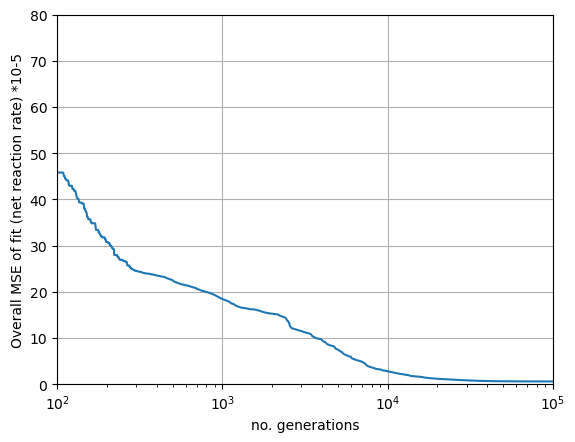

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.9007566258741235
-8.401015914945617
-7.601490286421902
-8.800321640936737
-8.301686578765395
-7.108184781536838
-8.098871290000087
-10.363576713304285
-7.707502572107112
-6.806399091177882
-7.306799391507447
-8.004773230154935
-7.908545181970451
-6.804611326744721
-7.404594006680028
-7.407993173394278
-7.901102404788511
-9.096102506601664
-8.387883488994984
-6.502935639131181
-7.30296739620465
-6.715530326315892
-7.515633410180356
-11.998023151658131
-7.308551181583682
-7.80877394141196
-1.3010299928884677


In [37]:
res.X

array([ -7.90075663,  -8.40101591,  -7.60149029,  -8.80032164,
        -8.30168658,  -7.10818478,  -8.09887129, -10.36357671,
        -7.70750257,  -6.80639909,  -7.30679939,  -8.00477323,
        -7.90854518,  -6.80461133,  -7.40459401,  -7.40799317,
        -7.9011024 ,  -9.09610251,  -8.38788349,  -6.50293564,
        -7.3029674 ,  -6.71553033,  -7.51563341, -11.99802315,
        -7.30855118,  -7.80877394,  -1.30102999])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.9007566258741235
-8.4: -8.401015914945617
-7.6: -7.601490286421902
-8.8: -8.800321640936737
-8.3: -8.301686578765395
-7.1: -7.108184781536838
-8.1: -8.098871290000087
-10.9: -10.363576713304285
-7.7: -7.707502572107112
-6.8: -6.806399091177882
-7.3: -7.306799391507447
-8.0: -8.004773230154935
-7.9: -7.908545181970451
-6.8: -6.804611326744721
-7.4: -7.404594006680028
-7.4: -7.407993173394278
-7.9: -7.901102404788511
-9.1: -9.096102506601664
-8.4: -8.387883488994984
-6.5: -6.502935639131181
-7.3: -7.30296739620465
-6.7: -6.715530326315892
-7.5: -7.515633410180356
-11.8: -11.998023151658131
-7.3: -7.308551181583682
-7.8: -7.80877394141196
R-value: 0.995359524711813
R2: 0.9907405834345263
